In [1]:
import os
import gc
import re
import time
import random
import numpy as np
import csv
import copy
import glob
import math
import joblib
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import AdamW
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from transformers import BertTokenizer, VisualBertForQuestionAnswering, VisualBertConfig
import scipy
from scipy.stats import mannwhitneyu
from scipy.signal import savgol_filter
from scipy.ndimage import gaussian_filter
from scipy.interpolate import CubicSpline, interp1d
from sklearn import svm
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, roc_curve, classification_report, top_k_accuracy_score, coverage_error
import warnings
warnings.filterwarnings("ignore")

def scherrer_fwhm(crystal_size, theta, wavelength=1.5406, shape_factor=0.9):
    theta_rad = np.deg2rad(theta/2)
    fwhm = (shape_factor*wavelength)/(crystal_size*np.cos(theta_rad))
    return fwhm

def load_plt_setting():
    plt.style.use('seaborn-white')
    mpl.rcParams['font.sans-serif'] = "Arial"
    mpl.rcParams['font.family'] = "sans-serif"
    mpl.rcParams['axes.linewidth'] = 2
    font = {'size': 32}
    mpl.rc('font', **font)
    mpl.rcParams['xtick.major.pad']='8'
    mpl.rcParams['ytick.major.pad']='8'
    plt.rcParams["font.weight"] = "normal"
    plt.rcParams["axes.labelweight"] = "normal"
    plt.rcParams['svg.fonttype'] = 'none'
    mpl.rcParams['axes.linewidth'] = 2

tokenizer = BertTokenizer.from_pretrained("google-bert/bert-base-uncased")
_ = tokenizer.add_tokens('pb')

F:\Tools\Anaconda\envs\nd2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 1. Dataloader

In [2]:
class DataLoader():
    '''
    [Input]
    dataset_path:      Path to dataset generated from preprocess.py
                       dataset: 'formula', 'element_list', 'space_group', 'xrd_list'
                                'xrd_list': list of (X,Y), len(xrd_list) depends on the strain setting
    
    batch_size:        Batch size n.
    max_n_mix:         Maximum number of componds in XRD mix
    
    [Output]
    Xs:                Array of intensity in (n,Y,1), n = batch_size
    Ys:                Array of classification labels in (n, len(dataset))
    element_list:      List of elements for each sample, n = len(element_list) 
    formula_list:      Human labels, n = len(formula_list)
    '''
    def __init__(self, dataset_path):
        
        try:
            with open(dataset_path, 'rb') as handle:
                self.dataset = joblib.load(handle)
                print('Loading dataset successful.')
        except:
            print("Missing dataset.")
        
        self.sample_list, self.sample_formula_list, self.combination_list = [], [], []
        self.multiphase = {}
        self.len = len(self.dataset)
        
        for sample, self.data in self.dataset.items():
            self.sample_list.append(sample)
            formula = self.data['formula']
            if '-' in formula:
                formula = formula.split('-')
                formula = formula[-1] + '-' + formula[0]
            self.sample_formula_list.append(re.findall(r'\D+', formula) + re.findall(r'\d+', formula))
            
        self.sample_list = [x for _, x in sorted(zip(self.sample_formula_list, self.sample_list))]
        for i,sample in enumerate(self.sample_list):
            self.elements = self.dataset[sample]['element_list']
            self.multiphase[''.join(set(self.elements))] = {'elements':self.elements,'samples':[]}
            print(i,self.dataset[sample]['formula'],self.elements)
            
        for sample in self.sample_list:
            self.elements = self.dataset[sample]['element_list']
            for combination in self.multiphase.keys():
                if set(self.elements).issubset(set(self.multiphase[combination]['elements'])):
                    self.multiphase[combination]['samples'].append(sample)    
        
        self.multiphase = {k: v for k, v in self.multiphase.items() if len(v.get('samples', [])) >= 2}
        print(self.multiphase)
        
    def load_data(self, batch_size=10, twotheta=np.arange(5.00, 60.01, 0.01), 
                  max_n_mix=3, fix_n_phase=False, resonable_mixing=False, min_mixing_ratio=0.05, 
                  peak_probability_range=(0.2, 1), crystal_size_range=(5, 20), intensity_variation_range=(0.2, 1), 
                  noise_sigma_list=np.logspace(-4,-2,num=101)):
        
        self.n_mix_list = np.random.randint(1, max_n_mix+1, batch_size)
        
        self.Xs = np.zeros((batch_size,len(twotheta),1))
        self.Ys = np.zeros((batch_size,self.len))
        self.element_list, self.formula_list = [], []
        
        i = 0
        while i < batch_size:
            if resonable_mixing:
                self.sample_idxs = []
                samples = self.multiphase[np.random.choice(list(self.multiphase.keys()))]['samples']
                if fix_n_phase:
                    try:
                        samples = np.random.choice(samples, max_n_mix, replace=False)
                    except:
                        continue
                else:
                    samples = np.random.choice(samples, max(min(self.n_mix_list[i],len(samples)),2), replace=False)
                for sample in samples:
                    self.sample_idxs.append(self.sample_list.index(sample))
            else:
                self.sample_idxs = np.random.choice(self.len, size=self.n_mix_list[i], replace=False)
            self.formulas, self.elements = [], []
            
            self.mixing_ratio = np.random.uniform(min_mixing_ratio,1,len(self.sample_idxs))
            self.mixing_ratio = self.mixing_ratio/np.sum(self.mixing_ratio)
            
            for j, sample_idx in enumerate(self.sample_idxs):
                self.data = self.dataset[self.sample_list[sample_idx]]
                self.formulas.append(self.data['formula'])
                for element in self.data['element_list']:
                    if element not in self.elements:
                        self.elements.append(element)
                self.Ys[i, sample_idx] += 1
                
                self.twotheta_short, self.X_short = self.data['xrd_list'][np.random.randint(0,len(self.data['xrd_list']))]
                self.X = np.zeros(twotheta.shape)
                self.X[np.searchsorted(twotheta,self.twotheta_short)] = self.X_short
                
                # Missing peak
                self.X = self.X * np.random.binomial(1, np.random.uniform(*peak_probability_range), self.X.shape[0])
                
                # Intensity variation
                self.X = self.X * np.random.uniform(*intensity_variation_range, self.X.shape[0])

                # Crystal size broadening
                fwhm = scherrer_fwhm(np.random.uniform(*crystal_size_range), twotheta)
                sigma = np.mean(fwhm)/(2*np.sqrt(2*np.log(2)))
                self.X = gaussian_filter(self.X, sigma=sigma*100)
                
                self.Xs[i,:,0] += self.X/np.max(self.X)*self.mixing_ratio[j]
            
            if np.max(self.Xs[i,:,0]) == 0:
                self.Ys[i, :] = np.zeros(self.Ys[i, :].shape)
                pass
            else:
                self.Xs[i,:,0] = self.Xs[i,:,0]/np.max(self.Xs[i,:,0]) + np.random.normal(0, np.random.choice(noise_sigma_list), len(twotheta))
                self.Xs[i,:,0] = (self.Xs[i,:,0]-np.min(self.Xs[i,:,0]))/(np.max(self.Xs[i,:,0])-np.min(self.Xs[i,:,0]))
                self.formula_list.append(self.formulas)
                self.element_list.append(list(set(np.array(self.elements).flatten())))
                i += 1
            
        return self.Xs, self.Ys, self.element_list, self.formula_list
    
    def load_ref(self, sample_idx=0, twotheta=np.arange(5.00, 60.01, 0.01),):
        
        self.data = self.dataset[self.sample_list[sample_idx]]
        self.twotheta_short, self.X_short = self.data['xrd_list'][int(len(dataloader.data['xrd_list'])/2+0.5)]
        self.X = np.zeros(twotheta.shape)
        self.X[np.searchsorted(twotheta,self.twotheta_short)] = self.X_short
        self.X = self.X/np.max(self.X)
        return self.X

In [3]:
folder = r'K:\Python\MIT\ML\XRD_Phase_identification'
cif_folder = os.path.join(folder, 'cif')

dataloader = DataLoader(os.path.join(cif_folder, 'dataset.npy'))

Loading dataset successful.
0 Cs0.2FA0.8PbBr3 ['Cs', 'FA', 'Pb', 'Br']
1 Cs0.4FA0.6PbBr3 ['Cs', 'FA', 'Pb', 'Br']
2 Cs0.6FA0.4PbBr3 ['Cs', 'FA', 'Pb', 'Br']
3 Cs0.8FA0.2PbBr3 ['Cs', 'FA', 'Pb', 'Br']
4 Cs0.2FA0.8PbI3 ['Cs', 'FA', 'Pb', 'I']
5 Cs0.4FA0.6PbI3 ['Cs', 'FA', 'Pb', 'I']
6 Cs0.6FA0.4PbI3 ['Cs', 'FA', 'Pb', 'I']
7 Cs0.8FA0.2PbI3 ['Cs', 'FA', 'Pb', 'I']
8 Cs0.2MA0.8PbBr3 ['Cs', 'MA', 'Pb', 'Br']
9 Cs0.4MA0.6PbBr3 ['Cs', 'MA', 'Pb', 'Br']
10 Cs0.6MA0.4PbBr3 ['Cs', 'MA', 'Pb', 'Br']
11 Cs0.8MA0.2PbBr3 ['Cs', 'MA', 'Pb', 'Br']
12 Cs0.2MA0.8PbI3 ['Cs', 'MA', 'Pb', 'I']
13 Cs0.4MA0.6PbI3 ['Cs', 'MA', 'Pb', 'I']
14 Cs0.6MA0.4PbI3 ['Cs', 'MA', 'Pb', 'I']
15 Cs0.8MA0.2PbI3 ['Cs', 'MA', 'Pb', 'I']
16 Cs4PbBr6 ['Cs', 'Pb', 'Br']
17 CsBr ['Cs', 'Br']
18 CsI ['Cs', 'I']
19 CsPb2Br5 ['Cs', 'Pb', 'Br']
20 CsPb(Cl0.2Br0.8)3 ['Cs', 'Pb', 'Br', 'Cl']
21 CsPb(Cl0.4Br0.6)3 ['Cs', 'Pb', 'Br', 'Cl']
22 CsPb(Cl0.6Br0.4)3 ['Cs', 'Pb', 'Br', 'Cl']
23 CsPb(Cl0.8Br0.2)3 ['Cs', 'Pb', 'Br', 'Cl']
24 CsPb(

# 2 SVM

## 2.1 single batch SVM

In [10]:
Xs, Ys, element_list, formula_list = dataloader.load_data(batch_size=10000, max_n_mix=1,
                                                          peak_probability_range=(1, 1), crystal_size_range=(5, 20), 
                                                          intensity_variation_range=(0.01, 1))
Ys_int = [np.where(x==1)[0][0] for x in Ys]

In [11]:
clf = SGDClassifier(learning_rate='adaptive', eta0=0.01)
clf.fit(Xs[:,:-1,0], Ys_int)

with open(os.path.join(folder, 'baselines', 'SVM', 'SVM_10k.pkl'),'wb') as f:
    pickle.dump(clf,f)

In [12]:
try:
    with open(os.path.join(cif_folder, 'test_dataset.npy'), 'rb') as handle:
        test_dataset = joblib.load(handle)
    
    Xs, Ys, element_list, formula_list = test_dataset['Xs'], test_dataset['Ys'], test_dataset['element_list'], test_dataset['formula_list']
    Ys_int = [np.where(x==1)[0][0] for x in Ys]
    print('test dataset loaded.')
    
except:
    Xs, Ys, element_list, formula_list = dataloader.load_data(batch_size=1000, max_n_mix=1,
                                                              peak_probability_range=(1, 1), crystal_size_range=(5, 20), 
                                                              intensity_variation_range=(0.1, 1), min_mixing_ratio=0.3)
    test_dataset = {'Xs':Xs, 'Ys':Ys, 'element_list':element_list, 'formula_list':formula_list}
    Ys_int = [np.where(x==1)[0][0] for x in Ys]
    with open(os.path.join(cif_folder, 'test_dataset.npy'), 'wb') as handle:
        joblib.dump(test_dataset, handle)
    print('test dataset generated.')

test dataset loaded.


In [13]:
Ys_pred_int = clf.predict(Xs[:,:-1,0])

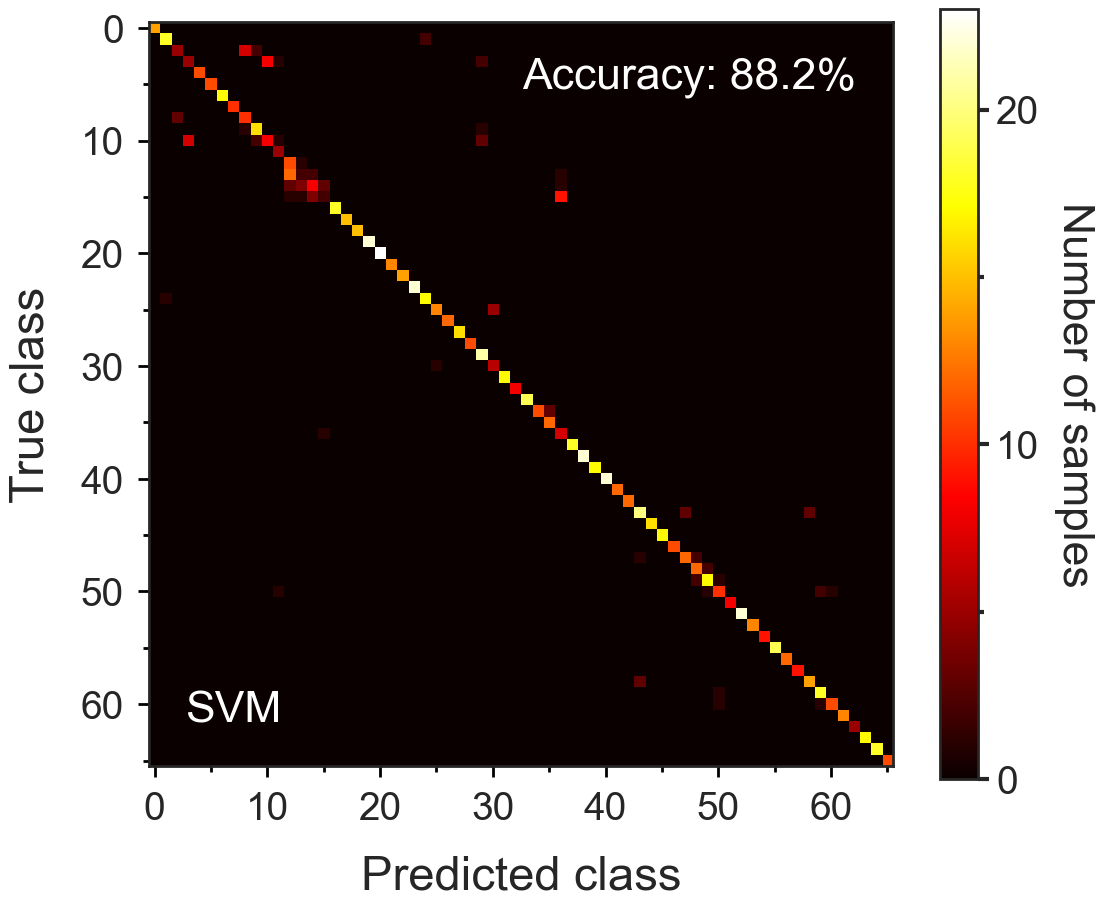

In [14]:
load_plt_setting()

report = classification_report(Ys_int, Ys_pred_int, target_names=dataloader.sample_list, output_dict=True)
matrix = confusion_matrix(Ys_int, Ys_pred_int)

fig, ax = plt.subplots(figsize=(12, 10))

mat = ax.matshow(matrix, cmap='hot')
ax.xaxis.set_ticks_position('bottom')
ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10, steps=[1, 2, 5, 10]))
ax.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10, steps=[1, 2, 5, 10]))
ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
ax.tick_params(axis='both',direction='out',length=8,width=2,pad=10,color='black',labelsize=28)
ax.tick_params(axis='both',which='minor',direction='out',length=4,width=2,pad=10,color='black',labelsize=28)
# ax.axes.set_xlim([450,950])
# ax.axes.set_ylim([0,5])
# # ax.set_xscale('log')

cbar = plt.colorbar(mat)
cbar.ax.tick_params(axis='y', direction='out',length=8,width=3,pad=5,labelsize=28)
cbar.ax.set_ylabel('Number of samples',labelpad=40, rotation=-90)
cbar.ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=4, integer=True, steps=[1, 2, 5, 10]))
cbar.ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
cbar.ax.tick_params(axis='both',which='minor',direction='out',length=4,width=3,pad=5)

ax.set_xlabel(r'Predicted class', labelpad=20, fontsize=34)
ax.set_ylabel(r'True class', labelpad=20, fontsize=34)

plt.text(0.95, 0.91, 'Accuracy: {:.1f}%'.format(report['accuracy']*100), fontsize=32, 
         transform=ax.transAxes, color='#FFFFFF', horizontalalignment='right')
plt.text(0.05, 0.06, 'SVM', fontsize=32, transform=ax.transAxes, color='#FFFFFF', horizontalalignment='left')

plt.savefig(os.path.join(folder, 'baselines', 'SVM', 'SVM_10k.png'), format='png', dpi=300, transparent=True, bbox_inches='tight')

##  2.2 multi batch SVM

In [4]:
num_of_epochs = 2000
clf = SGDClassifier(learning_rate='adaptive', eta0=0.01)

time_start = time.time()
for i in range(num_of_epochs):
    Xs, Ys, element_list, formula_list = dataloader.load_data(batch_size=1000, max_n_mix=1,
                                                          peak_probability_range=(1, 1), crystal_size_range=(5, 20), 
                                                          intensity_variation_range=(0.01, 1))
    Ys_int = [np.where(x==1)[0][0] for x in Ys]
    
    clf.partial_fit(Xs[:,:,0], Ys_int, classes=np.linspace(0,65,66).astype(int))
    
    if (i+1)%10 == 0:
        print('{}\t{}'.format(i+1, time.time()-time_start))

10	6.805182218551636
20	13.586412191390991
30	20.225302934646606
40	27.0353102684021
50	34.74361300468445
60	42.23777413368225
70	49.24022555351257
80	56.11983275413513
90	63.23930335044861
100	70.1886727809906
110	77.36002087593079
120	84.38945508003235
130	91.1488196849823
140	98.17030501365662
150	105.14586663246155
160	112.45505690574646
170	119.48179721832275
180	126.48020577430725
190	133.59680151939392
200	140.93564891815186
210	148.26362204551697
220	155.86335492134094
230	163.68000078201294
240	171.31476426124573
250	178.42716193199158
260	186.00839519500732
270	193.84741735458374
280	201.3190553188324
290	208.08215999603271
300	215.1392481327057
310	222.10343599319458
320	229.0931417942047
330	236.17409443855286
340	243.01466274261475
350	250.07063817977905
360	256.93559408187866
370	263.85420751571655
380	270.6980483531952
390	277.41382598876953
400	284.15523195266724
410	291.1641626358032
420	298.2636396884918
430	305.116503238678
440	312.35614013671875
450	319.040114879608

In [7]:
# save
with open(os.path.join(folder, 'baselines', 'SVM', 'SVM_2M.pkl'),'wb') as f:
    pickle.dump(clf,f)

# load
# with open(os.path.join(folder, 'baselines', 'SVM', 'SVM_2M.pkl'), 'rb') as f:
#     clf = pickle.load(f)

In [8]:
with open(os.path.join(cif_folder, 'test_dataset.npy'), 'rb') as handle:
    test_dataset = joblib.load(handle)

Xs, Ys, element_list, formula_list = test_dataset['Xs'], test_dataset['Ys'], test_dataset['element_list'], test_dataset['formula_list']
Ys_int = [np.where(x==1)[0][0] for x in Ys]
print('test dataset loaded.')

test dataset loaded.


In [9]:
Ys_pred_int = clf.predict(Xs[:,:,0])

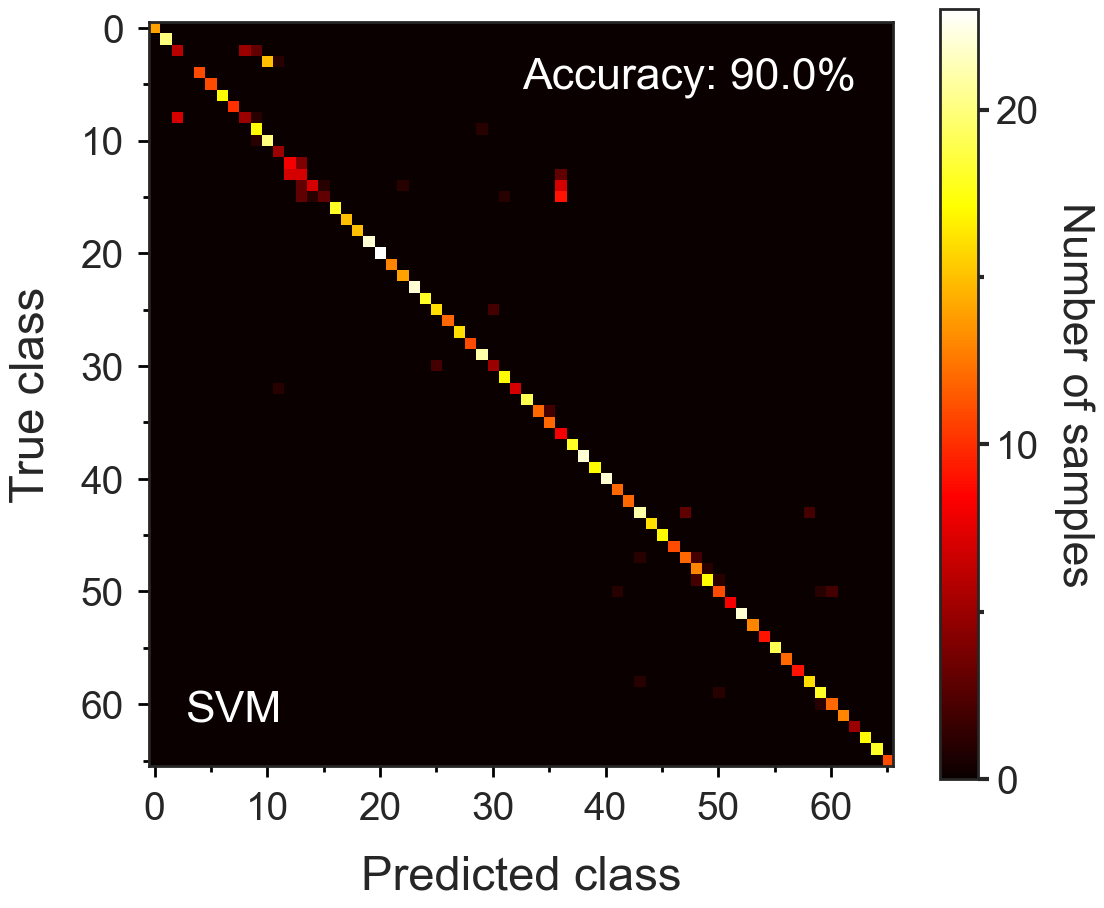

In [10]:
load_plt_setting()

report = classification_report(Ys_int, Ys_pred_int, target_names=dataloader.sample_list, output_dict=True)
matrix = confusion_matrix(Ys_int, Ys_pred_int)

fig, ax = plt.subplots(figsize=(12, 10))

mat = ax.matshow(matrix, cmap='hot')
ax.xaxis.set_ticks_position('bottom')
ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10, steps=[1, 2, 5, 10]))
ax.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10, steps=[1, 2, 5, 10]))
ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
ax.tick_params(axis='both',direction='out',length=8,width=2,pad=10,color='black',labelsize=28)
ax.tick_params(axis='both',which='minor',direction='out',length=4,width=2,pad=10,color='black',labelsize=28)
# ax.axes.set_xlim([450,950])
# ax.axes.set_ylim([0,5])
# # ax.set_xscale('log')

cbar = plt.colorbar(mat)
cbar.ax.tick_params(axis='y', direction='out',length=8,width=3,pad=5,labelsize=28)
cbar.ax.set_ylabel('Number of samples',labelpad=40, rotation=-90)
cbar.ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=4, integer=True, steps=[1, 2, 5, 10]))
cbar.ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
cbar.ax.tick_params(axis='both',which='minor',direction='out',length=4,width=3,pad=5)

ax.set_xlabel(r'Predicted class', labelpad=20, fontsize=34)
ax.set_ylabel(r'True class', labelpad=20, fontsize=34)

plt.text(0.95, 0.91, 'Accuracy: {:.1f}%'.format(report['accuracy']*100), fontsize=32, 
         transform=ax.transAxes, color='#FFFFFF', horizontalalignment='right')
plt.text(0.05, 0.06, 'SVM', fontsize=32, transform=ax.transAxes, color='#FFFFFF', horizontalalignment='left')

plt.savefig(os.path.join(folder, 'baselines', 'SVM', 'SVM_2M.png'), format='png', dpi=300, transparent=True, bbox_inches='tight')

# 3. CNN

In [4]:
class Model(nn.Module):
    def __init__(self, input_dim, n_class):
        super(Model, self).__init__()
        self.con1 = nn.LazyConv1d(64, 50, stride=2)
        self.poo1 = nn.MaxPool1d(3,stride=2)
        self.con2 = nn.LazyConv1d(64, 25, stride=3)
        self.poo2 = nn.MaxPool1d(2,stride=3)
        self.fc1 = nn.LazyLinear(2000)
        self.fc2 = nn.LazyLinear(500)
        self.fc3 = nn.LazyLinear(n_class)
#         self.re2 = nn.LeakyReLU(0.2, inplace=False)
#         self.bn1 = nn.BatchNorm1d(num_features=64)

    def forward(self, x):
        x = self.con1(x)
        x = self.poo1(x)
        x = self.con2(x)
        x = self.poo2(x)
        x = self.fc1(torch.flatten(x,start_dim=1))
        x = self.fc2(x)
        x = self.fc3(x)
        return x    

In [15]:
del model

In [5]:
Xs, Ys, element_list, formula_list = dataloader.load_data(batch_size=1, max_n_mix=1,
                                                          peak_probability_range=(1, 1), crystal_size_range=(5, 20), 
                                                          intensity_variation_range=(0.01, 1))
Ys_int = [np.where(x==1)[0][0] for x in Ys]

model = Model(Xs.shape[1]-1,Ys.shape[1]).to('cuda')

print(model)
train_losses,train_y_true,train_y_pred = [],[],[]

Model(
  (con1): LazyConv1d(0, 64, kernel_size=(50,), stride=(2,))
  (poo1): MaxPool1d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (con2): LazyConv1d(0, 64, kernel_size=(25,), stride=(3,))
  (poo2): MaxPool1d(kernel_size=2, stride=3, padding=0, dilation=1, ceil_mode=False)
  (fc1): LazyLinear(in_features=0, out_features=2000, bias=True)
  (fc2): LazyLinear(in_features=0, out_features=500, bias=True)
  (fc3): LazyLinear(in_features=0, out_features=66, bias=True)
)


In [6]:
optimizer = AdamW(model.parameters(), lr=1e-5)
batch_size = 20
num_of_epochs = 100000

time_start = time.time()
for i in range(num_of_epochs):
    Xs, Ys, element_list, formula_list = dataloader.load_data(batch_size=batch_size, max_n_mix=1,
                                                          peak_probability_range=(1, 1), crystal_size_range=(5, 20), 
                                                          intensity_variation_range=(0.01, 1))
        
    Y_predict = model(torch.swapaxes(torch.tensor(Xs[:,:-1,:], dtype=torch.float32),1,2).to('cuda'))
    loss = nn.CrossEntropyLoss()(Y_predict, torch.tensor(Ys,dtype=torch.float32).to('cuda'))
    
    labels = torch.from_numpy(np.array(Ys)).to(dtype=torch.float32)
    
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    y_true = Ys
    train_y_true.append(Ys)
    y_pred = np.array(Y_predict.detach().cpu())
    train_y_pred.append(y_pred)
    
    print('{}\t{:.5f}\t{}'.format(i+1, np.array(loss.detach().cpu()), y_true.argmax(-1)[:15]-y_pred.argmax(-1)[:15]))
    train_losses.append(np.array(loss.detach().cpu()))
    
    if (i+1) % 5000 == 0:
        torch.save(model, os.path.join(folder, 'baselines', 'CNN', '{}.pt'.format(i+1))) 
        np.savetxt(os.path.join(folder, 'baselines', 'CNN', 'train_loss.csv'), train_losses, delimiter=',')
        with open(os.path.join(folder, 'baselines', 'CNN', 'train_result.npy'), 'wb') as handle:
            joblib.dump({'y_true':train_y_true, 'y_pred':train_y_pred, 'loss':train_losses}, handle)

1	4.19377	[ 52  30   9  24  13  51  48  26  21  61  59 -27  17 -21   4]
2	4.19325	[55  2 13 57  8 40 19 61 38 29 12 -7 -7  2 33]
3	4.19642	[ 50  -2 -49  -1 -46 -19   6 -19   1  -9 -46  -2  13  12   1]
4	4.18763	[-50 -39 -51 -24 -20 -42 -10 -41 -38   0 -40 -56 -32 -41   3]
5	4.18688	[-52   1 -45 -26 -25 -51 -38   0 -15 -15   4 -50  -8 -42  -2]
6	4.19217	[  9 -29 -33 -30 -54 -36 -18 -31  -4 -33  -2 -15 -56  -4   7]
7	4.18528	[  3 -30 -52  -3 -48 -23  -4 -35 -29   5 -38 -31   5  -6 -16]
8	4.17380	[  0 -55 -36  -2  -8   0 -45   4 -28  -6   9  -1 -47  18 -28]
9	4.18429	[-36   7  -3 -47 -25 -38 -42 -19 -48 -34 -39  -5  -9 -32 -28]
10	4.18669	[-48 -11 -53   1  -2 -12 -29 -46 -52   4  -7 -16   8 -40 -54]
11	4.17976	[ -2  -1 -21 -46   2   9 -48 -15  -4 -16  -8 -56 -24   5 -21]
12	4.20303	[  3 -24 -14 -12  -4  -4 -28 -39 -23 -29 -35   7   8 -49  -1]
13	4.19443	[-16 -52   3 -15 -43 -15 -22 -12   7 -23  -6 -38  18 -10 -55]
14	4.18301	[-42 -48 -49   1   7   1 -40   1 -51 -21 -24  -9 -30 -12 -22]
15

117	4.00127	[  0  -9 -25   1 -15   8   0   1   0   0 -21   0   1 -21  -1]
118	4.00236	[ 49   0  -7 -19   0  13   0   1 -11  -7 -18   4  13   0   0]
119	3.98339	[  0  22  13 -47  22   0  -1   0  48 -15  59 -15  48   0 -18]
120	3.99348	[-33  50   0   1  -8   0   0 -15  -1  -1  -1   0  48 -33 -28]
121	3.98531	[  0 -34 -11 -39 -15   0 -47   0   0 -12 -18 -18   0 -30   0]
122	3.88251	[  0   0   0  23 -30  -7  -7   0   0   0   7   0 -22   0  -1]
123	3.92243	[  0  50 -15  50   1   0   0   0   0   0 -34  -2   0 -12   0]
124	3.96542	[  0   0 -34 -18   1  13   0  -7 -11   1  -9   1   0   0   0]
125	3.96068	[ -9   0   0  -1   0   1   1   0  -7   0 -22   0   0   0   0]
126	3.93601	[ -1 -30   0   0 -25   0   0 -30   0   1   0   0 -18   0   3]
127	3.92890	[  0   2 -29   0   0   2   0   0 -15   0  19  49 -30  -1  51]
128	3.95417	[ 23 -25  -7   2   0  -7   0   0 -11   0   1   0   0 -29 -28]
129	3.90784	[  0 -47   0   0  -9  23  22  -7   0 -33   0   0  24   0   0]
130	3.87470	[-11 -25   0   0 -34  23 -

243	2.79089	[ 1  0  0 13 -1  0  0 20  0 13 20 -1  0  0  0]
244	2.68178	[  0   1  -4   0   7   0   0   0   0   1   0  -1 -47   0   0]
245	2.69281	[  0   2 -47   0   0   0   0   0   0   1   0   0 -10   0  -1]
246	2.56049	[  0   0   1  21   0   1   3  21   0  13   0   0   3  50 -25]
247	2.38093	[ 0  0 -8  2  0  0 -7  2 -7  0  0  0  0  0  0]
248	2.51276	[ 0  0  0  0  0 -8 -9  0  0  0 -4  0  0  0 13]
249	2.35975	[  1   1   0   0   1  -4  -4   0   0   0   0   0 -21   0   0]
250	2.55476	[ 0  0  0  0  0  1 -1  2  0  0  0  0  0  0  0]
251	2.40331	[ 0  0 47  7  0  0  0  0  0  0  0  0  0  0  1]
252	2.53289	[ 0  0 23  0  2  0 20  0  0  1  0  0  0  0  0]
253	2.49128	[  0  -1   0   0   1   1   0   0 -25   0   5  -4   1   0   0]
254	2.47738	[ 0  0  0  0 13  0  0 -2  1  0 -1  0  0  0  0]
255	2.56074	[ 0  0 -1 13  0 21  0 -8  0  0  0 -8  0  0 -1]
256	2.36882	[ 0 21 -1  0  1  0  0 -2  0  0 -8  0  0  0  0]
257	2.31053	[  0   0   0   0   0   0  47   0   0   0  -1   0   7   0 -38]
258	2.44005	[ 0  0  0  0 

379	1.29342	[ 0  0 -1  0  0  0  0  0  0  0  0  0 -2  1  0]
380	0.96622	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
381	0.89229	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
382	0.94763	[ 0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0]
383	1.18648	[0 0 0 0 0 0 1 0 0 0 0 0 7 0 1]
384	0.84650	[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 11]
385	0.95868	[18  0  0 15  0  0  0  0  0  0  0  0  0  0  0]
386	1.23797	[ 1 -2  0  0  0  0  0  0  0  0  0  0  0  0 -1]
387	1.21326	[  0   0   0   0   0   0   1  10   0 -21   0   0   0   0   0]
388	1.28248	[ 0  0  0  0  0  0  0  0  0  0  0  0 -1  0  1]
389	1.13521	[-5  0  0 -5 15  0 47  5 47  0  0  0  0  0  0]
390	0.92715	[-1  0 21  0  0  0  0  0  0  0 23  0  0  0 -5]
391	1.23953	[ 0  0 -1  6  0  0  6  0  0  4  0 15  1  0  0]
392	1.04424	[ 0  0  0  0 21  0 21  0  0  0  0  0  0  0  0]
393	0.69396	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
394	0.78585	[ 0  0  0  0  0  0  0  0  0 -5  0  0  0  0  0]
395	0.87879	[ 0  0  0  0  7  0 -2  0  0  0  0  0  0  0  5]
396	0.96750	[ 0  1  0 -1  0  0  0 -1  0  1

516	0.79030	[  1   0   1   0   0   0   0  21   0   0   0   1   0   0 -21]
517	0.55508	[ -2   0   0   0   0  25   0   0 -21   0   0   0   1   0   0]
518	0.58268	[ 0  0  0  0  0 21  0  0  0  0  0  0  0  0  0]
519	0.69263	[  0  50   0   0   0   0   0   0   0   0   0   0  -1   0 -15]
520	0.54529	[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1]
521	0.73668	[-6  0  0 -5  0  0  0  0  0  0  0 -5  0  0  0]
522	0.73487	[ 0 -7  0  0  0  0  0  0 21  0 21  0  0 21 18]
523	0.64351	[  0   0   0   0   0  18  -1 -15   0   0   0 -10   0  -2   0]
524	0.67836	[  0   0   0   0   0   0  47   0   0   0   0 -10   0   0   0]
525	0.67221	[  0   0   0   0   0   0   0   0   0   0   0   0 -11   0  -7]
526	0.60592	[  0   0   0   0   0   0   0   0 -15   0   0   0  -6  21   0]
527	0.75747	[ 0  0  0  0  1  0  0  0  0  0  0  0 -6  0  0]
528	0.67443	[ 0  0  0  0  0 -1  0  0  0  0 -2  0  0  0  0]
529	1.08304	[-11   0   0   0  -1 -11   0   0   0  -1   0  -1   0   0  -8]
530	0.80278	[ 0 21  1  0  0  0  0  1  0  0  0  0  0  0

653	0.65261	[  0   0   0   0   0   1   7  -1   6 -21   0   0   0   0   0]
654	0.48040	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
655	0.76281	[  0  -1   0   0 -23   0   0   0   0  -1   0   0   0   0  -8]
656	0.60852	[  0   0   6  -1   0   0   0 -15   1   0   0   0   0   0   0]
657	0.80555	[  0  -1 -21   0   0  -1   0   6   6   0   0   0   0  19   0]
658	0.72815	[ 6 -2  0  0  0 -1  0  0 -1  0  0  0  1  5  0]
659	0.41055	[0 0 0 0 0 0 0 0 0 0 0 0 7 0 0]
660	0.65878	[  0   0  47   0   0  47   0   0   0 -22   0   0   0   0   0]
661	0.42914	[  0   0   0   0   0   0   0   0   0 -15   0   0   0   0   0]
662	0.44769	[0 0 0 0 0 0 6 0 0 0 0 0 0 0 0]
663	0.62000	[ 0  0 -2 -1 -2  0  0  0  0  0  0  0  0  0  0]
664	0.53699	[11 -2  0  2  0  0  0  0  0  0  0  0  0  0  0]
665	0.74701	[-7  0  1  0  0  0  0  0  0  0  0  0  0  0 -1]
666	0.37028	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
667	0.52587	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
668	0.53850	[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
669	0.74094	[-1  0  6  0 -1  0  0  0 -1  0  1  0  0  0  

791	0.42135	[ 11 -21   0   0   0   0  -4   0   0   0   0   0   0   0   0]
792	0.41444	[  0  -2   0   0 -21   0   0   0   0   0   0   0   0   0   0]
793	0.45950	[  0   0   0 -18   0   0   0   0   0   0  -7   0   0   0   2]
794	0.55602	[0 0 0 1 0 0 0 0 6 0 0 0 0 0 0]
795	0.39678	[0 0 0 0 0 0 0 0 0 2 0 0 0 0 1]
796	0.36666	[ 0  0  0  0  0  0  0  9  0  0  0  0  0  0 -6]
797	0.39752	[0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
798	0.23502	[ 0  0 21  0  0  0  0  0  0  0  0  0  0  0  0]
799	0.54218	[  0   0   0  -1   0   0   0   0   1   0 -26   0   0   0   0]
800	0.27381	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
801	0.63335	[-21   0   0   0   1   0   0   0   0   0   0   0   0   6   0]
802	0.66956	[0 0 6 0 0 0 0 0 0 1 0 0 0 0 0]
803	0.51265	[0 0 0 0 6 0 0 0 0 0 0 0 0 0 0]
804	0.53122	[0 6 0 0 0 0 0 0 0 0 0 0 0 0 0]
805	0.37752	[  0   0   0   0   0   0   0   0 -21   0   0   0   0   0   0]
806	0.41464	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
807	0.45857	[ 0 -1  0  0  0  0  0  0  1  0  0  0  0  0  0]
808	0.38224	[  0   0   0   

928	0.51083	[  0 -21   0   0  -7   0   0   0   0   0  -5   0   2   0  -5]
929	0.37316	[ 0 10 -6  0  0 10  0  0  0  0  0  0  0  0  0]
930	0.48306	[  0 -21   0   0   0   0  -6   0   0   0   0   0   0   0   0]
931	0.43476	[ 0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0]
932	0.30491	[-6  0  0  0  0  0  0  0 -1  0  0  0  0  0  0]
933	0.26401	[ 0  0  0  0  0  0  0  0  0 -4  0  0  0  0  0]
934	0.61461	[  1   1   0   0   0  -7   0   0   0   0 -10   0   0  23   0]
935	0.38194	[  0   0   0 -10   0   0  -1   0   0  -6   0   0   0   0   0]
936	0.39421	[  0   0   0   0   0   0 -26   0   0   0   0   0   0   0   0]
937	0.44873	[ 0 -6  0  0  1  0  6  0 -7  0  0  0  0  0  0]
938	0.55773	[ -6   0   0   0   0   0  28   0   0   0 -11   7   0   0   0]
939	0.43078	[  0   0   0   1   0   0   0   0  -5   0   0   0 -15   0  -6]
940	0.64633	[  0  -1   0   0  23   0   0   0   0  -1   0   0   0 -21   0]
941	0.58918	[ 0  6 -1  0  0  0  0  0  0  0  0 -1  0  0  0]
942	0.30174	[  0   0   0 -48   0   0   0   0   0   0  

1064	0.29905	[ 0  0  0 -7  0  0  0  0  0  0  0  0  0  0  0]
1065	0.35649	[ 0  0  0  0  0  0  0  0  0 -2  0  2  0  0  0]
1066	0.25415	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
1067	0.27575	[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
1068	0.25820	[ 0  0  0  0  0  0  0  0  0  0  0  0  0 -6  0]
1069	0.42144	[ 0  0  0  0 -6  0  0  0  0  0 49  0  0  0  0]
1070	0.31426	[ 0  0  0 -6  0  0  0 -1  0  0  0 -6  0  0  0]
1071	0.11207	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
1072	0.27345	[0 0 0 0 0 0 0 0 0 5 0 0 0 0 0]
1073	0.36092	[  0   0   0   0   0   0   0   0  -7   0 -21   0   0   0   0]
1074	0.38644	[ 0 -1  0  0  0  0  0 -4  0  0  0  0  0  0  0]
1075	0.21843	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
1076	0.26701	[0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
1077	0.17771	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
1078	0.23355	[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
1079	0.39448	[ 0  0  0  0  0  0  0  1  0  0  0  0 21  0  0]
1080	0.32395	[-15   0   0   0   0   0  -6   0   0   0   0   0   0   0   0]
1081	0.40009	[ 0  0  0  0  3  0 -7  0  0  0  0  0  0  0  0]
1082	0.103

1208	0.39455	[0 0 0 0 2 0 0 0 0 0 0 7 0 0 0]
1209	0.34239	[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
1210	0.50596	[  0  -2   0   0   0 -18   2   0   0   0   0   0   0  22   0]
1211	0.33171	[1 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
1212	0.58161	[  0  -2   0   6 -18   0   0   0   0   0   0   7   0   0   0]
1213	0.26441	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
1214	0.40897	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
1215	0.27873	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
1216	0.44299	[ 0  0  0  0  0 22  0  0  0  0  0  0  0  0  0]
1217	0.43239	[ 0  0  0  0  0 -2  1  0  0  0 -1  0  0  0  0]
1218	0.31643	[ 0  0  7  0  0  0  0  7  0 -1  0  0  0  0  0]
1219	0.39340	[  0   0   0   7   0   0   7   6 -21   0   0   7   0   0   0]
1220	0.38430	[0 0 6 0 1 0 0 0 0 0 0 0 0 0 0]
1221	0.14284	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
1222	0.10597	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
1223	0.32376	[ 0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0]
1224	0.32474	[ 0  0  0  0  0 -1  0  0  0 11  0  0  0  0  0]
1225	0.31284	[  0   0   0   0   0   0   7 -15   0   0 -15   0   0   0 

1348	0.34562	[ 0  0 15  0  0  0  0  0  0  0  0  0  0  0  0]
1349	0.25982	[ 0  0  0  0  0  0  0  0  0  0  0 -7  0  0  0]
1350	0.45412	[  0   0   0   0   0   0   0   0   2   0   0 -21   0   0   0]
1351	0.46329	[  0   0   0   0   0  -5   2   0 -21   0  -8   0   0   0   0]
1352	0.17586	[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
1353	0.27100	[ 0  0  0  0  1  0  0  0  0  0  0  0  0 10  0]
1354	0.43580	[  0 -21   0   0   0  -1   0 -21   0   0   0   0   0  -1   0]
1355	0.31961	[ 0  0  0  0  0 -8  0  0  0  0  0  0  0  5  0]
1356	0.25914	[  0   0   0   0   0   0   0   0   0   0   0   0   0 -21   0]
1357	0.52076	[22  0  0  0  0  0 -1  1 23 -1  0  0  0  0  0]
1358	0.45639	[ 0  0  0  0  0  0  0  0  0  0  0  0  0 -2  0]
1359	0.33764	[ 0  0  0  0  0 -1  0  1  0  0  0  0  0  0  0]
1360	0.16255	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
1361	0.21234	[ 0  0  0  0  0  0  0  0  0 -8  0  0  0  0  0]
1362	0.47956	[  0   0  -8   0   0   0   7  -1   0   0 -22   0   0   0   0]
1363	0.34154	[ 0  0  0  0  0  0  0  0 -6 -2  0  0  0  0

1485	0.29977	[ 0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0]
1486	0.40080	[  0   0   0   0   0   0   0 -15   0   0   0   0   0   1   0]
1487	0.33705	[0 0 0 0 0 0 0 0 9 0 2 0 0 0 0]
1488	0.44763	[ 0  0  0  0 -8  7  0  0  0  0  0  0  0  0  0]
1489	0.41763	[ -5   0   0   0   0   0 -11   0   0   0   0   7   7   0   0]
1490	0.22735	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
1491	0.27485	[  0   0 -11   0   0   0   0   0   0   0   0   0   0   0   0]
1492	0.25398	[  0   0   0 -22   0   0   0   0   0   0   0   0   0   0   0]
1493	0.34586	[-26   0   0  -1   0   0   0   0   0   0   0  -5   0   0  -7]
1494	0.76756	[ 0 -9 -1  0  0 -1  0  0  6  1  0  0  7  0  0]
1495	0.38610	[0 0 0 0 0 0 0 0 0 0 1 0 0 7 0]
1496	0.48418	[  0   0   0   0   1  -1   0   0   0   0   0   0 -21   0   0]
1497	0.45272	[  0 -10 -21  21   0   0   0   0  -7   0   0   0   0   0   0]
1498	0.35011	[ 0  0  0  0  0  0  0  0  0  0  0  0  0 -7  0]
1499	0.23687	[  0 -21   0   0   0   0   0   0   0   0   0   0   0   0   0]
1500	0.49003	[-11   0   0

1622	0.33142	[ 0  0  0  0 -6  7  0  0  0  0  0  0  0  0  0]
1623	0.30681	[ 0  0  1  0  0  0  0  0  0  0  0  7  0  0 -5]
1624	0.31411	[-3  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
1625	0.50607	[  0  -1   0   0   0   0   0   0   0   0 -26   0  -1   0   0]
1626	0.33549	[ 0  1  0  0  0  0  0  0  0  0  0  0  0 -1  0]
1627	0.51944	[  0 -21   0   0   2   0   0   0   0   0   0   0   0  -1   0]
1628	0.21070	[ 0  0  0  0  0  0  0  0  0  0  0  0  0 -5  0]
1629	0.21699	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
1630	0.34631	[0 0 0 6 0 0 0 0 0 0 0 0 0 0 0]
1631	0.40332	[ 0  0  0  0 -1  0  0  0  0  3  0  0  0  0  0]
1632	0.31266	[ 0  0  0  0  0  0  0 -1  0  0  0  0  0  0 15]
1633	0.39686	[ 0  0  0  0  2 -6  0  0  0  0  0  0  0  0  0]
1634	0.14968	[  0   0   0   1   0   0   0   0   0   0 -21   0   0   0   0]
1635	0.42364	[ 0  0  0  0  0  1  0 15  0  0  0  0  0  0  1]
1636	0.41048	[ 0  0 -7  0  0  0  0  0 -5  0  0  0  0  0 -1]
1637	0.31254	[ 0  0  0  0  0  0 -6  0  0  0  0  0  0  0  1]
1638	0.17958	[0 0 0 0 0 0

1767	0.34006	[  0   0   0   9   0   0  -1 -10   0   0   0   0   0   0   1]
1768	0.21363	[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
1769	0.26667	[ 0  0  0  0  0  0  0  0  0 -4  0  0  0  0 -1]
1770	0.46128	[  0   0   0   0   0   0   0   0   0   0 -23   0   0   0   0]
1771	0.21187	[6 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
1772	0.45010	[ 0  0  0  2  0  0 -1  0  0  0 22  0  0  0  0]
1773	0.40110	[  0   0   0  -9   0   0   0 -23   0   0 -10   0   0   6   0]
1774	0.46184	[ 0  0  9  0  0  1  0  0  0  0  0  0  0 22  0]
1775	0.15835	[  0   0   0   0   0   0   0   0   0   0   0   0 -21   0   0]
1776	0.22106	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
1777	0.19902	[ 0  0  0  0  0  0 -1  0  6  0  0  0  0  0  0]
1778	0.39620	[ 1  0  0  0  0 -9  0  0  0 -1  0  0  0  0  0]
1779	0.29919	[0 0 0 1 0 0 7 7 0 0 0 0 0 0 0]
1780	0.31572	[  7   6   0   0   0 -15   0   0   0   0   0  -1   0   0   0]
1781	0.27853	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
1782	0.23517	[  0 -15   0   0   0   0   0   0   1   0   0   0   0   0   0]
1783	0.57874	[ 0  0  0  2

1917	0.24102	[ 0  0  0  0  0  0  0  0  0  0 21  0  0  0  0]
1918	0.38888	[  0   0   0   0   0   0   0   0   9   0   0 -15   0   0   1]
1919	0.28959	[ 0  0  0  0  0  0 21  0  0  0  0  0  0  0  0]
1920	0.26075	[0 6 0 0 0 0 0 0 1 0 0 0 0 0 0]
1921	0.17961	[  0   0   0   0   0   0   0   0 -22   0   0   0   0   0   0]
1922	0.40603	[0 0 0 6 0 0 0 0 7 0 0 1 0 0 0]
1923	0.35142	[  0   0   0   0   0 -23   0   0   0  23   0   0   0   0   0]
1924	0.28718	[ 0  0  0  0  0  0 -1  0  0  0  0  0  0 -1  0]
1925	0.16272	[0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
1926	0.27039	[ 0  0  0  0  0  0  0  0 -6  0  0  0  7  0  0]
1927	0.33276	[  0   0   0   0   0 -21   0   0   0   0   0   0   0  -5   0]
1928	0.13147	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
1929	0.52400	[  0   0 -21   0   0   7   7   0  -1   0   0   0   5  -4   0]
1930	0.36397	[  0   0 -21   0   0   0   0   0   0   0   0   0   0   0   0]
1931	0.36294	[0 0 0 0 0 0 1 1 0 0 0 0 0 0 0]
1932	0.22331	[0 0 0 0 0 0 6 0 0 0 0 0 0 0 0]
1933	0.43604	[  1   1   0   0   0   0   

2061	0.29197	[ 0  0  0 -7  0  0  0  0 -7  0  0  0  0  0  0]
2062	0.21980	[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
2063	0.15589	[-6  0  0  0  0  0  0  0  0  0  0  0 -1  0  0]
2064	0.32221	[ 0  0 -1  0  0  0  6  0  0  0  0  0  0  0  0]
2065	0.25107	[ 0  0  6  0  0  0  0  0  0  0  0  0  0  0 -7]
2066	0.18556	[ 0  0  0  0  0  0  0  9  0  0  0  0  0  0 -2]
2067	0.18041	[ 0  0  0  0 -6  0  0  0  0  0  1  0  0  0  0]
2068	0.21577	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
2069	0.25073	[ 0  0  0  0  0  1  0  7  0  0  0  0  0  0 -1]
2070	0.20809	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
2071	0.28875	[  0   0   0   0   0   0   0   0  -1   0   0 -21  -6   0   0]
2072	0.33426	[ 0  0  0  1  0 -5  0  0  0  0  0  0  0  0  0]
2073	0.35511	[  0   1   0 -21   0   0   0   0   0   0   0   0   0   0   0]
2074	0.51081	[ 1  0  0  0  0 -5  0 -1  0  1  0  0  1  0  0]
2075	0.20295	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
2076	0.37940	[  0   0   0   0   7   0   0   0   0   0 -21   0   0   0   0]
2077	0.35960	[0 0 0 0 0 0 0 0 0 1 0 0 0 7 0]
2078	0.260

2205	0.29957	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
2206	0.19144	[ 0 -6  0  0  0  0  0  0  0  0  0  0  0  0  0]
2207	0.24750	[ 0 -9  0  0  0  0  0  0  0  0  7  0  0  0  0]
2208	0.59646	[ 0  0  0  1  0 -1  0 -9  1  0  0  0  0  0 21]
2209	0.21944	[-7  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
2210	0.30654	[0 0 0 0 0 0 0 2 0 0 0 0 0 0 0]
2211	0.18258	[  0 -21   0   0   0   0   0   0   0   0   0   0   0   0   0]
2212	0.34468	[0 0 7 0 0 0 0 0 7 1 0 0 0 0 0]
2213	0.37262	[  0   0 -10   0   0   0   0   7   0   0   5   0   0   0   0]
2214	0.22169	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
2215	0.31171	[11  0  0  0  0  6  0  0  0  0  0  0  0  0  1]
2216	0.23667	[0 0 0 0 0 0 0 0 1 4 0 0 0 0 0]
2217	0.22576	[0 0 0 0 1 0 0 5 0 0 0 0 0 0 0]
2218	0.21803	[ 0  0  0  0  0 -4  0  7  0  0  0  0  0  0  0]
2219	0.27020	[ 0  0  0  0  0  0  0  0  0 -1  0  0  0 -1  0]
2220	0.37319	[ 0  0  0  0 -7 -7  0  0  0  0  0  0  0 -4  0]
2221	0.20547	[ 0  0  0  0  0  0 11  0  0  0  0  0  0  0  0]
2222	0.32270	[ 0  0 -1 21  0  0  0  0  0

2349	0.27482	[  0   0   0   0   0   0   0   0   0 -21   0   0   0   0   0]
2350	0.23903	[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
2351	0.34022	[  0   0   0  21   0 -22   0   0   0   0   0   0  -1   0   0]
2352	0.50457	[ 0  0  0  0  0  0  0  0 23  0  0  0  0 -6  0]
2353	0.44196	[ 0  2 -1  0  0 -7  9  0  0  0  0  0  0  0  0]
2354	0.49171	[  0   0   0   0  -1   0   0  -6   2   0   0   0   0   0 -21]
2355	0.34110	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
2356	0.24342	[  0   0   0   0   0   0   0   0   5 -21   0  -6   0   0   0]
2357	0.12211	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
2358	0.24292	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
2359	0.32930	[ 0  0  0  0  0  0  0 -1  0  0  0  0  0  0  1]
2360	0.39030	[ 0  0  7  0  1  0  0  0  0  0  0  0 -6  0  0]
2361	0.30742	[  0   0   0   0   0   0   0   0   0   0 -10   0   0   0   0]
2362	0.18565	[0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
2363	0.45655	[ 0  0  0  0  3  0  0  1  0  0  0  0  0  0 -6]
2364	0.25321	[  0   0   0   0   0   0   0   0   0   0   0   0 -19   0   0]
2365	0.26411	[ 0  0 -6  0

2493	0.42804	[ 0  0  0  0  1  0  6  0  0  0  0  0  0  0 -1]
2494	0.27813	[7 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
2495	0.17616	[ 0  0  0  0  0  0  0  0  0  0 -2  0  0  0  0]
2496	0.17140	[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
2497	0.25201	[0 0 0 0 0 0 0 0 0 0 6 0 1 0 0]
2498	0.36257	[ 0  0  0  0 -1  0 -7  0  0  0  0  0  0  0  0]
2499	0.30156	[ 1  0  0  0  0  0  0  0  0  0  0  0  0  0 -6]
2500	0.21892	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
2501	0.12752	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
2502	0.24671	[ 0  0  5  0  0  0  0  0  0  0  0 -6  0  0  0]
2503	0.32754	[ 0  0  0  0 -7  0  0  0 -7  0  0  0  1  0  0]
2504	0.18828	[ 0  0 21  0 -1  0  0  0  0  0  0  0  0  0  0]
2505	0.17921	[ 0  0  0  0  0  0  0  0  0  0  0  0 -5  0  0]
2506	0.20654	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
2507	0.11532	[0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
2508	0.25211	[ 0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0]
2509	0.23238	[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
2510	0.10145	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
2511	0.27132	[ 0  0  0  0  0  0  0  0  0  0 -5  0  0  0

2646	0.11879	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
2647	0.35323	[ 0 -6 -1  0  0  0  1  0  0  0  0  0  0  0 21]
2648	0.15080	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
2649	0.21134	[  0   0   0   0   0   0   0   0   0 -15   0 -23   0   0   0]
2650	0.30471	[  0   1   0   0 -10   0   0   0   0   0   2   0   0   0   0]
2651	0.41663	[ 0  5  0 -3  0  0  0  0  0  1  0  0  0  1  0]
2652	0.14649	[ 0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0]
2653	0.47939	[  0   0   0   0   0   0   1   0   1   0 -21 -19   0   0   0]
2654	0.47088	[0 0 1 0 0 8 0 0 0 0 0 0 0 0 0]
2655	0.36258	[  0   0   0   0   0 -10   0   0   0   0   0  -7   0   0   0]
2656	0.16028	[ 0  0  0  0  0  0  0  0  0 -7  0  0  0  0  0]
2657	0.25721	[ 0  0 -7  0  1  0  0  1  0  0  0  0  0  0  0]
2658	0.37774	[ 0  2  0  0  0  0  0  0  0  0  0 10  0  0  0]
2659	0.23558	[-2  0  0  0  0  0  0  0  0  0  0 -1  0  0  0]
2660	0.18925	[ 0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0]
2661	0.25388	[ 0  0  0  0  0  0  0  0  0 15 -1  0  0  0  1]
2662	0.35295	[ 0  0  0 -2

2790	0.24893	[15  0  0  0  0 -8  0  0  0  0  0  0  0  0  0]
2791	0.49141	[  0   0 -21   0   0   0   0   0   0   0  -1   0   0   0   0]
2792	0.24044	[0 0 0 0 6 0 0 0 0 0 0 0 0 0 0]
2793	0.16571	[ 7  0  0  0  0  0  0  0  0  0  0 -1  0  0  0]
2794	0.32239	[ 0  0  0  0  0  5  0 15  7  0  0  0  0  0  0]
2795	0.31166	[  0   0   0   0   0   0   0   0   0 -23   0   0   0   0   0]
2796	0.30882	[0 0 0 0 7 0 0 0 0 2 1 0 0 0 0]
2797	0.38711	[0 0 0 0 0 0 2 0 0 0 0 0 0 0 0]
2798	0.20644	[  1   0 -21   0   0   0   0  -1   0   0   0   0   0   0   0]
2799	0.31560	[0 0 0 0 0 0 0 0 0 0 0 4 0 0 0]
2800	0.29653	[0 0 0 0 7 0 0 0 0 0 0 0 0 0 0]
2801	0.11899	[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1]
2802	0.28076	[ 0  0  0  0  0  0  0 -1  0  0  0  1  0  0  0]
2803	0.31773	[0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
2804	0.16489	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
2805	0.30257	[  0  -7   0   0  -1   0   0   0   0 -21   0   0   0   0   0]
2806	0.29145	[  0   6  -1   0   0   0   0   0   0   0   0   0   0   0 -57]
2807	0.245

2934	0.31464	[ 0  0  0  0  0  0  0  0  0  0  0  0  0 -2  0]
2935	0.26096	[ 0  0 -1  7  0  0  0  0  0  0  0  0  0  0  0]
2936	0.41314	[ -1   0  15   0   0   0   0   7   0   0   0   0 -15   0  -1]
2937	0.15495	[ 0  0  0  0  0  0  0  0 -7  0  0  0  0  0  0]
2938	0.17648	[0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
2939	0.15334	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
2940	0.27884	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 5]
2941	0.20165	[ 0  0 -8  0  0  0  0 -7  0  0  0  0  0  0  0]
2942	0.30214	[15  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
2943	0.06663	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
2944	0.52160	[  0   0   0   1   0   1   0   0   0   0 -21   1   0   0   0]
2945	0.05748	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
2946	0.12782	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
2947	0.15884	[  0   0   0   0  -1   0   0   0   0   0   0 -15  11   0   0]
2948	0.41501	[-21   0   0   0   0   0   0   0   0   0   0   0  -6   0   1]
2949	0.40307	[  0   1   0  -6 -15   0   0   0   0   0   0   0   0   0   0]
2950	0.11485	[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0

3079	0.42988	[ 6  0  0  0 -2  0  0  0 -1  0  0  0  0 -1  0]
3080	0.31343	[-1  0  0  1  1  0  0  0  0  0  0  0  0  6  0]
3081	0.39690	[ 0  0  0  0  0  0  0  0  0 -1  0  0 19  0  0]
3082	0.38946	[ 0  0  0  0  1 -1  0  0  0  0  6  6  0  0  0]
3083	0.35003	[ 0  0  0 15  0  0  0  0  0  0  0  0  0  0  0]
3084	0.43569	[  0   0   0   0   0   0 -22   6   0   0   0   0   0   0   0]
3085	0.29113	[21  0  0  0  0  0  0  0  0  0  0  0  0  0 -1]
3086	0.24660	[ 0  0  0 -6  1  0  0  0  0  0  0  0  0  0  0]
3087	0.16600	[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
3088	0.34580	[  0  -6   0   0   0   0   0   0   0 -23   0   0   0   0   1]
3089	0.25056	[ 0 -1  0  0  4  0  0  0  0  0  0  0  0  0  0]
3090	0.15935	[ 0  0  0  0  0  0  0  0  0  0 -6  0  0  0  0]
3091	0.43486	[  0 -25   0   0  -1   0   0   0   0   0   0   0   0   0   0]
3092	0.32003	[ 0  0  0  0  0  0  0 23  0  0  0  0  0  0  0]
3093	0.29440	[  0   0   0   0   0 -21   0   0   0   0   0   0   1   0 -15]
3094	0.24002	[ 0  0  0  0  1  0  0  0  0  0  0 -1  0  0

3233	0.20191	[ 0  0  0  0  0  0  0  0  0  0  0 -1  0  0 -7]
3234	0.25137	[ 0  0  0  0  0  0  0  0  0 18  0  0  0  0  0]
3235	0.24162	[ 0  0  1  0  0  0  0  0  0  0  0  0  0 -4  0]
3236	0.24604	[  0   0   0   0   0  -7 -21   0   0   0  -1   0   0   0   0]
3237	0.14956	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
3238	0.16350	[ 0  0 21  0  0  0  0  0  0  0  0  0  0  0  0]
3239	0.33851	[  0   0   0   0   0   0   0 -22   0   0   0   0   0   0   0]
3240	0.26225	[0 0 0 0 0 0 0 6 0 0 0 0 6 0 0]
3241	0.17598	[ 0  0  0  0  0 -7  0  0  0  0  0  0  0  0  0]
3242	0.11823	[0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
3243	0.21091	[ 0  0  0  0 -2  0  0  0  0  0  0  0  0  0  0]
3244	0.20143	[ 0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0]
3245	0.15633	[ 0  0  0  0  0  0  6  0  0  0  0  0  0 -7  0]
3246	0.24258	[  0 -10   0   0   0  -1   0   0   0   0   0   0   0   0   0]
3247	0.07233	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
3248	0.17872	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
3249	0.30873	[ 0  0  0 -1  0  0  0  0  0  0  0  9  0  0  0]
3250	0.196

3379	0.23588	[  0   0   0   0   0   0   0   0   0   0   0 -21   0   0   0]
3380	0.09229	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
3381	0.47548	[  0   0   0   0   0   0  -1   0   0 -10   0   0   0   0   0]
3382	0.69108	[0 0 0 0 1 0 0 1 0 1 0 0 0 0 0]
3383	0.41113	[ 0  0  0  0  0  0  0 -2 18  0  0 -4  1  1  0]
3384	0.32783	[  0   0   0   0   0   0   0   0  -7   0   0   0   0   0 -15]
3385	0.28903	[ 0  0  0  0  0 -2 -2  0  0  0  0  0  0  0  0]
3386	0.53817	[0 0 0 0 0 0 6 0 0 0 0 0 0 0 0]
3387	0.20765	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
3388	0.49009	[ 0 -7  0  5  0 -7  0  1  0  0  0 -7  0  0  0]
3389	0.13406	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
3390	0.16640	[ 0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0]
3391	0.08398	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
3392	0.22691	[11  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
3393	0.12726	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
3394	0.06669	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
3395	0.32878	[  0   0   0   0   0   0   0   0   0   0   0 -21   0   0   0]
3396	0.19341	[0 0 0 0 0 6 0 0 0 0 0 0 0 

3519	0.40027	[ 0  0  0  7  0  0  0 -1  0  0  0  0  0  0  0]
3520	0.09144	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
3521	0.20678	[ 0  0  0  0  0  0  0 21  0  0  0  0  0  0  0]
3522	0.14656	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
3523	0.09696	[-6  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
3524	0.36706	[0 0 0 0 0 0 9 0 0 0 0 1 0 0 7]
3525	0.38984	[ 0 -6  0  0  0  0  0  0 -1  0  0  7  0  0  0]
3526	0.31631	[ 0  0  0  0  0  0  0  0  0  0  0  0  0 15  0]
3527	0.14519	[ 0  0  0  0  0  0 15  0  0  0  0  0  0  0  0]
3528	0.35248	[ 0  0  0  0  0  0  0  0 47  0  0  0  0  0  0]
3529	0.08530	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
3530	0.20988	[0 0 0 0 0 0 0 2 0 9 0 0 0 0 0]
3531	0.14609	[ 0  0  0  0  0  0  0  0 -5  0  0  0  0  0  0]
3532	0.13646	[ 0  0  0  0  0 -6  0  0  0  0  0  0  0  0  0]
3533	0.33959	[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
3534	0.26117	[  0   0   0   0   0   0 -21 -15  -5   0   0   0   0   0   0]
3535	0.54485	[ 0  0  0  0 21  0  0  0  0  0  0  0  4  0 -2]
3536	0.06708	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
3537	0.333

3663	0.15690	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
3664	0.80577	[ 0  0 21  0  0  0  0  0  0 -1  0  1 -2  0  0]
3665	0.16875	[-15   0   0   0   0   0   0   0   0   0   0   0   0   1   0]
3666	0.23271	[ 0  0  0  0 15  0  0  0 -1  0  0  0  0  0  0]
3667	0.11846	[ 0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0]
3668	0.29577	[-49   0   0   0   0   0   0   0   0   0   0   0  -1   0   0]
3669	0.12203	[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
3670	0.29850	[ 0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0]
3671	0.16046	[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
3672	0.25031	[ 0  0  0  0  0  0  0  0 -4  0  0  0  0  0  2]
3673	0.19450	[ 0  0  0  0  0  0  0  0  0  0  0 -6  0  0  0]
3674	0.38218	[  0   0   0  -6   0   0   0   0   0   0 -15   0   1   0   1]
3675	0.40648	[1 0 0 0 9 0 0 0 0 0 0 0 0 0 1]
3676	0.36042	[  0   0   0   0   0   0   6 -23 -21   0   0   0   0  -7   0]
3677	0.04662	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
3678	0.37533	[-22   0  -1   0   0   0   0  -4   0   0   0   0  21   0   0]
3679	0.40502	[-19   0   0   0 -21   0   

3804	0.13510	[0 0 0 0 0 0 0 0 0 0 0 6 0 0 0]
3805	0.55108	[  0   1   0   0   0   0   0   2   0   0   0   0   0 -15   0]
3806	0.23831	[ 0  1  0  0  0  0  0  0  0  0  0 -6  0  0  0]
3807	0.25199	[ 0 -1  0 -1  0  0  0  0  0  0  0  0  0  0  0]
3808	0.10981	[-15   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
3809	0.11282	[ 0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0]
3810	0.17168	[-9  0  0  0  0  0  0  0 -1  0  0  0  0  0  0]
3811	0.30300	[ 7  0  0  0  0  0  0  0  0  0  0 -8  0  0  0]
3812	0.08790	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
3813	0.16470	[ 0  0  1  0  0  0 -1  0 -6  0  0  0  0  0  0]
3814	0.38077	[0 0 0 0 0 0 0 0 2 0 5 0 7 0 0]
3815	0.05204	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
3816	0.26575	[1 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
3817	0.36511	[  0   0   0   0   0   1   0   0   0   0   0 -21   0   0   0]
3818	0.34930	[0 0 0 7 1 0 0 0 0 7 0 0 0 0 0]
3819	0.23927	[ 0  0  0  0  0  0  0 15  0  0  0  0  7  0  0]
3820	0.07502	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
3821	0.32063	[ -6   0   0   0   0   0   

3958	0.41815	[0 0 0 0 0 0 0 0 0 0 1 0 0 0 6]
3959	0.33439	[ 0  0  0  0  0  0  0  0  1  0  0  0  0  0 -2]
3960	0.05782	[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -6]
3961	0.49241	[  0  -7  -7   0   0   0   0   0   0 -23   0   0   0   0  -4]
3962	0.38779	[ 0  0  0  0 -1  0  0  1  0  0  0  0  0  0  7]
3963	0.05367	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
3964	0.31084	[0 0 0 0 0 0 0 0 7 0 0 0 0 7 0]
3965	0.21270	[-28   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
3966	0.57009	[  0   0   0   0   0   0   0   0 -25   0   0   0   5   0   0]
3967	0.42788	[  0   0   0 -22   0  -8   0   0  -1   0   0   0   0   0   0]
3968	0.41298	[ 0  1  0  0 10  0  0  0  0  0  0 -1  0  0  0]
3969	0.19529	[  0   0 -15  -5   0   0   7   0   0   0   0   0   0   0   0]
3970	0.35826	[0 0 0 0 0 6 0 0 0 0 0 0 0 0 0]
3971	0.25424	[0 0 0 0 0 0 6 0 0 0 0 0 0 0 0]
3972	0.25699	[  0   0   0   0   0   0  -1   0   0   0 -15   0   0   0   0]
3973	0.11280	[ 0  0  0  0  0  0  0  0  0  0 -7  0  0  0  0]
3974	0.50390	[  0   1   0

4099	0.23066	[ 0  0 -7  0  0  0  0  0  0  0  0  0  0 -7  0]
4100	0.52189	[ 0  0 -1  0  0  0  0  0  0  0  0  1  0  0  0]
4101	0.31159	[ 0  0  0  0  0  0  0  0  4  0 -1  0  0  0  0]
4102	0.29558	[ 9  0  0  0  0  0 10  0  0  0  0  0  0  0  0]
4103	0.26161	[ 0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0]
4104	0.28433	[  0   0   0   0   0   0 -21   0   0   0   4  -6   0   0   0]
4105	0.35886	[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
4106	0.13568	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
4107	0.29346	[ 0  0  0  0  7 -6  0  0  0  0  0  0  0  0  0]
4108	0.30703	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
4109	0.12393	[ 0  0  0  0  0  0  0  0  0  0  0 -6  0  0  0]
4110	0.43401	[ 0  0  0  0  0  0  0  0  0  0 -6 -7  0  0  0]
4111	0.16573	[-1  0  6  0  0  0  0  0  0  0  0  0  0  0  0]
4112	0.27672	[ 0  0  0  0  0  0  0  0 -8  1  0  0  0  0  0]
4113	0.22775	[0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
4114	0.21471	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
4115	0.18272	[ 0  0  0 -7  0  0  0  0  0  0  0  0  0  0 -1]
4116	0.16238	[ 0  0  0  0  0  0 -8  0  0

4252	0.34910	[ 21   0   0   0   0 -21   0  -1   0   0   0   0   0   0   0]
4253	0.22683	[ 0 15  0  0  0  0  0  0  0  0  0  0  0  0  0]
4254	0.09311	[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
4255	0.47055	[ 0  0  0  0  7 -7  0 -9  0 -7  0  1  0  0  0]
4256	0.35146	[ 0  0  0  0  0  0  0 -4  0  0  0  0  0  0  0]
4257	0.30610	[  0 -21   0   0   0   0   0   0   0   0   0   0  -1   0   0]
4258	0.11902	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
4259	0.33770	[  0   0   0   0  -1 -15   0   0   0  -2   0   0   0   0   0]
4260	0.12976	[ 0  0  0  0  0  0  0  0  0  0  0  0  0 -7  0]
4261	0.10606	[ 0 10  0  0  0  0  0  0  0  0  0  0  0  0  0]
4262	0.40261	[0 0 0 0 5 0 0 0 0 0 0 0 0 0 0]
4263	0.12536	[ 0  0  0  0  0  0  0  0  0 23  0  0  0  0  0]
4264	0.29218	[ 0  0  0  4  0 11  0  0  0  0  0  0  0  2  0]
4265	0.20857	[ 0  0  0  0  0  0  0  0  0  0  0  0  0 -4  6]
4266	0.13080	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
4267	0.06641	[0 0 0 0 0 0 7 0 0 0 0 0 0 0 0]
4268	0.34894	[ 0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0]
4269	0.528

4406	0.16198	[0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
4407	0.32787	[  9   0   0   0   0   0   0   0   0   0   0 -15   0   0   0]
4408	0.32588	[-1  0  0  0  0  0  0  0  0  0  0  0 -1  0 23]
4409	0.30102	[  0  -1   0   0   0 -21   0   0   0   0   0   0   0  -5   0]
4410	0.35234	[ 0  0  0  2  0  0  0  0  0 -6  0  0  0  0  0]
4411	0.18240	[ 0  0  0  0  9  0  0  0  0  0  0  0 -7  0  0]
4412	0.20918	[ 0  0  0  0  0  0  0  0  0  0 -9  0  0  0  0]
4413	0.18419	[  0   0   0   0   0   0   0   0 -26   0   1   0   0   0   0]
4414	0.40265	[ 0  0  0  0  0  0  0  0  0 21 -7  0  0  0  0]
4415	0.20499	[ 0  0  0  0  0  0 -7 21  0  0  0  0  0  0  0]
4416	0.20886	[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
4417	0.09735	[0 0 0 0 0 0 0 0 0 0 0 0 6 0 0]
4418	0.21074	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
4419	0.33998	[-7  0  0  1  6 -1  0 -6  0  0  0  0  0  0  0]
4420	0.43069	[ 0  0  0  0  0  0  0  0 -2  0  0  0 -2 -7  0]
4421	0.09658	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
4422	0.18463	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
4423	0.28228	[0 6 0 0 0 0

4550	0.23614	[ 0  0  0 23  0  0  0  0  0  0  0  0  2  0  0]
4551	0.45106	[ 0  0  0  0  7  0 -1  0  0 -1  0 -1  5  0  0]
4552	0.31347	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
4553	0.21285	[0 0 8 0 0 0 0 0 0 1 0 0 0 0 0]
4554	0.43704	[-5  0  8  0  0  0  0  0  0  0 -1  0  0  0  0]
4555	0.14395	[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
4556	0.33341	[  0   0   0   0  21   0   0   0 -21   0   0   0   0   0   0]
4557	0.19184	[-7  0  0  0  0  0  0  1  0  0  0  0  0  0  0]
4558	0.31173	[  0   0   0  21   0   0   0 -21   0   0   0   0   0   0   5]
4559	0.49945	[ 0  0  0  0  0 -4  0  0  0  0  0  0  2  7  0]
4560	0.45781	[ 0  0  0  1  0  0  0  0  0  0  0 -6 -7  0  9]
4561	0.28922	[ 0  0  0 -1  0  0  0  0  0  0  0  0  0 -1  0]
4562	0.12814	[0 0 0 9 0 0 0 0 0 0 0 0 0 0 0]
4563	0.40716	[ 0  0  0  0  0  6  0 21  0  0  0  6  0  0  0]
4564	0.23251	[  0   0   0   0 -21   0   0   0   0   0  -7   0   0   0 -21]
4565	0.32521	[ 0 -1  0  7  0  0  0  0  0 15  0  0  0  0  0]
4566	0.40012	[-1  0  0  0  0  0  0  0  0  0  0 -1  0  6

4693	0.26227	[ 0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0]
4694	0.30756	[-1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
4695	0.18289	[4 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
4696	0.19320	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 6]
4697	0.25088	[ 0  0  0  0  0  0  6  0  0  0 -1 -1  0  0  0]
4698	0.23250	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
4699	0.26623	[ 0  0  0  0  0  0  0 20  0  0  0  1  0 21  0]
4700	0.14717	[ 0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0]
4701	0.33850	[-6  0  1  0  0  0  0  0  0  0  0  0  0  0  0]
4702	0.10380	[ 0  0  0  0  0  0  0  1  0  0 10  0  0  0  0]
4703	0.42278	[-4  6  0  0  0  0  0  0  0 -2  0  0  0  0  0]
4704	0.35778	[ 0  0  0  0  0  0  0  0 49  0  0 -5  0  0  0]
4705	0.37405	[  6   0   0   0   0   0   6   0   0   0   0   0   0 -21   0]
4706	0.31262	[  0   0   0   0   0  -1   0 -21   0   0   0   0   0   0   0]
4707	0.25486	[0 0 0 0 0 1 0 0 1 0 0 6 0 0 0]
4708	0.21925	[ 0  0  0  0  0 -2  0  0  0 -7  0  0  0  0  0]
4709	0.20874	[ 0  0  0  0  0  0  0  0  0  0 47  0  0 -1  0]
4710	0.183

4840	0.23938	[ 0  0  0  0  0  0  0 -7  0  0  0  0  0  8  4]
4841	0.35462	[0 0 0 0 0 0 0 0 7 0 0 0 0 5 0]
4842	0.25685	[ 0  0  0  6  0  0  0  0  0  0  0  0  0 -1  0]
4843	0.48405	[ 0  0  0  0  0  0  5 -7  0  0  0  6  0  0  0]
4844	0.10439	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
4845	0.01853	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
4846	0.18204	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 2]
4847	0.35644	[ 6  0  5  0  0  0  0 -7  0  0  6  0  0  0  0]
4848	0.51234	[ 0  0  6  0  0  7  0 -1  0 -7  0  0  0  0  0]
4849	0.38702	[0 1 0 0 0 0 0 6 6 0 0 0 1 0 0]
4850	0.42691	[-6  0  1  0  0  0  0  0  0  0 22  0  0  0  0]
4851	0.08933	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
4852	0.38838	[ 0  1  5 -1  0  0  0  0  0  0  0  0  0  0  0]
4853	0.21579	[  0   0   0   0   0 -21   0   0   0   0   0   0   0   0   0]
4854	0.67332	[  0   2  -1  15   0   0   0 -22   0   0   0   0   5   0   0]
4855	0.39251	[  0  -1  -5 -21   0   0   0   0   0   0   1   0   0   0   0]
4856	0.27858	[  0   0   0   0 -15   0   0   0   0   0   0   0   0   0   0]
4857	0.220

4979	0.18856	[0 2 0 0 0 0 0 0 0 0 0 0 0 0 0]
4980	0.24487	[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
4981	0.21664	[  0   0   0  -7   0   0 -21   0   0   0   0   0   1   0   0]
4982	0.12773	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
4983	0.10285	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
4984	0.28783	[ 0  0  0  1  0  0  0 -6  0  0  0  0  0  0  0]
4985	0.14399	[0 0 0 0 0 0 0 7 0 0 0 0 0 0 0]
4986	0.30685	[0 0 0 0 0 0 0 0 4 0 0 0 0 0 0]
4987	0.46559	[  1   0   0   5   0   0   0   0   0   0 -15   0   0   1   0]
4988	0.24826	[  0   0   1   0 -14   0   0   0   0   0   0   0   0   0   0]
4989	0.16463	[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
4990	0.08570	[  0   0   0   0 -19   0   0   0   0   0   0   0   0   0   0]
4991	0.35348	[ 0  1  0  0  0 15  0  0  0  0  0  0  0 -1  0]
4992	0.23622	[ 0  0  0  0  0  0  0  0  0  0  0  0  1  0 -1]
4993	0.26570	[ 0  0  0  0  0  1  0  0  0  0  0  0 15  0  0]
4994	0.34802	[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
4995	0.33805	[ 0  0  0  0  1  0  0 -6  0  0  0  0  0  0 15]
4996	0.36071	[ 0  0  0  1  0  0  0  0  0

5130	0.18666	[-4  0  0  0  0  0  0  1 -6  0  0 -1  0  0  0]
5131	0.24987	[  0   0   0   0   0   7   0   0   0   0   0   0   0   0 -15]
5132	0.32488	[ 0  1  0  0  0  0  0  1  0  0  0  5  0 -1  0]
5133	0.09084	[0 0 0 0 0 7 0 0 0 0 0 0 0 0 0]
5134	0.36508	[ 0  0  0  0  0  0  0  0  0  0 -5  0  0  0  0]
5135	0.14177	[0 6 0 0 0 0 0 0 0 0 0 0 0 0 0]
5136	0.32312	[ 0  0  7  0  0  0  0  0  0  0  0 11  0  0  0]
5137	0.16540	[ 0  0  0  0  0  0  0  0  0  0  0  0  0 21  0]
5138	0.27473	[-22  -1   0   0   0   0   5   0   0   0   0   0   0   0   0]
5139	0.60815	[ 1  0  0  0  0  0  0  0 21  0  7  0  0  0  0]
5140	0.33465	[  0   0   0   0   0   0 -23   0   6   0   0   0   0   0   5]
5141	0.15086	[0 0 0 0 0 0 0 0 6 0 0 0 0 0 0]
5142	0.33527	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
5143	0.23624	[ 0  0  0  0  0 -1  1  0  0  0  0  0  0  0  0]
5144	0.23239	[  0   0   0   0   0   0   0   0   0   0 -22   0   0   0   0]
5145	0.26473	[  0   0   0   0   0   0   0   0   0   0 -21   0   1   0   0]
5146	0.20709	[0 0 0 0 0 0

5272	0.29469	[ 0 -6  0  0  0  0  0  0  0  0  0  0  0  0  0]
5273	0.14072	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
5274	0.10821	[0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
5275	0.11286	[0 0 0 0 0 0 0 0 0 7 0 0 0 0 0]
5276	0.42219	[  0   0   0   0   0   0   0   0  15   0   0   0   1   0 -15]
5277	0.35541	[ 0  0  0  0  0  0  0  0  0 -1 18  0  0  0  1]
5278	0.21717	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
5279	0.20660	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
5280	0.18306	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
5281	0.13872	[0 0 0 0 0 0 0 0 0 0 0 0 0 7 0]
5282	0.38835	[ 0  0  7  0  0  0  0 -7  0  0  0  0  0  0  0]
5283	0.30269	[ 0  0  0  0  0 -6  0  0  0 11  0  0  1  0  0]
5284	0.22999	[ 0 -4 -7  0  0  0  0  0  0  0  0  6  0  0  0]
5285	0.16442	[ 7 -1  0  0  0  1  0  0  0  0  0  0  0  0  0]
5286	0.16263	[0 0 0 0 0 1 0 0 0 0 0 0 0 0 5]
5287	0.27109	[ 0  0  0  0  0  0  0  0  0  0  0  0  1 -1  0]
5288	0.51366	[ 0 -6  0  0  0  0 23  0  0  0  0  0  0  0  0]
5289	0.35690	[  0   0  -6   1   0   0   0   0   0   0   0   0 -10   0   0]
5290	0.106

5419	0.22412	[ 0  0  0  0  0  0  0  0  0  0  0  0 21  0  0]
5420	0.22247	[-1  0  0  0  0 -6  0  0  0  0  0  0  0  0  0]
5421	0.14332	[  0   0   0   0   0   0   0 -21   0   1   0   0   0   0   0]
5422	0.44224	[ 1  0  0  0  6  0  0  0  0  0  0  0  0 22  0]
5423	0.24334	[ 0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0]
5424	0.29921	[  0 -21 -15   0   0   0   0   0   0   0   0   0   0   0   0]
5425	0.18113	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
5426	0.15478	[ 0  0  0  0  0  0  0  0 -7  0  0  0  0  0  0]
5427	0.16057	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 6]
5428	0.18190	[0 0 0 0 0 0 0 0 6 1 0 0 0 0 0]
5429	0.14830	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 6]
5430	0.34036	[ 0  0  0  0 -8  0 -1  0  0 -1  0  0  0  0  0]
5431	0.53678	[  0  -1   2   1   0   0   0   0   0   0   0   0   0   0 -15]
5432	0.26913	[ 0  0  0 -7  0  0  0  0  0  0 -1  0  0  0  0]
5433	0.21337	[ 0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0]
5434	0.36453	[ 0  0  0 -6  0  0  0  0  0  0  0  6  0  0  0]
5435	0.20289	[-1  0 -1  0  0  0  0  0  0  0  0  0  0  0

5567	0.17192	[0 0 0 0 0 0 0 0 0 0 0 0 6 0 0]
5568	0.20554	[  0   0   0   0   0   0   0   0   0   0   0   0   0   0 -10]
5569	0.53739	[ 0  0 21  0  0  0  0  0  0  0  0  0  0  0  5]
5570	0.18520	[  0   0   0   0   0   0   0   0   0 -15   0   0   0   0   0]
5571	0.18953	[ 0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0]
5572	0.28738	[21  0  0  4  0  0  0  0  0  0  0  0  0  0 -1]
5573	0.26834	[ 0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0]
5574	0.35059	[ 0  1 -1  0  0  0  0  0  0  0  0  0  0  0  0]
5575	0.20650	[  0   0   0   0   0   0   6   0 -15   0   0   0   0   0   0]
5576	0.36662	[-23   0   1   0   0   0   0   0   0   0   0   0   0   0   0]
5577	0.34658	[ 0 -1  1  0  0 -7  0 -1  0  0  0  0  0  0  0]
5578	0.12852	[ 0  6 -7  0  0  0  0  0  0  0  0  0  0  0  0]
5579	0.13708	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
5580	0.18894	[ 0  0  0  0  0  0  0  0  1 -5  0  0  0  0  0]
5581	0.22759	[ 0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0]
5582	0.31108	[-21   6   0   0   0   0   0   0   0   0   0   0   0   0 

5717	0.33352	[ 0  0  0  1  0  0  0  0  0  0  0  0  9 -7  0]
5718	0.27926	[ 0  0  0 -6  0  0  0  0  0 21 -7  0  0  0  0]
5719	0.21005	[  0   0 -15   0   0   0   1   0   0   0   0   0   0   0   0]
5720	0.25126	[ 0  0 -9  0  0  0  0  0  0  0  0  0  0  0  0]
5721	0.35975	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
5722	0.18205	[ 0  0 15  0  0  0  0  0  0  0  0  0  0  0  0]
5723	0.15619	[0 0 0 7 0 0 0 0 0 0 0 0 0 0 0]
5724	0.18902	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
5725	0.22147	[ 0  7  0  0  0  0  0  0  0  0  0  0  0 -1  0]
5726	0.28151	[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
5727	0.21943	[ 0  0  0  0  0  0  0  0  0  0  0  0 -1  0  1]
5728	0.15642	[0 0 0 0 0 0 0 0 0 0 0 4 0 0 0]
5729	0.14881	[ 0 -2  0  0  0  0  0  0  0  0  0  0  0  0  0]
5730	0.22954	[ 0  0  0  0  0  0  0  0  0  0  0 -5 -1  0  0]
5731	0.03803	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
5732	0.45577	[  0   0   0   0   0   0   0   0   0   0  -7 -10   0   0   0]
5733	0.20570	[-1  0  0  0  0  0  0  0  0 -8  0  0  0  0  0]
5734	0.16568	[  0   0   0   0   0   0   

5866	0.03804	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
5867	0.54122	[  0   0   0   2 -15   0   1   0   0   0   0   0 -21   0   0]
5868	0.19610	[-7  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
5869	0.20775	[  0 -23   0   0   0   0   0   0   0   0   0   0   0   0   0]
5870	0.14009	[0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
5871	0.31786	[ 0  0  0  0  0  0  0  0  0  0 -1  0  0 -6  0]
5872	0.18129	[  0 -15   0   0   0   0   0   1   0   0   0   0   0   0   0]
5873	0.20863	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
5874	0.16023	[0 0 0 0 0 6 7 0 0 0 0 0 0 0 0]
5875	0.14760	[ 0  0  0  0 -7  0  0  0  0  0  0  0 -6  0  0]
5876	0.27647	[ 8  0  0  0  0  0  0 21  0  0  0  0  0  0  0]
5877	0.16400	[ 0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0]
5878	0.26656	[ 0  0  0 -1  0  0  0  0  0  0  0  0  0  0  2]
5879	0.09076	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
5880	0.07656	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
5881	0.20756	[ 0  0  0 21  0  0  0  1  0  0  0  0  0  0  0]
5882	0.43910	[  0   0   7   0   0   0   0   5   0   0   0   0 -21   0   0]
5883	0.105

6008	0.10431	[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 47]
6009	0.35429	[-19   0   0   0   0   0   0   1   0   0   0   0   0   1   0]
6010	0.34182	[ 0  0  0  0  0  0  0  0  0 -6 -6  0  0  0  0]
6011	0.11495	[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
6012	0.11317	[15  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
6013	0.21092	[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
6014	0.41678	[  0   1   0   0   0   0   0  -1   0   0   0   0 -10   0   0]
6015	0.46259	[ 0  0  0  0 -1  0  0  0  9  0  0 -6  0  7  0]
6016	0.14942	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
6017	0.10970	[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
6018	0.20741	[ 0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0]
6019	0.20489	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
6020	0.14421	[ 0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0]
6021	0.22475	[ 0  0  0  0  0 -1  0  0  0  6  0  0  0  0  0]
6022	0.68785	[ 0  0  0  0  0  0  6  0  0  0 -5  0  0  0 -1]
6023	0.25673	[ 0  0  0  0  0  0  0 11  0  0  0  0  0  0  0]
6024	0.06068	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
6025	0.16415	[0 0 0 0 0 0 0 0 0 0 0 0 0 

6161	0.16408	[  0   0   0   0   0   0   0   0   0   0   0   0 -26   0   0]
6162	0.44580	[  0   0   0   0   0   0   0   0   0   0   0   0   0 -21   0]
6163	0.28244	[  0   0   7   0   0   0  -2   0   0   0   0 -15   0  -6   0]
6164	0.45927	[  1   0   0   0  21   0   0   0 -21   7  21   0   0   0   0]
6165	0.12061	[ 0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0]
6166	0.15116	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
6167	0.22512	[ 0  1  0  0  0  0  0  0  0  0  0  0  0 -1  0]
6168	0.32064	[ 0  0  0  0  0  0  0  0  0  0 23  0  0  0 -1]
6169	0.06066	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
6170	0.25572	[ 0  1  0  0  0  0  0  0  0 -1  1  0  0  0  0]
6171	0.20750	[0 0 0 0 0 0 0 0 0 0 0 0 2 0 0]
6172	0.49487	[ 10   0 -21   0   0   0   0   0   0   0   0  -6   0  -1   0]
6173	0.27746	[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
6174	0.18192	[ 0  0  0  0  0 21  5  0  0  0  0  0  0  0  0]
6175	0.23036	[ 0  0  0 -1 -1  0  0  0  0  0  0  0  0  0  0]
6176	0.26000	[ 0  0  0 -1  0  0  0  0  0 -4  0  0  0  0  0]
6177	0.15289	[0 0 0 0 0 1

6303	0.11987	[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
6304	0.38689	[7 6 0 0 0 0 0 0 0 0 0 0 7 0 0]
6305	0.33460	[ 0  0  0  0  5  0  0  0 -7  0  0  0  0  0  0]
6306	0.25870	[0 0 0 0 0 0 0 0 0 0 1 0 0 0 6]
6307	0.43315	[  0   0   0   0   0   0   0   0   0   0   0   0   0 -21   0]
6308	0.40945	[-1  0  0  0 -7  0  1 -6  0  0  0 -1  0  0  0]
6309	0.46886	[  0   0   0   0  -8   0   0   0   0 -15   0   0   0  -8   0]
6310	0.26708	[ 0  0  0  0  0  0  0  0  0  0  0  0  0 -1 -7]
6311	0.07801	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
6312	0.04730	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
6313	0.06542	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
6314	0.22951	[  0   0   0   0   0   0   0 -15   0   0   0  -1   0   0   0]
6315	0.00693	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
6316	0.14517	[ 0 15  0  0  0  0  0  0  0  0  0  0  0  0  0]
6317	0.19261	[ 0  0  0  0 -6  0  0  0  0  0  0  0  0  0  0]
6318	0.24513	[ 0  0  0  0  0  0 10  0  0  0  0 -1  0 -7  0]
6319	0.30080	[ 0  0  0  0  0  0  0 -2  5  0  0  0  0  0  0]
6320	0.28220	[-7  0  0  0  0  0  0  0  0

6454	0.26131	[  0   0   0   0   0   0 -21   0   0 -21   0   0   0   0   0]
6455	0.14029	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
6456	0.19404	[ 0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0]
6457	0.15206	[0 0 0 0 0 0 0 0 0 0 0 0 6 0 0]
6458	0.14066	[  0   0   0   0   0   0   0   0   0   0   0   0   0 -21   0]
6459	0.27466	[  0  -1   0   0   0   0   0   0 -11   0   0   0   0   0   0]
6460	0.19301	[ 0  0  0  0  0  0  0  0  0 21  0  0  0  0  0]
6461	0.47523	[ 0 -6  0  0  0  0  7  0  0  0  0  0  0  0  1]
6462	0.33203	[0 0 0 0 0 0 0 7 0 7 0 0 0 0 0]
6463	0.19477	[0 0 0 0 5 0 0 0 0 0 0 0 0 0 0]
6464	0.19896	[1 0 0 0 2 0 0 0 0 0 0 0 0 0 0]
6465	0.35748	[21  0 -1  0  0  0  0  0  0  0  0 -3  0  0  0]
6466	0.09689	[0 0 6 0 0 0 0 0 0 0 0 0 0 0 0]
6467	0.19970	[ 0  0  0 -6  0  0 -6  0  0  0  0  0  0  0 -6]
6468	0.18630	[ 0  0  0  0 -7  0  0  0  0  0  0  0  0  0  0]
6469	0.25837	[  0  15   0 -10   0   0   0   0   0   0   0   0   0   0   0]
6470	0.18533	[0 0 0 0 6 0 0 0 0 0 0 0 0 0 0]
6471	0.20275	[0 0 0 0 0 0

6605	0.36719	[ 0  0  0  0  0  0  0  0  0  0 21  0  0  0 -1]
6606	0.14686	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
6607	0.37021	[  0 -21   0   0   0   0   0   0   0   0   0   0   0   5   0]
6608	0.21652	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
6609	0.13826	[-21   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
6610	0.35259	[ 0  0  0  0  0  0  1  0 21  0  0  0 -1  0  0]
6611	0.36322	[  0   0   0   0   0 -21   0   0  -1   0   0   0   0   0  -1]
6612	0.19082	[  0   0   0  -1   0   0   0   0 -21   0   0   0   0   0   0]
6613	0.13176	[ 6  0  0  0  0  0 -1  0  0  0  0  0  0  0  0]
6614	0.22291	[ 0  0  0 -1  0  0  0  0  0  0  7  0  0  0  0]
6615	0.03526	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
6616	0.09611	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
6617	0.24928	[ 7  0  0  0  0  0 21  0  0  0  0  0  0  0  6]
6618	0.20909	[ 0  0  0  0  0  0  0  0  7  0  0  0 -1  0  0]
6619	0.21147	[ 0  0  0  0  0  0  0  0  0  0  6  0 -1  0  0]
6620	0.14839	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
6621	0.36192	[ 0  0  0  0 -1  0 -2  0  0  0  0  0  6  0

6750	0.21855	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
6751	0.13880	[0 0 0 0 7 0 0 0 0 0 0 0 0 0 0]
6752	0.05724	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
6753	0.53851	[  7   0   0   0   0   0 -24   0   0   0   1   0   0   0   0]
6754	0.20915	[0 7 0 0 0 0 0 0 0 0 0 0 0 0 0]
6755	0.01455	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
6756	0.24819	[ 0  0  0  0  0 21  0 -1  7  0  0  0  0  0  0]
6757	0.17458	[0 0 0 0 0 0 0 0 0 0 6 0 0 0 0]
6758	0.57231	[  0   0   0   1  -7   0   0 -22   0   0   2   0  -1   0   0]
6759	0.16223	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
6760	0.11787	[  0   0   0   0   0   0   0   0   0   0   0   0   0   0 -15]
6761	0.04293	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
6762	0.42883	[ 0  0  0  8  0 22  0  0  0  0  0  7  0  0  0]
6763	0.12084	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
6764	0.55024	[  0   0 -10   0  26   0   0   7   0   0   0   0   0   0   0]
6765	0.10873	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
6766	0.29447	[0 0 0 7 0 0 0 0 0 0 0 0 0 0 0]
6767	0.53116	[  0   0   0   0   0   1   0   0   0  -7 -21   0   0   0   8]
6768	0.313

6899	0.18258	[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
6900	0.18538	[0 0 0 0 0 0 0 0 0 0 0 0 8 5 0]
6901	0.28842	[  2   0   0   0   0   0   0   0  -1   0   0 -15   0   7   0]
6902	0.09389	[0 0 0 0 0 0 0 0 0 0 7 0 0 0 0]
6903	0.20344	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
6904	0.06962	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
6905	0.43228	[ 0  0 -1  0  0  0  0  0  0 -2  0  0  0  0  0]
6906	0.17953	[-5  0  0  0  0  7  0  0  0  0  0  0  0  0  0]
6907	0.36638	[ 0  0  0  0  2  0 -5  0  0  0  0  0 -1  0  0]
6908	0.30515	[ 0  0  0  0  3  0  0  0  0  0 -1  0  0  0  0]
6909	0.10615	[ 0 -1  0  0 -4  0  0  0  0  0  0  0  0  0  0]
6910	0.12384	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
6911	0.18851	[ 0  0  0  0  0  0 21  0  0  0  0  0  0  0  0]
6912	0.06850	[0 0 0 0 0 0 0 7 0 0 0 0 0 0 0]
6913	0.06672	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
6914	0.13919	[0 0 7 0 0 0 0 0 0 0 0 0 0 0 0]
6915	0.56717	[ 0  0  0  0 -1  0  0  0  0 -8  0  0  0 -1  0]
6916	0.11439	[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
6917	0.22615	[0 0 0 0 0 0 1 0 0 1 0 0 0 0 0]
6918	0.173

7047	0.18234	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
7048	0.24313	[ 0  0  0  0  0  0  0 -1  0  0 -5  0  0  0  0]
7049	0.23001	[ 0  0  1  0  0  0  0  0  0 21  0  0  0  0  0]
7050	0.10910	[  0   0   0   0   0   0   0   0   0   0   0 -21   0   0   0]
7051	0.26352	[2 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
7052	0.15263	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
7053	0.39468	[-4  0  0  0  0  7  0  0  0  0  0  0  0 -1  6]
7054	0.11716	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
7055	0.12005	[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
7056	0.19471	[0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
7057	0.22397	[ 0  0  0  0  0  0  0  0  0  0  0 21  0  0  0]
7058	0.17393	[ 0  0  0  0  6  0  0  0 -5  0  0  0  0 -7  0]
7059	0.32057	[ 0  0  0  0  0  0  0  0  9  0  0  0  0 21  0]
7060	0.10387	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
7061	0.21777	[ 0  0  0  0  0  0  0  0  0  0  0 -7  0  0  0]
7062	0.31705	[  0 -19   2   0   0   0   0   0   0   0   0   0   0   0   0]
7063	0.25039	[ 0  0  0 22  0  0  0  0  0  0  0  0  0  0  0]
7064	0.24216	[  0 -19 -15   0   0   0   0   0   0   0  

7191	0.44041	[  0   0   0   0   0   0   0   6  -5   0 -21   1   0   0   0]
7192	0.41125	[-5  0  0  0  0  0  0  0  0  0  7  0  0  0  0]
7193	0.34796	[0 7 0 0 0 0 0 0 0 0 0 0 1 1 0]
7194	0.18577	[ 0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0]
7195	0.05845	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
7196	0.21594	[ 0 -1  0  0  0  0  0  0  0  0  9  0  0  0  0]
7197	0.28766	[-15   0   0   0   0   0   0   0   0   0   0   0   6   7   0]
7198	0.22801	[0 0 0 0 0 0 0 0 0 0 0 0 0 9 0]
7199	0.21213	[-1  0  0  0  0  0  0  0  0  0  0  0  7  0  0]
7200	0.11448	[ 0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0]
7201	0.16512	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
7202	0.24191	[ 0  0  0  0  0  0  0  0  0 -6  0  0  0 11  0]
7203	0.17158	[ 0  0  0  0  0  0  0  0  0  7  0 -1  0  0  0]
7204	0.22209	[ 0  0  0  0  0  0  0  0 -9  0  0  0  0  0  0]
7205	0.18375	[0 0 0 0 0 1 0 1 0 0 0 0 0 0 0]
7206	0.22409	[0 0 0 0 0 1 0 0 0 0 0 0 0 1 0]
7207	0.10501	[  0   0 -21   0   0   0   0   0   0   0   0   0   0   0   0]
7208	0.18599	[ 0  0  0  0

7338	0.42003	[  0   0   0   0   0   0   1   1 -22   0   0   1   0   0   0]
7339	0.11164	[0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
7340	0.16370	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
7341	0.13229	[0 0 0 0 0 0 0 0 0 0 0 0 6 0 0]
7342	0.15199	[0 0 0 0 0 1 0 1 0 0 0 0 0 0 0]
7343	0.42106	[  0 -19   0   0 -15   0 -15   0   0   0   0   0   0   0  -1]
7344	0.12180	[  0   0   0   0   0 -21   0   0   0   0   0   0   0   0   0]
7345	0.16244	[0 0 0 0 0 0 0 0 0 6 0 0 0 0 0]
7346	0.16628	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
7347	0.11967	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
7348	0.21327	[ 0  0  0  0  0 -7  0  0  0  0  0  0  0  0  0]
7349	0.14094	[5 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
7350	0.11343	[ 0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0]
7351	0.19462	[ 0  0  0  0  0  6  0  0 -2  0  0  0  0  0  0]
7352	0.15632	[ 0  0  0  0  0  0 21  0  0  0  0  0  0  0  0]
7353	0.12852	[ 0  0  0  0  0  0  0  1  0  0  0  0 -1  0  0]
7354	0.24446	[ 0 15  0  0 -7  0  0  0  0  0  0  0  0  0  0]
7355	0.27261	[ 0  0  0  0  0  0 -7  0  0  0  0  0  0  0

7479	0.22671	[0 0 0 6 0 0 0 0 0 0 0 0 0 0 1]
7480	0.07733	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
7481	0.09888	[ 0  0 -7  0  0  0  0  0  0  0  0  0  0  0  0]
7482	0.10165	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
7483	0.14226	[ 0  0  0  0  0  0  0  0  0  0  0  0  0 15  0]
7484	0.41851	[ 0  0 -7  0  0  2  6  0  0  0  0  0  0  5  0]
7485	0.29638	[  0   0   0   6   0   0   0   0   0   0   0 -26   0   0   1]
7486	0.12344	[ 0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0]
7487	0.37600	[ 0 -7  0 -1  0  0  0  0  0  0  0  0  0  0  0]
7488	0.23612	[ 0 -1 -7  0  0  0  0 -1  0  0  0  0  0  0  0]
7489	0.20905	[ 0  0  0  0  0 21  0 21  0  0  0  0  0  0  0]
7490	0.20884	[ 0  0  0  0  0  0  0  0  0  0 -7  0  0  0  7]
7491	0.23305	[ 0  0 -7  0  0  0  0  0  0  7  0  0  0  0  0]
7492	0.29630	[9 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
7493	0.18088	[ 0  0  0  0  0  0  0  0  1  0  0  0  0  0 -1]
7494	0.11725	[ 0  0  0  0  0  0  0  0 10  0  0  0  0  0  0]
7495	0.05747	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
7496	0.21220	[  0   0   0   0   0 -22   

7621	0.17549	[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
7622	0.35085	[ 1  0  0  0  0  0  0  0  0  0 -1  0  0  0  0]
7623	0.33237	[ 0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0]
7624	0.12309	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
7625	0.15619	[ 0  0  0  0  0  0  0 15  0  0  0  0  0  0  0]
7626	0.49430	[6 0 0 0 0 0 0 0 5 0 0 0 0 0 0]
7627	0.12605	[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
7628	0.11337	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
7629	0.18490	[ 0  1  0  0  0  0  0  0  0  0  0  0 -7  0  0]
7630	0.15033	[ 0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0]
7631	0.12008	[ 0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0]
7632	0.29745	[  0   0   0  -7 -22   0   0   6   0   0   0   0   0   0   0]
7633	0.25147	[ 0  0  0  0  0  0  0  0  0 -1  0  0 -1  0  6]
7634	0.07422	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
7635	0.24886	[ 0  0 10  0  0  0  0  0 -5  0  0  0  6  0  0]
7636	0.37041	[-23  -7   0   0   0   0   0   0   0   0 -21   0   0   0   0]
7637	0.16350	[ 0  0  0 10  0  0  0  0  0 -1  0  0  0  0  0]
7638	0.11619	[0 0 0 0 0 0 0 0 0 0 0 0 0 

7776	0.16471	[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
7777	0.18087	[0 0 0 0 0 0 0 0 0 0 6 0 0 0 0]
7778	0.29143	[  0   0   0   0   0   0   0   0   0   0   0  -1 -26  -1   0]
7779	0.25508	[ 0  0 -1  0  0  0  0  0  0  0  6  1  0  0  0]
7780	0.12086	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
7781	0.33353	[ 0  0  0 -1  0  0  0  0  1  0  0  0  0 -1  0]
7782	0.24127	[1 0 0 0 0 0 0 0 0 0 0 0 0 6 0]
7783	0.33451	[-1  0  0  0  0  0  0  0  0  0 -6  0  0  0  0]
7784	0.07730	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
7785	0.34035	[  0   0   0   0   0   0   0   1   0   0   0  -1   0   0 -10]
7786	0.26023	[-1 -5  0  0  0  0  0  0  0  0  0  0  0  0  0]
7787	0.08358	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
7788	0.19384	[0 0 0 0 0 0 0 0 0 7 0 0 0 0 0]
7789	0.31003	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
7790	0.24121	[ 0  0 -7  0  0  0  0  0  0  0  0  1  0 -1  0]
7791	0.28783	[ 0  0  0  0  1  0  0  0  0 -8  0  0  0  7  0]
7792	0.44538	[ 0  0  1  0  0  0  0  0  0  0  0 -7  0  0 -1]
7793	0.14860	[ 0  0  0  1  0  0 15  0  0  0  0  0  0  0  0]
7794	0.058

7923	0.26692	[ 0  0  0  0  0  0  0  0  0  0  0  0  0 22  0]
7924	0.06263	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
7925	0.14117	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
7926	0.04512	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
7927	0.33787	[ 0  0  0  0  0  0  0  0 -4  0  0  5  0  0  0]
7928	0.20808	[21  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
7929	0.09209	[ 0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0]
7930	0.10840	[ 0  0  0  0 -6  0  0  0  0  0  0  0  0  0  0]
7931	0.02621	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
7932	0.16475	[0 0 0 0 0 0 0 2 0 0 0 0 0 0 0]
7933	0.19637	[ 0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0]
7934	0.22860	[ 0  0  7  0  0  0  1  0  0  0  0  0  0  0 -6]
7935	0.29973	[ 0  0  0  0  0  0 -7  0  0 -6  0  0 -6  0  0]
7936	0.22357	[ 0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0]
7937	0.47871	[ 0  0  0  0  0  0 -1 -1  0  1  0  0  0  0  0]
7938	0.20858	[ 0  0  0  0  0  0  0  0  0  0  0  0  0 -6  0]
7939	0.07984	[ 0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0]
7940	0.63698	[ 0  0  0  4  0  2  0  0  1  0  0 -6  0  0

8070	0.17132	[0 0 0 5 0 0 0 0 6 0 0 0 0 0 6]
8071	0.34091	[ 0  0  0  0  0 -1  0  0  0  0 -1  0  0  0  0]
8072	0.46357	[ 0  1  0  0  0  1  0  0  0  0  6  0  0 -7  0]
8073	0.41360	[ 0 -6  0  0  0  0  0 -7 15 21  0  0  0  0  0]
8074	0.25570	[  0   0   0   0   0   0   0  -1   0 -19   0   0   0   0   0]
8075	0.33298	[-7 -2  0  0  0  0  0  0  0  0  0  0  0  0  0]
8076	0.19993	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
8077	0.23752	[0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
8078	0.25674	[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
8079	0.32372	[  1   0   0   0   0 -21   0   0   0  -2   0   0   0   0   0]
8080	0.03136	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
8081	0.27873	[0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
8082	0.18053	[  0   0   1   0   0   0   0   0   0 -21   0   0   0   0   0]
8083	0.22227	[0 0 0 0 0 0 0 0 0 0 6 0 0 0 0]
8084	0.03515	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
8085	0.34140	[ 0  0  0  1  0  0  0  2  0 -5  0 -1  0  0  0]
8086	0.30214	[0 0 0 0 0 5 0 0 0 0 0 0 0 1 0]
8087	0.28118	[0 0 0 0 0 0 1 0 0 0 0 0 0 0 1]
8088	0.20141	[ 0  0  0  0

8219	0.19791	[ 0 10  0  0 -9  0  0  0  0  0  0  0  0  0  0]
8220	0.25190	[  0   0   0 -21   0   0   0   0  18   0   0   0   0   0   0]
8221	0.12954	[ 0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0]
8222	0.27725	[ 0  0  0  0  0  0  1 -7  0  0  0  0 -6  0  0]
8223	0.24962	[  0   0   0   0   0   0   0   0   0 -15 -15   0   0   0   0]
8224	0.35881	[ 0  0  0  0  0  0  0  0  0 -1  0 -1  0  0  0]
8225	0.27828	[0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
8226	0.18088	[  0   0   0   0   0   0   0   0   0   0   0   0   0   0 -21]
8227	0.44564	[ 0  0  0  0  0  0  0  0  0  0  0 -7  0  0  0]
8228	0.12988	[ 0  0  0  0  0  0  0  0  0  0  0 21  0  0 -1]
8229	0.07583	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
8230	0.16625	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
8231	0.41410	[  0   0 -15   0   0   0   0   0   0   0   0   0   0   0   0]
8232	0.39483	[ 0  0  0  0  9  0  0  0  1  0 -7  0  0  0  0]
8233	0.15800	[ 0  0  0  0  0 -7  0  0  0  0  0  0  0  0  0]
8234	0.13299	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
8235	0.24633	[0 0 0 1 0 0 0 0 0 0 0 0 0 

8366	0.08853	[0 8 0 0 0 0 0 0 0 0 0 0 0 0 0]
8367	0.19311	[21  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
8368	0.17420	[ 0  0  0  0  0  0 -1  0  0 15  0  0  0  0  0]
8369	0.22376	[ 0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0]
8370	0.31806	[ 0  0  0  0  0 -1  0  0  0  0  0  0  0  0  1]
8371	0.35803	[ 0 21  0  0  0  0  0  0  0  0  0  0  0  0  0]
8372	0.56552	[ 0  0 -1  0  0 -1  0  0 -4  0  0  0  0  0 -1]
8373	0.16355	[ 0  0  0 -5  0  0  0  0  0  0  0  0  0  0  0]
8374	0.24111	[ 0 -5  0  0  0  0 21  0  0  0  0  0  0  0  0]
8375	0.19148	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
8376	0.31022	[ 0  1 -1  0  0  0  0  6  0  0  0  0  0  0  0]
8377	0.24172	[-4  0  0  0  0  0  0  0  0  0 -1  0  0  0  0]
8378	0.14366	[0 7 0 0 0 0 0 0 0 0 0 0 0 0 0]
8379	0.55273	[0 0 0 0 6 0 0 0 0 0 0 0 0 0 0]
8380	0.12418	[ 0  0 21  0  0  0  0  0  0  0  0  0  0  0  0]
8381	0.24608	[  0 -21  -7   0   0   0   0   0  -7   0   0   0   0   0   0]
8382	0.28932	[ 0  0 -7  0  0  0  0  0  0  0  0  0  0  0  0]
8383	0.19641	[ 0 -1  0  0

8514	0.18988	[ 0  0 -1  0  0  0  0  0  0  0  0 -6  0  0  0]
8515	0.31827	[ 0  0  0  0  0  0  0 21  0 -5  0 -1  0  0 -6]
8516	0.13623	[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
8517	0.25513	[ 0  0 -6  0  0  0  0  0 -1  0  0  0  0  0 -1]
8518	0.14763	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
8519	0.23054	[ 0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0]
8520	0.18348	[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
8521	0.07969	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
8522	0.21011	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
8523	0.41309	[ 0  0  0  0  0  0  0  0  0  0  0  0 10  0  1]
8524	0.34270	[ 0  0  0  0  0  1  0  0  0  0  6  0  0 -7  0]
8525	0.18808	[ 0  0  0  0  0  0  0  0  0 -1  0  0  0  4  0]
8526	0.32446	[ -7   0   0  -7   0   0   4 -10  -7   0   0   0   0   0   0]
8527	0.17397	[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
8528	0.45989	[ 0  0  0  0  0 -2  2  0  0  0  0  0  0  0  0]
8529	0.21601	[ 0  0  0  0  0  0  0  0  0 22  0  0  0  0  0]
8530	0.41376	[ 0  0  0  0  0  0  0  0  0  1  0 -8  0  0  0]
8531	0.32172	[0 1 0 0 0 0 0 0 0 0 0 0 7 0 0]
8532	0.056

8662	0.13881	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
8663	0.21222	[ 0 -2  0  0  0  0  0  0  0  0  0  0  0  0  0]
8664	0.21845	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
8665	0.50710	[ 0  0  0  0 15  0  7  0  0  0  0  0  0  0  0]
8666	0.33986	[ 0  0  0 -5  0  0  0  0  0  0  0  0  0  0  0]
8667	0.06603	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
8668	0.30055	[ 0  6  0  0 -8  0  0  0  0  0  0  0 -9  0  0]
8669	0.23574	[  0   0   0 -22   0   0   0   0   0   0  -8   0   0   0   0]
8670	0.11058	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
8671	0.33046	[  0   0   0   0   0   0 -21   0   0   0   7   0   0   0   0]
8672	0.20089	[ 0  0  0  0  0  0 -7  0  0  0  0  0  0  0 -1]
8673	0.31186	[  0   0   0   0   0   0   0 -22   0   0   0 -21  -6   0   0]
8674	0.39138	[  0   0   0   0   0   0   0   0   2   0   0 -22   0   0   0]
8675	0.12623	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
8676	0.18927	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
8677	0.04367	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
8678	0.09187	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
8679	0.39799	[0 0 0 0 0 1 0 0 0 0 8 0 0 

8810	0.42317	[-1  1  0 10  0  0  0  0  0  0  0  0  0  0  0]
8811	0.35639	[  0   0   0   0   0   0   0   0  -1 -21 -15   0   1   0   0]
8812	0.01828	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
8813	0.42507	[ 0  0  0  0  0 -8  0  0  0  0 -1 -6  0  0  1]
8814	0.05463	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
8815	0.32283	[  0 -22   0   0   0   0   0   0   0   0   0  -1   0   0   0]
8816	0.21163	[  0   0   0  -1   0   0   0   0   0   0 -22   0  -6   0   0]
8817	0.34438	[0 0 0 0 0 0 0 0 0 0 0 0 7 9 0]
8818	0.29033	[ 0  0  0  0  0  0  0  0 11  0  0  0  0  0 -6]
8819	0.44590	[-1  0  0  0 22  0  0  0  0  0  0  1  0  0  0]
8820	0.22926	[ 0  0  0  0  0  0  1  0  0 -1  0  0  0  0  0]
8821	0.24431	[-2  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
8822	0.05338	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
8823	0.32376	[  0 -21   0   0   0  -1   0   0   0   0   0   0   0   0   0]
8824	0.19660	[ 0  0  0  0  0  0  0  0  0 21  0  0  1  0  0]
8825	0.17627	[0 0 0 0 0 0 0 0 0 0 0 0 6 0 0]
8826	0.16568	[ 0  1  0  0  0  0  0  0  0 -1  0  6  0  0

8957	0.21915	[  0   0   0   0 -21   0   0   0   0   0   0   0   0   0   0]
8958	0.25135	[ 0  9  0  0  0  0  0  0  0  0  0  0  0 -1  0]
8959	0.30425	[  0  -1 -21   0   0   0   0   0   0   0   0   0   0   0   0]
8960	0.27543	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
8961	0.20154	[  0   0 -21   0   0   0   0   0   0   0   0   0   0   0   0]
8962	0.13977	[  0   0   0 -21   0   0   0   0   0   0   0   0   0   0   0]
8963	0.17303	[ 0  0  0  0  0  0  0  0  0  0 -7  0  0  0  1]
8964	0.10765	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
8965	0.29067	[ 0  0  0  5  0  0  0  0 -7 23  0  0  0  0  0]
8966	0.41080	[-1  0  4  0  0  0  0  9  0  0  0  0  0  1  0]
8967	0.33059	[ 0  0  0 -1  0  0  0  2  0  0  0 -1  0  0  0]
8968	0.16955	[0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
8969	0.31729	[ 0  0  0  0  0  0  0 -1  0  0  2  0  1  0  0]
8970	0.26061	[ 0  0  0  0  0  0  0  0  0  0  0  0 -1 21  0]
8971	0.22965	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
8972	0.20952	[-1  7  0  0  0  0  0  0  0  0  0  0  0  0  0]
8973	0.27421	[ 0  0  0  1  0  0  0  0  0

9102	0.25003	[1 0 0 0 0 0 0 5 0 0 0 0 0 0 0]
9103	0.40996	[ 0  0  0  0  0  0  0  0  0  0  0  0  9  0 22]
9104	0.10004	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
9105	0.16366	[ 0  0  0  0  0  0 21  0  0  0  0  0 21  0  0]
9106	0.29320	[ 0  0  0  0  0  0 -1  0  0  0 22  0  0 -1  0]
9107	0.12231	[0 0 0 0 0 0 0 0 0 0 0 7 0 0 0]
9108	0.38621	[ 0  0  0  0  0  7  7  0  0  0  0  0 -1  0  0]
9109	0.24874	[ 0  0  0  6  0  1  0  0  0  0 15  0  0  0  0]
9110	0.31327	[ 0  0  0  0  3  0  0  0  0  0  0 -5  0  0  0]
9111	0.14983	[ 0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0]
9112	0.06102	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
9113	0.23038	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
9114	0.20695	[ 0 15  0  0  0  0  0  0  0  0  0  0  0  0  6]
9115	0.04929	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
9116	0.18867	[ 7  0 -1  0  0  0  0  0  0  0  0  0  0  0  0]
9117	0.25807	[  0   0   0   0   6   6   0   0   0   0 -21   0   0   0   0]
9118	0.23946	[  6   7   0   0   0   0   0   0   0   0 -21   0   0 -23   0]
9119	0.09911	[0 0 0 0 0 0 0 0 0 0 0 0 0 

9252	0.31080	[ 0  0 15  0  0  0  0  0  0  0  0  1  0  2  0]
9253	0.07120	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
9254	0.25610	[0 0 1 0 0 0 0 0 0 2 0 0 0 0 0]
9255	0.22362	[0 0 0 0 6 1 0 0 0 0 0 0 0 0 0]
9256	0.06595	[  0   0   0   0   0   0 -21   0   0   0   0   0   0   0   0]
9257	0.40995	[-10   0   0  -7   0  -2   0   0   0   0   0   0   0   0   0]
9258	0.24514	[-1  0  0  0  0  0  0 -7  0  0  0  1  0  4  0]
9259	0.44970	[ 0  0  0 -2  0  0  0  0  0  0  0  0  0  0  0]
9260	0.07810	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
9261	0.20987	[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -7]
9262	0.35398	[-1  0  0  0  0  0  0  0  0  0  0  0  0  0 -1]
9263	0.12083	[0 0 0 0 0 0 0 0 0 6 0 0 0 0 0]
9264	0.25231	[ 0  0  0 22  0  0  0  0  0  0  0  0  0  0  0]
9265	0.17343	[ 0  0  0  0  0  0 22  0  0  0  0  0  0  0  0]
9266	0.35289	[-2  0  0  0  0  0  0  6  0  0  0  0  9  0  0]
9267	0.20554	[ 1  0  0  0  0  0  0 21  0  0  0  0  0  0  0]
9268	0.18299	[  0   0   0   0   0   0   0   7   0   0   0 -26   0   0   0]
9269	0.286

9401	0.21629	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
9402	0.27882	[  0   0   0   0   0   0   0   0 -21   0   0   0   7  -1   0]
9403	0.04290	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
9404	0.36947	[ 0  0 -6  0  4  0  0  0  0  0  0  0  0 -1  0]
9405	0.37979	[  0   0   0   0   0   0   0 -21   1   0   0   0   0   0 -21]
9406	0.33070	[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
9407	0.45410	[ 0 -6  0  0  0  0  0  0  0  0 -1  0  0 -1 21]
9408	0.08263	[ 0  0  0 23  0  0  0  0  0  0  0  0  0  0  0]
9409	0.35311	[0 0 0 0 0 1 0 0 6 0 0 0 0 0 0]
9410	0.16390	[ 0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0]
9411	0.25515	[-6  0  0  0  1  0  0  0  0  0  0  0  0  0  0]
9412	0.24718	[ 0  0  0  0  0  0  0  0  0  0  0  1  0 -5  0]
9413	0.27507	[ 0  0  0  0  0  0  0  0 -7  0  0  0  0 -2  0]
9414	0.15874	[ 0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0]
9415	0.22227	[0 0 0 1 0 1 0 0 0 0 0 0 0 0 0]
9416	0.22673	[ 0  0  0  0  0 21  0 -6  0  0  0  0  0  0  0]
9417	0.22114	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
9418	0.21709	[ 0  0  0  0  0  0  0  0  0

9550	0.35748	[  0   0  -4   0   0 -21   0   0   0   0   0  -7   0   0   0]
9551	0.18864	[0 0 0 0 0 0 0 0 0 9 0 0 0 0 0]
9552	0.36967	[ 0  0  0  0 -6  0  0  0  0  0  0  0  0 -4  0]
9553	0.38640	[ 0  0  0  1  0  0  1  6  0 -1  0  0 -1  0  0]
9554	0.31975	[  0 -21   6   0   0   0   0   0   0   0  -7  -7   0   0   0]
9555	0.22901	[ 0  0 -8  0  0  0  0  0  0  0  0  0  0  0  0]
9556	0.23054	[ 0  0  0  0  0  0 -1  0  0  0  0  0  0 -6  0]
9557	0.22592	[ 0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0]
9558	0.16974	[ 0  0  0  0  0 -7  0  0  0  0  0  0  0  0 -6]
9559	0.08397	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
9560	0.47005	[ 0  0  0  0  0 -1  0  0  1  0  0  0  1  0  0]
9561	0.12232	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
9562	0.30085	[ 0  0  0  0  0 21  0  0  0  0  0  0  0  0  0]
9563	0.42499	[ 21  -1   0   0   0 -10   0   0   0   0   0   0   0   0  48]
9564	0.39188	[ 0  0  0  0  0  0  0  0  0 -1  0  0  0  0  8]
9565	0.12546	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
9566	0.33162	[ 0 -1  0  0 15  0  0  0  0  0  1  0  0  0

9697	0.25080	[ 0 -1  0  0  0  0  0  0  0  0  0  0  0 -7  0]
9698	0.26870	[ 0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0]
9699	0.25432	[0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
9700	0.46322	[  0   0 -22   0   0   0   0   0   0 -21   0   0   0   0   0]
9701	0.18069	[0 0 0 1 1 0 0 0 0 0 0 0 0 0 0]
9702	0.33556	[ 0 -6  0  0  0  0  0  0  0  0  0  0  0  0  0]
9703	0.05512	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
9704	0.38527	[ -4   0   0  -1   0   0 -23   0   1   0   0   0   0  -1   0]
9705	0.42181	[  0  -2   0   0   0 -21   0   0   0   0   0   0   7   0  -6]
9706	0.06538	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
9707	0.37527	[ 0  0  0  0  0  0  0 -5  0  0  0  0  0  0  0]
9708	0.05768	[0 7 0 0 0 0 0 0 0 0 0 0 0 0 0]
9709	0.07711	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
9710	0.46797	[-6  0  0  0 -7  0  0  0  0  0  0 -6  0  0  0]
9711	0.29742	[  0   0 -22   0   0   0   0   0   0   0   0   0   0  -1   0]
9712	0.06449	[0 0 0 0 0 0 0 0 0 0 0 0 7 0 0]
9713	0.18785	[ 0  1 -6  0  0  0  0  0  0  0  0  0  0  0  0]
9714	0.12015	[0 0 0 0 0 0

9843	0.21443	[0 0 0 0 0 0 0 0 0 0 0 0 2 0 0]
9844	0.23914	[0 0 0 0 0 0 0 0 0 0 0 0 0 2 0]
9845	0.10260	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
9846	0.28495	[  0   0  21   0   0   0 -15  -4   0   0   0   0   0   1   0]
9847	0.26824	[ 0  0  0  0  0  0  0  0  1 23  0  0  0  0  0]
9848	0.45577	[ 0  0  0  0 -6  2  0  5 21  0  0  0  0  0  0]
9849	0.14944	[ 0  0  0  0  0  0  0  0  0  0  0  0  0 -8  0]
9850	0.54268	[ 0 -1  0 -4  0  0  0  0  0  0  0  0 -7 -6 -7]
9851	0.26789	[-6  0  0  0  0  0  0  0 -1  0  0  0  0  0  0]
9852	0.33785	[ 0  0  0  0  0  0  0  0  0  0  0  0 -6  0  0]
9853	0.34342	[ 0  0  0 -7  0  0  0  0  0 -6 -6  1 -6  0  0]
9854	0.19977	[ 0  0  0  0  0  0  0  0  0  0  0 23 -6  0  0]
9855	0.48601	[ 0  0  0  0 26  0  0  0  1  0  0  0  0  0  1]
9856	0.45422	[ 0  0  0  0  0  1 -8  0  0  0 -1  0  0  0  0]
9857	0.28603	[  0 -23   0   0   7   0   0   0   0   0   0   0   1   0   0]
9858	0.49249	[ 0 -1  0  0  0  6  0  0 22 -1  0  0  0  0  0]
9859	0.30119	[ 0  0  0  0  0  0  1  0  0  0  0  0 -1  0

9991	0.14522	[  0   0   0   0   0   0   0 -15   0   0   0   0   0   1   0]
9992	0.19812	[ 0  9  0  0  0  0  0  0  0 -6  0  0  0  0  0]
9993	0.04661	[-21   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
9994	0.29228	[  0   0   0 -21   0   0   0   0  -1   0   0   0   0   0   0]
9995	0.45751	[-7  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
9996	0.35545	[ 0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0]
9997	0.42716	[ -6   0   0   0   0   0   0   0  -6  -7   0   0   0 -21   0]
9998	0.34835	[ 2  0 15  0  0  0  0  0  0  0 -2  0  0  0  0]
9999	0.07507	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
10000	0.17529	[15  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
10001	0.08762	[ 0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0]
10002	0.10140	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
10003	0.08556	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
10004	0.24483	[ 0  0  0  0  0  0  0  0  0  0  0 -6  0 -1  0]
10005	0.27309	[ 0  0  0  0  0  0  0  0  0  0  0 -1 -1  0  7]
10006	0.13887	[  0   0   0   0   0   0 -21   0   0   0   0   0   0   0   0]
100

10138	0.32570	[  0   0   0   0   0   0   0   0 -21   0  -7   0   9   0   0]
10139	0.38755	[  0 -21   0   0   0   0   0   0   0   0  -1   0   0   8   0]
10140	0.33153	[  0   0   0   0   0 -22   0   0   0  -1   0   0   6  -7   0]
10141	0.18806	[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
10142	0.12261	[ 0  0 21  0  0  0  0  0  0  0  0  0  0  0  0]
10143	0.15936	[0 0 0 0 0 0 0 1 0 0 6 0 0 0 0]
10144	0.30684	[ 0  0  0  0  0  0  0  0  0  0  0 23  0  0  0]
10145	0.45076	[-1  0  0  0  0  0  0 -1  0  0  0  0  0  0  0]
10146	0.43395	[-1  0  0  0  0  0  0 -5  0  0  0  0  0  0  0]
10147	0.24096	[ 0  0  0  0  0  0  0  0  1  0  0  0 -6  0  6]
10148	0.33562	[ 0  0  0  0  0  0  0 21  0  0 21  0  0 -2  0]
10149	0.11622	[0 0 0 0 0 0 0 0 0 7 0 0 0 0 0]
10150	0.47069	[6 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
10151	0.24105	[  0   0 -23   0   0   0   0   0   0   0   1   0   0   0   0]
10152	0.10126	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
10153	0.35583	[ 0  0  1  0  6  0  0 15  0  0  0  0  0  0  0]
10154	0.28928	[  0   0   0   0   0   0 

10280	0.10771	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
10281	0.33157	[ 0  0  0  0 15  0  0 -6  0  0  0  0  0 -1  0]
10282	0.36406	[ 0  0  0  0  0  0  0  0 10  0  0  0  0  0  0]
10283	0.32074	[ 0  0  0  0  0  0  0  0  0  0  0  0  0 21  0]
10284	0.18551	[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 21]
10285	0.04619	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
10286	0.38047	[ 0  0 -7 21  0  0  4  0  0 -7  0  0 -7  0  0]
10287	0.33278	[ 0  0  0  0 21  0  0  0  0  0  0  0  1  0  0]
10288	0.26907	[-6  0  0  0 -6  0  0  0  0  0  0  0  0  0  0]
10289	0.35742	[ 0 -4  0  0  1  0 -6  0 -1  0  0  0  0  0  0]
10290	0.10323	[ 0 -6  0  0  0  0  0  0  0  0  0  0  0  0  0]
10291	0.14535	[ 0  0  0 -8  0  0  0  0  0  0  0  0  0  0  0]
10292	0.21757	[ 0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0]
10293	0.52439	[  0   0   0 -22   2   0   0   0   0   0  21   0   0   1   0]
10294	0.47112	[  0   0   0   0   0  21   0 -22   0   0   0  -6  -7   0 -10]
10295	0.19781	[0 0 0 9 0 0 0 0 0 0 0 0 0 0 0]
10296	0.12142	[ 0  0  0  0  0 -1  0  0 

10430	0.12630	[0 5 0 0 0 0 0 0 0 0 0 0 0 0 0]
10431	0.13739	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
10432	0.22326	[  0   0   1 -21   0   0   0   0   0   0   0   0   0   0   0]
10433	0.03131	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
10434	0.12587	[0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
10435	0.22415	[ 0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0]
10436	0.16139	[ 0  0  0  7  0  0  0  0  0  0  0 -1  0  0  0]
10437	0.18057	[ 0  0  0  0  0  5  0  0  0  0  0  0 -1  0  0]
10438	0.44827	[ 0  0  0  0  0 -5  0  0  0  1  0  0  0  0  0]
10439	0.12706	[15  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
10440	0.08969	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
10441	0.32529	[  0   0   0   0   0 -10   0   0   0  -6  -2   0   0   0   0]
10442	0.27806	[ 0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0]
10443	0.57478	[ 0  0  0  0  0  0  0  0 -2  0  0  0 -1  0  1]
10444	0.20882	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
10445	0.16764	[0 0 0 0 0 0 0 0 0 2 0 0 0 0 0]
10446	0.10509	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
10447	0.14178	[  0 -21   0   0   0   0   0   0   0   

10575	0.20294	[ 0  0  0  0  0  0  0  0  0  0  1  0 -1  0  0]
10576	0.04198	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
10577	0.26619	[ 0  1  0  0  0 -6  0  0  0 -7  0  0  0  0  0]
10578	0.18524	[ 0  0  0  0  0  0  0  0  0  0  0  0 -2  0  0]
10579	0.19401	[ 0  0  0  0  1  0  0  0  0  7  0  0 -6  0  0]
10580	0.46018	[0 0 0 0 0 0 0 5 0 1 1 0 0 0 0]
10581	0.05412	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
10582	0.13610	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
10583	0.06808	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
10584	0.40244	[ 0  0 -2  0  0  1  8  0  0  0  0  0  0  0  0]
10585	0.45241	[ 0  0  0  0  0  0  0 -1 -2  0  0  0  0  0  0]
10586	0.13610	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
10587	0.24154	[-21   0   0   0   0   0   0 -21   0   0   0   0   0   5   0]
10588	0.27654	[7 0 0 0 5 0 0 0 0 0 0 0 0 0 0]
10589	0.18277	[  0   0   0  15   0   0   0   0   0   0   0   0   0   0 -21]
10590	0.29329	[ 0  0  0  0  0  0 -1  0  0  0 -9  0  0  0  0]
10591	0.15124	[0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
10592	0.17888	[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
10593	0

10720	0.35663	[0 0 0 7 0 0 0 1 0 0 0 0 5 0 0]
10721	0.29264	[  0   0   0   0  -5   0   0   1   0   0   0   0   0 -15   0]
10722	0.23834	[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1]
10723	0.38361	[-21   0   0   7   0   0   0   0   0  -6   6   0   0   0   0]
10724	0.21061	[ 0  0  0  0  0  0  0  0  0 -6  0  0 11  0  0]
10725	0.25846	[-5  0  0  0  0  0 22  0  0  0  0  0  0  0  0]
10726	0.07655	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
10727	0.27282	[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -8]
10728	0.32929	[  0  -9   0   0   0   0   0   0   0   0   0   0   0  22 -21]
10729	0.51797	[  0  -8   0  -6   0   0   0   0   0   0 -11   0   1   0   0]
10730	0.16031	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
10731	0.17313	[0 0 0 0 0 0 0 4 0 0 0 0 0 0 0]
10732	0.55891	[ 0  0  0  0  0  0  0  0 -2  0  0  0  8  0  9]
10733	0.13010	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 7]
10734	0.35488	[ 0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0]
10735	0.25959	[  0   0 -21   0   0   0   0   0   0   0   0   0   0   0   0]
10736	0.45858	[ 0  0  0 

10861	0.21485	[  0 -21   0  -5   0   0   0   0  -5   0   0   0   0   0   0]
10862	0.27080	[  0   0   0   0   0   0   0   0   0   0   0  -7 -10   0   0]
10863	0.16860	[0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
10864	0.40297	[ 0  0 -6  0  2  0  0  0  0  0  0  0  0  0  0]
10865	0.20681	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
10866	0.49060	[ 15   0 -21   1  21   0   0   0   0  -1   0   0   0   0   0]
10867	0.24149	[ 0 -7  0  0  0  0  0  0  0  0  0  0  0  0  0]
10868	0.56565	[  0   0   0   0   0   0   0   0   0   0  -1   0   0   0 -15]
10869	0.39742	[ 0 22  0  0  0  0 21  0  0 -6  0  0  0  0  0]
10870	0.17995	[ 0  0  0  0  0  0  0  0 22  0  0  0  0 -7  0]
10871	0.26075	[ 0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0]
10872	0.27242	[-21   0   0   0   0   0   0   0  -6   0   0   0   0   0   0]
10873	0.12971	[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
10874	0.21439	[0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
10875	0.17532	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
10876	0.36458	[ -1   0   0   0   0   0   0   0   0   0   0   0   0 -21   0]
10877	0.1

11003	0.21011	[ 0  0  0  0  0  0  0 -7  0  0  0  0  0  0  0]
11004	0.50711	[ 7  0  0  0  0  0  1  0 -1  0  0  0 -2  0 -6]
11005	0.15757	[0 0 4 0 0 0 0 0 0 0 0 0 0 0 0]
11006	0.25387	[  0   0   0   0   0   0   0 -25   0   0   0   0   0   0   0]
11007	0.15042	[0 0 0 0 0 0 1 0 0 0 0 0 6 0 0]
11008	0.14481	[0 0 0 0 0 0 0 0 6 0 0 0 1 0 0]
11009	0.60114	[ 6 -1  0  0  0  0  0  4  0  0  0  1 -1  0  0]
11010	0.50589	[  0   0   0   0   0   0   0   0   0   0 -15   0  -1   0   0]
11011	0.31703	[ 0  0  0 22 21  0  0  0  0  0  0  0  0  0  0]
11012	0.17013	[21  0  0  0  0  0  0  0  0  0  1  0  0  0  0]
11013	0.28412	[ 1  0  0  0  0  0  0  0  0 -1  0  6  0  0  0]
11014	0.16305	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
11015	0.15279	[0 6 0 0 0 0 0 0 0 0 0 0 0 0 5]
11016	0.32709	[0 0 0 0 0 0 6 0 0 0 0 0 0 0 0]
11017	0.18890	[ 0  0  0  0  0  0 -7  0  0  0  0  0  0 -1  0]
11018	0.33518	[ 0  0  0  1  0  0  0  0  0 -1  0  0  0  0  0]
11019	0.30782	[  0   0   0   0   0   0   0   0   0   0   1   0  -1   0 -21]
11020	0.

11141	0.30721	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
11142	0.09925	[ 0  0  0  0  0  0  0  0 -7  0  0  0  0  0  0]
11143	0.20891	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
11144	0.13279	[0 0 0 0 0 2 0 0 0 0 0 0 0 0 0]
11145	0.15701	[ 0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0]
11146	0.19498	[ 0  0  0 -1  0  0  0  0  0 -7  0  0  0  0  0]
11147	0.21701	[-1  0  0  0  0  0  0  0  0  0  0  0  0 -1  0]
11148	0.14585	[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
11149	0.33547	[  0   0   0   1 -22   6   0   0   0   0   0   0   0   0   0]
11150	0.21137	[ 0 -5  0  0  0  0  0  0  0  0  0  0  0  0  0]
11151	0.25838	[0 0 0 0 1 0 0 6 0 0 0 0 0 0 6]
11152	0.32915	[ 0  0  0  0  0 15  0  0  0  0  1  1  0  0  0]
11153	0.28818	[-22  -7   0   6   0   0   0   0   0   0   0   0   0   0   0]
11154	0.28525	[-21   0   0   0   0   0   0   0   0   0   1   0   0   0   0]
11155	0.37821	[ 0  0  0  0  0  1  0  0  0  0  0  0  0 -2  0]
11156	0.07550	[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
11157	0.18677	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 2]
11158	0.18038	[  0  -6 

11288	0.21376	[1 0 0 0 0 4 0 0 0 0 0 0 0 0 0]
11289	0.19414	[4 0 0 0 0 0 0 0 1 0 0 7 0 0 0]
11290	0.16981	[  0 -21   0   0   0   0   0   0   0   0   0   0   0   0   0]
11291	0.24496	[ 0  0 15  0  0  0  0  0  0  0  0  0  0  0  0]
11292	0.16722	[ 0  0  0  0  0  0  0  0 -6  0  0  0  0  0  0]
11293	0.26393	[0 5 0 0 0 0 9 0 0 0 0 0 0 0 0]
11294	0.32930	[ 0  0 -2  0  0  0  0  0  0  0  0  0  0  0  1]
11295	0.40948	[ 0  0  0  0  0  0  0 22  0  0  0  0  0  0  0]
11296	0.48308	[ 0 -7  0  4  0  1  0  0  0  0  0  0  0  3  0]
11297	0.15492	[ 0  0  0  0  0 -7  0  0  0  0  0  0  0  0  0]
11298	0.32271	[  0   0   0   0   0 -21   1   0   0   0   0   0   0   0   0]
11299	0.16265	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
11300	0.13828	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
11301	0.19760	[ 0  1  0  0  0  0  0  0  0 -1  0  0  0  0  0]
11302	0.42283	[ 0  0  0  0 -7  0  0  0  0  0 -6  0  0  0  0]
11303	0.37679	[  0   0   0 -15   0   0   0  -1   0   0   0   0   0   0  -2]
11304	0.17244	[0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
11305	0.

11436	0.21997	[0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
11437	0.09308	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
11438	0.05722	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
11439	0.00744	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
11440	0.28732	[  0   0   0   0   0 -10   0   0   0   0   0   0   0   0   0]
11441	0.41723	[ 0  7  0  0  0  0  0  0  0  7  0 -8  0  0  0]
11442	0.09630	[ 0  0  0  0  0  0  0  0 -6  0  0  0  0  0  0]
11443	0.14674	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
11444	0.20608	[0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
11445	0.42869	[0 0 0 0 0 0 1 0 0 0 0 2 0 0 1]
11446	0.41800	[0 0 0 0 1 0 0 1 0 0 0 0 1 0 0]
11447	0.30852	[ 0 -6  0  7  0  0  7  1  0  0  0  0  0  0  0]
11448	0.43230	[-1  0  0  0  0  0  0  0  0  0  0  0  0  0 -1]
11449	0.28567	[ 0  0  0  0  0  0  0  0  0  0  0  0 -6  1  1]
11450	0.16650	[ 0  0  0  0  7  0  0  0 15  0  0  0  0  0  0]
11451	0.45666	[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
11452	0.18154	[  0   0   0   0   0 -22   0   0   0   0   0   0   0   0   0]
11453	0.14538	[ 0  0  0  0  0  0 15  0  0  0  0  0  0  0  0]
11454	0

11592	0.40742	[  0   0   0   1   0   0   0 -22   0   0   0   0   0   0   0]
11593	0.13619	[0 2 0 0 0 0 0 0 0 0 0 0 0 0 0]
11594	0.26626	[ 0  0  0  0  0  0  0  0  0  0  0  0 -2  0  0]
11595	0.48068	[ 0  1  0  0  0  0  0  0  0 -1 -7  7  0  0  0]
11596	0.29888	[ 0  0  0  0  0  0  0  0  0  0  1  1  0 -7  1]
11597	0.44932	[0 0 0 0 0 0 0 0 0 0 2 0 0 6 1]
11598	0.36624	[  0   0   0   1   0   0   0   0   0  21   0  -1   0   0 -23]
11599	0.29805	[ 0  1  0  1  0  0  0  0  0  0 -2  0  0  0  0]
11600	0.13369	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
11601	0.32278	[  2   0   0   0   0   0   0   0   0   0 -10   0   0   0   0]
11602	0.01579	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
11603	0.14207	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
11604	0.24517	[ 0  5  0  0  0  0  0  0 -1  0  0  0  0  0  0]
11605	0.20770	[  0   0   0   0   0   0   0   0   0   0   0   0   0 -21   0]
11606	0.38987	[ 0  1  0  0  0  7  0  0  0  0  0  0  0 19  0]
11607	0.47836	[ 0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0]
11608	0.07404	[  0   0   0   0   0   0 

11740	0.51735	[-5  0  0  0  0 -1  0  0  0  1  0  0  0  0  0]
11741	0.12724	[ 0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0]
11742	0.11513	[ 0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0]
11743	0.20914	[  0   0   0   0   0   0  -6   0 -21   0   0  -6   0   0   0]
11744	0.05428	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
11745	0.10559	[0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
11746	0.17286	[0 0 0 0 0 0 6 0 0 0 0 0 0 0 0]
11747	0.27040	[ 0  0  0  0  0 -8  1  0  0  0  0  0  0  0  0]
11748	0.36798	[  0   0   0   7 -21   0   0   0   0   0  -6   0 -15   0  21]
11749	0.11913	[  0   0   0   0   0   0   0   0   0   0   0   0 -10   0   0]
11750	0.19878	[ 0  0  0  0  0  0  0 15  0  0  0  0 -1  0  0]
11751	0.25552	[ 0  0  0  0  0  0  0  0  0  0 21  0  0  0  0]
11752	0.17122	[0 0 0 0 0 1 0 7 0 0 0 0 0 0 0]
11753	0.15981	[  0   0   0   0   0   0   0   0   0   0   0   0   7 -21   0]
11754	0.29859	[ 0 -1  0  0  0 15  0  0  0  0  0  0  0  0  0]
11755	0.12644	[ 0  0  0  0  0 -5  0  0  0  0  0  0  0  0  0]
11756	0.23091	[  0 -10  

11889	0.15644	[0 0 0 0 0 0 0 4 1 0 0 0 0 0 0]
11890	0.25506	[  6   0   0   0   0   0   0   0   0   0   0   0   0   0 -10]
11891	0.33436	[ 0  0  0 -5  0  0  0 -8  0  0  0  0  0  0  0]
11892	0.17754	[ 1  0  0  0  0  0  0 -1  0  0  0  0  0  0  0]
11893	0.23002	[0 0 0 0 0 0 0 0 0 0 8 0 0 0 0]
11894	0.44189	[ 0  0  7  0  0  0  0 -2  0  0  0  0  0  0  0]
11895	0.31609	[-1  0  0  0  0  0  0  0 -6  0  0  0  0  0  0]
11896	0.27575	[ 0  0  0  0  0  0  0  0  0  0  0 -6  0  0  0]
11897	0.26213	[ 0  0  0  0  0  0  0  0 -1  0  0  0  0  0  1]
11898	0.25270	[0 0 0 0 0 0 0 0 0 7 0 0 0 8 0]
11899	0.21823	[  0   0   0   0 -15   0   0   0   0   0   0   0   0   0  -1]
11900	0.09723	[0 0 7 0 0 0 0 0 0 0 0 0 0 0 0]
11901	0.38192	[0 0 1 0 0 0 0 0 0 1 0 0 0 0 0]
11902	0.28218	[ 1 -1  0  0  0  0  0  0  0  0  0  0 -1  0  0]
11903	0.22052	[  0   0   0   0   1 -21   0   0   0   0   0   0   0   0   0]
11904	0.10647	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
11905	0.20676	[0 0 0 0 0 7 0 0 0 1 0 0 0 0 0]
11906	0.38316	[-21  -2 

12028	0.43678	[ 0  0  0  0  0  0  2 -6 -1  0  0  0  0  0  0]
12029	0.43382	[21 -8  0  0  0  0  0  0  1  0  0  0  0  0  0]
12030	0.10141	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
12031	0.21472	[ 0  0  0  0  0  0  0  0  0  0  0 -1  0  5  0]
12032	0.28381	[ 0  0  0  0  0  0  0  0  0  0 21 -1  0  0  0]
12033	0.14390	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
12034	0.36290	[  0   0   1 -15   0   0   0   1   0   0   0   0   0   0   0]
12035	0.08102	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
12036	0.16064	[0 0 0 0 0 2 0 0 0 0 0 0 0 0 0]
12037	0.36250	[-10   0   0   0   0   0   0  -1   0   0   0   0   0   0  -1]
12038	0.45602	[ 0  4  0  0  0  0  0  0  0  0  0  1  0  6 21]
12039	0.24961	[  1   0   0   0 -15   0   0   0   0   0   0   0   0   0   0]
12040	0.20801	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
12041	0.49018	[ 0  0  0  0  0  0  0  0  0  0  0  0 -7 -7  0]
12042	0.17446	[  0   0   0   0   0   0   0   0   0   0 -21   0   0   0   0]
12043	0.17177	[  0 -22   0   0   0   0   0   0   0   0   0   0   0   0   0]
12044	0.09258	[  0 -21  

12176	0.22082	[ 0  0 -1  0  0  0  0  0  6  0  0  0  0  0  0]
12177	0.19384	[  0   0   0   0   0   0 -15   0   0   0   0   0   0   0   0]
12178	0.31215	[ 0  0  0  7  0  0  0  0  0  0  7 21 -6  0  0]
12179	0.12058	[-9  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
12180	0.15789	[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1]
12181	0.34880	[ 0  0  0  0  0  0  0  0 -2  0  0  0  0  1  0]
12182	0.12697	[0 0 0 0 0 0 6 0 0 0 0 0 0 7 0]
12183	0.29075	[  0   0   0   0   0   0  15   0   0   0   0   0   0   0 -21]
12184	0.34218	[ 0  0  0  1  0  0  0  0  0 -2  0  1  0  0  0]
12185	0.29583	[ 0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0]
12186	0.20790	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
12187	0.34349	[  0   0   0   0   0   0  -7   0   0   0   0 -10   0   0   0]
12188	0.09970	[-10   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
12189	0.24573	[ 0  0  0 -1  0  9  0  0  0  0  0  0  0  0  0]
12190	0.22588	[0 0 0 2 0 0 1 0 0 0 0 0 0 0 0]
12191	0.15749	[ 0  1  0 -1  0  0  0  0  0  0  0  0  0  0  0]
12192	0.2

12313	0.20479	[0 6 0 0 0 0 1 0 0 0 0 0 0 0 0]
12314	0.09784	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
12315	0.41266	[  0 -21   0   0   0   1   0   0   1   0   0   0   7   0   0]
12316	0.26604	[  0   0   0  -9   0   0   0   0   0 -21   0   0   0   0   0]
12317	0.60333	[  0   0   0 -22   0   0   0   0   0   1   0   0   0   0   0]
12318	0.35792	[  0   0 -15   0   0   0  -1   0   0   0   0   0   0   0 -21]
12319	0.62482	[ 0  0  0  0 21  0  7  0  0  0  0  0  0 -3  0]
12320	0.22053	[ 0  0  7  0  7  0  0  0  0  0  0 -6  0  0  0]
12321	0.24807	[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
12322	0.13169	[  0   0   0   0   0   0   0   0   0   0   0   0   0   0 -15]
12323	0.24900	[0 0 5 7 0 0 0 0 0 0 0 0 0 0 0]
12324	0.34743	[  0  -7   0   0   0   0   0   0   0   0  -1   0  -2   0 -21]
12325	0.21958	[  0   0   0   0   0   0  -2   0   0   0   0   0  -5   0 -26]
12326	0.26266	[ 0  0  0  0  1  0 15  0  0  0  0  0  0  0  0]
12327	0.08067	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
12328	0.14530	[0 0 0 0 0 0 0 0 0 0 0 0 7 9 0]
12329	0.1

12460	0.10241	[ 0  0  0  0  0  0  0  0 -7  0  0  0  0  0  0]
12461	0.08982	[ 0  0  0  0  0 -6  0  0  0  0  0  0  0  0  0]
12462	0.38144	[  0   0   0   0   0   0   0   1   0   0   0   0   0   0 -22]
12463	0.10305	[ 0  0  0  0  0  0  0 -6  0  0  0  0  0  0  0]
12464	0.16453	[0 6 0 0 0 0 0 0 0 0 0 0 7 0 0]
12465	0.18745	[ 0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0]
12466	0.05210	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
12467	0.17126	[ 0  0  0  0  0  0 -6  0  0 -6  0  0  0  0  0]
12468	0.13601	[ 0  0  0 -4  0  0  0  0  0  0  0  0  0  0  0]
12469	0.51069	[ 0  0  0  0  0  0  0  0  0 -8 -1  0  0  1  6]
12470	0.11457	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
12471	0.16307	[ 0  0  0  0  0  0  0 -5  0  0  0  0  0  0  7]
12472	0.25034	[ 0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0]
12473	0.17214	[ 0  0  0  6  0  0  0  0  0  0  0  0 -1  0  0]
12474	0.34883	[ 0  0  0  0  0  0  0  0  0  0  0  0  7 -1  0]
12475	0.31302	[ 0  0  0  0  0  0  0  1  1  0  0 -1  0  0  0]
12476	0.48914	[ 0 -1  5  0  0  0  1  0  0  0  6  0  1 

12606	0.24909	[ 0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0]
12607	0.32614	[  0   0   0   0   0   0 -21   0   0   0   0   0   0   1   0]
12608	0.12670	[ 0  0  0  0  0  0  0 -5  0  0  0  0  0  0  0]
12609	0.13356	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
12610	0.07185	[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
12611	0.19094	[ 0  0  0  0  0  0  6  0  0  0  0 -5  0 -5  0]
12612	0.10661	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
12613	0.22342	[ 0  0  0  0  0  5  0  0  0  0  0  0  0  0 -8]
12614	0.10711	[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 15]
12615	0.38659	[  0   1   6   0   0   0   0   0   0  -1   0 -21   0   0   0]
12616	0.17938	[0 0 6 0 0 0 0 9 0 0 0 0 0 0 0]
12617	0.32692	[ 1  0  0  0  0  0  0  0  0  6 -7  0  0  0  0]
12618	0.17935	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
12619	0.09663	[ 0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0]
12620	0.30535	[ 0  0  0 -6  0 -1  0 -1  0  0  0  0  0  0  0]
12621	0.16824	[0 0 0 0 0 0 0 0 0 0 0 6 0 0 0]
12622	0.23728	[ 0  0  1  0  0 21 -6  0  0  0  0  0  0  0  0]
12623	0.36020	[ 0  0  0

12753	0.30810	[ 0  0  1  0  0  0  0  0  0 -1  0  0  0  0  0]
12754	0.28273	[0 0 1 0 5 0 0 1 0 0 0 0 0 0 0]
12755	0.47342	[ 0  0  0 11  0  0  0  6 -7  0  9  0  0  0 -1]
12756	0.36773	[ 20   0  -7   0   0   0   0   0 -15   0   0   0   0   0   0]
12757	0.30413	[  0   0   0   0   0   0   0   0   0   0   0   0   1 -22   0]
12758	0.46463	[ -6  -5   0   0 -15  -4   1   0   0   0   0   0   0 -21   0]
12759	0.18029	[ 0  0  0  0  0  0  0  0  0  0  0 -8  0 -7  0]
12760	0.08679	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
12761	0.43903	[ 1  0  0  0  0  0  0  0  0  0 -5  0  0  0  0]
12762	0.20580	[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
12763	0.16465	[ 0  0  1  0  0 -7  0  0  0  0  0  0  0  0  0]
12764	0.30802	[ 0  0 10  0  0  1  0  0  0  0  0  0 -7  0  0]
12765	0.16080	[ 0  0  0  0  0  0  0  0  0  0  9  0  0 15  0]
12766	0.23922	[ 0  0  0  0 -1  0  0  0  0  0  0  0  0  0 -8]
12767	0.24651	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
12768	0.14968	[  0   0   0 -21   0   0   0   0   0   0   0   0   0   0   0]
12769	0.24136	[  0   0  

12901	0.04863	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
12902	0.15763	[ 1  0  0  0  0  0  0  0  0  0  0  0 -1  0  0]
12903	0.25265	[ 0  0  0 -6  0  0  0  0  0  0 -5  1  0  0  0]
12904	0.15170	[ 0  0  0  0  0  0  0 -8  0  0  0  0  0  0  0]
12905	0.01811	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
12906	0.16840	[ 0  0 -2  0  0 -6  0  0  0  0  0  0  0  0  0]
12907	0.17174	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
12908	0.19852	[0 0 0 0 0 0 6 0 0 0 0 0 0 6 0]
12909	0.29912	[-21   0   0   0   0   0   0   0   0   0  21 -15   0   0   0]
12910	0.23893	[ 0  0  0  0  0  0  0  0  0  1  0  0  0 21  0]
12911	0.14518	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
12912	0.20019	[ 0  0  0  0  0  0  0  0  0  0  0  0 -7  0  0]
12913	0.33954	[ 0  0 -2  0  0  0  6  0  0  0  0  0  0  0  0]
12914	0.03454	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
12915	0.16067	[0 0 0 0 0 0 0 0 0 6 0 0 0 0 0]
12916	0.34714	[ 0  0  0  0  0  0 22  0  0  0  0  0  0  0  0]
12917	0.26283	[ 0 -2  0  0  0  0  0  0  0  0  0  0  2  0  0]
12918	0.14967	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
12919	0

13051	0.11707	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
13052	0.18534	[ 0  0  0 -4  0  0  0  0  0  0  0  0  0  0  0]
13053	0.25862	[ 0  0  2  0  0  0  0  0  0  0 -5  0  0  0  6]
13054	0.10157	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
13055	0.15012	[0 0 0 0 0 0 7 0 0 0 0 0 0 0 0]
13056	0.30339	[  0   0   0   0  -1   0 -22   0   0   0   0   7   0   0   0]
13057	0.36346	[ 0  0  6  0  0  0  6  0 21  0  0  0 -7  0  0]
13058	0.21006	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
13059	0.22525	[ 0  0 -2  0  0  0  0  0  0  0  0  0  0  0  0]
13060	0.28883	[ 0  0  0  0 -1  0  0  0  0  6 -9  0  0  0  0]
13061	0.17524	[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
13062	0.19311	[ 0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0]
13063	0.10528	[ 0  0  0  0  0  0  0  0 -7  0  0  0  0  0  0]
13064	0.10177	[0 0 0 0 0 7 0 0 0 0 0 0 0 0 0]
13065	0.26913	[-7 25  0  0  0  0  0  0  0 15  0  0  0  0  0]
13066	0.07865	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
13067	0.27358	[0 0 0 0 0 0 1 0 0 0 0 0 0 1 0]
13068	0.14293	[5 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
13069	0.23935	[ 0  0  

13193	0.27574	[  0   0   0   0   0   0   0   0   0   0 -21   0   0  -2   0]
13194	0.30761	[ 0  0  0  0  0  0  0  0  0 -1  6  0  0  0  0]
13195	0.34821	[ 0  0  0  0  0  0  0  0  6  0 -7  0  0  0  0]
13196	0.15306	[0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
13197	0.22029	[-1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
13198	0.26746	[ 0  0  0  0  0  0  7  0  0  0 -6  0  0  0  0]
13199	0.35949	[ 5  0  0  0  0 -1  0  0  0  0  0  0  0  0  0]
13200	0.23015	[ 0  0  0 -1  0  7  0  0  0  0  0  0  0  0  0]
13201	0.28982	[ 0 -9  0  0  0  0  0  0  0  0  0  0  0  0  0]
13202	0.16836	[ 7  0  0  0  0  0  0  0  0  0  0 -2  0  0  0]
13203	0.23306	[ 0  0  0  0  0  0  0  0  0  0  0 -1  7  0  0]
13204	0.06761	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
13205	0.15400	[ 0  7  0  0  0 -6  0  0  0  0  0  0  0  0  0]
13206	0.25839	[0 0 0 0 0 0 0 0 6 0 0 0 0 0 0]
13207	0.24517	[ 0  0  0  0  0  0  0  0  0  0  0  0 21  0  0]
13208	0.46062	[ 0  0  1  0  0  0  0  0  0  1 -6 -5 -1  0  0]
13209	0.18836	[21  0  0 22  0  0  0  0  0  0  0  0  0 

13337	0.31493	[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
13338	0.13680	[0 0 0 0 6 0 0 0 0 0 0 1 0 0 0]
13339	0.11061	[-5  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
13340	0.25003	[ 0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0]
13341	0.03757	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
13342	0.13073	[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
13343	0.24887	[ 0 -1  0  0  0  0  0  0  1  0  0  0  0  0  0]
13344	0.26875	[-1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
13345	0.11619	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
13346	0.35841	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
13347	0.14371	[ 0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0]
13348	0.38723	[ 0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0]
13349	0.20725	[ 0  6  0  0  0  0  0  0  0 -1  0  0  0  0  0]
13350	0.21587	[-1  0  0  0  0  0  0  0  0  0  0  0  6  0  0]
13351	0.16698	[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
13352	0.04145	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
13353	0.21805	[-6  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
13354	0.21188	[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
13355	0.62334	[ 0  0  0  0  0  0  0  

13483	0.30470	[ 0  1  0  2  0  0  0  0  0 -5  0  0  0  0  0]
13484	0.10851	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
13485	0.16609	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
13486	0.17699	[ 0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0]
13487	0.11722	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
13488	0.13614	[  0   0   0   0   0   0   0   0   0   0 -21   0   0   0   0]
13489	0.60273	[  0   0   0   0   1   0   0  -1   0  -1   0 -21   0   0   0]
13490	0.32837	[ 0  0  0  0  0  1  0  0  0  0  0  0 22  0  0]
13491	0.11098	[ 0  0  0  0  0  0  0  0 21  0  0  0  0  0  0]
13492	0.22468	[0 0 0 0 0 1 0 0 0 0 0 0 0 0 1]
13493	0.20435	[  0 -22   0   0   0   0   0   0   0   0   0  -7   0   0   0]
13494	0.23294	[0 0 0 0 1 0 4 0 0 0 0 0 0 0 0]
13495	0.17815	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
13496	0.67655	[  0   0   0   0   0   0   0   0   0 -10  -2   0   0  -5   0]
13497	0.24587	[ 0  0  0  0 15  0  0  0  0  0  0  0  0  0  0]
13498	0.36291	[ 0 -7  0  0  0  0  0  0  0  0  0 21  0  0  0]
13499	0.42141	[ 0  0  0  0 -1  0  0  0  0  0  0  0  0 

13630	0.45127	[  0   0   0   0   0   0  -1   0   0 -21   0   1   0   0   0]
13631	0.31508	[0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
13632	0.23324	[0 0 0 5 0 0 0 0 0 0 0 0 0 0 0]
13633	0.19928	[0 0 0 0 0 0 7 0 0 0 0 0 0 0 0]
13634	0.25290	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
13635	0.18935	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
13636	0.19467	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
13637	0.34269	[ 2  0  0  0  0  0  0  0  0  0  0  0  7 -7  7]
13638	0.25983	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
13639	0.24614	[0 0 0 0 0 7 0 0 0 0 0 0 0 0 0]
13640	0.17041	[0 0 0 0 0 5 0 0 0 0 0 0 6 0 0]
13641	0.48680	[0 0 6 7 0 0 0 0 0 0 0 6 0 0 0]
13642	0.27670	[ 0  0 -1  0  6  0  0  0  0  0  0  0  0 -9  0]
13643	0.41358	[ 0  0  0  0  0  0  0  0  0  0  0  0 11  1  0]
13644	0.44065	[ 0  0  0 21  0  0  0  0  0  0  0  1  0  0  0]
13645	0.18818	[0 0 0 0 0 7 0 0 0 0 0 0 0 0 0]
13646	0.23379	[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
13647	0.35879	[ 0  0 21  0  0  0  0  0  0  0 -5  0 -5  0  0]
13648	0.17810	[ 0  0 -6  0  0  0  0  0  0  0  0  0  0  0  0]
13649	

13776	0.35275	[ 0  7  0  0  0  0  0  0  0  0  0  0  0 -1  0]
13777	0.19731	[ 0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0]
13778	0.36934	[  0 -15   0   0   0   0   0   6   0   0   0   0   0  -7   0]
13779	0.12547	[-5  0  0  0  0  0  0  0  0  0  0  0 -1  0  0]
13780	0.19661	[  0   0   0   0   0   1   0   0   0   0   0   0 -21   0   0]
13781	0.25057	[ 0  0  0  0  0 -7  0  0  0  0  0  0  0  0  0]
13782	0.54992	[  0  -1   1   0   0   0   0   1  -2   0   0   0 -15   0   0]
13783	0.28201	[-1  0 22  0  0  0  0 -6 -7  0  0  0  0  0  0]
13784	0.26200	[-1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
13785	0.13223	[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
13786	0.20570	[ 0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0]
13787	0.18203	[ 0  0  0  0  0  0  0  0  0  0  0 -6  0 -7  0]
13788	0.23871	[ 0 -7  0  0  0  0  0  0  0  0  5  0  0  0 -1]
13789	0.39338	[-1  0  0  0  0  0  0  0 22 -1  0  0  0  0  0]
13790	0.30810	[  0   0   0   0   0   0   0   1   0   6   7   0 -15   0   0]
13791	0.34589	[ 0  0  0 22  0  0  0  0  

13922	0.23454	[ 0  0  0  0  0  0  0  0  0  0  0  0  6  0 -1]
13923	0.31759	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
13924	0.45169	[ 0  0  0  0  0  0  0  0 -2 -7  0  0  0  0  0]
13925	0.26855	[  0  21   0  21   0   0 -21   0   0  -4   0   0   0   0   0]
13926	0.04999	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
13927	0.26966	[ 0  0  0  0  0  0  0 -6  0  0  0  0  7  0  0]
13928	0.22750	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
13929	0.21519	[ 0  0  0  0  0  0  0  0 21  0  0  0  0  0  0]
13930	0.40277	[ 0  0  0 -2  0  0  0 -1  0  0  0  2  0  0  0]
13931	0.25020	[21  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
13932	0.40054	[ 0  0  0 11  0  0  0  0  0  0  0  0  0  0  5]
13933	0.06924	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
13934	0.26568	[1 0 0 0 5 0 0 0 0 0 0 0 0 0 0]
13935	0.24085	[  0   0   0   0   0   0 -21   1   0   0   0   0   0   0   0]
13936	0.49752	[ 0  1  0  0  0  0  1  0  0  0  0 -1  0  0 -5]
13937	0.11931	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
13938	0.42640	[ 0  0  7  0  0  0  0  0  0 -1  0  0  0  0  1]
13939	0.28482	[ 0  0  0

14069	0.22776	[0 6 0 0 0 0 0 0 0 0 0 0 0 0 0]
14070	0.24951	[  0   0   0   0   0   0   0   0   0   0   0   0   0 -21   0]
14071	0.27068	[10  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
14072	0.14098	[0 0 0 0 0 0 0 0 0 0 6 0 0 0 0]
14073	0.40808	[  0   0   0   6 -21   0   0   0   0   0   0   0   0   0   0]
14074	0.41295	[  0   0   5   0   0   6   0   0   0   0   0   0   0 -21   0]
14075	0.40862	[0 0 0 6 0 0 0 0 0 0 0 0 0 0 5]
14076	0.27675	[0 7 0 0 0 0 0 2 0 0 0 0 0 0 0]
14077	0.28878	[ 0 -5  0  0  0  0  0  0  0  0  0  0  0  0  0]
14078	0.31088	[ 0  0  0  0  0  0  0  0  1 22  0  0  6  0  0]
14079	0.30768	[ 0  0 -2  0  0  0  0  0  0  0  0  0 -1  0  0]
14080	0.24478	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
14081	0.28215	[  0 -10   0   0   0   0   0   0   0   1   0   0   0   0   0]
14082	0.04871	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
14083	0.25069	[ 0  0  0 -5  0  0  0  0  0  0  0 -8  0  0  0]
14084	0.32093	[  0   0   0   0   0   0   0   0 -22   0   0   0   0   0   0]
14085	0.30898	[  0 -23   0   0   0   0 

14217	0.10742	[  0   0   0   0   0   0 -21   0   0   0   0   0   0   0   0]
14218	0.28538	[ 0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0]
14219	0.15238	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
14220	0.17605	[ 0  1  0  0  0  0  0  0  0  0  0  0 -7  0  0]
14221	0.32815	[ 0  0  0  0  0  0  0 15  0  0  0  0  0  0  0]
14222	0.38954	[  0   0   0   0   1   0   0   0   0  -1 -21   0   0   0   0]
14223	0.04515	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
14224	0.04038	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
14225	0.57760	[ 1  0  0  0 -1  0  0  0  0 -5 -1  0  0  0  0]
14226	0.36799	[ 0  1  0 -1  0  0  0  0  0  0  0  0  0  0  0]
14227	0.27768	[ 0  0 21  6  0  0  0  0  0  0  0  0  0  0  0]
14228	0.19074	[ 0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0]
14229	0.12517	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
14230	0.35443	[ 0  0  0  0  1  0  0  0  0  0 -8  0  0  0  0]
14231	0.10034	[ 0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0]
14232	0.25950	[ 0  0  0  0  0  0  0  1  6  0  0  0  0  0 -1]
14233	0.27844	[ 0  0  0  0  0  0  0  0  0  0  0 -1  0 

14367	0.22887	[ 0  0  0  1  0  0  0  0  0  0  0  0 -6  0  0]
14368	0.34735	[ 0  0  0  0  0 -7  0  0  0  0  0  0  1 15  0]
14369	0.23155	[ 0  0  0  0  6  0  0  0  0  0  0  0  0  0 21]
14370	0.24863	[ 0  0  0 -1  0  6  0  1  0  0 -6  0  0  0  0]
14371	0.30788	[0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
14372	0.10939	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
14373	0.12305	[  0   0   0   0   0   0   0   0   0   0   0   0   0 -23   0]
14374	0.27408	[ 0 15  2  0  0  0  0  0  0  0  0  0  0  0  0]
14375	0.17162	[ 0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0]
14376	0.28230	[  0  -9   0 -23   0   0   0   0   0   0   0   0   0   0   0]
14377	0.11364	[0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
14378	0.59998	[ 0  0  1 -6  0  0  0  0 -2 21  0  0  0 -6 -4]
14379	0.17630	[ 0  0  0  0  0  1  0  0  0  6  0  0  0 -5  0]
14380	0.41768	[ 0  0  6 22  0  0  0  0  0  0  0  0  0  0  0]
14381	0.51251	[  0   0   0   0   0   0   0 -21   1   0   0   0   0   0   0]
14382	0.20369	[ 0  0  0  0  0 -1  0 21  0  0  0  0  0  0  0]
14383	0.04146	[0 0 0 0 0

14507	0.20167	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
14508	0.37848	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
14509	0.14854	[  0   0 -26   0   0   0   0   0   0   0   0   0   0   0   0]
14510	0.27114	[  0   0   0   0   0  -7   0 -22   0   0   0   1   0   0   0]
14511	0.13677	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
14512	0.20066	[  0 -15   0  -7   0   0   0   0   0   0   0   0   0   0   0]
14513	0.35504	[  0 -26   0   0   0   0   0   0   1   0   0   0   0   0   0]
14514	0.37398	[ 0  0  0  0  0 -5  0 -1  0  0  0  0  0  0  0]
14515	0.30667	[ 0  0  0  0 -6  0  0  0  0  0  0  0  0  0  0]
14516	0.13238	[0 0 0 0 7 0 0 0 0 0 0 0 0 0 0]
14517	0.12749	[ 0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0]
14518	0.48933	[-6  0 15  0  0  0  0  0 -6  0  0  7 -1 -6  0]
14519	0.39171	[ 0  0  0  0  0  7  0  1  0  0  0 -1  0 -1  0]
14520	0.20109	[ 0  0  0  0 -6  0  0  0  6  0  0  0  0  0  0]
14521	0.18193	[ 0  0  0  0  0  0 -7  0  0  0  0  0  0  0  0]
14522	0.24162	[ 0  0  0  0  0  0  0  0  0  0 -6  0  4  0  0]
14523	0.14973	[1 0 0 0 0

14657	0.21039	[ 7 -9  0  0  0  0  0  0  0  0  0  0  0  0  0]
14658	0.34265	[  0   0   0   0   0   6   0   0   0   0   0   6   0 -15   0]
14659	0.04624	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
14660	0.28324	[  0   0 -21   0   0   0   0   0   0   0   0   0   0  -1   0]
14661	0.26822	[0 0 5 0 0 0 0 1 0 0 0 0 0 0 0]
14662	0.28595	[0 0 0 0 0 0 0 0 0 0 0 0 0 7 0]
14663	0.14196	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
14664	0.08422	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
14665	0.20700	[ 0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0]
14666	0.22793	[ 0 22  0  0  0  0  0  0  0  0  0  0  0  0  0]
14667	0.07742	[ 0  0  0  0  0 21  0  0  0  0  0  0  0  0  0]
14668	0.37257	[  0 -21   0   0   0   0   0  21   0  15   0   0  21   0   0]
14669	0.29944	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
14670	0.21413	[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1]
14671	0.11545	[  0   0   0   0   0   0   0   0   0   0 -20   6   0   0   0]
14672	0.23920	[  0 -10   0   0   0   0   0   0   0   0   0   0   0   0   0]
14673	0.31141	[ 0  0  0  0  0  0  0  0 

14800	0.18225	[ 0  0  0  0  0  0  0  1  0  0 -7  0  0  0 -5]
14801	0.18478	[  0  -7   0   0 -11   0   0   0   0   0   0   0   0   0   0]
14802	0.09871	[0 0 0 0 0 0 0 0 6 0 0 0 0 0 0]
14803	0.15572	[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -6]
14804	0.26074	[  0   0   0   0   0   0   0   0   0   0   0   0   0   1 -21]
14805	0.22461	[21  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
14806	0.15243	[  0   0   0   0   0   1   0   0   0   0   0 -18   0   0   0]
14807	0.22565	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
14808	0.24120	[  0   0 -21   0   0   0   0   0   0   0   0   0   0   0   0]
14809	0.14296	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
14810	0.26120	[  0   0   0   0   0   0   0   0 -21   0   1   0   0   0   0]
14811	0.31075	[ 0  0  0 -1  0  0  1  0  0  0  0  0 21  0  0]
14812	0.13351	[ 0  0  0  0  0 -6  0  0  0  0  0  0  0  0  0]
14813	0.19312	[ 0  0  0  0  0  0  0  0  0  1 -1  0  0  0  0]
14814	0.23382	[ 0  0  0 22  0  0  0  0  0  0  0  0  0  0  0]
14815	0.06574	[ 0  0  0  0  0  0  0  0  0  0  0 21  0  

14944	0.16696	[ 0  0  0  0 -7  0  0  0  0  0  0  0  0 -1  0]
14945	0.16160	[ 0 -1  0  0  0  0  0  0  0  0 -7  0  0  0  0]
14946	0.31317	[0 0 0 0 0 0 0 0 0 4 0 0 0 0 0]
14947	0.23683	[ 0  0  0  0  0 21  0  0  0  0  0  1  0  0  0]
14948	0.23907	[0 0 0 0 0 0 0 0 9 0 0 2 0 0 0]
14949	0.18146	[ 0  0  0  0  0  0  0  0  5 -7  0  0  0  0  0]
14950	0.47973	[ 0  0  0  0  0 15 -6  0  0 15  0  0 -6  0  0]
14951	0.21580	[ 0  0  0  1  0  0  0 -6  0  0  0  0  0  0  0]
14952	0.21468	[ 0 -1  0 -6 -4  0  0  0  0  0  0  0  0  0  0]
14953	0.16491	[ 0  0  0  0  0  0  0  0  0  0  0  0  0 -6  0]
14954	0.18868	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
14955	0.18852	[ 0  0  0  0  0  0  0  0  0 21  0  0 -7  0  0]
14956	0.21197	[0 0 0 0 0 0 0 5 0 0 0 0 0 0 0]
14957	0.14618	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 5]
14958	0.05928	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
14959	0.10628	[  0   0   0 -21   0   0   0   0   0   0   0   0   0   0   0]
14960	0.26994	[0 0 0 0 0 2 0 0 0 0 0 0 2 0 0]
14961	0.24301	[ 0  0  6  0  0  0  0 -7  0  0  0 -9  0

15083	0.26006	[  0   0   0 -21   0   0   0   0   0   0   0   0   0   0   0]
15084	0.08346	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
15085	0.33208	[  0   0   0   0   0   0   0   0   0  -1   0   0 -15   7   0]
15086	0.15089	[ 0  0  0  0  0  0  0  0  0  0 21  0  0  0  0]
15087	0.38716	[ -6  -1   0   0   0   0   0   0   0 -21   0   0   0  -6   0]
15088	0.28627	[ 0  0  0  0  0  0  0  0  0 -1  0  0  7  0  0]
15089	0.28604	[0 0 0 0 7 0 0 0 0 0 0 0 0 0 1]
15090	0.17287	[ 0  0  0  0  0  0  0  0  0  0  0 -6  0  0  0]
15091	0.19796	[ 0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0]
15092	0.24280	[ 1  0  0  0  0  0  0 -6  0  0  0  0  0  0  0]
15093	0.08399	[ 0  0  0  0  0  0  0 -6  0  0  0  0  0  0  0]
15094	0.00714	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
15095	0.39412	[ 0  0  0 23  0  9  0  2  0  0  0  0  0  0  0]
15096	0.40418	[  0 -15  -1 -22   0   0   0   0   0   0   0   0   0   0   0]
15097	0.14736	[ 0  0 -1  0  0  0  0  0  0  0  0  0  6  0  0]
15098	0.10856	[ 0  0  0  0  0  0  0  0  0  0  0  0  0 15  0]
15099	0.1

15231	0.17920	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
15232	0.29579	[ 0  0  0  0  2  0  0  0  0  0  0 -7  0  0  0]
15233	0.29799	[ 0  0  0  0  0  0  0  0  0  0  0 -6  7  0  0]
15234	0.18317	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 7]
15235	0.15062	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
15236	0.07433	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
15237	0.35636	[6 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
15238	0.21232	[ 0  0 -6  0 -7  0  0  0  0  0  0  0  0  0  0]
15239	0.09498	[ 0  0  0  0  0  0  0  0  0 23  0  0  0  0  0]
15240	0.20671	[ 0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0]
15241	0.40875	[ 0  0  0 -2  0  0  0  0  0 -6  0  0  0  0  0]
15242	0.20505	[0 0 0 0 0 0 1 0 0 0 7 0 0 0 0]
15243	0.18493	[  0   0   0   0   0   0   0   0   0   0 -21   0  22   0   0]
15244	0.22486	[ 0  0  0  0  0  0 -2  0  0  0  0  0  7  0  0]
15245	0.26986	[0 0 9 0 0 0 0 0 0 0 0 0 0 0 0]
15246	0.40194	[  0   0   0   9   0   0   0   0 -23   1   0 -10   0   0   0]
15247	0.18441	[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
15248	0.27199	[0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
15249	0

15381	0.23050	[ 0  0  0  0  0  0  0  0  0 -5  0  0  0  0  0]
15382	0.18466	[7 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
15383	0.10410	[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
15384	0.37515	[  0   0   0   0   0   0   0   0   0   0 -10   7   0   0   6]
15385	0.12438	[ 0  0  0  0  0  0  0  0  0 -2  0  0  0  0  0]
15386	0.35248	[ 0 24  0  0  0  0  7  1  0  0  0  0  0  0  0]
15387	0.08894	[ 0  0  0  0  0  0  0  0 -7  0  0  0  0  0  0]
15388	0.10683	[ 0  0  0  0 -5 -5  0  0  0  0  0  0  0  0  0]
15389	0.43898	[0 0 0 1 0 0 0 0 0 2 0 0 0 0 0]
15390	0.12037	[0 0 0 0 0 0 2 0 0 0 0 0 0 0 0]
15391	0.14693	[  0   0   0   0   0 -15   0   0   0   0   0   0   0   0   0]
15392	0.39116	[ 0  0  0  0  0  0  0  0 -5  0  0  0  0  0 -4]
15393	0.28251	[ 0  0  0  0  0  0  0  0 -7  0  0  7 -1  0  0]
15394	0.09103	[ 0  0  0  0  0  0  0  0  0  0  0  0 -5  0  0]
15395	0.14128	[  0   0   0   0   0   0   0   0   0   0   0   0   0   0 -21]
15396	0.26671	[ 0  0  0  0  0  0  0  0  2  0  0  0  0 -1 -2]
15397	0.18537	[0 0 0 0 0 0 1 0 0 0 0 0 

15530	0.11455	[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -6]
15531	0.03934	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
15532	0.32852	[  0   0   0   0   0   0  -4  -1   0   0   0   0  -6   0 -21]
15533	0.21945	[  0   0   0   0   0   0 -22   0   0   0   0   0   6   0   0]
15534	0.16307	[0 0 0 0 0 0 0 0 0 0 0 0 0 7 0]
15535	0.34320	[ 0  0  1  0  0  0  0 -4  0  0  0  0  0  0  0]
15536	0.35075	[  0   0   0 -22   0   0   0   0   0  18   0   0   0   0   0]
15537	0.50647	[ 0  0 -4  0  0  0 -7  0  0  0 -4  0  0 15 -6]
15538	0.23261	[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -2]
15539	0.09863	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
15540	0.08852	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
15541	0.24783	[0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
15542	0.13188	[ 0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0]
15543	0.22653	[ 0  0  0  0  0  0  0  0  0  0  0  0  0 -4  0]
15544	0.15214	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
15545	0.09336	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
15546	0.13723	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
15547	0.20237	[ 0  0  0  0  0  0  0 -1

15679	0.33686	[ 0 -7  0  0  0  0  0  0  0  0  0  0  0  1  0]
15680	0.25191	[ 0  0  0  0  0  0  0  0  0  0  0  0 -7  0  0]
15681	0.71501	[ 1  0  0  0  0  0  0  1 -7  0  0 -6  0  0  0]
15682	0.13668	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
15683	0.06519	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
15684	0.12672	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
15685	0.20842	[ -6   0   0   0   0   0   0   0   0   0   0 -21   0   0   0]
15686	0.22519	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
15687	0.59637	[  0   0   0   0   0   0 -23   0   0  -7  -1   0  -6  -1   0]
15688	0.24886	[0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
15689	0.06613	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
15690	0.52133	[-6  0  0  0  0  0  0  0  0  0  0 -1  0  0  0]
15691	0.10031	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
15692	0.23894	[ 0  0  0  0  0  0  0  0  0  0  0 -7  0  0  0]
15693	0.13041	[0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
15694	0.22808	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
15695	0.09545	[ 0  0  0 23  0  0  0  0  0  0  0  0  0  0  0]
15696	0.09383	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
15697	0.27012	[  0   0

15827	0.44341	[ 0  0  0  0  0  0  0  0  0 -1  0 -2  0  0  0]
15828	0.19276	[0 0 0 0 0 9 0 0 0 0 0 0 0 0 0]
15829	0.11091	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
15830	0.40118	[ 0  0  0  0 -1  0 -1  0  0  0  0  0  0  0 -1]
15831	0.30364	[0 1 0 0 0 0 0 0 0 0 0 0 0 3 0]
15832	0.13021	[0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
15833	0.33871	[ 0  0  0 -1  0  0 -7  0  0  0  0 -7  0  1  6]
15834	0.05509	[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
15835	0.11973	[0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
15836	0.12589	[0 0 0 0 6 0 0 0 0 0 0 0 0 0 0]
15837	0.27615	[-7  0  0 -1  0  0  0  0 -7  0  0 -7  0  0  0]
15838	0.20518	[0 0 0 0 0 0 0 0 0 0 1 0 6 0 0]
15839	0.27853	[ 0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0]
15840	0.40156	[ 0 -5 -8  0 -6  0  0  0  0  0  0  1  0  0  0]
15841	0.19572	[0 0 0 0 0 0 0 0 7 0 0 0 1 0 0]
15842	0.15505	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
15843	0.25641	[  0   0   0   0 -21   0   0   0   0   0   0   0   0   0   0]
15844	0.32495	[ 0 15  0 -1  0  0  0  0  0  0  0  0  0  0  1]
15845	0.28385	[ 0  0  0  0 23  0  0  

15976	0.22242	[  0   0   0   0   0   0   0   0 -15   0   0   0  -1   0   0]
15977	0.15851	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
15978	0.22637	[ 0  0  0  0  0  0  0  0  0 -6  0  0  0  6  0]
15979	0.23003	[0 0 0 0 0 0 0 0 0 7 0 0 1 0 0]
15980	0.12291	[ 0  0  0  0  0  0 -6  0  0  0  0  0  0  0  0]
15981	0.37197	[0 6 0 0 0 0 0 0 0 0 0 0 0 0 0]
15982	0.08555	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
15983	0.08294	[ 0  0 22  0  0  0  0  0  0  0  0  0  0  0  0]
15984	0.26343	[ 15   0   0   0   0   0   0   0 -21   0   1   0   0   0   0]
15985	0.28750	[0 0 2 0 0 0 0 0 0 0 6 5 0 0 0]
15986	0.36865	[ 0  0  0  0  0  0  0  0  0  0  0 -1 -1 -1  0]
15987	0.27535	[ 0  0 15  0  7  0  0  0  7  0  0  0  0  0  0]
15988	0.36890	[ 0 -7  0 -1  0  0  0  0  0  0 -1  0  6  0  0]
15989	0.19031	[0 0 6 0 0 7 0 0 0 0 0 0 0 0 0]
15990	0.17496	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
15991	0.16460	[0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
15992	0.17352	[0 0 0 0 1 0 0 0 0 1 0 0 0 0 0]
15993	0.40548	[ 0  0 -1  0  0  0  1  0  0  0  0  0  0 -1  0]
15994	0

16122	0.45293	[  0   0   0   0   0   0  -7   0   0   7   0   0   0   0 -22]
16123	0.03344	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
16124	0.29211	[ -1   0   0   0   0  -9   0   0   0   0   0   0 -47   0   0]
16125	0.07838	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
16126	0.11784	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
16127	0.13398	[ 0  0  0  0 22  0  0  0  0  0  0  0  0  0  0]
16128	0.23923	[ 0  0  0  0  0  1  0 22  0  0  0  0  0  0  0]
16129	0.37085	[  0   0   0   0   0   0   0   0   0   0 -21   0   0   0   0]
16130	0.16375	[ 0  0  0  0  0  0  0  0  0 -5  0  0  0  0  0]
16131	0.27614	[  0   0   7   0   0   0   0   0   0   0   6   0 -21   0   0]
16132	0.07614	[ 0  0  0  0  0  0  0  0  0  0 -5  0  0  0  0]
16133	0.19163	[ 0  0  0  0  0  0  0  0  0  6 -1  0 -7  0  0]
16134	0.22579	[0 0 0 0 0 0 8 6 0 0 0 0 0 0 5]
16135	0.09919	[0 0 0 0 0 0 0 0 7 0 0 0 0 0 0]
16136	0.27779	[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -4]
16137	0.14389	[0 0 0 0 0 0 0 0 0 0 0 0 0 7 0]
16138	0.18122	[ 0  0  0  0  0  0  0  0  0  0  0 15  0 

16271	0.23062	[  0   0   0   0   7 -21   0   0   0   0   0   0   0   0   0]
16272	0.19442	[ 0  0  0  0  0  0  1 23  0  0  0  0  0  0  0]
16273	0.12997	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
16274	0.12533	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
16275	0.16173	[ 0  0  0  0  0 21  0  0  0  0  0  0  0  0  0]
16276	0.21799	[0 0 0 0 0 0 0 0 0 0 0 0 0 2 0]
16277	0.07207	[ 0  0  0  0  0  0  0  0  0  0  0 -6  0  0  0]
16278	0.11145	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
16279	0.19027	[-6  0  0  0  0  0  0  0  0  0  0  0  1  0  0]
16280	0.12819	[0 0 0 7 0 0 0 0 0 0 0 0 0 0 0]
16281	0.18413	[ 0  1  0  0  0 -1  0  0  0  0  0  0  0  0  0]
16282	0.06287	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
16283	0.05195	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
16284	0.50968	[ 0  1  0  0  0  0  0  0  2  0  0  0  0 -8  0]
16285	0.27368	[ 0  0  0  0  0  0  0  0 11  0  0  0  0  0  0]
16286	0.03719	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
16287	0.23911	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
16288	0.27495	[  0   0   0   0 -21   7   0   0   0   0   0   0   0   0   0]
16289	0

16415	0.18494	[ 0  0  0  0  0  0  0  0  0  0  0  0 -6  0  0]
16416	0.09293	[ 0  0  0  0  0  0  0  0  0  0  0  0  0 -7  0]
16417	0.50011	[ 0 -1  0  0 -7  2  4  0  0  0  0 -2  0  0  0]
16418	0.11585	[ 0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0]
16419	0.33437	[ 0  0  0  0  0  0  0  0  0 -6  0  0  0  0 -7]
16420	0.20566	[ 0  0  0  0  0  0  0  0 -6  0  0  0  0  0  0]
16421	0.33297	[ 0 -7 -1  0  0  0  0  0  0  0  0  0 -4  0  0]
16422	0.20161	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
16423	0.06516	[0 0 0 0 0 0 0 0 0 0 0 6 0 0 0]
16424	0.16424	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
16425	0.05211	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
16426	0.11283	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
16427	0.17110	[  0   0   0   0   0   0   0 -21   0   0   0   0   0   0   0]
16428	0.33932	[0 6 0 0 0 0 0 0 0 4 0 0 0 0 6]
16429	0.37418	[ 0  0  0  0 -1 -5  0  0  0  0  0  0 -6  0  0]
16430	0.19591	[-7  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
16431	0.12072	[ 0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0]
16432	0.10943	[0 0 0 0 0 0 0 0 0 0 0 0

16558	0.73717	[  7   0   0 -21   0   0   1 -15   0   0   0   0   0   0   0]
16559	0.18046	[0 0 0 0 6 0 0 0 0 0 0 0 0 0 0]
16560	0.27885	[0 0 0 7 0 0 5 0 0 7 0 0 7 0 0]
16561	0.18109	[ 0  6  0  0  0  0  0  0  0  0  0 -5  0  7  0]
16562	0.41640	[ 0  0  1  0  0  0  0  0  0  0 -1  0  6  0  0]
16563	0.28991	[  0   0   0   0   0   0   0   0   0   0   1   0 -21   0   0]
16564	0.18451	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
16565	0.07547	[0 0 0 0 0 0 7 0 0 0 0 0 0 0 0]
16566	0.17637	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
16567	0.20350	[0 0 0 0 0 0 0 0 0 0 0 7 0 0 0]
16568	0.32272	[6 0 0 7 0 0 0 6 0 0 0 0 0 0 0]
16569	0.26609	[  0  21   0   0   0   0   0   0   0   0   0   0 -21   0   0]
16570	0.22183	[ 9  0  0  0  0  0  0  0  0  0  0  0 15  0  0]
16571	0.20818	[ 0  0  0  0  0 21  0  0  7  0  0  0  0  0  0]
16572	0.42498	[ 0 -1  0 -5  0  1 -4  0  0  0  0  0  0  0  0]
16573	0.17764	[ 0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0]
16574	0.08163	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
16575	0.12989	[0 0 0 0 0 0 0 0 0 0 0 0

16703	0.15552	[ 0  0  0  0  0  0  0  0 -6  0  0  0  0  0  6]
16704	0.22018	[  0   0   0   0   0   0   0   0 -21   0   0   0   0  21   0]
16705	0.42834	[ 0  0  0  0  0  0 -1  0 -1  1 -6  0  0  0  0]
16706	0.06902	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
16707	0.09771	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
16708	0.05958	[ 0  0  0  0  0  0 -6  0  0  0  0  0  0  0  0]
16709	0.36846	[ 9  0  0  0  0  0  0  0 -1  0  0  0  0  0  0]
16710	0.12787	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
16711	0.39686	[ 0 15  0  0  0  0 28  0  0  0  0  0  0  0  0]
16712	0.18533	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
16713	0.23151	[0 0 0 0 0 0 0 0 0 1 6 0 0 0 0]
16714	0.30857	[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -8]
16715	0.27713	[0 0 0 0 0 1 0 2 0 0 0 0 0 0 0]
16716	0.24970	[0 0 0 0 0 0 0 0 4 0 0 0 0 0 0]
16717	0.27133	[-10   0   0   0   1   1   0   0   0   0   0   0   0   0   0]
16718	0.06251	[ 0 21  0  0  0  0  0  0  0  0  0  0  0  0  0]
16719	0.14153	[ 0  0  0  0  0  0  0  0 21  0  0  0  0  1  0]
16720	0.30927	[ 0  1  0  0  0 -9  0  0

16846	0.20834	[ 0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0]
16847	0.23399	[0 0 0 0 0 0 0 7 0 0 0 0 0 0 0]
16848	0.08768	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
16849	0.06761	[0 0 0 0 0 0 0 0 0 0 0 7 0 0 0]
16850	0.34474	[  0   0   0  15   0   0   0   0   0  -1   0   0   0 -21   7]
16851	0.18518	[0 2 0 0 0 0 0 0 0 0 0 0 0 0 0]
16852	0.20444	[  0  -1   0   1   0   0   0   0   0   0   0   0   0 -21   0]
16853	0.03498	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
16854	0.32387	[-1  0 -1  0  0  0  0  0 -1  0  0  0  0  0  0]
16855	0.31427	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
16856	0.17110	[5 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
16857	0.08749	[ 0  0  0  0  0  0  0  0 -7  0  0  0  0  0  0]
16858	0.20050	[ 0  0  0  0  0  0  0 -5  0  0  0  0  0  0  0]
16859	0.10278	[ 0  0  0  0  0  0  0  0 -5  0  0  0  0  0  0]
16860	0.12389	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
16861	0.19805	[ 0  0  0  0 10  0  0  6 -6  0  0  0  0  0  0]
16862	0.16699	[0 0 0 0 0 0 0 0 0 6 0 0 0 0 0]
16863	0.16874	[ 0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0]
16864	0

16990	0.43653	[ 0  0  0  0  1 -1  0  0 -6  0  0  9  0  4 -7]
16991	0.41600	[  0   0   0   0  22   0   0   0   0   0   0 -19   0   0   0]
16992	0.26188	[  0 -49   0   0   0   0   0   0   0   0   0   0   0   0  -6]
16993	0.14858	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
16994	0.22966	[ 0  0 -1  0  0  0  0  0  0  0  0 -6  0  0  0]
16995	0.14576	[ 0  0  0  0  0  0  0  0  0  0  0 -6  0  0  0]
16996	0.10971	[ 0  0  0  0  0  0  0  0  0  0 -6  0  0  0  0]
16997	0.09925	[ 0  0  0  0  0 -6  0  0  0  0  0  0  0  0  0]
16998	0.33050	[ 0 -1  0  0  0  0  0  0  9  0  0  0  0  0  0]
16999	0.32036	[ 0  0  0  0  0  0  0 -6  1 -1  0  0  0  0 -6]
17000	0.23789	[0 0 8 0 0 0 0 0 0 0 0 0 0 0 0]
17001	0.07030	[ 0  0  0  0  0  0  0  0  0  0  0  0  0 -4  0]
17002	0.46127	[  0  -1   0   0   0   0   0 -15   0  -6   0   6   0 -21   0]
17003	0.34707	[ 0  0  0  0  0  0 -1  0 -6  0  0  0  0  0  0]
17004	0.20475	[  0   0   0   7   0   0   0 -21   0   0   0   0   0   0   0]
17005	0.07407	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
17006	0.0

17134	0.13475	[-1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
17135	0.27042	[  0   0   0   0   0   1   0   0 -11   0   0   8   0   0   0]
17136	0.34387	[ 0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0]
17137	0.27471	[ 5  0  0  0  0  0  0  0  0  0  0  0  0 21  0]
17138	0.14535	[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
17139	0.39140	[ 0  0  0  0  0  0 -5  9  1  0  0  0  0  0  0]
17140	0.42192	[ 1  1  0  0  0  0  0  0  0  0  0  0 -1 -8  0]
17141	0.22302	[ 0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0]
17142	0.40132	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
17143	0.31660	[  0   0   0   0   0   0   0   0   0   0 -21  -3   0   0   0]
17144	0.32569	[ 0  0 -6 -1  0  0  0  0  0  0  0  0  0  0  0]
17145	0.27217	[ 0  0 -1  0  0  0  0  0  0  0  0  0  0 -1  0]
17146	0.14359	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
17147	0.07008	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
17148	0.34485	[0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
17149	0.05345	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
17150	0.43688	[ 0  6  0  0  0  0  0  0  0  0 11  0  0  0  0]
17151	0.06667	[0 0 0 0 

17285	0.21987	[ 0 -7  0  0  0  0  0  0  0  0  0  0  0  0  0]
17286	0.24256	[0 0 0 0 0 0 1 0 0 0 0 0 0 0 1]
17287	0.24749	[22  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
17288	0.15398	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
17289	0.15504	[ 0 -4  0  0  6  0  0  0  0  0  0  0  0  0  0]
17290	0.26930	[ 1  0  0  0  0  0  0  0 -8  0  0  0  0 22  0]
17291	0.04587	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
17292	0.18115	[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
17293	0.18232	[0 0 0 0 0 0 0 0 0 0 6 0 0 0 0]
17294	0.21050	[  0   0   0   0 -19   0   0 -10   0   0   0   0   0   0   0]
17295	0.17419	[ 0  0 -1  0  0  0  0  0  1  0  0  0  0  0  0]
17296	0.29140	[  0   0   0   0   0   0   0 -15   0   0   0   0   0   0   0]
17297	0.26876	[0 1 0 7 0 0 0 0 0 0 0 0 0 0 0]
17298	0.28834	[0 0 0 0 7 0 0 7 0 0 0 0 0 0 0]
17299	0.09941	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
17300	0.28449	[0 1 0 0 0 0 0 0 0 6 0 0 0 0 0]
17301	0.06039	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
17302	0.17782	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
17303	0.08946	[0 0 0 0 0 0 0 0 0 0 0 

17434	0.18067	[ 0  0  0  0  0  0 -4  0  0  0  0  0  0 -6  0]
17435	0.22907	[0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
17436	0.09928	[ 0  0  0  0  0  0  0 15  0  0  0  0  0  0  0]
17437	0.19907	[ 0  0  0  0  0 15  0  0  0  0  0  0  0  0  0]
17438	0.39025	[ -1   0   0   0   0   0   0   0 -22   0  -6   0   1   0   0]
17439	0.10109	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
17440	0.08453	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
17441	0.37186	[  0   1   0   0   0   0 -10   0   0   0   0  -1   0   0   0]
17442	0.07774	[ 0  0  0  0  0  0  0  0  0  0  0  0 15  0  0]
17443	0.27221	[ 0  0  0  4  5  0  0  0  0  0 -5  0  0  0  0]
17444	0.12941	[0 0 0 2 0 0 0 0 0 0 0 0 0 0 0]
17445	0.28974	[ 0  0  0  0  0  0  0 -7 -6  0  0  0  0  0  0]
17446	0.15943	[ 0  0  0  0  0  0  0  0 22  0  0  0  0  0  0]
17447	0.14628	[ 0  0  0  0  0  0  0  0  0 -1 -4  0  0  0  0]
17448	0.25729	[  0 -15   0   0   0   0   0   0   0  -7   0  -6   0   0   0]
17449	0.07428	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
17450	0.22862	[  0   0 -22   0  -7   0   0   0   0   0

17582	0.18406	[ 0  0  0  0  0  0  0  0  0  0  0  0 -6  0 -6]
17583	0.11627	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
17584	0.16696	[ 0  0  0  0 -1  0  0  0  0  0 -1  0  0  0  0]
17585	0.19522	[  0   0   0   0   0   0   0   0   0 -23  22   0   0   0   0]
17586	0.16597	[ 0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0]
17587	0.21023	[  0   0   0   0   0 -21   0   0   0   0   0   0   0   0   0]
17588	0.32398	[ 0  0  0  0  0  0  0  0  1  0  0  0 22  0 -1]
17589	0.29875	[ 0  0 -7  0  0  0  0  0  0  0  0  0  0  0  0]
17590	0.25168	[ 0  0 -6  0  0  0  0  0  0  0  0  0  0  0  0]
17591	0.11671	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
17592	0.32728	[ 0  0  0  0  0  0  0  0  0  0  1  0 -1  1  0]
17593	0.19858	[-15   0   0   6   0   0   0   0   0   0   0   0   0   0   0]
17594	0.35959	[ 6  6 -7  0  0  0  0  0  0  1 -1  0  0  0  0]
17595	0.14743	[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
17596	0.26902	[ 0  0  0  1  0  0  0  0  0  0 -1  0 -7  0  0]
17597	0.16337	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
17598	0.23176	[  0   0   0   0   0   0 

17729	0.14956	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
17730	0.01450	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
17731	0.08840	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
17732	0.23204	[ 0  0  0  0  0  0  0  0  0  0 -2  0  0  0  0]
17733	0.13419	[ 0  0  0  0  0  0  0  0  0 15  0  0  0  0  0]
17734	0.12697	[ 0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0]
17735	0.44055	[ 0  1  0  0  0  0  0 40  0  0  0  0  9  0  0]
17736	0.31947	[ 0  0  0  0  0 -4  0  0  0  0  0  0  0  0  0]
17737	0.13523	[ 0 -1  0  0  0  0  0  0  6  0  0  0  0  0  0]
17738	0.21641	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
17739	0.14873	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
17740	0.30650	[  0   0   0   0  22   0 -21   0   0   0   0   1   0   0   0]
17741	0.28474	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
17742	0.11246	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 7]
17743	0.19950	[ 0  0  0  0  0  0  0  0  0 -7  0  0  0  0  0]
17744	0.37576	[-1  1  0  0  0  0  0  0  0  4  0  0  0  0  6]
17745	0.04457	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
17746	0.04885	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
17747	0.18617	[0 0 0 0

17878	0.10120	[ 0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0]
17879	0.20117	[ 0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0]
17880	0.24128	[21  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
17881	0.10725	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
17882	0.09155	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
17883	0.33088	[ 0  0  0  1  0  0 23  0 -1  0  0 21  0  0  0]
17884	0.21274	[ 0  0  0 -2  0  0  0  0  0  0  0  0  0  0  0]
17885	0.15689	[  0   0   0   0   0   0   0   1   0   0 -15   0   0   0   0]
17886	0.11472	[ 0  0 21  0  0  0  0  0  0  0  0  0  0  0  0]
17887	0.43441	[0 7 0 0 0 0 0 0 0 1 0 0 4 0 0]
17888	0.10883	[0 0 0 0 0 0 0 0 0 0 0 0 0 7 0]
17889	0.19456	[ 0  0  0  0  0  0  0 -6  0  0  0  0  0  0  0]
17890	0.15539	[-6  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
17891	0.19507	[0 0 0 0 1 0 0 0 1 0 0 0 0 0 0]
17892	0.09663	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
17893	0.08436	[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
17894	0.12090	[  0   0   0   0   0 -21   0   0   0   0   0   0   0   0   0]
17895	0.39106	[0 0 0 9 0 0 0 0 0 0 0 1

18021	0.25159	[ 0  0  0  0  0  0  0 -1  0  7  0  0  0  0  0]
18022	0.57322	[  0   0   0 -21   0   0   0  -1   0   0   0   0   0  -5   0]
18023	0.30332	[ 0  0  0  0  0 22  0  0  0  0  0  0  0  0  0]
18024	0.17107	[ 0  0  0  0  0  0  0  0  0 -1  0  0  0  0 -1]
18025	0.07941	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
18026	0.17791	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
18027	0.41739	[  0   0   0   0  21  -1   0   0   0   6   0   0 -21   0   0]
18028	0.39057	[  0   0  -1   0 -26   1   0   0   0   0   0  -9   0   0   0]
18029	0.32500	[  0   0 -23   0   0   0   0   0   7   0   0   0   0   0   0]
18030	0.02423	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
18031	0.15528	[ 0  6  0  0  0  0  0  0  0 -1  0  0  0  0  0]
18032	0.06376	[ 0  0  0  0  0  0  0  0  0  0  0  0  0 -4  0]
18033	0.14125	[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
18034	0.09898	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 6]
18035	0.16001	[0 0 0 0 0 0 0 0 0 0 7 0 0 0 0]
18036	0.31144	[0 0 8 0 0 0 0 0 0 0 0 0 0 0 0]
18037	0.88298	[  0   0   0   0   0   0   0   0  -6 -15   0   0   0 -1

18166	0.12678	[0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
18167	0.24723	[ 0  0  0  0  0  0  0  0 15  0  0  0  0  0  0]
18168	0.07156	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
18169	0.18546	[ 0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0]
18170	0.18412	[ 0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0]
18171	0.23886	[5 0 0 0 0 0 0 0 0 0 0 0 2 0 0]
18172	0.27564	[0 0 0 1 0 0 0 0 0 0 0 0 0 0 7]
18173	0.29607	[ 0  0 -1  0  0  0  0  0  0  0  0  0  0  0 -6]
18174	0.09032	[0 0 0 0 0 0 0 0 0 0 0 0 0 6 0]
18175	0.08362	[ 0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0]
18176	0.11792	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
18177	0.44101	[ 0  7  0  0  0  2  0  0  0 23  0  0  0 -6  0]
18178	0.29287	[  0 -10   0  -5   0   0   0   0   0   0   0  -1   0   0   0]
18179	0.60662	[ 0  1  0  0  0 -7  0  0 -1  6  0  0  0  0  0]
18180	0.16821	[-1  0  0  0  0  0  0  0  0  0  0  0 -7  0  0]
18181	0.16884	[0 0 0 0 0 0 0 6 0 0 0 0 0 0 0]
18182	0.09568	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
18183	0.26516	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
18184	0.34442	[ 0 -7  

18308	0.26758	[ 0  0  1  0  0  0  0  0 -2  0  0  0  0  0  0]
18309	0.19382	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
18310	0.06805	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
18311	0.35803	[ 0  0  0  8  0  0  0  0  0  1 -6  0  0  0  0]
18312	0.23414	[ 0  0  0 -5  0  0  0  0  0  0  0  0  0  0  0]
18313	0.37971	[  0   0   0 -22   0   0   0   0   0   0   3   0  -6   0   0]
18314	0.20003	[ 0 -6  0  0  0  0  0  0  0  0  0  0  0  0  0]
18315	0.24309	[1 0 0 0 0 0 0 0 0 9 0 0 0 0 0]
18316	0.24882	[-7  0  0  0  0  0  0  0  0  0  0 -6  0  0 -7]
18317	0.21693	[  0   0   0   0   0   0   0   5   0   0   5   0   0   0 -22]
18318	0.06146	[-22   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
18319	0.05147	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
18320	0.22714	[0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
18321	0.27543	[  0   0 -15   0   0   0   0   0   0   1   0   0   0   0   0]
18322	0.13191	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
18323	0.31201	[  0   0   0   0   0   1   0   0   0   0   0   0   0   0 -21]
18324	0.20724	[ 0  0  0  0  0  0  0  0 

18453	0.16509	[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
18454	0.07805	[ 0  0  0  0  0 -7  0  0  0  0  0  0  0  0  0]
18455	0.03588	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
18456	0.09587	[  0   0   0   0  -6   0   0   0   0   0   0   0   0   0 -21]
18457	0.42999	[ 0  1  0  0  0  0  0  0 -1  0  0  1  0  0  0]
18458	0.18159	[  0   0 -10   0   0   0   0   0   0   0   0   0   0   0   0]
18459	0.14426	[0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
18460	0.43141	[-21   0   0   0   1   0   0   0   0   0   0   0   1 -21   0]
18461	0.20092	[0 7 0 0 0 0 0 0 0 0 0 2 0 0 0]
18462	0.33291	[ 0  0  0 21  0  0  0  0  0  0  0  0  0  0  0]
18463	0.13328	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
18464	0.17820	[6 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
18465	0.32090	[ 0  0  0 -1  0  0  0  0  0  0  0  0  0 -7  0]
18466	0.12107	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
18467	0.28496	[ 6  0  0  0  0  0  0  0  0  0 -2  0  0  0  0]
18468	0.14330	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
18469	0.04942	[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
18470	0.20560	[  0   0   0   0   0  -2   0   7   0 -1

18606	0.12406	[ 0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0]
18607	0.24659	[ 0  0  0  0  0  0  0  0  0  0  0  0  0 -1  1]
18608	0.17333	[ 0  0  0  0  0  0  0 21  0  0  0  0  0  0  0]
18609	0.12586	[0 0 0 0 0 0 0 0 0 0 0 7 0 0 0]
18610	0.55035	[ 0  0  0  0 -2 22  0  0 -1  0  0  0 -5 -5  0]
18611	0.17689	[ 0  0  0  0  0  0  0  0 -7  0  0  0  0  0  0]
18612	0.22502	[  0   0   0 -21   6   0   0   0   0   0   0  -7   0   0   0]
18613	0.31176	[-21   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
18614	0.16543	[15  0  0  0  0  0  0  0  0  0  0 -1  0  0  0]
18615	0.49841	[ 0  2  0  0 -2  0  0  0  0  0  0  1  0  0  0]
18616	0.19787	[  0   0  -1 -21   0   0   0   0   0   0   0   0   0   0   0]
18617	0.23385	[ 0  0  0 -7  0  0  0  0  0  0 -1  0  0  0  0]
18618	0.30916	[ 0  0  0  0  1  0  0  0 -7  0  0  0  0 -7  0]
18619	0.11574	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
18620	0.14123	[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1]
18621	0.38156	[ -1   0   0   0   0 -15   0   0   0   0   0   0   0   0

18748	0.15941	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
18749	0.32326	[-2  0  0 -6  0  0  0  0  0  0  0  0  0  0  0]
18750	0.09189	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
18751	0.20184	[  0   0   0   0   0   0   0   0   7   0   0   0   0   0 -21]
18752	0.34233	[ 0  0  6  0  0  0  0  0  0  0  0  0 -2  0  0]
18753	0.15704	[0 0 1 0 0 0 0 0 7 0 0 0 0 0 0]
18754	0.39138	[  0   0   6   0   0   0   7 -26   0   0   0   0   0   0   0]
18755	0.01746	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
18756	0.23696	[ 0  0  0 -2  0  0  0  0  0  0  0  0  7  0  0]
18757	0.11416	[ 0  0  0  0  0  0  0  0  7  0  0  0 -1  0  0]
18758	0.07558	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
18759	0.12054	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
18760	0.18804	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
18761	0.31993	[  0   0 -22   0   0 -22   0   0   0   0   0   0   0   0   0]
18762	0.11585	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
18763	0.17856	[15  0 -6  0  0 -5  0  0  0  0  0  0  0  0  0]
18764	0.11362	[ 0  0  0  0  0  0  0  0  0  0  0  0 -7  0  0]
18765	0.08549	[ 0  0  0  0  0  0  0  0

18891	0.15147	[ 0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0]
18892	0.17026	[ 0  0  0  0  0  0  0  0  0  0  0  0  0 21  0]
18893	0.15653	[ 0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0]
18894	0.20183	[ 0  0  0  0  0  0  0  0  0  0  6 -1  0  0  0]
18895	0.00716	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
18896	0.35797	[-4  0  0  0  0  0  0 -6  0  0  6  0  0 -1  0]
18897	0.19734	[  0   0   0 -21   0   0   0   0   0   0  -1   0   0   7   0]
18898	0.17588	[  0   0   0   0   0   0   0   0   0 -15   0   0   0   0   0]
18899	0.12856	[-15   0   0   0   0   0   7   0   0   0   0   0   0   0   0]
18900	0.24299	[0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
18901	0.12892	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
18902	0.11160	[ 0  0  0  0  0  0 15  0  0  0  0  0  0  0  0]
18903	0.07758	[ 0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0]
18904	0.02542	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
18905	0.26849	[ 0  0  0  0  0  0  0  0  0 -6  0  0  0  0  0]
18906	0.09686	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
18907	0.40232	[ 0  0  0  1  0  0  0 -1  0  0  0  0  6 

19031	0.11092	[ 0  0  0 -5  0  0  0  0  0  0  0  0  0  0  0]
19032	0.22183	[  0   0   0   0   0   0   0   0 -10  -5   0   0   0  -7   0]
19033	0.19996	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
19034	0.60799	[-7  0 -6  0  0 -1  0  6  0 -6  0  0  1  0  0]
19035	0.17046	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
19036	0.11783	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
19037	0.25621	[ 0 -1  0  0 -7 22  0  0  0  0  0  0  0  0  0]
19038	0.28693	[ 0 -1  0  0  0  0  6  0  0  0  0  0  0  0  0]
19039	0.16543	[ 0  0  0  1  0  0  0  0  0  0  0  0 15  0  0]
19040	0.10149	[ 0  0  0  0 -9  0  0  0  0  0  0  0  0  0  0]
19041	0.44287	[ 0  0  0  0  0  0  5  0  0  6 21  0  0 -1  0]
19042	0.24921	[ 0  1  0  0  0  0  0  0 -1  0  0  0 23  0  0]
19043	0.15110	[ 0  0  1  0  0  0  0  0  0  0  0  0  0  0 -1]
19044	0.20889	[  0 -21   0   0   0   0  -7  -7   0   0   0   0   0   0   0]
19045	0.35157	[ 0  0  0  0  0  0 -1  0  0  0  0  7  0  0  0]
19046	0.10529	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
19047	0.33002	[ 0  0  0 -1  0  0  1  0  0  0  0  0  0 

19181	0.49623	[ 0  0  0  1  0  0  0  0  0 -7  0  0  0  0 -1]
19182	0.14745	[0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
19183	0.09367	[ 0  0  0 21  0  0  0  0  0  0  0  0  0  0  0]
19184	0.27665	[ 0  0  1  6  0  0  0  0 -1  0  0  0  0  0  0]
19185	0.23624	[ 0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0]
19186	0.10728	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
19187	0.10808	[ 0  0  0 -5  0  0  0  0  0  0  0  0  0  0  0]
19188	0.11286	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
19189	0.06420	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
19190	0.27585	[0 0 0 0 0 4 0 0 0 0 0 0 0 0 0]
19191	0.43799	[  0   0   0   0   0   0  -7  26   0   0   0 -11   6   0   0]
19192	0.14769	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
19193	0.29983	[0 0 0 0 0 1 0 1 5 0 0 0 0 0 0]
19194	0.34973	[ 0 22  0  0  0  9  0  0  0  0  0  0  0  0  0]
19195	0.04778	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
19196	0.18327	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
19197	0.21912	[ 0 21  0  0  0  0  0  0  0  0  0  0  0  0  1]
19198	0.17321	[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -6]
19199	0.05965	[0 0 0 0

19327	0.08720	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
19328	0.36698	[ 0  0  1  0  0  0  0  0 -7  0  0 15  0  0  0]
19329	0.17537	[ 0  0  0  0  0  7 -7  0  0  0  0  0  0  0  0]
19330	0.48517	[ 0  0  0  0  0 -1  0  1  1  0  0  7  0  0 15]
19331	0.21003	[ 0  0  0  0  7  0  0  0  0  0  0  0  0 -6  0]
19332	0.31903	[ 0  0  0  0  0  1 -9  0  0  0  0  0  0  0  0]
19333	0.20454	[0 0 0 0 0 0 0 0 7 0 0 0 0 0 0]
19334	0.10459	[0 0 0 0 0 0 0 5 0 0 0 0 0 0 0]
19335	0.28545	[ 0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0]
19336	0.16516	[ 0  0  0  0  0  0  0  0  0  0 -2  0  0  0  0]
19337	0.32644	[ 0  0  0 21  0 -1  0  0  0  0  0  0  0  0  0]
19338	0.06254	[ 0  0  0  0  0  0  0  0  0  0  0 21  0  0  0]
19339	0.19266	[ 0  0 21  0  0  0  0  0  0  0  0  0  0  0  0]
19340	0.30181	[ 0 -1 -1  0 -6  0  0  0  0  0  0  0  0  0  0]
19341	0.23903	[  0   0   0   0   0 -21   0   0   0   0   0  -1   0   7   0]
19342	0.11808	[ 0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0]
19343	0.18192	[ 0  0  0  0  0  0  0  0  0  0  0  0  0 

19473	0.22364	[0 0 0 1 0 1 0 0 0 0 0 0 0 0 0]
19474	0.23033	[ 0  0  0  0  0  0  0  0  0  0  0  0 21  0  0]
19475	0.22872	[ 0  0  0  0  0 21  0  0  0  0  0  6  0  0  0]
19476	0.11964	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
19477	0.25911	[0 0 0 2 0 0 0 0 0 0 1 0 0 0 0]
19478	0.50642	[  0   0   0  -6   0   0 -21   0   0   0 -18   0   1   0   0]
19479	0.28327	[ 0  0  0  1  1  0 -9  0  0  0  0  0  0  0  0]
19480	0.23554	[0 0 0 0 0 0 5 0 0 1 0 0 0 0 0]
19481	0.21805	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
19482	0.11401	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
19483	0.14796	[ 0  0  0  0  0  0  0  0  0 -6  0  0  0  0  0]
19484	0.04358	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
19485	0.45661	[  0   0   0  -1   0  -9 -22   0   0   0  -1   0   1   0   0]
19486	0.10808	[  0   0 -21   0   0   0   0   0   0   0   0   0   0   0   0]
19487	0.40029	[  0   0   0   0  -1   0 -21   0   5   0   0   0   0   0   0]
19488	0.16806	[ 1  0  0  0  0  0  0  0  0  0 -1  0  0  0  0]
19489	0.26254	[ 0  0  0  0  0  0  0  0  0  0  0 -1  7  0  0]
19490	0.

19615	0.17135	[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
19616	0.39396	[ 0  0  0  0  0 -2  0  0  1  0  0  0  0  0  0]
19617	0.11026	[-1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
19618	0.26214	[ 0  0  0 -6  0  0  0  0  0  0  0  0  0  0 -1]
19619	0.20622	[  0 -15   0   0  -6   0   0   0   0   0   0   0  -6   0   0]
19620	0.20868	[ 0  0  0  0  0  0 15  1  0  0  0  0  0  0  0]
19621	0.08774	[  0   0   0   0   0   0   0   0   0   0 -21   0   0   0   0]
19622	0.41655	[  0   0 -21   0   0   9   0  21   6   0   0   0   0  -2   0]
19623	0.26065	[  0   0   0   0   0   0 -21   0   0  15   0  21   0   0  -1]
19624	0.07276	[0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
19625	0.28171	[  0   0   0   0   0   0  22 -21   0   0   0   0   0   0   0]
19626	0.04249	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
19627	0.22287	[ 0  0 -7  0  0  0  1  0 21  0  0  0  0  0  0]
19628	0.29533	[ -1   0   0   0   0   0   0   0   0   0   0   0   0   0 -22]
19629	0.12434	[0 6 0 0 0 0 0 0 0 0 0 0 0 1 0]
19630	0.23662	[  0   0   0   0   0   0 -10   0   0 -21 

19757	0.16185	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
19758	0.16725	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
19759	0.25975	[ 0  0  0  0  0  0  0  0 -1  0  0 -1  0  0  0]
19760	0.14187	[ 0  0  0  0  0  0  0  0  0 -7  0  0  0  0  0]
19761	0.53134	[ 0  0  0  0  0  0  1  0  0 -1  0 -1  0  0 -7]
19762	0.44180	[ 0  0  0  0  0  0  0  0  0 10 22  0  0  0  0]
19763	0.18530	[0 0 0 0 0 0 0 0 0 2 0 0 0 0 0]
19764	0.45172	[ 0  0  0  0  9  6  0  0  0  0  7  0 -1  0  0]
19765	0.21809	[  0   0   0   0   0   0   0   0   0 -21   0   0   0   0   0]
19766	0.29386	[0 0 0 0 0 0 0 0 0 0 0 0 7 0 0]
19767	0.21863	[ 0 -1  0  0  0  0  7  0  0  0  0  0  0  0  0]
19768	0.22214	[ 0  0  0  0  0  0  0  0  6  0  0  0  0 -1  0]
19769	0.14552	[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1]
19770	0.19719	[ 0  0  0  0  0 -1  7  0  0  0  1  0  0  0  0]
19771	0.24887	[-7  0  0 -7  0  0  0  0  0  0  0  1  0  0  0]
19772	0.08958	[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
19773	0.18740	[ 0  0  0  0 15 21  0  0  0  0  0  0  0  0  0]
19774	0.24508	[  0   0 

19901	0.13783	[0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
19902	0.25346	[ 0  0  0  0  0  0  0  0 -1  0  0  0 -2  0  0]
19903	0.62381	[ 0 -2  0  0  0  0  0  0  3 -5  0  0  0  0  0]
19904	0.20768	[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
19905	0.25291	[ 0  0  0  0  0  0  0  1 10  0  0  0  0  0  0]
19906	0.13449	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
19907	0.11144	[ 0  0  0  0  0  0  0 -6  0  0  0  0  0  0  0]
19908	0.09229	[0 0 0 0 0 0 0 0 0 0 0 6 0 0 0]
19909	0.38820	[ 0  0  0  0  0 21  0  0  0  0  0  0  0  0  0]
19910	0.45794	[  0   0   0   0   7   7   0 -21   0   0   0   0   7   0   0]
19911	0.25354	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
19912	0.11297	[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
19913	0.20969	[ 0  1  0  0  0  0  0 21  0  0  0  0  0  0  0]
19914	0.10779	[ 0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0]
19915	0.32348	[ 0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0]
19916	0.24806	[ 0  0  0  0  0  0  0  0  0 -1  0  0  0  0 -1]
19917	0.23322	[  0   0   0   0   0   0   0  -1   0   0   0   0   0   0 -23]
19918	0.22052	[ 0  0  0

20044	0.38528	[ 0  0  0  0  0  0  0  0  7  0  0  0 -9  0  0]
20045	0.23052	[ 0  0  0  0  0  0  0  0  0  0  7  0  0 -1  0]
20046	0.14197	[ 0  0  0  6  0  0  0  0 15  0  0  0  0  0  0]
20047	0.32258	[0 0 0 0 0 0 0 0 0 0 0 1 1 0 0]
20048	0.29817	[0 2 0 0 0 0 0 0 0 0 0 0 0 0 0]
20049	0.12919	[0 0 9 0 0 0 0 0 0 0 0 0 0 0 0]
20050	0.39337	[ 0 -6  0  0  0  0  0  0  0  0  8  0  0  0  0]
20051	0.31256	[ 1  7  0 21  0  0 -1  0  0  0  0 -1  0  0  0]
20052	0.12124	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
20053	0.05933	[0 0 0 0 0 0 0 0 0 0 0 0 0 5 0]
20054	0.23551	[ 0  0  0  0  0  0  0  0 -8  0  0  0  0  0  0]
20055	0.07729	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
20056	0.06055	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
20057	0.17230	[ 0  0  0  0  0 21  0  0  0  0  0  0  0  0  0]
20058	0.08337	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
20059	0.45735	[-7 -2 -6  0  0  0  0 10  0  0  0  0  0  0  1]
20060	0.26040	[ 9  1  0 -7  0  0  0  0  0  0  0  0  7  0  0]
20061	0.23723	[ 0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0]
20062	0.08402	[0 0 0 0

20199	0.24837	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
20200	0.29588	[ 1  0  0  0  0  7 -5  0  0  0  0  0  0  0  0]
20201	0.18737	[ 0  0  0  0  0 21  0  0  0  0  0  0  0  0  0]
20202	0.03440	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
20203	0.62590	[-1  0  1  0  0  0  0 15  0  0  0  0  0  1  0]
20204	0.18258	[ 0  0  0  0  0  0  0  0  0  0  0  0  1  0 -1]
20205	0.17467	[ 0  0  0  0  0  0  0  0  0  0  0  0  0 -5  0]
20206	0.16403	[-6  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
20207	0.14294	[ 0  0  0  0  0  0  0  0  0  0  0 -7  0  0  0]
20208	0.13077	[ 0  0  0 -7  0  0  0  0  0  0  0  0  0  0  0]
20209	0.41361	[ 0  0  0  0  0 21  0  0  0  0  0  0  0  0  0]
20210	0.26001	[ 0  0  1  0  0  0  0  0  0  0  0  0 -1  0  0]
20211	0.11150	[ 0  0  0  0  0  0  0  0  0  0  0  0 -6  0  0]
20212	0.20884	[0 7 0 0 0 0 0 0 0 0 0 0 0 0 0]
20213	0.12078	[  0   0   0  -1   0   0   0   0   0   0   0 -21   0   0   0]
20214	0.04694	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
20215	0.16362	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
20216	0.22041	[ 0  0  0

20344	0.30812	[  0   0 -23   0   0   0   0   0   0   0   0   0   0   0   0]
20345	0.18142	[0 0 7 0 0 0 0 0 0 0 0 0 0 0 0]
20346	0.19202	[  0   0   0   0   0 -10   0   0   0   0   0   0   0   0   0]
20347	0.21521	[ 6  0  0  0  0  0  0  0  0  0  0  0  0  0 -4]
20348	0.20383	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
20349	0.33860	[0 1 0 0 2 0 0 0 0 6 0 0 0 0 0]
20350	0.29567	[ 0  0  0  0  0 15  1  0  0 -7  0  0  0  0  0]
20351	0.19971	[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 21]
20352	0.18925	[ 0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0]
20353	0.27584	[ 1  0 -5  0  0  0  0  0  0  0  0 -6  0  0  0]
20354	0.24838	[ 0  0  0  0  0  0  0  0  0 15  0  0  0  0  0]
20355	0.25940	[ 0  0 -6  0 15  0  0  1  7  0  0  0  0 -1  0]
20356	0.10284	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
20357	0.32042	[ 0 -5  0  0  0  0  0  0  0  0  0  1  0  0  0]
20358	0.46536	[ 0  0  0  0  0 -1  0  0  0  0  4  0  0  0  0]
20359	0.45769	[  0   7   0   0   0 -15   0   0   0   0   5   0   0   0   0]
20360	0.34584	[ 0  0  0  0  0  0  0  0 

20489	0.40353	[0 0 0 0 0 0 0 2 0 0 0 0 1 0 0]
20490	0.46994	[  0   0   0   0   0   0   0   0   0   7   0   0 -15 -19   0]
20491	0.22411	[ 0  0  0  0  0  0  0  0  0  0 -6  0  6  0  0]
20492	0.23357	[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
20493	0.17244	[ 0  0  0 -8  0  0  0  0  1  0  0  0  0  0  0]
20494	0.45010	[ 0  0  0 -1  0  1 -8  0  0  6  0  1  0  0  0]
20495	0.23045	[  0   0   0   0   0   0   0   0   0 -21   0   0  21   0   0]
20496	0.17123	[  0   0 -21   0   0   0   0   0   0   0   0   0   0   0   0]
20497	0.23669	[6 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
20498	0.10891	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
20499	0.36702	[ 1  0  0  0  0 23  0  0  0  0 21  0  0  0  0]
20500	0.34848	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
20501	0.41755	[ 0  1 -1  0  0  0  0 -8  0  0  0  0  0  0  0]
20502	0.17005	[0 0 0 5 0 0 0 0 0 0 0 0 0 0 0]
20503	0.19505	[ 0  0  0  0  0  0  0  0  0  0 -5  0  0  0  0]
20504	0.18507	[ 0  0  0  0  0 10  0  0  0  0  0  0  0  0  0]
20505	0.15740	[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
20506	0.28073	[  0   0 

20631	0.17395	[  0   0   0   0   0   0 -21   0   0   0   0   1   0   0   0]
20632	0.16344	[0 0 0 0 0 0 2 0 0 0 0 0 0 0 0]
20633	0.21866	[ 0  0 -7  0  0  0  0 -7 -7  0  1  0  0  0  0]
20634	0.34585	[  1   0   0   0  -1   0 -21   0   0   0   0   7   0   0   0]
20635	0.21188	[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1]
20636	0.19440	[  0 -21   0   0   0   0   0   0   0   0   0   0 -21   0  -5]
20637	0.13139	[  0   0   0   0   0   0   0   0 -21   0   0   0   0   0   0]
20638	0.06303	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
20639	0.31993	[ 0 -1  0  0  0  0 -4  0  0  0  0  0 21  0  0]
20640	0.32050	[ 0  0  0  0  0  0  7  0  0  0  0  0  0 11  0]
20641	0.19510	[ 0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0]
20642	0.30650	[ 0 -1  0  0  0  0  8  0  0  0  0  0  0  0  0]
20643	0.15827	[ 0  0  0  0  0 -6  0  0  0  0  0  0  0  0  0]
20644	0.17841	[ 0  0  0  0  0 -6  0  0  0  0  0  0  0  0  0]
20645	0.27719	[  0   0   0   0   0   0   0   0   0   0   0   0 -15  -1   0]
20646	0.55588	[ 0  0  0  0  0 -1 -3  0  

20769	0.15228	[0 0 0 0 0 0 0 0 6 0 0 0 0 1 0]
20770	0.06495	[  0   0   0 -15   0   0   0   0   0   0   0   0   0   0   0]
20771	0.16413	[0 0 1 0 0 1 0 0 0 0 0 0 0 0 0]
20772	0.30293	[  0   0   0   0   0   0   0   0   0  -1  47   0   0   0 -21]
20773	0.31857	[0 0 5 0 0 0 0 0 0 0 0 0 0 0 0]
20774	0.17031	[0 0 0 0 7 0 0 0 0 0 0 0 0 0 0]
20775	0.18398	[  0   0   0   0   0   0   0   0   0 -15   0   0   0   0   0]
20776	0.22020	[  0   0   0   0   0   0   0   0   0 -21  -2   0   0   0   0]
20777	0.31645	[  0   0   0   0   0   0  20   0 -19   0 -26   0   0   0   0]
20778	0.17500	[0 0 0 0 0 0 7 0 0 0 0 0 0 0 0]
20779	0.27432	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
20780	0.14984	[  0 -15   0   0   0   0   0   0   0   0   0   0   0   0   0]
20781	0.26572	[ 0  0  4  0  0  0  0  0  0 -6  0  0  0  0 -1]
20782	0.14663	[  0   0   0   0   0  -1   0   0   0   0   0   0   0   0 -21]
20783	0.18779	[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
20784	0.15910	[ 0  0  0  1  0  0  0  0  0  0  0 -9  0  0  0]
20785	0.26400	[ 0  0  0 

20909	0.22604	[ 0  0  0  1  0  0  0  0  0  0  0 -7  0  0  0]
20910	0.19602	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
20911	0.14328	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
20912	0.12478	[ 0  0  0  0  0  0  0  0  0  0  0 -6  0  0  0]
20913	0.12461	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
20914	0.15244	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
20915	0.15010	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
20916	0.29631	[0 0 0 0 0 0 0 0 0 0 0 0 6 0 0]
20917	0.01771	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
20918	0.14404	[  0   0   0   0 -15   0   0   0   0   0   0   0   0   0   0]
20919	0.17317	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
20920	0.11334	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
20921	0.23681	[ 0  0  0  0  0 11 -6  0  0  0  0  0  0  0  0]
20922	0.07047	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
20923	0.13552	[ 0  0  0  0  0  0  0  0  0  0  0 -6  0  0  0]
20924	0.55475	[0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
20925	0.04249	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
20926	0.23205	[ 0  0  0  1  0  0  0 -7  0  0  0  0  0  0  0]
20927	0.25010	[0 5 0 0 0 0 0 0 0 0 0 0 0 0 0]
20928	0.31362	[0 1 5 

21055	0.18480	[ 0  0  0 -1  0  0  0  0  0  0  0  0  0  0 -5]
21056	0.30743	[  0   0   0   0   0   0   0 -10   0  -7   0   0   0   0   0]
21057	0.20759	[0 0 0 0 2 0 0 0 0 0 0 0 0 0 0]
21058	0.16106	[8 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
21059	0.54219	[1 0 0 0 0 0 1 0 0 0 0 0 0 7 0]
21060	0.10886	[-7  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
21061	0.28601	[ 0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0]
21062	0.26555	[ 0  0  0  0  0  0  0  0 -1 -4  0  0  0  0  0]
21063	0.11055	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 8]
21064	0.26541	[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
21065	0.20314	[ 0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0]
21066	0.14011	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
21067	0.49754	[ 0  0 21  6  1  0  0  0  0  6  0  2  0  0  0]
21068	0.03748	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
21069	0.05010	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
21070	0.30024	[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
21071	0.24767	[0 0 0 0 0 0 0 0 2 0 0 0 0 0 0]
21072	0.25617	[ 0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0]
21073	0.31373	[ 0  0  0  0  0  6  0  

21204	0.41716	[ 0  0  0  1  0 -7  0  0  0  0  0  0  0  0  0]
21205	0.17624	[ 0  0  0  0 -7  0  0  0  0  0  0  0  0  0  0]
21206	0.18921	[-1  1  0  0  0  0  0  0  0  0  0  0  0  0  0]
21207	0.34396	[ 0  0 -7  0  0  0  0  1  0  0  0  0  0  0  0]
21208	0.18406	[ 0  0  0  0  0  0  0  0  0  0  0  0 -6  0  0]
21209	0.14080	[  0   0   0   0   0   0   0   0   0   0   0   0   0   0 -10]
21210	0.22372	[ 0  0  0 -1  0  0  0  0  0  1  0  0  0  0  0]
21211	0.18968	[-4  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
21212	0.14028	[0 0 0 0 0 0 0 0 0 2 0 0 0 0 0]
21213	0.18312	[ 0  0  0  0  0  0  0  0  0  0  0  0 -7  0  0]
21214	0.09015	[0 0 0 0 0 0 0 0 0 0 0 0 9 0 0]
21215	0.22457	[18  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
21216	0.31661	[ 0  0  0  1  0  0  0  1  0 -1  0  0  0  0  0]
21217	0.20992	[ 0  0  0  0 15  0  0  0  0  0 -1  0  0 25  0]
21218	0.35063	[ 0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0]
21219	0.53736	[ 0  0  0  0  0 -7  0  0  0  0 49  0 -8  0  0]
21220	0.12553	[0 0 0 0 0 0 0 0 0 2 0 0 

21346	0.31759	[0 0 0 0 7 0 0 0 0 0 0 6 0 0 0]
21347	0.15411	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
21348	0.55390	[ 0  2  0  0 -1  0  0  0  0  0  0  4  0 -1  0]
21349	0.22340	[0 0 0 6 0 0 0 0 0 0 0 6 0 0 0]
21350	0.16766	[ 0  0 -1  0  0  0  0  0  0  5  0  0  0  0  0]
21351	0.23243	[ 0  0 -9  0  0  0  0  0  0  0  0  0  0  0  0]
21352	0.02852	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
21353	0.29071	[ 0 -1  4  0  1  0  0 -7  0  0  0  0  0  0  0]
21354	0.22484	[21  0  0  0  0 21  0  0  0  0  0  0  0  0  0]
21355	0.25276	[ 1 -7  0  0  0  0  0 -1  0  0  0  0  0  0  0]
21356	0.37450	[0 0 0 0 0 0 0 0 0 0 0 0 0 1 7]
21357	0.29080	[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -7]
21358	0.03605	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
21359	0.07292	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
21360	0.48245	[  0   0   0   0   0   0   0 -10   0   0   0   0   0   0   0]
21361	0.23979	[ 0  0 -7  0  0  0  0  0  0  0  0  0  0  0  0]
21362	0.22947	[  0   0   1   0   0 -21   0   0   0   0   0   0   0  -7   0]
21363	0.15221	[ 0  0  0  0  0  0  0  0

21493	0.14874	[ 0  0  0  0  0  0  0  0  0  0 -6  0  0  0  0]
21494	0.26417	[  0   0  -9   0   0   0   0   0 -22   0   0   0   0   0   0]
21495	0.22672	[ 0  0  0  0  0  0  0  0 -7 -4  0  0  0  0  0]
21496	0.35828	[ 0  0  0  0 -1  0  0  0 -9  0  0  0  0  0  0]
21497	0.13898	[ 0  0  6  0  0  0  0  0  0 -6  0  0  0  0  0]
21498	0.21577	[ 6  0  0  0 22  0  0  0  0  0  0  0  0  0  0]
21499	0.07618	[-6  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
21500	0.38132	[ 0  0 15  0  2  0 15  0  0  0  0  0  0  0  0]
21501	0.38654	[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
21502	0.19315	[0 0 0 0 0 0 0 7 0 0 0 0 0 0 0]
21503	0.02909	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
21504	0.06760	[ 0  0  0  0  0  0  0 15  0  0  0  0  0  0  0]
21505	0.15450	[ 0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0]
21506	0.28401	[ 0  0 -1  0  0  0  0  7  0  0  0  0 -6 -6  0]
21507	0.06388	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
21508	0.52894	[  0 -21   7   0   0   0   0   0  -1   0  -2   0  -6   4   0]
21509	0.40279	[  0   0   0   0   0   6   0 -22   0   0

21640	0.18459	[ 0  0  0 -6  0  0  0  0  0  0  0  0  0  0  0]
21641	0.11705	[ 0  0  0  0  0  0  0  0  0 -7  0  0  0  0  0]
21642	0.06974	[0 0 0 0 0 0 0 0 0 0 6 0 0 0 0]
21643	0.19410	[0 0 0 0 0 0 6 0 1 0 0 0 0 0 0]
21644	0.19494	[  0   0   0   0   0   0   0   0   0   0   0   0   0 -22   0]
21645	0.21662	[ 0  0  0  0  0 -7  0  0  0  0  1  0  0  0  0]
21646	0.26612	[ 1  0  0  0  0  0  0  0  0  0 -7  0  0 -7  0]
21647	0.21241	[ 0  1  0  0  0  0  0 -7  0  0  0  0  0  0  0]
21648	0.33789	[ 0  0  0  0  0  0 21  0 -1  0  0  0  0  0  0]
21649	0.26605	[ 0  0  2  0  0  0  0  0  0  0  0  0 -5  0  0]
21650	0.34774	[0 0 0 0 1 0 0 6 0 0 0 0 0 0 6]
21651	0.32574	[  0   0  -9   0   0   0   0   0   0   0   0 -21   0   0   0]
21652	0.11076	[-15   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
21653	0.29958	[ 0  0  0  0 -2  0 -1  0  0  0  0  0  0  0  0]
21654	0.19550	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
21655	0.19116	[0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
21656	0.20362	[  0   0   0   0   0   0   0   0   0   0

21786	0.27003	[ 0  0  0  0  0  0  0  0  5  0  0  0  0  0 -2]
21787	0.21075	[ 0 -1  0  0  0  0  0  1  0  0  0  0  0  0  0]
21788	0.14291	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 7]
21789	0.17671	[ 0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0]
21790	0.06594	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
21791	0.30632	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
21792	0.33390	[0 0 0 0 0 0 0 0 3 0 0 0 0 0 0]
21793	0.28353	[-5  0 -7  1  0  0  0  0  0  0  0  0  0  0  0]
21794	0.03883	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
21795	0.08675	[0 0 6 0 0 0 0 0 0 0 0 0 0 0 0]
21796	0.19884	[1 0 0 0 0 0 4 0 0 0 0 0 0 0 0]
21797	0.13003	[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
21798	0.44611	[-5 -2  0  0  0  0  0 15  0  0  0  0  0  0  0]
21799	0.13751	[ 0  0  0  0  0  0  0 -7  0  0  0  0 -6  0  0]
21800	0.34181	[0 0 0 0 0 1 0 0 0 0 0 0 2 0 0]
21801	0.39186	[ 0  0 -7 -5  0  0  0  1  0  0  0 15  0  0  0]
21802	0.10035	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
21803	0.13969	[ 0  0  0  0 -7  0  0  0  0  0  0  0  0  0  0]
21804	0.25316	[-1  0 22  0  0  0  0  0  0  0  0  0  

21931	0.36539	[  0   0   0   0  -7   0 -15   0   0   0 -21   0   0   0   0]
21932	0.26102	[  0   0   0   0   0  -1   0   0   0 -15   0   0   0   0   0]
21933	0.28117	[0 0 5 0 7 0 0 0 0 0 0 0 0 6 0]
21934	0.11926	[0 0 0 0 0 0 0 0 0 0 0 6 0 0 0]
21935	0.17860	[  0   0   0   0   0   0   0   0 -21   0   0   0   7   0   0]
21936	0.39446	[ 0  0  7  1  0  0  0  0  0  0 -1  0  0  0  0]
21937	0.19003	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
21938	0.16602	[ 0  0  0 21  0  0 -1  0  0  0  0  0  0  0  0]
21939	0.02989	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
21940	0.35843	[-8  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
21941	0.15650	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
21942	0.13721	[ 0  0  0  0  0 -2  0  0  0  0  0  0  0  0  0]
21943	0.19764	[0 1 0 0 0 0 0 0 0 0 0 0 0 1 0]
21944	0.59876	[ 0  7  0  0  0  0 21  0  0  0  0  0  0 -1  0]
21945	0.25981	[0 0 0 0 0 0 0 0 0 0 0 0 6 0 0]
21946	0.14243	[ 0  0  0 -7  0  0  0  0  0  0  0  0  0  0  0]
21947	0.09181	[ 0  0  0  0  0 15  0  0  0  0  0  0  0  0  0]
21948	0.25121	[  0   0 

22080	0.15964	[ 0  0  0  0  0  0  0 -7  0  0  0  0  0  0  0]
22081	0.31666	[ 0  0  0  0  0 -6  0  0  0  0  1  0 -6 -7  0]
22082	0.18000	[ 0  0  0  0  0  0  0  0  0  0  0  1  0 21  0]
22083	0.09224	[  0   0   0   0   0   0   0   0 -15   0   0   0   0   0   0]
22084	0.05543	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
22085	0.11681	[-15   0   0   0   0   0   0   0   9   0   0   0   0   0   0]
22086	0.03640	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
22087	0.25059	[  0   0  -7   0   0   0   0   0   0   1   0   0   0   0 -21]
22088	0.52368	[  0   0   0   0   0   0   0   0  -9 -22   0  -5   0   0   0]
22089	0.32854	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
22090	0.32484	[ 0  0  0  0  0  0 -5  0  0  0  0  0  0  0  0]
22091	0.17373	[ 0  0  0 -1  0  0  0  0  0  0  0  0  0 -7  0]
22092	0.44113	[6 0 0 0 0 0 0 0 0 0 1 0 1 0 0]
22093	0.22291	[ 0 -7  0  0  0  0  0  0  0  1  0  0  0  0  0]
22094	0.07199	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
22095	0.18000	[  0   0   0   0   0   0   0   0   0   0   0 -21   0   0  -1]
22096	0.28881	[ 0  0 -2 

22225	0.10661	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
22226	0.18056	[0 0 0 0 0 0 0 0 0 0 0 0 5 0 0]
22227	0.19011	[0 0 0 7 0 0 0 0 0 0 0 0 0 0 0]
22228	0.20373	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
22229	0.19803	[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
22230	0.15250	[ 0  0  0  0  0  0 15  0  0  0  0  0  0  0  0]
22231	0.23600	[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
22232	0.06016	[0 0 0 0 0 0 0 6 0 0 0 0 0 0 0]
22233	0.41241	[ 0  0  0  0  0  0  0  0  0  0  0 -5  2  0  0]
22234	0.32535	[1 0 0 0 0 0 0 4 0 0 0 0 0 0 0]
22235	0.00773	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
22236	0.16823	[-6  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
22237	0.00115	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
22238	0.26347	[  0   0 -19   0   0   0   0   0   1   0   0   0   0   0  -6]
22239	0.30351	[  1   0   0   0   0   0 -23  -7   0   0   0   1   0   0   0]
22240	0.38146	[0 0 0 0 0 0 0 0 9 0 0 0 0 0 1]
22241	0.38151	[-8  0  0  0  0  0  0  1  0  0 21  0  0  0  0]
22242	0.17524	[0 0 0 9 0 0 0 0 0 0 4 0 0 0 0]
22243	0.25014	[ 1  0  0  0  0  0  0  0  0  0  0  0 -

22376	0.28373	[ 0 -1  0  0 -5  0  0  0  0  0  0  0  0  0  0]
22377	0.12359	[ 0  0  0  0  0  0  1  0  0  0 -1  0  0  0  0]
22378	0.26152	[  0   0   0   0   2   0   0   0   0   0   0   0   0   0 -21]
22379	0.23026	[ 0  0  0 -2  0  0  0  0  0  0  0  0  0  0  0]
22380	0.25451	[  0   0   0  -1   0   0   0   0   0   0   0 -11   0   0 -21]
22381	0.23343	[ 0 -1  0  0  0  0  0  1  0  0  0  0  0  0  0]
22382	0.08980	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
22383	0.14860	[0 0 0 0 0 0 6 0 0 0 0 0 0 0 0]
22384	0.12276	[0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
22385	0.25360	[ 0  0 -7  0  0  0  0  0  0  0  0  0  0  0  0]
22386	0.11862	[0 0 0 0 0 0 0 0 0 0 0 0 0 4 0]
22387	0.35240	[  7   0   0   0   0   0   0  -5   0   0   0 -15   0   0   0]
22388	0.07691	[0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
22389	0.05870	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
22390	0.42413	[ 0  0  0  0  0  0  0  0  0  0  0  0 -3  0  6]
22391	0.28698	[ 1  0  0  0  0  0  0 21  0  0  0  0  0  0  2]
22392	0.49394	[21 -7  0  0  0  0  0  0  7  0  0  0 -8  7  0]
22393	0.

22530	0.12694	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
22531	0.22172	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
22532	0.24769	[  0   0   0   0   0   0   0   0   0   0   0   0   0 -22  -7]
22533	0.15184	[  0   0   0   0   0   0   0   0   0   0   0 -21   0   0   0]
22534	0.28717	[0 0 0 0 0 0 0 1 0 0 0 1 0 0 0]
22535	0.04624	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
22536	0.29239	[  0   0   0 -15   0   0   8   0   2   0   0   0   0   0   0]
22537	0.24291	[ 0  0  0  0  0  0  0  0  0  0  0  2 -1  0  0]
22538	0.12562	[ 0  0  0  0  0  0 -6  0  0  0  0  0  0  0  0]
22539	0.12955	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
22540	0.15684	[  0   0  -4   0   0   0   0   0  -1   0 -26   0   0   0   0]
22541	0.18003	[0 0 0 0 0 0 0 0 0 0 0 0 2 0 0]
22542	0.17891	[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
22543	0.39659	[ 0  0  0  0  0  0 -7  0  0  0  0 -1  0  1  0]
22544	0.21213	[ 0  0  0  0 -6  0  0  0  0  0  0  0  0  0  0]
22545	0.14317	[ 0 -8  0  0  0  0  0  0  0  0  0  0  0 -6  0]
22546	0.18127	[-1  0  0  0  0  0  0  0  0  0  0  0 -6  0  0]
22547	0.

22675	0.36794	[23 -5  0  0  2  0  0  0  0  0  0 -7  0  0  0]
22676	0.20887	[ 0  0  0  0  0  0  0  0 -7  0  0  0  0  1  0]
22677	0.33381	[-1  0  0 21  0  0  0  0  0  0  1  0  0  0  0]
22678	0.04511	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
22679	0.14904	[ 0 21  0  0  0  0  0  0  0  0  0  0  0  0  0]
22680	0.22629	[ -7   0   0   0   0   0   0   0 -21   0   1   0   0   0   0]
22681	0.13446	[0 0 0 0 0 0 0 0 0 0 4 0 0 0 0]
22682	0.19581	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
22683	0.17743	[ 0  0  0  0  0  0  0 21  0  0  0  0  0  0  0]
22684	0.41283	[  0  -1   0   0   0   0   0   0   0   0   1   0   0 -23   0]
22685	0.21989	[ 0  0  0  0  0  0  0  0  0  0 21  0  0  0  0]
22686	0.22984	[ 0  0  0  0  0  0  0  0  0  0  0  0  0 15  0]
22687	0.21476	[ 0 21  0  1  0  0  0  0  0  0  1  0  0  0  0]
22688	0.10738	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
22689	0.43012	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
22690	0.27223	[0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
22691	0.20149	[ 0  0  0  0  0  0  0  0  0  6  0  1  0 -1  0]
22692	0.06287	[0 0 0 0 

22829	0.27979	[ 0  0  6  0  0  0  0 -7  0  0  0  0  0  0  0]
22830	0.33483	[ 0  0  0  0 -1  0  0  0  1  0  0  0  0  0  0]
22831	0.17117	[0 0 0 0 0 0 0 0 0 7 0 0 0 0 0]
22832	0.59572	[ 0  0  0  0  9  0  0 -1  0  1  0  0  0  0 15]
22833	0.13798	[0 0 0 0 0 0 0 6 0 0 0 0 0 0 0]
22834	0.38897	[ 0  0 -4  0  0  7  0  0  0  0  0  0 -9  0  0]
22835	0.30852	[  0   0   1   0   0   0   0 -21   0  -3   0   0   0   0   0]
22836	0.22890	[ 0  0  0  0  0 -1  0  1  0  0  0  0  0  0  0]
22837	0.12154	[  0   0   0 -21   0   0   0   0   0   0   0   0   0   0   0]
22838	0.06972	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
22839	0.23670	[0 8 0 0 3 0 0 0 9 0 0 0 0 0 0]
22840	0.27994	[ 0 21  0  0  0  0  0  0  0  0  0  0  0  0  0]
22841	0.08635	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
22842	0.45477	[ 0 -1  0  0  0  0  0  0  0  0  0  0  4  0  0]
22843	0.27441	[  0   0   7   6   0   0   0   0   0   0   0 -21   0   0   0]
22844	0.22897	[  0   0   0   0   0   0   0   0   0 -21   0   0   0   7   0]
22845	0.37792	[ 0  0  0  8  6  0  0  0 

22974	0.38759	[ 0  0 -1  0  0  0  6  0 -1  0  0  0  0  0  0]
22975	0.16403	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
22976	0.23189	[ 0  0  0  0  0  0  0  0  6  0  0 -1  0  0  0]
22977	0.17745	[0 0 0 0 0 0 0 5 0 0 0 0 0 0 0]
22978	0.36395	[ 0  0  0  0  0  6 15  0  0  0 21  0  0  0  0]
22979	0.05851	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
22980	0.08607	[ 0  0  0  0  0 15  0  0  0  0  0  0  0  0  0]
22981	0.43671	[ 0  0  0  0  0  0  0  0  0  0  0  0 10  0  0]
22982	0.19657	[  0   0   0   0 -22   0   7   0   0   0   0   0   0   0   0]
22983	0.13992	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
22984	0.21538	[  0 -22   0   0   0   0   0   0   0   0   0   0   0   0 -21]
22985	0.27579	[0 7 0 0 0 7 0 0 7 0 0 0 0 0 0]
22986	0.53309	[ 0  0  0  0  0 22  0  0  0  0  0  0  0  0  0]
22987	0.06715	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
22988	0.38952	[ 5  0 -2  0 -2  0  0  0  0  0  0  0  0  0  0]
22989	0.10998	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
22990	0.12042	[  0   0   0   0   0   0   0   0   0 -21   0   0   0   0   0]
22991	0.20354	[0 0 0 0 

23116	0.02373	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
23117	0.34401	[ 0  0  0  0 -6  0  0  5  0  0  0  0  7  0  0]
23118	0.28441	[5 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
23119	0.22919	[0 2 0 2 0 0 0 0 0 0 0 0 0 0 0]
23120	0.22069	[  0   0   0   0   0 -23   0   0   0   0   0   0   0   0   0]
23121	0.30029	[ 0  0  0 -8  0  0  0  0  0 -1  7  0  0  0  0]
23122	0.21787	[ 0  0  0  0  0  0  0  0  0  0  1  0  0  0 -6]
23123	0.21212	[ 0  0  0  0  1  0  0  0  0  0  0  0  4 -6  0]
23124	0.43917	[  0   0   0   0   0   0 -21   5   0   0   1   0   0   0   0]
23125	0.04718	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
23126	0.08745	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
23127	0.08917	[0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
23128	0.21790	[ 0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0]
23129	0.24991	[15  0  0  0  0  0 21  0  0  0 -7  0  0  0  0]
23130	0.16600	[0 0 0 0 0 0 4 0 0 0 0 0 0 0 0]
23131	0.16799	[ 0  0 -7  0  0  0  0  0  0  0  6  0  0  0  0]
23132	0.30551	[ 0  0  0  0  0  0  0  0 21  0  1  0  0 -1  0]
23133	0.19549	[  0   0   0   0   0   0

23269	0.06929	[  0   0   0   0   0   0   0   0   0   0 -21   0   0   0   0]
23270	0.11090	[ 0 -6  0  0  0  0  0  0  0  0  0  0  0  0  0]
23271	0.11384	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
23272	0.35486	[ 0  0  0  0  1  0  0  0  0  7  0  0 -1  0  5]
23273	0.06290	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
23274	0.03673	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
23275	0.28554	[-21   6   0  -6   0   0   0   0   0   0   0   0   0   0   0]
23276	0.31047	[ 0  0 -2  0  0  0  0  0  0  0 -7  0  0  0  0]
23277	0.40077	[  0   0   0   0   0   0   0   0   0   6  -1   0 -11 -15   0]
23278	0.18868	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
23279	0.26426	[2 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
23280	0.14586	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
23281	0.18674	[0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
23282	0.23105	[0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
23283	0.20003	[ 0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0]
23284	0.29379	[  0  -5   0   0   0   0 -21   0   0   0   0   0   0   0   0]
23285	0.27018	[  0   0   0   0   0   0   0   0   0   0 -15   0  -1   0   0]
23286	0.

23412	0.51705	[ 0 21  0  0  0  0  0  0  0  0  0  0  0  7  0]
23413	0.18937	[ 0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0]
23414	0.26149	[ 0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0]
23415	0.27114	[  0   0   1   0   0   0 -15   0   0   0   0   0   0   0   0]
23416	0.19001	[-5  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
23417	0.30432	[  0  -6   0   0  -4   0   0   0 -21   0   0   0   0   0   0]
23418	0.00338	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
23419	0.12125	[ 0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0]
23420	0.10170	[ 0  0  0  0  0  0  0  0  0 -6  0  0  0  0  0]
23421	0.23858	[ 0  0 21  0  0  0  0  0  0  0  0  0  0  0  0]
23422	0.35207	[ 0  0  0  0  0  0  0  0  0  0 -4  0  0  0  0]
23423	0.40585	[ 0  0  0  0  0  0 -1  0  0  0  0  0  0  0 -1]
23424	0.15836	[0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
23425	0.30572	[ 0  0  0 -1  0  0  0  0  0  0  0  0 -1  0  0]
23426	0.09194	[ 0  0  0  0  0  0  0  0  0  0  0  0 -6  0  0]
23427	0.14988	[0 7 0 0 0 0 0 0 0 0 0 0 0 0 0]
23428	0.08354	[ 0  0 -7  0  0  0  0  0 

23557	0.21507	[ 0  0  0  0  0 -1  0  0  0  0  5  0  0  0  0]
23558	0.17893	[ -7   0   0   0   0   0   0 -25   0   0   0   0   0   0   0]
23559	0.04078	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
23560	0.35088	[ 0  0  7  0  0 -1  0  0  0  0  0  0  1  0  0]
23561	0.14552	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
23562	0.20557	[-15   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
23563	0.09367	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
23564	0.38328	[-1  0  0  0  0  0  0  0  0  0  0  0  0  1  0]
23565	0.31941	[0 0 0 0 0 0 0 5 0 0 0 0 0 0 0]
23566	0.35883	[ 0 -2  0  0  0  0  0  0  6  0  0  0  0  0  0]
23567	0.13297	[ 0  0  0  0  0  0  0  0  6 -1  0  0  0  0  0]
23568	0.03498	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
23569	0.31697	[ 0  0  0  6  0 -2  0  0  0  0  0  0  0 -1  0]
23570	0.02604	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
23571	0.07913	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
23572	0.15277	[0 0 0 5 0 0 0 0 0 0 0 0 0 0 0]
23573	0.07563	[ 0  0  0  0  0  0  0  0  0  0  0  0  0 -6  0]
23574	0.13433	[ 0  0 -1  0  0  0  0  0  0  0  0  0  0

23700	0.32962	[ 0  0  0 -7  0  0  0  0 -5  0  0  0  0  0  0]
23701	0.23722	[ 0  0 25  0  0  0  0  0  0  0  0  0  0  0  0]
23702	0.33635	[ 0  0  0  0  0  0  0  0  0  0 -7  0  0  0 -2]
23703	0.38782	[  0   0   0   0  15   0  -6   0   0 -21   0   0   8   0   0]
23704	0.14863	[ 0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0]
23705	0.16422	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
23706	0.23476	[ 0  0  0  0  0  0  0 -4  0  0 -1  0  0  0  0]
23707	0.19712	[ 0  0  0  0  0  0  0  0  0  0  0  0 -2  0  0]
23708	0.12339	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
23709	0.19608	[ 0  0  0  0  0  0  0  0  0  0 -6  0  0  0  0]
23710	0.07765	[  0   0   0   0   0   0 -26   0   0   0   0   0   0   0   0]
23711	0.33084	[ 0 -2  0 -7  0  0  0  0  0  0  0  0  0  0  0]
23712	0.16621	[ 0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0]
23713	0.13186	[-7  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
23714	0.14810	[ 0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0]
23715	0.27454	[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
23716	0.30213	[ 0  0  0  0  0  0  0  0 

23845	0.22985	[  0   0   0   0   0   0  -5  21   0   0 -10   0   0   0   0]
23846	0.16017	[-1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
23847	0.31963	[ 0  2  2  0  0  0 -6  0  0  0  0  0  0  0  0]
23848	0.09953	[ 0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0]
23849	0.52023	[-10   0   0   6   0   0   0   0  -1   0  21   0   1   0 -10]
23850	0.00867	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
23851	0.20596	[0 0 5 0 0 0 0 0 0 0 0 0 0 1 0]
23852	0.22523	[ 0  0  0 21  0  0  0  0  0  0 -1  0  0  0 -7]
23853	0.24558	[ 0  0  0  0  0  0  0  0  0  0  0 -6  0  0  0]
23854	0.48186	[  0   0   0   0   0   0  -1   0   0   0   0   0   0 -21   0]
23855	0.22928	[ 0  0  0  0  0  0 -1  0  0  0  0  0  0  0  1]
23856	0.43490	[  0   0   0   0   0   0  -1   0   0  -2   0 -21   0   0   0]
23857	0.16474	[0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
23858	0.31948	[  0   0   0   0   0   0   0   0   0   0   7   0   0   0 -22]
23859	0.24887	[  0   0   0   1   0 -21   0   0   0   0   0  -1   0   0   0]
23860	0.49543	[ 0  0  7 -7  0  0  0  0  

23989	0.16885	[ 0  0  0  0  0  0  0  0 -4  0  0  0  0  0  0]
23990	0.17613	[  0  21   0   0   0   0   0 -21   0   0   0   0   0   0   0]
23991	0.34056	[0 0 0 0 0 6 0 0 0 8 0 0 0 0 0]
23992	0.12909	[ 0  0  0  0  0  0  0  0  0  0 -2  0  0  0  0]
23993	0.21241	[0 0 0 0 0 0 0 0 0 0 0 6 0 0 0]
23994	0.12987	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
23995	0.33003	[21  0 -6  0  0  0  0  0  0  0  0  0  0  0  0]
23996	0.10056	[ 0  0 -5  0  0  0  0  0  0  0  0  0  0  0 -6]
23997	0.36118	[ 0  0  0  0  0 23  0  0  0  0  0  0  0 -1  0]
23998	0.17620	[0 0 0 0 0 2 0 1 0 0 0 0 0 0 0]
23999	0.00620	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
24000	0.14751	[-1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
24001	0.28071	[0 0 0 0 5 0 0 0 0 0 0 0 1 0 0]
24002	0.04622	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
24003	0.32814	[ 0  0  0  0  0  0  0  0  0  0  0 -6  0  1  0]
24004	0.16324	[0 0 0 1 0 0 0 0 0 0 0 0 1 0 0]
24005	0.32575	[ 0  0 21  0  0  0  0  0  0  0  0  0  0 21  0]
24006	0.15571	[  0   0 -21   0   0   0   0   0   0   0   0   0   0  

24134	0.18530	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 5]
24135	0.38036	[0 0 0 0 7 0 0 0 0 7 0 0 0 0 0]
24136	0.30246	[ 0 -5  0  0  0  0  0  0  0  0  0  0  0  0  0]
24137	0.08393	[  0   0   0   0   0   0   0   0   0 -21   0   0   0   0   0]
24138	0.15783	[ 0 -5  0  0  0  0  0  0  0  0  0  0  0  7  0]
24139	0.24044	[0 0 0 7 0 0 0 1 0 0 0 0 0 1 0]
24140	0.27130	[  0   0   6   0   0   0   0   0   0   0   0   0   0   0 -19]
24141	0.19286	[  0   0   0   0   0 -22   0   0   0   0   0   0   0   0   0]
24142	0.24995	[  0   0 -21  -1   1   0   0   0   0   0   0   0   0   0   0]
24143	0.22043	[0 0 0 0 7 0 0 0 0 0 0 0 0 0 0]
24144	0.09717	[0 7 0 0 0 0 0 0 0 0 0 0 0 0 0]
24145	0.44269	[  0   0   0  -1   0   0   0   0   0   0 -15   0   0   0   0]
24146	0.13524	[0 0 0 0 0 0 0 8 0 0 0 0 0 0 0]
24147	0.22088	[ 0 -1  0  7  0  0  0  0  0  0  0 -6  0  0  0]
24148	0.19563	[ -6   0   0   0   6   0   0 -15   0   0   0   0   0   0   0]
24149	0.20041	[ 0  0  0  0  0  0  0  0  0  9  0  0  0  0 -1]
24150	0.16381	[0 0 0 0 0

24281	0.17063	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
24282	0.18678	[ 0  0  0  0  0  0  6  0  0  0  0 -6  0  0  0]
24283	0.34484	[ -7 -21   0   0   0   0   0   0   0   0   0   0   7   0   0]
24284	0.23614	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
24285	0.29811	[ 0  0  0  0  0  0  0  0  0  0  0  0 -2  0 -6]
24286	0.20616	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
24287	0.15833	[0 0 0 0 0 0 2 0 0 0 0 0 0 0 0]
24288	0.35256	[ 0  0 -7  0  0  0  0  0  0 -8  0  0  0  0  0]
24289	0.31402	[  0   0   0   0   0   0   0  -1   0   0 -15   2   0   0   0]
24290	0.14470	[ 0  0  0  0  0  0  0  0  0  0 -7  0 -1  0  0]
24291	0.26733	[ 0 15  0  0  0  0  2  0 -4  0  0  0  0  0  0]
24292	0.06878	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
24293	0.15293	[ 0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0]
24294	0.15626	[ 0  0  0  0  0  0  0 -7  0  0  0  0  0  0  0]
24295	0.25763	[ 0  0  7  0  0  0  0  0  0  4  0 15  0  0  0]
24296	0.14189	[ 0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0]
24297	0.38930	[  0   0   0   0   0   0   0   0   0   0   0   0 -15   

24429	0.50288	[ 0  0  0  0  0  0  0  0  0  0  0 -1  0  2  0]
24430	0.13676	[0 0 0 0 0 0 0 0 0 0 0 7 0 0 0]
24431	0.41919	[0 0 0 0 0 0 0 0 1 0 0 1 0 0 0]
24432	0.22479	[ 0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0]
24433	0.13356	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
24434	0.18285	[ 0  0  0  0  0 -6  0  0  0  0  0  0  0  0  0]
24435	0.08874	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
24436	0.08666	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
24437	0.24861	[ 0  0  0  0  0  0  0  0  0 -1  0  7  0  0  0]
24438	0.22648	[  0   0   0   0   0   0   0   0 -21   0   0   0   0   0   0]
24439	0.09308	[ 0  0  0  0  0  0  0  0  0 -7  0  0  0  0  0]
24440	0.13078	[ 0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0]
24441	0.17013	[ 0  0  0  4  0  0  0  0  0  0  5  0 -1  0  0]
24442	0.12722	[ 0  0  0  0  0  0  0  0  0 -1  0  0  1  0  0]
24443	0.35805	[0 0 0 0 0 0 0 0 0 0 0 7 0 0 9]
24444	0.13785	[0 0 0 0 0 0 0 6 0 0 0 0 0 0 0]
24445	0.11186	[ 0 -5  0  0  0  0  0  0  0  0  0  0  0  0  0]
24446	0.05343	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
24447	0

24575	0.12854	[ 0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0]
24576	0.44572	[ 0 -1  2 -4 -7 21  0  0  0  0  0  0  0  0  0]
24577	0.36112	[ 1  0  0  2  0  0  0  0  0  0  0  0  0 -1  0]
24578	0.22657	[ 0  0  0  0  0  0  0  0  0  0 -5  0  0  0  0]
24579	0.16900	[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
24580	0.14906	[0 0 0 0 0 6 0 0 0 0 0 0 0 0 0]
24581	0.15739	[0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
24582	0.35775	[  0   0   0   0 -15   0   0   0  -6   0   0   0   0   0   0]
24583	0.17474	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
24584	0.26104	[-15 -10   0   0  -6   0   0   0 -21   0   0   0   0   0   0]
24585	0.11704	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
24586	0.19362	[0 0 0 0 0 7 0 0 0 0 0 0 0 0 0]
24587	0.22431	[ 0  0  0  0 -6  0  0  0  0  0  0  0  0  0  0]
24588	0.24119	[ 0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0]
24589	0.25869	[ 0  0  0  0  0  0  0  0  0  0 -6  0  0  0  0]
24590	0.22032	[ 0  0  0  9  0  0  0  6  0  0  0  0  0 -6  0]
24591	0.22699	[  4   0   0   0   0   0   0   0   0   0   0 -21   0   0   0]
24592	0.

24721	0.24459	[ 0  0  0  0  0  0 10  0  1  0  0  0  0  0  0]
24722	0.07642	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
24723	0.25235	[  0   0   7   6 -21   0   0   0   0   0   0   0   0   0   0]
24724	0.28048	[ 0  0 -1  0  0  0  0  0  0  0  1  0  0  0 -8]
24725	0.14061	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
24726	0.38256	[ 0  0  0  0  0  0  0 -1  0 -7  0  0  0  0  0]
24727	0.22839	[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
24728	0.02591	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
24729	0.23566	[ 0  0  0  0  0  0  0 -1  0  0  0  0  0 -1  0]
24730	0.64990	[  0   8   1   0   0 -21   0   5   0   8   0   0   0   0   0]
24731	0.13071	[0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
24732	0.03197	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
24733	0.17611	[ 0  0  0  0  0 21  0  0  0  0  0  0  0  0  0]
24734	0.43551	[ 0  0  0  0  0 -2 -7  0  0  0  1  0  0  0  0]
24735	0.28483	[0 0 0 0 7 0 0 0 0 0 0 0 0 0 0]
24736	0.14261	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
24737	0.20992	[ 0  0  0  0  0  0  0  0  0  0  0  0 -1  0 -6]
24738	0.29128	[ 0 21  0  0  0  0  0  0  0  0  0  0  0

24868	0.07374	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
24869	0.26320	[ 0  0  0 23  0  0  0 -1  0  0  0  0  0  0  0]
24870	0.35331	[0 0 0 0 0 0 0 2 0 0 0 0 0 0 0]
24871	0.24402	[22  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
24872	0.35231	[  0   0   0   0   0   0 -21   0   0   0   0   0   1   0  -7]
24873	0.03926	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
24874	0.24734	[0 1 0 0 0 0 0 0 0 0 7 0 0 0 0]
24875	0.37163	[  0   0   0 -15   6   0  -7   0   0   0   0   0   0   0   0]
24876	0.09586	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
24877	0.35814	[ 0 22  0  0  0  0 -7  0  0  6  0  0  0  0  0]
24878	0.15772	[0 0 0 0 0 0 0 0 0 0 6 0 0 0 0]
24879	0.33599	[2 0 6 0 0 0 0 1 0 0 0 0 0 0 0]
24880	0.06910	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
24881	0.17237	[ 0  0 -1  0  0  0  0  0  0  0 -5  0  0  0  0]
24882	0.38496	[0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
24883	0.46399	[0 0 0 0 0 0 1 0 0 0 0 1 0 0 0]
24884	0.19899	[ 0  0 -1  0  0  0 -1  0  0  0  0  0  0  0 21]
24885	0.16725	[ 0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0]
24886	0.26844	[ 0  0  

25016	0.10723	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
25017	0.19129	[ 0  0  0  0  0 -9  0  0 -1  0  0  0  0  0 -7]
25018	0.22713	[ 0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0]
25019	0.22172	[ 0  0  0  0  0  0  0  0  0  0  0  0 -7 -1  0]
25020	0.35552	[  0  23   0   0   0 -15   0   0   0   0   0   0   0   0   0]
25021	0.16065	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
25022	0.34667	[ 0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0]
25023	0.29157	[ 0  0  0  0  0  0  0  0  0  0 -5  0  0  0  0]
25024	0.24831	[  0   0   0 -10   0   1   0   0   0   0   0   0   0   0  -1]
25025	0.13834	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
25026	0.34433	[ 0  0 -1  0  0  0  0  0  0 -1  0  0 -1  0  0]
25027	0.19506	[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
25028	0.65758	[  0   1   0   0   2 -15   0   0   0   2   0  -1   0   0   9]
25029	0.14792	[ 0  0  0  0 15  0  0  0  0  0  0  0  0  0  0]
25030	0.11232	[ 0  0  0  0  0  0  0  0  0  0  0 21  0  0  0]
25031	0.10221	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
25032	0.11404	[ 0  0  0  0  0  0  0 -2  0  0  0  0  0 

25164	0.38985	[  0   0   0 -15   0   0   0   0   0   0   1   0  -6   0   0]
25165	0.25709	[ 0  0 -7  0  0  0  0  1  0  0  0  0  0  0  0]
25166	0.28880	[0 0 0 0 0 1 0 1 0 0 0 0 0 0 0]
25167	0.20309	[-21   0   0   0   0   0   0   0   0   0   0   0   0   1   0]
25168	0.12607	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
25169	0.09458	[0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
25170	0.39835	[ 1  0  0  0  0  0  7  0 -1  0  0  0  0  0  0]
25171	0.27478	[  0   0   0   0   0   0   0   0   0   0   0   0   0   0 -22]
25172	0.27570	[0 0 0 1 7 0 0 0 0 0 1 0 0 0 0]
25173	0.23966	[ 0  0  0  0  0  0  0 22  1  0  0  0  0  0 -9]
25174	0.07630	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
25175	0.14720	[ 0  0 -6  0  0  0  0  0  0  0  0  0  0  0  0]
25176	0.14914	[  0   0   0   0   0 -21   0   0   0   0   0   0   0   0   0]
25177	0.16924	[ 0  0  0  0 -7  0  0  0  0  0  0  0  0  0  0]
25178	0.07739	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
25179	0.19115	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
25180	0.40474	[ 0  0 -1  0  0  0  0  0  0  0  0 -5  0 21  0]
25181	0.

25313	0.40338	[ 0  0  0 -5  0  0  0  1  0  0  0  0  1  0  0]
25314	0.14286	[  0   0   0   0   0   0   0   0 -15   0   0   0   0   0   0]
25315	0.15875	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
25316	0.07848	[ 0  0  0  0  0  0  0  0  0 -7  0  0  0  0  0]
25317	0.19583	[ 0  0  0  1  0  0  0 -6  0  0  0  0  0  0  0]
25318	0.29122	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
25319	0.36526	[-1  0 -7  0  0  0 15  0  0  0  0  0  0  0  0]
25320	0.56034	[  0   0   0   0   0 -21   0   0   0   0   2   0   5   0   0]
25321	0.12381	[ 0  0  0 -7  0  0  0  0  0  0  0  0  0  0  0]
25322	0.09649	[ 0  0  0  0  0  0  0  0 -5  0  0  0  0  0  0]
25323	0.20090	[ 0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0]
25324	0.17974	[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1]
25325	0.11609	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
25326	0.10544	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
25327	0.16811	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
25328	0.04755	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
25329	0.08466	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
25330	0.10137	[0 0 0 0 0 0 0 0 0 0 9 0

25453	0.10506	[ 0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0]
25454	0.12508	[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
25455	0.36237	[  0   0   0   0   0   0 -21   0   0   0   1   7 -21   0   0]
25456	0.16565	[  0   0   0   0   0   0   0   0   0   0  -5   0   0 -15   0]
25457	0.08328	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
25458	0.07909	[  0   0   0   0   0   0   0   0   0 -21   0   0   0   0   0]
25459	0.23274	[  0   0   0 -21   6   0   0   0   0   0   0   0  -9   0   0]
25460	0.00167	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
25461	0.11276	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
25462	0.16933	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
25463	0.05360	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
25464	0.22713	[ 0  0  0  0  0  0  0  0  0  0  0  0  0 -5  0]
25465	0.16471	[  0   0   0   0   0   0   0   0   0   0 -21   0   0   0   0]
25466	0.12214	[0 0 0 0 0 6 0 0 0 0 0 0 0 0 0]
25467	0.26244	[  0   0 -22   0   0   0   0   0   0   0   0   0   0   0   0]
25468	0.29059	[ 0  0 -1  0  0  0  6  0  0  0  0  0  0  0  0]
25469	0.24891	[ 0  0  0  0  0  0  0  0 

25597	0.15860	[ 0  0  0  0  0  0  0  0  0 -7  0  0  0  0  0]
25598	0.11493	[0 0 0 0 0 4 0 0 0 0 0 0 0 0 0]
25599	0.13452	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
25600	0.29668	[ 0  0  0  0  0  0  0  0  0  0 15 10  1  0  0]
25601	0.23120	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
25602	0.20271	[  0   0   0   0   0   6 -21  21   0   0   0   0   0   0   0]
25603	0.21831	[  0   0  22   0   0   0   0 -21   0   0   0   0   0   0   0]
25604	0.16081	[ 0 -4  0  0  0  0  0 -7  0  0  0  0  0  0  0]
25605	0.30921	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 6]
25606	0.30054	[  0   0   0   0   0   0 -21   0   0   0   0   1   0   0   0]
25607	0.17895	[0 0 0 0 0 0 0 0 0 6 0 0 0 0 0]
25608	0.35195	[ 0 -7  0  0  0  6  0  0  0  0 -1  0  0  0  9]
25609	0.01275	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
25610	0.22702	[0 0 0 0 0 2 0 0 0 0 0 0 0 0 0]
25611	0.37365	[ -6   0   0   0   0 -15   0   0   0   0   0   0  -6  -1  -1]
25612	0.17756	[  0   0 -21   0   0   0   0   0   0   0   0   0   0   0   0]
25613	0.35756	[ 0  0  0  0  1  0  0  0 -7  0 -1  0  4 

25742	0.12817	[-9  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
25743	0.13291	[2 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
25744	0.14719	[  0   0 -22   0   0   0   0   0   0   0   0   0   0   0   0]
25745	0.22851	[ 0  0  0  0  0  0  6  0  0  0  0  0  0 -7  0]
25746	0.43403	[  6   0   0   0   1   9   0 -10   0   0   0   0  -1   0   0]
25747	0.09176	[0 0 0 0 0 0 0 0 0 8 0 0 0 0 0]
25748	0.21251	[ 0  0  0  0  0  2  0  0 -1  0  0  0  0  0  0]
25749	0.41146	[ 0  0  6  0 15  0  0  0  0  0  0  0  5 -7  0]
25750	0.05143	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
25751	0.27695	[-21   0   0   0   0   0  -7   0   0   0   0   8   0   0   0]
25752	0.21609	[ 0  0  0  0  0  0  0  0 -7  0  0  0  0  0  0]
25753	0.47052	[ 0 -8  0  0  6  0  0  2 21  0  0  0  0  0  0]
25754	0.41497	[  0   0 -15   0   0   0   0   0   0   0   0  -4  -1   0   0]
25755	0.11753	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
25756	0.30332	[  0  15   0   0   0   0   0   0   0   0   0   0 -11   0   0]
25757	0.28329	[0 0 0 0 0 0 0 0 0 0 0 0 2 0 0]
25758	0.35652	[0 0 0 0 7

25886	0.19760	[ 0  0  0  0  0  0  0  0  0  0  0 21  0  0  0]
25887	0.12797	[7 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
25888	0.22832	[ 0  0  0 -6  0  0  0  0 22  0  0  0  0  0  0]
25889	0.08138	[0 0 0 0 0 0 0 6 0 0 0 0 0 0 0]
25890	0.34723	[ 0  0  0  0 -2  0  0 -1 -7  1  0  0  0  0  0]
25891	0.06004	[0 0 0 0 0 0 0 0 6 0 0 0 0 0 0]
25892	0.14204	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
25893	0.15965	[  0   0   0   0   0   0  -7   0   0   0   0 -21   0   0   0]
25894	0.08615	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
25895	0.58973	[ 0  0  0  0  1 -4  0  0  0  0  0  0  0  0  0]
25896	0.24206	[  0   0  -7   0   0   0 -10   0   0   0   0   0   0   0   0]
25897	0.22377	[ 0  0  0 -7  0  0  0  0  0  0  0  0  0 -6  0]
25898	0.30318	[  0   0   0   0   0   0   0  -2   0   0 -15   0   0   0   0]
25899	0.10709	[0 0 0 0 0 0 0 0 6 0 0 0 0 0 0]
25900	0.12989	[ 0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0]
25901	0.27241	[ 0  0  0  0  0  0 -5  0  0  0  0  0  0  0  0]
25902	0.15589	[0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
25903	0.05767	[0 0 0 0 

26040	0.12812	[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
26041	0.14904	[ 0  0  0  0  0 -7  0  0  0  0  0  0  7  0  0]
26042	0.12349	[ 0  0  0  0  0  0  0  0 21  0  0  0  0  0  0]
26043	0.07962	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
26044	0.18279	[  0   0   0   0   0   0   0   0   0   0  -1   0   0 -15   0]
26045	0.10296	[-1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
26046	0.48562	[  1   1   0   0 -21 -22   0   0   0  -4   0   0   0   0   0]
26047	0.24925	[ 0  4  0 -1  0  0  0  0  0  0  0  0  0  0  0]
26048	0.31445	[  0   0   0   0   0   0  -5 -15   0  -6   0   0   0   0   0]
26049	0.06356	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
26050	0.24002	[ 0 -7  0  7  0  0  0  0  0  0  0  0  0 -6  0]
26051	0.27644	[ 0  0 -7  0  0  0  0  0  0  0  0  0  0  9  0]
26052	0.40313	[ 0  0 -1  0  0  0  0  0  0 -1  0  0  0 -6  0]
26053	0.40471	[ 0  0  0  0  0  0  1  0  1  0  0  0 -5  0  0]
26054	0.18426	[ 0  0  0  0  0  0  0  0  0  0  0  0  0 -7  0]
26055	0.35719	[ 0 -1  0  0  0  0 -1 -1  0 -6  0  0  0  0  0]
26056	0.06736	[0 0 0 0 0

26185	0.29416	[  0   0   0   0   2   0   0 -22   0   0  -1   0   0   0   0]
26186	0.21981	[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
26187	0.33968	[ 1  0  0  0  0  0  0  0  0  0  0  0 -7  0  0]
26188	0.38266	[ 1  0  0  0  0  0  0 -1  0 -5  0  0  0  0  0]
26189	0.50484	[ 0 22  0  4  0  0  0  0  0  1  0 -1  0  0  0]
26190	0.36379	[ -6   0   0   0   0   0   0   0   0  -7   0   0   0 -21   0]
26191	0.05959	[  0   0   0   0   0   0 -10   0   0   0   0   0   0   0   0]
26192	0.11799	[0 0 0 0 9 0 0 0 0 0 0 0 0 1 0]
26193	0.29057	[ 0  0  0  0  0  0  0  0  0  0 10  0  0  0  0]
26194	0.18739	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
26195	0.11219	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
26196	0.09969	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
26197	0.06581	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
26198	0.24590	[ 0  0 -6  1  0  0  0  0  0  0  0  0  0  0  0]
26199	0.11136	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
26200	0.25717	[ 0  0  0  0 -6  0  0  0  0 -7  0  0  0  0  0]
26201	0.26375	[ 0 -5  0 -1  0  0  0  0  0  0  0  0  0  0  0]
26202	0.14990	[ 0 -1  0

26329	0.26432	[ 0 -1  0  0  0  0  0  0  6  0  0  0  0  1  0]
26330	0.37838	[ 0  0  0  0  0  0  0  0  2  0  0  0  0 -8  0]
26331	0.10152	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
26332	0.17610	[  0   0   0   0 -10   0   0   0   0   0   0   0   0   0   5]
26333	0.23542	[ 0 -1  0 -6  0  0  0 -4  0  0  0  0  0  0  0]
26334	0.12302	[ 0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0]
26335	0.13485	[0 0 0 0 0 0 5 0 0 0 0 0 0 0 0]
26336	0.09600	[ 0  0  0  0  0  0  0 22  0  0  0  0  0  0  0]
26337	0.15034	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
26338	0.35198	[  0   0   0   0 -21   0   0  -1   0   0   0   0   0   0   0]
26339	0.14406	[0 0 0 0 0 0 0 0 0 0 0 0 0 7 0]
26340	0.21228	[0 0 0 0 0 0 0 0 0 0 0 9 0 0 0]
26341	0.24374	[ 0  0  0  0  0  0  0 15  0  0  0  0  0  0 -2]
26342	0.12998	[  0   0   0 -21   0   0  -1   0   0   0   0   0   0   0   0]
26343	0.32691	[-22   0   0   0   0   0   0   0  -7   0   0   0   0   0   0]
26344	0.09519	[ 0  0  0  0 -7  0  0  0  0  0  0  0  0  0  0]
26345	0.20734	[0 0 0 0 0 0 1 0 0 1 0 0 

26471	0.34176	[15  0  0  0  0  0  0  0  0  0 -1  0  0  0  0]
26472	0.09982	[0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
26473	0.37151	[ 0  1  0  0  0  0  0  1 -1  0  0  0  0  0  0]
26474	0.25804	[  0   0 -21   0   0   0   0   0   0   0   0   0   0   5   0]
26475	0.24605	[ 0  0  0  0  0 21  0  0 -1  0  0  0  0  0  0]
26476	0.06262	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
26477	0.10343	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
26478	0.40538	[  0   0   0   0 -21   0   0   0   0   0   0   0   0   0   0]
26479	0.15361	[  0   0   0   0   0   0   0   0   0   0   0   0   0   0 -21]
26480	0.28173	[ 0  0  0  0  0  0  0  0  0  0  0 -6  0  0 -7]
26481	0.28721	[ 0  0  0  0 -7  0  0  0  0  1  0  0  0  0  0]
26482	0.37748	[ 0  0  0  0  0  0  0  0  0  0 -2  0  0  0  0]
26483	0.01614	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
26484	0.28355	[ 0  0  0  0  0  0  0  0  0 23  0 -8  0  0  0]
26485	0.23537	[ 0 -1  0  0  1  0  0  0  0  0 -7  0  0  0  0]
26486	0.13152	[0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
26487	0.17240	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
26488	0.

26617	0.32282	[0 0 0 0 0 0 0 0 0 0 1 1 0 0 0]
26618	0.26750	[-1 -5  0  0  0  0  0  0  0  0  0  0  0  0 -7]
26619	0.37466	[ 6  0  0  0  0  0  6  0 -1  1  0  0  0  0  0]
26620	0.15188	[0 6 0 0 0 0 0 0 0 0 1 0 0 0 0]
26621	0.33724	[ 0  6  0 15  0  0  0  0 -7  0  0  0  0  0  0]
26622	0.57189	[ 0  0  0  0  0  7  0  0  0  1  0 -7 -1  0  6]
26623	0.31962	[ 0  0  0 -1  0  0  0  0  0 -1  0  0 -1  0  0]
26624	0.16201	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
26625	0.04847	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
26626	0.17587	[ 0  0  0  0 -1  0  0  0  0  0  0  0 -7  0  0]
26627	0.22819	[-22   0   0   0   0   0   2   0   0   0   0   0   0   0   0]
26628	0.11388	[0 0 0 0 0 0 0 0 0 0 5 0 0 0 0]
26629	0.38374	[ 0 -1  0  0 -7  0  0  0  0  0  0  0  0  0  0]
26630	0.13688	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
26631	0.19368	[ 0  0  0  0  0  0  0  0  1  0  0  0  0 15  0]
26632	0.35482	[ 0  0  0  0  0  0 -1  0  0  0  0  0  0  0  1]
26633	0.26546	[0 0 0 0 0 0 0 0 0 0 0 0 4 0 0]
26634	0.21154	[ 0  0  0  0  0  0  0  0  0  0  0 -6  0

26762	0.16599	[  0   0   0   0   0   0   0 -23   0  -7   0   0   1   0   0]
26763	0.16128	[  0   0 -22   0   0   0   2   0   0   0   0   0   0   0   0]
26764	0.33084	[  0   0   0   0   0   0   0   0   0   2   0   0   0 -21   0]
26765	0.02157	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
26766	0.19054	[0 0 0 0 0 0 0 0 2 0 0 0 0 0 0]
26767	0.14461	[0 0 0 0 7 0 0 0 0 0 0 1 0 0 0]
26768	0.50164	[  0   0   0   0   0 -15   9   1   0   0   0   0  -1  -6   7]
26769	0.12226	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
26770	0.24426	[ 0  0  0  0  0  0  0  0 -1 -1  0  0  0  0  0]
26771	0.10681	[-7  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
26772	0.22371	[  0   0   0   0   0   0  -6   0   0   0   0   0   0 -21   0]
26773	0.22032	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
26774	0.13964	[ 0  0  0  0  0  0 -5  0  0  0  0  0  0  0  0]
26775	0.16591	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
26776	0.43504	[  0   0   0   0 -21   0   0   0   0   0   0   1   0   2   0]
26777	0.23135	[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
26778	0.03724	[0 0 0 0 0 0 0 0 0 0 0 0 

26907	0.16242	[0 0 6 0 0 0 0 0 0 0 0 0 0 0 0]
26908	0.27653	[ 0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0]
26909	0.15340	[0 0 0 0 0 0 0 0 0 0 0 0 6 0 0]
26910	0.16077	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
26911	0.20836	[ 0  0  0  0  0  0  0  0  0  0  0  0 -7 21  0]
26912	0.23569	[-21   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
26913	0.13093	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
26914	0.27041	[ 0  0  0  0  0  0  0  0  0  0 -7  0  1  0  0]
26915	0.15997	[0 0 0 0 0 0 0 0 0 0 9 0 0 0 0]
26916	0.20004	[ 0  0  0  0  0  0  0  0  0  0  0  0  7  0 -1]
26917	0.21140	[ 0  0 -1  0 21  0  0  0  0  0  0  0  2  0  0]
26918	0.29597	[0 6 0 6 0 0 0 0 0 0 0 0 0 0 0]
26919	0.18143	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
26920	0.39347	[ 2  0  0  0  0  0  0  0  0 -1  1  0  0  0  0]
26921	0.14693	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
26922	0.27222	[ 0  0  0  0  0 -1  0 -1  0  0  0  0  0  0  0]
26923	0.37982	[0 0 0 0 6 0 0 0 0 0 0 0 0 0 0]
26924	0.30778	[  0 -21   0   0   0  -1   0   0   0   0  -6   1   0   0   0]
26925	0

27063	0.47665	[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
27064	0.47598	[ 0  0  0  0  0  0  6  0 -1  0  0  0  0 -4  0]
27065	0.36487	[ 0  0  6  0  0  1  0  0  0 -1  0  7  0  0  0]
27066	0.30253	[ 0  0  0  0  0  2  0  0  0  0  0  0  0  0 21]
27067	0.05499	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
27068	0.15321	[ 0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0]
27069	0.07419	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
27070	0.16600	[ 0  0  0 -9  0  0  0  0  0  0  0  0  0  0  0]
27071	0.28021	[  0   0   0   0 -15   0   0   0   0   0   0   0   0   0   0]
27072	0.24778	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
27073	0.31097	[ 0  0  0  0  0  0 -2  0  0  0  0  0  0 21  0]
27074	0.18207	[0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
27075	0.38199	[ 0  0  0  0  0  0  8  0  0  7  0  1  0  0 -1]
27076	0.16379	[ 0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0]
27077	0.12297	[0 0 0 0 0 0 0 6 0 0 0 0 0 0 0]
27078	0.27794	[  0   0   0   0   0   0   0   0   0   0   0   0   0 -23   0]
27079	0.19936	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
27080	0.27738	[ 0  0 -2  0  0  0  0  0

27206	0.37267	[ 0  0 -1  0  0  0  0  0  0  0  0  7  0  0  0]
27207	0.28288	[  0   0   0   0   0   0 -15   0   7   0   0   0   0   0   0]
27208	0.36425	[-6  0  0  0  0  0  0  1  0  0  0  0  1  0  0]
27209	0.09537	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
27210	0.22606	[ 0  0 -6  0  0  0  0  0  0  2  0  0 -6  0  0]
27211	0.29261	[ 0 -5  0  0 22  0  0  0  0  1  0  0  0  0  0]
27212	0.20735	[0 0 0 0 0 0 0 0 2 0 0 0 0 0 0]
27213	0.41476	[ 0  2  0  0  0  1  0 21  0  0  0  0  0  0  0]
27214	0.42973	[ 0  0  0  0  0  0  0  0  0  0 -1  9  0  0  0]
27215	0.33816	[  0   0   0   0   0   0 -15   0   0  -7   0   0   0   0   0]
27216	0.08696	[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
27217	0.24530	[ 0  0  0  0  0  0  0  0  0 -5 -1  0  0  0  0]
27218	0.45675	[  0   0  -7   0  -1  -7   0   0   0   0   0   0 -21   0   0]
27219	0.07232	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
27220	0.22379	[ 0  0  0  0  0  0  0  0  0  1  0  0 -5  0  0]
27221	0.29427	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
27222	0.15370	[ 0  0  0  0  0  0  0  0  0  0 -6  0  1 

27349	0.11863	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
27350	0.11109	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
27351	0.14392	[ 0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0]
27352	0.12446	[ 0  0  0  0  0  0  0  6 -1  0  0  0  0  0  0]
27353	0.32087	[0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
27354	0.14599	[0 0 6 0 0 0 0 0 2 0 0 0 0 0 0]
27355	0.32713	[ 0  0 -7  0  0  0  0  0  4  0  0 21  0  0  0]
27356	0.38769	[-4 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0]
27357	0.15191	[ 0  0  0  0  0  0  0  0  0  0  6  0 -1  0  0]
27358	0.09026	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
27359	0.24001	[ 0  0  6  0  0  0  0  0  0  0  0 -1  0  0  0]
27360	0.18782	[ 0  0  0  0 -7  0  0 -5  0  0  0  0  0  0  0]
27361	0.32547	[ 0  0  0  0  0 -7  0  9  0  0  0  0  0  0  0]
27362	0.17371	[ 0  0  0  0  0  0 -7  0  0 15  0  0  0  0  0]
27363	0.27357	[ 6  0  4  0  0  0  0  0  0  0 -6  0  0  0  0]
27364	0.65534	[  0   0  -7   0   0   1   0   0   0   0   0   0   1 -11   1]
27365	0.09747	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
27366	0.12631	[ 0  0  0 -6  0  0  0  0

27493	0.03783	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
27494	0.23706	[  0   0   0   0   0 -15   0   0   0   0   0   0   0   0   0]
27495	0.22344	[ 0  0  0  0 -6  0  0  0  0  0  0  4  0  0  0]
27496	0.16158	[ 0  0  0  0  0  0 -6  0  0  0  0  1  0  0  0]
27497	0.27578	[0 1 0 0 0 0 0 0 0 0 2 0 0 0 0]
27498	0.17290	[  0   0   0   0   0   0   0   0   0   0   0   0 -22   0   0]
27499	0.17741	[  0   0   0   0   0   0   0 -22   0   0   0   0  -7   0   0]
27500	0.04650	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
27501	0.10068	[ 0  0  0  0  0  0  0  0  0  0 -7  0  0  0  0]
27502	0.19193	[ 0  0 -6  0  0  0  0  0  7  0  0  0  1  0  0]
27503	0.20246	[0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
27504	0.11006	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
27505	0.25627	[-7  0  0  0  0  0  0  0  1  0  0  6  0  0  0]
27506	0.11119	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
27507	0.24043	[0 0 0 1 0 0 2 0 0 0 0 0 0 0 0]
27508	0.13792	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
27509	0.20540	[0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
27510	0.09575	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
27511	0

27637	0.37506	[ 0  0  0  0  0  0  0  2  0  0  0  0 -2  0  1]
27638	0.30053	[  0   7   0   0   0   0   0   0   0   0  -6 -21   0   0   0]
27639	0.25461	[ 0  0  0  0  0  0  0 -4  0  0  0  0  0  0  0]
27640	0.30186	[ -1 -21   0   0   0   0   0   0   0   0   0   0   0   0   0]
27641	0.15561	[ 0  0  0  0  0  0  0  0  0  0  0  0  4  0 -6]
27642	0.28649	[-2  0  0  0  0  0  0  0  0 28  0  0  0  0  0]
27643	0.10162	[0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
27644	0.37244	[ 2  0  0  0 -6  0  0  0 -4  0  0  0  0  0  0]
27645	0.28684	[ 0  0 -1  0  0  0  0  0 -2  0  0  0  0  0  0]
27646	0.13061	[ 0 21  0  0  0  0  0  0  0  0  0  0  0  0  0]
27647	0.16458	[ 0 -6  0  0  0  0  0  0  0  0  1  0  0  0  0]
27648	0.17233	[ 0  0 -6  0  0  0  0  0  0  0  6  0  0  0  0]
27649	0.07672	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
27650	0.02909	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
27651	0.16466	[ 0  0  0  0  0  0  0  0  0  0  0 -7  1  0  0]
27652	0.39306	[-15 -21   0   0   0   0   0   0   0  -6   0  -6   0   0   1]
27653	0.49763	[ 0  0  0 

27780	0.22293	[0 0 0 0 0 6 0 0 0 0 0 0 0 0 0]
27781	0.22687	[ 0  0  0  0 22  0  0  0  0  0  0  0  0  0  0]
27782	0.24407	[ 0  0  0  0 -2  0  0  0  0  0  0  0  0  0  0]
27783	0.13665	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
27784	0.12369	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
27785	0.20105	[0 0 0 8 0 0 0 0 0 0 0 0 0 0 0]
27786	0.03796	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
27787	0.09093	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
27788	0.10488	[0 0 0 0 0 0 0 0 2 0 0 0 0 0 0]
27789	0.16190	[ 0  0  0  0  0  0  0  7  0 -6  0  0  0  0  0]
27790	0.15403	[ 0  0  0  0 22  0  0  0  0  0  0  0  0  0  5]
27791	0.22511	[ 0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0]
27792	0.26992	[0 1 0 0 0 0 0 0 0 0 0 0 0 0 4]
27793	0.13404	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 9]
27794	0.26105	[ 0  1  1  0  0  0  0  0  0 -5  0  0  0  0  0]
27795	0.17294	[22  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
27796	0.47990	[  0   1   0   0   0   0   0 -21  21 -21   0  -6   0   0  -1]
27797	0.10001	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
27798	0.13044	[ 0  0  0  0  0 21  0  

27934	0.16263	[0 0 0 0 0 6 0 0 0 0 0 0 0 0 0]
27935	0.17927	[0 0 0 0 6 0 0 0 0 0 0 0 0 0 0]
27936	0.05894	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
27937	0.29530	[ 0  0 -7  0  0 -1  7  0  0  0  0  0  0  0  0]
27938	0.20433	[ 0  0  0  1  0 15  0  0  0  0  0  0  0  0  0]
27939	0.22742	[ 0  0  0  0  0  0 19  0  0  0  0  0  0  0  0]
27940	0.26368	[ 0  0  0  0  0  0  0  0  0  0  0 -7  0  7  0]
27941	0.23467	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
27942	0.16702	[0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
27943	0.22874	[ 0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0]
27944	0.23169	[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
27945	0.10148	[ 0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0]
27946	0.25971	[  0   0   0   0   0   0   0   0   0  15   0   0   0 -10   0]
27947	0.07042	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
27948	0.10411	[0 0 0 0 0 0 0 6 0 0 0 0 0 0 0]
27949	0.29689	[ 0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0]
27950	0.10977	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
27951	0.35550	[ 0  0  0  0  0 -1  0  0  0  0  0  0  2  0 -6]
27952	0.24684	[0 0 0 0

28086	0.26387	[ 0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0]
28087	0.17999	[0 0 0 0 0 1 0 0 0 0 0 0 0 0 7]
28088	0.13077	[-7  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
28089	0.11704	[ 0  0  0 -2  0  0  0  0  0  0  0  0  0  0  0]
28090	0.16828	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
28091	0.29527	[26  0  0  0  0  0  0  0  0  0  0  0  0  0 -1]
28092	0.10256	[0 0 6 0 0 0 0 0 0 0 0 0 0 0 0]
28093	0.06487	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
28094	0.39597	[0 0 0 0 0 6 0 0 0 0 0 0 0 0 0]
28095	0.05991	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
28096	0.25094	[15  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
28097	0.07130	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
28098	0.12134	[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
28099	0.17280	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
28100	0.24967	[ 8  0  0 -1  0  0  0  0  0  0  0  0  0  0  0]
28101	0.34670	[ 0  0  0 -1  0 21  7  0  0  0  0  0  0 -1  0]
28102	0.04465	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
28103	0.10868	[ 0  0  0  0  0  0  0  0  0 21  0  0  0  0  0]
28104	0.11397	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
28105	

28231	0.03797	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
28232	0.21652	[  0   0   0 -21   0   0   0   0   0  11   0   0   0   0   0]
28233	0.09790	[ 0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0]
28234	0.24108	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
28235	0.27498	[  0   1   0   0   0   0   0   0   4   0 -21   0   0   0   0]
28236	0.24636	[ 0  0  0  0 -7  0  0  0  0  0  0  0 -1  0  0]
28237	0.22973	[ 0  0  0  0  0  0  0 -5  0  0  0  0  0 -1  0]
28238	0.16467	[  0   0   0   0   0  -7   0   0   0   0   0   0   0 -22   0]
28239	0.10369	[ 0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0]
28240	0.30342	[  0   0   0 -22   0   0   0   0   0   0   0   0 -15   0 -22]
28241	0.04519	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
28242	0.09894	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
28243	0.50482	[ 0  0  6  0  0  0  0  0 22  0  0  0  1  0  0]
28244	0.07576	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
28245	0.04615	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
28246	0.14680	[  0   0   0   0   0   0 -11   0   0   6   0   0   0   0   0]
28247	0.10370	[ 0  0  0  0  0  0  0  0 

28376	0.20415	[ 0  0  0  0  0  0  0 15  0  0  0  0  0  0  0]
28377	0.33816	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
28378	0.19544	[1 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
28379	0.46233	[ 0  0  0  0  0 -9  0  0  0  0 -1  0  0  0  0]
28380	0.17906	[ 0  0  0  0  0  0  0  0  0  0 -6 15  0  0  1]
28381	0.02038	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
28382	0.36298	[0 0 0 0 0 1 0 0 0 0 0 1 0 0 0]
28383	0.13591	[ 0  0  0  0  0  0 -6  0  0  0  0  0 -7  0  0]
28384	0.16362	[ 0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0]
28385	0.22197	[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
28386	0.14535	[0 0 0 0 0 7 0 0 0 0 0 0 0 0 0]
28387	0.18639	[ 0  0  0  0  0 15  0  0  0  0  0  0  0  0  0]
28388	0.20239	[-1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
28389	0.09933	[-1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
28390	0.37530	[0 6 5 0 6 0 0 0 0 1 0 0 0 0 0]
28391	0.38989	[  0   0   0   0   0   0   0   0   0   0   6   0 -21  11   0]
28392	0.17157	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
28393	0.18202	[  0   0   0   0 -19   0   0   0   0   0   0   0   0  

28520	0.25910	[  0   0   0   0   0   0   0   0   0  -7   0   0   0 -21   0]
28521	0.15857	[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
28522	0.15402	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 7]
28523	0.13823	[0 0 0 0 0 0 7 0 0 0 0 0 0 0 0]
28524	0.10384	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
28525	0.26867	[ 0  0  0  0  0  0  0  0 21  0  0  0  0  0  0]
28526	0.09281	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
28527	0.21387	[  0   0   0   0   0   0   0   0   0  -1   0   0   0   0 -21]
28528	0.43633	[  0   0 -11   0   0   0   0   0   0  -6   0   0   0   0   0]
28529	0.09387	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
28530	0.07148	[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
28531	0.28338	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
28532	0.20664	[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
28533	0.24222	[ 0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0]
28534	0.94861	[ 1  0  0  0  5  0  0 -1  0 -1  0  0  0  0  0]
28535	0.14686	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
28536	0.34485	[ 0  5  0  0  0  0  0  0  0  0  0 -1  0  0  1]
28537	0.22481	[ 0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0]
28538	0

28664	0.28176	[ 0  0 21  0  0  0  0  0  0  0  0  0  0  0 21]
28665	0.45200	[-1  0  0  0  0  1  1  0  0  0  0  8  0  0  0]
28666	0.38919	[  6   0 -21   0   0   0   7   0   6   0   0   0   0   0   0]
28667	0.39717	[ 0  0 15  0 -1  0  0  0  0  0  1  0  0  0  0]
28668	0.25910	[  0   0   0   0   0  21   0   0   0   0   0   0  -2   0 -21]
28669	0.41232	[0 0 0 0 7 1 0 0 0 0 0 0 0 0 9]
28670	0.12799	[0 0 0 0 0 0 0 0 6 6 0 0 0 0 0]
28671	0.06018	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
28672	0.32377	[ 2  0  0  0  0  0  0  0  0 -1  0  0  0  0  0]
28673	0.22190	[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
28674	0.05357	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
28675	0.18205	[ 1  0  0  0  0  0 21  0  0  0  0  0  0  0  0]
28676	0.13469	[0 0 0 6 0 0 0 0 0 0 0 0 0 0 0]
28677	0.11383	[ 0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0]
28678	0.10820	[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
28679	0.33947	[ 0  0  0  0  0  0  0  7 21  0  0  0  0  0  0]
28680	0.22793	[ 0 21  0  0  0  0  0 -1  0  0  0  0  0  0  0]
28681	0.04802	[ 0  0 15  0  0  0  0  0

28819	0.36815	[ 0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0]
28820	0.13065	[  0   0   0   0 -23   0   0   0   0  -6   0   0   0   0   0]
28821	0.10116	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
28822	0.31223	[  0  -7   0   0   0   0   0   0   0   0   0   0 -26   0   0]
28823	0.27147	[ 0 -1  0  0  0  1  0  0  0  0 -1  0  0  0  0]
28824	0.21508	[ 0  0  0  0 -5  0  0  0  0  0  0  0  0  0  0]
28825	0.31322	[0 0 0 0 0 2 0 0 0 0 0 0 0 0 1]
28826	0.30235	[ 0  0 -7  0 21  0  0  0  0  0  0  0  0  0  0]
28827	0.26552	[  0   0   0   0  -2   0   0   0 -23   0   0   0   0   0   0]
28828	0.18205	[ 0  0  0  0  0  0  0  0  0 21  0  0  0  0  0]
28829	0.14731	[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1]
28830	0.07239	[ 0  0  0  0 -6  0  0  0  0  0  0  0  0  0  0]
28831	0.26979	[  0  -6   0   0   0   0   0 -21   0   1   0   0   0  -1   0]
28832	0.18409	[  0   0   0   0   0   0   0   0   0  -5   0   0   0 -15   0]
28833	0.32344	[ 1  0  0  0  0  0  0 15  0  0 -6  0  0  0  0]
28834	0.12634	[0 0 0 0 0 0 0 0 0 0 0 0 0

28964	0.37527	[ 0  0  0 -1  0  0  0  0  0  7  0  0  0  0  0]
28965	0.23691	[  0   0   0   0 -22   0   0   0   0   0   0   0   0   0   0]
28966	0.13505	[  0   0   0   0   0   0   0   0   0   0   0 -22   0   0   0]
28967	0.27909	[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
28968	0.46149	[ 0  1  0  0  0  0  0  0  0  0  0  0 -1  0  0]
28969	0.18262	[ 0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0]
28970	0.17071	[  0   0 -15   0   0   0   0   0   0   0   0   0   0   0   0]
28971	0.32507	[ 0 -1  0  0  0  0  0  0  1  0  0  0  0  7  0]
28972	0.55503	[  0   0   0   0   0 -21   0   0  -1   0   0   0   1   0   0]
28973	0.28342	[ 0  0  0  0  0 -1  1  0  0  0  0  0  0  0  0]
28974	0.34952	[ 0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0]
28975	0.23854	[ 0  0  0  0  0  0  0  0  0  0  0  0 -6  0  0]
28976	0.40152	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
28977	0.21688	[ 0  0  0  0  0  0  0  0  0  0  0 -4  0  0  0]
28978	0.12070	[0 0 0 5 0 0 0 0 0 0 0 0 0 0 0]
28979	0.05629	[  0   0   0   0   0   0   0   0   0   0   0 -15   0   0

29107	0.15022	[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
29108	0.35662	[  0 -21   0   0   0   0  -4   0   1   0   0   0   0   0   0]
29109	0.19561	[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
29110	0.32322	[ 0  0  0  6  0  0  0  0 -6  0  0  0  0  0  0]
29111	0.21027	[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -7]
29112	0.03724	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
29113	0.20746	[ 0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0]
29114	0.03502	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
29115	0.31083	[0 0 0 0 1 0 0 0 5 0 0 0 0 0 0]
29116	0.05299	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
29117	0.21056	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
29118	0.13416	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
29119	0.22562	[0 0 0 0 0 0 0 0 0 0 0 0 7 0 0]
29120	0.19435	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
29121	0.44576	[ 0  1  0 -1  0  0  0  0  0  0  0  0  0  0  0]
29122	0.42687	[0 3 0 0 0 0 0 0 0 0 2 0 0 6 0]
29123	0.41643	[ 0  0  0  0  0  0  0  0  0  2  0  0  0 -1  0]
29124	0.14704	[  0   0   0 -58   0   0   0   0   0   0   0   0   0   0 -21]
29125	0.24009	[15  0  0  0  0  0  0  

29253	0.13751	[ 0  0  0  0 -6  0 -7  0  0  0  0  0  0  0  0]
29254	0.30818	[ 0  1  0  0  0  0  0 -7  0  0  0  0  0  0  0]
29255	0.13905	[ 0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0]
29256	0.17835	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
29257	0.28145	[ 0  0  6 -1  0  0  0  0 -4  0  0  0  0  0 -1]
29258	0.21454	[-15   0   0   0   0   0   0   0   0   1   0   0   0   1   0]
29259	0.38213	[ 0  0 -2 15  0  0  0  0  0  0  0  0  0  0 -1]
29260	0.14814	[ 0 -1  0  0  0  0  0  0 -6  0  0  0  0  0  0]
29261	0.47712	[  0   1   0  -7  22   0   0   0   0   0   0  -7   0   0 -21]
29262	0.14102	[ 0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0]
29263	0.41989	[0 0 0 0 0 0 0 5 0 0 0 0 0 0 0]
29264	0.20192	[0 0 0 0 0 0 0 1 0 0 0 0 0 0 7]
29265	0.10377	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
29266	0.02725	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
29267	0.28891	[ 0  0  0  0  0  0  0 -1  0  0  0  5  1  0  0]
29268	0.26138	[ 0  0 -7  0  1  0  0  0  0  0  0  0  0  0  0]
29269	0.20138	[  0   0   0  -1   0   0   0   0   0   0   0   0   0   

29396	0.21944	[6 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
29397	0.20181	[-6  0  0  0 21  0  0  0  0  0  0  0  0  0 -1]
29398	0.22943	[ 0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0]
29399	0.17856	[ 0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0]
29400	0.28109	[ 0  0  0  0  5  0  0  0  0  0  0  5 -7  0  0]
29401	0.17703	[  0 -15   0   0   0   0   0   0   0   0   0   0   0   0   0]
29402	0.13866	[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 21]
29403	0.15527	[0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
29404	0.03790	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
29405	0.24257	[  0   0   0   0 -21   0  -6   0   0   1   0   0  -1   0   0]
29406	0.21558	[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
29407	0.39406	[ 0  0  0  0 -1  0  0  0  0  0  0  0  2  0  0]
29408	0.30175	[ 0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0]
29409	0.27767	[ 0  0  0  0  0  0  0  0 -7  0  0  0  0  0  4]
29410	0.49440	[ 0 -7 -7  0  0 -7  0  0  0  0  0  0  0 -5  0]
29411	0.10832	[ 0 -6  0  0  0  0  0  0  0 -5  0  0  0  0  0]
29412	0.25261	[ 0  0  0 -7  0  0  0 21  0  0  0  0  0 

29551	0.19350	[0 0 0 0 0 0 8 0 0 0 0 1 0 0 0]
29552	0.09057	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
29553	0.21443	[ 0  0  0  0  0  0  0  0  0  0 22  0  0  0  0]
29554	0.17628	[ 0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0]
29555	0.19058	[  0   0   0   0   0   0   0   0   0   0   0   0   0 -21   0]
29556	0.11911	[0 0 0 0 0 0 0 0 0 0 0 0 7 0 0]
29557	0.25104	[-1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
29558	0.18962	[ 0  0  0  0  0  0  0  0  0  0  0  0 15  0  0]
29559	0.45631	[6 0 0 0 1 0 4 0 0 0 0 5 0 0 0]
29560	0.18454	[ 0  0  0  0  0  0  0  0 -6  0  0  0 -1  0 -7]
29561	0.27329	[  0 -21   7   0   0   0   0   0   0 -21   7   0   6   0   0]
29562	0.08587	[0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
29563	0.16684	[  0   0   0   0   0   0   0   0   0   0   0   6   0   0 -21]
29564	0.48697	[  0   1   0   0  -5   0 -21   0   0   0  -9   1   0   0  -6]
29565	0.18397	[ 0  0  0 -2  0  0  0  0  0  0  0  0  0  0  0]
29566	0.23852	[  0   0   0 -23   0   0   0   0   0   0   0   0   0   0   0]
29567	0.29631	[  0   0  

29694	0.19469	[ 0  0 -1 -7  0  0  0  0  0  0  0  0  0  0  0]
29695	0.19265	[ 0  0 -5 -6  0  0  0  0  0  0  0  0  0  0  0]
29696	0.25451	[0 0 1 2 0 0 0 0 0 0 0 0 0 0 0]
29697	0.26440	[  0  -1   0   0   0 -15   0   0   0   0   0   0   0   0   0]
29698	0.19406	[ 0  0  0  0  0 -1  0  0  0  0  0  0  0 -1  0]
29699	0.12463	[ 0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0]
29700	0.09593	[ 0  0  0 -7  0  0  0  0  0  6  0  0  0  0  0]
29701	0.27589	[0 0 0 1 1 0 0 0 0 0 0 0 0 0 0]
29702	0.04780	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
29703	0.10612	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
29704	0.36016	[ 0  0  0  0 15  0  0  0 -1  0  0  1  0 15  0]
29705	0.15896	[ 0  0  0  0 -7  0  0  0  0  0  0  0  0  0  0]
29706	0.20468	[ 0  0  0  0  0  0  0  0  0  0 15  0  0  0  0]
29707	0.30562	[0 0 0 0 0 0 0 0 0 0 0 7 0 0 0]
29708	0.15954	[ 0  0  0  0  0 21  0  0  0  0 -1  0  0  0  0]
29709	0.29961	[  0   0   0  -1   0   0  -1   0   0   0 -15   0   0   0   0]
29710	0.22059	[ 0  0 -1 -6  0  0  0  0  0  0 -6  0  0  0  0]
29711	0.

29847	0.14732	[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
29848	0.39604	[ 0  0  0  0  0  0 -4  0  0 -5  0  0 -7 -7  0]
29849	0.20367	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
29850	0.18848	[0 0 0 6 0 0 0 1 0 0 0 0 0 0 0]
29851	0.07782	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
29852	0.09915	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
29853	0.22817	[ 0  0  0  0  0  0 -1 -7  0  0  0  0  0  0  0]
29854	0.34866	[  0   0   0 -19   0  21   0   1   0   0   0   0   0   0   0]
29855	0.31143	[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
29856	0.14089	[0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
29857	0.08408	[ 0  0  0  0  0  0  0 -7  0  0  0  0  0  0  0]
29858	0.24442	[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
29859	0.19255	[0 0 0 1 1 0 0 0 0 0 0 0 0 0 0]
29860	0.23384	[ 0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0]
29861	0.08966	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
29862	0.16668	[0 0 0 0 0 6 0 0 0 0 0 0 0 0 0]
29863	0.26142	[ 0  0  0  0  0  0  0  0 -7 15  0  0  0  0  0]
29864	0.21472	[ 0 -1  0  0  0  0  0 -1  0  0  0  0  0  0  0]
29865	0.23070	[ 0  0  1  0  0  0  0  0  0 -1  0  0  

30000	0.10270	[ 0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0]
30001	0.01276	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
30002	0.20594	[  0   0   0 -10   0   0   0   0   0   0   0   0   0   0   0]
30003	0.05614	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
30004	0.14297	[0 0 0 0 0 0 0 7 0 0 0 0 0 0 0]
30005	0.10237	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
30006	0.49125	[ 0  6  0  0  0  0  0  0  0  0 -1  0  0  0 -1]
30007	0.36949	[-21   0   0   2   0   0   0   7   0   0   0   0   0   0   0]
30008	0.24627	[ 0  0  0  0  0  0  0  0  0 -1  0  0  7  0  0]
30009	0.11765	[ 0 -5  0  0  0  0  0  0  0  0  0  0  0  0  0]
30010	0.08750	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
30011	0.08481	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
30012	0.07638	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
30013	0.19266	[ 0  0  0  0  0 22  0  0  0  0  0  0  0  0  0]
30014	0.04304	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
30015	0.24653	[ 0  0  0  0  6  0  0  0  0  0 -6  0  1  0  0]
30016	0.05934	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
30017	0.13719	[ 0  0  0  0  0  0  0  0  0 -7  0  0  0  0  0]
30018	0

30150	0.06314	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
30151	0.15671	[0 0 0 0 0 0 8 6 0 0 0 0 0 0 0]
30152	0.26477	[ 0  0  0  0  0  0  0  0  0  0  0 -1  0  5  0]
30153	0.20853	[ 0  0  0 -1  0  0  0  0  0  7  0  0  0  0  0]
30154	0.32632	[0 0 0 0 0 0 2 0 0 0 0 0 0 0 0]
30155	0.35637	[ 0  0  0 -2  0  0  0  0  0  0  0  2  0  0  0]
30156	0.30675	[  0   0  -7 -47   0   0   0   0   0   0   0   0   0   0   0]
30157	0.14514	[-1  0  0  0  0  0  7  0  0  0  0  0  0  0  0]
30158	0.14087	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
30159	0.38341	[ 0  2  0  0  1 15  0  0  0  0  0  0  1  0  0]
30160	0.30576	[  0   0  -1   0   0   0   0 -10   0   0   0   0   0   0   2]
30161	0.04495	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
30162	0.12647	[ 0  0  0  0  7 -6  0  0  0  0  0  0  0  0  0]
30163	0.19360	[  0   0   0   0   0  -5   0   0   0  -7 -21   0   0   0   0]
30164	0.32634	[ 0  0  0  0 -1  0  0  0  0  7  0  0  0  0  0]
30165	0.28032	[ 7  0  0  0  0  0  0  0 21  0  0  0  0  0  0]
30166	0.16075	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
30167	0.

30299	0.12500	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
30300	0.11468	[0 0 0 8 0 0 0 0 0 0 0 0 0 0 0]
30301	0.41876	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
30302	0.14685	[ 0  0  0  0  0  0  0 -6  0  0  0  0  0  0  0]
30303	0.19443	[  0   0  23   0   0   0   0 -15   0   0   0   0   0   0   0]
30304	0.13122	[  0   0   0   0   0   0   0   0 -21   0   0   0   0   0   0]
30305	0.23246	[ 0  0  0  0  0  0  0  0  0 -6  0  0  0  0  0]
30306	0.17401	[-15   0   0   0   0   0   0   0   0   0   0   0  -6   0   0]
30307	0.39478	[ 0  0  0  4  0  0  0  0  1  0  0  0  0  0 21]
30308	0.17944	[ 0  0  0 -7  0  0  0  0  0  0  0  0  0  0 -7]
30309	0.33498	[  0   0   0   0 -21   0   0   0  -8   0   0   0   0   0   0]
30310	0.02382	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
30311	0.27728	[ 0  0  0  0 -7  0  0  0  0  0  0  0  0 -1  0]
30312	0.24680	[ 0  0 -1  0  0  0  0  0  0  0  0 -6  0  0  0]
30313	0.27616	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
30314	0.14532	[-6  0  0  0  0  0 -7  0  0  0  0  0  0  0  0]
30315	0.17001	[ 0  0  0  0 -6  0  0  0 

30439	0.30039	[0 0 0 0 0 0 0 0 0 0 0 0 2 8 0]
30440	0.15225	[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
30441	0.34011	[22  0  0  0  0  0  0  0  0  0  0  0  0  0 15]
30442	0.43551	[  0   0  -7   0  -6   0   0   0   0   0   0  -7   0  -7 -22]
30443	0.50354	[11  0  4  0  0  0  0  0  0  0  0  0 -1  0  0]
30444	0.18481	[ 0  0  0  0  0  0  0  0  0  0  0  0  0  5 -6]
30445	0.18255	[0 7 0 0 0 0 1 0 0 0 0 0 0 0 0]
30446	0.01176	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
30447	0.17405	[ 0  0  0  0  0  0  0  0  0  0 -7  0  1  0  0]
30448	0.02740	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
30449	0.13809	[ 0 48  0  0  0  0  0  0  0  0  0  0  0  0  0]
30450	0.44164	[-15   0   0   0   0   5   0   0   0   0   0  -2   0   0   0]
30451	0.17003	[  0   0   0   0   0   0   0   0   0   0 -21   0   0   0   0]
30452	0.16112	[  0   0   0   0 -21   0   0   0   0   0   0   0   0   0   0]
30453	0.17267	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
30454	0.23336	[  0   0 -21   0   0   0   0   0   0   0   1   0   0   0   0]
30455	0.16561	[ 0 21  0  0  0  0  0  0 

30587	0.18325	[ 0  0  0  0  0  0  0  0  0 -5  0  0  0  0  0]
30588	0.27464	[0 0 0 0 0 0 0 0 0 0 1 7 0 0 0]
30589	0.33590	[  0   0   0 -21   0   0   0   0   0   0   0   0   0   0   0]
30590	0.17654	[ 0  0  0 15  0  0  0  0  0  0  0  0  0  0  0]
30591	0.34516	[ 1 22  0  0  0  0  0  0  0  0  0  0  0  0  0]
30592	0.29829	[ 0  0  0 -6  0  0  0  0  0  1  0  0 -1  0  2]
30593	0.22000	[  0   0   0   0   0   0   0   0   0 -21   0   0   0   0   0]
30594	0.12373	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
30595	0.09635	[  0 -10   0   0   0   0   0   0   0   0   0   0   0   0   0]
30596	0.32100	[ 0  0  0  0  0  0  0 -6  7  0  0  0  0  0  0]
30597	0.14449	[  0   0   0   0   0   0   0   0   0   0   0   0   0 -21   0]
30598	0.10734	[0 0 0 0 0 0 5 0 0 0 0 0 0 0 0]
30599	0.20003	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
30600	0.17956	[ 0  0  0 -8  0  0  0  0  0  0  0  0  0  0 -1]
30601	0.40675	[ 0  0  0 -1  1  0  0  0  0 -1  0  0  0  0  0]
30602	0.23318	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
30603	0.04514	[0 0 0 0 0 0 0 0 0 0 0 0 

30734	0.18783	[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
30735	0.21948	[7 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
30736	0.77475	[0 0 0 0 0 0 0 0 4 0 0 0 0 0 0]
30737	0.15067	[0 0 0 0 0 0 0 0 0 0 0 0 7 0 0]
30738	0.15898	[-1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
30739	0.13285	[ 0  0 -1  0  0  0  0  0  0  0  0  0  0  0  8]
30740	0.27845	[  0   0 -15   0   0   0   0   0   0   0   1   1   0   0   0]
30741	0.31048	[ 0 -6  0  0  0  0  0  0  0  1 -2  0  0  0  0]
30742	0.29317	[0 6 0 0 0 0 0 0 0 0 0 0 1 0 0]
30743	0.08691	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 6]
30744	0.21373	[8 0 0 0 0 0 0 0 0 0 0 0 6 0 0]
30745	0.14979	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
30746	0.16043	[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
30747	0.22973	[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
30748	0.18361	[ 0  0  0  0  0  0  0  0  0  4  0  0 -1  0  0]
30749	0.40435	[-6  0  0  1  0  0  0  0  0  1  0  0  0 22  0]
30750	0.04709	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
30751	0.08292	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
30752	0.33780	[  0 -21   0   0   0   0   6  -1   0 -18   0   0   0 

30881	0.20121	[ 0  0 -5  0  0  0  0  0  0  0  0  0  0 -1  0]
30882	0.14192	[ 0  0  0  0 -4  0  0  0  0  0  0  0  0  0  0]
30883	0.23235	[  0   0 -21   0   0   0   0   0   0   0   0   0   0   0   0]
30884	0.30723	[ 0  0  0  0  0  0  0  0  0  0  0 -1  7  0  0]
30885	0.41266	[  0   0   0 -21   0  -8  21   0  -1   0   0   0   0   0   0]
30886	0.08136	[0 0 0 0 0 7 0 0 0 0 0 0 0 0 0]
30887	0.27427	[ 0 21  0  0  0  0  7  0  0  0  0  0  1  0  0]
30888	0.05111	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
30889	0.14526	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
30890	0.37523	[ 0  0  0  1  0 -1 21  0  0  0  0  0  2  0  0]
30891	0.10963	[ 0  0  0  0  0 22  0  0  0  0  0  0  0  0  0]
30892	0.35123	[ 0  0  0  4  0  0  0  0  0  0 -7  0 -4  0  0]
30893	0.15788	[0 0 0 0 0 0 0 0 0 0 0 0 0 6 0]
30894	0.05381	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 6]
30895	0.21617	[ 0  0  0  0  0  0 -1  0  0 -1  0  0  0  0  0]
30896	0.19037	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
30897	0.24245	[  0   0   0   0   0   0   0   0 -21   0   0   0   0   0   0]
30898	0.

31036	0.19730	[ 0 -7  0  0  0  0  0  0 -7  0  0  0  0  0  0]
31037	0.30243	[ 0  0  0  0  6  0  0  2 15  0  0  0  0 -7  0]
31038	0.31820	[  0   0   0   0   0   0  -1   0  -2   0  -7   0   0   0 -21]
31039	0.20213	[ 0  0  0  0  0  0  0  0  0  0 -4 -6  0  0  0]
31040	0.65167	[ 0  0  0  0 -4  0  0 -6  9  0 -1  0  0  0  0]
31041	0.43527	[ -9   0   0  -8   0   0   0   0   0   0   0  -6   0   0 -15]
31042	0.31902	[  0   0   0   0   0   0   4 -21   0   0   0   0   0   0   0]
31043	0.20023	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
31044	0.10410	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
31045	0.14358	[ 0  0  0  0 -8  0  0  0  0  0  0  0  0  0  0]
31046	0.13813	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
31047	0.36340	[  0   0   0   0   0   0   0   0   0   0 -21   0   0   7   0]
31048	0.35702	[0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
31049	0.21207	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
31050	0.24429	[0 0 2 0 0 0 0 0 0 0 1 0 0 0 0]
31051	0.56795	[ 0  0  0  0  0  0 -1  0  0  0  0  0 -1  0  0]
31052	0.27292	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
31053	0.

31190	0.26957	[0 0 4 0 0 0 0 0 0 0 0 0 0 1 0]
31191	0.26886	[-1  0  0  0 21  0  0  0  0  0  0  1  0  0  0]
31192	0.19024	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
31193	0.32404	[ 0  0  0  0  5  0  0  0 21  0  0  0  0  0  0]
31194	0.14267	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
31195	0.11260	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
31196	0.26334	[ 0 22  0  0  0  0  0  0  0  0  0  0  5  0  0]
31197	0.11678	[ 0  0  0  0  0  0  0  0 -7  0  0  0  0  0  0]
31198	0.05661	[ 0  0  0  0  0  0  0  0  0  0  0 -7  0  0  0]
31199	0.16661	[ 1  0  0  0  0  0  0  0  0  0  0  0 -7  0  0]
31200	0.13733	[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
31201	0.21602	[  0   0   0   0   0   0   0   0 -10   0   0   0   0   0   0]
31202	0.38170	[ 0 -1  0  0  0  0  0  0 -1  0  0  0  0  0  0]
31203	0.19738	[ 0  0 -7  0  0 22  0  0  0  0  7  0  0  0  0]
31204	0.54272	[  0   0  -4   0   0   0   0  -6 -15   0   0   0   0   1   0]
31205	0.13387	[ 0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0]
31206	0.14374	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
31207	0.19242	[  0   0 

31344	0.28960	[  0   1   0   0   0   0   0   0   0   0   0   0   0   0 -21]
31345	0.32543	[ 0  0 -1  0 22  0  0  0  0  0  0  0  0  0  0]
31346	0.20599	[ 0  0 -2  0  0  0  0  0  0  0  0  0  0  0  0]
31347	0.23203	[ 0  1  0  0  0  0  0 -1  0  0  0  0  0  0  0]
31348	0.31550	[ 0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0]
31349	0.24809	[0 5 0 0 0 0 0 0 0 0 0 0 0 0 0]
31350	0.25244	[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -7]
31351	0.07417	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
31352	0.21366	[ 0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0]
31353	0.46274	[ 0  0  0  0  0 -1 -1  1  0 -7  0  1  1  0  0]
31354	0.27163	[ 0 -6  7  0  0  0  0  0  0  0  0  0  0  0  0]
31355	0.26267	[ 0  0  0  0  0  0  0  0  0  0 -6 21  0  0  0]
31356	0.56491	[ 0  0  0  0 -5  0  0  0  0  0  1  0  0  0  0]
31357	0.12182	[-21   0   0   0   0   0   0   0   0   0  -7   0   0   0   0]
31358	0.25051	[  0   0 -21   0   0   0   0   0   0   0   0   0   0   0   0]
31359	0.20591	[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
31360	0.19660	[ 0  0  0 

31493	0.06913	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
31494	0.29294	[ 0  0  0  0  0  0  0  0 -4  0  0  0  0  0  0]
31495	0.29888	[ 0  0  0  0  0  0  0  0  0  0  0 -9  0  0 -1]
31496	0.09492	[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
31497	0.23320	[ 0  0  0  0  0  0  0  0 21  0  0  0  0  0  0]
31498	0.12047	[ 0  0  0  0 21  0  0  0  0  0  0  0  0  0  0]
31499	0.19439	[  0   0   0   0 -21   0   0   0   0   0   0   0  -6   0   0]
31500	0.23585	[-1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
31501	0.02237	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
31502	0.51969	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
31503	0.34132	[  0   0 -15   0   0   0   0   0   0   0  21   0   0   0   0]
31504	0.13010	[ 0  0  0  0  0  0  0 -6  0  0  0  0  0  0  0]
31505	0.22043	[ 0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0]
31506	0.16825	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
31507	0.18563	[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 10]
31508	0.11969	[ 0  0  0  0  0  0  0  0 -7  0  0  0 -1  0  0]
31509	0.29724	[ 0  4  0  0  0  0  0  0  0 -7  0  0  1  0  0]
31510	0.

31641	0.14003	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
31642	0.09219	[0 0 0 0 0 0 0 0 0 0 0 0 6 0 0]
31643	0.40794	[-1  0  0 21  0 11  0  0  0  0  0  0  0  0  0]
31644	0.40822	[ 0  0  7  1  0  0  0  0  0  0  0  0 -6  0  0]
31645	0.15032	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
31646	0.14205	[ 0  0 22  0  0  0  0  0  0  0  0  0  0  0  0]
31647	0.01181	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
31648	0.20675	[ 0  0  0 -6  0  0  0  0  0  1  0  0 -6  0  0]
31649	0.14579	[0 0 0 0 0 0 0 8 0 0 0 0 0 0 0]
31650	0.24227	[7 0 0 0 0 0 0 9 0 0 0 0 0 0 0]
31651	0.38818	[-21   0   0   0   0  -9   0   0   0   0 -21   0   0   0   0]
31652	0.36614	[  0   0   0   0   0  15   0 -21   0   0   1   0   0   0   0]
31653	0.39875	[  0 -24   0   0   0   0   0   0   0 -21   0   0   0   0   0]
31654	0.12948	[ 0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0]
31655	0.10105	[0 0 9 0 0 0 0 0 0 0 0 0 0 0 0]
31656	0.01610	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
31657	0.24882	[  0   0   0   0   0   0   0 -22   0  -6   0   0   0   0   0]
31658	0.18451	[ 0  0  0

31786	0.12172	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
31787	0.08241	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
31788	0.37304	[ 0  0  9  0  0  0  0  0  0  0 -1 -1  0  0  0]
31789	0.44644	[ 0  0  0  0 -1  0  0  0  0 23  0 -1  0  0 -7]
31790	0.04717	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
31791	0.22078	[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
31792	0.23788	[ 0  0  0  0  0  0  0  0  0 -1  1  0  0  0  0]
31793	0.14537	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
31794	0.14918	[ 0  0  0  0  0  0  1  0 10  0  0  0  0  0  0]
31795	0.31921	[-9  0  0  0  0  0  0  0  0  0  0  0 -1  0  0]
31796	0.27621	[ 0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0]
31797	0.28851	[1 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
31798	0.15003	[0 0 0 0 0 0 0 0 5 0 0 0 0 0 0]
31799	0.26992	[ 0  0  0  0  1  0  0  0 21 -1  0  0  0  0 -7]
31800	0.00917	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
31801	0.34947	[  0   0   0   5   0   0   0   0   0   0   0  -9   0 -15   0]
31802	0.28127	[ 0  0  0  0  0  0  0  0  0  0  0  0  0 10  0]
31803	0.13970	[ 0  0  0  0 21  0  0  0  0  0  0  0  0 -7  0]
31804	0

31930	0.44100	[  2 -10   0 -21   0  -1   0   0   0   0   0   0   0   0   0]
31931	0.16364	[0 0 0 0 0 1 0 0 0 0 1 0 0 0 0]
31932	0.32150	[  0   0   0   0   0   0   0   1   0   0 -22   0  -8   0   0]
31933	0.25673	[ 0  0  0  0  0  0  0  7  0  1  0  0  0  0 -1]
31934	0.21326	[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
31935	0.11015	[  0   0   0   0   0   0   0   0   0   0   0   0 -22   0   0]
31936	0.24747	[-5  0  0  0  0  0  0 -1  0  0  0  0  8  0  0]
31937	0.18812	[1 0 0 0 0 0 0 0 0 0 0 7 0 0 0]
31938	0.07566	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
31939	0.23052	[0 0 0 0 0 0 7 0 0 0 0 0 0 0 0]
31940	0.21039	[ 0  0  0  0  0  0  0  0  0  0 -2  0  0  0  0]
31941	0.19402	[  0   0   0   0   0   0   0 -21   0   0   0   0   0   0  -1]
31942	0.24954	[ 0  0  0  0  0  0  0 -1  0  0  7  0  0  0  0]
31943	0.03381	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
31944	0.18736	[ 0  0  0  0  0  0  1  0  0  0  0  0  0 -6  0]
31945	0.20756	[ 0  0  0  0  0  0 -6  0  0  0  0  0  0  0  0]
31946	0.24782	[  0   0   0   0   0  22   0   0   0   0

32076	0.27326	[  0   0   0   0 -21   0   6   0   0   0   0   0   0   0   0]
32077	0.32366	[ 0 -1  0  0  0  1  0  0  0  0  0  0  0  0  0]
32078	0.45686	[  0   0   0   0   0 -22   0  -8 -15   0   0   0   0   0   0]
32079	0.28029	[ 0  0  0  0  0  0  0  0  0  0  0  0  0 -7  0]
32080	0.18030	[  0   0   0   1 -15   0   0   0   0   0   0   0   0   0   0]
32081	0.17452	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
32082	0.21572	[  0   0   0   0   6   0   0   0   0 -21   4   0   0   0   0]
32083	0.10827	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
32084	0.36987	[ 2  0  0 -1  0  0  0  0  0  0  0  0  0  0  0]
32085	0.30635	[ 0  0  0  0  0  0  0 -7 -1  0  0  0  0  0  0]
32086	0.01012	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
32087	0.08028	[0 0 0 7 0 0 0 0 0 0 0 0 0 0 0]
32088	0.16685	[-1  0  0  7  0  0  0  0  0  0  0  0  0  0  0]
32089	0.14505	[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 23]
32090	0.15418	[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
32091	0.44246	[ 0  0  0  0  0  0  0 15  0  0  0  0  0  0  0]
32092	0.11189	[ 0  0 -7  0  0  0  0  0 

32221	0.16662	[0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
32222	0.49979	[ 0  0 -2 -1  0  0  0  0  0 -1  0  0  0  0  0]
32223	0.19149	[ 0  0  0 -6  0  0  0  0 -1  0  0  0  0  0  0]
32224	0.17369	[ 0  0  0  0  0  0  0  0  0 -7  0  0  0 -1  0]
32225	0.20418	[0 0 8 0 0 0 0 0 0 0 0 0 0 0 0]
32226	0.15651	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
32227	0.04308	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
32228	0.18506	[ 0  0  0  0  1  0  0  0  0  0  0  0  0  0 -7]
32229	0.22833	[0 0 0 0 0 0 0 0 1 0 7 0 0 0 0]
32230	0.20492	[  0   0   0   0 -23   0   0   0   0   0   0   0   0   0   0]
32231	0.29405	[  0   0   0   0   0   0   0 -22   0  -4   0   0   0   0  -1]
32232	0.12979	[ 0  0  0 -7  0  0  0  0  0  0  0  0  0  0  0]
32233	0.15775	[ 0  0 -6  0  0  0  0  0  0  0  0  0  0  0 15]
32234	0.22790	[ 0  0  0  0  0  0 -1  0 -8  0  0  0  0  0  0]
32235	0.16986	[  0   0   0   0   0 -21   0   2   0   0   0   0   0   0   0]
32236	0.15761	[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
32237	0.27205	[0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
32238	0.12071	[  0   0 

32368	0.40826	[ 0  0  0  0  0 -6  1  0  0  0  0  0  0  0  0]
32369	0.10564	[ 8  0  0  0  0  0  0  0  0  0  0  0 -1  0  0]
32370	0.17619	[0 0 0 0 0 2 0 0 0 0 0 0 0 0 0]
32371	0.20055	[ 0  0  0  0  0  0  0  0  0  0 -9  0  0  1  0]
32372	0.10268	[ 0  0  0  0  0  0  0  0  0  0  0  0 -8  0  0]
32373	0.37665	[0 0 0 0 0 0 0 0 0 0 7 0 0 0 0]
32374	0.39326	[ 0  0  0 -6 -6  1  0  0  0  0  0  0  0 -8 -2]
32375	0.14211	[0 1 0 0 0 7 0 0 0 0 0 0 0 0 0]
32376	0.07945	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
32377	0.22192	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
32378	0.23365	[ 1  0  0  0  0  0 15  0  0  0  0  0 -1  0  0]
32379	0.33122	[ 0  0  0  0  0  0  0  0 21  1  0  0  0  0  0]
32380	0.28065	[-6  0  9  0  0  0  0  7  0  0  0  0  0 -8  0]
32381	0.28408	[ 0  0  0  0 -1  0  1  0  0  1  0  0  0  0  0]
32382	0.11823	[0 0 0 0 0 0 0 0 8 0 0 0 0 0 0]
32383	0.13145	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
32384	0.23859	[ 0  0  0  0  0  0  0  0  0 -7  0  0  0  0  0]
32385	0.37115	[ 0  0  0 -1  0  0  0  1 -6 15  0  0  0  0  0]
32386	0

32522	0.02461	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
32523	0.08388	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
32524	0.13121	[ 0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0]
32525	0.30145	[  0   0   0   0   0   0 -21   0   0   0   0   0 -15   0   0]
32526	0.18378	[ 0  0  0  0  0  0  0  0  0  0  1  0  0 -6  0]
32527	0.11239	[ 0  0  0  0  0  0  0  0  0  0  0  0 -5  0  0]
32528	0.23446	[ 0  0  0  0  0  2  0  1  0  0  0  0  0  0 -6]
32529	0.26410	[ 0  0  0  0  0  0  0 -1  0  0  0 -6  1  0  0]
32530	0.35286	[-7  0  0  0  0  0  0  0  0 21  0  0  0  0 -1]
32531	0.18976	[ 0  0  0  0  0 21  0  0  0  0  0  0 -6  0  0]
32532	0.14021	[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1]
32533	0.05742	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
32534	0.05285	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
32535	0.26357	[ 0 15  0  0  0  0  0  0  0  0  0  0  0  0  0]
32536	0.06781	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
32537	0.21816	[ 0  1  0  0  0  0  0  0  0  0  0 21  0  0  0]
32538	0.15761	[0 0 0 1 1 0 0 0 0 0 0 0 0 0 0]
32539	0.32403	[ 0  0  0  0  0  0  0 -1

32671	0.10882	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
32672	0.33854	[ 0  0  0 -1  0 -1  0  0  0  0  0  0  0  0  0]
32673	0.22940	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
32674	0.21947	[ 0  0  0  0  0  0 -7  0  7  0  0  0  0 -7  0]
32675	0.32085	[ 0  0  0  0  0  0  0  0 -4  0  0  0  0  0  1]
32676	0.05413	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
32677	0.27854	[21  0  0  0  0  0  0  0  0  0  0  4  0  0  0]
32678	0.17694	[0 0 0 0 0 0 0 0 0 0 0 0 6 0 1]
32679	0.28781	[0 0 6 0 0 0 0 0 0 0 0 0 0 0 0]
32680	0.31268	[ 0  0  0  0  0  1 -1  0  0  0  0  7  0  0  0]
32681	0.07546	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
32682	0.03894	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
32683	0.20953	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
32684	0.22512	[ 0  0  0 -7  0  0  0  0  0  0  0  0  0  0  6]
32685	0.12879	[0 0 0 0 0 0 0 0 0 6 0 0 0 0 0]
32686	0.15159	[ 0  0  0 -1  0  0  0  0  0  0  0  0  0  6  0]
32687	0.45724	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
32688	0.36798	[6 0 0 8 0 0 0 0 0 0 0 0 0 0 0]
32689	0.08243	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
32690	0.08148	[0 0 0 

32820	0.15422	[ 0  0  0  0 -1  0  0  0 -6  0  0  0  0  0  0]
32821	0.13972	[ 0  0  0  0  0  0  0  0  0  0  0  0 15  0  0]
32822	0.04233	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
32823	0.43264	[  0   0   2   0   0   0   0   0   0   0   1   0   0 -21   0]
32824	0.14955	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
32825	0.22919	[  0   0   0 -15   0   0   0   0   0   0   0   0   0   0   0]
32826	0.64930	[  0   0   0   0   0   0   0   0   0 -23   0   1   0   0   0]
32827	0.29566	[-1  0  0 -1  0  0  0  0  0  0  0  0  0  9  0]
32828	0.35944	[-2  0  0  0  0  0  0  0  0  0  0  0  6  0  0]
32829	0.33038	[0 0 0 0 0 0 0 0 0 0 6 0 0 0 0]
32830	0.40493	[ 0  0  0  0  0  3  0 -6  0  0  0  0  2  0 -5]
32831	0.22277	[0 0 0 6 0 0 0 0 0 0 0 0 0 0 0]
32832	0.31859	[-7  0  0  0  0  0  0  0  4  0  0  0  0  0  0]
32833	0.12886	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
32834	0.33277	[0 0 6 0 0 0 0 0 0 0 0 0 0 0 0]
32835	0.38046	[0 0 0 0 0 0 2 0 0 1 0 0 0 2 0]
32836	0.16011	[ 0  0  0  0  0 -6  6  0  0  0  0  0  0  0  0]
32837	0.15085	[0 0 0 0 

32967	0.26596	[21  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
32968	0.08194	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
32969	0.08285	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
32970	0.10340	[  0   0   0   0   0   0   0   0   0   0   0   0   0 -21   0]
32971	0.16912	[ 0  0  0 -6  0  0  0  0  0 -6  0  0  0  0  0]
32972	0.18439	[ 0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0]
32973	0.18871	[ 0  7  0  0  0  0 -7  0 -6  0  0  0  0  0  0]
32974	0.15804	[ 0  0  0  0  0  0 21  0  0  0  0  0  0  0  0]
32975	0.00631	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
32976	0.33618	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
32977	0.25516	[ 0  0  0  0 -1  0  0  0  0  0  0 -6  0  0  0]
32978	0.65512	[ 0  0  0  0  0  0  0  0 -1  0  1  0  1  0  0]
32979	0.19862	[ 0  0  0  0 -1  0  0  0  0  0  0  0  0  1  0]
32980	0.19625	[0 0 0 0 0 0 0 0 0 6 0 0 0 0 0]
32981	0.63607	[  0 -15  -4   0  -6   0   1  -6   0   0   0  -6  -6   0   0]
32982	0.10864	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
32983	0.34075	[ 0  7  0  0  0  1  0  0  0  0  0  0 -2  0  0]
32984	0.23339	[ 0  0 21

33117	0.02281	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
33118	0.30390	[ 0  0  6 -1  0  0  0  0  0  0  0  0  0 21  0]
33119	0.44116	[ 0 -1  0  0  2  0  0  0  0  0 -1 21  0  0  0]
33120	0.13951	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
33121	0.22835	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
33122	0.11815	[ 0  0  0  0  0  0  0  0  0 20  0  0  0  0  0]
33123	0.13155	[ 0  0  0  0  0  0  0  0  0 21  0  0  0  0  0]
33124	0.05738	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
33125	0.09523	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
33126	0.21074	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
33127	0.11203	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
33128	0.42332	[ 4  0  0  0  0  0  0 -7  0  0  2 -6  0  0  0]
33129	0.33589	[ 0  0  0 -5  3  0  0  0  0 -6  0  0  0  0  0]
33130	0.30356	[0 0 0 0 0 0 0 0 0 0 0 0 0 5 0]
33131	0.07000	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
33132	0.21325	[ 0  0  0  0  0  0  0  0 -4  0  0  0  0  0  0]
33133	0.26254	[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1]
33134	0.20081	[ 0  0  0  0  0  0  0 -7  1  0  0  0  0  0  0]
33135	0.27900	[  0  -6   0   0 -21   

33266	0.03529	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
33267	0.19688	[0 0 0 0 0 0 0 0 0 0 0 6 0 0 0]
33268	0.38035	[  0   0  -9   0   0   0   0   0   0   0   0   0 -15  -9   0]
33269	0.10898	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
33270	0.07960	[ 0  0  0  0  0  0 15  0  0  0  0  0  0  0  0]
33271	0.13242	[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
33272	0.21715	[ 0 23  0  0  0  0  0  0  0  0  0  0  0  0  0]
33273	0.12682	[ 0  0 -7 -7  0  0  0  0  0  0  0  0  0  0  0]
33274	0.14247	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
33275	0.09864	[  0   0   0   0   0   0   0   0   0   0   0   0   0 -21   0]
33276	0.06079	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
33277	0.21511	[  0   0   0 -21   0   0   0   0   0   0   0   0   0 -15   0]
33278	0.27752	[  0 -21   0   0   0   0   0   0   0   0   0   0   0   0   0]
33279	0.32025	[ 0  0  0  0  0  0  0 -1  0  0  0 -1  0  0  0]
33280	0.08900	[ 0  0 -7  0  0  0  0  0  0  0  0  0  0  0  0]
33281	0.14976	[ 0  0  0  0  0  0  0  0  0  0  0 -7  0  0  0]
33282	0.21840	[0 0 0 0 6 0 0 0 0 0 0 0 0 0 0]
33283	0.

33416	0.12747	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
33417	0.36081	[  0   0   7   0   0   0   0   0   0   0 -21   0  -1   0   0]
33418	0.21756	[0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
33419	0.53172	[-1  0  0  0  1  1  0  1  1  0  0  0  2  0  0]
33420	0.22101	[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
33421	0.16106	[0 0 0 0 0 0 0 0 2 0 0 0 0 0 0]
33422	0.01141	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
33423	0.26616	[ 0  0  0  0  0 -3  0  0  0  0  6  0  0  0  0]
33424	0.15187	[0 0 0 0 7 0 0 0 0 0 0 0 0 0 0]
33425	0.23453	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
33426	0.30916	[-22   0   0   0   0   0   0   1   0   0   0   0   0 -15   0]
33427	0.36806	[  0   0  -8   0   0 -21   0   0   0   0   0   0   0   0   0]
33428	0.10738	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
33429	0.12999	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
33430	0.15555	[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
33431	0.18030	[  0   0   0   0   0   0   0 -15   0   0   0   0   0   0   7]
33432	0.46470	[  0   0  -7   0   5 -21   0   0   0   0   1   0   0   0   0]
33433	0.18548	[0 0 0 0 1 0 0 0 6 0 0 0

33567	0.18851	[ 0  0  0  0  0  0  0 -2  0  0  0  0  0  0  0]
33568	0.08496	[ 0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0]
33569	0.24524	[  0   0   0 -15  19   0   0   0   0   0   0   0   0   0   0]
33570	0.38057	[ 0  0  0  0  0  0  0 21  0 -4  1  0  0  0  0]
33571	0.14365	[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 21]
33572	0.06272	[6 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
33573	0.12945	[0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
33574	0.04547	[ 0  0  0  0  0  0  0 -6  0  0  0  0  0  0  0]
33575	0.17847	[ 0 -5  0  0  0  0  0  0  0  0  0  0  7  0  0]
33576	0.26111	[  0   0   0   0   0   0   0  -1   0   0   0   0 -21   0   0]
33577	0.10955	[ 0  0  0 21  0  0  0  0  0  0  0  0  0  0  0]
33578	0.20250	[  0   0   0   0   0   0   0 -21   0   0   0   0   0   0   1]
33579	0.14513	[ 0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0]
33580	0.13316	[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
33581	0.14115	[ 0  0  0  0  0  0  0  0  0 10  0  0  0  0  0]
33582	0.36097	[ 0  0 -2  0  0  0 22  0  0  0  0 -1  0  0  0]
33583	0.25130	[  0   0  

33716	0.11902	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
33717	0.21663	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
33718	0.16421	[  0   0   0   0  21   0   0   0 -22   0   0   0   0   0   0]
33719	0.41534	[  0   0   0   0   0   0  -2   0   0 -22   0   0   0   0   0]
33720	0.17543	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
33721	0.29238	[1 0 0 0 0 2 0 0 0 0 0 0 0 0 0]
33722	0.30287	[ 7  0  0  0 21  0  0 -1  0  0  0  0  0  0 -6]
33723	0.07616	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
33724	0.30693	[2 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
33725	0.14668	[ 0  0  0  0  0  0  0  0  0 22  0  0  0  0  0]
33726	0.19546	[-6  0  0  0  0  0  0  0  0  0 -6  0  0  0  0]
33727	0.13151	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
33728	0.29222	[  0   0   0   0   0   0   0  -1   0 -15   0   0   0  -1   0]
33729	0.07942	[7 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
33730	0.15348	[0 0 0 0 0 0 0 0 0 0 0 0 0 9 0]
33731	0.37258	[ 0  1  0  0  0  0  0  0  0  0  0  0  0  0 -4]
33732	0.34040	[  0   0   0  -7   0   0   0   0   0   5   0   0   0 -21   0]
33733	0.32297	[ 0  6  0  0  0  1  0  0

33865	0.19566	[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
33866	0.20184	[0 0 0 0 0 0 0 0 0 0 0 0 1 0 1]
33867	0.09242	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
33868	0.09739	[  0   0 -10   0   0   0   0   0   0   0   0   0   0   0   0]
33869	0.34993	[ 0  0  0  0  0  1  0  0  0  0  0  0  0  0 -1]
33870	0.14548	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 7]
33871	0.26790	[0 0 0 0 0 0 0 0 7 0 0 0 0 0 0]
33872	0.19756	[ 0  0  0  0  0  0  0  0 21  0  6  0  0  0  7]
33873	0.20299	[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
33874	0.35923	[ 0 -8  0  0  0  0  0  0  0  0  0  0  0  1  0]
33875	0.10042	[ 0  0 -5  0  0  0  0  0  0  0  0  0  0  0  0]
33876	0.28776	[ 0  1  0 -5  0  0  0  0  0  5  0  0  0  0  0]
33877	0.23474	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
33878	0.06594	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
33879	0.28660	[0 0 9 6 0 0 0 0 0 6 0 0 0 0 0]
33880	0.18645	[0 0 6 1 0 0 0 0 0 0 0 0 0 0 0]
33881	0.11445	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
33882	0.55400	[ 0  0  1  0  7  0  0  0  0  1  1  0 -3  0  0]
33883	0.23556	[0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
33884	

34017	0.09022	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
34018	0.35398	[  0 -15   0   0   0   0   0   0   6   0  21   0   0   0  -4]
34019	0.16389	[7 0 0 0 0 0 6 0 0 0 0 0 0 0 0]
34020	0.33832	[ 0  0 -1  0  0  0  0  0 -1  0  0  0  1  0  0]
34021	0.18972	[-21   0   0   0 -21   0   0   0   0   0   0   0   0   0  -1]
34022	0.17702	[  0   0   0   0   0   0   0   0   0 -15   0   0   0   0   0]
34023	0.31071	[ 0  0  0  0  0  0  0  0  0  0  1  0  0 -5  0]
34024	0.21220	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
34025	0.13279	[ 0  0  0  0 -7  0  0  0  0  0  0  0  0  0  1]
34026	0.19083	[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
34027	0.31644	[ 0  0  0  0  0  0  0 -4  0  0  0  9 21  1  0]
34028	0.11376	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
34029	0.14879	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
34030	0.24704	[  0   0   0   0  -6  -7   0   0 -15   0   0   0   0   0  -7]
34031	0.21285	[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
34032	0.03538	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
34033	0.13063	[ 0  0  0  0  0 -7  0  0  0  0  0  0  0  0  0]
34034	0.45608	[ 0  0  0

34168	0.34800	[ 6  1  0  0  0  0 -7  0  0  0  0  0  0  0  0]
34169	0.18871	[ 0  0  0  0  0  0  0  0  0 -5  0  0  0  0  1]
34170	0.12282	[ 0  0  0  0  0  0 23  0  0  0  0  0  0  0  0]
34171	0.33017	[0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
34172	0.23055	[ 0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0]
34173	0.43824	[ 0  0 15  0  1  0  0  0 -2  0  0  0  0 -6  0]
34174	0.13463	[0 0 0 5 0 0 0 0 0 0 0 0 0 0 0]
34175	0.40731	[ 1  0  0  0  0  0  0 -1  0  0  0  0  0  0  0]
34176	0.28194	[ 0  0  0  0  0 -7  0  0  0  0  0  0  0 -1 -7]
34177	0.39937	[ 0  0  0  0  0  0 -9  0  0  0  0  0  0  0  0]
34178	0.12459	[0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
34179	0.30800	[ 0 -2  0  0  1 -4  0 -1  0  0  0  0  0  0  7]
34180	0.32047	[ 0  0  0  0  0  0 -1  0  0  0  0  0  0 22  0]
34181	0.20263	[0 0 0 7 0 1 0 0 0 0 0 0 0 0 0]
34182	0.24098	[  0   0   0   0   0   0 -15   0   0   0   0   0   0   0   0]
34183	0.24904	[0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
34184	0.28642	[ 0  0  0  0 -1  0  0  0  0  0  0  0 -7  0  0]
34185	0.05963	[0 0 0 0 

34320	0.19043	[ 0  0  0  0  0  0 -6  0  0  0 22  0  1  0  0]
34321	0.31057	[ 0  0  0  0  0  0  1  0  0  0  0  0  0 -9  0]
34322	0.22013	[0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
34323	0.25150	[ 0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0]
34324	0.28200	[ 0  0  0  0  9  0  0  0 -1  0  0  0  0  0  0]
34325	0.20273	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
34326	0.14697	[ 0  0  0  0  0  0  0  0  0  0 -7  0  0  0  0]
34327	0.21042	[ 0 -7  0  0  0  0  0  0  0  0  0  6  0  0  0]
34328	0.29157	[ 0  0  0  0  0  4  0  0  0  0  0 -1  0  0 -7]
34329	0.11305	[ 0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0]
34330	0.05742	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
34331	0.30833	[ 0  0  0  1  0  0  0  0  0  0 -7  0  0  0  0]
34332	0.05552	[ 0  0 -6  0  0  0  0  0  0  0  0  0  0  0  0]
34333	0.26146	[ 0  0  0  0  0 20 -7  0  0  0  0  0  0  0  7]
34334	0.08448	[0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
34335	0.41095	[  4   0   0   0   0   0   0   0 -21   0   0   0  22   0   0]
34336	0.08298	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
34337	0.20943	[0 0 0 0 

34470	0.24523	[ 0  0  0  0  0  0  0  0 -8  0  0  9  0  0  0]
34471	0.31608	[0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
34472	0.21923	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
34473	0.10317	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
34474	0.49410	[  0   0   0   0  -1   0   0   0 -21   0   0   0   0   0   0]
34475	0.11848	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
34476	0.04547	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
34477	0.34582	[ 0  0  1  0  8 -1  0  0  0  0  0  0  0  0  0]
34478	0.17316	[0 0 0 0 0 0 0 0 0 0 0 7 0 5 0]
34479	0.19479	[0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
34480	0.27824	[ 0  0  0  0  2  0  0  0  0  0  0 -9  0  0  0]
34481	0.35649	[-22   0   0   0   0   0   0   0   0 -21   0   0   0   6   1]
34482	0.46901	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
34483	0.14042	[ 0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0]
34484	0.11648	[ 0  0  0  0 -9  0  0  0  0  0  0  0  0  0  0]
34485	0.07225	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
34486	0.37472	[  0   9   0   0   0   0   0   0   0   0 -21   0   0   0   0]
34487	0.28917	[ 0  0  0  0  0  0  0  0  0  0  0  0  0

34616	0.24072	[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
34617	0.02746	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
34618	0.12504	[0 0 0 0 0 0 0 0 0 0 0 6 0 0 0]
34619	0.12319	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
34620	0.07118	[ 0  0  0  0  0  0  0  0  0  0 -5  0  0  0  0]
34621	0.19534	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 7]
34622	0.33580	[ 0  0  0  0  0  0  0  0  0  0 -1  0  1  0  0]
34623	0.28471	[ 0  0  0  0  0  0 -2  0  0  0  0  0  0  0  0]
34624	0.36210	[1 0 0 1 0 0 0 0 0 0 0 0 0 0 1]
34625	0.19500	[ 0  0  0  0  0  0  1  0  0 -1  0  0  0  0  0]
34626	0.09735	[-21   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
34627	0.24821	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
34628	0.07977	[0 0 0 0 0 0 0 0 0 0 0 6 0 0 0]
34629	0.27596	[0 0 0 0 0 6 0 0 0 0 0 0 0 0 0]
34630	0.29188	[  0  22   0 -15   0   0   0   0   0   0   0  15   0   0   0]
34631	0.03823	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
34632	0.14671	[  0   0   0 -15   0   0   0   0   0   0   0   0   0   0   0]
34633	0.05829	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
34634	0.40920	[  0  -1

34760	0.21324	[ 0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0]
34761	0.47689	[ 0  0  0  0  0  0  7 -6  0 -6  0  0  0  0  0]
34762	0.18293	[ 0  0  0  7  0  0  0  0  0  0  0  0  0  0 -6]
34763	0.09379	[ 0  0  0  0  0  0  0 -4  0  0  0  0  0  0  0]
34764	0.21793	[ 0  0  0  0  0  0  0 26  0  0  0  0  0  0  0]
34765	0.03767	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
34766	0.11308	[0 0 0 0 0 0 0 0 0 7 0 0 0 0 0]
34767	0.11105	[0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
34768	0.15546	[ 0  0  0  0  0  0  0  0  0  0  0 -5  0  0  0]
34769	0.21484	[ 0  0  0  0  0 15  0  0  0  0  0  0  0  0  0]
34770	0.13438	[ 0  0 15  0  0  0  0  0  0  0  0  0  1  0  0]
34771	0.17264	[ 0  0  0  0  0  0  0  0  0  0  0  0  0 -6  0]
34772	0.01540	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
34773	0.20564	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
34774	0.16252	[ 0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0]
34775	0.39381	[ 0 21  0  0  0  0  0  0  0  0  0  7  0  0  0]
34776	0.25644	[ 0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0]
34777	0.29899	[ 0 -1  0  0  0  0  0  0

34910	0.10747	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
34911	0.24511	[ 0  0  0  0  0  0  0 -6  0  0  0  0  1  0  0]
34912	0.30745	[0 0 0 0 0 0 0 0 6 0 0 0 0 1 0]
34913	0.33367	[0 0 0 0 7 0 0 0 0 0 0 0 0 0 0]
34914	0.21732	[ 0  0  0  0  1  0  0  0  0  0  0  0  0 -5  0]
34915	0.20605	[ 8  0  0  0  0  0  0  0  0  0  0  0 21  0  0]
34916	0.13606	[0 0 0 0 0 6 0 0 0 0 0 0 0 0 0]
34917	0.30033	[ 0  0  0  0  0  0  0  1 -8 22  0  6  0  0  0]
34918	0.40294	[ 0  0  1  0  2  0  0  0  0 -1  0  0  0  0  0]
34919	0.34234	[ 0  7  0  0 -1  0  0  0  0 -1  7  0  0  0  0]
34920	0.27372	[5 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
34921	0.09372	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
34922	0.18528	[ 0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0]
34923	0.13877	[ 0  0  0  0  0  0  7 -7  0  0  0  0  0  0  0]
34924	0.26406	[  0   0   0 -10   0   0   0   0   0   0  -1   0   0   0   0]
34925	0.02072	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
34926	0.19563	[ 0  0  0  0  0  0  0  0  0  0  0  0  1  0 -9]
34927	0.26364	[  0   0   0   0   0 -21   1   0   0   

35054	0.14789	[ 0  0  0 -1  0  0  0  0  0  0  0  5  0  0  0]
35055	0.20252	[ 0 -7  0  0  0  0  0  0  0  0  0  0  0  0  0]
35056	0.21531	[ 0  0  0 23  0  0  0  0  0  0 -7  0  0  0  0]
35057	0.14031	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
35058	0.14269	[ 0  0  0  0 -6  0 -1  0  0  0  0  0  0  0  0]
35059	0.07950	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
35060	0.31307	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
35061	0.19961	[0 0 0 0 0 0 0 0 0 0 0 5 0 0 0]
35062	0.20362	[ 0  0  0  0  0  0  0  0 -1  0  0 -6  0  0  0]
35063	0.32666	[-21   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
35064	0.36779	[ 0  0  0  0  0  0  0 -7  0  0  0  0  0  0  0]
35065	0.28849	[ 0  0  0  0  0  1  0  6  0  0  0  0 -9  0  0]
35066	0.19257	[  0   0   0  -6  -1   0 -15   0   0   0   0   0   0   0   0]
35067	0.38206	[ 0  0  0 -1  2  0  0  0  0  3  0  0  0  0  0]
35068	0.37547	[  0   0   0   0   0   0   0 -21   0   0   0   0   0 -23   1]
35069	0.27106	[ 0  0 -1  0  0  0  0  0  1  0  0  0  0  0  1]
35070	0.38621	[ 0  0  1  0  0  0  0  0 

35198	0.42868	[  0  -1   0   0   0   0   0   0 -51   0   0  22   0   0   6]
35199	0.29673	[  0 -21   0   0   0   0   0   0   0   0   0   0   0   0   0]
35200	0.15390	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
35201	0.08345	[ 0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0]
35202	0.06154	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
35203	0.09552	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
35204	0.31145	[  0   0   0   0   0   0   0   6   4   0   0 -10   6   0   0]
35205	0.16166	[0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
35206	0.14250	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
35207	0.14773	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
35208	0.19517	[ 0  0  0  0  0  0 -6 -1  0  0  0  0  0  0  0]
35209	0.12227	[0 0 0 0 0 0 0 0 0 0 0 4 0 0 0]
35210	0.13802	[  0   0   0   0   0   0   0   0   0 -21   0   0   0  -1   0]
35211	0.55471	[  0   0   0   0   0   0   0   0  -2   0   0 -21   0   0 -21]
35212	0.11751	[0 0 0 0 0 0 0 0 2 0 0 0 0 0 0]
35213	0.11005	[  0   0   0   0   0   0 -21   0   0   0   0   0   0   0   0]
35214	0.16850	[ 0  0  0  0  0  0 -1  0  0  0  0  0  0 

35348	0.16176	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
35349	0.08659	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
35350	0.38577	[ 2  0  0  0  0 21  0  0  0  0  0 -6  0  0  0]
35351	0.49439	[  0  -7   0   1   0   1   0 -21   0   0   0   0   0   0   0]
35352	0.50308	[  0   0   0   0  -6   0   0   0 -21   0   0   0   0   0   0]
35353	0.10491	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
35354	0.30231	[ 0  0  0  0 -1 -7  0  0  0  0  0  0  0  0  0]
35355	0.21168	[2 0 0 0 0 0 0 0 0 0 0 0 9 0 0]
35356	0.18364	[ 0  0  0  0  0  0  0 22  0  0  0  0  0  0  0]
35357	0.34379	[ 0  0 -6  0  0  0  0  0  1  0  0  0 -1  0  0]
35358	0.34412	[ 0  0  0  0 -6 -6  0  0  0  5  0  0  0 -6  0]
35359	0.30899	[ 0  0  0  0  1  0 47  0  0  0  0  0  0  0  0]
35360	0.24621	[0 0 0 0 0 0 0 0 0 0 0 2 0 0 0]
35361	0.33707	[0 1 0 0 0 0 0 0 0 0 0 0 1 0 0]
35362	0.08929	[  0   0   0   0   0   0   0   0   0   0   0   0 -11   0   0]
35363	0.50387	[-7  0 -7 -6  0  0  0  0 -6  0 21  0  0  1  0]
35364	0.25890	[ 0 -7  0  0  0  0  0  0  4  0  0  0  0  0  0]
35365	0.

35495	0.17401	[ 0  0  0  0  0  0  0  0  0  0  0 21  0  0  0]
35496	0.37976	[-1  0  0  0  0  6  0 -8  0  0  0  0  0  0 -1]
35497	0.17486	[  0   0   0   0   0 -19   0   0   0   0   0   0   0   0   0]
35498	0.20608	[0 0 0 0 4 0 0 6 0 0 0 0 0 0 0]
35499	0.04216	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
35500	0.45176	[ -7   0   0  -8   7   0  -7   0   0   0 -11   0   0   0   0]
35501	0.08198	[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
35502	0.26933	[ 0 -7  0  0  0  0  0  0  0  0 21 -4  0  0  0]
35503	0.14247	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
35504	0.16253	[ 0  0  0 10  0  0  0  0  0  0  0  0  0  0  0]
35505	0.09125	[  0   0   0   0   0   0   0   0 -21   0   0   0   0   0   0]
35506	0.16141	[0 0 0 6 0 0 0 0 0 0 0 0 0 0 0]
35507	0.18330	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
35508	0.12946	[ 0 -7  0  0  0  0  0  2  0  0  0  0  0  0  0]
35509	0.20690	[0 1 0 6 0 0 0 0 0 0 0 0 0 0 0]
35510	0.38191	[ 0  0  0 -4  0  0  0  0  0  7  0  0  0  0  0]
35511	0.13231	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
35512	0.11884	[0 0 0 0 0 0 0 0 0 0 0 0

35642	0.20802	[ 0  0  0  0  0  0  0  0  0  0 -7  0  0  0  0]
35643	0.19567	[0 9 0 0 0 0 0 6 0 0 0 0 0 0 0]
35644	0.29981	[ 0 -6  0  0  0  0  0 -1  0  0  1  0  0  0  0]
35645	0.18304	[ 0  0  0  0  0  0  0  0  0  0  0 15  0  0 -7]
35646	0.21334	[  0   0   0   0   0   0   0 -15   0   0   0   0   0   0   0]
35647	0.12854	[ 0  0  0  0  0  0 -5  0  0  1  0  0  0  0  0]
35648	0.23543	[ 0  0  0  0  0  0  0  5  0  0  0 -7  0  0  0]
35649	0.28936	[ 0 -1  0 15  0  0  0  0  0  0  0  0  0  0  0]
35650	0.30671	[ 0 -1  0  0  0  0  0 -6  0  0  0 -1 22  0  0]
35651	0.21067	[ 0  0  0  0  0 -7  0  0  0  0  0 -6  0  0  0]
35652	0.18608	[ 0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0]
35653	0.07329	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
35654	0.16448	[ 0  0  0  0 -6  0  0  0 -1  0  0  0  0  0  0]
35655	0.11590	[0 0 0 0 0 0 0 0 0 0 0 7 0 0 0]
35656	0.29818	[  0   0   0  -7   0   0   0 -21   0  -5   0   0   0   0   0]
35657	0.21872	[ 0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0]
35658	0.05437	[0 0 0 0 0 0 0 0 0 0 0 0 

35789	0.28222	[  0   0   0   0 -10   8   0   0   0  21   0   0   0   0   0]
35790	0.19803	[  0   0   0   0 -21   0   0   0   0   0   0   0   0   0   0]
35791	0.10225	[0 0 0 0 0 0 0 0 0 0 0 0 5 0 0]
35792	0.14027	[ 0  0  0  0  0 -6  0  0  0  0  0  0  0  0  0]
35793	0.18228	[ 0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0]
35794	0.38838	[ 0  0 22  0  0  0  0  0 -6  7  0  0  0  0  0]
35795	0.12683	[ 0  0  0 -6  0  0  0  0  0  0  0  0  0  0  0]
35796	0.28084	[ 0  0  0  0  0  0  0  0  0  0  0 -2 -2  0  0]
35797	0.12181	[0 0 0 7 0 0 0 0 0 0 0 0 0 0 0]
35798	0.32596	[ 0  0  0  0  0  0  0  0  0  0  0  0 -6 15  0]
35799	0.25539	[ 0  0  0  0  0  0  0  0  0  0 22  0  0  0 -7]
35800	0.36513	[ 0  0  0  0  0 -1  0  0  0 -4  0  0  0  0  0]
35801	0.27315	[ 0  0  0  0  0  0 15  7  0  0  0  0  0  5  0]
35802	0.20190	[ 0  0  0  0  0  0  0  0  0  0  0 -6 -8  0  0]
35803	0.10285	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
35804	0.25265	[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
35805	0.22591	[  0   0   0   0   0   0   0   0   0   0

35934	0.08349	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
35935	0.34463	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
35936	0.44518	[  0   0   0   5   2   0 -21   0   0   0   0   0   0   0   0]
35937	0.08588	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
35938	0.22550	[ 0  0  0 -7  0  0  1  0  0  0  0  0  0  1  0]
35939	0.59736	[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 49]
35940	0.21329	[ 0  0  0  0  0  0  0  0  0  0  0  0 -6  0 -4]
35941	0.05641	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 6]
35942	0.37824	[ 0  0  0  0  0  0  0  0  0  1  0  0 -2  0  0]
35943	0.30131	[  0   0   0   0   0   0   0   0   0   9   0   0 -21 -21   0]
35944	0.22719	[  0   0   0   0   0   0   0   0   0  -1   0   0   0 -21   0]
35945	0.23420	[  0   0 -21   0   0   0   0   0   0   0   0   0   0   0   0]
35946	0.62822	[  0   0  -6 -22   0  -5   0   0   0   0   0   0   0  21   0]
35947	0.27077	[ 0  0  0  0  0  0  0 -1  0  0  7  0  0  0  0]
35948	0.35590	[  0  -6   0 -15   0   0   0   0   0   7  -1   0   0   0   0]
35949	0.07086	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
35950	0.2

36082	0.14005	[-7  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
36083	0.34849	[  0   0   0 -21   0  -1   0   0   0   0   0   0   0   0   0]
36084	0.32804	[ 0  0  0 21  0  0  0  0  0  0  1  0  0  0  0]
36085	0.10357	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
36086	0.32457	[ 1  0  6  0  0  0  0  0  0  0 21  0  0  0  0]
36087	0.64851	[-1  0  0  0  0  0  0  0  1  0  0  0  0  0  0]
36088	0.18077	[ 0  0 11  0  0  0  0  0  0  0  0  0  0  0  0]
36089	0.24880	[ 0  0  0  0  0  0  0  1 -1  0 -1  0  0  0 -1]
36090	0.17381	[ 0  0  0  0  0 -1  0  0  1  0  0  0  0  0  0]
36091	0.13963	[ 0 15  0  0  0  0  0  0  0  0  0  0  0  0  0]
36092	0.21449	[-22   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
36093	0.31804	[ 0  0  0  0  0  6  0  0  0  0  0 22  0  0  0]
36094	0.08386	[0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
36095	0.13018	[0 0 0 7 0 0 0 0 0 0 0 0 0 0 0]
36096	0.28522	[ 0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0]
36097	0.26753	[ 0  0  1  0  0  0  0  0  0  0  0  0  0 -5  0]
36098	0.35710	[ 0  0  0  0  6  0  0  0 

36227	0.24786	[ 0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0]
36228	0.21319	[ 1  0  0  0  0  0  0  0  0  0 -1 23  0  0  0]
36229	0.10790	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
36230	0.17060	[ 0  0  0  0  0  0  0  0 -4  0  0  0  0  0  0]
36231	0.36704	[ 0  0  0  0  0  0  2 21  0  0 -7  0  0  0  0]
36232	0.13705	[  0   0   0   0   0   0   0   0   0 -21   0   0   0   0   0]
36233	0.20072	[ 0  0  0  0  0  0  0  0  0  0  0  0  0 -5  0]
36234	0.27631	[ 0 -1  0  0  1  0 -1  0  0  0  0  0  0  0  0]
36235	0.20817	[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
36236	0.16417	[0 0 0 0 0 0 0 0 7 0 0 0 0 0 0]
36237	0.12032	[ 0  0  0  1  0  0  0  0  0 -6  0  0  0  0  0]
36238	0.15739	[ 0  0  0  0  0  0  0  0  0  0 21  0  0  0  0]
36239	0.32951	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
36240	0.00469	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
36241	0.18025	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
36242	0.21103	[ 0 -6  0  0  0  0  0  0  0  0  0  0  0  0  0]
36243	0.33896	[ 0 21  0  0  5  0  0  0 -6  0 -5  0  0  0  0]
36244	0.08546	[ 0  0  0  0  0  0  0  0

36370	0.17816	[  0 -21   0   0   0   0   0   0  -1   0   0   0   0   0   0]
36371	0.12956	[ 0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0]
36372	0.19550	[  0   0   0   0   0   0   0   0 -15   0   0   0   0   0   0]
36373	0.56089	[-21   0   0   5   0  22   0   0   0  -6   0   0   0   0   0]
36374	0.21387	[ 0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0]
36375	0.37691	[ 0  0  0  2  0  0  0  0  0  0  0  7 21  0  0]
36376	0.10536	[0 0 7 0 0 0 0 0 0 0 0 0 0 0 0]
36377	0.08172	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
36378	0.19215	[ 0  0  1  0  0  0  0  0  0  0  0  0  0  0 15]
36379	0.14539	[ 0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0]
36380	0.19794	[0 0 7 0 0 0 0 0 0 0 0 0 7 0 0]
36381	0.14207	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
36382	0.26458	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
36383	0.21528	[0 0 0 0 0 0 0 0 0 0 0 0 2 0 0]
36384	0.23170	[0 7 0 0 0 0 0 0 0 0 0 0 0 0 0]
36385	0.27900	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
36386	0.07778	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
36387	0.20896	[-4  0  0  0  0  0  0  0  0  0  0  0  0

36515	0.15965	[ 0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0]
36516	0.28663	[ 0  0  0  0  0  0  0  0  0 -8  0  0  0  0  0]
36517	0.24045	[ 0  0 -1  0  0  0  0  0  0  0  0  0  0  0  1]
36518	0.27470	[ 0  0 15  0  0  0  0  0  0  0  0  6  0  0  0]
36519	0.35350	[1 0 0 0 0 0 0 1 0 7 0 0 0 0 0]
36520	0.17669	[ 0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0]
36521	0.21322	[ 0  0  0  6  0  0  0  0  5  0  0  0  0 -7  0]
36522	0.26194	[ 0  0  0  0  0  0 -8  0  0  0  0  0  0 -1  0]
36523	0.05336	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
36524	0.23874	[0 0 0 6 0 0 0 0 0 0 0 0 1 0 1]
36525	0.16696	[ 0 -8  0  0  0  0  0  0  0  0  0  0  0  0  0]
36526	0.51902	[  6 -22   0   6   0   0   0   0   0   0   0   0   0   0   1]
36527	0.06985	[ 0 -4  0  0  0  0  0  0  0  0  0  0  0  0  0]
36528	0.20962	[0 0 7 0 0 0 0 0 0 0 0 0 0 4 0]
36529	0.38388	[0 0 0 0 5 0 6 0 0 7 0 0 0 0 0]
36530	0.19050	[0 0 0 0 1 0 0 0 0 0 0 1 0 0 0]
36531	0.31617	[ 5  0  0  0  0 22  7  0  0  0  0  0  0  6  0]
36532	0.16288	[ 0 10  5  0  0  0  0  0

36665	0.09894	[0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
36666	0.40079	[ 0  6  0  0 -2  0  0  0  0 -7  0  0  0  0  0]
36667	0.08830	[ 0  0  0  0  0  0  0  0  0  0  0 -9  0  0  0]
36668	0.12624	[ 0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0]
36669	0.19112	[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
36670	0.11387	[0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
36671	0.20462	[  7   0   0   0   0   0   0   0   0   0   0 -15   0   0  -1]
36672	0.05838	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
36673	0.12537	[ 0  0  0  0  1  0  0  0  0  0  0  0  0  0 -7]
36674	0.21104	[-7 -7  0  0  0  0  0  0  0  0  0  0  0  0  0]
36675	0.30142	[0 0 0 0 1 0 0 0 0 0 6 0 0 0 0]
36676	0.55343	[ 0  0  0  0  0  0  0 -9  0  0  0  0  0  0 -1]
36677	0.20351	[ 0  0  0  1  0  0 -7 -1  0  0  0  0  0  0  0]
36678	0.10404	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
36679	0.17095	[ 0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0]
36680	0.16493	[ 0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0]
36681	0.18345	[0 0 5 0 0 0 0 0 0 0 0 0 0 0 0]
36682	0.23166	[  0   6   0   0   0   1   0 -22   0   

36808	0.20194	[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -6]
36809	0.08787	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
36810	0.09331	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
36811	0.17200	[  0   0   0   0   0   0   0   0 -21   0   0   0   0   0   0]
36812	0.28648	[  0   0   0 -19   0   1   0   0   0   0   0   0   0   1   0]
36813	0.18759	[ 0 23  0  0  0  0  0  0  0  0  0  0  0  0  0]
36814	0.17536	[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1]
36815	0.16417	[  0   0   0   0   0   0   1   0   0   0   0   0   0   0 -21]
36816	0.31631	[ 0  0  0  0  0  0  0  0  0  0  0  1  2 -7  0]
36817	0.05299	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
36818	0.21170	[  0   0   0   0   0   0   0   0  -6   0   0   0   0   0 -21]
36819	0.07891	[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
36820	0.25078	[ 0  0  0  0  0  0  0  0  1  0  0  0  0  0 10]
36821	0.29519	[ 0  0  0  0  0 -4  0  0  0  0  0  0  0  0  0]
36822	0.14921	[-7  0  0  0  0  0  0  0  0  0  0  0 -6  0  0]
36823	0.18684	[0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
36824	0.15964	[ 0  0  0  0  0  0 -7  0 

36952	0.17398	[  0   0   0   0 -15 -21   0   0   0   0   0   0   0   0   0]
36953	0.23328	[0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
36954	0.30960	[ 7  0  0  0  0  0 -1  0  0  0  0  0  0  0  0]
36955	0.21224	[  0   0   0   0   0   0 -21   0   0   0  -6   0   0   0   0]
36956	0.17966	[ 0  0  0  1  0  0  0  0  0  0  0  0  0 -1  0]
36957	0.10189	[ 0  0  0  0  0  0  0  0  0  0  0 15  0  0  0]
36958	0.30288	[ 0  0  0  0  0  0  0  0  0  0  0  2 -1  0  0]
36959	0.02707	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
36960	0.34044	[ 0  0  0  0  0  0  0  0  0 -4  0  0  0  0  0]
36961	0.30958	[0 0 0 0 8 0 0 0 0 9 0 0 0 0 0]
36962	0.26767	[ 0  0  0  0  0  0  0  0 -1  0  0  5  0  0  0]
36963	0.12346	[ 0  0 21  0  0  0  0  0  0  0  0  0  0  0  0]
36964	0.15447	[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
36965	0.36601	[ 0  0  0  1  0  0  2  0  0  0 -1  0  0  0  0]
36966	0.33788	[ 0  0  0  0  0  0  0  0  0 -7  0  0  0  1  0]
36967	0.21997	[ 0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0]
36968	0.17059	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
36969	0.

37100	0.11784	[0 0 0 0 0 6 0 0 0 0 0 0 0 0 0]
37101	0.41550	[ 0  0  0  0 21  0  0  0  9  0 -1  0  0  0  0]
37102	0.22783	[-1  0  0  0  0 -1  0  0  0  0  0  0  0  0  0]
37103	0.19433	[0 0 0 6 0 0 0 0 0 0 0 0 0 0 0]
37104	0.04715	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
37105	0.09768	[-1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
37106	0.08964	[  0   0 -10   0   0   0   0   0   0   0   0   0   0   0   0]
37107	0.28130	[ 0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0]
37108	0.10258	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
37109	0.18753	[ 0  0  0  0  0  0  0  0  0  0  0  0  0 21  0]
37110	0.10513	[  0   0   0   0   0   0   0   0 -15   0   0   0   0   0   0]
37111	0.66353	[-21   0   0   0   0   0   0   0   7   0   0   0   0   0  -6]
37112	0.32595	[ 0  0  0  0  0 -6  0  0 -1  0  0  0  0  0  0]
37113	0.16619	[  0   0   0   0   0   0   0  -1   0   0   0   0   0 -21   1]
37114	0.05258	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
37115	0.21199	[  0 -10   0   0   0   0   0   0   0   0   0   0   0   0   0]
37116	0.16116	[ 0  0 15 

37246	0.09112	[0 0 0 0 0 0 0 0 0 0 0 0 7 0 0]
37247	0.27887	[ 0  0  0  0 -2  0  0  0  0  0  0 -7  0  0 -5]
37248	0.22754	[  0   0   0   0   0   7   0   0   0   0   0   0 -15   0   0]
37249	0.12947	[ 0  0  0  0  0  0  0  0  0  0 -6  0  0  0  0]
37250	0.32020	[0 0 0 5 0 0 0 0 0 0 0 7 0 0 0]
37251	0.07620	[ 0  0  0  0  0  0  0  0 22  0  0  0  0  0  0]
37252	0.37684	[  1   0   0 -15  -1   0   0   1   0   0   0   0   0   0   0]
37253	0.17347	[ 0  0  0  0  0  1  0  0  0  0 -7  0  0  0  0]
37254	0.20054	[ 0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0]
37255	0.19891	[  0   0   0   0   0   0  -1   0   0   0  -6   0   0 -21   0]
37256	0.08979	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
37257	0.25218	[  0  -6 -21   0   0   0   0   0   0   0   0   0   0   0   0]
37258	0.23364	[0 0 0 0 6 0 0 0 0 0 0 0 0 0 7]
37259	0.30847	[  0 -21  -4   0   0   0   0   0   0   0   0   0   0   0   0]
37260	0.44470	[  0   2   0   0   0   0   0  -1   0   0   0   0   0 -21   0]
37261	0.27104	[ 0 -1  7  0 -1  0  0  0  0  0  0  0  0  

37390	0.18034	[4 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
37391	0.20905	[0 0 0 0 0 0 0 0 1 0 0 0 1 0 0]
37392	0.41842	[-7  0 22  0  0  0  0  9  0  0  0 -2 21  0  0]
37393	0.17113	[0 0 0 0 0 0 0 0 0 0 4 0 0 0 0]
37394	0.11934	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
37395	0.06749	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
37396	0.19573	[ 0  0  0  0  0  0 -1  0  0  0 21  0  0  0  0]
37397	0.13288	[ 0  0  0 -9  0  0  0  0  0  0  0  0  0  0  0]
37398	0.12774	[0 0 0 0 0 0 7 0 0 0 0 0 0 0 0]
37399	0.32879	[ 0  0  0  0  0 -6  0  0  0  0  0  0  0  7  0]
37400	0.44902	[  0   0   0   0   0   0   0   0   0   0   0   0 -21   0   2]
37401	0.18685	[-5  0  5  0  0  0  0  0  0  0  0  1  0  0  0]
37402	0.33982	[0 0 1 0 0 0 0 0 0 0 1 7 0 0 0]
37403	0.14713	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
37404	0.21375	[0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
37405	0.17332	[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
37406	0.17435	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
37407	0.10875	[  0   0   0   0   0   0   0   0   0 -15   0   0   0   0   0]
37408	0.14904	[0 0 0 0 7 0 0 0 0 0 0 

37540	0.26697	[0 0 0 0 7 0 0 0 0 0 0 0 0 0 0]
37541	0.22876	[ 0  0  0  0  0  0  0  2  0 -6  0  0  0  0  0]
37542	0.32172	[ 0  0  0  0  0  0  0  0  0  0 -6  0  0  0  0]
37543	0.20722	[ 0  0  0  0  0  0  0  0 -6  0  0  0  0  0  0]
37544	0.11631	[ 0  0  0  0  0  7 -6  0  0  0  0  0  0  0  0]
37545	0.17103	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
37546	0.13089	[ 0  0  0  0 21  0  0  0  0  0  0  0  0  0  0]
37547	0.16497	[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
37548	0.15611	[ 0  0  0  0  0  0  6  0  0  0  0 -1  0  0  0]
37549	0.15642	[ 0  0 15  0  0  0  0  0  0  0  0  0  0  0  0]
37550	0.15629	[ 0 -2  0  0  0  0  0  0  0  0  0  0  0  0  0]
37551	0.18441	[ 0  0  0  0  0  0  0  0  0  0  0 -6  0  0  0]
37552	0.23486	[ 0  0  0  0 -1  0  0  0  0 -8  0  0  0  0  0]
37553	0.53009	[  0  15   0   0   6   0   0   0   0 -15   0   5  -6   0   0]
37554	0.17434	[  0   0   0   0   0   0   0   0   0   0   0   0   0 -21   0]
37555	0.25544	[ 0  7  0  0  0  0 -1  0  0  0  0 -1  0  0  0]
37556	0.46673	[  0   0   0   0 -22   0 

37690	0.21577	[ 0  6  0  0  7  0  0  0  0  0  0 -1  0  0  0]
37691	0.48626	[ 0  0  5 -1  0  0  0  0  0  5  0  1  0  5  0]
37692	0.23429	[0 0 5 0 0 0 0 0 0 0 0 0 0 0 0]
37693	0.07154	[ 0  0  0  0  0  0  0  0  0  0 -5  0  0  0  0]
37694	0.16764	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
37695	0.17709	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
37696	0.17501	[  0   0   0   0   0   0   0   0   0 -15   0   0   0   0   0]
37697	0.20102	[  0   0   0   0   0 -21   0   0   0   0   0   0   0   0   0]
37698	0.15057	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
37699	0.10165	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
37700	0.36022	[  0  -7   0   0   0   0   0  -6   0   0 -15   0   0   0   0]
37701	0.08723	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
37702	0.34874	[47 -2  0  0  0  0  0 -1  0  0  0  0  0  0  0]
37703	0.26351	[ 0  0  0 -5  0 -5  0  0  0  0  0  0  0 -2  5]
37704	0.18854	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
37705	0.24348	[ 1  0  0 -1  0  0  0  0  0  0  0  0  0  0  0]
37706	0.15779	[0 0 0 0 1 0 0 0 1 0 0 0 0 0 0]
37707	0.10933	[0 0 0 0 0 0 0 0 0 0 1 0

37840	0.14016	[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
37841	0.10699	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
37842	0.13295	[0 0 0 0 0 0 0 0 0 0 8 0 7 0 0]
37843	0.43662	[0 0 0 0 0 0 0 0 0 0 0 0 2 1 0]
37844	0.12355	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
37845	0.21045	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
37846	0.15442	[-21   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
37847	0.45494	[  0   0   0   0   0   1  15   0   0   0 -15   0   0   0   0]
37848	0.25311	[ 0  0  0 -6 -1  0  0  0 -2  0  0  0  0  0  0]
37849	0.18386	[ 0  0  0  7  0  0 -1  0  0  0  0  0  0  0  0]
37850	0.07856	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
37851	0.19716	[0 0 0 5 0 0 0 0 0 0 0 0 0 0 0]
37852	0.13608	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
37853	0.21481	[ 0  0  0  0 21 21  0  0  0  0  0  0  0  0  0]
37854	0.19803	[ 0  0  0 -8 -6  0  0  0  0  0  0  0  0  0  0]
37855	0.31479	[0 2 0 0 0 0 0 0 0 0 0 0 0 0 0]
37856	0.17759	[  0   0   0   0   0   0 -15   7   0   0   0   0   0   0   0]
37857	0.16182	[ 0  7  0  0  0  0  0  0  0  0  0  0  0  0 -1]
37858	0

37979	0.11956	[-6  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
37980	0.09868	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
37981	0.49273	[ 0  0  0  0  0  1  0  0 -1  0  0 21 -1  0  0]
37982	0.14018	[0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
37983	0.06354	[0 0 0 0 0 0 0 0 0 0 0 0 6 0 0]
37984	0.16630	[0 0 0 0 0 0 0 0 0 6 0 0 0 0 0]
37985	0.18289	[0 0 0 9 0 0 0 0 0 0 0 0 0 0 1]
37986	0.22839	[ 0  0  0  1  0  0  0  0  0  0  0  0  0  0 -4]
37987	0.30975	[0 7 0 0 4 0 7 0 0 0 0 0 0 0 0]
37988	0.14218	[0 0 0 0 0 0 0 7 0 0 0 0 0 0 0]
37989	0.04587	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
37990	0.22533	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
37991	0.22899	[ 0  0  0 -5  0  0  0  0  0  0  0  0  0  0  1]
37992	0.22211	[0 0 0 0 0 0 6 1 0 0 0 0 0 0 0]
37993	0.33473	[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1]
37994	0.09680	[ 0  0  0  0  0  0  0  0 15  0  0  0  0  0  0]
37995	0.24874	[ 0  0  0  0  0  6  0  0 15  0  0  0  0  0  0]
37996	0.09968	[  0   0   0   0 -10   0   0   0   0   0   0   0   0   0   0]
37997	0.58016	[-1  0  0  0  0  0  0  

38129	0.04396	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
38130	0.33262	[ 0  0 -2  0  0  0  0  0  0  2  0  0  0  0  0]
38131	0.31788	[  0   0   6   0   0   0   0   0   0   0   0   0 -22   0   0]
38132	0.43287	[  0  -9   0 -22   0   0   0   0   0   0   0   0 -22   0   0]
38133	0.15007	[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
38134	0.10440	[  0   0   0   0   0   0   0   0   0   0 -15   0   0   0   0]
38135	0.09606	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
38136	0.32994	[ 0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0]
38137	0.24257	[ 0  0  0  0  0  0  0  0  0  0  0  0 -7  1  0]
38138	0.22591	[ 0  0 -8  6  0  0  0  0  0 -7  0  0  0  0  0]
38139	0.21641	[ 0  0  0 -1  0  0  0  0  0  0  0  0  1  0  0]
38140	0.23917	[ 0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0]
38141	0.16594	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
38142	0.07983	[ 0  0  0  0  0  0  0  0  0  0  0  0 21  0  0]
38143	0.27243	[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
38144	0.18693	[  0   0   0   0   0   0   0 -21   0   0   0   0   0   0   0]
38145	0.10079	[0 0 0 0 0 0 0 0 0 0 0 0 

38268	0.07066	[0 0 0 0 0 0 6 0 0 0 0 0 0 0 0]
38269	0.27385	[  0   0   7   0   0   0   0   0   0   0  -1   0 -21   0   0]
38270	0.19866	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 7]
38271	0.38741	[ 0  0  6  2  0  0 -7  0  0  0  1  0 -1  0  0]
38272	0.27895	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
38273	0.02865	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
38274	0.40103	[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1]
38275	0.40272	[ 0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0]
38276	0.13615	[ 0  0 -1 -5  0  0  0  0  0  0  0  0  0  0  0]
38277	0.12289	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
38278	0.28694	[ 0  2  0  0  0  0  6  0  0 21  0  0  0  0  6]
38279	0.29521	[0 0 0 0 0 0 0 0 0 0 8 0 0 0 0]
38280	0.24659	[ 0  0  5  0  0  0  0  0  0  0  0  0  0  0 -1]
38281	0.36658	[ 0  0  0  0  1  0  0  0  0  0 -2  0  0 -9  0]
38282	0.19549	[ 0  0  0  0  0  6 -8  0  0  0  0  0  0  0  0]
38283	0.16467	[ 0  0  0 21  6  0  0  0  0  0  0  0  0  0  0]
38284	0.11891	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
38285	0.06609	[0 0 0 0 0 0 7 0 0 0 0 0 0 0 0]
38286	0

38416	0.07676	[ 0  0  0  0  0 -7  0  0  0  0  0  0  0  0  0]
38417	0.32660	[ 0  0  0  0  0  0  0  0  0  0  0 22  0  0  0]
38418	0.20308	[  0 -10   0   0   0   0   0   0   0   0   0   0   0   0   0]
38419	0.19356	[ 0  0  0  0  0  0 -2  0  0  0  0  0  0  0  0]
38420	0.11269	[22  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
38421	0.08821	[0 0 0 0 0 0 0 0 0 7 0 0 0 0 0]
38422	0.11843	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
38423	0.46267	[ 0  0  0  0  0  1  0  0  0  0  0  0 -6  0  0]
38424	0.19587	[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
38425	0.28693	[ 0  0  0  0  7  0  0  0  0  8 -6  0  0  0  0]
38426	0.20037	[ 0  0 15  0 -7  0  0  0  0  0  0  0  0  0  0]
38427	0.29722	[ 0  0  0  0  0 -4  0  1  0  0 -7  0  5  0  0]
38428	0.17435	[0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
38429	0.03393	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
38430	0.23393	[ 0  0 -6  0  0  0  0  0  0 -1  0  0  0  0  0]
38431	0.22092	[15  0  0  0  0  0  0  0  0  0 -1  0 -6  0  0]
38432	0.15319	[ 0  0  0  0  0  0 -6  0  0  0  0  0  0  0  0]
38433	0.26105	[ 0  0  0

38562	0.18184	[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
38563	0.11853	[-7  0  0  0 -6  0  0  0  0  0  0  0  0  0  0]
38564	0.17047	[ 0 -1  0  0  0  0  0  0  0  0  8  0  0  0  0]
38565	0.41481	[ 0  0  0 15 -6  0 21  0  0  0  0  0  0  0  0]
38566	0.45774	[ 0  0  0  0  0  7  0 -6 -6  0  0 -8  0  0  0]
38567	0.28515	[  0   0   0 -21   0  -6  -5   0   0   0   0   0   0  21   0]
38568	0.12074	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
38569	0.42934	[  0   0   0  -1   0   1   0   0   0   0 -15   0   0 -21 -21]
38570	0.36021	[ 0 26  0  0  0  0  1  0  0  0  0  0  0  0  7]
38571	0.10674	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
38572	0.41394	[  0   0   5   0   0   0  21   0   0 -21   0   0   0   0   1]
38573	0.25594	[  0   0   0   0   0   0   0   0   0   0 -21   0   0   0   0]
38574	0.25655	[ 0  0  0  0 -2  0  0  0  0  0  0  0  0  0  0]
38575	0.30820	[1 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
38576	0.27955	[ 0 21  2  0  0  0  0  0  0  0  0  0  0  0  0]
38577	0.26557	[ 0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0]
38578	0.33161	[ 0  0 15 

38705	0.28725	[ 0  0  0  0  0  0 -1  0  0  7  0  0  0  0  0]
38706	0.26114	[ 0  0  0  0  0  0  0  0 -4  0  0  0  0  0  0]
38707	0.51295	[ 0  0 -6  0  0 -1 -1  1  6  0 -1  0  0  0  0]
38708	0.09688	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
38709	0.41578	[  0   0   0   0   0   0   0   0  -7   0   0   0   0   0 -49]
38710	0.17021	[0 0 0 0 0 0 6 0 0 0 0 0 0 0 0]
38711	0.26142	[-1  0  0  0  0  0  1  0  0  0  0  0  0  0  0]
38712	0.37356	[  0   0   0   0  -4   0   0   0 -21   0   0   0   0   0   0]
38713	0.33165	[ 6  0  0  0  0  0  0 -1  0  0  0  7  0  6  0]
38714	0.19887	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
38715	0.04592	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
38716	0.13837	[ 1  0  0  0  0  0  0  0 -1  0  0  0  0  0  0]
38717	0.21811	[ 0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0]
38718	0.16639	[ 0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0]
38719	0.14320	[0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
38720	0.36361	[  0   7   0  -1  21   0   0   0 -22   0   0   0   0   0   0]
38721	0.24842	[ 0  0  0  0  0  0  0  0  0 -9  0  0  0 

38850	0.24514	[ 0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0]
38851	0.05813	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
38852	0.17453	[-20   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
38853	0.30844	[-21   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
38854	0.43516	[-7  0  0  0  0  6  0  0  0  0  0  0  1  0  0]
38855	0.22598	[ 0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0]
38856	0.12765	[0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
38857	0.15141	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
38858	0.24946	[ 0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0]
38859	0.06741	[21  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
38860	0.32671	[ 0  0  0  0  0  1  0  0  0 21  0  9  0  0  0]
38861	0.23051	[  0   6   0  -7   0   0   0   0   0 -15   0   0   0   0   0]
38862	0.08257	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
38863	0.14451	[0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
38864	0.08112	[  0   0   0   0   0   0   0 -21   0   0   0   0   0   0   0]
38865	0.44204	[  0   0   0   0   0   0   0   0   0   0   0   6   0 -10   0]
38866	0.23375	[0 0 0 0 0

38996	0.07063	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
38997	0.10365	[  0 -22   0   0   0   0   0   0   0   0   0   0   0   0   0]
38998	0.37670	[  0   0   0   0   0 -10   0 -26   0   0   0   0   0   0   0]
38999	0.23349	[  6   5   0   0   0   0   0   0   0   0   0   0   0   0 -22]
39000	0.18487	[  0   0 -15  -6   0   0   0   0   0   0   0   0   0   0   0]
39001	0.16074	[ 0  0  0  0 -8  0  0  0  0  0  0  0  0  0  0]
39002	0.16362	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
39003	0.11360	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
39004	0.09573	[ 0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0]
39005	0.43658	[ 0  0  0  1  0  0 -1  0 -5  0  0  0  0  0  0]
39006	0.17867	[0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
39007	0.41628	[ 0  0  3  0  0  0  0  0  0  0  1  0  0 -8  0]
39008	0.16180	[0 0 6 0 0 0 0 0 0 0 0 0 0 0 0]
39009	0.36719	[ 0  0  0  0 -1  0 -5  0  0 -8  0  0  0  0  0]
39010	0.23136	[ 0  0  0  0  0  0  0  0  0  0  0 -1  0 -7  0]
39011	0.13143	[  0 -21   0   0   0   0   0   0  15   0   0   0   0   0   0]
39012	0.19715	[  0   0  

39145	0.10710	[0 0 0 0 0 0 0 0 0 0 0 0 0 6 0]
39146	0.24730	[  0   0   0   0   1   0   0   0   6   0   0   0   0 -22  -1]
39147	0.42043	[ 0  0  0  0  0  0  0  0 -8  1  0  0  0  0  0]
39148	0.29371	[ 0  0  0  0  0  0  0  0 -1  0  7  0  0  0  1]
39149	0.20058	[0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
39150	0.13464	[  0   0   0   0   0   0 -15   0   0   0   0   0   0   0   0]
39151	0.42234	[  0   0  21   1   0   0   0   0   0  -7   0   0   0   0 -15]
39152	0.16683	[  0   0   0   0   0   0   0   0   0   0   0   0   0   0 -10]
39153	0.20002	[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
39154	0.17484	[ -7   0 -15   0   0   0   0   0   0   0   0   0   0   0   0]
39155	0.19453	[ 0  0  0  0  0  0  0  0  0 21  7  0  0  0  0]
39156	0.26657	[  0   0   0   0   0   0   0   0   0   0 -21  -6   0   0   0]
39157	0.27562	[ 0  0  0  0  0  0  0  0  0 21  0  0  0  0  0]
39158	0.10340	[-5  0  0  0  0  0  0  0  0  0  0  0  0 21  0]
39159	0.15618	[0 0 0 0 0 0 9 0 0 0 0 0 0 0 0]
39160	0.26340	[  0   0 -15   0   0   0   0   0   0   0 

39293	0.31479	[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
39294	0.19714	[ 0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0]
39295	0.36437	[  0   0   0   0   0 -19  -7   0   0   1   0   0   0   0   0]
39296	0.21204	[ 0  0  0 -6  0  0  0  0  0  0  0  0  6  0  0]
39297	0.20840	[0 7 1 1 0 0 0 0 0 0 0 0 0 0 0]
39298	0.14218	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
39299	0.05894	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
39300	0.23142	[ 0  0  0  0  0  0 -6  0  0  0  0  0  0  0  0]
39301	0.50636	[-3  6  0  0  0  0 -1  0  0  0  0  0  0  0  0]
39302	0.36378	[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
39303	0.18000	[ 0  0  0  0  0  0 -6  0  0  0 -4  0  0  0  0]
39304	0.09554	[0 0 0 0 0 0 0 0 0 0 0 0 8 0 0]
39305	0.15974	[ 0  0  0 21  0  0  0  0  0 -1  0  0  0  0  0]
39306	0.49392	[-15   0   0  -1   0   0   0   3   0   0   0   7   0   0   0]
39307	0.25241	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
39308	0.16133	[ 0  0  0  0  0  0  0  0  0  0  0 -5  0  0  0]
39309	0.22540	[ 0  0 -1  0  0 -6  0 -1  0  0  0  0  0  0  0]
39310	0.12871	[0 0 0 0 0 0 0 0 0 0 0 0

39437	0.16773	[  0   0   0   5   0   0   0   0   0   0   0 -21   0   0   0]
39438	0.23432	[ 0 -1  0  0  0  0  0  0  0  0  0 -1  0  0  0]
39439	0.33558	[ 2  0  0  0  0  0  0  0  1 -7  0  0  0  0  0]
39440	0.40377	[ 0 -7 -1  0  0  0  0 -7  0  0  0  0  0  0  0]
39441	0.10684	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
39442	0.14625	[ 0  0  0  0  0  0  0  0  0  0  0  0  0 -7  0]
39443	0.40003	[0 0 0 2 0 1 0 0 0 1 0 0 0 0 0]
39444	0.07426	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
39445	0.23750	[ 0  0  0  0  0  0  0  0  0  0 -7  0 -1  0  0]
39446	0.19039	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
39447	0.22329	[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1]
39448	0.12396	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
39449	0.06361	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
39450	0.39809	[ 0  0  0 -7  0  0  0  0  0  0  2  0  0  2  0]
39451	0.37422	[ 7  0  0  0  0  0  0  0  0 -1  0  0  0  0  0]
39452	0.28454	[  0 -22   0   0   0   0   0   0   6   0   0   0  -4   0   0]
39453	0.27008	[  0   0   0   0   0   0   0   0 -21   0   0   0   0   0   0]
39454	0.

39581	0.13733	[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
39582	0.35254	[0 0 1 0 0 2 0 0 0 0 0 0 0 4 0]
39583	0.11670	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
39584	0.15330	[ 0  0  0  0  0  2  0  0  0 -6  0  0  0  0  0]
39585	0.20694	[ 0  0  0  0  5  0  0  0  0 -1  0  0  0  0  0]
39586	0.23354	[ 0  0  0 -7 -5  0  0  0  0  0  0  0  0  0  0]
39587	0.14935	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
39588	0.25125	[  0   0   0   0   0   0   0   0   0   0   0 -11   0   0   0]
39589	0.56585	[ 0 -6  0  0  0  0  0 -1  0  0  0  0  0  0  0]
39590	0.18420	[1 0 0 0 4 0 0 0 0 0 0 0 0 0 0]
39591	0.06711	[ 0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0]
39592	0.08687	[  0   0   0   0   0   0   0   0   0   0   0   0   0 -10   0]
39593	0.21282	[7 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
39594	0.24366	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
39595	0.23811	[0 0 0 0 0 0 0 0 0 0 0 0 0 5 9]
39596	0.18179	[0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
39597	0.07432	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
39598	0.07700	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
39599	0.12739	[  0   0 -15   0   0   

39727	0.16591	[-5  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
39728	0.22075	[ 0  0  0 -1  0  0  0  0  0  0  0  0  7  0  0]
39729	0.15480	[  0   0   0   0   0   0   0   0 -21   0   0   0   0   0   0]
39730	0.21115	[ 0  0  1  0  0  0  0  1 -1  0  0  0  0  0  0]
39731	0.26684	[  0   0   0  -7   0   0   0   0   0   0   0 -10   0   0   0]
39732	0.16189	[0 0 0 3 0 0 0 0 0 0 0 0 0 0 0]
39733	0.17796	[ 0  0  0  0  0  0  0  0  0  1  0  0 -7  0  0]
39734	0.09641	[-21   0   0   0   0   0  -7   0   0   0   0   0   0   0   0]
39735	0.20434	[0 0 0 0 0 0 0 0 0 0 0 0 6 0 0]
39736	0.05757	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
39737	0.33824	[  0   0   0   0   0   0   1   0   0   0 -21   0   0   0   0]
39738	0.13015	[ 0 -6  0  0  0  0  0  0  0  0  0  0  0  0  0]
39739	0.24153	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
39740	0.28965	[  0   0   0   0   0   0   0   0  -5   0   0   0 -22   0   0]
39741	0.11588	[  0   0 -21   0   0   0   0   0   0   0   0   0   0   0   0]
39742	0.32054	[ 0  0  0 -1  0  0  1  0  0  0  0  0  0  

39875	0.04928	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
39876	0.21665	[ 1  0  0  0  0 21  0  0  0  0  0  0  0  0 -7]
39877	0.21451	[  0   0   0  -1   0   0   0   0   0 -15   0   0   0   0   0]
39878	0.18665	[0 0 0 0 0 0 0 0 0 0 9 0 0 6 0]
39879	0.29564	[  0   0   0   0   0   0   0   0   0   0   1 -21   0   0  -1]
39880	0.07137	[0 0 0 0 0 0 6 0 0 0 0 0 0 0 0]
39881	0.06526	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
39882	0.39139	[ 0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0]
39883	0.27820	[-5  0  0  0  0  0  0  0 -1  0  0  0  0  0  0]
39884	0.11570	[ 0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0]
39885	0.17970	[0 0 0 0 0 0 0 0 2 0 0 0 0 0 0]
39886	0.12856	[-1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
39887	0.14617	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
39888	0.14118	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
39889	0.24391	[ 0  0  0  8  0  0  0  0  0  0  0  0 -6  0  0]
39890	0.18674	[ 0  0  0  0  0  0 -6  0  0  0  0  0  0  0  0]
39891	0.11166	[ 0  0  0  0  0  0  0  0  0  0  0  0  0 -9  0]
39892	0.58491	[-1  6  0  0  0  0  0  0

40026	0.22450	[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
40027	0.13742	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
40028	0.15303	[ 0  0 26  0  0  0  0  0  0  0  0  0  0  0  0]
40029	0.29935	[ 0 -6  1  0  0  0  0  0  0  0  0  0  0  0  0]
40030	0.08690	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
40031	0.06026	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
40032	0.15578	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
40033	0.27051	[ 0  1  0  0  0  0  0  0  0  0 -6  0  0  0  0]
40034	0.07843	[ 0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0]
40035	0.16407	[  0   4   0   0   0   0 -21   0   0   0   0   0   0   0   0]
40036	0.41123	[ 0  0  0  0  0  0 -7  0  0  0  0  0  0  0  0]
40037	0.23396	[ 0  0  0  0  5  0  0  0  0  0 -1  0  0  0  0]
40038	0.18863	[ 0  0  0  0  0  6  0  0  0 -5  0  0  0  0  0]
40039	0.15265	[ 0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0]
40040	0.28138	[ 0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0]
40041	0.20154	[ 0  0  0  0  0  0  0  0  0  0  0 15  0  0  0]
40042	0.32727	[ 0  0  0  0  0 -7  0  0  0  0  0  0  0  0 -5]
40043	0.10985	[-7  0  0

40172	0.14523	[ 0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0]
40173	0.19589	[-19   0   0   0   1   0   0   0   0   0   0   0   0   0   0]
40174	0.37561	[ 0  0  6  0  0  0  0  0  0  0  0 -1  0  7  0]
40175	0.22804	[ 0  0  0  0  1  0  0  0  0  0  0  0 -4  0 -1]
40176	0.45307	[ 0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0]
40177	0.31833	[0 0 0 0 0 1 0 1 0 0 0 0 0 0 0]
40178	0.15746	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
40179	0.13834	[  0   0   0   0   0   0   0 -21   0   0   0   0   0   0   0]
40180	0.08308	[ 0  0  0  0  0  0  0  0  0  0  0  0  0 -7  0]
40181	0.11658	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
40182	0.41924	[ 0 -8  0  0  0  0  0  0 -1  0  0  1  0  0 -1]
40183	0.05903	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
40184	0.24961	[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
40185	0.27835	[-1  0  0  0  0  0  0  0 -1  0  0  0  0  0  1]
40186	0.09568	[  0   0 -21   0   0   0   0   0   0   0   0   0   0   0   0]
40187	0.38409	[ 0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0]
40188	0.19824	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
40189	0.

40323	0.27334	[0 0 0 0 1 0 0 0 6 0 0 0 0 0 0]
40324	0.09513	[ 0  0  0 15  0  0  0  0  0  0  0  0  0  0  0]
40325	0.03026	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
40326	0.09673	[  0   0   0   5   0   0   0   0   0   0   0 -21   0   0   0]
40327	0.15736	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
40328	0.13781	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
40329	0.24485	[ 7  0  0  0  0  0 -2  0  0  0  0  0  0  0  0]
40330	0.23292	[ 0  0  0  0  0  0  0  0  0  0  1 21  0  0  0]
40331	0.04912	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
40332	0.04253	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
40333	0.24224	[0 0 0 0 0 0 0 0 1 0 0 0 5 0 0]
40334	0.12188	[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
40335	0.12468	[ 0 -1  0  0  0  0  0 -6  0  0  0  0  0  0  0]
40336	0.20525	[ 0  0  0  0  0  0  0 -1  0  0  0  0  0  4  0]
40337	0.35312	[1 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
40338	0.23483	[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
40339	0.23525	[ 0  0  0  0  0  1  0  1  0 -1  0  0  0  0  0]
40340	0.23057	[ 0  0  0  0  0 -5 -6 -8  0  0  0  0  0  0  0]
40341	0.28919	[  0   0   0   0   0   

40469	0.07160	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
40470	0.20454	[ 0  0  0  0  0  0 -1  0  0  0 21  0  0  0  0]
40471	0.36258	[ 0  0  0 -6  0  0 -6  0  0  0  0 -8  0  0  0]
40472	0.23244	[21  0  0  0  0  0  0  0  0  0  0  0  0  0  7]
40473	0.03801	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
40474	0.04007	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
40475	0.33408	[ 6  0  0  0  0  0 -6  0  0  0  0  0  0  0  7]
40476	0.28779	[  0   0   0   0   0   0   0   0   0   0   0   0   0 -21   0]
40477	0.17905	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
40478	0.09995	[2 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
40479	0.08348	[ 0  0  0  0 -6  0  0  0  0  0  0  0  0  0  0]
40480	0.05971	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
40481	0.26104	[0 0 0 1 1 0 0 0 0 0 0 0 0 0 0]
40482	0.41961	[ 0  0 -1  0  0 -7  0  0  0  0  0  1  0  0  0]
40483	0.07813	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
40484	0.15609	[ 0  0  0  0  0  0  0  0  0 15  0  0  0  0  0]
40485	0.14277	[ 0  0  0  0  0  0  0  0  0  0  0 -9  0  0  0]
40486	0.26940	[ 0  0  0  0  0  0  0  0  0  0  0  0  0 22  0]
40487	0

40619	0.20536	[  0   0   0   0 -21   0   0   0   0   0   0   0   0   0   0]
40620	0.19133	[ 0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0]
40621	0.02177	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
40622	0.24409	[ -1   0 -15   0   0   0   0   0   0   0   0   0   0   0   0]
40623	0.20690	[  0   0   0   1   0   0   0   0 -10   0   0   0   0   0   0]
40624	0.02118	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
40625	0.22338	[  0   0   0   0   0   0  -1 -15 -15   0   0   0   0   0   0]
40626	0.07374	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
40627	0.36179	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
40628	0.17568	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
40629	0.10672	[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -6]
40630	0.18806	[  0   0   0  -6   0 -21   0   0   0   0   0   0   0   0   0]
40631	0.54042	[ 0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0]
40632	0.10058	[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1]
40633	0.11889	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
40634	0.07109	[0 0 0 7 0 0 0 0 0 0 0 0 0 0 0]
40635	0.58593	[ 23   0   0  -4   0   0   0   0   0   0

40763	0.34343	[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
40764	0.32673	[-7  0  0  0  0  0  0  0  0  0  0  0  0  0 21]
40765	0.27118	[ 1  0  0  0 -5  0  0  0  0 -2  0  0  0  0  0]
40766	0.27598	[ 0  0  0 -1  0  0  0  0  0  0  0 15  0  1  0]
40767	0.16773	[ 0  0  0  0  0 21  0  0  0  0  0  0  0  0  0]
40768	0.32152	[ 0 -1  0  0  0  0 -5  0  0  0  0  6  0  0  0]
40769	0.32441	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
40770	0.09671	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
40771	0.05846	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
40772	0.22201	[ 0  0  0  0  0 -7  0  0  0  0  0  0  0  0  2]
40773	0.01441	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
40774	0.16213	[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
40775	0.12141	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
40776	0.24756	[0 0 0 1 0 0 0 0 0 0 6 0 0 0 1]
40777	0.26596	[ 0  0  0  0  0  0  0  7  1 -7  0  0  0  0 21]
40778	0.21875	[ 0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0]
40779	0.07410	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
40780	0.08248	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
40781	0.21011	[ 0 -1  0  0  0  0  0  0  0  0 22  0  

40919	0.15145	[0 5 0 0 0 0 0 0 0 0 0 0 0 0 0]
40920	0.07636	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
40921	0.14505	[ 0  0  0  0  0  0  0  0  0  0  0 -5  0  0  0]
40922	0.10541	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
40923	0.25483	[ 0  0  0 -8  0  0  0 -6  0  0  0  0  0  0  0]
40924	0.07722	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
40925	0.24040	[  0 -21   0   0   0   0   0   0   0   0   1   0   0   0   0]
40926	0.16493	[ 0  0  0  0  0  0  0  0 -7 -9  0  0  0  0  0]
40927	0.13805	[  0   1   0   0   0   0   0   0   0   0   0   0 -21   0   0]
40928	0.13857	[0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
40929	0.25354	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
40930	0.03651	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
40931	0.12770	[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
40932	0.22066	[0 0 0 0 0 0 0 1 0 0 0 1 0 0 0]
40933	0.07280	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
40934	0.29633	[ 0  0  0 -1  0  0  0  0  0  0  0 -4  0  0  0]
40935	0.30234	[ 0  5  0  0  0 -7  0  0  0  0  0  0  0  0  0]
40936	0.18040	[ 0 -4  0  0  0  0  0  0  0  0  0  0  0  0  0]
40937	0.28999	[ 0  0  

41062	0.31881	[ 0  0  0  0  0  0 -6  0  0  0  0  0  0  0  1]
41063	0.21159	[ 0  0  0  0  0  0  0  0 -6  0  0  0  0 -1  0]
41064	0.28313	[0 0 0 0 0 0 0 0 0 0 0 2 0 0 0]
41065	0.13839	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
41066	0.03296	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
41067	0.12331	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
41068	0.33941	[-15   0  21   0   0   0   0   0  -1   0   0   0   0   0 -15]
41069	0.31000	[ 0  0  0  0  0  0  0 -2  1  0  0  0  0  0  0]
41070	0.28592	[0 0 0 0 0 0 0 2 5 0 0 0 0 0 0]
41071	0.21876	[0 0 0 0 0 0 0 0 0 0 0 2 0 0 0]
41072	0.11671	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
41073	0.29483	[-6  0 15  1  0  0  0  0  0  0  0  0  0  0  0]
41074	0.04285	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
41075	0.07952	[0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
41076	0.02255	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
41077	0.22775	[ 0  0  0  0 15 15  0  0  0  0  0  0  0  0  0]
41078	0.28687	[  0   0   0   0 -11  21   0   0   0   0   0   0   0   0   0]
41079	0.10110	[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -6]
41080	0.33840	[ 0  5  

41212	0.30733	[ 0  0  0  0  0 -1  0  0  0  0 -1  0  0  0  1]
41213	0.06511	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
41214	0.33191	[ 0  0 15  0  0  0  0  0  0  1  1  0  0  0  0]
41215	0.30372	[ 0  0  0  0 22  0  0  0  0 -1  0  0 -6  0  0]
41216	0.07824	[0 0 0 0 0 0 0 0 0 0 0 0 0 7 0]
41217	0.62771	[ 0 -1  0  0  0 23  0  0  0  0  0  0  0  0  1]
41218	0.25507	[-8  0  0 -7  0  0  0  0  0  0 -6  0  0 -4  0]
41219	0.20690	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
41220	0.20932	[ 0  0 -1  0  0  1  0  0  0  0  0  0  0  0  0]
41221	0.02233	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
41222	0.08397	[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1]
41223	0.08094	[ 0  0  0  0  0  0  0  0  0  0  0  0 -7  0  0]
41224	0.32931	[ 0  0  0  0  0  0 -9  0  0  0  0  0  0  0  0]
41225	0.05897	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
41226	0.23009	[-1  0  0  1  0  0  0  0  0  0  0  1  0  0  0]
41227	0.20095	[ 0  5  0  0  0 15  0  0  0  0  0  0  0  0  0]
41228	0.42311	[ 1  0  0  0  0  0  0 15  0  0  0  0  5  0  0]
41229	0.18555	[ 0  0  0  0  0 -1  0  0

41360	0.20445	[-7  0  0  0  0  0  5  0  0  0  0  0  0  0  0]
41361	0.24114	[ 0  0  0  7 -1  0  0  0  0  6  0  0  0 -1  0]
41362	0.25424	[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
41363	0.23848	[ 0  0  0 -7  0  0  0  1  0  0 -7  0  0  0  0]
41364	0.30741	[ 0  0  0  0  0 -1  0  0  0  0 -1  0  0  0  0]
41365	0.28753	[-1  0  0  0  0  0  0  0  0  0  0  0 15  0  0]
41366	0.30836	[ 0  0  0  0  0  0  0  0  0  0  0 -1  0 -1  0]
41367	0.18022	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
41368	0.16834	[  0   0   0   0   0   0   0 -21   0   0   0   0   0   0   0]
41369	0.07870	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
41370	0.22890	[ 0  0  0  4 -1  0 -1  0  0  0  0  0  0  0  0]
41371	0.20726	[0 0 0 0 0 0 6 0 0 0 0 0 0 0 0]
41372	0.34393	[0 0 6 0 0 7 0 0 1 0 0 0 0 1 0]
41373	0.17415	[0 0 0 0 0 0 0 0 7 0 0 0 0 0 0]
41374	0.13273	[  0   0   0   0   0   0   0   0   0   0   0   0 -21   0   0]
41375	0.10110	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
41376	0.39461	[0 0 0 0 0 0 0 0 0 0 0 0 0 7 0]
41377	0.13037	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
41378	0

41503	0.36576	[ 0  0  2  0  0  0  0  0  0  0  0  1 -1  0  0]
41504	0.28383	[  0   0   0   0   0   0   0 -15   0   2   0   0   0   0   0]
41505	0.50053	[0 0 0 0 0 0 6 0 0 0 0 0 1 1 0]
41506	0.19035	[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
41507	0.46630	[ 0  0 -5 -1  0  0  6  0  0  0  0  6  0  0  0]
41508	0.14044	[0 0 0 7 0 0 0 0 0 0 0 0 0 0 0]
41509	0.21967	[0 0 0 0 0 0 0 0 0 6 0 0 0 0 1]
41510	0.11484	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
41511	0.12624	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
41512	0.41853	[  0   0   0   0 -23   0   0   0   7   0   0   0  -1   0   0]
41513	0.45492	[ 0  0  0 -1  0  0  0  0  0  0  0  0  0  0  1]
41514	0.17605	[ 0  0  0 -5  0  0  0  0 21  0  0  0  0  0  0]
41515	0.26137	[ 0  0  0  0  0  0  0  0  0  0  0 22  0 -2  0]
41516	0.18728	[15 15  0  0  0  0  0  0  0  0  0  0  0  0  0]
41517	0.13624	[ 0  0  0  0  0  0  0  5  0  0 -7  0  0  0  0]
41518	0.19345	[ 0  0  0  0  0 15  0  0  0  0  0  0  0  0  0]
41519	0.07197	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
41520	0.40168	[  0   0   0   0   0   0

41655	0.12165	[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
41656	0.32989	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
41657	0.07064	[ 0  0  0  0 15  0  0  0  0  0  0  0  0  0  0]
41658	0.43199	[0 1 0 0 0 0 0 0 0 0 0 6 0 0 0]
41659	0.17352	[ 0  1  0  0  0  0  0  0 21  0  0  0  0  0  0]
41660	0.34933	[ -7   0   0   0   1   0   0   0  -7   5   0   0   0 -15   0]
41661	0.22093	[ 0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0]
41662	0.50268	[  0   0   0   0   0   0  -1   0   0  -1   0   0   0 -21   0]
41663	0.31353	[ 0  0  0 21  0  0  0  1  0  0  0  0  0  0  0]
41664	0.16304	[ 0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0]
41665	0.05306	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
41666	0.06892	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
41667	0.01275	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
41668	0.24726	[  0   0   0   0   0   0   0   0   0   0   0   0   0   0 -21]
41669	0.20802	[ 0  0  0  0  0  0 -7  0 -5  0  0  0  0  0  0]
41670	0.31218	[-1  0  0  0  0 -1  0  0  0 -1  0  0  0  0  0]
41671	0.33380	[-7  0  0  0  0  0  0  0  0  0 -5 -2  0  0  0]
41672	0.

41804	0.09092	[ 0  0  0  0  0  0  0 -7  0  0  0  0  0  0  0]
41805	0.22062	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
41806	0.18914	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
41807	0.23936	[4 0 5 0 0 0 0 0 0 0 0 0 0 0 0]
41808	0.18728	[ 0  0  0  1  0  0  0  0  0  0  0  0  0  0 -6]
41809	0.05024	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 6]
41810	0.15279	[0 0 0 0 0 0 0 0 0 0 0 0 6 0 0]
41811	0.23975	[ 0  0  0  0 -1  0  0  0  0  0  0  0  5  0  0]
41812	0.17166	[-1  0  0  0  0  0  2  0  0  0  0  0  0  0  0]
41813	0.05459	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
41814	0.24910	[-21   0   0  -1   0   0   0   0   0   0   6   0   0  -1   0]
41815	0.24201	[ 0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0]
41816	0.13421	[0 0 0 0 0 0 0 0 0 0 2 0 0 0 0]
41817	0.15035	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
41818	0.24810	[  0 -21   0   5   0  -9   0   0   0   0   0   0   0   0   0]
41819	0.17829	[  0   0   0   0   0   0   0   0   0   0 -21   0  -1   0   0]
41820	0.17650	[  0   0 -21   0   0  -4   0   0   0   0   0   0   0   0   0]
41821	0.28141	[ 0  0  0

41947	0.14419	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
41948	0.19866	[ 0  0 -6  0  0  0  0  0  0 -6  0  7  0  0  0]
41949	0.22665	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
41950	0.43244	[  0   0   0   0   0   0   0   0 -21   0   0   0   0   0 -21]
41951	0.13882	[ 0  0 -4  0  0  0  0  0  0  0  0  0  0  0  0]
41952	0.05110	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
41953	0.12918	[ 0  0  0  0  0  0  0  0  0  0  0  0 -4  0  0]
41954	0.14743	[0 0 0 0 0 0 0 0 0 2 0 7 0 0 0]
41955	0.14892	[0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
41956	0.20180	[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
41957	0.29399	[  0   0   0   0   0   0   0   0   0 -21   0   0   6   0  -1]
41958	0.09394	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
41959	0.37560	[ 0  0  0 -6  0  0  0  0  0  0  0  0  1  7  0]
41960	0.27946	[ 0  0  0 -4  1  0  0  0  0  0  0  0  0  0  0]
41961	0.12339	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
41962	0.14968	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
41963	0.12754	[  0   0   0   0   0   0   0   0   0   0   0 -21   0   0   0]
41964	0.26679	[ 0  0  0  0  0  0  0  0  0 21  0  0  0

42099	0.25242	[ 1  0  0  0  0 -1 10  0  0  0  0  0  0  0  0]
42100	0.19481	[ 0  0  0  0  0  0  0  0 -8  0  0  0 -2  0  0]
42101	0.23522	[ 0  0  0  0  0  0  0  0  0  0  0  0  0 -7  0]
42102	0.23470	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
42103	0.63294	[  0 -21   0   0   0   0   0 -26  -1   0  -2   0   0   0   0]
42104	0.25275	[ 0  0  0  0  0  0  0  0  0  0  0  0  0  6 15]
42105	0.36636	[ 0  0 -1  0  0 -1  0  0  0  0  0  0  0  0  0]
42106	0.30724	[  0   0  -1   0   0   0   0   0   0   0   0 -21   0   0   0]
42107	0.36849	[  0   0   0 -21   0   0   0   0   0   0   0   0   0   0   0]
42108	0.18306	[  0   0   0   0   0   0 -22   0   0   0   0   0   0   0   0]
42109	0.30425	[  0   0   0   0   0   0   0   1   0   0   0   0 -21   0   0]
42110	0.33608	[ 0  0  0  0  0  0  0  0  0  0  0 -6  6  0 -1]
42111	0.11930	[ 0 -7  0  0  0  0  0  0  0  0  0  0  0  0  0]
42112	0.15606	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
42113	0.12506	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
42114	0.52114	[ 0  0  0 -2  0  0  0  0 -1  0  0  0  0  

42243	0.41136	[  0   0   6   0   0   0   0   0   0 -21   0   7   1   6   0]
42244	0.23664	[  0   0   0   0   0 -15   0   0   1   0   0   0   0   0   0]
42245	0.26397	[ 0  0  0  7  0  0  0  0  0  7  0  0  0 -9  0]
42246	0.12250	[  0   0   0   0   0   0   0   0   7   0   0   0   0 -15   0]
42247	0.27167	[-1 -1  0 -1  0  0  0  0  0  0  0  0  0  0  0]
42248	0.06436	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
42249	0.34520	[  0  -1   0   0   0   0   0   0   0   0   7  -1   0   0 -21]
42250	0.26237	[  0   0   0   0   0   0   0   0   0   0   0   0   0 -15   0]
42251	0.35539	[-1  0  0  0  0  0  0  0 -1  0  0  0  0  0  0]
42252	0.36159	[ -9   0   0  -5   0   6   0   0 -15   0   0   0   0   0   0]
42253	0.26820	[  0   0   0   0   0   1   0   0  -7   0   0 -20   0   0   0]
42254	0.06486	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 6]
42255	0.11906	[ 0  0 -7  0  0  0  0  0  0  0  0  0  0  0  0]
42256	0.16115	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
42257	0.18569	[0 2 0 0 0 0 0 0 0 0 0 0 0 0 6]
42258	0.31516	[ 0  0  0  5  0  0 22  0  

42386	0.14521	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
42387	0.20997	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
42388	0.16181	[ 0  0  0  0  0  0  0  0  0  0  0 23  0  0  0]
42389	0.49874	[  0   0   0   0   0   1   0   0 -21   0   0   1   0   0   0]
42390	0.13799	[ 0  0  0  0  0  0  0  0  0  0  0 22  0  0  0]
42391	0.16875	[  0   0   0   0   0   0   0   0   0   0   0   0 -21   0   0]
42392	0.32000	[  0   0   0   0   0   0   0   0   0   0   0   0 -21  -1  -6]
42393	0.29974	[  0   0   0   0   0   0   0   0 -21   0   0   0   0   0   0]
42394	0.18342	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
42395	0.37779	[ 0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0]
42396	0.25339	[ 0  0  0 -6  0  0  1  0  0  1  0  0  0  0  0]
42397	0.25689	[ 0  0  0  0  0  0  7  0  0 22  0  0 -7  0  0]
42398	0.16161	[ 0  0  0  0  0  0  0 -5  0  6  0  0  0  0  0]
42399	0.07632	[0 0 0 0 0 0 0 0 0 6 0 0 0 0 0]
42400	0.07387	[0 0 0 0 0 0 0 0 0 7 0 0 0 0 0]
42401	0.12154	[ 0  0  0  0  1  0  0 21  0  0  0  0  0  0  0]
42402	0.30106	[ 0 15  0  0  0  0  0  0 

42538	0.61770	[ 0  0  0  0  0  0  0  0  0  0  0 21 -5  0  0]
42539	0.15613	[0 0 0 6 0 0 0 0 0 0 0 0 0 0 0]
42540	0.29492	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
42541	0.09287	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
42542	0.35786	[-1  0  0  0  6  0  0  0  0  0  0  0  0  0  0]
42543	0.36937	[ 0  0  0 -8  0  0  0  0  0 -1 -1  0  7  0  0]
42544	0.06588	[0 0 0 0 0 0 0 5 0 0 0 0 0 0 0]
42545	0.48950	[  0   0   0   0   0   0   0   0   0  -1   0   0   2   0 -15]
42546	0.37108	[-22   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
42547	0.24991	[0 0 0 0 0 0 0 7 0 4 0 0 0 0 0]
42548	0.02459	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
42549	0.23966	[  0   0   0   0   0 -22   0   0   0   0   9   0   0   0   0]
42550	0.11332	[0 0 0 0 0 0 0 0 0 0 0 6 0 0 0]
42551	0.10256	[  0   0   0   0   0   0   0   0   0 -21   0   0   0   0   0]
42552	0.12165	[ 0 -7  0  0  6  0  0  0  0  0  0  0  0  0  0]
42553	0.22517	[ 0  0  0  0  0 -5  0  0  0  0  0  0  0  0  0]
42554	0.23440	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
42555	0.35815	[ 6  0  0

42681	0.08871	[0 0 0 0 0 0 2 0 0 0 0 0 0 0 0]
42682	0.23108	[ 0  0 -1  0  0  0  0  0  0  0 -4  0  0  0  0]
42683	0.11567	[ 0  0  0  0  0  0  0  0  0  0  0 20  0  0  0]
42684	0.34435	[  0   0   0   0   0   0   0   0   0   0   0   0   0 -10   0]
42685	0.43774	[-11   0  -1   0   0   0   0   0   0   0   0   0   0   0   0]
42686	0.39675	[  0   0   0   0   6   0   0   0   0 -21   0   0 -21   0   0]
42687	0.15184	[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 26]
42688	0.23704	[0 0 0 0 0 0 0 0 6 0 0 0 0 0 0]
42689	0.23801	[ 0 -1  0  1  0  0  0  0  0  0  0  0  0  0  7]
42690	0.28596	[ 0  0  0  0  0  1  0  0  0  9  0  0  0 -7  0]
42691	0.36849	[0 0 0 0 0 0 0 0 0 5 0 0 0 0 0]
42692	0.04801	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
42693	0.12065	[ 0  0  0  0  0  0  0  0  0  0  0  0 -7  0  0]
42694	0.37337	[  0   0   0  -1 -15   0   0   0   0   0   0   0   0   0   0]
42695	0.22709	[  0 -21   0   0   0   0   0   0   0   0   0  15   0   0   0]
42696	0.24547	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
42697	0.09694	[0 0 0 0 0

42827	0.19024	[  0   0   0   0   0   0 -21   0   0   0   0   0   0   1   0]
42828	0.13612	[ 0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0]
42829	0.40052	[0 0 0 0 4 0 1 0 0 0 0 0 0 6 0]
42830	0.48377	[ 0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0]
42831	0.22107	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
42832	0.14857	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
42833	0.51581	[  0   6   0   0 -15   0  -7   0   0   0   0   0   7  22 -21]
42834	0.11970	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
42835	0.39746	[  2   0   0   0   0   0   0   0   0 -26   0   0   0   0   0]
42836	0.09102	[ 0  0  0  0 -5  0  0  0  0  0  0  0  0  0  0]
42837	0.13841	[0 0 0 0 0 0 0 0 6 0 0 0 0 0 0]
42838	0.09787	[0 0 0 0 0 0 0 0 0 0 0 0 0 7 0]
42839	0.28628	[  0   0   0   0 -11   0   0  -7 -22   0   0   0   0   0   0]
42840	0.26468	[  0   0   0 -22   0   0   0   0   0   0   0   0   0   0   0]
42841	0.19870	[ 0  0  0  0  0  0 -7  0  1  0  0  0  6  0  0]
42842	0.20859	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
42843	0.27094	[ 0  0  6  0  0  0  0 -1  0  0  0  0  0 

42972	0.23056	[  0   0   0   0   0   0   0   0   0   0   0   0  -1   0 -21]
42973	0.15347	[ 0  0 -7  0  0  0  0  0  0  0 -6  0  0  0  0]
42974	0.50191	[0 0 9 0 0 0 0 1 0 1 0 0 0 0 0]
42975	0.11355	[ 0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0]
42976	0.27292	[ 0  0  1  0  0  0  0  0  0  0  0 -1  0  0  0]
42977	0.12945	[  0   0   0   0   0   0   0   0   0   0 -21   0   0   0   0]
42978	0.05985	[ 0  0  0 -5  0  0  0  0  0  0  0  0  0  0  0]
42979	0.42583	[  0   0   0  21   0   0  21   0   0 -22  21   0   0   0   0]
42980	0.26520	[  0   0   1   0   0   0   7   0   0   0 -21   0   0   0   0]
42981	0.33234	[ 0  0  0  0  0  0  0 -7 -5  0  0 -1  0  0  0]
42982	0.42544	[ 0  0 21  0  0 -1  0  0  5  0  0  5  0  0 -7]
42983	0.18836	[ 0  0  0  0  0  0 -6  0  0  0  0  5  0  0  0]
42984	0.23712	[  0   0 -15   0   0   7   0   0   0  -1   0   0   0   0   0]
42985	0.37585	[ 0  0 -1  0 21 21  0  0  0  0  0  0  0  1  0]
42986	0.18206	[ 0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0]
42987	0.19699	[  0   0   

43118	0.18091	[ 0  0  0  0  0  0 10  0 -7  0  0  0  0  0  0]
43119	0.26319	[  0   0 -10   0   0   0   0   0   0   0   0   1   0   0   0]
43120	0.15763	[ 0  0  0  0  0  0  0  0  0  0  0  0 -6  0  0]
43121	0.27627	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
43122	0.12164	[ 0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0]
43123	0.32242	[ 0  0  1  0  0  0  0  0  6  0  0 -6  0 -7  0]
43124	0.28858	[-1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
43125	0.13872	[0 0 0 0 2 0 0 0 0 0 0 0 0 0 0]
43126	0.09403	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
43127	0.20812	[ 0  0  0  0  0  0  0  0  0  0  0 -6  0  0  0]
43128	0.37678	[ 0  0 -7  0  0  0  6  1  0  0  0  1  0  0  0]
43129	0.09961	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
43130	0.27150	[15  0  0  1  0  0  0  0  0  0  0  0 -1  0  0]
43131	0.06225	[ 0  0  0  0  0  0  0  0  0  0  0  0  0 -6  0]
43132	0.10184	[ 0  0  0  0  0  0  0  0  0  0  0  0 -7  0  0]
43133	0.18171	[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
43134	0.09091	[ 0  0  0  0  0  0  0  0  0  0  0  6  0 -1  0]
43135	0.24724	[0 1 0 0 

43270	0.48093	[  0   1   0 -21   0  -1   0   0   0  -1   0   7   0   0   0]
43271	0.42544	[ 7  0  0  0  6  0  0  0 -2  0  1  0  0  0  0]
43272	0.40450	[ 0  0  0  0  0  0  0  1  0 -2  0  0  0  0  0]
43273	0.18095	[0 0 0 0 0 8 0 0 0 0 0 0 0 0 0]
43274	0.06538	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
43275	0.17046	[ 0  0  0  0  0  0 15  0  0  0  0 -1  0  0  0]
43276	0.04261	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
43277	0.18916	[  0   0   0   0   0   0   0   0   0   0 -21   0   0  21   0]
43278	0.26921	[  0   0   0   0   0   0   0   0   0   0 -15   0   0   0  -1]
43279	0.38198	[0 0 0 2 0 0 0 0 0 0 0 0 0 0 0]
43280	0.29764	[ 0  0  0  0  0  0  0 -9 -4  0  0  0  0  0  0]
43281	0.11365	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
43282	0.06163	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
43283	0.22036	[0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
43284	0.23025	[ 0  0  0 -7  0  0  0  0  0  0  0  0  0  0  0]
43285	0.13251	[ 0  0 10  0  0  0  0  0  0  0  0  0  0  0  0]
43286	0.23241	[0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
43287	0.16374	[ 0  0 -7  0  0 -7  0  0

43410	0.26571	[ 0  0  0  0  0  0  0  0  6  0  0  6 -2  0  0]
43411	0.21444	[6 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
43412	0.36266	[-4  0  0  0  0  0  0  0  0  0  0  0  0  0 21]
43413	0.15363	[ 0  0  0 21  0  0  0  0  0  0  0  0  0  0  0]
43414	0.19438	[0 0 4 0 0 0 0 0 0 0 0 0 0 0 0]
43415	0.23639	[  0   0   0   0   0   0   0   0   0   0   0   0   0   1 -21]
43416	0.16334	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
43417	0.29710	[ 0  0 -1  0  0  0  0  0  0  0 -9 -1  5  0  0]
43418	0.13928	[ 0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0]
43419	0.06657	[  0   0   0   0   0   0   0   0   0 -10   0   0   0   0   0]
43420	0.31128	[ 0  0  0 -7  0  0  0  0  0  0  0  0  0  0  7]
43421	0.40724	[ 0  0  0  0  0  0  0  0  1  0 -1  0  0  0  0]
43422	0.17618	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
43423	0.35407	[ 0  9  0  0 -5  0  0  0  0  0  0  0  0 -1  0]
43424	0.25216	[ 0  0  0  0 -7  0  0  0 21  0  0  0  0  0  0]
43425	0.33280	[  0   0   0   0   0   0   0   0   0 -22  -1   0   0   0   0]
43426	0.15879	[0 0 0 0 0 0 0 0 0 0 0 0 

43558	0.18147	[  0   0   0   0 -21   0   0   0   0   0   0   0   0   0   0]
43559	0.19849	[  0   0   0   0   0   0   0   0   0  -1   0   0   0   0 -15]
43560	0.08810	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
43561	0.19103	[ 0  0  0  0  0  0  0  0  0  0  0  0  1  0 -1]
43562	0.41432	[-5  0  0  0  1  0  2  0  0  0  0  0  0  0  1]
43563	0.16159	[-1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
43564	0.22938	[21  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
43565	0.17322	[ 0  0  0  0  0 -7  0  0  6  0  0  0  0 21  0]
43566	0.09674	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
43567	0.55724	[0 0 0 4 0 0 0 0 1 1 0 0 0 0 0]
43568	0.15550	[ 0 -2  0  0  0  0  0  0  0  0  2  0  0  0  0]
43569	0.34083	[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
43570	0.21115	[ 0  0  0 -1  0  0  0  0  0  0  0  0  0  0 -1]
43571	0.03222	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
43572	0.08305	[ 0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0]
43573	0.06096	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
43574	0.07582	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
43575	0.40949	[ 0  0  0  0  1  1  0  0

43707	0.16391	[ 0  0  0  5  0  0  0 -7  0  0  0  0  0  0  0]
43708	0.18121	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
43709	0.65613	[ 0  0  0 -6  0  0  0  0  0  0  0 -6 -1  0 -6]
43710	0.13904	[ 0  0  0  0  0 21  0  0  0  0  0  0  0  0  0]
43711	0.11978	[0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
43712	0.40274	[ 0  0  0  0  0  0  0  0 -1  0 -1 15  0 -1  0]
43713	0.00090	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
43714	0.33334	[ 0  0  0 -6  0  0  0  0 -1  0  0  0  0  0  0]
43715	0.25595	[  0   0   0   0   1   0   0   0   1   0   0   0   0 -26   0]
43716	0.26011	[ 0  0  0  0  0  0  0  0  0  0  0  0  0 -1  1]
43717	0.29428	[0 0 0 0 1 0 0 8 0 0 0 0 0 0 0]
43718	0.11860	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
43719	0.17838	[ 0  0 -4  0  0  0  0  0  0  0  0  0  0  0  0]
43720	0.37716	[ 0  0 -1  0  0  0  0  0  0  0  0  2  0  0  0]
43721	0.19649	[ 0  0  0  0  0  1  0  0  0 -6  0  0  0  0  0]
43722	0.09238	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
43723	0.02953	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
43724	0.28082	[ 0  0  7  0  0  2  0  0  0  0  0  0  0

43858	0.29455	[ 0  0  0  0  0  0  0  0  0 -1  0  0  0  0  1]
43859	0.41366	[  0   0   0   0 -21   0   0   0  -5   0   0   0   0   0   0]
43860	0.32357	[ 0  0  0  1  0  0  0  0  0  0  0 -6  0  0  0]
43861	0.20585	[0 0 0 0 0 6 0 0 0 0 0 0 0 0 0]
43862	0.36426	[  0   0   0   0   0   0   0  -1   0   0   0 -22   0   0   0]
43863	0.07304	[0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
43864	0.12896	[  0 -21   0   0   0   0   0   0   0   0   0   0   0   0   0]
43865	0.22761	[ 0  0  6  0  0  0 -7  0  0  1  0  0  0  0  0]
43866	0.09321	[ 0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0]
43867	0.32751	[ 1  0  0  0 -9 -6  0 -6  0  0  0  0  7  0  0]
43868	0.12576	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
43869	0.12181	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
43870	0.18195	[ 0  0 -8  0  0  0  0  0  0  0  0  0  0  0  0]
43871	0.21114	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
43872	0.26514	[0 0 0 0 0 0 0 0 0 0 7 0 0 0 0]
43873	0.20900	[ -7   0   0   0   0   0   0   0   0   0 -21   0   0   0   0]
43874	0.27992	[-1  0  0  0  0  0  0  0  0  0  0  0  0 

44012	0.18779	[ 0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0]
44013	0.42394	[-21   0   0   0   1   0  -1   0   0   0   0   0   0   0   0]
44014	0.23183	[5 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
44015	0.16021	[ 0  0  0  0  0  0 -6  0  0  1  0  0  0  0  0]
44016	0.29736	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
44017	0.26661	[ 0  0  0 -6  0  1  0  0  0 -6  0  0 -6  0  0]
44018	0.41619	[ 0  0  0  0  0  1  0  0  0  0  0  0 -1  0 -7]
44019	0.16775	[-7  0  0  0  0  0  0  0 -7  0  0  0  0  0  0]
44020	0.13729	[ 0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0]
44021	0.55470	[ 0  0  0  0 -7  1  0  0  0  2  0  0  0  0 15]
44022	0.25295	[0 0 0 0 0 0 0 0 5 0 0 0 0 1 0]
44023	0.19235	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
44024	0.11626	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
44025	0.32074	[ 0  0  0  0  0  0  0  0  0  0 -7  0 -6  0  0]
44026	0.38106	[  0   0  -7   0   1   0   0   2   0  -1   0   0   0 -21   0]
44027	0.12420	[ 9 -7  0  0  0  0  0  0  0  0  0  0  0  0  0]
44028	0.19108	[ 0  0  0  0  0  0  0  0  0  0 -4  0 -6  0  0]
44029	0.

44153	0.16677	[-4  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
44154	0.27386	[ 0  0  0  0  0  5  0 21  0  0  0  0  0  0  0]
44155	0.21631	[ 0  0  0  0 -6  0  0  6  0  0  0 -7  0  0  0]
44156	0.17317	[0 0 0 0 0 0 0 0 7 0 0 0 0 0 0]
44157	0.14817	[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
44158	0.31659	[ 0  0  0  0  0  0  0  0  0  0  0  0  0 -5  0]
44159	0.21746	[0 7 6 0 0 0 0 0 0 0 0 0 0 0 0]
44160	0.25885	[ 0  0  0  0  0  0  0  0  0  0  0 -2  0  0  0]
44161	0.47183	[ 0  0  0  0  0  0  0  0  0  0  8  0  0 21 22]
44162	0.14060	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
44163	0.13359	[ 0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0]
44164	0.06525	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
44165	0.10115	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
44166	0.08846	[ 0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0]
44167	0.19117	[  0   0   0 -21   0   0   0   6   0   0   0   0   0   0   0]
44168	0.16946	[ 0  0  0  0 -6  0  0  0  0  0  0  0  0  0  0]
44169	0.13535	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
44170	0.12079	[  0   0   0   0   0   0   0   0   0   

44294	0.18009	[ 0  0  0  0  0 -6  0  0 -1  0  0  0  0  0  0]
44295	0.12357	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
44296	0.40041	[-11   0   0   0   0  -1   0   0   0   0   0   0   0  -1   0]
44297	0.15481	[0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
44298	0.26601	[  0   0   0   0   0   0   0  -6   0   0 -22   0   0   0  -6]
44299	0.29272	[ 0  0  0 15  0  0  0 -2  0  0  0  0 -8  0  0]
44300	0.18125	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
44301	0.23952	[ -5   0   0   0 -21   0   0   0   0   0   0   0   0   0   0]
44302	0.14676	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
44303	0.11455	[  0   0   0   0   0   0   0   0 -21   0   0   0   0   0   0]
44304	0.34058	[ 0 -6  0  5  0  0  0  0  0  0  0  0 -6  0  0]
44305	0.15767	[0 0 0 0 0 7 0 0 0 0 0 0 0 0 0]
44306	0.17015	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
44307	0.20128	[ 0 21  0  0  0 -6  0  0  0  0  0 -1  0  0  0]
44308	0.21465	[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
44309	0.16653	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
44310	0.27671	[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 21]
44311	0.12078	[ 0  0  0

44438	0.13878	[0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
44439	0.24320	[ 0  0  0  0  0  0  0  1 -6  0  0  0  0  0  0]
44440	0.05050	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
44441	0.30223	[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1]
44442	0.28807	[ 0  0  0  0  0 -5  0  0  0  0  0  0  0 22  0]
44443	0.17766	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
44444	0.16095	[ 0  0  0  0  0  0  0  7  0  0  0  0  0  0 -1]
44445	0.10480	[  0   0   0   0   0   0 -21   0   0   0   0   0   0   0   0]
44446	0.11623	[  0   0   0   0   0   0   0   0   0   0   0   0   0 -21   0]
44447	0.11962	[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
44448	0.26775	[ 0  0  0 -7  0  0  0  0  0  0  0  0  0  0  1]
44449	0.26827	[1 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
44450	0.05347	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
44451	0.06440	[ 0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0]
44452	0.33371	[ 0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0]
44453	0.22343	[ 0  0  0  0  1  0 -9  0  0 19  0  0  0  0  0]
44454	0.09535	[ 0  0  0  0  0  0  0  0 15  0  0  0  0  0  0]
44455	0.33043	[ 0  0  0

44584	0.27879	[0 0 0 0 0 0 0 0 5 0 0 0 0 2 0]
44585	0.19376	[ 7  0  0  0  0  0  0  0  0  0  0  0 -1  0  0]
44586	0.18557	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
44587	0.08199	[ 0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0]
44588	0.41871	[ 0  0  0  0  0  0  0 -1  1  0  0  0  0  7  1]
44589	0.11668	[  0   0   0   0   0   0   0   0   0   0   0   0   0 -21   0]
44590	0.03836	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
44591	0.10720	[ 0  0  0  0  0  0  0  0  0  0 21  0  0  0  0]
44592	0.03634	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
44593	0.13169	[ 0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0]
44594	0.37007	[ 0 -6  0 -7  0  0 -2  0  0  0  5  0  0  0  0]
44595	0.31732	[  0   0   0   0   0   0   0   0   0   0   0 -19   0   0   0]
44596	0.18663	[0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
44597	0.54717	[-1  0  0  1  0  0  0  0  0  0  0  0 21  0 15]
44598	0.27620	[ 0 -1  0  0  0  0  0  0  0  0  0  0  0  0 -6]
44599	0.18170	[ 0  0  0  0  0 -1  0  0  0  0  0 -6  0  0  0]
44600	0.27426	[ 0  0  0  0  0  0  0  0  0  0 -5  0  1  0  0]
44601	0.

44732	0.19556	[0 0 5 0 0 0 0 0 0 0 0 0 0 0 0]
44733	0.15504	[0 0 0 0 0 0 0 0 0 0 0 5 0 0 6]
44734	0.03485	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
44735	0.31931	[-2  0  0  0  0  0  0  0  0  0  0 -2  0  0  0]
44736	0.13639	[ 0  0 -7  0  0  0 -7  0  0  0  0  0  0  0  0]
44737	0.21344	[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -7]
44738	0.01974	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
44739	0.31153	[  0   0 -15   0   0   0   0   0   0   1   0   0   0  15   0]
44740	0.27099	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
44741	0.38577	[  0   0   0   0   0   0   0   1   0   1 -21   0   0   0   0]
44742	0.33093	[ 0  0  0  0  0 -7  6  0  0  0  0  0  0  0 -1]
44743	0.15808	[ 0  0  0  0  0  0  0  0  0  0  0 -7 -7  0  0]
44744	0.04898	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
44745	0.09862	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
44746	0.13641	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
44747	0.22878	[ 0  0  0  0  0 -5  0  0  0  0  0  0 -1  0  0]
44748	0.37526	[  0   0   0   0   0   0   0   0   0   0   0   0   0 -21   0]
44749	0.10672	[-5  0  0  0  0  0  0  0

44885	0.14412	[0 0 0 0 0 6 0 0 0 0 0 0 0 0 0]
44886	0.12431	[ 0  0  0  0  0  0 -8  0  0  0  0  0  0  0  0]
44887	0.27879	[ 0  0  0  0 -1  0  0  0  0  0  7  0  0  0  0]
44888	0.14593	[0 0 0 0 0 6 1 0 0 0 0 0 0 0 0]
44889	0.11714	[ 0  0  0  0  0  0  0  0 -7  0  0  0  0  0  0]
44890	0.34174	[ 0  0  0  0  0  0 -7  0  0  0  0  0  0  0  0]
44891	0.39713	[ 6  0  0  1  0  0  0  0  6 21  0 -1  0  0  1]
44892	0.45596	[ 0  7  0  0  0 21  0  0  0  0  5  0  0 -2 -1]
44893	0.12045	[0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
44894	0.10287	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
44895	0.21168	[ 0  0  0  0  0  0  0  0  0  0  9  0  0 -1  0]
44896	0.09791	[ 0  0  0  0  0  0  0 15  0  0  0  0  0  0  0]
44897	0.13046	[0 0 0 0 0 0 0 0 0 0 0 7 0 0 0]
44898	0.19483	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
44899	0.08912	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
44900	0.34684	[  0  15   0   0  -5   0  -1 -15   0   0   0   0   0   0   0]
44901	0.23612	[ 0  0  0  0  0  0  1  0  0  0  0  0 -5  0  0]
44902	0.15510	[  0   0 -21  -6   0   0   0   0   0   

45034	0.13082	[0 0 0 0 0 0 0 0 0 0 0 9 0 0 7]
45035	0.37949	[0 0 0 0 0 5 0 0 0 0 0 0 0 0 0]
45036	0.22051	[ 0  0  0  0  0  0  0  0  0  0 21  0 -1  0  0]
45037	0.49273	[ 0 -2  0  0  0  0  0  0  0  0  0  0  0 -1  0]
45038	0.26390	[-1  0  0  0  0  0  0  0  0  0  0  0 -7  0 -1]
45039	0.06050	[ 0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0]
45040	0.17636	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
45041	0.11233	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
45042	0.14017	[0 0 0 0 0 0 0 0 0 7 0 0 0 0 0]
45043	0.26838	[ 0  0  0  0  0  0  0  0 -9  0  0  1  0  0  0]
45044	0.28867	[ 0 -4  0  0  0  0  0  0  0  0  0  0  0 -2  0]
45045	0.23536	[ 0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0]
45046	0.08206	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
45047	0.16289	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 2]
45048	0.26328	[0 0 0 0 0 0 0 0 0 5 0 0 0 0 1]
45049	0.05283	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
45050	0.33472	[ 0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0]
45051	0.23780	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
45052	0.16624	[  0   0   0   0   0   0   0   0   0  

45182	0.11368	[ 0  0  0  0  0  0  0  0  0  0  0  0  0 21  0]
45183	0.20904	[ 0  0 -1  1  0  0  0  0  0  0  0  0  0  0  0]
45184	0.09264	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
45185	0.42232	[ 0  0  0  0  0  0  0  0  0  0 -2  0  0 -4  0]
45186	0.14150	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
45187	0.16866	[10  0  0  0  0  0  0  0  0  0 -7  0  0  0  0]
45188	0.16294	[ 0  0  0  0  0  0  0  0  0 -7  0 -1  0  1  0]
45189	0.26736	[ 0  0  0  0  0  0  1 -7  0  0  0  0  0  0  0]
45190	0.30418	[0 0 0 0 0 0 0 7 0 0 0 0 0 0 0]
45191	0.24583	[ 0  0  0  0  0 -6  0  0  0  0 -1  0  0  0  0]
45192	0.09223	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
45193	0.04114	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
45194	0.09919	[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
45195	0.44620	[-10   0   0   0   0   0   5   0   0   0   0   0   0   0   0]
45196	0.08018	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
45197	0.24882	[ 0  0  0  0  0  0  0  0  0 -9  0  0  0  0  0]
45198	0.22781	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
45199	0.09492	[0 0 0 7 0 0 0 0 0 0 0 0 0 0 0]
45200	0.18459	[0 0 0 0

45328	0.14781	[ 0  0  0  0  0 22  0  0  0  0  0  0  0  0  0]
45329	0.23870	[0 0 0 0 1 6 0 0 0 0 0 0 0 0 0]
45330	0.05903	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
45331	0.08126	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
45332	0.15471	[21  0  0  0  0  0  0  0  0  0  0 21  0  0  0]
45333	0.31979	[ 0  0 -1  0  0  0 22  0  0  0  0  0  0  1  0]
45334	0.34916	[ 0  6  0  0  0 -6 -1  0  0  0  0  7  0  0  0]
45335	0.35529	[  0   7   0   0   0   0   5   0   0   0   0   0   0 -21   0]
45336	0.11183	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
45337	0.09455	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
45338	0.20898	[0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
45339	0.07562	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
45340	0.08807	[5 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
45341	0.17379	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
45342	0.23884	[ 0  0  0  1  0  0  0 -6  0  0  0  0  0  0  0]
45343	0.09524	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
45344	0.17175	[ 0  0  0  0  0  0  0  0  0  0 -7  0  0  0  0]
45345	0.21759	[48  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
45346	0.14327	[0 0 0 0 0 0 0 0 0 0 0 

45477	0.57397	[  4   0   0   0   0   0   0  -1 -19   0   0   0   0   0   0]
45478	0.17367	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
45479	0.11785	[  0   0   0   0   0   0   0   0   0   0   0   0 -22   0   0]
45480	0.11529	[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
45481	0.25875	[-5  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
45482	0.04803	[ 0  0 -5  0  0  0  0  0  0  0  0  0  0  0  0]
45483	0.30196	[ 0  0  0  0  0  0  0  1  0  0  0  0  0  0 21]
45484	0.00080	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
45485	0.21615	[ 0  0  0  0  0 -6  0  0  0  0  0  0  0  0 -6]
45486	0.26097	[ 0  0  0  0  0  0  0  0 21  0  0  0 -6  0  0]
45487	0.19600	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
45488	0.14949	[ 0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0]
45489	0.13582	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
45490	0.11169	[  0   0   0   0   0   0   0   0   0   0 -15   0   0   0   0]
45491	0.19228	[  0   0   0   0   0   0   0   0   0   0   0 -15   0   0   0]
45492	0.11791	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
45493	0.17735	[ 0  0 40  0  0  0  0 21  0  0  0  0  0 

45628	0.14294	[ 0  0  0  0  0  0  0  0  0  0  0 21  0  0  0]
45629	0.14329	[0 0 0 0 0 6 0 0 0 0 0 0 0 0 0]
45630	0.45506	[  4   0   6   0   0   0 -22   0   0   0   0   0   0   0  15]
45631	0.50255	[-2  0  0  0  0  0  0 -8  0  0  0 -8  0  0  0]
45632	0.02155	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
45633	0.18981	[0 0 0 0 0 0 0 0 0 6 0 0 0 0 0]
45634	0.11397	[0 0 0 0 0 0 0 0 4 0 0 0 0 0 0]
45635	0.06306	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
45636	0.23836	[0 0 0 0 0 0 0 6 0 0 1 0 0 6 0]
45637	0.38900	[  0   0   0  -9   0  -2   1   0 -26   0   0   0   0   0   0]
45638	0.32432	[0 0 0 0 0 0 7 7 0 0 0 0 0 0 0]
45639	0.41109	[  0 -23   0   0   0   0   0   0   0  -1   0  -9   7   0   0]
45640	0.19396	[0 0 0 0 0 0 0 0 0 0 6 0 0 0 0]
45641	0.30322	[  0   1   0   0   0   0  21 -21   0   0   0   0   0   0   0]
45642	0.10530	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
45643	0.12663	[ 0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0]
45644	0.27600	[-1  0  0  0  0  0  0 -6  0  0  0  0  0  0  0]
45645	0.07043	[0 0 0 0 0 0 0 0 0 0 0 0

45775	0.01722	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
45776	0.37969	[  0   0  15   0   0   0   0 -21   0  -1   0   0   0   1  -6]
45777	0.10657	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
45778	0.05810	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
45779	0.20725	[ 0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0]
45780	0.15966	[0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
45781	0.14603	[ 0  0  0  0  0  0  0  0  0  0 -6  0 -6  0  0]
45782	0.27579	[0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
45783	0.15055	[-21   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
45784	0.17722	[ 0 -6  0  0  0  0  0  0  0  0 -4  0  0  0  0]
45785	0.22431	[ 0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0]
45786	0.32481	[-1  0  0  0  0  0  0 -4  0  0  0  0  0  0  0]
45787	0.11421	[ 0  0  0  0 -9  0  0  0  0  0  0  0  0  0  0]
45788	0.24744	[ 0 21  0  0  0  0  0  0  0  0  0  0  0  0  0]
45789	0.17056	[ 0  0  0  0  0  0  0  0  1  0  0  0  0  0 -6]
45790	0.21318	[  0   0   0   0   0   0   0  -4   0 -21   0   0   0   0   0]
45791	0.06556	[ 0  0  0  0  0  0  0  0  0 -5  0  0  0 

45918	0.34931	[  0   0   0   0   0   0   0   1 -21   0   0   0   0   0   0]
45919	0.41005	[  0   0   0 -15   0   0   0   0 -20   0   0   0  -4   0   0]
45920	0.16475	[0 0 0 0 0 0 0 0 2 0 0 0 0 0 0]
45921	0.22295	[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
45922	0.16287	[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
45923	0.11902	[ 0  0 -7  0  0  0  0  0  0  0  0  0  0  0  0]
45924	0.13063	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
45925	0.20026	[0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
45926	0.29706	[  0   0   0   0  -6   0   0   0   0   0   0   0 -22   0   0]
45927	0.24051	[  0  -2   0   0   0   0   0   0   0   0   0   0   0 -21   0]
45928	0.05486	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
45929	0.14833	[0 0 0 0 0 0 2 0 0 0 0 0 0 0 0]
45930	0.48082	[ 0  0  0  0  0  0  0 -9  0 -1  0  1 -8  0  0]
45931	0.14545	[ 0 -1  0  0  0  0 -5  0  0  0  0  0  0  0  0]
45932	0.19235	[ 0  0  0  0  0  0  2 -7  0  0  0  0  0  0  0]
45933	0.21515	[  0   0   0   0 -20   0   0  -5   0   0   0   0   0   0   0]
45934	0.07085	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
45935	0.

46070	0.29516	[  0 -21   0   0   0  -1   0   0   0   0   0   0   0   0   0]
46071	0.14188	[0 0 0 5 0 0 0 0 0 0 0 0 0 0 0]
46072	0.43741	[-1  0  0  0  0 -1  0  0  0  1  0  0 -7  0  0]
46073	0.18600	[  0 -21   0   0   0   0   0   0   0   0   0   0   0   0   0]
46074	0.36636	[ 0  0 -6 15  0  0  0  0  0  0  0  0  0  0  0]
46075	0.19647	[ 0  0  0  0  0  0 -8  0  0  0  0  0 -2  0  0]
46076	0.11876	[ 0  0  0  0  0  0  0  0  0  0  0  0  0 -6  0]
46077	0.13250	[ 0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0]
46078	0.45691	[  0   0   0  -6   0  -1   0  -1   0   0   0 -10   0   0   0]
46079	0.26924	[  0   0 -23   0   0   0   0  -1   0   0  -1   0   0   0   0]
46080	0.13444	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
46081	0.17414	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
46082	0.06843	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
46083	0.24610	[ 0  0  0  0  0  0  0  0 -7  0  0  0  0  0  0]
46084	0.20598	[ 0  0  0  0  0  0  0  0  0  0  0  0 21  0  0]
46085	0.25792	[0 0 0 0 0 0 0 0 0 0 5 0 1 0 0]
46086	0.25050	[ 0  0 -4  0  0  0  0 -1 

46218	0.21309	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
46219	0.19628	[22  0  0  0  0  0 -1  0  0  0  0  0  0  0  0]
46220	0.09319	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
46221	0.11061	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
46222	0.18919	[ 0  0  0  0  0  0  0  0  0  0  0 -1  1  0 -1]
46223	0.19198	[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -9]
46224	0.50470	[ 0  0  1  0  0  6 -1  0  0  4  0  0  0  0  0]
46225	0.41011	[  0 -15   0   0   0   0   0   0   5   0  -9   0   7   0   0]
46226	0.04474	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
46227	0.15795	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
46228	0.26140	[-5  0  0  0  0  0  0  0  0  0  0  0  0  6  0]
46229	0.15861	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
46230	0.29611	[  0   0   0 -10   0   0   0   0   0   0   0   0   0   0   0]
46231	0.28905	[  0 -21   0   0   0   0   0   0   0   0   0   0   0   2   0]
46232	0.26267	[ 1  0  0  0  0  0  0  0  0  0  0 -6  0  0  0]
46233	0.11381	[  0   0   0 -15   0   0   0   0   0   0   0   0   0   0   0]
46234	0.32463	[ 0  0 21  0  0  0  0  0  0  0  8  0  0 

46368	0.11706	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
46369	0.22721	[  0   0   0   0   0   0   0   0 -15 -15   0   0   0   0   0]
46370	0.06071	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
46371	0.09925	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
46372	0.19642	[ 0  0  0  0 -4  0  0  0  0  0  1  0  0  0  0]
46373	0.52165	[  0 -24   0   0   0   0   0   2   0   0   0   0   0  -1   0]
46374	0.12411	[0 0 0 0 0 0 0 0 0 7 0 0 0 0 0]
46375	0.18548	[0 0 0 0 1 0 0 0 0 0 1 0 0 0 0]
46376	0.71199	[  0 -19  -9   0   0   0   0   0   0   1  -7   1   0   0   0]
46377	0.09930	[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -4]
46378	0.22164	[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
46379	0.05779	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
46380	0.11438	[0 0 0 0 5 0 0 0 0 0 0 0 0 0 0]
46381	0.40320	[ 0  0  0  0  0  0  0  0 -1  7  0  0 -1  0  0]
46382	0.10294	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
46383	0.47480	[  0   1   0   0   0   9   0   6 -10   0   0   0   0   0   0]
46384	0.05228	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
46385	0.31700	[  0   0   0   0   0   0   0 -22   6   

46515	0.29653	[ 1  0 -7  0 -3  0  0  0  0  0  0  0 -1  0  0]
46516	0.20957	[ 0  0  0  0  0  0  1  0 -1  0  0  0  0  0  0]
46517	0.15391	[ 0 21  0  0  0  0  0  0  0  0 -6  0  0  0  0]
46518	0.18333	[-6  0  0  0 -1  0  0  0  0  0  0  0  0  0  0]
46519	0.38526	[ 0 15  0  0  0  0  0  0  0  0 -1  0 -6  0  0]
46520	0.21080	[ 0  0  0  0  0  0 -2  0  0  0  0 21  0  0  0]
46521	0.39878	[0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
46522	0.26980	[ 0  0  0  0  0  0 -2  0  0  0  0  0  0  0  1]
46523	0.23602	[ 0  0  0  0  0  0  0  0  0  0 -6  0  0  0  0]
46524	0.17157	[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
46525	0.34086	[  0   0   0   0   0   0   0   0 -21   0   0   0  -1   0   0]
46526	0.27683	[  1   0   0   0   0 -21   0   0   0   0   0   0   0   0   0]
46527	0.08843	[ 0  0  0  0  0  0 -7  0  0  0  0  0  0  0  0]
46528	0.19407	[  0   0   0   0   0 -21   0   0   0   0  15   0   0   0   0]
46529	0.44479	[ 0  0  0  0  0  0  0  0  0  0 -3  0  0  0  0]
46530	0.13712	[ 0  0  0  0  0  0  0  0  0  0  0  0 -7  0  0]
46531	0.1

46661	0.33597	[0 0 5 0 0 0 0 0 0 0 0 0 0 0 7]
46662	0.25020	[ 0 15  0  0  0  0  0  0  0  0  0  0  0  0 -7]
46663	0.09085	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
46664	0.07965	[0 0 0 0 0 0 0 5 0 0 0 0 0 0 0]
46665	0.26984	[  7   0   0   0   0   0   0  -1   0   0   0 -21   0   0   0]
46666	0.19590	[ 0  0  0  0  0  0  0  0  6  0  0  0  0 -7  0]
46667	0.05926	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
46668	0.20585	[0 0 0 0 0 0 0 0 2 0 0 0 0 0 0]
46669	0.18074	[0 0 0 0 0 0 0 0 0 0 0 0 0 6 0]
46670	0.28013	[  0   7  -6   0   0 -22   6   0   0   0   0   0   0   0   0]
46671	0.12048	[ 0  0  0 -1  0  0  0 -7  0  0  0  0  0  0  0]
46672	0.05279	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
46673	0.17097	[ 2  0  0  0  0  0  0  0  0  0  0  0  0 -8  0]
46674	0.23257	[  0   0   0   0   0   0   0   0  -6   1   0   0   0 -19   0]
46675	0.09137	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
46676	0.09553	[0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
46677	0.25237	[0 0 0 0 0 0 0 6 0 0 0 7 0 0 0]
46678	0.07220	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
46679	0.05374	[0 0 0 0

46809	0.15143	[ 0  0 28  0  0  0  0  0  0  0  0  0  0  0  0]
46810	0.20888	[ 0 -1  0  0  0  0  0  0 23  0  0  0  0  0  0]
46811	0.21664	[  0   1   0   0   0   0   0   0   0 -22   0   0   0   0   0]
46812	0.08120	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
46813	0.15883	[-6  0  7  0  0  0  0  0  0  0  0  0  0  0  0]
46814	0.21612	[ 0  0  0  0  0  0  0  0  0  0  0 -9  0 21  0]
46815	0.06371	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
46816	0.11041	[0 0 0 0 0 0 0 0 0 0 0 0 0 7 0]
46817	0.31768	[  9   0   0 -21   0   0   0   0   4   0   0   0   0   0   0]
46818	0.16491	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
46819	0.16435	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
46820	0.04166	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
46821	0.36957	[ 1  0  0  0  0  0  0  0 -1  0  0  0  0  0  0]
46822	0.44364	[  0   0   0   0  -3   0   0   0   0   0   0 -15   0   0   0]
46823	0.18353	[ 0  0  0  0  0  0  0  0  0  0 -9  0  0  0  0]
46824	0.14207	[ 0  0  0 -2  0  0  0  0  0  0  0  0  0  0  0]
46825	0.22666	[ 0  0  0  0  0  0 -6  0  0 15  0  0  0  0  0]
46826	0.

46956	0.15789	[ 0  0  0  6  0  0 -5  0  0  0  0  0  0  0  0]
46957	0.13147	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
46958	0.18088	[ 0  0  0  0  0  0  0  0  0  0  2  0  0 -1  0]
46959	0.25681	[ 0  0  0  0  0  0  0  0  0 21 -5  0  0  0  0]
46960	0.29458	[  0   0  -1   0   0   0  -6   0   0   0   0   0 -15   0   0]
46961	0.38583	[ 0  6  0  0  0  1 -8  0  0  0  0  0  0  9  0]
46962	0.29040	[21  0  0  0 21  0  0  0  0  0 -7  0  0  0  0]
46963	0.53573	[0 0 7 0 0 0 0 0 0 0 0 0 0 0 0]
46964	0.14975	[ 0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0]
46965	0.44788	[ 0  0 -1  0  0 -6  0  1  0  0  0  0  0  0  0]
46966	0.11895	[ 0  0  0  0 -7  0  0  0  0  0  0  0  0  0  0]
46967	0.45369	[  0   0   0   0   0   0   0   0 -22  -6   0   0   0   0   0]
46968	0.27800	[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -5]
46969	0.22316	[ 0  7  0 -1  0  0  0  0  0  0  0  0  0  0 -7]
46970	0.19757	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 6]
46971	0.17834	[ 0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0]
46972	0.38974	[ 0  7  0  0  0  0  0  0 

47104	0.32839	[ 0 -1  0  8  0  0  0  0  1  0  0  0  0  0  7]
47105	0.10745	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
47106	0.46975	[  0   0   0   0 -15   0   0   0 -21   0   0   0   0   0   0]
47107	0.26358	[0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
47108	0.31946	[ 0  0  0  0  0  0 -7  0  0  0  0  0  0  0  0]
47109	0.04637	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
47110	0.09420	[0 6 0 0 0 0 0 0 0 0 0 0 0 0 0]
47111	0.17222	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
47112	0.17721	[0 0 0 0 0 0 0 6 0 0 0 0 0 0 0]
47113	0.24600	[ 6  0  0  0  0  0  0 -7  0  0  0 -1  0  0  0]
47114	0.30997	[0 2 0 0 0 0 0 0 0 0 0 0 0 6 0]
47115	0.15615	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
47116	0.10231	[  0   0   0   0   0   0   0   0   0   0 -15   0   0   0   0]
47117	0.09618	[ 0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0]
47118	0.31449	[ 0  0 -7  0  0  0  0  0  0  1 -4  0  0  0  0]
47119	0.35791	[  0  -6   0   0   0   1   0 -15   0   0   0   0   0   0   0]
47120	0.12344	[0 0 0 0 7 0 0 0 0 0 0 0 0 0 0]
47121	0.47551	[0 0 0 0 8 0 0 0 0 1 1 0 0 0 0]
47122	0

47254	0.05866	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
47255	0.07082	[0 0 0 0 6 0 0 0 0 0 0 0 0 0 0]
47256	0.24874	[ 0  0  0  0  0  0  0  0 -7  0  0  0  0  0  0]
47257	0.25682	[ 0  0  0 21  0  0  0 -1  0  0  0  0  0  0  0]
47258	0.20916	[ 0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0]
47259	0.16524	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
47260	0.11216	[ 0  0  0  0  0  0  0  0  0  0  0 -7  0  0  0]
47261	0.08829	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
47262	0.23344	[ 0  0  1  0  0  0  0  0  0  0  0  0  0  0 -1]
47263	0.41305	[  0 -15   0   0   0   0   0  -6   0   0   0   0   0  19   0]
47264	0.15518	[ 0 -1  0  0  0 -5  0  0  0  0  0  0  0  0  0]
47265	0.53933	[ 0  0  0  0  0  0 -3  0  0  0  0 -9  0  0  0]
47266	0.12017	[ 0  0  0  0  0  0  0  0  0 -7  0  0  0  0  0]
47267	0.08974	[  0   0   0   0   0 -21   0   0   0   0   0   0   0   0   0]
47268	0.26410	[ 0  0  0  0  0  2  0  0  0  0 -6  0  0  0  0]
47269	0.12534	[ 0  0  0  0  0 -6  0  0  0  0  0  0  0 -6  0]
47270	0.09018	[ 0  0  0  0  0  0  0  0 -1  0  0  0  0 

47401	0.21682	[  0   0   0   0   0   0   0   0   0   0   0   0   9   0 -21]
47402	0.16630	[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
47403	0.30130	[0 0 0 0 6 0 0 0 0 0 0 0 0 0 0]
47404	0.09970	[ 0  0  0 15  0  0  0  0  0  0  0  0  0  0  0]
47405	0.11969	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
47406	0.21791	[ 0 -6  0  0  0  0  0  0  0  0  0  0  0 -5  0]
47407	0.18050	[ 0  0  0  0  0  0  0  0  0  0  0  0  1  0 -1]
47408	0.19411	[  0   0   0   0 -21   0   0   0   0   0   0   0   0   0   0]
47409	0.19749	[-1  0  0  0  0  0  0  0  0  0  0  6  0  0  0]
47410	0.14121	[ 0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0]
47411	0.21171	[  0   0   0 -15   0   1   0   0   0   0   0   4   0   0   0]
47412	0.36526	[  0 -15   0   0   0   0   0   0   0   0   0   1   0   0   0]
47413	0.12697	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
47414	0.23775	[ 0  0 -1  0  0  0  0  6  0  1  0  0  0  0  0]
47415	0.06446	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
47416	0.16372	[0 0 0 0 0 6 0 0 0 0 0 0 0 0 0]
47417	0.16231	[0 0 0 0 0 0 0 0 6 0 0 0 0 0 0]
47418	0.

47549	0.19840	[  0   0   0   0   0 -15   0   0   0   0   0   0   0   7   0]
47550	0.26460	[ 0  0  0  0 -1  0  0  0  0  1  0  0  0  0  0]
47551	0.28016	[0 0 0 0 5 0 0 0 0 0 0 0 9 0 0]
47552	0.05429	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
47553	0.13079	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
47554	0.15479	[ 0  0  0  0  1  0  0  0  0  0 -5  0  0  0  0]
47555	0.11079	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
47556	0.08047	[ 0  0  0  0  0  0  0  0 -6  0  0  0  0  0  0]
47557	0.30445	[ 0  0  0  0  0  0  0  9 -1  0  0  0  0  0  0]
47558	0.18236	[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
47559	0.28420	[ 0  0  0  0  0 -1 -2  0  7  0  0  0  0 -6  0]
47560	0.17933	[ 0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0]
47561	0.17064	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
47562	0.17583	[ 0 -1  0 -1  0  0  0  0 11  0  0  0  0  0  0]
47563	0.16810	[0 0 0 0 0 1 1 0 0 0 0 0 0 0 0]
47564	0.17958	[ 0  0  0  0 -1  0  0 21  0  0  0  0  0  0  0]
47565	0.15398	[ 0  0  0  0  0  0  0  0 15  0  0  0  0  0  0]
47566	0.21570	[-1  0  0  0  0  0  0  0 -1  0  0  0  0

47691	0.14629	[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
47692	0.23229	[ 0  0  0  0  0  0  0  0 -7  0  0  0  0  0 -1]
47693	0.18974	[ 0  0  0  0 22 -1  0  0  0  0  0  0  0  0  0]
47694	0.33536	[ 0  0  0  0  0  0 -1  0  0 -7  0  0  0  0  0]
47695	0.21027	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
47696	0.14619	[ 0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0]
47697	0.06605	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
47698	0.34484	[ 0  0  1  0  0  0  0  0  0  0 -1  0  0  0  0]
47699	0.24547	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
47700	0.05148	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
47701	0.27187	[ 0  0  6  0  0  0  0  0  0  0  0  0  0  0 -1]
47702	0.08952	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
47703	0.51545	[ 0  0  0  0  0  2  0  0  0 -1  0  0 -1  0 -1]
47704	0.14020	[ 0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0]
47705	0.36966	[ 0  0  0  0 -6 -1  0  0  0  0  0  0  1  0  0]
47706	0.08285	[ 0  0  0  0  0  0 -6  0  0  0  0  0  0  0  0]
47707	0.39359	[  0   0   0   0   4   0   0   0   0 -22   0   0   0   0   0]
47708	0.07072	[0 0 0 0 0 0 0 0 0 0 0 0

47839	0.19043	[ 0 -6  0  0  0  0  0  0  0 -8  0  0  0  0  0]
47840	0.41440	[-1  0  0  0  0  0  0  0  0  0  0  1  0  7  0]
47841	0.15142	[ 0  0  0  0  0  0  0 -6  0  0  0  1  0  0  0]
47842	0.21100	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
47843	0.41721	[ 0  0 21  0  0  0  0  0  0  0  0  1 -1  0  0]
47844	0.03138	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
47845	0.27920	[ 0  0 -6  0 -1  0  0  0  0  0  0  0  0  0  5]
47846	0.16720	[0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
47847	0.34171	[0 4 0 0 0 0 0 0 0 0 6 0 0 7 0]
47848	0.14262	[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -6]
47849	0.16708	[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -7]
47850	0.21658	[ 0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0]
47851	0.09274	[  0 -21   0   0   0   0   0   0   0   0   0   0   0   0   0]
47852	0.16830	[  0   0   0   0   0   0   0   0   0   0 -26   0   0   0   0]
47853	0.17501	[ 0  0 -5  0  0  0  0  0  0  0  0  0  0  0  0]
47854	0.13724	[ 0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0]
47855	0.21057	[  0   0   0   1   0   0   0 -26   0   0

47991	0.20088	[0 0 0 0 0 0 0 0 0 6 0 0 0 0 0]
47992	0.24759	[ 0  0  0  0  0  0  0  7  0 -1  0  0  0  0  0]
47993	0.40505	[ 0  4  0  0  0  0  0  0  0  0  0  0 -4  4 -1]
47994	0.14517	[0 0 0 0 0 0 0 0 0 0 0 0 0 7 0]
47995	0.11585	[-2  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
47996	0.16052	[  0   0   0   0   0   0   0   0   0   0 -21   0  21   0   0]
47997	0.29835	[ 0  2 -1  0  0  0  0  0  0  0  0  0  0  0  0]
47998	0.25990	[ 0  1  0  0  0  0  0  0 -1  0  0  1  0  0  0]
47999	0.16126	[0 0 0 0 0 0 0 0 0 0 0 0 0 6 0]
48000	0.27334	[ 0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0]
48001	0.11079	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
48002	0.14892	[ 0  0  0  0  0  0  5  0  0  0 -1  0  0  0  0]
48003	0.12331	[  0   0   0   0 -22   0   0   0   0   0   0   0   0   0   0]
48004	0.23103	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
48005	0.26028	[  0   0   0   0   0   0   0   0   0   0   0   0   3   0 -21]
48006	0.40800	[ 0  0  0  0  2  6  0  0  0  0  0 -1  0  0  0]
48007	0.32379	[-7  0  0  0  0  2  0 21  0  0  0  0  0 

48136	0.25825	[ 0  0  0  0  0  0  0 -1  0  0  0  0  0 -7  0]
48137	0.13179	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
48138	0.32354	[ 0  0  0  0  0  0  0  0  0  0  0  0  0 -2  0]
48139	0.38881	[  0   0   0   0   0  -6   0   0   0  -9   0   0   0 -21   0]
48140	0.47360	[-7  0 -1  0  0  0  0  0  0  0  0  0  1  0  0]
48141	0.12044	[ 0  0  0  0  0  0  0  0  0  0  0 -7 -4  0  0]
48142	0.32614	[ 0  0  0  0 -7  0  0 -1  0  0  0  0  0  0 15]
48143	0.13572	[  0   0   0   0   0   0   0 -10   0   0   0   0   0   0   0]
48144	0.09131	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
48145	0.32697	[ 0  0  0  0  0  0  0 21  0  0 21  1  0  0  0]
48146	0.27184	[ 0  0  0  0  0  0  0 -1  0  0  0 -7 -3  0  0]
48147	0.32411	[ 0  7  0  0  0  0  0  0 -1  0 21  0  0  0  0]
48148	0.30874	[0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
48149	0.13663	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
48150	0.21758	[ 0  0  0  0  0  0  0  0  1  0 -2  0  0  0  0]
48151	0.33651	[ 1  0  0  0  0  0 -7 -7  0 -6  0  0  0  0  0]
48152	0.03368	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
48153	0.

48285	0.32316	[-10   0   0   5   0   0   0   0   0   0   0   0  -9   0   0]
48286	0.21726	[ 0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0]
48287	0.38402	[  0   0   1   0   0   0   0   0   0   0   0   0   0   0 -10]
48288	0.14021	[0 0 0 0 0 0 6 0 0 0 0 0 0 0 0]
48289	0.22345	[0 0 0 0 0 5 0 0 0 0 0 0 6 0 0]
48290	0.16718	[ 0  0  0  0  0  0  0  0  0 -1  0  0  0  0  6]
48291	0.09717	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
48292	0.63632	[  0   0   0   0   0   0   0   1   0   0   0   0   0   0 -26]
48293	0.19851	[  0   0   0   0   0  21   0 -21   0   0   0   0   0   0   0]
48294	0.25708	[ 0  0  0  0  0  0  0  0 -7  0  0  0  0  0 15]
48295	0.41163	[2 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
48296	0.29577	[0 0 0 0 0 2 0 0 0 0 0 0 4 0 0]
48297	0.08314	[0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
48298	0.15314	[ 7 15  0  0  0  0  0  0  0  0  0  0  0  0  0]
48299	0.16694	[  0 -21   0   0   0   0   0   0   0   0   0   0   0   0   0]
48300	0.24506	[  0   0   0   0 -21   0   0  -1   0   0   0   0   0   0   0]
48301	0.13722	[0 0 0 0 0

48435	0.30820	[ 0  0  0  0 -2  0  0  0  0  0  0  0  0  0  0]
48436	0.11119	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
48437	0.17852	[ 0  0  0  0  0  0  0  0  0 -4  0  0  0  0  0]
48438	0.01508	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
48439	0.33725	[ 0  0  0  0  0  0  0  0  1  0  0 -1  0  2 -6]
48440	0.35258	[  0   0 -21   0   0   0   7   0   0   0   0 -21   0   0   0]
48441	0.41475	[7 0 0 1 0 0 1 0 0 0 0 0 0 0 0]
48442	0.26114	[  0   0   0 -21   0   0   0   0   7   0   0   0   0   0   0]
48443	0.31712	[1 0 0 0 4 2 0 0 0 0 0 0 0 0 0]
48444	0.33793	[0 0 0 0 7 0 0 0 0 0 0 0 0 0 0]
48445	0.36394	[  0   0   0   0   0   4   0   0   0   0   0 -22   0   0   0]
48446	0.33077	[ 0  0  0  7  0  0  7  1  0 -7 -6  0  0  0  0]
48447	0.08038	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
48448	0.34619	[0 0 9 0 0 0 0 0 0 0 0 0 0 0 0]
48449	0.21587	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 2]
48450	0.09617	[0 0 0 0 0 7 0 0 0 0 0 0 0 0 0]
48451	0.33241	[7 0 0 0 0 0 0 0 0 0 0 0 0 4 0]
48452	0.12237	[0 0 0 0 0 0 0 6 0 0 0 0 0 0 0]
48453	0.19343	[  0 -22

48580	0.16563	[ 0  0  0  0  0  0  0  0 -9  0  0  4  0  0  0]
48581	0.18222	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
48582	0.22981	[ 0  0  0  1  0  0  0  0  0 -6  0 21  0  0  0]
48583	0.12144	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
48584	0.21939	[ 0 -7  0  0  0  0  0  0  0  0  0  4  0  0  0]
48585	0.20069	[  0 -21   0   0  -7  -6   0   0   0   0   0   0   0   0   0]
48586	0.21372	[  0   0   0 -15   0   0   0   0   0   0   0   0   0   0 -10]
48587	0.10715	[ 0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0]
48588	0.25422	[  0   0   0   0   0   0   0   1   0   0   0   0 -15   0   0]
48589	0.27802	[ 0 -7  0  0 21 -1  0  0  0  0  0  0  0  0  0]
48590	0.28320	[ 0  0  0  0 -6  0 -7 -1  0  0 -6  0  0  0  0]
48591	0.10153	[-2  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
48592	0.26814	[6 0 0 0 0 0 0 6 0 0 0 0 0 0 0]
48593	0.21050	[0 0 7 0 2 0 0 0 0 0 0 0 0 0 0]
48594	0.23035	[0 0 0 0 7 0 0 0 0 0 0 0 0 0 0]
48595	0.09356	[ 0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0]
48596	0.25080	[ 0  0  0  0  0  0  0  0  0  0 -2  0  0 

48729	0.12804	[ 7  0  0  0  0  0  0  0 -1  0  0  0  0  0  0]
48730	0.36211	[ -2 -21   0   7   0   0   0   0   0   0   0   0   0   0   0]
48731	0.03412	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
48732	0.22540	[ 0  0  0  0  0  0  0  0 -2  0  7  0  0  0  0]
48733	0.08238	[0 0 7 0 0 0 0 0 0 0 0 0 0 0 0]
48734	0.91723	[-1  6  0  0 -1  0  0  0  0 -1  0  0  6 -1  0]
48735	0.21631	[  0   0   0   0   0 -15   0   0   5   0   0   0   0   0   0]
48736	0.33746	[0 0 0 0 0 6 0 0 0 0 0 0 0 0 0]
48737	0.19352	[0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
48738	0.34147	[ 0 -4  0  0 -2  5  0  0 -1  0  0  0  0  0  0]
48739	0.34537	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
48740	0.20465	[  0 -15   0   0   0   0   0   0   0   0   0   0   0   0   6]
48741	0.18961	[  0   0   0   0   0   0   0   0   0 -15   0   0   0   0   0]
48742	0.11038	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
48743	0.15033	[  0   0   0   0   0   0   0   0   0   0   0   0   0 -10   0]
48744	0.25360	[0 0 7 0 0 7 0 0 0 0 0 0 0 0 0]
48745	0.00829	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
48746	0.

48880	0.25413	[ 0 22  0  0  0  0  0  0  0  0  0  0  0  0  0]
48881	0.25607	[ 0  0  0  0  0  0  0  0  1  0  0 15  0  0 -1]
48882	0.19847	[-1  0  6  0  0  0  0  0  0  0  0  0  0  0  0]
48883	0.01470	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
48884	0.28383	[  0   0   0   0   0   0   0   1   0   0   0   0   0 -21   0]
48885	0.11333	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
48886	0.19289	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 7]
48887	0.17884	[ 0  0 -1  0  0  0  0  0  0  0  0 -1  0  0  0]
48888	0.19181	[ 0 -6  0  0  0  0  0  0  0  0  0  0  0  0  0]
48889	0.22203	[0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
48890	0.21440	[ 0  0  0 -1  0  0  0  0  0  0  0 -4  0  0  0]
48891	0.24606	[ 0  0  0  0  0  0 -4  0  0  0  0  0  0  0  0]
48892	0.21245	[ 0  0  0  0  1  0  0  0 -1  0  0  0  0  0  0]
48893	0.19453	[ 0  0  0  0  0 -7  0  0  0  0  0  0 -1  0  0]
48894	0.13381	[  0   0   0   0   0   0   0   0 -22   0   0   0   0   0   0]
48895	0.22823	[0 0 0 0 0 0 7 0 0 0 0 0 0 7 0]
48896	0.11150	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
48897	0.10596	[  0   0 

49029	0.14898	[ 0  0  0  0  0 -1  0  0  0  0  0  0 21  0  0]
49030	0.01630	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
49031	0.23594	[ 0 -1  7  0  0  0  0  0  0  0  0  0  0  0  0]
49032	0.10227	[0 0 0 0 0 0 0 0 0 0 0 7 0 0 0]
49033	0.03576	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
49034	0.14150	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
49035	0.09716	[0 0 0 0 0 0 0 0 0 0 0 0 7 0 0]
49036	0.08805	[ 0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0]
49037	0.24120	[ 0  0  0  0  0 22  0  0  0  0  0  0  0  0  0]
49038	0.20491	[ 0  0  0  0  0  1  0 -5  0  0  0  0  0  0  0]
49039	0.12707	[ 0  0 21  0  0  0  0  0  0  0  0  0  0  0  0]
49040	0.29377	[ 0  0  0  0  6  0  0  0  0 -1  0  0 -1  0  0]
49041	0.22585	[0 0 7 0 0 0 0 0 0 6 0 0 0 0 0]
49042	0.25622	[ 0  0  0  0  0  0  0 20  0  0  7  0  0  0  0]
49043	0.19620	[ 0  0  0  0  0  0 -7  0  0  0  0  0  0  7  0]
49044	0.19254	[  0   0 -21   0   0   0   0   0   0   0   0 -15   0   0   0]
49045	0.17473	[0 0 0 6 0 0 0 0 0 0 0 0 0 0 0]
49046	0.13251	[ 0  0  0  0  0  0  0  0  0  0 -1  0  0

49173	0.13073	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
49174	0.34400	[0 0 1 0 0 0 0 0 0 0 0 1 0 0 0]
49175	0.15046	[0 0 0 0 0 7 0 0 0 0 0 0 0 0 0]
49176	0.36773	[  0   0 -21   0   7   0   0   0   0   7   0   0   0   0   0]
49177	0.48966	[ 0  0  0  0  0  2 -1  0  0  1  0  0  0 23  0]
49178	0.16162	[0 0 0 9 0 0 0 0 0 0 0 0 0 0 0]
49179	0.18761	[ 0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0]
49180	0.12525	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
49181	0.18944	[ 0  0  0  0  0  0  0  0 -6  0  0  0  0 -1  0]
49182	0.61481	[10  0  0  0  0  0  1  0  0  0  0  0  0  6  0]
49183	0.13119	[0 6 0 0 0 0 0 0 0 0 0 0 0 0 0]
49184	0.11123	[ 0  0  0 -5  0  0  0  0  0  0  0  0  0  0  0]
49185	0.11246	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
49186	0.48202	[  0   0  15   7   0   0   0   5  -1   0   0   0   0 -15   0]
49187	0.36415	[  1   0   0   0   0   0   0  -5 -15   1   0   0   0   0   0]
49188	0.25885	[ 0  0  0  0  0  0  0  5  0 -1  0  0  0  0  0]
49189	0.29200	[ 0  0  0  0 -6  5  0  0  0  0  0 -8  0  0  7]
49190	0.11226	[0 0 0 0 

49322	0.09049	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
49323	0.08014	[0 0 0 0 0 0 0 0 0 0 0 6 0 0 0]
49324	0.15743	[0 0 0 0 0 0 0 0 0 0 0 0 9 0 0]
49325	0.14752	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
49326	0.19456	[ 0  4  0  0  0  0  0  0  0 -1  0  0  0 -7  0]
49327	0.40332	[ 0 -7  0  0  0  0  1  0  1  0  2  0  1  0  0]
49328	0.09082	[0 0 0 0 0 0 0 0 0 0 0 0 9 0 0]
49329	0.34304	[-6  0  0  0  0  0  0  0  1  0  0  0  0  0  0]
49330	0.18706	[21  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
49331	0.08340	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
49332	0.29280	[ 0  0  0  0  0  0  0  0  0  0 -9  0  0  0  0]
49333	0.21155	[ 0  0  0  1  0  0  0  0  0  0  0  0  0  0 -6]
49334	0.14359	[  0   0   0   0   0  -1   0   0   0   0   0 -21   0   0   0]
49335	0.09196	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
49336	0.09952	[0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
49337	0.15278	[0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
49338	0.28626	[ 0  0  0  0 -1  0  0  0  0  0  0 -6  0  0  0]
49339	0.12948	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
49340	0.17892	[ 0  0  0  0  0  0  0  

49469	0.10003	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
49470	0.21740	[ 0 21  0 -9  0  0  0  0  0  0  0  0  0  0  0]
49471	0.11626	[ 0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0]
49472	0.13487	[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1]
49473	0.07808	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
49474	0.30097	[  0   0   0   0   0   0   0 -21   0   0  -2   0   0   0   0]
49475	0.09701	[0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
49476	0.29332	[ 0  0 -7  0  0  0  0  0  0  0  0  0  0  0 21]
49477	0.32730	[0 0 0 0 0 0 0 0 0 0 0 0 0 7 0]
49478	0.42456	[ 0  0  0  0  0 -1  0  0  0  0  0 -5  2  0  0]
49479	0.22178	[0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
49480	0.49716	[  0   0   7 -15   0   0   1   0  -1   0  -5   0   9   0   0]
49481	0.02377	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
49482	0.25081	[-1  0  0  0  0  0  0 -7  0  0  0  0  0  0  0]
49483	0.04347	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
49484	0.19034	[  0   0   1   0   0 -22   0 -21   0   0   0   0   0   0   0]
49485	0.26670	[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -5]
49486	0.32052	[ 0  0  0

49610	0.26715	[ 0  7 -1  0  0  7  0  0  0  0  0  0  0  0  0]
49611	0.12629	[ 0  0  0  0  0  0 -8  0  0  0  0  0  0  0  0]
49612	0.03503	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
49613	0.11784	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
49614	0.10855	[ 0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0]
49615	0.36860	[  0 -15   0  -1   0   0  -1   0   0   0   0   0   0   7   0]
49616	0.34940	[ 0  0  0  0 -2  0 -1  0  0  0  0  0 22  0  0]
49617	0.07570	[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
49618	0.27153	[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
49619	0.16491	[ 0  0  0  0  0  0 -9  0  0  0  0  0  0  0  0]
49620	0.02687	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
49621	0.09309	[0 0 0 7 0 0 0 0 0 0 0 0 0 0 0]
49622	0.35850	[  0  -5   0 -22   0   1   0   0   9   0   0   0   1   0   0]
49623	0.20667	[  0  -1   0  -6   0   0   0 -22   0   0   0   0   0   0   0]
49624	0.34049	[0 0 0 0 0 0 0 0 0 0 8 0 0 5 0]
49625	0.34639	[  0   0   0   0   0   0  -1   0   0 -22   0   0   0   0 -21]
49626	0.34173	[  0   0   0   0   0   0 -15   0 -21   0   0   0   0   

49758	0.23333	[ 0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0]
49759	0.10257	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
49760	0.12352	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
49761	0.08660	[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
49762	0.25427	[0 0 0 0 0 0 0 0 0 0 7 0 1 0 0]
49763	0.07794	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
49764	0.15636	[ 0  0  0  0  0  0 -5  0 -2  5  0  0  0  0  0]
49765	0.12982	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
49766	0.27345	[ 0  0 -2  0  0  0  0 -8  0  0  0  0  0  0  0]
49767	0.20894	[ 0  0  0  0  7  0  0  0  0  0 -6  0 -9  0  0]
49768	0.06346	[  0   0   0   0   0   0   0   0   0   0 -22   0   0   0   0]
49769	0.24718	[0 0 0 0 0 0 2 0 0 0 0 0 0 0 0]
49770	0.10922	[  0   0   0   0   0   0   0   0   0   0   0   0   0   0 -22]
49771	0.09967	[0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
49772	0.05065	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
49773	0.21500	[  0   0   0   0   0   0   0   0 -22   0   0   0   0   0   0]
49774	0.03768	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
49775	0.23253	[  0   0   0   0   0   0   0   0   0   0   0   0   0 -

49903	0.21885	[0 0 0 0 0 0 0 0 0 0 5 1 0 0 0]
49904	0.25780	[ 0  0  0  0  0  0  0  0  0 -1  0  1  0  0  0]
49905	0.16472	[0 0 0 0 0 5 0 0 0 0 0 0 0 0 0]
49906	0.20318	[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
49907	0.24923	[ 0 -7  0  0  0  0  0  0  0  0  0  0  0  0  0]
49908	0.14137	[ 0  0  0 -7  0  0  0  0  0  0  0  0  0  0  0]
49909	0.08552	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
49910	0.23783	[ 0  0  0  0  0  0 -6  0  0  0  6  0  0  0  0]
49911	0.14676	[ 0  0  0  0  0  0  0 -5  0  0 -1  0  0  0  0]
49912	0.24834	[  0   0   0   0   0 -15   0   0   0  -1   0   0   0   0   0]
49913	0.52705	[ 0  0  1  0  0  0  0  0  0  0  0  0  0 -7  0]
49914	0.24222	[ 0  0  0  0  0  0 -1  0  0  0  0  0  0  0 -1]
49915	0.28654	[  0   0 -10  -1   0   0   0   0   0   0   0   1   0   0   0]
49916	0.62893	[  0   0   0   0   0   0 -21 -18   0   0   0   0   0   0   0]
49917	0.24868	[ 0  0  0 -6  0  0  0 -7  0  0  0  1  0  0  0]
49918	0.12606	[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1]
49919	0.19619	[ 0  0 15  0  0  0  0  0 

50046	0.32786	[  0   0   0   0   0   0  -8   0 -47   0   0   0  21   0   5]
50047	0.19458	[ 0  0  0  0  1 -1  0  0  0  0  0  0  0  0  0]
50048	0.38436	[  0   0  -6   0   1   0   0   0   0   0   0   0 -22   0   0]
50049	0.25057	[-1  0 -6  0  0  0  0  0  0  0  0  0  0  0  0]
50050	0.25083	[-6  0  0  0  0  0  0  0  1  5  0  0  0  0  0]
50051	0.23254	[5 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
50052	0.19218	[ 0  0  0  0  0  0  0  0  0  0 -6  0  0  0  0]
50053	0.33020	[ 0  0 21  0  0  0  0  0 -1  5  0 -8  0  0  0]
50054	0.04398	[0 0 0 0 0 0 0 0 7 0 0 0 0 0 0]
50055	0.25110	[-1  0 -5 -6  0  0  0  0  0  0  0  0  0  0  0]
50056	0.24821	[  0 -22   0   7   0   0   0   0   0   0   0   0   0   0   1]
50057	0.33419	[0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
50058	0.10645	[ 0  0  0  0  0 -1  0  0  0  0  0  0  0  0 -1]
50059	0.12075	[ 0  0  0  0  0  0  0  0  0  0  0 -9  0  0  0]
50060	0.23497	[ 0  0  0  0  0  0  0  0  0  0  0  0 21  0  1]
50061	0.09388	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
50062	0.28684	[ 0  0  0  0  0  0 -1  7 

50193	0.32629	[ 0  0 15  0  0  0  0  0  0 -1  0  0  0  0  0]
50194	0.18373	[ 0  0  0  0  0  0  0  1  0 -4  0  0  0  0  0]
50195	0.38150	[0 0 0 0 0 0 0 7 0 6 0 0 0 0 0]
50196	0.19191	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
50197	0.15808	[0 0 0 6 0 0 0 0 0 0 0 0 0 0 0]
50198	0.24902	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
50199	0.22126	[ 0  0  0  1  0 -6  0  0  1  0  0  0  0  0  0]
50200	0.25746	[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
50201	0.25057	[  1   0  -1   0   0   0   0   0   0   0   0 -10   0   0   0]
50202	0.08141	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
50203	0.12555	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
50204	0.25365	[-4  0 -7  0  0  0  0  0  0  0  0  0  0  0  0]
50205	0.18876	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
50206	0.14827	[ 0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0]
50207	0.22627	[-21   0   0   0   0   0   0   0   0 -10   0   0   0   0   0]
50208	0.21002	[ 0  0  0  0  0  0  0  0 21  0  0 23  0  0  0]
50209	0.51942	[  0   0   7   6   0   0   0   0   0  -6 -22   0   0   0   1]
50210	0.10336	[5 0 0 0 0 0 0 0 0 0 0 0

50340	0.33991	[  0   0   0   0  10   0   0   0   0 -21   0   0   0   0   0]
50341	0.13963	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
50342	0.05644	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
50343	0.19605	[ 0  0  0  0  0 15  0  1  0  0  0  0  0  0  0]
50344	0.40253	[ 0  0 -1  0  0  0  0  0  0  0  2  0  0  0  0]
50345	0.30299	[ 0  0  0  0 -6  0  0  0  0  0  0  0 22  0  0]
50346	0.26290	[ -1   0   0   0   0   0   0   0   0   0   0   0   5   0 -21]
50347	0.38956	[ 1  0  0  0  0  0  1  0  0 -1  0  0  0  0  0]
50348	0.51010	[  0   0   0   0   1 -21   0   0 -11  15 -22   1   0   0   0]
50349	0.04652	[ 0  0  0  0  0 -6  0  0  0  0  0  0  0  0  0]
50350	0.23026	[  0   0   0   0   0   0   0   0  -6   1  -1   0 -21   0   0]
50351	0.16889	[ 0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0]
50352	0.20902	[  0   0   0   0   0   0  -6   0   0   0   0  -6   0   0 -22]
50353	0.06969	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
50354	0.27905	[6 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
50355	0.16731	[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
50356	0.19337	[ 0  0  0 

50487	0.20220	[ 0  0  0  0  0 -6  0  0  0  0  0  0  0  0  0]
50488	0.20450	[0 0 0 0 0 5 0 0 0 0 0 0 0 0 0]
50489	0.20958	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 5]
50490	0.16089	[  0   0   0 -21   2   0   0   0   0   0   0   0   0   0   0]
50491	0.15051	[ 0  0  0  0  0  0 -6  0  0  0  0  0  0  0  0]
50492	0.01354	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
50493	0.38404	[ 0  0  0 -1  0  0  0  0  0  0  0 -6  0  0  0]
50494	0.32430	[ 1  0  0  0  0  0  0  0  0  0  0  7  0 -4  0]
50495	0.10766	[ 0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0]
50496	0.58689	[ 0  0  0  0  0  0  0  7  0  0  1 -2  0 21  0]
50497	0.48632	[  0   0   0   0 -10  -8   0   0   0   0  -6   0   0   0   0]
50498	0.06283	[0 0 0 0 0 0 0 0 0 7 0 0 0 0 0]
50499	0.26175	[0 7 0 0 0 0 0 0 0 0 7 0 0 0 0]
50500	0.48032	[ 0  0  0  1  0  0  0 -1  0  0  0  0 -6  0  0]
50501	0.19737	[0 0 0 0 0 5 0 0 0 0 0 0 0 0 0]
50502	0.39268	[ 0  0  0  0  9  0  0  0  0 22  0  0  0  0  0]
50503	0.14039	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
50504	0.31817	[-7  0 -6  0  0  0  0  0

50640	0.16273	[ 0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0]
50641	0.40221	[ 0  0  0 -1  0  0  0  0 21 -7  0 -1 21  0  0]
50642	0.19817	[ 0  0  0  0  0  0  0  0  0  0  0  0 -7  0  0]
50643	0.14370	[ 0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0]
50644	0.13969	[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
50645	0.19363	[ 0  0 -5  0  0  0  0  1  0 -1  0  0  0  0  0]
50646	0.22255	[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
50647	0.36842	[ 0  0  1  0  0 -8  1  0  0  0  0  0  0  0  0]
50648	0.46271	[  0   0   0   0 -50   0   0   0  -5   0   0   0   0   8  -7]
50649	0.11986	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
50650	0.15752	[  0   0   0   0   0   0   0 -21   0   0   0   0   0   0   0]
50651	0.15202	[ 0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0]
50652	0.15524	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
50653	0.28455	[ 7  0  0 -1  2  0  0  0  0  0  0  0  0  0  0]
50654	0.18038	[ 0  0  0 -1  0  0  0  0  0  0  0  0 -1  0  0]
50655	0.39020	[0 0 0 0 0 0 0 7 0 7 0 0 0 0 0]
50656	0.04951	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
50657	0.17106	[ 0  0  0

50791	0.07569	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
50792	0.16075	[ 0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0]
50793	0.30560	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
50794	0.08939	[  0   0   0   0   0 -21   0   0   0   0   0   0   0   0   0]
50795	0.27671	[-1  0  0  0  0  0  0  0  0  0  0  0 -6  0  0]
50796	0.31674	[-10   0   0   0   0  -4   0   0   0  -6   0   0   0   0   0]
50797	0.41283	[ 0  0 -1  0  0  0  0  0  0  1  0  0  1  0 -6]
50798	0.25546	[ 0 -4  0  0  0 -1  0  0  0  0  0  0  0  2  0]
50799	0.20046	[ 0 -1  0  0  0  0  0 -1  0  0  0  4  0  0  0]
50800	0.20246	[ 0  0  0 -7  0  0  0  0  0  0 15  5  0  0  0]
50801	0.04440	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
50802	0.41357	[ 0  0  0  0 -6  1  0  0  0  0  0  0  0  0  0]
50803	0.41696	[ -7   0   0   0   0   0   0  -6 -22   0   0   0   0  -7   0]
50804	0.44468	[ 0  0  0  0  0  0 -6  1  0  0  0  0  1  0  0]
50805	0.23443	[ 0  0  0  0  0 -1  0  0  0  0 -6  0 -1  0  0]
50806	0.09483	[ 0  0  0  0  0  0  0  0  0  0  0  0  0 -5  0]
50807	0.27726	[0 0 0 0 0

50934	0.08780	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
50935	0.01990	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
50936	0.29295	[ 0  0  0  0 -1 -7  0  5  0  0  0  0  0  0  0]
50937	0.10384	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
50938	0.14546	[ 0  0  0  0  0  0  0  0  0  1  0 -7  0  0  0]
50939	0.06366	[ 0  0  0  0  0  0  0  0  0  0  0  0 -5  0  0]
50940	0.18847	[ 0  0  0  0  5  0  0  0  0  0  0  0  0 -6  0]
50941	0.07558	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
50942	0.08614	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
50943	0.12123	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
50944	0.21522	[ 0  0  0  0  0 -6  1  0  0  0  0  0  0  0  0]
50945	0.04939	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
50946	0.03463	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
50947	0.18976	[ -7   0   0   0   0   0   0   0   0   0   0   0   0 -21   0]
50948	0.22282	[0 0 0 0 0 0 0 0 1 0 0 0 1 0 0]
50949	0.20986	[ 0  0  0  0  0 -6  0  0  0  0  0  0  0  0  0]
50950	0.16509	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
50951	0.24018	[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -8]
50952	0.01165	[0 0 0 0 0 0 0 0 0 0 0 

51078	0.01728	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
51079	0.39248	[ -5   0   0   0   0   0   0  15   0   0   0 -21   0   1   0]
51080	0.25879	[-6  0  0 22  0  0  0  0  0  0  0  0  0  0  0]
51081	0.17893	[-6  0  0  0  0  1  0  0  0  0  0  0  0  0  0]
51082	0.24586	[ 0  1  0  0  0  0  0  0  0  0  0  0  0  0 -1]
51083	0.04030	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
51084	0.14801	[ 0  0  0  0  0  0  0  1  0  0  0  0 -1  0  0]
51085	0.19935	[ 0  0  0  0  1  0  0  0 -6  0  0  0  0 15  0]
51086	0.18499	[ 0  0  0  0  0  0  0  0  0  0 -5  0  0  0  0]
51087	0.37986	[ 0  0  0  0  0  0  0 -1  0  0  0  0  0  0 20]
51088	0.24975	[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1]
51089	0.25852	[ 0  0  0  0  0 -1  0  0  0  0 -7  0  0  0  0]
51090	0.25859	[ 0  0  0  0  0  0  0  0  0  0  0  0  0 21  1]
51091	0.19160	[ 0  0  0  0  0  0  0  0  0  0  0  0  1 -7  0]
51092	0.20829	[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
51093	0.16564	[ 0  0 -7  0 -1  0  0  0  0  0  0  0  0  0  0]
51094	0.27475	[  0  -1  -7   0   0   0   0   0 -22   0

51227	0.21490	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
51228	0.10147	[ 0  0  0 -7  0  0  0  0  0  0  0  0  0  0  0]
51229	0.30153	[  0   0   0   0   0   0   0   0   7   0   0   0 -21   0   0]
51230	0.13705	[ 0  0  0  0  0  0 -7  0  0  0  0  0  0  0  0]
51231	0.20464	[  0 -15   0   0   0   0   0   0   0   0   7   0   0   0   0]
51232	0.30828	[ -6   0   0  -1   0   0   0 -21   0   0   0   0   0   0   0]
51233	0.20191	[0 1 0 0 0 0 1 0 0 0 0 0 0 0 0]
51234	0.28276	[-6  0  0  0  0  0  0  0 -1 -1  0  0  0  0  0]
51235	0.35647	[ 0  0  0  0  7  0  0  0  0  0  0  0 -5  0  0]
51236	0.09081	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
51237	0.21134	[ 0  0  0  0  0  0  0 -6  0  0  0  0  0  0 -1]
51238	0.33953	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
51239	0.11115	[ 0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0]
51240	0.28050	[ 2  0  0  0  0  0  0  0  0  0  0 -7  0  0  0]
51241	0.17703	[15  0  0  0  0  0  0  0  0  0  0 -7  0  0  0]
51242	0.08950	[ 0  0  0  0 21  0  0  0  0  0  0  0  0  0  0]
51243	0.27444	[0 0 0 0 0 0 0 0 0 0 0 0 

51380	0.19697	[ 0  0  0  0  0  0  0  0  0  0  0  0  0 -1 -1]
51381	0.31210	[  0   0  21   0 -21   0   0   0   0   0   0   0   2   0   0]
51382	0.19651	[ 0  0  0  0  0  7  0  0  0  0 -5  0  0  0  0]
51383	0.24403	[ 0  0  0  0 21  0  0  0  0  0  0  0  0  0  0]
51384	0.26376	[ 0 -6  0  0 -1  0  0  0  0  0  0  0  0  0  0]
51385	0.18919	[ 0 15  0  0  0  0  0  1  0  0  0  0  0 -2  0]
51386	0.42248	[ 0  0  0  0  0  0  0  0  1  0  0 -1  1 -2  0]
51387	0.31627	[ 0  0  0  0 -1  0  0  0  0  0  1  0  0  0  0]
51388	0.28367	[ 0  0  0  0  0  0  0  0  0  0  0  0  0 -2  0]
51389	0.21292	[21  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
51390	0.40633	[ 0  0  0  0  0  0  0  0  0  6  0  0  0 22  0]
51391	0.29825	[0 0 0 0 0 0 0 0 0 5 7 7 0 7 0]
51392	0.48885	[ 0  0  8  0  0  0  0  0  0 -6  0  0  0  0  0]
51393	0.15923	[ 0  0  0  0  0  0  0  0  0  0  0 21  0  0  0]
51394	0.31513	[0 0 0 0 0 0 0 0 0 1 0 0 2 0 0]
51395	0.10779	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
51396	0.40320	[ 0  0  0  1  0  0  0 -2  6  0  0  0  0 

51530	0.08703	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
51531	0.11769	[0 0 0 0 0 0 0 6 0 0 0 0 0 0 0]
51532	0.15814	[ 0  0  0  0  0 -1  0  0  0  0  0  0  7  0  0]
51533	0.14614	[0 0 0 0 0 0 0 6 0 0 0 0 0 0 0]
51534	0.25602	[-1  0  0  0  1  0  0  0  0  0  0  0  0  0  0]
51535	0.16339	[ 0 -1  0  0  0 -8  0  0  0  0  0  0  0  0  0]
51536	0.34040	[  0   0 -15   0   0   0   0   0   0  21   0   0   0   0   0]
51537	0.17874	[ 0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0]
51538	0.25814	[ 0  0  0  0  0  0  0  0  0  0  0  0  0 15  0]
51539	0.08781	[ 0  0  0  0  0  0  0 -6  0  0  0  0  0  0  0]
51540	0.22213	[ 0  0  0  0  0  0  0  0  1 -1  0  0  0  0  0]
51541	0.23649	[ 0  0 19  0  0  0  0  0  0  0  0  0  0  0  0]
51542	0.10606	[ 0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0]
51543	0.07419	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
51544	0.18141	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
51545	0.30948	[1 7 0 0 0 0 0 0 6 0 0 0 0 0 0]
51546	0.16537	[ 0  0  0  0  0 21  0  0  0  7  0  0  0  0  0]
51547	0.05381	[0 0 0 0 0 0 0 0 0 0 0 0

51678	0.08302	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
51679	0.08040	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
51680	0.16930	[0 0 0 0 0 0 0 0 0 0 0 0 0 6 0]
51681	0.14844	[0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
51682	0.37589	[  0   0   0   0   0  47   0  21   0 -11  21   0   0   0   0]
51683	0.17933	[0 0 0 0 0 0 0 6 6 0 0 0 0 0 0]
51684	0.14913	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
51685	0.11818	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
51686	0.22757	[ 0  0  6  0  0  0 -1  1  0  0  0  7  0  0  0]
51687	0.25593	[ 0  0  0  0  0  0  0  0  0 -2  0  0  0  0  0]
51688	0.31057	[ 0  0  0  0 -8  0  0  0  0 -5  0  0  0  0 -2]
51689	0.08365	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
51690	0.16172	[0 0 0 0 0 0 0 5 0 0 0 0 0 0 0]
51691	0.16586	[ 0  0  0  0  0  0  0  0 -6  0  0  1  0  0  0]
51692	0.24439	[ 0  0 -6  0  0  0  0  0  0  0  0  0  0 -1  0]
51693	0.26359	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 7]
51694	0.29291	[ 0  0  0 -1  0  0  0  0  0  0  0  0 15  0  0]
51695	0.26296	[  0   0   0   0   0   0   0   0   0  -5 -15   0   1   0   0]
51696	0.31103	[  0   0

51827	0.17943	[ 0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0]
51828	0.24176	[ 22   0   0   0   6   0 -21   0   0   0   0   0   7   0   0]
51829	0.07330	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
51830	0.12494	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
51831	0.01635	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
51832	0.10140	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
51833	0.30293	[  0   0 -21   0   0   0   0  19   0   0   0   0   0   0   0]
51834	0.20213	[ 0  0  0  0  0  0  0  0  6  0  0 -1  0  0  0]
51835	0.23579	[ 0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0]
51836	0.20571	[ 0  0  0  0  0  0  0 -7  0  0  0 -7  0  0  0]
51837	0.08279	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
51838	0.20244	[  0   0   0   0   0   0   0   0   0   0   0 -26   0   0   0]
51839	0.15120	[0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
51840	0.16275	[0 0 0 0 0 0 0 0 0 0 9 0 0 0 6]
51841	0.20556	[ 0  0  0  0  0  0  0  0  0  0  0  0  2  0 15]
51842	0.05453	[6 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
51843	0.18939	[ 0  0  0  0  0  0  0  0  0  0  0 22  0  0  0]
51844	0.23783	[ 0  6  0 15  0  0  0  0

51973	0.17121	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
51974	0.16980	[ 0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0]
51975	0.52664	[ 0  0  4 -1  0  0  0  0  0 -1  0 -1 -6  0  0]
51976	0.17499	[ 0  0  0  0  0  0  0  0  0  0  0 -5  0  0  0]
51977	0.15638	[ 0  0 -6  0  0  0  0  0  0  0  0  0  0  0  0]
51978	0.28535	[-22   0   5   0   0   0  -6   0   0   0   0   0   0   0   0]
51979	0.27105	[  0   0   0   0 -26   0   0   0   0   0   0   0   0   0   0]
51980	0.03337	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
51981	0.44762	[ 0  0 -6  0  0  0  0 -8  0  0 -1  0 -1 -6  0]
51982	0.21388	[  0   0   0   0   0   1 -23   0  -1   0   0   0   0   0   0]
51983	0.29997	[  0   0   0   0   0   0   0   0   0   0 -22   0 -15   0   0]
51984	0.15824	[  0   0   0   0 -22   0   0   0   0   0   0   0   0   0   0]
51985	0.32251	[ -2   0   0   0   0   0   0   0   0   0   0   0   0   0 -15]
51986	0.40987	[ 0  0  0  0  0  0  0  0  0  0  0 -7  0  0  0]
51987	0.33064	[-15   0   0   0   0  -1   0   0   0   0   0  -1   0   0   0]
51988	0.08

52125	0.16173	[ 0  0 -1  0  0  0  0  0  0  5  0  0  0  0  0]
52126	0.09229	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
52127	0.16773	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
52128	0.40051	[26  0  0  0  0  0  0  0  0  0 -6  0  1  0  0]
52129	0.23534	[ 0  0  0  0  0  0  0  0  0 -6  1  0  0  0  0]
52130	0.30663	[ 0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0]
52131	0.14413	[ 0  0  0  0  0 -6  0  0  0  0  0  2  0  0  0]
52132	0.14976	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
52133	0.25065	[23  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
52134	0.28685	[ 0  0  0  0  0  6  0  0  0  0  0  0 -2  0  0]
52135	0.22000	[  0   0  15   0   0   0   0  21   0   0 -10   0   0   0   0]
52136	0.16262	[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
52137	0.11621	[ 0  0  0  0 -8  0  0  0  0  0  0  0 -7  0  0]
52138	0.35259	[ 0  0  0  0  0  0  0  0  0  0  0 -1  0  7  0]
52139	0.07694	[0 0 0 0 5 0 0 0 0 0 0 0 0 0 0]
52140	0.09480	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
52141	0.20351	[  0   0   0   0   0   0   0   0   0   0   0 -15   1   0   0]
52142	0.23787	[ 0  0  0

52268	0.20618	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
52269	0.17763	[ 0  0  0  0  0  0  0 -7  0  0  0  0  0  0  0]
52270	0.23233	[ 0 -7  0  0  0  0  0  0  0  0  0  0  0  0  0]
52271	0.13776	[ 0  0  0  0  0  0  0  0  0  0 -6  0  0  0  0]
52272	0.15349	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
52273	0.20785	[ 0  0  0  0  0  0 -8  0  0  0  0  0  0  0  0]
52274	0.26355	[0 0 0 0 0 6 0 0 0 0 0 0 0 0 0]
52275	0.41133	[ 0  1  0  0  0  0 -7  0  0  0  2  0 -6  0  0]
52276	0.07361	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
52277	0.09396	[ 0 -4  0  0  0  0  0  0  0  0  0  0  0  0  0]
52278	0.18708	[ 0  0  0  0  0  0 22  0  0  0  0  0  0  0  0]
52279	0.16677	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
52280	0.06850	[  0   0   0   0   0   0   0   0 -15   0   0   0   0   0   0]
52281	0.30319	[ 0  0  6  0  0  0  0  0  7 22  0  0  0  0  0]
52282	0.25816	[  0   0   0   0   0   0   0  -1   0 -21   0   0   0   0   0]
52283	0.27039	[ 0  0  0  0  0  0 -1  0  0  0  0  0  0  0  1]
52284	0.12932	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
52285	0.37023	[ 0  0  0

52411	0.16371	[ 0  0  0  0  0  0  0  0  0  0  0  0  0 -7  0]
52412	0.11533	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
52413	0.16300	[ 0  0  0  0  0  0  0  0  0 48  1  0  0  0  0]
52414	0.40029	[6 6 0 0 0 2 0 0 0 0 5 6 0 0 0]
52415	0.52907	[-9  0  0 -1  0  0  0 -1  0  0  0  0  0  0  0]
52416	0.04756	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
52417	0.14698	[0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
52418	0.26963	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
52419	0.19264	[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
52420	0.22077	[0 0 0 0 0 0 1 0 1 0 0 0 0 0 0]
52421	0.29305	[ 0  0  0 -8  0  7  6  0  0  0  0  0  8  0  0]
52422	0.32251	[ 0  0 -5  0  0  0  5 -1  0 22  0  0  0  0  0]
52423	0.04743	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
52424	0.20652	[0 0 1 0 0 0 1 0 0 1 0 0 0 0 0]
52425	0.36879	[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
52426	0.30155	[6 0 0 0 0 0 0 0 0 0 0 1 0 0 1]
52427	0.17218	[  0   0   0   0   0   0   0   0   0   0   0   0   0   0 -15]
52428	0.18847	[ 0  0  0 -7  0  0  0  0  0  0  0  0  6  0  0]
52429	0.15513	[0 0 0 0 0 0 0 0 0 8 0 0 0 0 0]
52430	

52563	0.20404	[ 0  0  0  0  0  0  0  0  0  0  0  0  0 -6  0]
52564	0.22090	[-6  0  0  0  0  0  0  0 -5  0  0  0  0  0  0]
52565	0.16824	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
52566	0.15061	[  0   0   0   0 -11   0   0   0   0 -15   0   0   0   0   0]
52567	0.11572	[  0   0   0   0   0   0   0   0 -15   0   0   0   0   0   0]
52568	0.22759	[ 0  0  0  0  0  0  0  0  0  0  0  0  0 -7 -2]
52569	0.13566	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
52570	0.30559	[ 0  0  0  0  1  0  0 -1  0  0  0  0  0  0  0]
52571	0.29509	[ 0  0  0  0  0  0 21  0  1  0  0  0  0  0  0]
52572	0.18443	[ 0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0]
52573	0.39696	[-1 -6  0 -1  0  0  0  0  0  0  0  0  0  0  0]
52574	0.19066	[  0   0   0   0   0 -21   0   0   0   0   0   0   0 -21   0]
52575	0.43310	[  0   1   0   0   0   0  -6   0   0   1   0   0  -7  -8 -15]
52576	0.33949	[-5  0  4  0  0  0  0  0  0  0 -1  0  0  0  0]
52577	0.01647	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
52578	0.16598	[ 0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0]
52579	0.0

52706	0.14713	[ 0  0  6  0  0  0  0  0  0  0  0  0  0  0 -6]
52707	0.19683	[  0   0   7   0   0   0   0   0   0   0 -15   0   0   0   0]
52708	0.24592	[0 7 0 0 0 0 0 0 0 0 0 0 0 0 0]
52709	0.13782	[ 0  0  0  0  0  0  0  0  0  0 -6  0  0  0  0]
52710	0.11583	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
52711	0.11450	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
52712	0.39774	[ 9  0  0 -2  0  0  0  5  7  0 -1  0  0  0  0]
52713	0.48097	[ 0  0  0 -6  0  6  0  0  0  0  0 -2  0  0 15]
52714	0.13941	[0 0 0 7 0 0 0 0 0 0 0 0 0 0 0]
52715	0.40270	[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1]
52716	0.16409	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
52717	0.19479	[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
52718	0.31437	[ 2  0  0  0  0  0  0  0  0  0  0 -1  0 -1 -5]
52719	0.16522	[ 0  0 -6  0  7  1  0  0  0  0  0  0  0  0  0]
52720	0.27369	[0 5 0 0 0 0 7 0 0 0 0 0 0 0 0]
52721	0.18784	[ 0 -7  0  0  0  0  0  0  0  0  0  0  0  0  0]
52722	0.37151	[-1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
52723	0.29454	[ 0  0  0 -1  0  0  0  0  0  0  0  0  0

52850	0.28740	[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
52851	0.17536	[ 0  0  0  0  0  0  0  0  0  0  0 21  0  0 -1]
52852	0.08394	[ 0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0]
52853	0.14447	[ 0  0  0  0  0  0  0  0  0 -9  0  0  0  0  0]
52854	0.21486	[  0   0   0   0   0   0   0   0 -21   0 -21   0   0   0   0]
52855	0.03159	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
52856	0.33726	[ 0  0  0  0 -9  0  0 -6  0  0  0  0  0  0 -5]
52857	0.12711	[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 15]
52858	0.27493	[ 0  0  0  0 -7  0  0  0  0  0  0 21  0  0  0]
52859	0.27633	[ 0  0 -7  0  0  0  0  0  0  0  0 -1  0  0  0]
52860	0.15606	[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
52861	0.23117	[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
52862	0.09561	[ 0  0  0  0  0  0 21  0  0  0  0  0  0  0  0]
52863	0.14852	[  0   0   0   0   0   0   0   0   0   0 -15   0   0   0   0]
52864	0.17425	[ 0  0 -1  0  0  0  0  0  0  0  0  0  0  0  1]
52865	0.05439	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
52866	0.16085	[0 0 0 7 0 0 0 0 0 0 0 0 0 0 0]
52867	0.14420	[ 0  0  0

52993	0.16197	[  0   0   0   0   0   0   0   0   0  -7   0   0   0   0 -15]
52994	0.15628	[0 0 0 0 2 0 0 0 0 0 0 0 0 0 0]
52995	0.26631	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
52996	0.13260	[  0   0   0 -21   0   0   0   0   0   0   0   0   0   0   0]
52997	0.05841	[ 0  0  0  0  0  0  0  0  0  0  0 15  0  0  0]
52998	0.05684	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
52999	0.27224	[ 2  0  0 -5  0  0  0  0  0  0  0  0  0  0  0]
53000	0.21179	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
53001	0.13840	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
53002	0.60350	[ 0  0  0  0  0  0  0  0  0  0  0 18  0 -6  0]
53003	0.21010	[ 0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0]
53004	0.10238	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
53005	0.13569	[  0 -22   0   0   0   0   0   0   0   0   0   0   0   0   0]
53006	0.14261	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
53007	0.31196	[ 0  0  0  0  0  0  0  0  0 -1  0  0  0  0 -1]
53008	0.26082	[8 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
53009	0.32350	[ 0  0 -9  0  0  0  5  0  0  0  0  0  0  0  0]
53010	0.12918	[0 0 0 0 0 0 0 0 0 0 0 1

53142	0.33656	[  0   0   0   0   0   0   0   0 -21   0   0   0   7   0   0]
53143	0.26680	[ 0  0  1  0  0  0  0  0  0 -5  0  0  0  0  0]
53144	0.17123	[ 7  0 21  6  0  0  0  0  0  0  0  0  0  0  0]
53145	0.09410	[0 0 0 0 0 0 0 0 0 0 6 0 0 0 0]
53146	0.31115	[ 0  0  0  0  0  0  7 15  0  0  0  0 -6  0 22]
53147	0.13271	[0 6 0 0 0 0 0 5 0 0 0 0 0 0 0]
53148	0.17531	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
53149	0.06903	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
53150	0.02459	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
53151	0.26105	[ 0  0  1 -2  0  0  0  0  0  0  0  0  0  0  0]
53152	0.05377	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
53153	0.14543	[0 0 1 0 0 0 0 0 0 0 0 0 0 7 0]
53154	0.37070	[ 0  0  0  0  0 -2  0  0  0  0  1  0  0  0  0]
53155	0.34254	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
53156	0.18367	[ 0  0 -5  0  0  0  0  0  0  0  0  0  0  0 -1]
53157	0.23047	[ 0  0  0  0  0 -1  7 -1  0  0  0  0  0  0  0]
53158	0.36662	[0 0 5 0 0 0 0 0 0 0 0 0 0 0 1]
53159	0.19033	[ 0  0  0  0  0  0  0  0  0  0 22  0  0  0  0]
53160	0.09833	[0 0 0 0

53293	0.18602	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
53294	0.12666	[0 0 0 0 0 0 0 5 0 7 0 0 0 0 0]
53295	0.44044	[  0   0   0   0   0   0 -10   0   0   0   7   0   0   0   0]
53296	0.14225	[0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
53297	0.32934	[ 0 -5  0  7  1  0  0  0  0  0  7  0  0  0  0]
53298	0.12151	[ 0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0]
53299	0.33546	[0 1 0 0 0 0 0 1 0 0 0 0 0 0 0]
53300	0.03356	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
53301	0.11298	[ 0  0  0  0 -7  0  0  0  0  0  0  0  0  0  0]
53302	0.25140	[ 0 -7  0  0  0  0  0  0  0  0  0  0  0  0  0]
53303	0.10171	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
53304	0.05876	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
53305	0.14598	[  0   0   0 -21   0   0   0   0   0   0   0   0   0   0   0]
53306	0.06928	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
53307	0.17844	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 6]
53308	0.29004	[ 1  0  0  0  0  0 -7  0  0 -1  0  0  0  0  0]
53309	0.10661	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
53310	0.10593	[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -7]
53311	0.11834	[0 0 0 0

53444	0.28658	[  0   0  -1   0   0   0  -1   0   0   0   0   0   0 -21   0]
53445	0.05055	[0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
53446	0.19472	[ 0  0  0  0  0  0  0 15  0  0  0  0  0  0  0]
53447	0.25390	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
53448	0.33185	[ 0  0  0 -7  0  0  0  0  0  8  0  0  0  0 -2]
53449	0.20499	[ 0 21  0  0  0  0  0  0  0  0 -8  0  0  0  0]
53450	0.20465	[ 0  0  0  0  0  0  0  0  0  0  0  0  0 21  0]
53451	0.17280	[ 0  0  0  0  0  0  0  0  0  0  0  0 -9  0  0]
53452	0.07324	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
53453	0.19157	[ 0 -7  0  0  0  0  0  0  0  0  0  0  0  0  0]
53454	0.11670	[ 0  0  0  0 -6  0  0  0  0  0  0  0  0  0  0]
53455	0.33586	[ 0 -6  0  0  0  0  0  5  1  0  0  0  0  0  0]
53456	0.56207	[ 0  0  0  0  0  1  0  0  0  0  0  0  0  0 21]
53457	0.18250	[ 0  0  0  0  0  0  0 21  0  0  0  0  0  0  0]
53458	0.30261	[ 0 -1  0 -1  0  1  0  0  0  0  0  0  0  0  0]
53459	0.23183	[ 0  0  0  0  0  0  0  0  8  0 -5  0  0  0  0]
53460	0.19496	[ 0  0  0  0  0  0  0  0  0  0  0  0 21 

53588	0.21278	[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -7]
53589	0.05875	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
53590	0.18493	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
53591	0.31467	[0 0 0 5 0 0 0 0 0 0 0 0 0 0 0]
53592	0.23287	[0 2 0 0 0 0 0 0 0 0 0 0 0 0 0]
53593	0.35118	[ 0 -1  0  0  0  0  0  0  0  1  0  0  0  0  0]
53594	0.26511	[ 0  0  0  0  0  0  0  0  0  0  0  0 -6  0  0]
53595	0.36509	[  0   0  -8   0   0   0   0   0   0   0   0   0   0 -21   0]
53596	0.04993	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
53597	0.09857	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
53598	0.19313	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 6]
53599	0.20375	[ 0  0 -1  0  0  0  0  1  0  0  0  0  0  0  0]
53600	0.12378	[ 0  0  0  0  0 -9  0  0  0  0  0  0  0  0  0]
53601	0.20014	[0 0 0 7 0 0 0 0 0 0 0 0 0 0 0]
53602	0.13209	[ 0  0  0  0  0  0  0  0  0  0 15  0  0  0  0]
53603	0.17696	[0 0 0 0 6 0 0 0 0 0 0 0 0 0 0]
53604	0.08983	[0 0 0 0 0 5 0 0 0 0 0 0 0 0 0]
53605	0.26497	[0 0 0 0 1 0 0 0 0 0 0 0 0 0 1]
53606	0.21915	[ 0  0  0  0  2 10  0  0  0  0  0  0  

53734	0.34083	[ 0  0  2  0  0  0  0  0 15  0  0  0  0  1  0]
53735	0.15366	[0 0 0 0 7 0 0 0 0 0 0 0 0 0 0]
53736	0.13380	[ 0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0]
53737	0.19152	[-6  0  0  0  1  0  0  0  0  0  0  0  0  0  0]
53738	0.35918	[0 5 0 0 0 0 0 0 0 7 0 0 0 0 0]
53739	0.26432	[ 7  0  0  0  0  0 -6  0  0  0  0  0  0  0  0]
53740	0.17020	[0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
53741	0.16165	[0 0 0 0 7 0 0 0 0 0 0 0 0 0 0]
53742	0.38826	[0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
53743	0.02096	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
53744	0.21184	[ 0 -1  0  0  0  0  0  0  0  0 -6  0  0  0  0]
53745	0.19592	[ 0  0  0  0  0  0  0 21  0  0  0  0  0  5  0]
53746	0.23034	[ 0  0  0  0  0  0  0  0  0 21  0  0  0  0  0]
53747	0.19291	[-9  0  0  0  0  0  0  0  0  0  0  0  0 11  0]
53748	0.16784	[ 0  0  0  0  0  0 -1  0  0  0  9  0  0  0  0]
53749	0.27708	[ 0  0  0 -9 -1  0  0  0  0  0  0  0  0  0  0]
53750	0.52590	[ 0  0  7  0 -2  0  0  0  1  0  0 -6  0  0  0]
53751	0.25862	[ 0  0  0  0  0 -1  0  0  0  0  0  0  0

53883	0.16377	[ 0  0  0  0  0  0  0  0  0  0  0 -6  0 -7  0]
53884	0.08231	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
53885	0.31049	[ 0  0  0  0  0  0  0  0  0  0  0  0 -8  0  0]
53886	0.38842	[1 0 0 0 0 1 1 0 2 0 0 0 0 0 0]
53887	0.16054	[ 0  0  0  0  0  0  0  0 23  0  0  0  0  0  0]
53888	0.18800	[ 0  0  0  0  0  0 -7  5  0  0  0  0  0  0  0]
53889	0.11305	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
53890	0.23760	[ 0  0  0  0  0  0  0  0  0  0  0  0 -7  0  0]
53891	0.14113	[0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
53892	0.07101	[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -6]
53893	0.10643	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
53894	0.15008	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
53895	0.21435	[ 0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0]
53896	0.17230	[ 0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0]
53897	0.20586	[ 0  0  0 -7  0  0  0  0  0 -7  0  0  0  0  0]
53898	0.32846	[ 0  0  0  0  0  0 21  0  0  0 -3  0  0  0  0]
53899	0.13137	[ 0  0  0  6  0  0  0 -7  0  0  0  0  0  0  0]
53900	0.19614	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
53901	0

54033	0.29029	[  0   0 -15   0   0   0   0   0 -15   0  -1   0   0   0   0]
54034	0.15312	[ 0  0 -1  0  0  0  0  0  0  0  0  7  0  0  0]
54035	0.54711	[ 0  0 -5  0  0  0  0  0 23  0  0  0  0  0  0]
54036	0.54786	[-2  1  0  0  0  1  0  0  0  0  0 15  0  0 22]
54037	0.50251	[ 0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0]
54038	0.28661	[ 0  0  0  0  0  0  0  0 -1  0 -1  0  0  0  0]
54039	0.18411	[ 0  0  0  0 -1  0  0 -7  0  0  0  0  0  0  0]
54040	0.28093	[  0   0   0   0 -11   0   0   0   0   0   1   0   0   0   0]
54041	0.42858	[-1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
54042	0.24493	[15  0  0  0  0  0  0  0  0 -2  0  0  0  0  0]
54043	0.29131	[ 0  0  0  0  0  0  0  0  0 -5  0  6  0  0  0]
54044	0.17903	[ 0  0  1  0  0  0  0  0  0  0  0  0 -6  0  0]
54045	0.29480	[ 0  0  0  0  0  0  0 -7  0  0  0  1  0  0 -1]
54046	0.40730	[ 0  0  0  7 -7  0  0  0  0 -1  0  0  0 -1  0]
54047	0.29097	[ 0 -1  0  0  0  0  0  0  0 -1  0  0  0  0  0]
54048	0.17769	[6 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
54049	0.4

54183	0.15533	[0 0 0 0 0 0 0 0 5 0 0 0 0 0 0]
54184	0.17862	[0 0 0 0 6 0 0 0 0 0 7 0 0 0 0]
54185	0.19905	[ 0  0  0 -1  0  0  0  0  0  0  0  0 -6  0  0]
54186	0.19342	[ 0  0  0  0  0  0  0  0  0  0  0 -6  0  0  7]
54187	0.05163	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
54188	0.11882	[ 0  0  0  0  0  0  0  0  0  0  0  0  0 -7  0]
54189	0.13718	[ 0  0  0  0 -6  0  0  0  0  0  0  0  0  0 -6]
54190	0.30143	[ 0  0 -1  0  0 23  0  0 -6  6  0  0  0  0  0]
54191	0.06298	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
54192	0.19842	[ 0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0]
54193	0.16789	[ 0  0  0  0  0 -5  0  5  0  0  0  0  0  0  0]
54194	0.16937	[  0   7   0   0   0   0   0   0   0   0   0   0 -21   0   0]
54195	0.07729	[ 0  0  0  0  0  0  0  0  0  0  0  0 -7  0  0]
54196	0.26613	[ 0  0  0  0 -1  0  0  0  0 -2  0  0  0  0  0]
54197	0.29289	[  0   0   0 -21   0   0  -1   0   0   0   0   0   0   0   0]
54198	0.21650	[ 0  0  0  0  0  0  7  0 15  0  0  0  1  0  0]
54199	0.34213	[ 0  0  0  0  0 -6  0  0  6  0  0  0  0 

54333	0.19238	[0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
54334	0.19685	[ 0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0]
54335	0.40088	[-1  0  0  0  1  0  0  0  0  0  0  0  0  0  0]
54336	0.06646	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
54337	0.16117	[  0   0   0   0   0   0   0   0  -7   0   0   0   0 -10   0]
54338	0.28579	[ 0  0  0  0  0  0  0  0 -1  0  0  0  0 -1  6]
54339	0.18499	[0 0 0 0 0 0 0 0 0 0 2 0 0 0 6]
54340	0.31808	[ 0 -6  0  0  0 -1  0  0  0  0  0  0  0  0  0]
54341	0.14003	[ 0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0]
54342	0.08396	[0 0 0 0 0 0 0 0 0 0 0 0 0 7 0]
54343	0.14981	[  0   0   0   0   0   0   0   0   0   0   0 -21   0   0   0]
54344	0.24743	[ 0  0  0 -1  0  0  0  0  0  0  0  1  0  0  0]
54345	0.15217	[ 0  0  0  0 -1  0  0  1  0  0  0  0  0  0  0]
54346	0.25561	[  0   0   0   0  -1  -7   0   0 -21   0   0   0   0   0   0]
54347	0.30820	[ 0  0  0 -5  0  0  0  0  0  0  0  0  0  0  0]
54348	0.36544	[ 0  0  0  0  0  0  0  0  0  6  0  0  0 -2  0]
54349	0.06945	[0 0 0 0 0 0 0 0 0 0 1 0 

54487	0.13161	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
54488	0.26928	[0 0 0 0 0 0 7 0 0 0 0 0 0 0 0]
54489	0.12004	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
54490	0.07789	[6 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
54491	0.13050	[ 0  0 -6  0  0  0  0  0 -1  0  0  0  0  0  0]
54492	0.19359	[ 0  0  0  0 15  0  0  0  0  0  0  0  0  0  0]
54493	0.12146	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 5]
54494	0.24620	[ 0  0  0  1  0  0  0  0  0  0  0 -2  0  0  7]
54495	0.06118	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
54496	0.17617	[ 0 -1  0  0  0  0  0  0  0 -1  0  0  0  0  0]
54497	0.21689	[  0   0   0   0   0 -21   0   0   0   0   0   0   0   0   0]
54498	0.18356	[-8  0  0  0  4  0  0  0  0  0  0  0  0  0  0]
54499	0.23419	[ 0 -9  0  0 -5  0  0  0  0  0  0  7  0  0  0]
54500	0.16184	[ 0  0  0 -1  0  0  0  7  0  0  0  0  0  0  0]
54501	0.04171	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
54502	0.40273	[  0   0   0  -7   0   0   0   6   0   0 -22   0   7   0   0]
54503	0.17472	[ 0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0]
54504	0.03552	[0 0 0 0 0 0 0 0 0 0 0 0

54635	0.25750	[ 0  0 -8  0  0  0  0  0  0 23  0  0  0  0  0]
54636	0.19698	[ 0  0  0  0  0  0  0  0  0  0 -1  0  0  0  1]
54637	0.26253	[0 0 0 0 0 0 0 0 2 0 0 0 0 0 0]
54638	0.41133	[  0   0   0   0   0   0   0   0  -1   0 -21   0   1   0   0]
54639	0.11203	[0 0 0 6 0 0 0 0 0 0 0 0 0 0 0]
54640	0.06962	[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
54641	0.07229	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
54642	0.18695	[0 0 0 0 0 0 0 1 7 0 0 0 0 0 0]
54643	0.06956	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
54644	0.31353	[  0   0   0   0   0   0 -18   0   0   0   1   0   0   1   0]
54645	0.34497	[ 0  0  0  0  0  0  0  0  0  0  1  0  0  0 -5]
54646	0.06598	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
54647	0.33888	[ 0  0  0  0  0  0 -1  0  0  0  8  0  0  0  0]
54648	0.17994	[  0   0   0  -1   0   0   0   0   0   0   0 -21   0   0   0]
54649	0.11036	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
54650	0.31642	[ 0  0 -6  0  0  0  0  0  0  0  0  7  0  0  0]
54651	0.11415	[-6  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
54652	0.17126	[21  0  0  0  0  0  0  0

54780	0.17000	[  0   0   0 -21   0   9   0   0   0   0   0   0   0   0   0]
54781	0.16109	[ 0  0 -5  0  4  0  0  0  0  0  0  0  0  0  0]
54782	0.21687	[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -5]
54783	0.25083	[ 0  0  0  0  0  0  0  6  0 -7  0  0  0  6  0]
54784	0.26296	[ 0  0  0  0 -1  0  0  1  0  0  0 -7  0  0  0]
54785	0.32828	[ 0 -1  0  0  0  0  0 21  0  0  0  0  0  0  0]
54786	0.17738	[21  0  0  0  0  0  0  0  6  0  0  0  0  0  0]
54787	0.05529	[0 0 0 0 0 0 0 0 0 6 0 0 0 0 0]
54788	0.52542	[ 0  0  0  2 -7  0  0  0  0  0  0  0  0  0  0]
54789	0.17390	[ 0 -6  0  0  0  0  0  0  0  0  1  0  0  6  0]
54790	0.15549	[ 0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0]
54791	0.29798	[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1]
54792	0.29149	[ 1  0  0  0  0  0 -2  0  0  0  0  0  0 -1  0]
54793	0.05598	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
54794	0.25983	[ 0  0  0  0  0  0  0  0 21  0  0  0  0  0 -1]
54795	0.17803	[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
54796	0.04139	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
54797	0.

54923	0.09686	[0 6 0 0 0 0 0 0 0 0 0 0 0 9 0]
54924	0.15014	[ 0  0  0  0  0  0  0 21  0  0  0  0  0  0  0]
54925	0.21038	[0 0 0 9 0 0 0 0 0 0 0 0 0 0 0]
54926	0.26351	[-5  0  0  0  0  0  0  0  1  0  0  0  0  0  0]
54927	0.26515	[ 0  0  1  0  0 -5  0  0  0  0  0 -1  0  0  0]
54928	0.15141	[  0 -21   0   0   0   0   0   0   0   0   0   0   0   0  -6]
54929	0.17867	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
54930	0.31984	[ 0  0  0  0  0  0 -1  0 -3  0  0  0  0  0  0]
54931	0.24144	[ 0  0  0  0  0  0  0  0 -1  0  0  0  0 -7  0]
54932	0.28574	[ 0  0  0  0  1  6  0  0 -2  0  0  0  0  0  0]
54933	0.24032	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
54934	0.24717	[ 0  0  0  0 -1  0  0  1  0  0  0  0  0  0  0]
54935	0.34113	[ 0  0  0  0  0  0  0  0  0  0  0 -6  0  0  0]
54936	0.18384	[ 0  0  0  0  0  0  6  0  0  0  0  0  0 -7  0]
54937	0.35674	[ 0  0  0  0  0  0 -7  0  0  0  0  0  0  0  0]
54938	0.18116	[ 0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0]
54939	0.29540	[0 0 0 0 0 0 0 0 0 0 6 0 0 1 0]
54940	0.13457	[  0   1 

55068	0.15984	[0 0 0 0 0 0 0 0 7 0 0 0 0 0 0]
55069	0.26126	[ 0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0]
55070	0.11665	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
55071	0.26687	[ 0  0  0  0  0 -1  0  0  0  0  1  0  0  0 -6]
55072	0.32559	[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
55073	0.34992	[  7   0   0   0  -9   0   0   0   0   0   0   0   0   0 -15]
55074	0.23074	[  0   0   0 -21   0   0   0   0   0   0   0   0   0   0   0]
55075	0.26571	[ 0  0  0  0  0  0  0  0 -6  0  0  0  0  0  0]
55076	0.07868	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
55077	0.08884	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
55078	0.46168	[ 0  0  0  0  0  0  0 21  0  1  0  0  0  0  0]
55079	0.11062	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
55080	0.23958	[-1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
55081	0.35212	[  7   0   0   0   0   0   0   0   0   0   0 -10   0   0   0]
55082	0.31973	[-1  7  0  0  0  0  8  0  0 -1  0  0  0  0  0]
55083	0.34663	[ 0 -1  0 -1  0  7 11 15  0  0  0  0  0  0  0]
55084	0.27187	[ 0  0  0  0  8  0  0  0  0  0  0  0  0 -6  0]
55085	0.

55211	0.20820	[ 0  0  0  0  0 -2  0  0  0  0  0  0  0  0  0]
55212	0.11478	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
55213	0.12719	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
55214	0.33260	[  0   0   0 -21   0   0  -6   0   0   0   0   0   0   0  -1]
55215	0.50349	[  0   0   0   0   0   0   0   0   0   1   0   0  -7   0 -26]
55216	0.21615	[ 0  0  0  0  0  0  0  0  1 -8  0  0  0  0  0]
55217	0.14525	[ 0  0  0  0  0  0  0  0  0  0  0 -2  0  0  0]
55218	0.20462	[ 0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0]
55219	0.23467	[ 0  0  0  6  0  0  1  0  0  0  0 -1  0  0  0]
55220	0.24677	[ 0  0  0  0  0 10  0  0  0  0  0  0  0  0  0]
55221	0.20530	[-1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
55222	0.08898	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
55223	0.19138	[-7  0  0  0  0  6 -7  0  0  0  0  0  0  0  0]
55224	0.18618	[0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
55225	0.18074	[ 0  0  0  0  0  0  0 -1  0  0  0  0  0  0 -1]
55226	0.35328	[  0   0   0 -10   0   0  -7   0   0   0   0   0   0   0   0]
55227	0.21249	[  0   0   0   0   0   0 

55354	0.17620	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
55355	0.24682	[0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
55356	0.05525	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
55357	0.04766	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
55358	0.31937	[ 0  0  0  0 21  0  0  0  0  0  0  0  0  0 -1]
55359	0.09816	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
55360	0.29380	[-7  0  0  0  0  0  0  0  0  0  0  0  7  0  0]
55361	0.21422	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
55362	0.36793	[ 0  6  0  0  0  0  1  0  0 -4  0  0  0  0  0]
55363	0.28775	[ 0 -2  0  0  0  0  0  0  0  0  0  0  0  0  0]
55364	0.01038	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
55365	0.14209	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
55366	0.19438	[ 0  0  0  0  0  0  0  0  0 15  0  0  0  0  0]
55367	0.00025	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
55368	0.42898	[ 0  0  0  0 -2  0 -6  0  0  0  0  0  1  0  0]
55369	0.10961	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
55370	0.06084	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
55371	0.16542	[9 0 0 0 0 0 0 0 0 0 0 0 0 0 6]
55372	0.09394	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
55373	0.06855	[0 0 0 0 0 0 0 0 0 0 0

55497	0.18815	[  0   0   0   0   0   0   0 -21   0   0   0   0   0   0   0]
55498	0.18073	[ 0  0  0 10  0  0  0  0  0 15  0  0  0  0  0]
55499	0.47560	[  0   0 -10   0   0   0   0   0   0   0   0   0   0   1   0]
55500	0.14748	[ 0  0  0  0  0  0  0  0  0  0 -7  0  0  0  0]
55501	0.27384	[ 0  0  0  0  0  0  0  0  0  0 21  0  0  1 -6]
55502	0.21700	[  0   0   0   0   0   0   0   0   0   0   0   1   0   0 -23]
55503	0.01471	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
55504	0.52250	[ 0  0  0  7  0  0 -1  0 -1  0  1  0 22  1  0]
55505	0.26068	[0 0 7 0 0 0 0 0 0 0 0 0 0 0 0]
55506	0.49751	[  0   0  -6   0   0   0   0 -19  -1   7   0   0   0   0   0]
55507	0.14678	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
55508	0.58636	[ 0  0 -1  0  0  0  0 -7  2 -1  0  0 -1  0  0]
55509	0.19296	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
55510	0.12866	[ 0  0  0  0  0  0  0  0  0 -9  0  0  0  0  0]
55511	0.29993	[ 0  0  0  0  7  0  0  0 -7  0 21  0  0  0  0]
55512	0.36723	[ 1  0  0  0  0  0  1  0  0  0  0  0 -5  7  0]
55513	0.18615	[ 6  0  0 

55647	0.29642	[ 0  0  0  0  0  0  0  0  0  0  0  0  0 11  0]
55648	0.02100	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
55649	0.07776	[0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
55650	0.29239	[  0   0 -21   0   0   0   0   0   0  -6 -21   0   0   0   0]
55651	0.31841	[  0   0   0   0 -21   0   0   0   0   0   0   0   0   0  15]
55652	0.27018	[-21   0   0   0   0   0   1   0   1   0   0  -5   0   0   0]
55653	0.22798	[ 0  0  0  0  0  0  0  0 -6  0  0  1  0  0  0]
55654	0.27393	[0 0 7 0 0 6 0 0 0 0 0 0 0 0 0]
55655	0.04552	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 5]
55656	0.18705	[ 0  0  0  0  0  0  0  0 15  0  0  0  0  0  5]
55657	0.21598	[ 0  0  0  0  0  0  0 -6  0  0  0  0  0  0  0]
55658	0.17913	[ 0  0  0  0  0  0  0  0 -7  0  0  0  0  0  0]
55659	0.18404	[ 0  0  0  0  0  0 15  0  0  0  0  0  0  0  0]
55660	0.09884	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
55661	0.28339	[ 0  0  0  0  0 -9  0  0  0  0  0  0  0  0 -8]
55662	0.04848	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
55663	0.30872	[  0   0   1   0   0   0   0   0   0   0 -15   0   0   

55797	0.41235	[  0   0   0   0  -1   5   0   0   0 -21   0   0   0   0   0]
55798	0.26604	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
55799	0.29674	[  0   0  -7   0   0   0   0   0 -21   0   0   0   0  22   0]
55800	0.19626	[-21   0   0   0   0   0   0   0   0   0   0   0   0  -1   0]
55801	0.33142	[ 1  0  0  0  0  0 -1  0  0  0  0  0  0  0  0]
55802	0.08373	[0 0 0 0 0 0 0 0 0 7 0 0 0 0 0]
55803	0.17868	[ 0  0  0  0  0  0 -7  0  0  0  0  0  0  0  0]
55804	0.42093	[ 0  0  0 -9 -1  0  0  0  0  0  0  0  0  1  0]
55805	0.42424	[0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
55806	0.34006	[  0   0   0   0   0   0   0   0 -15   0   0   6   0   0   0]
55807	0.21408	[  0   0   0   0   0   7   0   0   0   0   0   0 -22   0   0]
55808	0.17259	[ 0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0]
55809	0.37659	[ 0  0 -9  0  0  0 -4  0  0  0  0  0  0  0  0]
55810	0.14908	[ 0  0  0  0  0  0  0  0 21  0  0  0  0  0  0]
55811	0.18147	[ 0  0  0  0  0  0  0  0 -5  0  1  0  0  0  0]
55812	0.52349	[ 0  0 -2  0  0  0  0  0 -1  0  0 22  0  

55946	0.09424	[0 0 0 2 0 0 0 0 0 0 0 0 0 0 0]
55947	0.19223	[0 0 0 0 0 0 0 0 0 0 6 0 0 0 0]
55948	0.17994	[0 0 0 0 7 0 0 0 0 0 0 0 0 7 0]
55949	0.29138	[  0   0   0   0   0   0   0   0   0   0   0 -21  -4   0  -2]
55950	0.74021	[-3 -6  0  0 -1  0  0  0  0  0  0  0  0  0  7]
55951	0.39251	[ 0  0  0  0  2  0  0  0  0  0  0  0  0  0 -4]
55952	0.34613	[-1  0  0 15  0  0  7  0  0  0  0  0  0  0  0]
55953	0.07330	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
55954	0.12899	[0 6 0 0 0 0 0 0 0 0 0 0 0 0 0]
55955	0.36270	[  0   0   0   0   0 -21   0   0  -6   0   0   0   0   0   0]
55956	0.05921	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
55957	0.13550	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
55958	0.07320	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
55959	0.21746	[ 0  0  0  0  0  0  0  0  0  0 -9  5  0  0  0]
55960	0.07775	[ 0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0]
55961	0.32651	[0 0 0 0 1 1 4 0 0 0 0 0 0 0 0]
55962	0.18751	[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1]
55963	0.07039	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
55964	0.11561	[0 0 0 0

56097	0.15540	[0 0 7 0 0 0 0 0 0 0 0 0 0 0 0]
56098	0.15298	[  0   0   0 -15   0   0   0   0   0   0   0   0   0   0   0]
56099	0.19028	[0 0 0 0 0 4 0 0 0 0 0 0 0 0 0]
56100	0.20032	[0 8 0 0 0 0 0 0 0 0 0 0 0 0 0]
56101	0.35046	[  0   0  -1   0 -22   0   0  -6   0   0   0   0   0   0   0]
56102	0.15274	[ 0  0  0 -1 -1  0  0  0  0  0  0  0  0  0  0]
56103	0.17862	[  0  -6  -1   0   0   0   0   0 -15   0   0   0   0   0   0]
56104	0.18423	[ 0  0  0 15  0  0  0  0  0  0  0 21  0  0  0]
56105	0.17277	[ 0  0  0 -1  1  0  0  0  0  0  0  0  0  0  0]
56106	0.09537	[0 0 0 0 0 0 8 0 0 0 0 0 0 0 0]
56107	0.31542	[ 0  0  0  0  0  0  0  0 -1  0  0  6  0  0  0]
56108	0.16041	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
56109	0.04259	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
56110	0.09833	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
56111	0.13985	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
56112	0.22624	[0 6 0 0 0 0 0 0 0 0 6 0 0 0 0]
56113	0.22321	[ 0  0  0  0  0  0  0  0  6  0  0 23  0  0  0]
56114	0.11064	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
56115	0

56252	0.08800	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
56253	0.31079	[  0  22  -1   0   0   0   0   4   0   0   0   0 -15   0   0]
56254	0.17880	[0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
56255	0.39209	[-8  1  0  0  0  0 -1  0  0  0  0  0  0  0  0]
56256	0.13732	[0 0 0 0 0 0 0 0 0 0 0 0 0 7 0]
56257	0.15805	[ 5  0  0  0  0  0  0  0  0  0  0  0 -1  0  0]
56258	0.12109	[ 0  0  0  0 -1  0  0  0 -6  0  0  0  0  0  0]
56259	0.11341	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
56260	0.09574	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 6]
56261	0.12505	[0 0 0 0 0 0 0 0 0 5 0 0 0 0 0]
56262	0.20917	[  0   0   0   0 -15   0   0   0  -1   0   0   0   0   0   0]
56263	0.22269	[ 0  0  0  0  0  0  0  0 -2  0  0  0  0  0  0]
56264	0.26254	[  0  22   0   0   0   0   0   0   0   0   0   0 -15   0   0]
56265	0.10780	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
56266	0.19153	[ 0  0  0  0  0  0  0  0  0 -5  0  0  0  0  0]
56267	0.18350	[ 0  0  0  0  0  0  0  0  0  0 22  0  0  0  0]
56268	0.24738	[0 0 0 0 0 0 0 0 0 0 0 6 0 0 0]
56269	0.52272	[0 0 0 0 0 0 0 0 1 0 0 0

56399	0.11947	[  0   0 -15   0   0   0   0   0   0   0   0   0   0   0   0]
56400	0.19481	[1 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
56401	0.27298	[ 0  0  0  0  0 -1  0  0  0  0  0  0  0  0 -4]
56402	0.19996	[ 0  0  0 -7  0  0  0  0  0  0  0  0  0  5  0]
56403	0.10584	[  0   0   0   0   0   0   0   0   0   0   0   0 -21   0   0]
56404	0.05886	[ 0  0  0  0  0  0  0  0  0  0  0  0 15  0  0]
56405	0.03597	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
56406	0.10741	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
56407	0.27510	[ 0  0  0  0  0  0  0 -7  0  0  0  1  0  0  0]
56408	0.13434	[ 0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0]
56409	0.03456	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
56410	0.39583	[ 0  0  0  0  0  0  0 -1  0  0  1  0  0  0  6]
56411	0.34813	[ 0  0  0  0  0  0  0  0  0  0  2  0  0 22  0]
56412	0.36486	[ 0  0  0 22  0  0  0 -9  0  0  0  0  0  0  0]
56413	0.19378	[0 0 0 6 0 0 0 0 0 0 0 0 0 0 0]
56414	0.17861	[0 1 0 0 0 0 0 0 0 0 0 0 6 0 0]
56415	0.10399	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
56416	0.36384	[-5  0  0  0  0  0  0 15

56545	0.17231	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
56546	0.09416	[ 0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0]
56547	0.05540	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
56548	0.14670	[ 0 -5  0  0 -6  0  0  0  0  0  0  0  0  0  0]
56549	0.12966	[ 0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0]
56550	0.09844	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
56551	0.14146	[ 0 -7  0  0  0  0  0  0  0  0  0  0  0  0  0]
56552	0.20463	[ 0  0 22  0  0  0  0  0  0  0  0  0  0  0  0]
56553	0.04242	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
56554	0.17432	[0 0 0 0 0 0 0 0 0 5 0 0 0 0 0]
56555	0.13296	[-7  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
56556	0.40549	[ -6   0 -21   1   0   0   0   0   0   0   0   0   0  -4   0]
56557	0.23414	[  0   0   0   0   0   0  -7 -22   0   0   0   0   1   0   0]
56558	0.18698	[ 0  0  0  0 15  0  0  0  0  0  0  2  0  0  0]
56559	0.17277	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
56560	0.00088	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
56561	0.20021	[ 0  0  0  0  0  0  0  0  0  0  5 -7  0  0  0]
56562	0.22972	[ 0  0  0  0  0  0  0  0

56700	0.06106	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
56701	0.19390	[0 0 0 7 0 0 0 0 0 0 0 0 0 0 0]
56702	0.38780	[ 0  0  1  1  0  5  0  0  0  1 22  0  0  0  0]
56703	0.49226	[  0  -1 -15   0   0   0   0   0   0  -1  -9   0   0   1   0]
56704	0.07896	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
56705	0.19541	[0 0 0 0 0 0 6 0 0 0 0 0 0 0 0]
56706	0.30055	[-6  0  0  0  6  0  0  0  0  0  0  1  0  0  0]
56707	0.16099	[  0   0   0   0 -21   0   0   0   0   0   0   0   0   0   0]
56708	0.42233	[  0   0  15   0   0   0   1   0   0   0   0 -21   0   0   0]
56709	0.05404	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
56710	0.30964	[ 0  0  0  0  0  1  0  0  0 -1  5  0  0  5  0]
56711	0.13769	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
56712	0.25880	[ 0  0  0  0  0  0 -2  0  0  0  0  0  0  0  0]
56713	0.00570	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
56714	0.14259	[ 0  0 -7  0  0  0  0  0  0  0  0  0  0  0  0]
56715	0.12562	[ 0  0  0  0  0  1  0  0  0 -1  0  0  0  0  0]
56716	0.16515	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
56717	0.11443	[ 0  0  0  0  0  0  0  0

56849	0.18017	[ 0  0  0  0  0  0  0 -1  0  0  0  0  7  0  0]
56850	0.10605	[0 0 0 0 0 0 0 0 0 7 0 0 0 0 0]
56851	0.16994	[0 0 6 0 0 0 0 0 0 0 0 0 0 0 0]
56852	0.18675	[ 0  0  0  0 -6  0  0  0  0  0  0  0  0  0  0]
56853	0.14833	[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
56854	0.28785	[ 0  0  0  0  0  0 -1 -5  0  0  0  0  0  0  0]
56855	0.46679	[  0   0   0 -47   0   0   0   0   0   0   0   0   0   0   0]
56856	0.18430	[ 0  0  0  0  0  0  0 23  0  0  0  0 -5  0  0]
56857	0.26587	[  0   0  -5   0   0   0   0   0   0   0   0 -15   0   0   0]
56858	0.05011	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
56859	0.04789	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
56860	0.20371	[ 0  0  0  0  5  0  0  0  0 -1  0  0  0  0  0]
56861	0.17509	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
56862	0.29056	[ 0  0 -1  0  0  1 -1  0  0  0  0  0  0  0  0]
56863	0.24839	[  0   0   0   0   0   0   0   0  -1   0   0   0 -22   0   0]
56864	0.19309	[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
56865	0.22686	[0 0 0 0 0 0 0 0 0 0 7 0 0 0 0]
56866	0.52553	[  1 -10   0   0   0   0

56997	0.28714	[-1  0  0  0  0  0  0  0  0 -2 -7  0  0  0  0]
56998	0.24734	[0 0 0 0 0 0 6 0 0 0 0 0 0 0 0]
56999	0.43945	[ 0  0  0  0  0  0  0  0  0  0  0 21  0  0  0]
57000	0.21881	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
57001	0.16011	[  0   0   0   0   0   0   0   0   0   0   0   0 -22   0   0]
57002	0.11746	[ 0 -3  0  0  0  0  0  0  0  0  0  0  0  0  0]
57003	0.16914	[  0   0   0 -21   0   0   0   0   0   0   0   0   0   0  -1]
57004	0.18557	[ 0 10  0  0  6  0  0  0  0  0  0  0  0  0 -1]
57005	0.10330	[  0   0   0   0   0   0   0   0   0   0   0   0   0 -21   0]
57006	0.12955	[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
57007	0.29461	[ 0  0 -6  0  0  0  0  0  0  0  0  0  0  0  0]
57008	0.34018	[0 0 0 0 7 0 0 0 0 0 0 0 0 0 0]
57009	0.14576	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
57010	0.17620	[-1 -7  0  0  0  0  0  0  0  0  0  0  0  0  6]
57011	0.05231	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
57012	0.26518	[ 0  0  0  0  0  0  0 21  0  0  0  6  0 -2  0]
57013	0.08271	[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
57014	0.27578	[ 0  0  0

57144	0.18831	[0 0 1 0 0 0 0 0 5 0 0 0 0 0 0]
57145	0.19983	[ 0  1  0  0  0  0  0  0  0  0  0 -1  0  0  0]
57146	0.18993	[ 1  0  0  0  0  0 -6  0  0  0  0  0  0  0  0]
57147	0.13383	[  0   0   0   0   0   0   0   0   0   0   0 -15   0   0   0]
57148	0.28920	[ 1  0  0  0  0  0  0 -7 -5  0  0  0 -4  0 -6]
57149	0.09183	[0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
57150	0.22702	[ 0  0  0  0  0  0  0  0  0  0  0  0 -6  0  0]
57151	0.02109	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
57152	0.06357	[  0   0   0   0   0   0   0   0   0   0   0   0 -15   0   0]
57153	0.24159	[ 1  0  0  0  0  0  0  0  0  7 -9  0  0  0  0]
57154	0.25466	[ 0  0  0  0  0  0 -9  0  0  0  0  0  0  0  0]
57155	0.19086	[-1  0  0  0 -1  0  0  0  9  0  0  0  0  0  0]
57156	0.19500	[ 0  0  0  0  0 -2  0  0  0  0  0  0  0  0  0]
57157	0.14040	[ 0  0  0  0  0  0  0  0  0  0  0  0 15  0  0]
57158	0.07591	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
57159	0.08967	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
57160	0.10648	[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 15]
57161	0.

57292	0.29947	[ 0  0  0 -5  0 -6  0  0  0  0  0  0  0  0  0]
57293	0.14917	[ 0  0  0  0  0  0  0  0  0  1  0  0 21  0  0]
57294	0.45123	[ 0  0  0  0  0  0  0  0  0  0 15  0  0 -1  1]
57295	0.37170	[ 0  0 -6  0  0  0  0 -1  0  0  0  0  0  0  0]
57296	0.32201	[ 0  0  0  0 -7  0  0  0  0  0 10 -6  0  0  0]
57297	0.00786	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
57298	0.00060	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
57299	0.23450	[ 0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0]
57300	0.10069	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
57301	0.08862	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
57302	0.22936	[ 0  0  0  0  0  0  0  0  0 -2  0  0  0  0  0]
57303	0.24163	[ 0  0  0  0  0 -1  0  0  0  0 -1  0  0  0  0]
57304	0.34207	[ 0  0 -1  0  0  0  0  0  0  0  0  0 -8  6  0]
57305	0.13608	[0 0 0 0 5 0 0 0 0 0 0 0 0 0 0]
57306	0.24533	[-2  0  0  0  0  0 -6  0  0  0 -8  0  0  0  0]
57307	0.25008	[ 0  0  0  0  0  0  0  0  0  0  0  0 -5  0  0]
57308	0.28257	[ 0  0  0 15  1  0  0  0  0  0  0  0  0  0  0]
57309	0.17347	[ 0 -5  0  0  0  0  0  0

57437	0.05889	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
57438	0.27544	[  0   0   0   0   0   0 -15  -1   0   0   0   0   0   0   0]
57439	0.18285	[ 0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0]
57440	0.34195	[ -1   0   0   0  15   0  -5   0   0 -21   0   0   0   0   0]
57441	0.18613	[0 0 0 0 0 0 0 0 0 6 0 0 0 0 0]
57442	0.17691	[ 0  0  0  0 15  0  0  0  0  0  0  0  0  0  0]
57443	0.23506	[0 1 0 0 0 0 0 0 0 0 0 0 9 0 0]
57444	0.25158	[21  6  0  0  0  0  0  0  0  0  0  0  0  0  0]
57445	0.07180	[0 0 0 0 0 0 0 0 0 0 6 0 0 0 0]
57446	0.22266	[ 0  0  0  0  0  0  0  0  0  0  6 -1  0  0  0]
57447	0.31189	[ 0  0  0  0  5 21  0  0  0  0  0  0  0  0  7]
57448	0.05856	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
57449	0.08817	[0 0 0 0 0 0 6 0 0 0 0 0 0 0 0]
57450	0.22633	[ 0  0  0  0 -1  0  0  0  0  0  0  0  2  0  0]
57451	0.13211	[0 0 0 0 0 0 7 0 0 0 0 0 0 0 0]
57452	0.23012	[ 0  0  0  0  0  0 -6  0  1  0  0  0 15  0  0]
57453	0.18790	[ 0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0]
57454	0.20283	[0 0 0 0 0 0 0 0 0 0 0 0

57584	0.10492	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
57585	0.00015	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
57586	0.36012	[ -1   0   0   0 -10   0   0   0   0   0   0   0   0   6   0]
57587	0.09507	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
57588	0.21269	[ 0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0]
57589	0.17937	[0 0 0 0 0 0 0 0 0 0 0 0 0 2 0]
57590	0.06737	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
57591	0.24787	[-21   0   0   0   0   0   0   0   0   0   0  -7   0   0   0]
57592	0.33122	[0 0 0 0 0 0 0 0 0 0 5 0 0 0 0]
57593	0.16756	[ 0  0  0  0  0  0  0  0  0  0  0 21  0  0  0]
57594	0.11150	[0 0 0 0 0 0 0 0 0 0 0 6 0 0 0]
57595	0.16729	[0 0 0 0 6 0 0 0 0 0 0 0 0 0 0]
57596	0.08048	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
57597	0.20292	[  0   0 -15   0   6   0   0   0  -1   0   0   0   0   0   0]
57598	0.28820	[4 1 0 0 0 0 0 0 6 0 0 0 0 0 0]
57599	0.24629	[2 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
57600	0.26606	[ 0  0  0  0  0  0 -8  0  0  0  0  0  0  0  0]
57601	0.13461	[0 0 0 0 0 0 6 0 0 0 0 0 0 0 0]
57602	0.22065	[0 0 0 0 0 0 0 6 0 0 0 

57732	0.17270	[ 0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0]
57733	0.26590	[ 0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0]
57734	0.18748	[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
57735	0.12123	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
57736	0.17409	[0 0 0 0 0 1 0 0 0 0 7 0 0 0 0]
57737	0.29001	[ 0  0  0  0  0 21  0  0 21  0  0  0  0  0  0]
57738	0.20578	[0 0 0 0 0 0 0 9 0 0 0 0 0 0 0]
57739	0.30138	[ 0  0  0  0  1 -1  0  0 -1  0  0  0  0  0  0]
57740	0.24956	[ 0  0  0 -1  0  2  0  0  0  0  0  0  0  0  1]
57741	0.24069	[-5  0  0  0  0  0  0  0  0  0  7  0 -1  0  0]
57742	0.20273	[ 0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0]
57743	0.03506	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
57744	0.22210	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
57745	0.22595	[0 0 5 0 0 0 0 0 0 0 0 0 0 0 0]
57746	0.31183	[ 0 -1 -5 -1  0  0  0  0  0  1  0  0  0  0  0]
57747	0.28884	[0 1 0 0 0 2 0 0 0 0 0 0 0 0 0]
57748	0.14360	[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
57749	0.15958	[0 0 0 8 0 0 0 0 0 0 0 0 0 0 0]
57750	0.05690	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
57751	

57878	0.33364	[ 0  0  7  0  0  0  1  0  0  0  0 15  0  0  0]
57879	0.08115	[ 0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0]
57880	0.16304	[ 0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0]
57881	0.23724	[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
57882	0.12947	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
57883	0.07968	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
57884	0.19233	[ 0  0  0  0  0  0  0  0  0  0  0  0 -2  0  0]
57885	0.18589	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
57886	0.21174	[ 0  0  0  0  1  0 -1  0  0  0  0  0  0  0  0]
57887	0.11767	[ 0  0  0  0  0  0  0  0  0  0  0  0  0 15  0]
57888	0.10298	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
57889	0.02365	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
57890	0.20525	[ 0  0  0  0  0  0  0  0 22  0  0  0  0  0  0]
57891	0.08780	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
57892	0.24543	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
57893	0.18263	[0 0 0 0 0 0 0 0 0 0 0 7 0 0 0]
57894	0.13382	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
57895	0.05855	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
57896	0.27103	[  0   0   0   0   0   0   0   0   0   0   0   0  -8 

58033	0.26520	[ 0  0 -6  0  1  0  0  0  0  0  0  0  0  6 -7]
58034	0.19283	[ 0  0 -2  0  0  0  0  0  0  0  0  0  0  0  0]
58035	0.16633	[ 0  0  0  0  0  0  0  0  0  0  1 -7  5  0  0]
58036	0.22195	[  0   0   0   0   0   0   0   0   0   0   0  -1   0   0 -21]
58037	0.49001	[  0   0   0   0 -22   0   0   0   0   0   0   0   0   0  -1]
58038	0.15810	[ 0  0  0  0  0  0  0  0  0  0  0  7 -7  0  0]
58039	0.13113	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
58040	0.03932	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
58041	0.45726	[ 0  0  0  0  0  0  0  0  0  0 21  0  0  0  0]
58042	0.58732	[ 0  0 21 -7  0  0  0  0  0  0  0  0  0  0  0]
58043	0.30405	[  0   0   0   0   0   0  -1   0   0   0   0 -15   0   0   0]
58044	0.10199	[0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
58045	0.15725	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
58046	0.21839	[0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
58047	0.33994	[  0   0   0   0   0   0   0 -21   0   0   0   0 -15   0   6]
58048	0.26542	[  0  -6   0   0   0   0 -21   0   0   0   0   0   0   0   0]
58049	0.18005	[0 0 0 0 0

58180	0.18178	[-15   0  15   0   0   0   0   0   0   0   0   0   0   0   0]
58181	0.16446	[0 0 0 0 0 0 0 0 0 0 0 0 7 0 0]
58182	0.07285	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
58183	0.28726	[ 0  0  1  0  0  0 -2  0  0  0  0  0  0  0  0]
58184	0.22427	[ 0  0 -7  0  0  0  1  0  0  0  0  0  0 -5  0]
58185	0.12065	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
58186	0.15552	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
58187	0.23574	[ 0  0  0  0  0  0  0  0  8  0  0 -1  0  0  0]
58188	0.25154	[  0   0   0   0   0   0   1   0 -21   0   7   0   0   0   0]
58189	0.08217	[0 0 5 0 0 0 0 0 0 0 0 0 0 0 0]
58190	0.23767	[ 0  0  0  0  0  2 -6  0  0  0  0  0  0  0  0]
58191	0.13475	[0 0 0 0 0 0 0 0 7 0 0 0 0 0 0]
58192	0.19145	[ 0  0  0  0  2  0  0  0  0  0  0  0  0  0 -6]
58193	0.30179	[ 0  0  0  0  0  0  0  0  0 19  0  0  0  0  0]
58194	0.36576	[  0   0   0   0   0  -2   0   0 -10   0   0   0   0   0   0]
58195	0.08326	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
58196	0.16117	[ 0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0]
58197	0.16194	[  0   0 

58329	0.09336	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
58330	0.26202	[ 0  0  0  0  0 -1  0  0  0  0  0  0 15 -7  0]
58331	0.11399	[ 0  0 15  0  0  0  0  0  0  0  0  0  0  0  0]
58332	0.20611	[0 0 0 0 0 0 0 0 0 0 1 6 0 0 0]
58333	0.21608	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
58334	0.21728	[0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
58335	0.14829	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
58336	0.15349	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
58337	0.18472	[0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
58338	0.04229	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
58339	0.32344	[ 0  0 10  0 -1  0  0  0  0  0  0  0 21  0  0]
58340	0.14145	[0 0 0 0 0 0 0 0 0 5 0 0 0 0 0]
58341	0.00299	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
58342	0.29715	[ 0  0  8  0 -7  0  0  0  0  0  0  0  0  0  0]
58343	0.30200	[ 0  0  0  1  0  0  0  0  0  0  0 -5  0  0  0]
58344	0.14741	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
58345	0.16431	[ 0  0  0  0 -2  0  0  0 -8  0  0  0  0  0  0]
58346	0.28451	[0 0 0 0 0 0 0 2 0 0 0 0 0 0 0]
58347	0.14650	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
58348	0.38030	[0 0 0 0 0 0 0 0 0 0 0

58477	0.30275	[ 0  0  0  0  0  0  0  0  0  6  0  0  0 -6  0]
58478	0.13538	[ 0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0]
58479	0.08750	[ 0  0  0  0  0  0  0  0  0  0 -5  0  0  0  0]
58480	0.13723	[ 0  0  0  0  0  0  0  0  0 -6  0  0  0  0  0]
58481	0.07586	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
58482	0.11045	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
58483	0.10001	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
58484	0.13557	[ 0  0  0  0  0 -1  5  0  0  0  0  0  0  0  0]
58485	0.10723	[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1]
58486	0.29965	[ 0  1  0  0  0  0  0  0  0 -5  0  0  0  0  0]
58487	0.75907	[ 0  0 11  0  0  0  0  0  0  0  0  0  0  0  0]
58488	0.22922	[ 0  0  0  0 -1  0  0  4  0  0  0  0  0  0  0]
58489	0.19074	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
58490	0.21330	[0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
58491	0.18096	[ 0  0  0  2  0  0  0  0  0 -1  0  0  0  0  0]
58492	0.28451	[ 0  0  1  0  0  0 -7  0  0  0  0  0  0 -1  0]
58493	0.19866	[  0   0   0   0 -10   0   0   0   0   0   0   0   0   0   0]
58494	0.06344	[0 0 0 0 

58624	0.32139	[ 0  0  0 -2  0  0  0  0  0  0  0  0  0  0  0]
58625	0.09554	[0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
58626	0.21960	[ 0  0  0  0  0  0 -1  0  0  0  1  0  0  0  0]
58627	0.20506	[ 0  0 -7  0  0  0  0  0  0  0  0  0  9  0 -6]
58628	0.15106	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
58629	0.21961	[0 0 0 5 0 0 0 0 0 0 0 0 0 0 0]
58630	0.06342	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
58631	0.14775	[0 0 0 0 0 0 7 0 0 0 0 0 0 0 0]
58632	0.39685	[ 0  0  0  0  0 -2  0  0  0 -5  0  0  0  0  0]
58633	0.36032	[  0   0   0   0  -1   0   0   0   0   0   0   0   0 -21  21]
58634	0.18747	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
58635	0.15135	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
58636	0.18892	[7 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
58637	0.25139	[ 0  6  0  0  0  0  0 -9  0  0  0  0  0  1  0]
58638	0.44860	[ 0  0  0  0  1  0  0  0  0  0  0  0  0 -2  0]
58639	0.26060	[ 0  0  0  0  0  0 -7  0  0  0  0  0  0  0  0]
58640	0.06353	[0 0 0 0 0 0 0 0 7 0 0 0 0 0 0]
58641	0.14633	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
58642	0.31073	[0 0 0 0 0 1 0 0 0 0 0 

58779	0.11392	[0 0 0 0 0 0 0 0 0 7 0 0 0 0 0]
58780	0.18483	[ 0 -2  0  0  0  0  0  0  0  0  0  0  0  0  0]
58781	0.18248	[ 0  0  0  0  0  0  0  0  0  0  0  0  0 -9  0]
58782	0.15074	[ 0  0  0  0  0  0 -4  0  0  0  0  0  0  0  0]
58783	0.20198	[ 0  0  0  0  0  0  0  0 -4  0  0  0  0  0  0]
58784	0.09322	[0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
58785	0.11396	[ 0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0]
58786	0.13913	[  0   0   0   0   0   0   0   0   0   0   0   0   0   0 -21]
58787	0.01024	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
58788	0.15608	[0 0 0 0 0 0 0 0 0 7 0 0 0 0 0]
58789	0.24908	[0 0 0 0 0 7 0 0 0 0 0 0 0 0 0]
58790	0.15246	[  0 -10   0   0   0   0   0   0   0   0   0   0   0   0   1]
58791	0.46369	[  0   0   0   0   5   0 -22   0  -1   0   0   0  -1   0   0]
58792	0.44653	[  0   0  22   0   1   0   0   0   0   0 -26   0   0   7   0]
58793	0.18344	[ 0  0  0  0  0  0  0 -1  0  0  0  0  0  0 -1]
58794	0.14727	[ 0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0]
58795	0.12823	[ 0  0  0  0  0  0  0 -5 

58928	0.08838	[ 0  0  0 -6  0  0  0  0  0  0  0  0  0  0  0]
58929	0.28185	[0 0 0 0 0 0 0 0 0 0 0 0 7 0 0]
58930	0.25577	[2 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
58931	0.15754	[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
58932	0.06039	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
58933	0.31839	[6 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
58934	0.14706	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
58935	0.10996	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
58936	0.11914	[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
58937	0.03842	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
58938	0.37139	[ 2  0  0  0  0  0  0  0  0  0  0  0  0  1 -1]
58939	0.21279	[  0 -22   0   0   0   0   0   0  -1   0   0   1   0   0   0]
58940	0.51375	[ 3  0  0  0  0  0  0  0  0  0  0 -1  0  0  6]
58941	0.23148	[ 0 -1  7  0  0  0  0  0  0  0  0  0  0  0  0]
58942	0.18329	[ 0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0]
58943	0.30331	[ 0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0]
58944	0.29539	[0 0 0 0 0 0 0 0 0 0 7 0 0 0 0]
58945	0.23619	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
58946	0.19649	[0 0 0 0 0 0 0 0 7 0 0 0 0 0 0]
58947	

59075	0.26328	[ 0  0  0  0  0  0  6  0  0  0  5  0  0 21 22]
59076	0.14408	[0 0 0 0 0 7 0 0 0 0 0 0 0 0 0]
59077	0.26785	[0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
59078	0.15051	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
59079	0.38088	[ 0 21  0  0  0  0 -7  0  0  0  0  6  0  0  0]
59080	0.27066	[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1]
59081	0.11220	[  0   0   0   0 -22   0   0   0   0   0   0   0   0   0   0]
59082	0.26673	[ 0  0  0  0 -7 -1  0  0  0  0  0  0  0  0  0]
59083	0.13347	[-7  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
59084	0.06300	[0 0 0 0 0 0 0 0 0 0 0 6 0 0 0]
59085	0.04709	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
59086	0.31790	[  0   0   0   0 -15   0   6 -21   0   0   0   0   0   0   0]
59087	0.20307	[  0   0 -15   0   0   0   0   0   0   0   0   0   0   0  15]
59088	0.14455	[0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
59089	0.06076	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
59090	0.45160	[-1  0 21  0 -1  1  0  1  0  0  0  0  1  0  0]
59091	0.12110	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
59092	0.43350	[  0   0   0   0  -1   1

59225	0.41873	[ 7  0  0  0  0  0  8  0  0  0 21  0  0  0  0]
59226	0.16560	[ 0  0  0 21  0  0  0  0  0  0  0  0  8  0  0]
59227	0.12000	[  0   0   0 -23   0   0   0   0   0   0   0   0   0   0   0]
59228	0.18190	[ 0  0  0  0  0  0  0  0  0  1  0  0  0 -1  0]
59229	0.08802	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
59230	0.19533	[ 0  0  0  0  0  0  0 -7  0  0  0 15  0  0  0]
59231	0.21709	[ 0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0]
59232	0.34079	[0 0 1 0 0 0 0 0 0 0 0 6 0 0 0]
59233	0.13211	[  0   0   0   0   0   0 -15   0   0   0   0   0   0   0   0]
59234	0.22205	[ 0  0  0 -5  0  0  0  0  0  0 -7  0  0  0  0]
59235	0.30799	[  0 -15   0   0   0   0   0   0   0   0   0   0   0   0   0]
59236	0.02134	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
59237	0.13233	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
59238	0.22922	[ 0  0  0 -7  0  0  0  0  7  0  0  0  0  0  0]
59239	0.25877	[  0 -22   0   0   0   0   0   0 -23   0   0   0   0   0   0]
59240	0.34221	[  0   7   0   0   0   0   6   0   0   0   0  -5 -22   0   0]
59241	0.4

59374	0.19657	[ 0  0  0  0  0  0  0  0 21  7  0  0  0  0  0]
59375	0.11902	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
59376	0.31459	[-2  0  0  0  5  0  0  0  7  0  0  1  0  0  0]
59377	0.62349	[15  0  0  0  0 21  0 22  0  0  0  0  0  0  0]
59378	0.53374	[ 0  0  2  0  0  0  0  0  0  0 -9  0  0  0  0]
59379	0.46468	[ 0  0  6  0  0 -1  0  0  0  0  0  0  0  0  0]
59380	0.19640	[ 0  0  0  0  0  0 -1  0  0 -7  0  0  0  0  0]
59381	0.31981	[ 0  0  0  0  0 -1  0  0  0  0  2  0 22  0  0]
59382	0.14830	[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
59383	0.35236	[  0  -5   0   0   0 -15   0   0   0   0   0  22   0   0   0]
59384	0.25349	[ 0  0  0  0  0  0  0 21  0  0  0  0  0  0  0]
59385	0.12812	[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
59386	0.23730	[ 0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0]
59387	0.09179	[ 0  0 21  0  0  0  0  0  0  0  0  0  0  0  0]
59388	0.14375	[22  0  0  0  0  0  0  0  0  6  0  0  0  0  0]
59389	0.17212	[  0   0 -26   0   0   0   0   0   0   0   0   0   0   0   0]
59390	0.17060	[0 6 0 0 0 0 0 0 0 0 0 0 

59522	0.17128	[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
59523	0.17426	[  0   0   0 -21   0   0   0   0   0   0   0   0   0   0   0]
59524	0.12688	[  0   0   0   0   0   0   0   0   0   0   0   0   0 -15   0]
59525	0.36112	[ 0  0  0  0 -1  0  0  0 21  0 -6 -1  0  0  0]
59526	0.21484	[ 0 15  0  0  0  0  0  0  0  0  0  2  0  0  0]
59527	0.08903	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
59528	0.21490	[  0   0   0   0   0 -21   0   0   0   0   0   0   0   0   0]
59529	0.13454	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
59530	0.41226	[ 0  0 15  0  0  0  0 -2  0  0 -7  0  0  0  0]
59531	0.17157	[ 0  0  0  0  0  0  0  0 23  0  0  0  0  0  0]
59532	0.36442	[  0   0   6 -22   0   0   0   0   0   0   0   0   0   0  -6]
59533	0.42372	[1 0 0 0 0 0 0 0 0 0 0 0 0 0 6]
59534	0.07910	[  0   0   0   0   0 -23   0   0   0   0   0   0   0   0   0]
59535	0.17116	[ 0  0  0  0  0  0  0  0 21  0  0  0  0  0  0]
59536	0.08570	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
59537	0.15392	[ 0  0  0  0  0  0  0  0 22  0  0  0  0  0  0]
59538	0.12082	[0 0 0 0 0

59670	0.11459	[0 0 0 0 0 0 7 0 0 0 0 0 0 0 0]
59671	0.14052	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
59672	0.18969	[0 0 0 0 7 0 0 0 0 0 0 0 0 0 0]
59673	0.32578	[  0   0   0   0   0   0   0   0   0  -6   0 -15   0   0   1]
59674	0.15793	[  0 -47   0   0   0   0   0   0   0   0   0   7   0   0   0]
59675	0.20124	[ 0 -1  0  0  0  1  0  0  0  0  0  0  0  0  0]
59676	0.24079	[ 0 -9  0  0  0  0  0  0  0  0  0  0  0  0  0]
59677	0.11741	[  0   0   0 -21   0   0   0   0   0   0   0   0   0   0   0]
59678	0.18888	[ 0  0  0  0  0  0 -1  0  0  0  0  0  4  0  0]
59679	0.33353	[ 0  0  0  0 -6  0  0  0  0 15  1  0  0  0  0]
59680	0.18589	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
59681	0.34333	[ 0  0  0  0 -7  0  0  0  0  0  0  0  0  0 15]
59682	0.15848	[  0   0   0   0   0   0   0   0   0   0 -22   0   0   0   0]
59683	0.32384	[0 0 0 7 0 0 0 0 0 0 0 0 7 1 0]
59684	0.17246	[  0   0   0   0   0   0   0   0   0 -21   0   1   0   0   0]
59685	0.13827	[ 0  0  0  0  0  0  0  0 -6  0  0  0  0  0  0]
59686	0.22948	[0 0 0 0 0

59816	0.20809	[ 0  0  0 -5  0  0  0  0  0  0  0 -7  0  0  0]
59817	0.37814	[ 0  0  0  0 -2  0  0  0  0  7  0  1  0  0  0]
59818	0.10915	[  0   0   0   0   0   0   0   0   0   0   0 -15   0   0   0]
59819	0.09343	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
59820	0.04351	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
59821	0.27156	[ 0  6  0  0  0  0 -1  0  0  0  0  0  0  7  0]
59822	0.23053	[ 0  0  0  0  0  0 -6  0  0  0  0  0  0  0  0]
59823	0.21502	[ 0  0  0  0 -2  0  0  0  0  0  0  7  0  0  0]
59824	0.23343	[ 0  0  0  0  0  0  0  0 21  0  0  0 -7  0  0]
59825	0.27423	[  0   0   0   0   0   0   0   0   0 -15   0   0   0   0   0]
59826	0.15824	[  0   0   0   0   0   0   0   0   0   0   0   0   1 -15   0]
59827	0.61439	[  0   0   0   0   0   0  -7  -7   0 -21   0   0   0   1   0]
59828	0.16056	[0 0 0 0 0 0 0 0 0 0 0 7 0 0 0]
59829	0.23397	[ 0  0  0  0  0  0  0  0  0  0  0 -4  1  0  0]
59830	0.09600	[  0   0 -15   0   0   0   0   0   0   0   0   0   0   0   0]
59831	0.12897	[0 0 0 0 0 0 0 0 0 0 0 0 0 6 0]
59832	0.2

59963	0.20277	[0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
59964	0.12303	[0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
59965	0.24531	[  0   0   0   0   0   0   0   0 -21   0   0   0   0   0   0]
59966	0.20875	[  0   0   0   0   0   0   0   0   0  -1   0 -23   0   0   0]
59967	0.09970	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
59968	0.36240	[ 0  0  0  0  0  0  0  0  0 -8  0  0  9  0  0]
59969	0.13430	[  0   0   0   0   0   0   0   0 -21   0   0   0   0   0   0]
59970	0.32078	[  0   0   0   0   0   0   0   0   0   1   0   0   0 -22   0]
59971	0.09245	[0 0 0 0 0 5 0 0 0 0 0 0 0 0 0]
59972	0.03734	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
59973	0.22203	[  0   0   0   0   0   0   0   0   0   0   0   0 -15   6   0]
59974	0.23208	[-15   0   0   0   0   0   1  -8   0   0   0   0   0   0   0]
59975	0.26990	[ 0  1  0  0 -1  0  0  0  0  0  0  1  0  0  0]
59976	0.31971	[-21   0  -7   0   0   0   0   0   0   0   0   0   4   0   0]
59977	0.39786	[  0   0   1   0   0   0   1   0   0   0   0 -23   0   0   0]
59978	0.03603	[0 0 0 0 0 0 0 0 0 0 0 0 0

60113	0.20099	[ 0  0  0  0  0  0  0  0  0 -6  0  0  0  5  0]
60114	0.14125	[ 0  0  0  0  0  0 -7  0  0  0  0  0  0  0 -6]
60115	0.39303	[ 0  0  0  0  0  0  0 -2  0 -1 -1  0  0  0  0]
60116	0.19145	[ 0  0  0  0  0  0 -6  0  0 -7  0  0  0  0  0]
60117	0.51188	[ -7   0   0   0   0   0   6   0 -15   0   0  21   0   0   0]
60118	0.18674	[ 0  0  0  0  0  0  0 -6  0  0  0  0 -7  0  0]
60119	0.04640	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
60120	0.19791	[ 0  0  0  0  6  0  0  0 -7  0  0  0  0  0  0]
60121	0.09027	[  0   0   0 -15   0   0   0   0   0   0   0   0   0   0   0]
60122	0.04432	[ 0  0 -9  0  0  0  0  0  0  0  0  0  0  0  0]
60123	0.30392	[  0   0   0   0   0   0   0  -8 -15   0   0  -9   0   0  -8]
60124	0.30469	[  4   0 -21   0   0   0  -1   0   0   0   0   0   0   0   0]
60125	0.19308	[0 5 0 0 6 0 0 0 0 0 0 0 0 0 0]
60126	0.37861	[  0   0   0   0 -15   5   6  -1   0   0   0  -1   0   0   0]
60127	0.14313	[0 0 0 0 0 0 2 0 0 0 0 0 0 0 0]
60128	0.15730	[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
60129	0.4

60264	0.11731	[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 15]
60265	0.08759	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
60266	0.14866	[ 0  1  0  0  0  0  0  0  0  0  0  0  0  0 -7]
60267	0.25733	[0 0 0 0 0 7 0 0 0 0 0 0 0 0 0]
60268	0.22113	[0 0 7 0 0 0 0 0 0 0 0 0 0 0 1]
60269	0.16555	[ 0 -1  0  0  0  0  0  1  0  0  0  0  0  0  0]
60270	0.08694	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
60271	0.26426	[  0   0   0   0   0 -48   0   7   0   0   0   0   0   0   0]
60272	0.18505	[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
60273	0.23123	[0 0 0 9 0 0 0 0 0 0 0 0 0 0 0]
60274	0.19009	[0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
60275	0.16279	[0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
60276	0.37049	[ 1  0  1  0  0  0 22  0  1  0  0  0  0  0  0]
60277	0.12336	[  0   0   0   0   0   0   0   0   0   0   0   0 -10   0   0]
60278	0.17978	[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
60279	0.20494	[0 0 0 0 0 0 0 0 0 0 0 5 0 0 0]
60280	0.15953	[  0   0   0   0   0   0   0   0   0   0   0   0 -10   0   0]
60281	0.17871	[  0   0   1   0   0  -1   0   0   0 -21   0   0   0  

60412	0.19195	[ 0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0]
60413	0.13986	[ 0  0  0  0  0  0  0 -6  0  0  0  0  0  0  0]
60414	0.06258	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
60415	0.25535	[ 0  0 -1 -6  0 -9  0  0  0 15  0  0  0  0  0]
60416	0.06060	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
60417	0.18734	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
60418	0.16773	[ 0  0  0  0  0  0  0  0  0  0  0  0  0 -6  0]
60419	0.08116	[ 0  0  0  0  0  0  0  0  0  0 21  0  0  0  0]
60420	0.14563	[ 0  0  0 -7  0  0  1  0  0  0  0  0  0  0  0]
60421	0.15331	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
60422	0.06629	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
60423	0.31107	[ 0  0  0  0  0  0 -9  0 -1  0  0  0  0  0  0]
60424	0.12104	[ 0  0  0  0  0  0  0  0  0  0  0  0 -6  0  0]
60425	0.08622	[ 0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0]
60426	0.17179	[-26   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
60427	0.40043	[ 6  0  0  0  0  0  0 -2  0  0  0  9  0  0  0]
60428	0.21570	[ 0  0  0 -1 -1  0  0  0  0  0  0  0 21  0  0]
60429	0.04439	[0 0 0 0 

60557	0.11933	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
60558	0.02391	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
60559	0.35664	[ 0  0  0  0 -1  0  1  0  0  0  0  0  0  0  0]
60560	0.32010	[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
60561	0.34946	[ 0  5  0  0  0  0  0  1  0  0  0  0  0 -6  0]
60562	0.06605	[ 0  0 -7  0  0  0  0  0  0  0  0  0  0  0  0]
60563	0.08563	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
60564	0.12768	[ 0  0  0  0  0  0  0  0  0 -7  0  0  0  0  0]
60565	0.27851	[21  0  0  0  0  0  0  0  0  0 21  0  0  0  0]
60566	0.26869	[  0   0   0   0  -2   0   0   0   0   0   0 -22   0   0   0]
60567	0.23781	[0 0 0 0 0 0 0 0 0 5 0 0 0 0 0]
60568	0.04774	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
60569	0.16343	[  0   0   0   0   0   0   0   0 -21   0   0   0   0   0   0]
60570	0.21434	[ 0  0  0  0  0  0  0  0 -6  0  0  0  0 -1  0]
60571	0.35986	[0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
60572	0.19937	[0 0 0 0 2 0 0 0 0 0 0 0 0 0 0]
60573	0.45913	[-21   0   0   0   0  -6   0   0   0   0   0   6 -15   0   0]
60574	0.02736	[0 0 0 0 0 0 0 0 0 0 0 0

60703	0.32945	[0 1 0 0 6 0 0 0 0 0 0 0 0 0 0]
60704	0.03729	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
60705	0.23853	[ 0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0]
60706	0.11983	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
60707	0.46596	[ 0  0  0  0  0  0  1  0 -1  0 26  0  0  0 -1]
60708	0.18887	[ 0  0  0  0  0  0  0 -7  0  0  0  0  0  0  0]
60709	0.21430	[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
60710	0.30977	[ 0 26  0  0  0  0  0  0  0  0  0  0  0  0  0]
60711	0.17431	[ 0  0  0  0 15  0  0 21  0  0  0  0  0  0  0]
60712	0.16472	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
60713	0.34393	[ 0  0  0  0  0  0  0  0  1  0  0  0  0 -2  0]
60714	0.31273	[0 0 0 0 0 6 0 0 0 0 0 0 0 0 0]
60715	0.08424	[ 0  0 -7  0  0  0  0  0  0  0  0  0  0  0  0]
60716	0.25661	[  0   0   0 -21   0   0   0   0   0   0   0   0   0   0   0]
60717	0.26492	[ 0  0  0 -1 15  0  0  0  5  0 -1  0  0  0  0]
60718	0.13634	[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
60719	0.23625	[ 0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0]
60720	0.02520	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
60721	0

60854	0.10424	[ 0  0  0  0  0  0  0 15  0  0  0  0  0  0  0]
60855	0.27176	[ 0  0 -6  0  0  0  0  1  0  0  2  0  0  0 -5]
60856	0.20854	[ 0  0  0  0  0  0  0  0  0 -5  0  0  0  0  0]
60857	0.36347	[ 0  0  0 19  0  0  0  0  0  0  0  0  0  0  0]
60858	0.20052	[ 0  0  0  0  0  0  0  0  0 -7  0  0 -7  0  0]
60859	0.23973	[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
60860	0.29473	[ 0  0 -1  0  0  0  0  0  0  0  0 -1  0  0  0]
60861	0.08374	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
60862	0.16261	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
60863	0.40411	[0 0 0 0 0 0 0 0 0 0 0 5 0 0 0]
60864	0.03288	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
60865	0.14425	[ 0 -6  0  0  0  0  0  0  0  0  0  0  0  0  0]
60866	0.26829	[ 0  0  0  0  0  0 -6  0 -7  1  0  0  0  0  0]
60867	0.27459	[  0   0   0   0   0   0  -1   8   1 -15   0   0   0   0   0]
60868	0.14428	[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
60869	0.17681	[ 0  0  0 -6  0  0  0  0  0  0  0  0  0  0  0]
60870	0.20814	[ 0  0  0  0  0  0  0  0  5  0 -6  0  0  0  0]
60871	0.34670	[ 0  0  0  0  0 -1  0  0

61001	0.16129	[  0   1   0   0   0   0  -6   0   0   0   0 -15   0   0   0]
61002	0.05179	[ 0  0  0  0  0  0  0  0  0  0  0  0  0 -7  0]
61003	0.13672	[0 0 0 0 0 0 0 0 0 0 0 0 8 0 0]
61004	0.07282	[0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
61005	0.07686	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
61006	0.11677	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
61007	0.30808	[  0   0   0  -1   7   1   0   0   0 -15   0   0   0   0   0]
61008	0.27836	[ 0  0  0  0 -7  0  0  0 -1  0  0  0  6  0  0]
61009	0.18785	[0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
61010	0.14352	[0 0 0 0 0 0 0 5 0 0 0 0 0 0 0]
61011	0.08864	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
61012	0.40177	[  1   0   0   0  -7   0   0   0   0 -15   0   0   0   0   6]
61013	0.29097	[ 0  0  0  0 -5  0  0  0  0  0  6  0 -1  0  0]
61014	0.25769	[0 0 1 0 0 0 0 0 0 0 0 2 0 0 0]
61015	0.22629	[ 0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0]
61016	0.16654	[ 0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0]
61017	0.20487	[-5  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
61018	0.23352	[ 0  0 -1  0  0  0  0  0

61149	0.25893	[  0   0   0 -21   0   0   0   0   0   0   0   0   0   0  -1]
61150	0.32232	[0 0 0 0 0 0 1 0 0 0 0 0 0 0 1]
61151	0.07871	[ 0  0  0  0 -6  0  0  0  0  0  0  0  0  0  0]
61152	0.09308	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
61153	0.34751	[0 0 0 0 8 0 0 0 0 0 0 0 0 0 0]
61154	0.07508	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
61155	0.05904	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
61156	0.23365	[  0   0  -1   0   0   0 -21  -1   0   0   0   0   0   0   0]
61157	0.15316	[ 0  0  0  0  0  0  7  0 -1  0  0  0  0  0  0]
61158	0.27091	[  0   0   0   0   0   0   0   0   0   0   0   0  -2   0 -11]
61159	0.45265	[ 0 -6  0  0 -6  0  0  0 -1  0  0  0  0  0  0]
61160	0.25210	[ 0  0 -6  0  0  0  0  0 -1  0  0  0  0  5  0]
61161	0.37078	[ 0 -1  0  0  0  0  0  0  0  0  0 -8  0  0 -7]
61162	0.21444	[ 0  0  0  0  0  0  0 21  0  0  6 22  0  0  0]
61163	0.24804	[ 0 -1  0  0  0  0  0  0  0  0  0  0  0 -9  0]
61164	0.17399	[  0   0   0   0   1   0   0   0   0   0   0 -15   0   0   0]
61165	0.44171	[  0   0   0  15   0 -21 

61299	0.08643	[ 0  0  0  0  0  0  0  0  0  0 21  0  0  0  0]
61300	0.22433	[  0   0   0   0   0   0   0   0   0   0   0   0   0 -21   0]
61301	0.13576	[  0   0   0   0   0   0   0   0   0   0   0   0 -21   0   0]
61302	0.19394	[ 0  0 -7  0  0  0  0  0  0  0  0  0  0  0  0]
61303	0.40192	[  5   0   0   0   0   0 -15   0   0   0   0   0   0   0   0]
61304	0.10161	[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
61305	0.21066	[  0   0   0   0   0   0   0   0   0   0   0   0   0 -21  -5]
61306	0.23259	[0 0 0 0 0 0 0 0 0 0 0 1 1 0 0]
61307	0.26402	[ 0  0  6  0 21  0  0  0  0 -1  0  0  0  1  0]
61308	0.04953	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
61309	0.21522	[ 0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0]
61310	0.31259	[ 7  0 -1  0  0 21  0  0  0  0  0  0  0  0  7]
61311	0.14830	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
61312	0.07623	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
61313	0.24162	[0 0 0 9 0 6 0 0 0 0 0 0 0 0 0]
61314	0.31021	[15  0 -5  0  0  0  0  0  0  0  0  0  0  0 -1]
61315	0.18187	[ 0  0  0  0  0  0  0  0  0  0 -1  6  0 

61449	0.20471	[ 0  0  0  0  1  0  0  0  0 -2  0  0  0  0  0]
61450	0.19370	[  0   0   0 -15   0   0   0   0   7  -6   0   0   0   0   0]
61451	0.30728	[ 0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0]
61452	0.09174	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
61453	0.21125	[  0   0   0   0 -21   0   0  21   0   0  -7   0   0   0   0]
61454	0.16551	[  0   0   0 -21   0   0   0   0   0   0   0   0   0   0   0]
61455	0.20508	[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1]
61456	0.25889	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
61457	0.28913	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 9]
61458	0.20347	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
61459	0.13713	[ 0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0]
61460	0.37596	[0 1 0 0 0 6 6 0 0 0 0 0 0 0 0]
61461	0.12609	[ 0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0]
61462	0.62356	[ 0  0  0  1 18  0  0  0  0  0 -1  0  0  0  6]
61463	0.04176	[  0   0   0   0   0   0   0   0   0   0   0   0 -15   0   0]
61464	0.18338	[ 0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0]
61465	0.19384	[0 0 0 0 0 0 0 0 0 0 7 0 

61596	0.21622	[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -7]
61597	0.12229	[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -7]
61598	0.24789	[ 0  0  0  0  0  0 19  0  0  0  0  0  0  0  0]
61599	0.17740	[ 0  0  0  0  0  0  0  0  0  0 -7  0  0  0  0]
61600	0.14789	[-1  0  0  0  0  0  0  0  0  0  2  0  0  0  0]
61601	0.34865	[  0   0   0   0   0   0   1   0   0   0 -15  49   0   0   0]
61602	0.11243	[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
61603	0.35098	[0 0 0 1 0 0 1 0 0 0 0 0 0 0 0]
61604	0.20244	[0 0 0 0 0 5 0 5 0 0 0 0 0 0 0]
61605	0.02312	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
61606	0.08384	[ 0  0  0  0  0  0  0 21  0  0  0  0  0  0  0]
61607	0.19785	[0 0 0 0 9 0 0 0 0 0 0 0 0 0 0]
61608	0.23244	[ 0  0  0  0  0  0  4  0  0  0  0 21  0  0 -6]
61609	0.20401	[ 0  0 -4  0  0  0  0  0  0  0  0  0  0  0  0]
61610	0.07666	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
61611	0.06293	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
61612	0.21108	[0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
61613	0.32893	[ 0  0  1  0  0  0  0 21  0  0  0  0  0  0  0]
61614	0

61745	0.31853	[ 0  0  0  0 -6 -6  0  0  0  0  0  0  0  0  0]
61746	0.30199	[-2  0 15  0  0  0  0  0  0  0  0  0  0  0  4]
61747	0.22464	[ 0  0  0  0  0 10  0  0  0  0  7  0  0  0  0]
61748	0.17818	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
61749	0.23168	[0 0 0 0 0 0 0 0 7 0 0 0 0 0 0]
61750	0.08498	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
61751	0.13937	[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
61752	0.04736	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
61753	0.09983	[-6  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
61754	0.15022	[ 0 -9  0  0  0 -7  0  0  0  0  0  0  0  0  0]
61755	0.19405	[ 0  0  0  0  0  0  0 -5  0  0  0  0  0  0  0]
61756	0.23386	[ 0 -6  0  0  0  0  0  0  0 -2  0  0  0  0  0]
61757	0.07021	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
61758	0.77055	[  0   0   0   0   0 -23   0   0   1   0   0  -1   0   0   0]
61759	0.13459	[ 0  0  0  0  0  0  0 15  0  0  0  0  0  0  0]
61760	0.28171	[ 0  0 -5  0 22  0  0 21  0  0  0  0  0  0  0]
61761	0.16611	[0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
61762	0.21108	[ 0  0  0  0  0  0  0  0  0  0  0  0  0

61895	0.26314	[ 0  0  0  4  0  0  0  0  0  0  7 -6  0  0  0]
61896	0.04227	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
61897	0.42243	[ 0  0  0 -6  0  0  0  0  0  0  0 -8  0  0  0]
61898	0.19921	[ 0  0  0  0  0  0  0  0  0  0  0  0  4 -1  0]
61899	0.26733	[-1  0  0  0  0  0  0  1  0  0  0  0  0  0  0]
61900	0.40713	[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
61901	0.38476	[ 0  0  0  0  0  0  0  0  0  7  0  0 15  0  0]
61902	0.17563	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
61903	0.12445	[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
61904	0.13591	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
61905	0.34381	[  0   0   0   0   0   0   0  -7   0   0   6   0   0   0 -22]
61906	0.01534	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
61907	0.25493	[-1  0  0 -1  0  0  0  0  0  0  0  0  0  0  0]
61908	0.12902	[ 0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0]
61909	0.36180	[ 0  0  0  0  0  0  0  0  0  0 -7  0  0  1  1]
61910	0.08558	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
61911	0.07774	[0 0 0 0 0 0 7 0 0 0 0 0 0 0 0]
61912	0.16613	[  0   0   0   0   0   0   0   0   0 -21   5   0   0  

62042	0.27527	[ 0  0  0  0 -6  0  0  0  0  0  0  0  0  0  0]
62043	0.39047	[  0   0   0   0  15   0   0   0  -8   0   0   0   0 -21   0]
62044	0.46449	[-7  0  0  0  0 -8  0 -4  0  0  0  0  0  0 15]
62045	0.05656	[ 0  0  0  0  0  0  0  0  0  0  0  0 21  0  0]
62046	0.23459	[ 0  0  0  0  0  0 -7  0  0  0  0  0  0  0  0]
62047	0.14110	[0 0 0 0 0 0 0 0 0 5 0 0 0 0 0]
62048	0.06221	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
62049	0.37148	[ 0 -9  0  0  0  0  0  0  0  0  0 -1  0  6  0]
62050	0.12755	[ 0  0  0  0  0  0  0  0 -6  0  0  0  0  0  0]
62051	0.11867	[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
62052	0.08860	[15  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
62053	0.08675	[0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
62054	0.33250	[-1  0  0  0  0  0  0 -1  0  0  0  0  0  0  0]
62055	0.13943	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
62056	0.23332	[ 0  0  0  0  0  4  0  0 21  0  0  0  0  0  0]
62057	0.32739	[  0   0  21   0   0 -24   0   0   0   0   0   0   0   0   0]
62058	0.14593	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
62059	0.23209	[  0   0 

62186	0.31589	[-6  0  0  0  0  0  0  0  0  0  0  0 -7  0  0]
62187	0.30050	[0 0 0 0 0 0 0 0 0 0 0 3 0 0 0]
62188	0.11734	[-6  0  0  0  0  0  0  0  7  0  0  0  0  0  0]
62189	0.08937	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
62190	0.07542	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
62191	0.08063	[ 0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0]
62192	0.11059	[  0   0   0   0 -22   0   0   0   0   0   0   0   0   0   0]
62193	0.20276	[0 0 7 0 0 0 0 0 0 0 0 0 0 0 0]
62194	0.32942	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
62195	0.19841	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
62196	0.25692	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
62197	0.11452	[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -6]
62198	0.35683	[ 0  2  0  4 -5  0  0  0  0 -1  0  0  0  0  0]
62199	0.35597	[ 0  0  0  2  0  0  0  0  0  0  0  0  0 -2  0]
62200	0.42288	[ 0  0  0 -8  0  0  7  0  0  0  0  0  0  0  0]
62201	0.30917	[ 0  0  0  0  0  0  0 -7  0  0  0  0  0  0  0]
62202	0.18735	[ 0  0 -6  0  0  0  0  0  0  0  0  0  0 -1  0]
62203	0.40771	[0 0 0 1 0 0 0 0 7 0 0 2 0 0 0]
62204	0

62332	0.16987	[ 0  0 15  0  0  0  0  0  0  0  0  0  0  0  0]
62333	0.12478	[0 0 0 0 0 0 0 0 0 0 0 0 0 7 0]
62334	0.12233	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
62335	0.20920	[0 0 5 0 0 0 1 0 1 0 0 0 0 0 0]
62336	0.37141	[  0   0   0  -1   0 -23   0   0   0   0   0   0   0   0   0]
62337	0.16094	[ 0  0  0  0  0  0 -7  0  0  0  0  0  0  0  0]
62338	0.34301	[ 0  0  0  0 21  0  0  0  2  0  0  0  0 -6  0]
62339	0.23161	[ 0  0  0  0  0  0  0  0  0 -7 -7  0  0  0  0]
62340	0.09455	[0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
62341	0.15279	[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -2]
62342	0.26624	[ 0  0  0  0  0  0  0 -6  0  0  0  0 -1  0  0]
62343	0.24484	[ 0  0 -5  0  0  0  0  0  0  0  0  0  0  0  0]
62344	0.03182	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
62345	0.13356	[ 0  0  0  0  0  0  0 -1  0  0  0  0 -4  0  0]
62346	0.15749	[  0   0   0   0   0   0 -21   0   0   0   0   0   0   0   0]
62347	0.19277	[ 0  0  0 -1  1  0  0  0  0  0  0  0  0  0  0]
62348	0.03548	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
62349	0.38074	[  0   1 

62478	0.40105	[  0   0   0  -1   0 -19   0   0   0   0   0   2   0   0   0]
62479	0.35345	[ 0  0  7  0  0  0 -8  0  0  6  0  0  0  0  0]
62480	0.31169	[0 0 6 0 0 0 0 0 0 0 0 0 0 0 0]
62481	0.10952	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
62482	0.23087	[ 0  0  0  0  0  0  0  0  0  1  0 -1  0  0  0]
62483	0.10976	[ 6  0  0  0  0  0  0  0  0  0 21  0  0  0  0]
62484	0.20419	[0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
62485	0.10010	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
62486	0.07563	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
62487	0.21833	[0 0 0 0 0 0 0 0 6 0 0 0 0 0 0]
62488	0.13726	[0 0 0 0 6 0 0 0 0 0 0 0 0 0 0]
62489	0.11471	[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
62490	0.46104	[ 0  0  1  0  8  0  0  0  0 -2  0  0 -2  0  0]
62491	0.32572	[ 7  0  0  0  0  0  1 -7  2  0  0  0  0  0  0]
62492	0.11218	[0 0 0 0 0 0 0 0 0 0 0 5 0 0 0]
62493	0.07718	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
62494	0.21734	[ 0  0 -6  0  0  0  0  0  0  0  0  0  0  0  0]
62495	0.18505	[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 15]
62496	0.07635	[0 0 0 0 0 0 0 0 0 0 0 

62627	0.03415	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
62628	0.05804	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
62629	0.16717	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
62630	0.20592	[  0   0   0   0   0   0   0 -21   0   0  -2   0   0   0   0]
62631	0.33413	[ 0  0  0  0  0  0  0  0  0  0  0  0 -8  0  0]
62632	0.15139	[  0   0   0   0   0   0   0   0  -6 -21   0   0   0   0   0]
62633	0.23762	[  0   0 -21   0   0   0   0   0   0   0   0   0   0   0  -1]
62634	0.12903	[ 0  0  0  0 -7  0  0  0  0  0  0  0  0  0  0]
62635	0.14361	[ 0  0  0  0  0  0  0  0  0  0  0  0  0 -7  0]
62636	0.21467	[ 0  0  0 -7  0  0  0  0  0  0  0  0  0  0  0]
62637	0.09422	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
62638	0.22156	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
62639	0.30834	[ 0 -6  0  0  0  0  0  0  0  2  0  0 -2  0  0]
62640	0.28902	[ 0  0  0  0  0  0  0 -4  0  0  0  0  0  0  0]
62641	0.06540	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
62642	0.16412	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
62643	0.44798	[  0   0   0 -22   0   0   0   0   0   0   0   0   0   0   0]
62644	0.

62777	0.04365	[0 0 0 0 6 0 0 0 0 0 0 0 0 0 0]
62778	0.10777	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
62779	0.29015	[ 0  0 -6  0  7 -5  0  0  0  0 -1  0  0  0  0]
62780	0.06260	[ 0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0]
62781	0.22143	[ 0  0 -3  0  0  0  0  0  0  0  0  0  0  0  0]
62782	0.30372	[  0   0   6   0   0   0   0   0   0   0   0   0   7 -18   0]
62783	0.16933	[0 0 0 0 0 0 0 0 0 7 0 0 0 0 0]
62784	0.09699	[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
62785	0.26185	[0 0 0 0 0 0 0 0 0 0 0 0 6 0 0]
62786	0.17221	[ 0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0]
62787	0.18513	[-1  0  0 -2  0  0  0  0  0  0  0  0  0  0  0]
62788	0.21700	[-5  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
62789	0.22874	[ 0  0  0  0 -2  0 21  0  0  0  0  0  0  0  0]
62790	0.01562	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
62791	0.09835	[ 0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0]
62792	0.17444	[ 0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0]
62793	0.14874	[ 0  0  0  0  0  0  0  0  0  0  0 -6  0  0  0]
62794	0.16900	[ 0  0  0  0  0  0  0  0

62926	0.06807	[ 0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0]
62927	0.10624	[ 0 15  0  0  0  0  0  0  0  0  0  0  0  0  0]
62928	0.15077	[-1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
62929	0.18032	[4 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
62930	0.31062	[  0   0   0   0   0   0   0   0 -11  10   0   1   0   0   0]
62931	0.10203	[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
62932	0.33483	[  0   0   0   0   0   0 -21   0   0   0   0   0   0   0   1]
62933	0.17980	[ 0  0  0 -1  0  0  0  0  0  0  0  0  0  2  0]
62934	0.27211	[ 0 15  0  0  5  0  0  0  0  0 -5  0  0  0  0]
62935	0.10114	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
62936	0.23382	[  0 -21   7   0   0   0   0   0   0   0   0   0   0   0   0]
62937	0.24917	[ 0  0  0  0  0  0  0  0  0  0  0  0 -7  0  0]
62938	0.15314	[ 0  0  0  0  0  0  0  0 -7  0  0  0  0  0  0]
62939	0.20400	[ 0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0]
62940	0.15375	[ 0  0  0  0  0  0  0  0 21  0  0  0  6  0  0]
62941	0.27416	[ 0  0  0  0  0  0 -7  0  0  0  0  0 -5  0  1]
62942	0.14634	[0 0 0 0 0

63073	0.46622	[ 0  0  0  0 -8 21  7  0  0  0  0  0  0  6  0]
63074	0.11475	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
63075	0.15174	[0 0 0 0 0 1 0 0 0 0 0 4 0 0 0]
63076	0.37735	[ 0  0  0 -1  0  0  0  0  0  5  0  0  0 -1  0]
63077	0.27132	[ 0  1  0  0  0  0  0  0  0 21  0  4  0  0  0]
63078	0.20391	[ 0  0 -1  0  0  0  0  0  0  0  0  0  0  0  7]
63079	0.22821	[ 0  0  6  0 -9  0  0  0  0  0  0  0  0  0  0]
63080	0.07281	[ 0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0]
63081	0.17262	[ 0  0  0 -6  0  0  0  0  0  0  0  0  0  0  0]
63082	0.21200	[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1]
63083	0.08391	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
63084	0.10026	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
63085	0.13751	[0 0 0 0 0 0 0 0 6 0 0 0 0 0 0]
63086	0.19270	[ 0  0  0  0  0  0  0  0  0  0  0  0  0 -6  0]
63087	0.05632	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
63088	0.42658	[ 0  0  0  0  0  0 -5  0  0  0  0  0  1  0  7]
63089	0.14698	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
63090	0.22388	[ 0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0]
63091	0

63222	0.13457	[ 0  0  0  0  0  0 -5  0  0  0  0  0  0  0  0]
63223	0.32566	[  0  15   0   0   0   0   1   0   0   0   0   0 -21   0   0]
63224	0.08761	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
63225	0.45144	[ 0 21  0  0  0  0  0  0  0  0  0  0  0  1  0]
63226	0.13372	[  0   0   0   0   0   0   0   0   0   0 -21   0   0   0   0]
63227	0.30771	[0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
63228	0.18468	[0 0 0 0 0 0 0 0 0 0 0 0 9 0 7]
63229	0.25468	[ 0  0  0  0  0 15  0  0  0  0  0  0 -6  0 -8]
63230	0.28614	[ 0  0  1  0  0  1  0  0  0  0  0  0  0 15  0]
63231	0.11989	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
63232	0.33169	[ 0  0  0  0  0  0  0  0  0 -2  0  0  0  0  0]
63233	0.12908	[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
63234	0.14010	[ 0  0  0  0 -4  0  0  0  0  0  0  0  0  0  0]
63235	0.34702	[-3  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
63236	0.18997	[ 0  0  0  0  0  0  0  0  5  0 -7  0  0  0  0]
63237	0.19523	[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -2]
63238	0.30849	[  0 -26   0   0   0  -7   0   0   6 -21   0   0   0   

63369	0.30645	[ 9  0  0 -6  0  0  0  0  0  0  0  0  0  0  0]
63370	0.18115	[ 0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0]
63371	0.08967	[ 0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0]
63372	0.18521	[ 0  0  0  0 -6  0  0 -1  0 -6 -6  0  0  0  0]
63373	0.39196	[ 0  0  1  0  0  0  0 -6  0  0  0 -1  0  0  0]
63374	0.08969	[0 0 0 6 0 0 0 0 0 0 0 0 0 0 0]
63375	0.14241	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
63376	0.21916	[ 0  0  0 -1  7  0  0 -2  0  0  0  0  0  0  0]
63377	0.17657	[ 0 15  0  0  0  0 15  0  0  0 -1  0  0  0  0]
63378	0.22015	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
63379	0.31790	[ 0  0  0  0  0  0  0  7  0  0  0  0 -8  0  0]
63380	0.05493	[  0   0   0 -21   0   0   0   0   0   0   0   0   0   0   0]
63381	0.21376	[-26   0   0   0   0   0   0   0   0   0   7   0   0   0   0]
63382	0.11931	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
63383	0.33197	[ 0  0  0  0  0  0  0  0  0  0  0 22  0  0  0]
63384	0.22834	[  0   0   0   0   0   0 -10   0   0   0   0   0   0   0   0]
63385	0.24124	[ 0  0  0  0 -1  0  0  0 

63518	0.10533	[ 0  0  0 -6  0  0  0  0  0  0  0  0  0  0  0]
63519	0.32340	[ 0  0  0  0  0  0  0  0  0  0  3  0 -6  0  0]
63520	0.04538	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
63521	0.11071	[ 0  0  0  0  0  0  0  0  0  0 -6  0  0  0  0]
63522	0.20435	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
63523	0.11271	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
63524	0.52278	[ 3 21  0  0 -6  1  0  0  0  0  0  0  0  0  0]
63525	0.08775	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
63526	0.09960	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
63527	0.31282	[ 0  0  0  0 -3  0  0  0 -1  0  0  0 -6  0 -6]
63528	0.37881	[ 0  0  0  0  0 15  0  0  0  0  0  0  0  1  0]
63529	0.12608	[ 0  0  0  0  0  0  1  0  0  0  0  0  0  0 21]
63530	0.14603	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 4]
63531	0.15914	[-1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
63532	0.12852	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
63533	0.30610	[  0   0   0  -1   0   0   0  -6   0   0 -58   0   0   0   0]
63534	0.30275	[2 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
63535	0.15992	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
63536	0.19235	[ 0  0  

63665	0.07282	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
63666	0.21714	[0 0 0 0 3 0 0 0 0 0 0 0 0 0 0]
63667	0.10430	[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
63668	0.19573	[  0   0   0   0   0   0   0   0   0   0   0   0   0 -21   0]
63669	0.25336	[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -6]
63670	0.20968	[ 0  0  8  0  0  0  0  0  0  0  0  0  0  0 -1]
63671	0.23558	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
63672	0.25836	[-8  0 -1  0  0  0  0  0  0  0  0  0  0  0  0]
63673	0.16471	[ 0  0  0  0  0  0  0  0  0  0  0 -2  0  0  0]
63674	0.01833	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
63675	0.08807	[ 0  0  0  0  0  0  0  0  0  0  0  0  0 21  0]
63676	0.22465	[0 1 0 0 0 0 0 0 0 6 0 0 0 0 0]
63677	0.16326	[  0   0   0   0   0 -21   0   0   0   0   0   0   0   0   0]
63678	0.07768	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
63679	0.07079	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
63680	0.34834	[ 0  0  0  0 -7  0  0 -1  0  0  0  0  0  0  0]
63681	0.20761	[  0   0   0   0   0   0   0   0   0   6   0   0 -22   0   0]
63682	0.30479	[  0   0   0   0   0  -8

63816	0.08390	[ 0  0  0  0  0 22  0  0  0  0  0  0  0  0  0]
63817	0.15449	[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
63818	0.23075	[ 0  0  0  0 -1  0  0  0  0  0  0  0  0  1  0]
63819	0.21784	[ 0  0  0  0  0  0  0 22  0  0  0  0  0  0  0]
63820	0.29149	[0 0 0 1 0 0 0 0 1 0 0 0 0 0 0]
63821	0.14520	[0 6 0 0 0 0 0 0 0 0 0 0 0 0 0]
63822	0.31296	[  0 -21   0   0   0   0   0   0  -7   0   0   0   0  -7   0]
63823	0.22934	[ 0  0  0  0  0  0  0  0  0  0  0  6  0 23  0]
63824	0.27852	[ 0  0  0 -7  0  0  0  0 -1  0  0  0  0  0  0]
63825	0.39767	[0 0 0 0 0 0 0 0 1 2 0 0 0 0 0]
63826	0.25905	[-21   0   0   0   0   0   0  -7  -7   0   0  15   0  -5   0]
63827	0.16022	[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
63828	0.26875	[ 0  0 -1  0  0  0  0 15  0  0  0  4  0  0  0]
63829	0.17147	[ 0  0  0  0  0  0  0  0  0  0 -1 -6  0  0  0]
63830	0.29142	[ 0 -6 -4  0  0  0  0  0 -1  0  0  0  0  0  0]
63831	0.18753	[0 0 0 0 0 0 0 0 8 0 0 0 0 0 0]
63832	0.40309	[  0   0   0   0   0   0   0 -21   1   0   1  -1   0   0   0]
63833	0.

63965	0.40284	[  0   0   0  -3   0   0   0   6   0 -24   0   0   0   0   0]
63966	0.13750	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
63967	0.29139	[ 0  0  0  0  0  0  0  0  0 19  0  0  0  0  0]
63968	0.20329	[  0   0   0   0   0   0   0   0   0 -15   0   0   0   0   0]
63969	0.22167	[ 0 23  0  0  0  0  0  0 -7  0  0 -1  0  0  0]
63970	0.10834	[  0   0   0   0   0   0   0   0   0   0   0   0   0   0 -10]
63971	0.20615	[  0   0   0   0   0   0   0  -1   0   0   0 -21   6   0   0]
63972	0.31952	[0 0 0 0 0 0 0 0 0 0 6 0 0 0 0]
63973	0.17723	[0 0 0 0 6 0 0 0 0 0 0 0 0 0 1]
63974	0.21784	[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 21]
63975	0.11159	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
63976	0.11687	[0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
63977	0.16748	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
63978	0.33654	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
63979	0.22899	[ 0  0  0  0  0  0 18  0  0  0  0  1  0  0  0]
63980	0.08626	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
63981	0.15396	[ 0  0  1  0  0  0  0  0  0  0  0  0 -6  0  0]
63982	0.30905	[ 0  0  0

64115	0.15529	[ 0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0]
64116	0.49710	[ 0 15  0  0  0  0  0  6  0  0  0  0  0 -1  0]
64117	0.26581	[  0 -10   0   0   0   0   0   0   0   0   1   3 -15   0   0]
64118	0.28766	[ 0  0  0  5  0  0  0  0  0  0  0  0 21  0  0]
64119	0.17052	[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1]
64120	0.00939	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
64121	0.12260	[0 0 0 0 0 0 1 0 0 0 0 6 0 0 0]
64122	0.20609	[ 0  0  0 -7  0  0  0  0  0  0 -5  0  0  0  0]
64123	0.28117	[ 0  0  0  0  0 -2  0  0  0  0  0  0  0  9  0]
64124	0.12025	[ 0  0  0  0  0  0  0  0  0  0  0  0  0 -7  0]
64125	0.31967	[ 0  0  0 -1  0  0  0  0  0  0  0  0  0 -1  0]
64126	0.18949	[0 0 0 6 0 0 0 0 0 1 0 0 0 0 0]
64127	0.14238	[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 21]
64128	0.22689	[  0   0   0   0   0   0   1 -21   0   0   0   0   0   0   0]
64129	0.12466	[0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
64130	0.31124	[ 1  1  0  0  0  0  0  0  0  0  0  0 10  0  0]
64131	0.12638	[ 0  0  0 -1  0  0  0  0  0  0  0  0  0 

64263	0.10702	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
64264	0.18631	[0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
64265	0.21583	[ 0 -1  0  0  0  0  5 21  0  0  0  0  0  0  5]
64266	0.27628	[ 5 -7  0  0  6  0  0  0  0  0  0  6  0  0  1]
64267	0.21792	[ 0  0 -9  0  0  1  0  0  0  0  0  0  0  0  0]
64268	0.09659	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
64269	0.20183	[ 0  0 24  0  0  0  0  0  0  0  0  0  0  0  0]
64270	0.19910	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
64271	0.03231	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
64272	0.20930	[ 0  0  0  0  0  0  0  0  0  0  0  0 -1  5  0]
64273	0.11038	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
64274	0.07729	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
64275	0.33135	[  0   0   0   0   0   0   0   0   0   0   0   0   0 -22   0]
64276	0.19493	[  0   0   0   0   0   0   0   0   0   0   0   0 -21   0   0]
64277	0.24783	[ 0  0  0  0  0  0  0 -7  0  0  0  0  0  0  0]
64278	0.28647	[ 0  0  0  0  0 -1  0  0  0  0  0  0  0  0 21]
64279	0.18743	[ 0  0 -7  1  0  0  0  0  0  0  0  0  0  0  0]
64280	0.11764	[0 0 0 0 0 0 0 0 0 0 0 0

64413	0.12393	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
64414	0.20116	[ 0  0  0 -7  0  0  0  0  0  0  0 -7  0  0  0]
64415	0.09519	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
64416	0.02129	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
64417	0.16913	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
64418	0.38592	[ 0  0  0  0  0  1  0  0  1  1 -7  0  0  0  0]
64419	0.20463	[21  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
64420	0.04227	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
64421	0.01589	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
64422	0.26568	[ 0  0  0  5  0  0  0 -1  0  0  0 -1  0  0  0]
64423	0.14565	[ 0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0]
64424	0.15653	[0 0 0 0 0 0 0 0 0 0 0 0 9 0 0]
64425	0.16013	[0 0 0 0 0 6 0 0 0 0 0 0 0 0 0]
64426	0.00118	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
64427	0.27002	[ 0 -7  0  0  0  0  0  0  0  0 15  0  0  0  0]
64428	0.17355	[ 0  0  0  0  0  0  0  0  0  0  1 21  0  0  0]
64429	0.23908	[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1]
64430	0.16013	[ 0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0]
64431	0.53711	[-5  0 21  0  0  7  0  

64562	0.30108	[ 0  0  0  0  0  0  0  0  0 21  0  0  0  0  0]
64563	0.23544	[ 0  0  5  0  7  0  0  0  0  0  0  0  0 15  0]
64564	0.09473	[  0 -21   0   0   0   0   0   0   0   0   0   0   0   0   0]
64565	0.10709	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
64566	0.06880	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
64567	0.63105	[ 0  0  0 -1  0  0  0  0  0  0  0  0  0  0 -8]
64568	0.13273	[ 0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0]
64569	0.25762	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
64570	0.22086	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
64571	0.16550	[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
64572	0.03862	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
64573	0.18173	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
64574	0.26074	[ 0  0  0  0  0  1 -1  0  0  0  0  0  0  0  0]
64575	0.23713	[  0  -6   0   0   0   0   0   0   0 -10   0   0   0  21   0]
64576	0.19565	[ 0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0]
64577	0.20480	[  0   0   0  -2   0   0   0   0  -1   0   0   0   0 -21   0]
64578	0.17466	[ 0  0  0  0  0  0  1  0  0  0  0 15  0  0  0]
64579	0.54259	[ 0  0  0

64709	0.05330	[-4  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
64710	0.12846	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
64711	0.21941	[ 0  0  0 -7  0  0  0  0  0  0  0  0  0  0  0]
64712	0.08496	[ 0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0]
64713	0.18098	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
64714	0.09047	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
64715	0.17826	[0 0 0 0 0 0 0 0 0 2 0 0 0 0 0]
64716	0.10621	[0 0 0 0 0 0 0 0 0 0 0 0 9 0 0]
64717	0.24004	[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
64718	0.41120	[0 0 0 0 0 1 0 0 0 0 0 0 0 0 6]
64719	0.14360	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 6]
64720	0.15825	[ 0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0]
64721	0.25443	[ 0  0  0  0  0 -2  0  0  0  0  0  0  0  0  0]
64722	0.33393	[0 0 0 0 6 0 0 0 0 0 0 0 5 0 9]
64723	0.13122	[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
64724	0.23877	[ 0  0  0  0  0  0  0  0  0  0  0  7  0 -1  0]
64725	0.26820	[6 0 0 0 6 0 0 0 0 0 0 0 0 0 0]
64726	0.25447	[ 0  1  0 -1  0  0  0  0  0  0  0  0 -1  0  0]
64727	0.25196	[-1  0  0  0  0  0  0  0  0  0  0  0 -9  0  0]
64728	

64857	0.13066	[0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
64858	0.20487	[ 0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0]
64859	0.04847	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
64860	0.12946	[ 0 21  0  0  1  0  0  0  0  0  0  0  0  0  0]
64861	0.08966	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
64862	0.12423	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
64863	0.14531	[ 0  0  0  0 21  0  0  0  0  0  0  0  0  0  0]
64864	0.20520	[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
64865	0.49864	[ -1   0   0   0   0   0   0 -15   0   0   0   0   0   0  19]
64866	0.16619	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
64867	0.14874	[ 0  0 -6  0  0  0  0  0  0  0  0  0  0  0  0]
64868	0.08627	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
64869	0.18734	[ 0  1  0  0  0  0  0  0  0 -1  0  0  0  0  0]
64870	0.26949	[ 0 -1  0  0  0  0  0  0  0  5  0  0  0 -1  0]
64871	0.39984	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
64872	0.29044	[0 0 0 0 9 0 0 0 0 0 0 0 0 0 0]
64873	0.36435	[ 0  0  0  0  0  0  0  0 -5  0  0  0  0  0  0]
64874	0.35417	[ 1  0  0  0  0  0  0  0  0  0  0  0  0 -1  0]
64875	0.26346	[0 0 0 0

65001	0.26961	[ 0  0  0  0  0 -7  0  0  0  0  0  6  0  0  0]
65002	0.09862	[0 0 6 0 0 0 0 0 0 0 0 0 0 0 0]
65003	0.08041	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
65004	0.11877	[ 0  0  0  0 -2  0  0  0  0  0  0  0  0  0  0]
65005	0.12527	[ 0  0  0  0  0  0  0  0  0  0  0  0  0 -5  0]
65006	0.31186	[ 0  0  0  0  1  0  0  0  0  0  0  0 -5  0  0]
65007	0.03420	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
65008	0.32070	[0 0 0 0 0 1 0 0 0 0 6 0 1 0 0]
65009	0.20268	[  0   0   0  -7   0   0   0   0   0   0   0   0   0 -26   0]
65010	0.16752	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
65011	0.18119	[  0   0   0   0 -21   0  -5   0   0   0   0   0   0   0   0]
65012	0.09318	[ 0  0  0 -1  0  0  0  0  6  0  0  0  0  0  0]
65013	0.19193	[ 0  0  0 -6  0  0  0  0  0  0  0  0  0  0  0]
65014	0.43202	[ 0  0  6  0  0  0  0 23  0  0  0  0  1  0  0]
65015	0.18663	[0 0 0 0 0 0 0 0 0 2 0 0 0 0 0]
65016	0.22127	[-6  0  0  0  0 -7 -5  0  0  0  0  0  0  0  0]
65017	0.52118	[ 0  0  0  0  0  0  0 -1  1  0  0  0  0  4  7]
65018	0.27756	[-15   0 

65149	0.15205	[ 0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0]
65150	0.22391	[1 0 0 0 0 0 0 0 0 0 0 6 0 0 0]
65151	0.31599	[ 0 -4  0  0  0  0  0  0  0  0  0  0  0  0  0]
65152	0.20159	[ 0  0  0  0  0 -1  0  0  0 -6  0  0  0  0  0]
65153	0.31070	[ 0 -1  0  0  6  0  0 15  0  0  0  0 -6  0  0]
65154	0.10703	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
65155	0.13639	[ 0  0  0  0  0 -6  0  0  0  0  0  0  0  0  0]
65156	0.06952	[ 0  0  0  0  0  0  0 -7  0  0  0  0  0  0  0]
65157	0.15461	[0 0 0 0 0 0 0 0 0 0 0 7 0 0 0]
65158	0.05368	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
65159	0.32738	[  0   0   0   0 -15   0   0   0   0   0   0   1   0   0   0]
65160	0.16737	[0 0 0 0 0 0 0 0 0 0 0 0 0 5 0]
65161	0.21357	[ 1  0 -1  0  0  0  0 -1  0  0  0  0  0  0  0]
65162	0.15460	[-6  0  0  0 -6  0  0  0  0  0  0  0  0  0  0]
65163	0.12081	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
65164	0.32894	[ 0  0  0  0  0  0  0  6 -6  0  0  1  0  0  0]
65165	0.22904	[  0   0  -8   0 -15   0   7   0   0   0   0   0   0   0   0]
65166	0.13294	[0 0 0 0 

65299	0.27966	[  0   0   0   0   0   0   0  -6   0   0   1   0   0 -21   6]
65300	0.13922	[  0   0   0   0   0   0   0   0   0 -15   0  -6   0   0   0]
65301	0.53329	[19  0  3  0 -1  0  0  0  0  0  0  0  0 -6  0]
65302	0.24983	[-15   0   0  -7   0   0   0   0   0   0   0   0   0   0   0]
65303	0.27950	[ 0  0  0  0  0  0  0 10  0  0  0  0  0 15  0]
65304	0.08463	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
65305	0.11940	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
65306	0.15396	[ 0 -7  0  0  0  0  0  0  0  0  0  0  0  0  0]
65307	0.12797	[-1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
65308	0.29477	[ 0  8  0  0 -1 -2  0  0  0  0  0  0  0  0  0]
65309	0.31800	[  0  -1  -7   0   0  15   0   0   0   0   0   0 -21   0   0]
65310	0.15957	[0 0 0 0 0 0 0 0 0 0 0 0 2 0 0]
65311	0.20507	[ 0  0  0 -7  0  0  0  0  0  0  0  0  0  0  0]
65312	0.25848	[ 0  0  0  0  0  0  0  1  0  0  0  0 -6  0  0]
65313	0.28745	[0 0 0 0 0 0 2 0 0 0 0 0 0 0 0]
65314	0.39237	[ 0 -5  0  0  0  0  1  0  0  0  0 -7  0  0  0]
65315	0.10344	[0 0 0 0 0

65448	0.10089	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
65449	0.18686	[ 0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0]
65450	0.37947	[ 7  0  0 -6  0  0  0  0  0  0  0  0  1  0  0]
65451	0.20862	[ 0  0  0  0  0  0  0  0 -1  0  0  0  0 -6  0]
65452	0.12144	[  0   0   0 -15   0 -21   0   0   0   0   0   0   0   0   0]
65453	0.08059	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
65454	0.38807	[ 0  0  0  0  0 -1  0  0  0  0  0  0 11  0  0]
65455	0.26555	[ 0  0  0  7  0  0  0  0  0  0  0  0  0 -6  0]
65456	0.15154	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
65457	0.40485	[ 21   0  -1   0   0   0   0   0   0   0 -21   0   0   0   0]
65458	0.20680	[22  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
65459	0.14679	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
65460	0.13827	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
65461	0.37357	[  0   0   0   0   0   0   0 -21  -1   0   0  -7   0   0   0]
65462	0.21075	[  0 -21   0   0   0   0   0   0   0   0   0   0   0   0   0]
65463	0.07164	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
65464	0.09712	[0 0 0 0 0 0 5 0 0 0 0 0 0 0 0]
65465	0.

65597	0.08888	[ 0  0  0  0  0  0 -5  0  0  0  0  0  0  0  0]
65598	0.19152	[0 0 0 0 0 0 0 0 0 0 0 7 0 0 0]
65599	0.24396	[ 0  0  7  0  9  0  0  0  0  0  0  0 -1  0  0]
65600	0.14848	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
65601	0.30805	[ 0  0  6  0  0  0  0  0  0  0  0  0  0 -1  0]
65602	0.38268	[  0   0   0   0   0   0   0   0 -21   0   0   0   1   0   0]
65603	0.08756	[ 0  0  0  0  0  0  0  0  0  0  0 -7  0  0  0]
65604	0.13643	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
65605	0.11138	[0 0 0 0 0 0 0 0 0 6 0 0 0 0 0]
65606	0.15725	[ 0  0  0  0 -1  0  0  0  2  0  0  0  0  0  0]
65607	0.13748	[ 0  0  0  0  0 -7  0  0  0  0  0  0  0  0  0]
65608	0.25080	[0 0 0 0 0 0 2 0 0 0 8 0 6 0 0]
65609	0.05831	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
65610	0.17388	[  0   0   0   0   0   0   0   0   0   0   0   0   0 -21   0]
65611	0.25725	[ -1   0   0   0   0   0   0 -21   0   0   0   0   7   0   0]
65612	0.34734	[ 0  0  0  0  0  0  0  0  0  0  7  6 -4  0 -7]
65613	0.16001	[ 0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0]
65614	0.

65741	0.11767	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
65742	0.03428	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
65743	0.07841	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
65744	0.26402	[  0  -6   0   0   0   0   0   0  -6 -21   0   0   0   0   0]
65745	0.38386	[  0   0   1   0   0 -21   0   0  -6   1   0   0   0   0   0]
65746	0.15621	[ 0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0]
65747	0.08202	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
65748	0.06871	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
65749	0.05625	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
65750	0.14492	[7 0 0 0 0 0 0 5 0 0 0 0 0 0 0]
65751	0.14047	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
65752	0.33563	[-15   0   0   0   0  -5   0   0   0  21   0   0   0   0   0]
65753	0.26877	[ 0  0  0  0  0 -2  0  0  0  0  0  0  0  6  0]
65754	0.16245	[ 1  0  0  0  0  0  0  0  0 -6  0  0  0  0  0]
65755	0.52898	[ 0  0  0 15  0  0  0  0  0 -5 19 -5  0  0  7]
65756	0.07113	[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
65757	0.58470	[ 0  0  0 -7  0  0  0  0  0  0  0  0  6  0 23]
65758	0.50189	[-6  0 -1  0  0  0 -1  0  0  0 -8  0  0

65892	0.16661	[ 0  0  1  0  0  0  0  0  0  0  0  0 -6  0  0]
65893	0.07997	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
65894	0.31167	[ 0 -7  0  0  0 -1  0 -1  0  0  0  0  1  0  0]
65895	0.35237	[ 1  0  0  0  0  0  0  0  0  0  0  0 -6  0  0]
65896	0.07298	[ 0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0]
65897	0.13610	[ 0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0]
65898	0.18214	[  0   0   0   0   0   0   0   0   0 -22   0   0   0   0   0]
65899	0.17068	[-7  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
65900	0.09662	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
65901	0.29278	[ 0  0  0  0  0  0 -1  0  0  6  0  2  0  0  0]
65902	0.20821	[ 0  0  0  0  0  0  0  0  0  0 -7  0  0  0  0]
65903	0.26909	[ 0  0  0 -7  0  0  0  0  2  0  0  0  0  0  0]
65904	0.28023	[ 0 -7  0  0  0  0  0  0  0 -1  0 -1  0  0  0]
65905	0.08344	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
65906	0.21158	[0 1 0 0 0 0 0 0 0 0 0 0 0 1 0]
65907	0.21299	[ 0  0  0  0 21  0  0  0  0  0  0  0  0  0  0]
65908	0.16782	[  0   0   0   0   0   0   0   0 -21   0   0   0   0   

66039	0.32897	[0 0 0 1 0 0 0 0 1 0 0 0 0 0 0]
66040	0.39718	[ 0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0]
66041	0.11514	[0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
66042	0.22115	[ 0  1  0  0  0 -7  0  0  0  0  0  0  0  0 -1]
66043	0.17453	[ 0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0]
66044	0.28200	[ 0  0 -6  0  0  0  0  0  0  0  0  0  1  0  0]
66045	0.13411	[21  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
66046	0.15924	[ 0  0  0  0  0  0  0  0  0  0  0  0  0 15  0]
66047	0.24255	[ 0  0  0 -6  0  0  1  0  0  0  0  0  0  0  0]
66048	0.15732	[ 0  0  0  0  0  0 -2  0  0  0  0  0 -8  0  0]
66049	0.02480	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
66050	0.15660	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
66051	0.12978	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
66052	0.01958	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
66053	0.12541	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
66054	0.21757	[ 0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0]
66055	0.15936	[ 0  0  0  0  0  0  0  0  0  0  0  0  0 -7  0]
66056	0.22438	[ 0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0]
66057	0

66188	0.31147	[0 8 0 6 0 0 0 0 1 0 0 0 0 0 0]
66189	0.17097	[0 0 0 0 6 0 0 0 0 0 0 0 0 0 0]
66190	0.01196	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
66191	0.09393	[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
66192	0.23246	[ 0  0  0  0  0  0  6 15  0  0  0  0  0  0  0]
66193	0.14323	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
66194	0.13062	[ 0  0  0  0  0  0  0  0 21  0  0  0  0  0  0]
66195	0.24722	[0 1 0 0 0 6 0 0 0 0 0 0 0 0 0]
66196	0.06094	[ 0  0  0  0  0  0 -6  0  0  0  0  0  0  0  0]
66197	0.13893	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
66198	0.41811	[ 0  6  0  0  0 -1  0  0 -2  0  0  0  0  0  0]
66199	0.08706	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
66200	0.11185	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
66201	0.11283	[  0   0 -10   0   0   0   0   0   0   0   0   0   0   0   0]
66202	0.11851	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 2]
66203	0.38798	[  0   0   1   0   0   0   0   0   0 -22   0   0   0   0   0]
66204	0.12470	[  0   0   0   0   0 -21   0   0  -7   0   0   0   0   0   0]
66205	0.24319	[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
66206	0.34903	[ 0  0  

66337	0.23577	[  0   0   0 -10   0   0   5   0   0   0   0   0   0   0   0]
66338	0.14339	[0 0 0 0 0 0 0 0 0 6 0 9 0 0 0]
66339	0.12891	[ 0  0  0  0  0  0  0  0  0  0  0  0  0 -7  0]
66340	0.53728	[ 0  0  0  0  1  0  0  0  1  0 -1  0  0  0 -8]
66341	0.06841	[6 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
66342	0.19684	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
66343	0.46909	[-9  0  0  0  0  0  1  0  0  0  0  0  0  0  0]
66344	0.16627	[ 0  0  0  0  0  0 22  0  0  0  0  0  0  0  0]
66345	0.46105	[0 0 0 0 1 8 0 0 0 0 0 0 0 0 0]
66346	0.46561	[0 0 9 0 0 0 0 0 0 0 0 0 0 0 0]
66347	0.29130	[ 0  0  0  1  0  0  0  1  0  0  0  0  0 -7  0]
66348	0.43408	[ 0  0 -1  0  0  0  0  0  0 -1  0  1  6  0  0]
66349	0.42885	[  0   0   0   0   0   0  -1   0   0   0  -1   6 -15   0  -1]
66350	0.23180	[ 0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0]
66351	0.26902	[ 0  0  0  0  0  0  0  0  2  0 -7  0  0  0  0]
66352	0.26122	[ 0  0  0  0  0  0  2 -1  0  0  0  0  0  0  0]
66353	0.24176	[  0   0   0   0   0   0 -15   0   0   0   0   0   0   

66487	0.19513	[  0   0   1   0   0   0   1   0   0   0 -15   0   0   0   0]
66488	0.23577	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
66489	0.21857	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
66490	0.10232	[ 0  0  0  0  0  0  0 15  0  0  0  0  0  0  0]
66491	0.31613	[-15   0   0   0   0   0   0   0  -1   0  -1   0   0   0   0]
66492	0.16639	[ 0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0]
66493	0.11736	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
66494	0.10322	[ 0  0  0  0  0  7  0  0  0  0  0  0  0  0 -1]
66495	0.27808	[ 0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0]
66496	0.26565	[ 0  0  0 -1  0  0  0  1  0  0  0  0  0  0  0]
66497	0.17922	[ 0  0  0  0  0 -8  0  0  0  0  0  0  0  0  0]
66498	0.16239	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
66499	0.62056	[ 0 -6  0  7  0 21  0  0  0  0  0  0  0  0  0]
66500	0.10924	[ 0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0]
66501	0.11714	[ 0  0 -1  0  0  0  0  0  0  0  0  0  0  1  0]
66502	0.16266	[ 0  0  0  0  0  0  0  0  0  0 10  0  0  0  0]
66503	0.32613	[ 0  0  0 -1  0  0  0  0  0  0  1  0 -6 

66632	0.03398	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
66633	0.19454	[0 0 7 0 0 0 0 0 0 0 0 0 1 0 0]
66634	0.29303	[ 8  0  0  0  0  0  0  0  0  0  0  0 -1  0  1]
66635	0.29776	[  0  -7   0   0   0   0   0   0   0   0   0   0   0   0 -58]
66636	0.16398	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
66637	0.25695	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
66638	0.26852	[ 0  0  0 -3  0  0  0  0  1  0  0  0  0  0  0]
66639	0.09829	[ 0  0  0  0  7  0  0  0  0  0  0  0 -1  0  0]
66640	0.19197	[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
66641	0.10770	[ 0  0  0  0  0  0  7 -1  0  0  0  0  0  0  0]
66642	0.35502	[ 0  0  0  5  0  0  7 -1  7  6  0  0  0  2  0]
66643	0.00966	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
66644	0.27646	[  0   0   0   0   0   0   0   0   0   0   0   0   1   0 -10]
66645	0.30684	[-7  0  0  0  0  0  0  0 -2  0 -1  0  0  0  0]
66646	0.05252	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
66647	0.15363	[ 0  0  0  0  0  0  0  0 -7  0  0  0  0  0  0]
66648	0.17715	[ 0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0]
66649	0.32267	[  0  -1   0   0   0   0

66786	0.24041	[0 0 0 0 0 0 7 0 0 0 1 0 0 0 0]
66787	0.27235	[  0   0   0   0   0   0   0   0   0   0   0   0 -21   0   0]
66788	0.47309	[ 0  0  0  0  0  0  0  0  0  0  0  0 -8  0  0]
66789	0.04968	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
66790	0.60734	[-8  0  0  0  4  0  0  1  0  0  0  1  1  8  0]
66791	0.11452	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
66792	0.04546	[ 0  0  0  0  0  0  0  0  0  0  0  0 15  0  0]
66793	0.14662	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
66794	0.29539	[ 0  0  0  0  0  0 -8  0  0  0  0  0  0  0  0]
66795	0.11594	[ 0  0  0  0  0  0  0  0 -5  0  0  0  0  0  0]
66796	0.18691	[0 7 0 0 0 0 0 0 0 0 0 0 0 0 0]
66797	0.19935	[ 0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0]
66798	0.25989	[ 0  0 -1 21  0  0  0  0  0  0  0  0  0  0  0]
66799	0.16545	[ 1  0  0  0  0  0  0  0  0  0  0 -6  0  0  0]
66800	0.30915	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
66801	0.28038	[ 0  0  7  0  0  0  0  0  0 -1  0  0  0  0 -1]
66802	0.10182	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
66803	0.11831	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
66804	0

66938	0.13360	[0 7 0 0 0 0 6 0 0 0 0 0 0 0 0]
66939	0.20344	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
66940	0.10509	[ 0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0]
66941	0.17076	[  0 -22   0   0   0   0   0   0  -5   0   0   0   0   0   0]
66942	0.31019	[0 0 0 0 7 0 0 0 0 0 0 0 4 0 0]
66943	0.06428	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
66944	0.27486	[  0   0   0  -1   0   0   7 -21   0   0   0   0   0   0   0]
66945	0.15741	[0 0 0 0 9 0 0 0 1 0 0 0 0 0 0]
66946	0.13251	[ 0  0 21  0  0  0  0  0  0 -1  0  0  0  0  0]
66947	0.16787	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
66948	0.06622	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
66949	0.33196	[  0 -21   0  -1  -1   0  -1   0   0   0   0   0   0 -21   0]
66950	0.44923	[ 0  0  6  0 -2  0  0  0  0  0  0  0  0  0 -5]
66951	0.14811	[  0   0   0   0   0   0   0   0   0   0   0   0   0   0 -21]
66952	0.16416	[ 0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0]
66953	0.07307	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
66954	0.24550	[0 0 0 0 0 2 0 0 0 0 0 0 0 7 0]
66955	0.25422	[ 0  0  0  0  0 -8  0  0

67082	0.28283	[  0  -7   0   0   0   0   0   0 -22   0   0   0  -1   0  21]
67083	0.11512	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
67084	0.04644	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
67085	0.24796	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
67086	0.13425	[0 0 0 0 0 6 0 0 0 0 0 0 6 0 0]
67087	0.10051	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
67088	0.11001	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
67089	0.16364	[ 0  0  0  0 -7  0  0  0  0  0  0  0  0  0  0]
67090	0.16419	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
67091	0.15667	[0 0 0 6 0 0 0 0 0 0 0 0 0 0 0]
67092	0.07993	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
67093	0.23729	[  0   0   0   0   0 -19   0   0   0   0   0   0   0   0   0]
67094	0.31423	[ 0  0  0  0  0  0  0  0  0  9 -1  0  0  0  0]
67095	0.18534	[ 0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0]
67096	0.20571	[  0   0   0   0  -1 -15   0   0   0   0   0   0   0   0   0]
67097	0.62646	[  0   0   0   0   0  -7   0   0   0   0   0   0   0 -11  -7]
67098	0.21849	[  0  -1 -21   0   0   0   0   0   0   0   0   0   0   0   0]
67099	0.15372	[0 9 0 0 

67235	0.25845	[  0 -22   0   0   0   0   0   0   0   0   0   0   0   0   0]
67236	0.13130	[ 0  0  0  0 21  0  0  0  0 -1  0  0  0  0  0]
67237	0.44502	[ 0 -6  0  0  0  0  0  0  0  0  0  0  0  0 23]
67238	0.23767	[ 0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0]
67239	0.11707	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
67240	0.09601	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 5]
67241	0.29627	[ 0  0  0  0  0  0  0  0  0  0 -7  0  0  0 -2]
67242	0.19834	[ 0  0  4  0  0 -7  0  0  0  0  0  0  0  0  0]
67243	0.14075	[ 0  0  0  0  0  0  0  0  0  0 -5  0  0  0  0]
67244	0.27416	[ 0  0  0  0  0  0  1 10  0  0  0  0  0  0  0]
67245	0.26082	[0 0 0 8 0 0 0 0 0 0 0 0 0 0 0]
67246	0.25793	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
67247	0.26828	[ 0  0  0 -5  0 -7  0  0 -1  0  0  0 -7  0  0]
67248	0.29213	[  0   0   0   0 -21   0   0   0   0 -15   0  -1   0   0   0]
67249	0.18486	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 6]
67250	0.28709	[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
67251	0.22325	[ 0  0  0  6  0  0  0  1 -5  0  0  0  0  0  0]
67252	0.08072	[-1  0  0

67382	0.21096	[ 0 -1  0  0  0  0  0  0 -1  0  0  0  0  0  0]
67383	0.07183	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
67384	0.15534	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
67385	0.39934	[  0   0   0   2   0 -21   0   0   0   0   0   0  15   0   0]
67386	0.16333	[-1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
67387	0.52893	[ 0  0  0 -6  0  0  0  0 -2  0  0 21 -6  0  0]
67388	0.09745	[ 0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0]
67389	0.09668	[ 0  0  0  0  0  0  0 21  0  0  0  0  0  0  0]
67390	0.13203	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
67391	0.15633	[ 0 21  0  0  0  0  0  0  0  0  0  0  0  0  0]
67392	0.21627	[ 0  0  0  0  0  0  1  0  0  0  0 -6  0  0  0]
67393	0.05619	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
67394	0.20370	[ 0  0  0  0  0  1  0  0 21  0  0  0 15  0  0]
67395	0.08118	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
67396	0.18132	[  0   0   0   0   0   0   0   0   0   0 -15   0   0   0   0]
67397	0.17926	[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
67398	0.23716	[ 0  0 -3  0  0  0  0  0  0  0  0  0  0  0  0]
67399	0.22740	[ 0  0  1

67533	0.02470	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
67534	0.06070	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
67535	0.14238	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
67536	0.18785	[ 0  0  0  0  0  0  0  0  0 21  0  0  0  0  0]
67537	0.20726	[  0   0 -15   0   0   0   0   0   0   0  15   0   0   0   0]
67538	0.15614	[ 0  0  0  0  0 -7  0  0  0  0  0  0  0  0  0]
67539	0.14177	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
67540	0.01022	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
67541	0.24383	[  0 -22   0   0   0   0   0   0   0   0   0   0  -7  23   0]
67542	0.19783	[ 0  0  0  0  0  0  0  0 -1  0  0  0  0  0  6]
67543	0.10159	[ 0 21  0  0  0  0  0  0  0  0  0  0  0  0  0]
67544	0.33942	[  6   1   0 -19   0   0   0   0   0   0   0   0   0   0   0]
67545	0.13630	[ 0  0  0  0  0  0  0  0  0 -7  0  0  0  0  0]
67546	0.14576	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
67547	0.20752	[ 0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0]
67548	0.07894	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
67549	0.17801	[ 0 -6  0  0  0  0  0  0 -4  0  0  0  0  0  0]
67550	0.10758	[0 0 0 0 

67683	0.23772	[ 0  0  0  0  0  0  0  1  1  0  0  0  0 21  0]
67684	0.07302	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
67685	0.12476	[ 0  1  0  0  0  0  0  0  0  0  0  0  0  0 -4]
67686	0.12253	[ 0  0  0  0  0  0  0  0  6 -9  0  0  0  0  0]
67687	0.05192	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
67688	0.32032	[0 0 0 0 0 0 0 6 0 0 0 0 0 0 0]
67689	0.12040	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
67690	0.33835	[ 0  0 21  0  0 23  0  0  0  0  0  0  0  0  0]
67691	0.17341	[ 0 -7  0  0  0  0  0  0  0  0  0  0  0  0  0]
67692	0.10156	[0 0 0 0 0 0 0 0 0 7 0 0 0 0 0]
67693	0.19507	[0 0 0 0 0 0 0 0 0 0 2 0 1 0 0]
67694	0.19264	[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
67695	0.08984	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
67696	0.10751	[ 0  0  0  0  0 15  5  0  0  0  0  0  0  0  0]
67697	0.18703	[ 0  0  0  0  6  0  0  0  1  0  0  0 -9  0  0]
67698	0.07780	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
67699	0.29482	[0 0 1 0 0 0 0 5 7 0 0 0 0 0 0]
67700	0.24429	[ 0  0  0 -7  0  0  0  0  0  0  0  0  0  0  0]
67701	0.15100	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
67702	

67834	0.24156	[ 0  0 -1  0  0  0 -7  0  0  0  0 -1  0  0  7]
67835	0.21307	[  0   0   0   0  -6   0   0   0   0 -21   0   0   0   0   0]
67836	0.28289	[ 0  0  0  0  0  0  0  0  0 21  0  0  0  0  0]
67837	0.20520	[ 0  0  0  1  0  0 -1  0  0  0  0  0  0  0  0]
67838	0.12170	[0 0 0 0 0 0 0 1 0 0 0 0 0 6 0]
67839	0.51536	[ 6  0  0  0  0  0  0  2  0  0  0  0 -1  0  0]
67840	0.11796	[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
67841	0.10439	[  0   0 -21   0   0   0   0   0   0   0   0   0   0   0   0]
67842	0.30632	[ 0  7  0  0  0  0  0  0  0  0  1  0 -1  6  0]
67843	0.18765	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 3]
67844	0.28416	[ 0  9  0  0  0  0  0 21  0  0  0  0  0  0  0]
67845	0.18556	[ 0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0]
67846	0.08726	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
67847	0.11232	[  0   0   0   0   0   0   0 -15   0   0   0   0   0   0   0]
67848	0.08187	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
67849	0.14397	[0 0 0 0 0 0 0 0 7 0 0 0 0 0 0]
67850	0.13682	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
67851	0.13280	[ 0  0  0

67986	0.10189	[ 0  0  0  0  0  0  0  0  0  0 -6  0  0  0  0]
67987	0.22733	[-1  0  0  0  1  0  0  0  0  0  0  0  0  0 -1]
67988	0.18833	[0 0 0 0 0 0 0 0 0 6 0 0 0 0 0]
67989	0.03686	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
67990	0.13893	[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
67991	0.33342	[0 0 0 0 0 0 0 6 0 7 0 0 0 0 0]
67992	0.17211	[-2  0  0  0  0  0  0  0  0  7  0  0  0  0  0]
67993	0.05023	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
67994	0.18351	[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
67995	0.09446	[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
67996	0.23024	[-6  0  0  0  0  0  0 -1  0  0  0  0  0  0  0]
67997	0.11780	[ 0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0]
67998	0.15664	[ 0 -6  0  0  0  0  1  0  0  0  0  0  0  0  0]
67999	0.53941	[ 0  0  0 22 -6  0  0  0 21  0  0  0  0  0  0]
68000	0.09885	[ 0  0 15  0  0  0  0  0  0  0  0  0  0  0  0]
68001	0.37374	[ 0  0  0  0  0  0 -7  0  0  0  0 -6  0  0  0]
68002	0.10933	[ 0  0  0  0  0  0  0  0 -2  0  0  0  0  0  0]
68003	0.11779	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 4]
68004	0.38248	[  0   0

68140	0.25831	[ 0  0  0  0  0  0  0  0  0  0  0 -6  0  0  0]
68141	0.28064	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
68142	0.18661	[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
68143	0.20008	[ 0 -5  0  0  0  0  0  0 -1  0  0  0  0  0  0]
68144	0.34294	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
68145	0.12088	[ 0  0  0  0  0  0  0  0  0  0 -2  0  0  0  0]
68146	0.03410	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
68147	0.14740	[0 4 0 0 0 0 0 0 0 0 0 0 0 0 0]
68148	0.23783	[ 7  0 -1  0  0  0  0  0  0  0  5  0  0  0  0]
68149	0.21566	[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -6]
68150	0.19302	[ 0  0  0  0  0  0  0  0  0  0  0 19  0  0  0]
68151	0.34143	[  0   0   0   0   5 -10   0   0   1   0   0  -1   0   0   0]
68152	0.36703	[-8  0 21  0  0 -6  0  0  0  0 -8  0  0  0  0]
68153	0.04598	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
68154	0.17762	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
68155	0.03667	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
68156	0.29158	[ 0  0  0  0  0 -5  0  0  0  0  0  0  0  0  0]
68157	0.12773	[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
68158	0.42432	[ 0  0  

68284	0.07165	[  0   0   0   0   0   0   0   0   0 -21   0   0   0   0   0]
68285	0.32861	[ 0  0 -6  0  0 -9 -1 -1  0  0  0  0  0  0  0]
68286	0.25344	[0 0 0 0 1 0 9 0 0 0 0 0 0 0 0]
68287	0.25776	[0 0 0 0 0 0 0 0 0 0 0 0 0 7 0]
68288	0.05206	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
68289	0.10475	[0 0 0 6 0 0 0 0 0 0 0 0 0 0 0]
68290	0.25331	[  0 -22  -1   0   0   0   0   0   0   0   0   0   0   0   0]
68291	0.33361	[21  0  0 -4  0  0  0  0  0  0  0  0  0  0  0]
68292	0.11111	[ 0  0  0 -8  0  0  0  0  0  0  0  0  0  0  0]
68293	0.53063	[  0   0   0   0 -21   0   0   2   0   0   0   0   2   0   0]
68294	0.15364	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
68295	0.04893	[-7  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
68296	0.14366	[  0   0   0   0   0   0   0 -21   0   0   0   0   7   0   0]
68297	0.28373	[ 0  0  0  0  0  0  0  0  0  0  1 -1  0  0  0]
68298	0.30486	[  0   0   0   0   0 -21   0   0   0   0   0   0   0   0   0]
68299	0.19384	[ 0  0  0  0  0  0  0  0  0  7  0  0  0  0 -1]
68300	0.16162	[0 0 0 0 1

68427	0.18044	[  0   0   0   0   0   0   0   0   7   0   0   0   0   0 -15]
68428	0.26458	[0 0 1 0 0 0 0 0 0 1 0 0 0 0 0]
68429	0.08758	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
68430	0.20209	[  0  -5   0   0   7   0   0   0   0   0   0 -21   0   0   0]
68431	0.14592	[0 0 0 0 0 0 0 0 0 0 0 0 6 0 0]
68432	0.19073	[10  0  0  0  0  0  0  0 -1  0  0  0  0  0  0]
68433	0.17866	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 2]
68434	0.11868	[7 0 0 0 7 0 0 0 0 0 0 0 0 0 0]
68435	0.00574	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
68436	0.25744	[ 9  0  0  0  0  0  0  0  0  0  0 -5  0  0 -5]
68437	0.38815	[ 0 -3  1  1  0  0  0  0  0  0  0  0  0  0  0]
68438	0.09849	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
68439	0.25485	[ 0  0  0  0  0  0  6  0 -2  0  0  0  0  0  0]
68440	0.13857	[ 0 22  0  0  0  0  0  0  0  0  0  0  0  0  0]
68441	0.19593	[ 0 -1  0  0  0  0  0  7  0  0  0  0  0  0  0]
68442	0.08858	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
68443	0.13018	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
68444	0.26491	[ 0  0  0  0  0 15  0  0  0 -6  0  0  0  0  0]
68445	0

68572	0.14510	[ 9  0  0  0  0  0  7  0  0 -7  0  0  0  0  0]
68573	0.33075	[ 0  0  0  0 -1  0  0  0  0  0  0  0  1  0  0]
68574	0.39475	[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
68575	0.12247	[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
68576	0.26205	[-6  0  0  0  0  0  0  0  0  0 23  0  0  0  0]
68577	0.12799	[ 0  0  0  0  0  0  0  0  0  0 -6  0  0  0  0]
68578	0.14772	[ 0  0 -1  0  0  0  0  0  0  0  0  0 -1  0  0]
68579	0.45883	[ 0  0  0  0  0  0  0  0  0 -1  0  0 -7 21  0]
68580	0.31599	[ 0  0 -9  0  0  0  0  0  0  1  0 15  0  0  0]
68581	0.08686	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
68582	0.24069	[ 0 -7  0  0  0  0  0  0  0  0  0  7  0  0  0]
68583	0.16053	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
68584	0.12475	[ 0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0]
68585	0.08597	[0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
68586	0.22614	[ 0  0 -2  0  0  0  0  0  0  0  0  0  0  0  0]
68587	0.14786	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
68588	0.07890	[  0   0   0   0   0   0   0   0 -21   0   0   0   0   0   0]
68589	0.18904	[ 0  0  0  0  0  0  0  0

68724	0.12361	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
68725	0.14891	[ 0 -7  0  0  0  0  0 -1  0  0  0  0  0  0  0]
68726	0.19318	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
68727	0.40761	[ 0  0  0  0  0  0  6  0  0  0  0 -1 -1  0  9]
68728	0.37675	[0 0 0 0 0 0 0 6 0 0 0 1 0 0 0]
68729	0.18900	[0 0 0 0 0 0 0 0 0 0 0 6 0 0 0]
68730	0.04576	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
68731	0.19325	[ 0  0  0 -1  0 23  0  0  0  0  0  0  0  0  0]
68732	0.14735	[ 0  0  0  0  0  0  0  0  1 -1  0  0  0  0  0]
68733	0.18757	[ 0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0]
68734	0.07398	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
68735	0.17429	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
68736	0.22356	[ 0  0  0  0  0  0  0  0  0 -7  0  0  0  0  0]
68737	0.36444	[ 0 -6  0  0  0  0  0  0  0  0 -4 -7  0  0  0]
68738	0.13985	[0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
68739	0.29429	[-7  0  0  0  0  0  0  1  0  0  0  0  0  0 -9]
68740	0.10264	[0 0 0 0 0 4 0 0 0 0 0 0 0 0 0]
68741	0.22768	[  0   0   0   0   0   0   0   2   0   0   0   0 -22  -7   0]
68742	0.07783	[0 0 0 0

68877	0.08351	[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1]
68878	0.36296	[ 0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0]
68879	0.19822	[ 1  0  0  0  0  0 -5  0  0  0  0  0  0  0  0]
68880	0.22173	[  1   0   0   0   0   0   0   0   0   0   0   0   0 -22   0]
68881	0.11848	[ 0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0]
68882	0.34333	[  0   0   0   0   0   0  10   0 -24  -1   0  -1   7   0   0]
68883	0.30957	[  0   0   0   0   0 -21   0   0   0   0   0   0   0   0   0]
68884	0.06610	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
68885	0.25522	[0 7 0 0 0 0 0 1 0 0 0 0 0 0 0]
68886	0.25490	[ 0 -7  0  0  0  0  0  0  0  1  0  0  0 21  0]
68887	0.23928	[  0  21   0   0   0   0   0   0   0   0 -15   0   0   0   0]
68888	0.19289	[  0   0   0   0 -15   0   0   0   0   0   0   0   0   0   0]
68889	0.09175	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
68890	0.14622	[  0   0   0   0   0   0   0   0   0   0   0 -10   0   0   0]
68891	0.19229	[-8  0  0  0  0  0  0  0  0 -1  0  0  0  0  0]
68892	0.28057	[  0   0   1   0   0 -21  

69021	0.17471	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
69022	0.12079	[-1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
69023	0.27272	[ 0  0  0  0 -5  0  0  0  0  0  0  6  0  1  0]
69024	0.11730	[ 0  0  0  0  0  0  0  0  0 21  0  0  0  0  0]
69025	0.62565	[ 0  0  0  0  0  0 -2  0  0  0  7  1  0  0  0]
69026	0.09937	[ 0  0  0  0  0  0  0  0 15  0  0  0  0  0  0]
69027	0.23753	[ 0  0  0 -3  0  0  0  0 -4  0  0  0  0  0  0]
69028	0.20897	[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -3]
69029	0.43150	[ 0  0  1  0 -1  0  1 -1  0  0  0  0  0  0  0]
69030	0.45108	[  0   0   0   1   0   0  -1   0 -26   2   0   0   0   0   0]
69031	0.15398	[ 0  0  0  0  0  0 -4  0  0  0  0  0  0  0  0]
69032	0.37063	[ 2  7  0 22  0  0 -1  0  0  7  0  0  0  0  0]
69033	0.43311	[ 0  0  0  0 -5  0  0  0  0  0  0  1  0  0  0]
69034	0.28657	[0 0 0 0 0 0 0 0 0 0 0 7 0 0 0]
69035	0.21591	[  0   0   0   0   0   0   0 -21   2   0   0   0   0   0   0]
69036	0.22455	[0 0 0 0 0 0 0 0 0 0 8 0 0 0 1]
69037	0.05569	[0 0 0 0 0 0 0 0 0 0 0 0 

69168	0.04787	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
69169	0.12736	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
69170	0.24637	[ 0  0  0  0  0  0  0  0  0  0  0  0  1 -1  0]
69171	0.08191	[  0   0   0   0   0   0   0   0   0   0   0   0   0 -21   0]
69172	0.10137	[0 0 0 0 0 0 0 0 0 0 6 0 0 0 0]
69173	0.10333	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
69174	0.23065	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
69175	0.02078	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
69176	0.11888	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
69177	0.23624	[ 0  0  0  0  0  0  0 -8  0  0  0  0 -1  0  0]
69178	0.09592	[0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
69179	0.33368	[6 0 0 0 0 0 0 0 0 0 6 0 0 0 0]
69180	0.14309	[0 0 0 0 0 0 0 0 0 0 0 6 0 0 0]
69181	0.13153	[ 0  0  0 -7  0  0  0  0  0  0  0  0  0  0  0]
69182	0.27864	[0 0 0 0 0 0 0 0 7 0 0 0 0 0 0]
69183	0.33056	[ 0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0]
69184	0.11131	[ 0  0  0  0  0  0 21  0  0 -1  0  0  0  0  0]
69185	0.29222	[ 0  0 -5  0  0  0  0  0  0  0  0  0  0  0  0]
69186	0.06930	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
69187	

69321	0.29625	[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
69322	0.23526	[ 6 -6  0  0  0  0  0  0  0 22  0  0  0  0  0]
69323	0.23919	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
69324	0.22800	[0 0 1 0 0 0 0 0 0 0 0 0 0 0 6]
69325	0.26799	[ 0  0  0  0  6  0  0  0  0  0 -1  0  0  0  0]
69326	0.16325	[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
69327	0.20405	[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
69328	0.08958	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
69329	0.13561	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
69330	0.09252	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
69331	0.31402	[  0   0  -1   0   0   0   0   7   0 -21   0   0 -21   0   0]
69332	0.39560	[ 0 -2  1  0  0  0  0 -6  0  0  8  0  0  0  0]
69333	0.29532	[ 0 -5  0  0  0 -1  0  0  0 -6  0  0  0  0  0]
69334	0.26451	[0 0 0 0 0 0 0 0 0 9 0 0 0 0 0]
69335	0.13141	[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
69336	0.43356	[  0  -1   0  -1   0   0   1  -1   0   0 -21   0   0   0   0]
69337	0.33660	[0 0 0 0 0 0 0 6 0 0 0 0 0 0 0]
69338	0.20790	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
69339	0.16233	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
69340	

69467	0.11397	[ 0  0 -7  0  0  0  0  0  0  0  0  0  0  0  0]
69468	0.14359	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
69469	0.20776	[ 0  0  0  0  0  0  0  1  0  0 -7  0  0  0  0]
69470	0.18539	[ 0  0  0  0  0  0  0  0  0  0 15  0  0 -6  0]
69471	0.24742	[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -3]
69472	0.38315	[ 0  1  0  0  0  0 -2  0  0  0  0  0  0  0  6]
69473	0.11572	[ 0  0  0  0  0  0  0  0  0  0  0  0  0 -6  0]
69474	0.14618	[0 0 0 0 0 7 0 0 0 0 0 0 0 0 0]
69475	0.07305	[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
69476	0.10382	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
69477	0.06301	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
69478	0.17162	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
69479	0.32103	[ 0  0  8  0  0  0  0  0  0 -8  0 -1  0  0  0]
69480	0.10657	[ 0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0]
69481	0.13252	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
69482	0.11610	[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
69483	0.25059	[6 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
69484	0.36833	[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
69485	0.22019	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
69486	

69617	0.27204	[ 0  0  0  0  0  0  0 21 21  0  0  0  0  0 -5]
69618	0.10028	[ 0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0]
69619	0.06786	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
69620	0.11138	[ 0  0  0  5  0  0  0  0  0  0  0 -1  0  0  0]
69621	0.16769	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
69622	0.08176	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
69623	0.28142	[ 0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0]
69624	0.34075	[ 0  0  0  0 -7  0  0  0  0 -7  6  0  9  0  1]
69625	0.19065	[ 0  0  0  0  0  0  0  0 -1  0 -7  0  0  0  0]
69626	0.23298	[ 0  0  0  0  0  0  0  0 15  0 -7  0  0  0  0]
69627	0.29255	[  0  23   0   0   0   0   0   0  -1 -21   0   0   0   0   0]
69628	0.09747	[0 0 0 0 0 0 0 0 0 0 0 0 6 0 0]
69629	0.06200	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
69630	0.13808	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
69631	0.27989	[  0   0 -10   0   1   0   0   0   0   0   0   0   0   0   0]
69632	0.27858	[  0   0   0   0   0 -21   0 -21   0   0   0   0  -3   0   0]
69633	0.30960	[ 0  0  0  0 -7  0  0  0  0  0  0  0  0  5  0]
69634	0.

69770	0.30013	[ 0  0  0  0  0 -1  7  0  0  0  1  0  0  0  0]
69771	0.05140	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
69772	0.19192	[ 0  0  0  0  0  0  0 -1  0  0  0  0  0  0  8]
69773	0.26122	[0 0 7 0 0 0 0 0 0 0 0 0 0 0 0]
69774	0.40295	[  0   9   0   0   0   0   0   3   0 -21   0   0   0   0  -1]
69775	0.05854	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
69776	0.29968	[ 0  0  0  0  0  0  0  0  0 -1  0  0  0  0  1]
69777	0.06622	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
69778	0.34817	[0 6 0 0 0 0 1 0 0 0 0 0 0 6 0]
69779	0.15841	[ 0 -1  0  0  0  0  0  0  0  0  0  0  0  0  8]
69780	0.02516	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
69781	0.25682	[0 0 0 0 0 0 0 0 6 0 0 0 0 0 7]
69782	0.15690	[0 7 0 0 0 0 0 0 0 0 0 0 0 0 0]
69783	0.11790	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
69784	0.33413	[ 0  0  0 -2  0  1  0  0  0  0  1  0 -1  0  0]
69785	0.29016	[  0   0   0   0 -23   0   0   0   0   0   0   1   0   0   0]
69786	0.14832	[ 0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0]
69787	0.08533	[0 0 0 0 0 0 0 6 0 0 0 0 0 0 0]
69788	0.21228	[0 0 0 0

69920	0.52340	[ 0  0  0  0  0  0  0  0  0  0  0  0  0 23  0]
69921	0.20791	[ 0  0  0  0  0  0  0  0 15  0  0  0 -1  0  0]
69922	0.24292	[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -5]
69923	0.12635	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
69924	0.12889	[21  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
69925	0.17720	[ 0  0  0  0  0  0  0  0 15  0  0  0  0  0  0]
69926	0.17296	[ 0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0]
69927	0.13849	[  0   0   0   0   0   0 -23   0   0   0   0   0   0   0   0]
69928	0.29129	[  0   0   0   0   0   0   0   0   0   0   0   0   0 -15   0]
69929	0.31506	[-21   0   0   0   0   0   0 -15   0   0   0   2   0   0   0]
69930	0.10339	[ 0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0]
69931	0.21772	[ 0  0  0 -1  0  0  0  0  0  0  0  0  0  0 -7]
69932	0.27253	[ 0  0  0  0  0  0  0  0  0  1  0  0  0 -7  0]
69933	0.21129	[ 0  0  0  0  0  0  0  0 -5  0  0  0  0  0  6]
69934	0.20370	[  0   0   0   0   0   0   0   0   0   0   0 -21   0   0  -6]
69935	0.13812	[  0   0   0   0   0 -21  

70067	0.27163	[ 0  0 10 22  0  0  0  0  0  0  0  0  0  0  0]
70068	0.14088	[ 0  0  0  0  0  0  0  1  0  1  0  0  0 -5  0]
70069	0.14627	[ 0  0  0  0  0 -7  0  0  0  0  0  0  0  0  0]
70070	0.18332	[ 0  0  0  0  0  0  0  0 -6 -7  0  0  0  0  0]
70071	0.28166	[ 0  0  1  0  0  0  0  0  0 -1  0  0  0  0  0]
70072	0.03751	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
70073	0.22987	[ 0  0  0  0  0 -5 -1  0  0  0  0  0  0  0  0]
70074	0.14313	[ 0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0]
70075	0.27779	[ 0  0 21  0  0  0  0  0  0  0  0  0  0  0  0]
70076	0.21341	[ 0  0  0  0  0  0 -7  0  0  0  0  0  0  0  0]
70077	0.33521	[ 0  0 -7  0  0  0  0  0 -2  0 -3  0  0  0  0]
70078	0.30774	[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1]
70079	0.43889	[22  0  0  0  0  0  0  0  1  0  0 -1  0  0  7]
70080	0.34852	[  0   0  -5   0   0 -15   0 -21   0   0   0   0   0   0   0]
70081	0.05420	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
70082	0.33536	[ 0  0 15  0  0  0 -1  0  0  0  0  0  0  0  0]
70083	0.25454	[  0   0   0   0 -22   0 

70216	0.28476	[0 1 0 0 0 0 0 1 0 0 0 0 1 0 0]
70217	0.04951	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
70218	0.45586	[  0 -15   1   0   0  -6  -1   0   4   0   0  -7   0   0   0]
70219	0.35246	[  0   0   0 -21   0   0   0   0   1 -15   0   0   0   0   0]
70220	0.10057	[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -6]
70221	0.11939	[2 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
70222	0.30398	[  9   0   0   0   0   0   0 -11   0   0   0   0   0 -15   0]
70223	0.27355	[ 0  0  1  0  0  0  0  0  0  0  0  0  0 -7  0]
70224	0.24208	[ 0  0  0  0  0  0  0  8 -4  0  0  0  0  0  0]
70225	0.22724	[  0   0   0   0   0   0 -21   0   0   0   0   0   0   0   0]
70226	0.09576	[ 0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0]
70227	0.30126	[-15   0   0   2   0   0   0   0   0   0   0   0   0   0   0]
70228	0.08858	[ 0  0  0 -6  0  0  0  0  0  0  0  0  0  0  0]
70229	0.21211	[ 0  0  0  0  0  0 21  0  0  0  0 22  0  0  0]
70230	0.27049	[ 0  0  0  0  0  0 -2  0  0  0  1  0  0  0  0]
70231	0.28450	[ 0  0  0  0  0 -1  0  0  0  5  0  0  0  

70366	0.25090	[ 0  0  0  0  0  0 -1 -2  0  0  0  0  0  0  0]
70367	0.04075	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
70368	0.37774	[-10   0   0   0   0   0   0   0   0   0   0   0   0 -19   0]
70369	0.07367	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
70370	0.07117	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
70371	0.15519	[ 0  0  0  0 -6 -1  0  0  1  0  0  0  0  0  0]
70372	0.20590	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
70373	0.16794	[ 0  0  0 -7  0  0  0  0  0  0  0  0  6  0  0]
70374	0.21738	[ 0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0]
70375	0.16122	[0 0 0 0 0 0 0 0 0 0 5 0 0 0 0]
70376	0.14751	[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -4]
70377	0.22611	[0 0 7 0 0 0 0 0 0 0 0 0 0 0 0]
70378	0.31009	[ 0  0  0  0  0  0  7 -6  0  0 -3  0  0  0  0]
70379	0.15520	[ 0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0]
70380	0.30662	[21  0  0  0  0  0  0  0  0  0  0 -1  0  0  0]
70381	0.08953	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
70382	0.35250	[21  0  0  0  7  0  0  7  0  0  0  0  0  0  0]
70383	0.28019	[ 0  0  0  0  0  0  0  0  0 -6  0  1  0

70515	0.22352	[0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
70516	0.11424	[ 0  0  0  0  0 -1  0  7  0  0  0  0  0  0  0]
70517	0.12051	[0 0 0 0 0 0 0 0 0 0 0 1 6 0 0]
70518	0.30424	[  0   0   0   0   0   0   0   0   0   0 -23   0   0   0  -1]
70519	0.23423	[ 0  0  0  0  0  0  0  0  0  0 -5  0  0 -1  0]
70520	0.28593	[-1  0  0  0  0  0  0  0  0  0  0  0  5  0  0]
70521	0.34685	[  0   0   0   7 -23   0   0   0   0   0   0   5   0   0   0]
70522	0.20896	[  0   0   0   0   0   0   0   0   0   0   0   0 -23   0   0]
70523	0.06988	[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
70524	0.15735	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
70525	0.18188	[ 0  0  0  0  0  0  0  0  0  0  0 -6  0  0  0]
70526	0.16570	[ 0  0  0  0  0  0 -6  0  0  0  0  0  0  0  0]
70527	0.08795	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
70528	0.13873	[ 0  0 21  0  0 -5  0  0  0  0  0  0  0  0  0]
70529	0.20670	[ 0  0  0  0  0 -1  0  0  0  0  0  0 -1  0  0]
70530	0.07678	[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
70531	0.15941	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
70532	0.13550	[0 0 0 0 

70667	0.06129	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
70668	0.18828	[ 0  0  0  0  0  0  0  3  0  0  0  0 -6  0  0]
70669	0.37024	[ 0 -2  0  1  0  0  0  0  0  1  0  0  0  0  0]
70670	0.05450	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
70671	0.27443	[ 0 -7  2  0  0  0  0  0  0  0  0  0  0  0  0]
70672	0.35295	[ 0 24  0  0 -4  0  0  0  0  0  0  0  0  0  0]
70673	0.25799	[0 0 0 0 0 0 0 0 0 0 0 0 6 0 0]
70674	0.09314	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
70675	0.31830	[1 0 0 0 0 0 0 0 0 0 0 2 0 0 0]
70676	0.37285	[  0   0   0   0  -7 -21   0   0   0   0   0   0   1   0   0]
70677	0.53793	[ -6   0   0 -22   0   0 -21   0   0   0  -6   0   0   0   0]
70678	0.25903	[ 0  0  0  0  0  0  0  0  0  0 22  0  0  0  0]
70679	0.29470	[  1   0   0   0   0   0   0   0   0   0   0 -21   0   0   0]
70680	0.15123	[0 0 0 8 0 0 1 0 0 0 0 0 0 0 0]
70681	0.50956	[-2  0  0  0  0  0  0  0  0  0  0  0 -1  1 -2]
70682	0.17377	[  0 -22   0   0   0   0   0   0   0   0   0   0   0   0   0]
70683	0.28198	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
70684	0.

70814	0.22345	[ 0  0  0  0  0  0  0  0  0  0  0  0 -2  0  0]
70815	0.39223	[ 0 -6  0  0  0  0  0  0  0  0  0  0  0  3  0]
70816	0.16032	[ 0  0  0  0  6  0  0  1  0  0  0 -7  0  0  0]
70817	0.36770	[0 0 6 0 0 0 0 0 0 7 5 0 0 0 0]
70818	0.23114	[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
70819	0.17684	[ 0  0 -7  0  0  0  0  0  0  1  0  0  0  0  0]
70820	0.39508	[ 0  0  0  0  0 21  0 -1  0  0  0  0 -7  0  0]
70821	0.14037	[ 0  0  0  0  0  0  0  0  0  0  0  0 21  0  0]
70822	0.22755	[  0   0  -1   0   0 -10   0   0   0   0   0   0   0   0   0]
70823	0.24425	[-7  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
70824	0.17494	[0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
70825	0.30290	[ 0 21  0  0  0  0  0  0  0  0  0  0  0  0  0]
70826	0.21454	[ 0 -4  0  1  0  6  0  0  0  0  0  0  0  0  0]
70827	0.06265	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
70828	0.05175	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
70829	0.23191	[  0   0   0   0   0   0   0   0   0   0   0   0   0 -22   0]
70830	0.07305	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
70831	0.35636	[  0   0 

70962	0.09156	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
70963	0.11414	[0 0 0 0 0 0 0 0 0 6 0 0 7 0 0]
70964	0.19987	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 7]
70965	0.22430	[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1]
70966	0.39855	[  0   5   0   1   0  -1   0   0   0   0   0 -10   0   0   0]
70967	0.19856	[ 0  0  0  0  0  0  0 -7  0  0  0  0  0  0  0]
70968	0.09357	[-1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
70969	0.36562	[  0   0   0  -7   0   0   0   0   0   0   0   0   1 -22   0]
70970	0.18189	[-1  0  0  0  2  0  0  0  0  0  0  0  0  0  0]
70971	0.25188	[ 0  0 21 -1  0  0  0  0  0  0  0  0  0  0 15]
70972	0.05695	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
70973	0.28677	[ 0  0  0  0  0  0  0  0 -2  0  0  1  0  0  0]
70974	0.26919	[ 0 -7 -6  0  0  0  0  0  0  0  0  0  0 -7  0]
70975	0.10240	[  0   0   0   0   0   0   0   0 -15   0   0   0   0   0   0]
70976	0.17317	[ 0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0]
70977	0.30806	[  0   0   0   0   0   0  21 -22   0   0   0   0   0   0 -15]
70978	0.30476	[ 0  0  0 

71110	0.46669	[ 0  0 -1  5  0  0  0  0  0  0 -1  0  0  0  4]
71111	0.19344	[-1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
71112	0.33742	[0 0 0 0 0 0 0 0 0 7 0 0 0 0 0]
71113	0.13880	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
71114	0.11703	[ 0  0  0  0  0  0  0  0  0  0  0  0  0 -6  0]
71115	0.11343	[  0   0   0   0 -15   0   0   0   0   0   0   0   0   0   0]
71116	0.21289	[0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
71117	0.26873	[-6  0  0  0  0  0  0  0  0  0  0  0 -6  0  0]
71118	0.20088	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
71119	0.47298	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 9]
71120	0.01987	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
71121	0.00902	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
71122	0.04361	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
71123	0.18886	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
71124	0.17440	[ 0 -9  0  0  0  0  0  0  0  0  0  0  0  0  0]
71125	0.26063	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
71126	0.15827	[ 0  0  0 -8  0  0  0  1  0  0  0  0  0  0  0]
71127	0.17801	[ 0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0]
71128	0.17873	[0 0 0 0 7 0 0 0 0 0 0 

71259	0.27643	[ 0  0  0  5  0  9  0  0  0 -1  0  0  0  0  0]
71260	0.26518	[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
71261	0.14621	[0 0 7 0 0 0 0 0 6 0 0 0 0 0 0]
71262	0.16178	[ 0  0 -2  0  0  0  0  0  0  0  0  0  0  0  0]
71263	0.22369	[  0   0   0  15   0 -10   0   0   0   0   0   0   0   0   1]
71264	0.10022	[ 0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0]
71265	0.16010	[0 0 0 0 0 0 0 0 0 0 0 0 6 0 0]
71266	0.14052	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
71267	0.24992	[ 0  0  0 15  0  0  0  0  0  0 -1  0  0  0  0]
71268	0.05596	[0 0 0 0 5 0 0 0 0 0 0 0 0 0 0]
71269	0.09261	[ 0  0  0  0  0  0  0  0  0  0  0 -7  0  0  0]
71270	0.29581	[ 0  0  0  0 -6  0  0  0  0  0  0  0  0  0 -7]
71271	0.24369	[ 9  0 -6  0  0  0  0  0  0  0  0  0  0  0  0]
71272	0.44156	[ 0  0  0  0  4  0  0  0 -1  0  0  0  0  0  1]
71273	0.57154	[  0   0  -1   0   1   0 -23   0   0   1   0   0   0   0   0]
71274	0.15585	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
71275	0.36302	[ 0  0  0  0  0  4  0  0  0  1  0  0  0  0 -7]
71276	0.37060	[ 0  0  1

71407	0.11825	[ 0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0]
71408	0.21684	[ 0  0  0 10  0 -1  0  0  0  0  0  0  0  0  0]
71409	0.16384	[ 0  0  0  0  0  0  0  0  0  0  0 -7  0  0  0]
71410	0.35592	[ 0  0  0  0  0  0  0  0  0  0  1 -1  0  0  0]
71411	0.17793	[  0   0   0   0   0   0   0 -22   0   0   0   0   0   0   0]
71412	0.05575	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
71413	0.07305	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
71414	0.20715	[ 0  0  1  0  0  0  0  0  0  0  0  0  0 -1  0]
71415	0.25088	[ 0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0]
71416	0.16222	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
71417	0.02826	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
71418	0.15833	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
71419	0.17897	[ 0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0]
71420	0.15710	[-5  0 -1  0  0  0  0  0  0  0  0  0  0  0  0]
71421	0.12346	[0 0 0 0 0 0 6 0 0 0 0 0 0 0 0]
71422	0.05355	[-21   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
71423	0.14144	[ 0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0]
71424	0.11019	[0 0 0 0 

71562	0.30643	[-15   0  -1   0   0   0   0   0   0  -7   0   0   0  -1   0]
71563	0.34513	[  0 -15   0   0   0   0  -1   0   0   0   0   0   0   1   0]
71564	0.35197	[ 0  0  0  0  0  0  0 -1  0 -2  0  0  0  0  0]
71565	0.24153	[ 0  0  0 -7  0  0 -7  0  0  0  0  0 21  0  0]
71566	0.30223	[  0   0   0   0   0   0   0   0   0   0   0 -10   0   0   0]
71567	0.11618	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
71568	0.20092	[  0   0   0   0   0   0   0   0   0   0  15   0   0   0 -21]
71569	0.21935	[  0   0 -21   0   0   0   0   0   0   0   0   0   0   0  -9]
71570	0.09665	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
71571	0.12357	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
71572	0.02388	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
71573	0.18367	[ 2  0  0  0 -7  0  0  0  0  0  0  0  0  0  0]
71574	0.11576	[ 0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0]
71575	0.15269	[ 0  0  1  0  0  0  0  0  0  0  0  0  0  0 -1]
71576	0.18367	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
71577	0.10996	[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
71578	0.13269	[0 0 0 0 0 0 0 0 0 0 0 0 

71713	0.50417	[ 0  0  0 -1  1 -7  0 -8  0  0  0 -1  0  0  5]
71714	0.18170	[ 0  0  1  0  0  0 21  0  0  0 -4  0  0  0  0]
71715	0.18301	[ 0 47  0  0  0  0  0  0  0  0  0  0  0  0  0]
71716	0.26851	[ 0 -6  7  0  0  0  0  0  0  0  0  0  0  0  0]
71717	0.15732	[0 0 0 0 0 0 0 0 0 6 0 0 0 0 0]
71718	0.21471	[  0   0   0   0   0   0 -22   0   0   0   0   0   0   0   0]
71719	0.14296	[0 0 0 0 0 0 0 0 7 0 2 0 0 0 0]
71720	0.36759	[-21  -5   0   0  -1   0   0  -1   7   0   0   0   0   0   0]
71721	0.19716	[  0   0   0   0   0   0 -21   0   0   0   0   0   0   0   0]
71722	0.10171	[0 0 0 0 0 0 0 0 0 0 0 0 0 7 0]
71723	0.15868	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 9]
71724	0.11720	[ 0  0  0  0  0  0 -7  0  0  0  0  0  0  0  0]
71725	0.42044	[ 0  1  0  0 -1  0  0  0  0  0  0  0 -7 -5  0]
71726	0.31105	[ 0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0]
71727	0.12463	[ 0  0  0  0  0  0  0  0  0  0  0  0  0 -7  0]
71728	0.12944	[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
71729	0.29770	[  0 -21   0   0   0   0   0   0   0   0

71860	0.09344	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
71861	0.29743	[-10   0   0   0   0   0  21   0   0   0   0   0   0   0   0]
71862	0.13949	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
71863	0.19718	[ 0  1  0  0  0  0 -6  0  0  0  0 -6  0  0  0]
71864	0.33198	[-10   0   0   0   0   0   0   0   1 -15   0   0   0   0  -1]
71865	0.07906	[ 0  0  0  0  0  0  0  0 -7  0  0  0  0  0  0]
71866	0.09839	[0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
71867	0.21014	[ 0  0  0  0  0  0  0 21  0  0  0  0  0  0  0]
71868	0.06144	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
71869	0.15153	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
71870	0.36156	[ 0  0  0  0 21  0  0  0  5  0  0  0  0  0  0]
71871	0.04379	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
71872	0.16662	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
71873	0.12408	[ 0  0  0  0  0  0  0  0  0  0 -6  0  0  0  0]
71874	0.05899	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
71875	0.42784	[ 0  0  0  0  0 10  0  0 -6  0  0  0  0  0  0]
71876	0.10115	[0 0 0 0 0 0 0 0 0 0 0 0 0 5 0]
71877	0.06835	[  0   0   0   0   0   0 -21   0   0   0   0   0   0  

72008	0.33297	[ 0  0  0  0  0  0  0  0  0  0 -1  0  0  4  0]
72009	0.08702	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
72010	0.05971	[ 0  0  0  0  0  0 -6  0  0  0  0  0  0  0  0]
72011	0.06067	[ 0  0 -6  0  0  0  0  0  0  0  0  0  0  0  0]
72012	0.17333	[0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
72013	0.32078	[6 0 0 7 0 0 0 0 0 0 0 0 0 0 0]
72014	0.25908	[  0 -22   0   0   0   0   0   0   0   0   0   0   0  21   0]
72015	0.43314	[-7  0  5  0  0  0  0  0 15  0  0  0  0 -9  1]
72016	0.12706	[ 0  0  0  0  0  0  0  0  0  0  0  0 -6 -6  0]
72017	0.41077	[0 0 0 0 0 0 0 0 0 1 0 4 0 0 2]
72018	0.54805	[ 0 22  0  0  0  0  0 21  7  0  0  0  0 23 15]
72019	0.20414	[ 0  0  0  0 -1 -5  0  0  0  0  0  0  0  0  0]
72020	0.22642	[ 0  0  0  1  0  0  0  0  0  0  0  0  0  0 -6]
72021	0.13441	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
72022	0.02701	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
72023	0.27486	[ 0  0 -6  0  0  0  0  0  0  0  0  0  0  0  0]
72024	0.05602	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
72025	0.17695	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
72026	0

72154	0.09526	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
72155	0.30178	[ 0  0  0  0  0  0  0  0  0 15  0  0  0  0  0]
72156	0.09970	[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
72157	0.45848	[  0   0   0   6   0   0   0   0  15   0   0   0  -1 -21   0]
72158	0.08577	[ 0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0]
72159	0.27017	[ 0  0  0  0  5  0  0 -1  0  0  0  7  0  0  0]
72160	0.26569	[  0   0   0   0 -21   0   0   0   0   7   0   0   0   0   0]
72161	0.20368	[  0   0   0   0   0   0   0   0   0   0   0   0 -22   0   0]
72162	0.21438	[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  6]
72163	0.14989	[ 0  0  0  0  0  0  0  6  0  0  0 21  0  0  0]
72164	0.26329	[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
72165	0.35491	[  0   0 -10   0   0   0   0  -1   0   0   0   0   0   0   0]
72166	0.20483	[ 0  0  6  0  0 -1  0  0  0  0  0  0  0  0  0]
72167	0.15210	[0 0 5 0 0 0 0 0 0 0 0 0 0 0 0]
72168	0.25452	[-1  0  1  0  0  0  0  0  0  0  0  0  0  0  0]
72169	0.08924	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
72170	0.14456	[ 0  0  0  0  0  0  0  0 

72300	0.17843	[ 0  0  0  0 -7  0  0  0  0  0  0  0  0  0  0]
72301	0.29623	[ 0  7  0  0  0  0  0 -7  0 -1  0  0  0  0  0]
72302	0.29873	[-21   0   0   6   0   0   0   0   0   0   0   0   0   0   0]
72303	0.11846	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
72304	0.08030	[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
72305	0.10275	[-5  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
72306	0.31825	[ 0  0  0 -7  0  0  0  0  0  0  0  0  0  0  0]
72307	0.39121	[ 1  0  0  0  0  0  0  0  1  0 11  0  0  0  0]
72308	0.21975	[ 0  0  0  0  0  0  0  0  0 -4  0  0  0  0  0]
72309	0.14634	[0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
72310	0.08338	[ 0  0 15  0  0  0  0  0  0  0  0  0  0  0  0]
72311	0.18500	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
72312	0.38558	[ 1  0  6  0  0  0  0 21  0  0  0  0  0  0  0]
72313	0.41047	[ 0  0 -1  0  0  0  0  0  0 -5  0  0  0  0  0]
72314	0.12402	[ 0  0  0  0  0  0  0  0  0  0  0  0  0 -7  0]
72315	0.18837	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
72316	0.35708	[  0   0   6  -1   0   0   0   0   0   0 -10   0   0   0   1]
72317	0.

72449	0.21282	[ 0  0  0  0  0  0  0  0 -7  0  0  0  0  0  0]
72450	0.06805	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
72451	0.20511	[ 0  0  0  0  0  0  0  0  0  0  0 -7  0  0  0]
72452	0.06993	[-6  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
72453	0.18898	[6 0 0 0 0 0 0 0 0 0 0 7 7 0 0]
72454	0.09251	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
72455	0.40361	[  0   0   6   0   0   0   0   0   0   0   0 -21   0   0   0]
72456	0.16496	[ 0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0]
72457	0.14343	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
72458	0.15825	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
72459	0.10842	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
72460	0.19663	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
72461	0.13134	[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
72462	0.18645	[0 0 0 0 0 0 0 0 5 0 0 0 0 0 0]
72463	0.27248	[ 0  0  0  0  6  0  0  0  0 15  1  0  0  0  0]
72464	0.28486	[ 0  0  0  0  0  1  0  0  0  0  0  2 10  0  0]
72465	0.23364	[0 0 0 0 0 0 0 5 6 0 0 0 0 1 0]
72466	0.30970	[  0   0  -7   0   0   0   0   0   0   0   0   0   0 -21   0]
72467	0.36218	[ 0  0  

72595	0.24500	[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -2]
72596	0.14796	[0 0 0 0 0 0 0 0 0 0 0 0 0 7 0]
72597	0.16179	[ 0  0 -1  0  0  0  0  0  0  0  0  0  0  7  0]
72598	0.06910	[0 0 0 0 0 0 0 0 0 5 0 0 0 0 0]
72599	0.26669	[ 0  0  0  5 -9  5  0  0  0  0  0  0  0  0  0]
72600	0.21558	[0 0 0 0 0 6 0 0 0 0 0 0 0 0 0]
72601	0.53139	[-1  0  0  0  0  0  0  0  0 -2 24  0  0  0  0]
72602	0.10246	[0 0 0 0 0 0 0 0 0 0 0 0 0 7 0]
72603	0.40291	[ 0  0  0  0  0  0  0  6 -6  0 15  2  0  0  0]
72604	0.22723	[  0   0   0   0   0   0   0   0   3   0   0 -21   0   0   0]
72605	0.06325	[-7  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
72606	0.15972	[0 8 0 0 0 0 0 0 0 0 0 0 0 0 0]
72607	0.19216	[ 0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0]
72608	0.27394	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
72609	0.16988	[  0   0   0   0   0   0 -15   0   0   0   0   0   0   0   0]
72610	0.15696	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
72611	0.22023	[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
72612	0.29352	[ 2  0  0  0  0  0 -2  0  0  0  0  0  0

72740	0.13904	[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -7]
72741	0.22041	[ 1  0  0  0  0  0  0  0  0  0  0 -1  0  0  0]
72742	0.13237	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
72743	0.03627	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
72744	0.08517	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
72745	0.38646	[  0   0   0   0   0 -22   0   0 -21   0   0   0   0   0  -7]
72746	0.08813	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
72747	0.30878	[ 0  0 -7  0  0  0  0  0  0  0  0 -7  0  0  0]
72748	0.17779	[ 6  0  0  0  0  0  0  0 -1  0  0  0  0  0  0]
72749	0.66265	[  0   0   1   0   0  22   0   0   0   0  11   0 -21   0   0]
72750	0.22611	[ 0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0]
72751	0.35053	[ 0 -1  0  0  0  0  0  0  0  0  0 -1  0  0  0]
72752	0.11304	[ 0  0  0  0  0 -7  0  0  0  0  0  0 10  0  0]
72753	0.10573	[ 0 -7  0  0  0  0  0  0  0  0  0  0  0  0  0]
72754	0.05251	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
72755	0.23171	[23  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
72756	0.08247	[ 0  0  0  0  0  0 -7  0  0  0  0  0  0  0  0]
72757	0.

72894	0.31781	[26  0  0  0  0  0  0  0  0  0 15  0  0 -6  7]
72895	0.11838	[ 0  0  0  0  0  0  0  0  0  0 -6  0  0  0  0]
72896	0.17214	[ 0  0  0  0 -7  0  0  0  0  0  0  0  0  0  0]
72897	0.13351	[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
72898	0.00577	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
72899	0.10624	[  0   0 -15   0   0   0   0   0   0   0   0   0   0   0   0]
72900	0.21975	[ 0  0  0  0  0  0  0  0  0  0 -8  0  0  0  0]
72901	0.19374	[ 0  0 22  0  0  0  0  0  0 21  0  0  0  0  0]
72902	0.26115	[ 0  0  0  0  0  0  0  0  5  0  0  0  0 -1  0]
72903	0.33746	[0 0 0 0 0 0 0 0 0 0 0 0 5 0 0]
72904	0.30148	[  0   0   0   7   0   0   0   0   0   0   0   0   0  -1 -21]
72905	0.38210	[ 0  0  0  0  0  0  0  0  0 -1 15  0  0  0 -9]
72906	0.15460	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
72907	0.29962	[  0   0   0   0  -2 -15   0   0   0   0   0   0   0   0   0]
72908	0.18901	[  0   0   0   0   0   0   0   0   0   0   0   0 -15   0  -1]
72909	0.15680	[ 0  0  0  0  0  0  0  0 -7  0  0  0  0 21  0]
72910	0.23165	[ 0  0  0 

73039	0.10444	[0 0 9 0 0 0 0 0 0 0 0 0 0 0 0]
73040	0.40801	[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
73041	0.21097	[ 0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0]
73042	0.20481	[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
73043	0.16073	[  0   0   0   0   0   0 -23   0   4   0   0   0   0   0   0]
73044	0.20595	[ 0  0  0  0  0 21  0  0  0  0  0  0  0  0  0]
73045	0.22637	[ 0 -6  0  0  0 -6  0  0  0  0  0  0  0  0  0]
73046	0.10033	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
73047	0.34441	[ 0 -6  0  0  0  0  0  0  0  0  0  1 15  0  0]
73048	0.15876	[-21   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
73049	0.19965	[0 0 7 0 0 0 0 0 0 0 0 0 0 0 0]
73050	0.18595	[ 0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0]
73051	0.21363	[  0   0   2   0   0 -21   0   0   0   0   0   0   0   0   4]
73052	0.51053	[  0   0  -6   0   0   0   0   1   0   1   0   0   0 -10   0]
73053	0.30250	[ 0  1  0  0  0  0  0  0  0  1 -7  0  0  0  0]
73054	0.18102	[-21   0   1   0   0   0   0   0   0   0   0   0   0   0   0]
73055	0.13630	[ 0  0  0 

73183	0.14252	[0 0 0 0 0 0 0 0 0 0 0 0 0 6 0]
73184	0.26359	[ 0  0  6  0  0  0  0  0  0  0  0 15  0 21  0]
73185	0.21405	[  0   0   0   0   0 -21   0   0   0   0   0   0   0   0   0]
73186	0.23909	[ 0  0  0  0  0  0  6  0  0  0  0  0  0  0 -1]
73187	0.07295	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
73188	0.69544	[  1   0   0   1   0   0   0   0   0 -10   1   0 -21   0   0]
73189	0.24355	[ 0 -1  0  8  0  0  0  0  0  0  0  0  0  0  0]
73190	0.17676	[  0   0   0   0   0   0 -21   0   0   0   0   0   0   0   0]
73191	0.24820	[-1  0  0  0  0  0 19  0  0  0  0  4  0  7  0]
73192	0.39196	[ 0  0  0  1  0  0  0  0  0  0 -5 -8  0  0  0]
73193	0.23877	[ 0  0  0  0 -7  0  0  0  1  0  0  0  0  0  0]
73194	0.18369	[15  0  0  0  0 -7  0  0  0  0  0  0  0  0  0]
73195	0.25300	[  0   0   0   0   0 -23   0   0   0   0   0   0   0   0  -9]
73196	0.05781	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
73197	0.24711	[-1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
73198	0.06725	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
73199	0.23922	[ 0  0  0 

73336	0.25850	[  0 -15   0   0   0   0   0   0 -15   0   0   0   0   0   0]
73337	0.28138	[ 0  0  0  0 -5  0  0  0  0  0  1  0  1  0  0]
73338	0.10863	[  0   0 -15   0   0   0   0   0   0   0   0   0   0   0   0]
73339	0.16071	[  0   0   0   0   0  -1   0   0   0 -15   0   0   0   0   0]
73340	0.15292	[0 0 0 0 0 0 0 6 0 0 0 0 0 0 0]
73341	0.36863	[  0   0   1   0 -15   0   0  -5   0   0   0   0   0   5   0]
73342	0.10804	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
73343	0.16615	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
73344	0.23584	[-1  0  0  0  0  0  0  0  0  0  0  0  6  0  0]
73345	0.11041	[0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
73346	0.17429	[6 0 0 0 0 0 0 6 0 0 0 0 0 0 0]
73347	0.10560	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
73348	0.37573	[  0   0   0   0   0   0 -22   0   0   0   0   0   0   0   0]
73349	0.14250	[0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
73350	0.32438	[0 0 0 0 0 6 0 0 0 0 0 0 0 0 0]
73351	0.09649	[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1]
73352	0.29502	[0 0 2 0 0 0 0 9 0 0 0 0 0 0 0]
73353	0.18090	[ 0  0  0

73483	0.29740	[  0   0   0   0  21   0   5   0   0   0 -21   0   0   0   0]
73484	0.29439	[  0   0   0   0   0   0 -21   0   0   0   0   4   0   0   0]
73485	0.04189	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
73486	0.09974	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
73487	0.48146	[-7  0  0 -7  0  0  0  0  0  5  0  1  0  0  0]
73488	0.24948	[ 0  0  0  0  0  0  0  0  0  0  0  0  0 -6 15]
73489	0.22078	[21  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
73490	0.32113	[ 0  0  0  0  0  0  0 22  0  0 -1  0  0  0  0]
73491	0.36571	[15  0 -1  0  0  0  8  0  0  0 10  0  0  0  0]
73492	0.36789	[ 0  8  0  0  0 -1  0  0  0  0  0  0  0  0  0]
73493	0.33899	[  0   0   1   0   0   0   0   0  -1   0   1   0   0 -10   0]
73494	0.05587	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
73495	0.49796	[-15   0 -15   0   0   0  -1   0   0   2  -1  -1   0   0   0]
73496	0.34861	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
73497	0.07633	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
73498	0.15987	[ 0  0  0  0  0  0 -1  0 -2  0  0  0  0  0  0]
73499	0.37835	[ 0  0  0  0  0  0  0  0 

73628	0.18369	[  0   0   0   0   0  -5   0   0   0   0   0   0   0   0 -23]
73629	0.28476	[ 0  0  0  0  0  0  0 -6  1  0  0  0  0  0  0]
73630	0.27750	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
73631	0.12267	[ 0  0  0  0  0  0  0  0  0  0  0  0  0 -6  0]
73632	0.00030	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
73633	0.27029	[ 7  0  2  0  0  0 -7  0  0  0  0  0  0  0  9]
73634	0.26473	[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
73635	0.24693	[ 0  0  0  0  0  0  0  0  0  0  0 -1  1  0  0]
73636	0.16000	[ 0 -6  0  0  0  0  0 -4  0  0  0  0  0  0 -6]
73637	0.19799	[0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
73638	0.24700	[ 0  0  0  0  0  9  0  0  0  0  0  0  0  0 15]
73639	0.19929	[0 2 0 0 0 0 7 1 0 0 0 0 0 0 0]
73640	0.16891	[ 0  0  0  0  0  0  0 -7  0  1  0  0  0  0  0]
73641	0.15641	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
73642	0.30144	[  0   0   0   0   0   0   0   0   0   0  -1   0  -5 -21   0]
73643	0.15961	[  0   0   0   0   0   0   0   0   0   0   0   0   0 -26   0]
73644	0.33561	[0 0 0 1 6 0 0 0 0 0 0 0 0 0 0]
73645	0.26805	[ 0  0  0

73783	0.09870	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
73784	0.16884	[7 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
73785	0.25241	[ 0  0  0  0  0  0  0  0  7  0  0  0 -1  0  0]
73786	0.16823	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
73787	0.09526	[0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
73788	0.10946	[-1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
73789	0.13001	[ 0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0]
73790	0.27573	[ 0  0  0 -1  0  0  0  0  0  0  0 21  0  0  0]
73791	0.08130	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
73792	0.07899	[ 0  0  0 -7  0  0  0  0  0  0  0  0  0  0  0]
73793	0.17125	[0 0 1 0 7 0 0 0 0 0 0 0 0 0 0]
73794	0.15087	[ 0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0]
73795	0.12564	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
73796	0.14047	[ 0  0  0  0  0  0  0  0  0 21  0  0  0  0  0]
73797	0.06430	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
73798	0.20349	[0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
73799	0.24606	[7 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
73800	0.12829	[  0   0   0   0   0   0   0   0   0   0   0 -21   0   0   0]
73801	0.26676	[  0   0   0   0   0   

73940	0.12427	[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
73941	0.23719	[ 0  0  0  0  0  0  0  0  0  0  0 -7 21  0  0]
73942	0.16093	[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -6]
73943	0.25809	[  0   0   0   0   0   0   0   0   0 -21   0   0   0  -1   0]
73944	0.27731	[  0   0   0   0  -6   0   0   0   0  -1   0   0   0   0 -21]
73945	0.32877	[  0   0   0 -21   0   0   0   0   0   0   0   0   0   0  -4]
73946	0.19624	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
73947	0.06496	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
73948	0.14748	[ 0  0  0  0  0  0  0  0  0  0  0 21  0  0  0]
73949	0.19889	[ 0  0  0  0  0  0 10  0  0  0  0  6  0  0  0]
73950	0.18747	[ 1  0  0  0 -1  0  6  0  0 20  0  0  0  0  0]
73951	0.27481	[ 0  0  0  0  0  0  0 -5  0  0  0  0  1  0  0]
73952	0.36392	[0 0 0 0 1 1 0 0 0 0 0 0 0 0 0]
73953	0.21474	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
73954	0.23502	[ 0 -1  0  1  0  0  0  0  0  0  0  0  0  9  0]
73955	0.07665	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
73956	0.22004	[7 5 0 0 0 0 0 0 0 0 0 0 0 0 0]
73957	0.20744	[0 1 0 0 

74084	0.29961	[ 0  0  0  0 22  0  0  0  0  0  0  0  0  0  0]
74085	0.27645	[-1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
74086	0.26848	[  0   0   0   0   1 -10   0   0   0 -22   0   0   0   0   0]
74087	0.38224	[ 0 21  0  0  0  0  0  0  0  0  1 -1  0  0  0]
74088	0.21105	[ 0  0  0  0  6  0 -6  0  0  0  0  0  0  0  0]
74089	0.24474	[ 0  0  0  0  0  0  0 -1 15  0  0  0  0  0  0]
74090	0.18587	[  0  -1   0   0   0   0   0   0 -21   0   0   0   0   0   0]
74091	0.37094	[ -5   1   0   0   0 -22   0   0   0   2   0   0   0   0   0]
74092	0.22783	[  0   0  -6 -15   0   0   0   0   0   0   0   0 -11   0   0]
74093	0.33590	[0 0 0 0 0 0 3 0 0 0 7 0 0 0 0]
74094	0.24405	[  0   0   0   0   0   0   0   0   0   0   0   0   0   0 -21]
74095	0.17965	[  0   0   0   0   0 -21   0   0   0   0   0   0   0   0   0]
74096	0.16011	[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
74097	0.18284	[ 0  0  0  0  0  0  0  0  0  0  0  0  0 -6  0]
74098	0.20258	[ 0  0  0 -6  0  0  0  0  0  0  0  0  0  0  0]
74099	0.27409	[0 0 0 0 0 

74228	0.27595	[ 0  0  0  0  0  0  0  0  0  0 -1  0 -6  0  0]
74229	0.35124	[ 0  0  0 -1  0  0  0  0  0  0  0  0  0  0  9]
74230	0.35799	[ -6   0  -6   0 -10 -15   0   0   0  -7   0   0   0   0   0]
74231	0.71754	[  0   4   0   0 -21   0   0   0   0 -21   0  -6   0   0   0]
74232	0.13052	[0 0 0 0 0 0 0 0 0 0 8 0 0 0 0]
74233	0.00168	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
74234	0.11579	[ 0  0  0  0  0  0  0  0  0 -7  0  0  0  0  0]
74235	0.19077	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
74236	0.18614	[ 0  0 -1  0  0  0  0  0 -1  0  0  0  0  0  0]
74237	0.08456	[0 0 0 0 0 0 0 0 0 0 6 0 0 0 0]
74238	0.04749	[  0   0   0   0   0   0   0   0   0   0   0   0 -23   0   0]
74239	0.26003	[  0   0   0   0   0   0   0 -15  -1   0   0   0   0   0   0]
74240	0.23055	[0 0 0 0 0 0 0 0 7 0 0 1 0 0 0]
74241	0.16462	[ 0  0  0 -7  0  0  0  0  0  0  0  0  0  0  0]
74242	0.35033	[ 0 -6  0  0  0  0 15  0  0  0  0  0  0  0  0]
74243	0.08961	[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
74244	0.12177	[  0   0   0   0  -7   0   0 -21   0   0

74373	0.24297	[ 0  0  0  0  0  0 -6 21 -5  0  0  0  0  0  0]
74374	0.16269	[ 0  0  0  0  0  0  0  0  0  0  0  0 25  0  0]
74375	0.30973	[ -6   0   0  -5   0   0   0   0   0 -15   0   0   0   0   0]
74376	0.16271	[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1]
74377	0.29991	[0 0 0 0 0 0 7 0 0 0 0 0 0 0 0]
74378	0.08601	[ 0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0]
74379	0.25782	[ 0  0  0  0  1  0  0  0  0 -1  0  0  1  0  0]
74380	0.13804	[ 0  0  0  0  0  0  0  0  0  0  0 -6  0  0  7]
74381	0.22173	[ -9   0   0   0   0   0   0   0 -21   0   0   0   0   0   0]
74382	0.12610	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
74383	0.16168	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
74384	0.07690	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
74385	0.15476	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
74386	0.08343	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
74387	0.44312	[  0   0   0   0   0   0   0   0 -15  -7 -21   0   0   0   0]
74388	0.27081	[  0   0   0   0   0   0   0 -22   0   0   0   0   0   0   0]
74389	0.12293	[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
74390	0.

74526	0.40517	[ 0  0  0  0  0  0  0  0  0  0  0 -1 -2  0  0]
74527	0.20912	[ 0  0  0  0 21  0  0  0  0  0  0  0  0  0  0]
74528	0.30519	[ 0  0  0  0  2  0  0  0  0  0  8  0  0 -5  0]
74529	0.13859	[  0  -6   0   0   0   0 -15   0   0   0   0   0   0   0   0]
74530	0.66333	[ 0  0 -1  0  0  6  0  0  0  0  0  0  0  0 21]
74531	0.26898	[ 0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0]
74532	0.07116	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
74533	0.14817	[-5  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
74534	0.09282	[  0   0   0   0   0   0   0   0   0   0   0 -15   0   0   0]
74535	0.20006	[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
74536	0.01366	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
74537	0.19962	[ 0  0  0  0  0  0  0  0  0 -8  0  0  0  0  0]
74538	0.19538	[  0   0   0   2   0   0   0   0   0 -15   0   0   0   0   0]
74539	0.12139	[ 0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0]
74540	0.20952	[ 0  0  0  0  0  0  0  0 -6  0  0  0  0  0  0]
74541	0.19119	[  0   0  -1   0   0   0 -15   0   0   0   0   0   0   0   0]
74542	0.0

74674	0.27517	[-15   0   0   0   0   0   0   0   0   0  -2   0   0   0   0]
74675	0.21245	[ 0  0  0  0 21  0  0  1  0  0  0  0  0  0  0]
74676	0.17558	[ 0  0  0  0 -1  0  0  0  0  0  0  0  0  7  0]
74677	0.17554	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 2]
74678	0.27432	[ 0  0  0  0 -5  0  0  0  0  0  0  0  0  0  0]
74679	0.20844	[ 0  0  0 21  0  0  0  0  0  0  0  0  0  0  0]
74680	0.20824	[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
74681	0.29770	[ 0  0  0  0  0  0 -1  0  1  0  0  0  0  0  0]
74682	0.13925	[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
74683	0.47175	[ 0  0  0  0  0  0  0  0 15  0 -1  6  0  0  0]
74684	0.15591	[ 0  0  0  0  0  0  0  0  0  0  0 -6  0  1  0]
74685	0.17066	[-2  0  0  0  0  0  0  7  0  0  0  0  0  0  0]
74686	0.05015	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
74687	0.25682	[  0   0 -15   0   0   1   0   0   0   0   0   0 -15   0   0]
74688	0.08275	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
74689	0.12517	[ 0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0]
74690	0.30237	[ 6  0  0  0  0  0  0  0 -5  0  0  0  0  0  0]
74691	0.

74824	0.14714	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
74825	0.33011	[-6  0  0  0  0  0  0  0  9  0  0  0  0  0  0]
74826	0.30468	[  0   0   0   0   0   1   0 -21   0   0   0   0   0   0   0]
74827	0.08969	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
74828	0.28574	[ 0  0  0  0  0  0  0  0  1  0 15  7  0  0  0]
74829	0.30991	[ 1  0  6  0  0  0  0 -1  0  0  0  0  0  0  0]
74830	0.34001	[ 0  0  0  0  0  0  0  0  0 -1  0  0  0  0 -7]
74831	0.11699	[ 0 21  0  0  0  0  0  0  0  0  0  0  0  0  0]
74832	0.29888	[ 0  0  0  0  0  0 10  0  0  0  0  0  0  0 22]
74833	0.11057	[-21   0   0   0   0   0   0  -7   0   0   0   0   0   0   0]
74834	0.40822	[  2   0   0   0   0   0   0  -1   0  -1   0   0 -21   0   0]
74835	0.23631	[-15   0   0   0   0   0   0   0   0   0   0   0   0   0  18]
74836	0.08148	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
74837	0.29803	[ 0  0 -7  0 -1  0  0  0  0  0  0  0  0  0  0]
74838	0.11049	[-6  0  0  0  0  0  0  0 -6  0  0  0  0  0  0]
74839	0.15526	[ 0 -6  0  0  0  0  0  0  0  0  0  7  0  0  0]
74840	0.6

74973	0.60361	[  0   0   0   0   0   0   0   0   0   0   1   0 -21   7   0]
74974	0.14848	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
74975	0.17556	[ 0  0  0  0  0  0  0 -6 -1  0  0  0  0  0  0]
74976	0.06950	[-1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
74977	0.18342	[ 0  0  0  0  0  0  1  0  0  0 21  0  0  0  0]
74978	0.19321	[0 0 0 1 0 0 0 0 0 0 0 0 0 0 5]
74979	0.08600	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
74980	0.21515	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
74981	0.12132	[ 0  0  0  0  0  0  0 -7  0  0  0  0  0  0  0]
74982	0.12448	[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -6]
74983	0.09402	[0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
74984	0.07428	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
74985	0.22848	[ 0  0  0  0  0  0 -8  0  1  0 21  0  0  0  0]
74986	0.20812	[ 0  0  0  0  0  0  0  0  0  0  0  0  0 -3  0]
74987	0.20853	[0 0 0 0 0 0 0 0 0 0 2 0 0 0 0]
74988	0.21940	[2 0 0 5 0 0 0 0 0 0 0 0 0 0 0]
74989	0.14882	[ 0  0  0  0  0  0  0 -2  0  0  0  0 -1  0  0]
74990	0.31094	[ 0  1  0  0  0  0  0 -6  0  0  0  0  0  0 21]
74991	0

75119	0.32636	[ 0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0]
75120	0.24441	[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1]
75121	0.29358	[  0   0 -11   0   0   0   0   0   0   0   0   0   0   0   0]
75122	0.13051	[-7  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
75123	0.15548	[-1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
75124	0.16360	[ 0  0  0  0  0  0  0 -5  0  0  0  0  0  0  7]
75125	0.07545	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
75126	0.06770	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
75127	0.25131	[ 0  0  1  0  0  0 -1  0  0  0  0  0  0  0  0]
75128	0.27937	[  0   0   0   0   0   0   0   0   0   0   0   0 -21   0  10]
75129	0.13273	[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
75130	0.12894	[  0   0 -10   0   0   0   0   0   0   0   0   0   0   0   0]
75131	0.21584	[ 0  0  0  0  0  0  0  0  0 22  0  0  0  0  0]
75132	0.13426	[ 0  0  0 -7  0  0  0  0  0  0  0  0  0  0  0]
75133	0.24510	[0 0 0 0 0 0 0 8 0 0 0 6 0 0 0]
75134	0.11565	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
75135	0.24193	[ 0  0  0  0  0  0 -1  0  0  2  0  0  0 

75266	0.31211	[ 0  0  0  0  0  0  0  0  0  0  0  1 -7  1  0]
75267	0.02871	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
75268	0.13244	[0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
75269	0.07675	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
75270	0.10431	[ 0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0]
75271	0.16525	[  0   0   0   0   0   0   0   0   0   0   0   0   0 -22   0]
75272	0.24065	[ 0  0  0  0  0  0  1  0  0  0 -6  0  0  0  0]
75273	0.42486	[  0   0   0   0   0   0   0   0   0   0 -26   1   0   0   0]
75274	0.22348	[ 0  0  0  0  0  9  0  0  0 -5 20  0  0  0  0]
75275	0.10289	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
75276	0.04243	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
75277	0.21252	[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
75278	0.21718	[-1 11  0  0  0  0  0  0  0  0  0  0  0  0  0]
75279	0.07380	[ 0  0  0  0  0  0  0  0 -9  0  0  0  0  0  0]
75280	0.34876	[ 0  0  7  0  0  0  0 22  0  0  0  0  0  0 -7]
75281	0.39309	[  0   0   0 -21   0   1   0  -1   0   0   0   0   0   0   0]
75282	0.23458	[ 0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0]
75283	0.

75413	0.24761	[ 0  7  0  0 -7  0  0  0  7  0  0  0  0 -7  9]
75414	0.18562	[ 0  0  0  0 -7  0  0  0  0  0  0  0  0  0  0]
75415	0.30706	[ 0  0 -1  0  0  1 21  0  0  0  0  0  0  0  0]
75416	0.13745	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
75417	0.08529	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 6]
75418	0.12646	[ 0  0 -7  0  0  0  0  0  0 21  0  0  0  0  0]
75419	0.24199	[ 0  0  0  0  0  0  0  0 -7  0  0  0  0  0  0]
75420	0.39006	[0 0 6 0 0 7 0 0 0 0 0 0 0 0 0]
75421	0.19049	[ 0  0  0  0  0  0  0 -7  0  0  0  0  0 -1  0]
75422	0.13223	[ 0  0  0  0  0  0  0  0 -6  0  0  0  0  0  0]
75423	0.15584	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 5]
75424	0.32819	[0 0 0 6 0 0 0 0 0 0 0 0 0 0 0]
75425	0.12484	[ 0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0]
75426	0.18475	[0 0 0 0 0 0 0 5 0 0 0 0 0 0 7]
75427	0.22294	[ 0  0 15  0  0  0  0  0  0  0  0  0  0  0 -2]
75428	0.24982	[0 0 0 0 0 1 0 0 0 0 0 0 0 0 2]
75429	0.09413	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
75430	0.41005	[ -1  -9   0   0   0   0   0   0   0   0   0 -21   1   0   0]
75431	0

75565	0.15794	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
75566	0.27717	[ 0  0  0  0  0 21  0  0  0  0  0  0  0  0  0]
75567	0.16216	[ 0  0  0  0  0 -6  0  0  0  0  0  0  0  0  0]
75568	0.06590	[ 0 -7  0  0  0  0  0  0  0  0  0  0  0  0  0]
75569	0.18549	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
75570	0.08861	[-4  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
75571	0.35383	[ 0  0  0  7 -1  0  0  0 -6  0  0  0  0  0  0]
75572	0.15190	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
75573	0.22745	[ 0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0]
75574	0.19361	[0 0 0 0 0 0 0 2 0 0 0 0 0 0 0]
75575	0.23928	[ 6  0  0 -9  0  0  0  0  0  0  0  0  0  0  0]
75576	0.18870	[0 6 0 0 0 0 0 0 0 0 0 0 0 0 0]
75577	0.16203	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
75578	0.28632	[21  0  0  0 -5 -1  0  0  0  0  0  0  0  0  6]
75579	0.28614	[ 0  6  0  0 -1  0 -1  0  0  0  0  0  2  0  0]
75580	0.16475	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
75581	0.29138	[ 0  0  0  0  0 -5  0  0 -5  0  0  0  0 15  0]
75582	0.02742	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
75583	0.09395	[0 1 0 0

75717	0.37477	[ 0  0  0 -2  0  0  0  0  0  0  0  0 -2  0  0]
75718	0.20528	[ 0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0]
75719	0.21801	[ 0  0  0  0  0  0  0 22  0  0  0  1  0  0  0]
75720	0.13179	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
75721	0.25784	[  0   0   0   0   0   0   0   0 -21   0   0   0   0   0   0]
75722	0.31402	[  0   0   0   0   0   0   0   0   0   0   0 -22   0   0   0]
75723	0.07376	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
75724	0.27739	[ 0  0  0  0  0 -7  0  0  0  0 -1  0  6  0  0]
75725	0.21274	[ 0  0 -1  0  0  0  0  0  0  0  0  0  0 -4  0]
75726	0.34890	[  0   0   0   0   0   0   0 -15  -7   0   0   0   0   0   0]
75727	0.15719	[ 0  0  0  0  0  0  0  0  0  0  0  0  0 -6  0]
75728	0.30726	[  0   0   0   0   0   0 -23 -22   0   0   0   0   0   0   0]
75729	0.27640	[ 0  0  0  0  0  0  0  1  0  0  0  0 -6  0  0]
75730	0.08335	[0 0 0 0 0 4 0 0 0 0 0 0 0 0 0]
75731	0.29692	[  0 -21   0   0   0   0   0   0   0   0   0   0   0   1   0]
75732	0.26824	[  0   0   0   0   0 -10   0   0   0   0 

75858	0.16582	[ 0  0 -6  0  0  0  0  0  0  0  0  0  0  0  0]
75859	0.37106	[  0   0   0   0   0   0 -22   0   0   0   0 -22   0   0   0]
75860	0.27952	[ 0  0  0  0  1  0  0  0  0  0  0  0 -1  0  0]
75861	0.16318	[ 0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0]
75862	0.07840	[ 0  0  0  0  0  0  0  0  0  0  0 -8  0  0  0]
75863	0.06777	[0 0 0 0 0 0 0 0 0 0 6 0 0 0 0]
75864	0.11955	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
75865	0.14488	[ 0  0  0  0  0  0  0  0  0  0  0 -5  0  0  0]
75866	0.14639	[  0   0   0   0   0   0   0   0   0   0   0 -21   0   0   7]
75867	0.31169	[0 1 0 0 0 0 0 0 0 7 0 0 0 0 0]
75868	0.28247	[0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
75869	0.42526	[ 21 -10   0   0   0   0   0   0   0   0   0   0   0   0   0]
75870	0.04785	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
75871	0.31857	[  0  15 -11   0   0   0   0   0   0   0   0   0   0   0   0]
75872	0.13064	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
75873	0.21685	[-21   0   0   0   0   0   0   0   7   0   0   0   0   0   0]
75874	0.24790	[ 0  0  6  0  0  0  0  0 

76009	0.15785	[ 0 -6  0  0  0  0  0  0  0 -1  0  0  0  0  0]
76010	0.11258	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
76011	0.14945	[0 1 0 0 0 0 9 0 0 0 0 0 0 0 0]
76012	0.09936	[0 0 0 0 7 0 0 0 0 0 0 1 0 0 0]
76013	0.36688	[-10   0   0   0   0   0   1   0   0   0   0   0   0   0  -6]
76014	0.06416	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
76015	0.28648	[ 0  1  0  7  0 -7  0  0 -6  0  0  0  0  0  0]
76016	0.00798	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
76017	0.31579	[ 0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0]
76018	0.11173	[0 0 0 0 0 7 0 0 0 0 0 0 0 0 0]
76019	0.11095	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
76020	0.15862	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
76021	0.40263	[0 0 0 0 0 0 0 0 0 0 0 0 2 0 0]
76022	0.30785	[0 0 0 0 7 0 0 0 0 0 0 0 0 0 0]
76023	0.14973	[ 0  0  0  0  0  0  0  0  0 22  0  0  0  0  0]
76024	0.21354	[ 0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0]
76025	0.26604	[ 0  0  0  0  7  0  0  0  0  0  0  0  0  0 10]
76026	0.16140	[  0 -21   0   0   0   0   0   0   0   0   0   0   0   0   0]
76027	0.07853	[0 0 0 0

76153	0.21988	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
76154	0.37074	[ 0  0  0  0  0  0  5  0  0  0 -6  0 -1 -6  0]
76155	0.22552	[ 0 -4  0  0  0  0  0  0  0  0  0  0  0  0  0]
76156	0.05397	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
76157	0.28228	[  0 -21   0   0   0   0   0   0   0   0   0   0   0   0   0]
76158	0.26133	[  0   0   0   0   0   0   0   0   0   0  -1   0   0 -21   0]
76159	0.30243	[ 0  0  0  0  0  0 22  0  0  1  0  0  0  0  0]
76160	0.22679	[ 0  0  0  0 -6  0  0  0  0  0  0  0  0 -6  0]
76161	0.06275	[ 0  0  0  0  0  0  0  0  0  0 -7  0  0  0  0]
76162	0.05616	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
76163	0.13182	[0 0 0 0 0 0 0 0 0 0 0 0 0 7 0]
76164	0.22358	[0 0 0 8 0 0 0 0 0 0 0 0 0 0 0]
76165	0.07400	[ 0  0  0  0  0  0  0  0  0  0 -9  0  0  0  0]
76166	0.05775	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
76167	0.07897	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
76168	0.11230	[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
76169	0.44968	[  0   0   0   0   1   0   0   0   0   0   0   0   0  -2 -10]
76170	0.20995	[ 0  0  0  0  0  0  0  1

76296	0.12347	[ 0  0  0  0  0  0 -7  0 -1  0  0  0  0  0  0]
76297	0.46579	[  0   0   0   0   0   0   0  21 -15   0   0   0   0 -23   0]
76298	0.02897	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
76299	0.12414	[0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
76300	0.09538	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
76301	0.19710	[  0   0   0   0   0   0   0   0 -21   0  -5   0   0   0   0]
76302	0.17178	[  0   0   0   0   0   0   0   0   0   0   0 -11   0   0   0]
76303	0.33491	[ 0  0  0  0  0 -3  0  0  0  0  0  0  0  0  1]
76304	0.26279	[0 0 0 0 0 6 0 0 0 0 5 0 0 0 0]
76305	0.09418	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
76306	0.30993	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 7]
76307	0.22292	[  0   0  -9   0   0   0   0 -21   0  -7   0   0   0   0   0]
76308	0.26583	[-15   0   0   0   0   0   0   0   0   0   0   0   0 -22   0]
76309	0.13138	[ 0  0  0  0  0  0  0  0  0  0 15  0  0  0  0]
76310	0.30673	[0 0 0 1 1 0 0 0 0 0 2 0 0 0 0]
76311	0.22972	[  0   0 -15   0   0   7   0   0   0   0   0   0   0  -1   0]
76312	0.13304	[0 0 0 0 0 0 0 0 0 0 0 0 

76443	0.09097	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
76444	0.05794	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
76445	0.10614	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
76446	0.29926	[ 1  0  1  0  0 -8  0  0 -1  0  0 -1  0  0  0]
76447	0.13042	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
76448	0.09882	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
76449	0.17655	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
76450	0.18916	[ 0  0  0  1  0  0  0  0  0  0  0  0  0  0 -1]
76451	0.25274	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
76452	0.52377	[  0   0   1   0   0   0   0  -1   0   0   0   0 -15   0  -1]
76453	0.04176	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
76454	0.04720	[ 0  0  0  0  0  0  0  0  0 21  0  0  0  0  0]
76455	0.12426	[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1]
76456	0.33156	[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
76457	0.21901	[ 0  0  0  0  0  0  0  0  0 -1  0  1  0  0 -6]
76458	0.16049	[0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
76459	0.13389	[ 0  0  0  0  0  0  0  0  0 15  0  0  0  0  0]
76460	0.21967	[ 0  0  0 -6  0  0  0  0  0  0  0  0  0  0  0]
76461	0.28048	[ 0  0  0  0  0  0  0  

76594	0.07130	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
76595	0.37648	[-1  0  0  0  0 -1  0  0  0  0  0  0  0  0  6]
76596	0.31931	[ 0  0  0  0  0  0 -1  0  0  0  1  0  0 -1  6]
76597	0.39514	[  0   0   0   0   1   0   0   0 -10   0  -1   0   0   0   0]
76598	0.14012	[0 0 0 0 0 7 0 0 0 0 0 0 0 0 0]
76599	0.35651	[ 0  0  0  0  0  7  2  0  0  6  0  0 -6  0  0]
76600	0.05403	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
76601	0.28703	[ 0  0  0 -6  0  5 24  0  0  0  0  0  0  0  0]
76602	0.20608	[ 0  1  0 -6  0  0  0  0  0  0  0  0  0  1  0]
76603	0.30350	[ 0  0  0 -1  0  0  0  0  0  0  0  0  0  1  0]
76604	0.17724	[0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
76605	0.10654	[ 0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0]
76606	0.13363	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
76607	0.18340	[ 0  0  0  0  0  0 21  0  0  0  0  0  0  0  0]
76608	0.12806	[ 0  0  0  0  0  0  0  0  0  0 22  0  0  0  0]
76609	0.22206	[  0   0   0   0   0   0   0   0   0   0   0 -15   0   6   0]
76610	0.55151	[ 0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0]
76611	0.

76743	0.12622	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
76744	0.36197	[0 0 0 0 0 0 0 0 0 0 0 1 0 0 6]
76745	0.37587	[ 0  0 -3 -6  0  0  0  0  0  0  0  0  0  0  0]
76746	0.02043	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
76747	0.27348	[ 0 -3  0  0  0  0 -4  0  0  0  0  0  0  0  0]
76748	0.40724	[ 0 -1  0  0  0  0  0  0  0  0  0  0  0  1  0]
76749	0.20058	[ 0  0  0  0  7  0  0  0  0  0  0 -1  0  1  0]
76750	0.09068	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
76751	0.07783	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
76752	0.17997	[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1]
76753	0.06384	[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 10]
76754	0.22136	[ 0  3  0  0  0  0  0  0  0  0  0 -6  0  0  0]
76755	0.17725	[ 0  0  0  0  0 -4  0  0  0  0 -1  0  0  0  0]
76756	0.02795	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
76757	0.25269	[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 21]
76758	0.28134	[0 0 0 0 0 0 0 6 0 0 0 0 0 0 0]
76759	0.12339	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
76760	0.15626	[  0   0   0   0   0   0   0   0 -10   0   0   0   0   0   0]
76761	0

76891	0.41736	[0 0 0 0 8 2 0 0 0 0 0 0 0 0 0]
76892	0.16237	[0 0 0 0 0 0 0 0 0 0 0 0 7 0 0]
76893	0.07335	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
76894	0.53198	[  0   0   0   0  -1   0   0   0   0 -21   1   0   0  -1   0]
76895	0.10578	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
76896	0.10664	[0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
76897	0.19649	[ 0  0  0  0  0  0  0  0  0  0  0 -2  0 -1  0]
76898	0.43308	[  0   0   0   0   0   0  15   0   0   0   0   0   0   0 -15]
76899	0.17791	[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
76900	0.33967	[ 0  0  0  1  0  0 -1  0  0  0 -1  0  0  0  0]
76901	0.11445	[  0   0   0   0   0   0 -21   0   0   0   0   0   0   0   0]
76902	0.06170	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
76903	0.27952	[ 0  0  0  0 -9  0  0  0  0  0  0 -4  0  0  0]
76904	0.05344	[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1]
76905	0.12716	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
76906	0.53874	[ 0 11  0  0  0  0 -1  0  0 -6  0 -1  0  0  0]
76907	0.28316	[ 0  0  0  0 10  0  0  0  0  0  0  0  0  0  0]
76908	0.31333	[  0   0   0   0   2   0

77044	0.12008	[2 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
77045	0.62436	[  0  47   0   0   0   0   0   0   0 -19   0   0   0   0  -1]
77046	0.21593	[0 0 0 0 2 0 0 0 0 0 0 0 0 0 0]
77047	0.28662	[0 0 0 0 0 0 6 0 0 0 0 0 0 1 0]
77048	0.26506	[ 1  0 21  1  0  0  0  0  0  0  0  0  0  0  0]
77049	0.37425	[0 0 0 0 0 0 0 0 0 0 0 0 1 1 0]
77050	0.13668	[0 0 0 0 0 0 0 0 7 0 0 0 0 0 0]
77051	0.20414	[ 0  0  0  0  0  0 21  0  0  0  0 -1  0  0  0]
77052	0.13195	[  0   0   0   0   0   0   0   0   0   7   0   0 -11   0   0]
77053	0.15923	[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
77054	0.21078	[ 0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0]
77055	0.13176	[0 0 6 0 0 0 0 0 0 0 0 0 0 0 0]
77056	0.23648	[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1]
77057	0.18459	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
77058	0.20792	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
77059	0.11460	[0 0 7 0 0 0 0 0 7 0 0 0 0 0 0]
77060	0.15471	[0 0 0 0 0 7 0 0 0 0 7 0 0 0 0]
77061	0.42662	[  0 -10   0   4   0   0   0   0   0   0   0  -6   0   0   0]
77062	0.17797	[ 0  0  

77199	0.20454	[ 0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0]
77200	0.16305	[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -2]
77201	0.29401	[ 0  0  0  1  0  0  0  0  0  0  0  0  0 -5  0]
77202	0.02764	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
77203	0.08211	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
77204	0.21648	[ 0  0  0  0  0  0  0  0  0  0 -8  0  0 -1  0]
77205	0.22623	[ 0  0  0  0  0  0 -6  0  0  0  0  0  0  6  0]
77206	0.42359	[ 0  7 -5  0  0  0  0  0  0  0  0  0  0  0  0]
77207	0.11168	[0 0 0 0 0 0 0 1 0 0 0 7 0 0 0]
77208	0.21368	[ 0  0 -6  0  7  0  0  0  0  0  0  0  0  0  0]
77209	0.07558	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
77210	0.23458	[  0   0   7   0   0 -15   0 -21   0   0   0   0   0   0   0]
77211	0.20339	[7 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
77212	0.40285	[ -1   0   0   0   0 -21   0   0   0   0   1   0   0   0   0]
77213	0.16590	[ 0  0  0  0  0  0  0  0  0  0  0  0 21  0  0]
77214	0.28935	[ 0  1  0  0  0  0  0  0  1  0  0 -6  0  0  0]
77215	0.11523	[0 1 0 0 0 0 0 0 0 1 0 0 0 0 0]
77216	0.06107	[  0   0 

77349	0.19564	[ 0  0  0  0  0  0 -1  0  0  0  0  0  0  0  1]
77350	0.33878	[ 0 -7  0  0  0  0  0  0  0  0  0  8  0  0  0]
77351	0.23535	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
77352	0.04586	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
77353	0.30696	[  0  -1   6   0   0   0   0 -10   0   0   0   0   0   0   0]
77354	0.14587	[  0   0   0   0   0   0   0 -21   0   0   0   0   0   0   0]
77355	0.32425	[  0   0   0   0   0   0   0 -21   0   0   0   0   0  21   0]
77356	0.30356	[  0 -21   0   0   0   0   0   0   0   0   0   0   0   0  49]
77357	0.18469	[0 0 0 0 0 0 0 0 0 5 0 0 0 0 0]
77358	0.08087	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
77359	0.11913	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
77360	0.04508	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
77361	0.25861	[-1  0  0  0  0  0  0 -1  0  0  0  0  0  0  0]
77362	0.27386	[-7  0  0 -2 -1  0  0  0  0  0  0  0  0  0  0]
77363	0.07142	[  0   0   0   0   0   0   0   0   0   0 -15   0   0   0   0]
77364	0.04342	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
77365	0.20266	[ 0  0  0  0  0  1  0  0  0  0  0 -5  0 

77496	0.17436	[-7  0  0  0  0  0  0  0  1  0  0  0  0  0  0]
77497	0.20942	[  0   0   0   0   0   0   0 -15   0   0  -6   0   0   0  -5]
77498	0.25680	[ 0  6  0  0  0  0  1  0  0 -1  0  0  0  0  0]
77499	0.31699	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 3]
77500	0.13279	[  0   0   0   0   0   0 -22   0   0   0   0   0   0   0   0]
77501	0.22797	[ 0  0  0  0 -2  0  0  0  0  0  0  0  0  0  0]
77502	0.32295	[-1  0  0  0  0  7  0  0  0  0  0  0  0  0 22]
77503	0.12399	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
77504	0.28097	[  0 -21   0   0   0   0  -9   0   0   0   0   0   0   0   0]
77505	0.33382	[ 0 -1  0 -1  0  0  0  0  0  0  0  0  0  0  0]
77506	0.17193	[0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
77507	0.02254	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
77508	0.06500	[0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
77509	0.36445	[0 0 0 1 0 0 0 0 0 0 0 1 0 4 7]
77510	0.19631	[ 0  0  0  0  0  0 -7  0  0  0  0  0  0  0  0]
77511	0.23721	[0 0 0 0 0 0 0 2 0 0 0 0 0 0 0]
77512	0.33087	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 8]
77513	0.12071	[0 0 0 0 0 0 0 0 0 0 0 0

77647	0.11595	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 9]
77648	0.10266	[ 0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0]
77649	0.22078	[ 0  0  0  0  0  0  0  0  0  0 21  0  0  0  0]
77650	0.22004	[-6  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
77651	0.13864	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
77652	0.23380	[0 1 0 0 0 0 0 0 0 0 0 0 0 0 1]
77653	0.20758	[2 7 0 0 0 0 0 0 0 0 0 0 0 0 0]
77654	0.11288	[ 0  0  0  0  0  0  0  0  0  0  0  0 -7  0  0]
77655	0.33848	[ 0  0  0  1  0  0  0  0  0  0  0  0  1 -1  0]
77656	0.04014	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
77657	0.55176	[  0   0   0   0  -1   0  -1 -21   0   0   1   0   0  -6   0]
77658	0.11845	[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
77659	0.35069	[ 0  2  0  0  0 -7  0  0  0  0  0  3  0  0  0]
77660	0.17563	[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -6]
77661	0.19957	[-7  0 15  0  0  0  0  0  0  0  0  0 -1  0  0]
77662	0.28305	[  0   0   0   0   0   0   0   0   0   0   0   0 -10   0   2]
77663	0.31471	[-6  0  0  0  1  0  0  0  0  0 21  0  0  0  0]
77664	0.18609	[0 0 0 0 

77789	0.19249	[ 0  0  0  0  0  0  0  0  0  5  0 -1  0  0  0]
77790	0.12644	[ 0  0 -9  0  0  0  0  0  0  0  0  0  0  0  0]
77791	0.14959	[ 0  0 -4  0  0  0  0  0 -1  0  0  0  0  0  0]
77792	0.44715	[ 0  0  0 -1  0  0  0  0 -5  0  0  0  0 -1  0]
77793	0.10068	[0 0 0 0 0 0 0 0 0 0 6 0 0 0 0]
77794	0.13631	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
77795	0.22948	[ 6  0  0  0  0  0  0  0 -6  0  0  0  0  0  8]
77796	0.15146	[ 0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0]
77797	0.48833	[ 0  0  0  0  0 21  0  0  0  0 -1  0  0  0  2]
77798	0.20038	[ 0  0  0  0 -5  0  0  0 -1  0  0  0  0  0  0]
77799	0.19839	[ 0  0  0  0  0  0  0  0  0  0  1  0 22  0  0]
77800	0.23949	[ 0  0  0  0  0  0  0  0  0  0  0  0 -5  0  0]
77801	0.11340	[0 0 0 0 0 0 0 0 0 0 0 0 0 6 0]
77802	0.02414	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
77803	0.36441	[ 0  0  0  0  0  0  0  0  0  0  0  0  7  0 -1]
77804	0.05885	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
77805	0.32086	[9 0 0 7 0 0 0 0 1 0 0 0 0 0 0]
77806	0.16933	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
77807	0

77938	0.29591	[ 0  0  0  0  0  0  0  0  0  0  0  0 -7  0  0]
77939	0.24098	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
77940	0.12222	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
77941	0.13710	[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
77942	0.20934	[ 0  0  0 -4  0  0  0  0  0  0  0  0  0 24  0]
77943	0.18379	[  0   0   0 -21   0   0   0 -15   0   0   0   0   0   0   1]
77944	0.18125	[ 0  0  0 -5  0  0  0  0  0  0  0  0  0  0  0]
77945	0.12540	[ 0  0 -7  0  0  0  6  0  0  0  0  0  0  0  0]
77946	0.01420	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
77947	0.25366	[0 0 0 0 0 2 0 0 0 0 0 0 0 0 0]
77948	0.27046	[-8  0  0  0  0  0  0  0  0  0  0  0  0  0 -5]
77949	0.21884	[-7  0  0  0  0  0  0 -1 -7  0  0  0  0  0  0]
77950	0.32247	[ 0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0]
77951	0.09763	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
77952	0.16248	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
77953	0.19200	[-10   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
77954	0.15666	[-6  0  0  0  0  0  0  0 15  0  0  0  0  0  0]
77955	0.03863	[0 0 0 0 0 0 0 0 0 0 0 0

78086	0.45493	[-1  0 -6  0  5  0  0  0  0 -7  0  0  0  0  0]
78087	0.06590	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
78088	0.06036	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
78089	0.07920	[  0   0   0   0   0 -21   0   0   0   0   0   0   0   0   0]
78090	0.26143	[ 0  0  0  0  0  0  0  0 -7  0  0  0  0  0  0]
78091	0.25524	[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
78092	0.18650	[ 0  0  0  0  0  0  0  0  0  0 47  0  0  0  0]
78093	0.33102	[  0   0   0   0   0   0   0   0   0  -1 -22   0   0   0   0]
78094	0.11555	[ 0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0]
78095	0.12466	[ 0  0  0  0  0  0  0  0  0  0  0  0  0 -6  0]
78096	0.25269	[ 0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0]
78097	0.30500	[ 0  0 -2  0  0  0  0 -6  0  0  0  0  0  0 -6]
78098	0.29521	[ 0  0  0  0  0  0  0  0  0 -1  5  0  0  0  0]
78099	0.26824	[-6  0  0  0  0  0  0  0 -1  0  0  0  0  0  0]
78100	0.18759	[ 0  0  0  0  0  0  0  1  0 -7  0  0  0  0  0]
78101	0.16215	[ 0  0  0  0  0  0  0  0  0  0 -7  0  0  0  0]
78102	0.18087	[0 0 0 0 0 0 0 0 0 0 0 0 

78233	0.09023	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
78234	0.29132	[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
78235	0.16942	[  0   0   0   0   0   0   0 -10   0   0   0   0   0  -1   0]
78236	0.11308	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
78237	0.03748	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
78238	0.23040	[0 1 0 0 0 0 0 1 0 0 0 0 0 0 0]
78239	0.12393	[  0   0   0   0   0   0   0   0 -15   0   0   0   0   0   0]
78240	0.20487	[ 0  0  0  0  0  0 -6  0  0 -7  0  0  0  0  0]
78241	0.21639	[ 0 -7  0  0  0  0  0  0  0  0  0  0  0  0  0]
78242	0.15245	[ 0  0  0  0 -9  0  0  0  0  0  0 -6  0  0  0]
78243	0.26120	[ 0  0  0  0  0  0  0 -1  0  0  0  0  0  0 -5]
78244	0.22249	[  0   0   0   0   0   0   0   0 -21   1   0   0   0   0   0]
78245	0.28161	[ 0 -7  0  0  0  0  0  0  0  0  0  0 -1  0  0]
78246	0.20463	[-1  0  0  0  0  0  0  0  0  0 22  0  0  0  0]
78247	0.18309	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
78248	0.09958	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
78249	0.19526	[ 0  0  0  0  0  0  7  0  0  0 -7  0  0  0  0]
78250	0.35182	[ 6  0  0

78382	0.24699	[0 6 0 0 0 0 5 0 0 0 0 0 0 2 0]
78383	0.34463	[0 0 0 1 0 0 0 0 0 5 0 0 0 0 0]
78384	0.19796	[  0   1   0   0   0   0 -22   0   0   0   0   0   0   0 -19]
78385	0.14833	[  0   0   0   0 -21   1   0   0   0   0   1   0   0   0   0]
78386	0.09947	[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
78387	0.19296	[ 0  0  0 -4  0  0  0  0  0  0  0  0 -6  0  0]
78388	0.15366	[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
78389	0.34510	[  0   0   0   0 -15   0   0   1   7   0  -7   0   0   0   0]
78390	0.10838	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
78391	0.25801	[ 0  0  0  0  0  0  0  0  0  0  0  0  0 -7 -6]
78392	0.23384	[  0   0   0   0   0   0   0   0   2   0   0 -15   0   0   0]
78393	0.17979	[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
78394	0.10716	[ 0  0  0  0  0 -7  0  0  0  0  0  0  0  0  0]
78395	0.34075	[21  1  0  0  0  0  0  0  0 -6  0  0  0  0  0]
78396	0.19103	[ 0  0  0  0  0  0 -1 -1  0  0  0  0  0  0  0]
78397	0.23273	[ 0  0  0  0  0  0  0  0  0 -8  0  0  0  0  0]
78398	0.21894	[0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
78399	0.

78529	0.18650	[ 0  0  0  0  0 23  0  0  0  0  0  0  0  0  0]
78530	0.10059	[ 0  0  0  0  0  0  0  0 -7  0  0  0  0  0  0]
78531	0.17339	[0 0 0 0 0 0 0 0 0 0 0 0 0 2 0]
78532	0.18972	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
78533	0.18410	[  0   0   0   1   0   1   0   0   0   0   0   0   0 -15   0]
78534	0.18593	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
78535	0.06366	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
78536	0.29462	[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
78537	0.39209	[  0   0   1   1   0   0 -11   0   0   0   0   2  -6   0   0]
78538	0.06219	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
78539	0.28860	[0 0 0 0 0 0 0 9 0 0 0 0 0 0 0]
78540	0.19154	[0 0 0 0 0 0 0 0 0 1 0 0 7 0 0]
78541	0.19892	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
78542	0.13477	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
78543	0.34762	[  0   0   0   0   0   0   0   0   0   0 -21   6   0   0   0]
78544	0.37799	[ 0  0  0 21  0  0  0  0  0  1  0  0  1  0  0]
78545	0.19786	[ 0  0  0  0  0  0  0 -5  0  0  0  0  0  0  0]
78546	0.36429	[ 0  8  0  0  0  1 -5  0  0  0  0  7  0  0  0]
78547	0

78683	0.20725	[0 0 0 0 0 0 0 7 0 0 0 0 0 0 0]
78684	0.11286	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
78685	0.04227	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
78686	0.07634	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
78687	0.17918	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
78688	0.04167	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
78689	0.29832	[ 0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0]
78690	0.14617	[ 0  0  0  0  0  0  0 -6  0  0  0  0  0 -4  0]
78691	0.22287	[0 0 0 7 0 0 0 0 0 0 0 0 0 1 0]
78692	0.15822	[ 0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0]
78693	0.09589	[ 0  0  0  0 -4  0  0  0  0  0  0  0  0  0  0]
78694	0.27046	[ 0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0]
78695	0.08559	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
78696	0.28148	[ 0  0  0  7  0  0  0  0  0  0  0 -6  0  0  0]
78697	0.27944	[ 0  0 22  1  0  0  0  0  0  0  0  0  0  0  0]
78698	0.37938	[0 0 0 0 0 2 0 0 0 0 0 0 0 0 7]
78699	0.06133	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
78700	0.54540	[  0   0 -22   7   0   0  -6   1   0   0   6   0  -5   0   0]
78701	0.05804	[0 0 0 0 0 0 0 7 0 0 0 

78831	0.29572	[-21   0   0   0   0   0   0   0   0   0   0   0   0   0  -1]
78832	0.09044	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
78833	0.24670	[ 0  0  0  0  0  0  0  0 -1  6 -1  0  0  0  0]
78834	0.57044	[  5 -21   0 -21   0  -1   1   0 -15   0   6   0   0   0   0]
78835	0.34171	[-1  0  0  0  2  0  0  0  0  0  0  0 15  0  0]
78836	0.39574	[  0   0   0   0   0   0   0   0 -22   0   0 -21   0   0   0]
78837	0.15933	[ 0  0  0  0  0  0  0  0  0 15  0  0  0  0  0]
78838	0.24236	[  0   0   0   0 -21   0   0   0   0   0   0  -1   0   0   0]
78839	0.28762	[ 0  0  0  0  0  0  0  0 22  0  0  0  0  0  0]
78840	0.00375	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
78841	0.22570	[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
78842	0.20795	[-15  21   0   0   0   0   0   0   0   0   0   1   0   0   0]
78843	0.19255	[0 1 0 0 0 0 0 0 0 0 0 0 0 2 0]
78844	0.25204	[ 0  0  0  0  0  0  0  0  0  0  9 -1  0  0  0]
78845	0.09446	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
78846	0.40887	[  0   0   0   0   0  21   7   0 -22   0   0   0   0   0   0]
78847	0.2

78979	0.16842	[0 1 0 0 0 1 0 0 0 0 0 0 0 0 0]
78980	0.33471	[-7  0  0  0  0  1  0  0  0  0  0  7  0  0  0]
78981	0.20964	[ 0  0  0  0  0 -1 -1  0  0  0  0  0  0  0  0]
78982	0.09710	[ 0  0  0  0  0  0  0  0  0  0 -6  0  0  0  0]
78983	0.08066	[ 0  0  0  0  0  0  0  0  0 -7  0  0  0  0  0]
78984	0.30969	[0 0 0 1 0 0 2 0 0 0 0 0 0 0 0]
78985	0.23861	[0 0 0 0 0 0 0 0 1 0 0 0 0 1 0]
78986	0.04091	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
78987	0.10180	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
78988	0.17790	[ 1 -6  0  0  0  0  0  0  0  0  0  0  0  0  0]
78989	0.07594	[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
78990	0.02976	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
78991	0.10726	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
78992	0.27240	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
78993	0.25736	[ 0  0  0  0  0 -5  0  0  0  0  0  0  0  0  0]
78994	0.11085	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
78995	0.13241	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
78996	0.21245	[-1  0  0  0 -4 21  0  0  0  0  0  0  0  0  0]
78997	0.20257	[ 0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0]
78998	

79133	0.39605	[  0   0 -11 -21   0   0   0   0   0   0   0   0  -7   0   0]
79134	0.38668	[  0   0   0   0   0   0   0 -26   0   0   0   0   1   0   0]
79135	0.29821	[ 0  0  0  0  7  0  0 -7  0  0  0  0  2  0  0]
79136	0.20158	[ 0  0  0  0  0  0  0  0  0  0  7  0  0  0 21]
79137	0.61735	[  0   0   0   0  -1  -1   0   0  21  -1   0 -11   0   0   0]
79138	0.24155	[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -5]
79139	0.15697	[0 0 0 1 1 0 0 0 0 0 0 0 0 0 0]
79140	0.14229	[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
79141	0.09587	[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
79142	0.17683	[-8  0  0  0  0  0  0  0  2  0  0  0  0  0  0]
79143	0.19435	[ 0  0  0  0  0  0  0 -2  0  0  0 15  0  0  0]
79144	0.17513	[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
79145	0.34113	[ 0  0 -2  0  0  0  0  0  0  0  0  0 -1  0  0]
79146	0.07880	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
79147	0.04606	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
79148	0.25210	[ 0  0  1  0  0  0  0  0  0  0 -2  0  0  0  0]
79149	0.31015	[ 0  5  0  0  0  0  0  0  0  0  0 -6  0  0  1]
79150	0.

79282	0.22960	[ 0  0  0  0  0  0 -1  0  0  0  0  7  0  0  0]
79283	0.21581	[ 0  0  0  0  0  0  0  0  0  0  0  0 21  0  0]
79284	0.08259	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
79285	0.41245	[ -2   0   0   0   0 -21   0   0   0  -8   0   0   0   0   0]
79286	0.15448	[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -7]
79287	0.19058	[ 0 21  0  0  0  0  0  0  0  0  0  0  0 -1  0]
79288	0.28514	[-1  0 10  0  0  0  0  0  0  0  7  0  0  0  0]
79289	0.23795	[  0   0   0   0   0   0   1   0   0   0  -6   0 -15   0   0]
79290	0.16108	[  1   0   0   0   0 -21   0   0   0   0   0   0   0   0   0]
79291	0.59111	[ 0  0  0  0  0 -1  0  0  0  0  0  0  0  7  0]
79292	0.24734	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 4]
79293	0.14635	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
79294	0.05273	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
79295	0.21696	[ 0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0]
79296	0.09763	[ 0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0]
79297	0.20110	[-1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
79298	0.33348	[0 1 0 0 0 0 0 0 0 0 0 0 

79428	0.09011	[ 0  0  0  0 21  0  0  0  0  0  0  0  0  0  0]
79429	0.08553	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
79430	0.29757	[ 0  0  0  0  0  0  0 21 -7  0  0  0  0  1  0]
79431	0.12306	[ 0  0  0  0  0  0  0  0  0  0  0  0  0 21  0]
79432	0.34161	[ 0  0 -2  0  0  0  0  0  6  0  0  0  0  0  0]
79433	0.13607	[ -5   0   0   0   0   0   0   0   0   0 -21   0   0   0   0]
79434	0.12680	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
79435	0.21063	[0 0 0 0 0 0 0 0 0 0 0 0 6 7 0]
79436	0.17015	[ 0  0  0  0  0  0 -2  0  0  0  0  0  0  0  0]
79437	0.04269	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
79438	0.08255	[ 0 -7  0  0  0  0  0  0  0  0  0  0  0  0  0]
79439	0.24212	[21  0  0  0  0  0  2  0  0  0  0  0 -6  0  0]
79440	0.24177	[ 0  0  0  0  0  0  0  0  0  0  0  0  0 -7  0]
79441	0.12254	[ 0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0]
79442	0.06480	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
79443	0.18360	[ 0  0  0  0  0  0  0  0  5  0 -6  0  0  0  0]
79444	0.13083	[  0   0   0   0   0   0   0   0   0   0   0   0 -21   0   0]
79445	0.

79572	0.19470	[ 0 24  0  0  0  0  0  0  0  0  0  0  0  0  0]
79573	0.16163	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
79574	0.09035	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
79575	0.15431	[ 0  0  0  0  0  0  0  0  0  0  0  0 -8  0  0]
79576	0.00210	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
79577	0.31367	[  0   0   0   0   0   0   0   0   0   0   0   0   0 -22   0]
79578	0.06954	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
79579	0.34480	[ 0  0  0  0  0  0  0  0  6  0 22  0  0  0  0]
79580	0.33966	[0 0 0 9 0 0 0 0 0 0 0 0 0 1 0]
79581	0.09258	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
79582	0.06353	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
79583	0.26076	[ 0  0  0  0  0  0  0  0  0 22  0 -7  0  1  0]
79584	0.05177	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
79585	0.29381	[  0   0   0   0   0 -22   0   0   0   0   0   8   0   0   0]
79586	0.23660	[  0   0   0   0   0   0   0   0   0   0 -10   1   0   0   0]
79587	0.38517	[ 1  0  0  0  0  0  0  0  0  0 -6  0  0 -4 -1]
79588	0.33892	[  0   0 -21   0   4   0   0  -6   0   0   0   0   0   0   0]
79589	0.12535	[  0   0 

79717	0.33189	[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
79718	0.41206	[ 0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0]
79719	0.21085	[ 6  0  0  0 -3  0  0  0  0  0  0  0  0  0  0]
79720	0.18956	[0 6 0 0 0 0 0 0 0 0 0 0 6 0 0]
79721	0.22394	[ 0  0  0  0  0  1  0  0  0  0  7  0  0  0 -1]
79722	0.10231	[0 0 0 0 0 0 0 0 0 0 7 0 0 0 0]
79723	0.16209	[ 0  0  0 -1  0  0  0  0  0  0  0  0  0  0  1]
79724	0.17826	[ 0  0 -6  0  0  0  0  0  0  0  0  1  0  0  0]
79725	0.10029	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
79726	0.17552	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
79727	0.32948	[ 0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0]
79728	0.15324	[ 0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0]
79729	0.14297	[0 0 0 0 6 0 0 0 0 0 0 0 0 0 0]
79730	0.12602	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
79731	0.21645	[0 0 0 0 0 0 0 0 0 0 0 0 7 0 0]
79732	0.40260	[ 0  0  0 -6  0  0 -7  0  0  0  0  9  0  6  0]
79733	0.19952	[ 0  0 -6  0  0  0  0  0  0  0  0  0  0  0  0]
79734	0.41772	[  0   0  10 -26  -9   0   0   0   0   0   0   0   0   0   0]
79735	0

79866	0.22873	[  1   0   0   0   0   0   0   0   0   0 -15   0   0   0   0]
79867	0.29619	[-6  0  0  0  0  0  0  0  0 -1  0  0  0  0  0]
79868	0.24508	[0 0 1 1 0 0 5 0 0 0 0 0 0 0 0]
79869	0.27824	[ 0  0  0  0  0  0 15  0  0  0  0  0  0  0  0]
79870	0.19960	[ 0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0]
79871	0.09884	[ 0  0  0  0  0  0  0  0 -7  0  0  0  0  0  0]
79872	0.28377	[  0 -22   0   7   0  -6   0  -1   0   0   0   0  -7   0   0]
79873	0.37723	[0 0 0 0 0 0 0 0 1 7 0 0 0 0 0]
79874	0.15297	[ 0  0  0  0  0 -6  0  0  0 -6  0  0  0  0  0]
79875	0.11529	[ 0  0  0  0  0  0  0  0 -6  0  0  0  0  0  0]
79876	0.40771	[0 0 0 0 0 7 0 0 0 0 0 0 0 0 0]
79877	0.19399	[0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
79878	0.18771	[  0   0   0   0   0   0   0 -15   0  21   0   0   0   0   0]
79879	0.45380	[ 7  0  0  1  0 -9  0  0  0  0  0  0  0  1 21]
79880	0.17549	[  0   0   0   0   0   0   0   0  -5   0   0   0   0   0 -15]
79881	0.10816	[ 0  0  1  0  0  0  0  0 -1  0  0  0  0  0  0]
79882	0.45486	[0 0 0 0 0

80016	0.28370	[  0   0   0   0   0  -9   0   0   0   0 -22   0   0   0   0]
80017	0.33967	[ 0  0 -1 21  0  0  0  0  6  0  0  0  0  0  0]
80018	0.11633	[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -2]
80019	0.16068	[ 0 -7 -7  0  0  0  0  0  0  0  0  0  0  0  0]
80020	0.45315	[-4  0  0  0 -1  0  0  0  0  6  0  0 -1  0  0]
80021	0.25761	[ 0  0  0 -1  1  1  0  0  0  0  0  0  0  0  0]
80022	0.23647	[0 5 0 0 0 0 0 0 0 0 0 0 0 0 0]
80023	0.07738	[0 0 0 0 0 0 0 0 0 7 0 0 0 0 0]
80024	0.01536	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
80025	0.04809	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
80026	0.01833	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
80027	0.06098	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
80028	0.10006	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
80029	0.06030	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
80030	0.07018	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
80031	0.08190	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
80032	0.13906	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
80033	0.23111	[-7  0  0  0  0  0  0  0  0  0  0  0  0  0 -9]
80034	0.17798	[ 0  0  0  0 -1  0  0  0  0  0  0  0  

80165	0.39022	[10  0  0  0  0  0  0  0  0  0 22  0  0  0  0]
80166	0.18337	[0 0 1 0 0 0 0 0 5 0 0 0 0 0 0]
80167	0.05367	[0 0 0 0 6 0 0 0 0 0 0 0 0 0 0]
80168	0.06754	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
80169	0.14847	[ 0 22  0  0  0  0  0  0  0  0  0  0  0  0  0]
80170	0.24265	[0 0 0 0 0 0 0 0 0 0 6 0 0 0 0]
80171	0.27137	[ 3  0  0  0 -1  0  0  0  0  0 -7  0  0  0  0]
80172	0.22364	[ 0  0  0  0  0  0  0  0  0 21  0  0  0 21  0]
80173	0.19586	[21  0  0  0  0  0  0  0  0  6  0  0  0  0  0]
80174	0.23676	[ 0  0 -7  6  0  0  0  0  0  0  0  0  0  0  0]
80175	0.25662	[  0   0   0  -5   0  -2   0   0 -21  -1   0   0   0   0   0]
80176	0.12151	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
80177	0.01214	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
80178	0.29917	[ 0  0  0  0  0  0  1  0  0  0  0  0  0 -2  0]
80179	0.16456	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
80180	0.37009	[-23   0   0   0   0   0   0  21   0   0   0   0   0   0   6]
80181	0.11438	[0 0 0 0 0 1 6 0 0 0 0 0 0 0 0]
80182	0.07250	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
80183	0

80312	0.17741	[ 0  0  0  0  0  0 -2  0  0  0  0 -6  0  0  0]
80313	0.18222	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
80314	0.34117	[  0   0   0   7   0 -15   0   0   0   1   0   0   0   0   6]
80315	0.15470	[ 0  0  0  0  0 -2  0  0  0  0  0  0  0  0  0]
80316	0.21257	[  0   0   0   0   0   0   0   0   0   0   7   0   0   0 -22]
80317	0.09335	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 6]
80318	0.21741	[  0   0   0   0   0   0 -22   0   0   0   0   0   0   0   0]
80319	0.26793	[ 0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0]
80320	0.25702	[ 0  0  0  0  0  0  0  0  0 -9  0  0  0  0  8]
80321	0.11386	[  0   0   0   0   0   0   0   0   0   0   0 -21   0   0   0]
80322	0.10132	[0 0 7 0 0 0 0 0 0 0 0 0 0 0 0]
80323	0.21787	[-22   0   0  -7   0  -6   0   0   0   0   0   0   0   0   0]
80324	0.15223	[ 0  0  0 -4  0  0  0  0  0  0  0  0  0  0  0]
80325	0.19193	[  0   0   0   0   0   0   0 -21   0  -6   0   0   0   0   0]
80326	0.16367	[  0   0   1 -10   0   0   0   0   0   0   7   0   0   0   0]
80327	0.35760	[ 0  0  0  

80462	0.22834	[ 0  0  0 -4 15  0  0  0  0  0  1  0  0  0  0]
80463	0.23175	[8 0 0 0 9 0 0 0 0 1 0 0 0 0 0]
80464	0.19977	[0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
80465	0.20213	[ 0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0]
80466	0.17106	[ 0  0  0  0  0  0  0  0 15  0  0  0  1  0  0]
80467	0.34177	[ 0 -4  0  2  0  0  0  0  0  0  0  0  0  0  0]
80468	0.12648	[ 0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0]
80469	0.07150	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
80470	0.38966	[ 6  0  0  0  0  0  0  0  0  0  0 -6  6  0 -5]
80471	0.18684	[ 0 -7  0  0  0  0  0  0  0  0  0  0  0  0  0]
80472	0.34262	[  0   0   0   0   0   0   0   0   0   0  -1   0   0   0 -21]
80473	0.13785	[ 0  0 -7  0  0  0  0  0  0  0  0  0  0  0  0]
80474	0.47457	[ 0  0  6 -2 -5  0  0  0  0  0  0  6  0  0  0]
80475	0.09632	[ 0  0  0  0 -4  0  0  0  0  0  0  0  0  0  0]
80476	0.23359	[0 1 0 0 0 0 0 6 0 0 0 0 0 0 0]
80477	0.25595	[  0   0   0   0   0   0 -22   0   0   0   0   0   0   0   0]
80478	0.09575	[ 0  0  0  0  0  0  0  0 15  0  0  0  0 

80611	0.31493	[  0   0   0   0   0   0   0   0   0   0   0   1 -24   0   0]
80612	0.24574	[2 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
80613	0.25960	[ 0 -2 -1  0  0  0  1  0  0  0  0  0  0  0  0]
80614	0.29222	[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1]
80615	0.05848	[ 0  0  0  0  0 -5  0  0  0  0  0  0  0  0  0]
80616	0.09448	[  0   0   0   0   0   0   0   0   0 -21   0   0   0   0   0]
80617	0.04506	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
80618	0.10808	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
80619	0.25633	[ 0  0  0  0  0  0  0  0 -1  9  0  0  0  0  0]
80620	0.30206	[ 0  0  0  1  0  0  0  0  0  0  0  0 21  0  0]
80621	0.16917	[ 0  0  0  0  0 -7  0  0  0  0  0  0  0  0  0]
80622	0.10914	[-15   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
80623	0.24439	[ 0  0  0  0  0  0  0  0 21  0  0  0  0  0  0]
80624	0.34121	[ 0  0  0  0  0  0  0  0 -6  7  0  0 -5  7  0]
80625	0.20320	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
80626	0.22533	[ 0  0  0 -7  0  0  0  0 -1  0  0  7  0  0  0]
80627	0.21396	[0 0 0 0 0 0 0 0 6 0 0 0 

80756	0.49971	[ 0  7  0  0  0  1  0  0 -2  0  0  0  1  0  0]
80757	0.17015	[0 0 0 0 0 0 0 0 0 0 0 0 0 7 0]
80758	0.09659	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
80759	0.50954	[0 1 6 0 0 0 0 2 0 0 0 0 0 0 0]
80760	0.06103	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
80761	0.15673	[ 0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0]
80762	0.14006	[ 0  0  0  0  0 -7  0  0  0  0  0  0  0  0  0]
80763	0.07473	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
80764	0.27691	[0 6 0 0 0 0 0 0 0 0 0 0 0 0 0]
80765	0.06917	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
80766	0.11967	[0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
80767	0.04622	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
80768	0.42385	[  1   0   0   0  -7   0   0   0   0 -11   0   0   0   0   1]
80769	0.34812	[1 0 1 0 0 0 0 0 0 1 0 0 0 0 0]
80770	0.07002	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
80771	0.16729	[ 0  0  0  0  0  0 15  0  0  0  0  0  0  0  0]
80772	0.09898	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
80773	0.11626	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
80774	0.08663	[0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
80775	0.07825	[0 0 0 0 0 0 0 0 0 0 0

80905	0.11029	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
80906	0.28660	[0 0 0 0 0 0 0 0 4 0 0 0 0 0 0]
80907	0.28005	[-6  0  0  0  0  0  0  0  0  0  5  0 -7  0  0]
80908	0.33391	[ 0  1  0 -7 -1  0  0  0  0  0  0  6  0  0  0]
80909	0.33340	[  0   0   0   0  -5   0   0   0   0   0 -24   1   0   0   0]
80910	0.16060	[ 0  1  0  0  0  0  0  0 -1  0  0  0  0  0  0]
80911	0.10906	[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
80912	0.23224	[ 0  0  6  0  0  0  0  0  0  0  0  0 -2  0  0]
80913	0.07872	[ 0  0  0  0  0  0  0  0  0  0  0 21  0  0  0]
80914	0.35540	[ 0  0 -1  0  0  0  0  0  0  2  0  0  0  0  0]
80915	0.12705	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
80916	0.05993	[4 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
80917	0.25942	[ 0  0  0  0  0  0 -5  0  0  0  0  0 21  0  0]
80918	0.26201	[  0   0   0   0   0   0   0   0   1   0   0   0   0   0 -15]
80919	0.22031	[-7  0  1  0  0  0  6  0  0  0  0  0  0  1  0]
80920	0.15917	[  0   0   0   0   0   0   0   0   0 -15   0   0   0   0   0]
80921	0.18610	[ 0  0 28  0  0  0  0  0  0 -6  0  0  0 

81052	0.22927	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
81053	0.21014	[ 0  0  0  0  0  0  0  0  0  0  0  0 -1  0 15]
81054	0.16027	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
81055	0.17750	[  0   0   0   0   6 -21   0   0   7   0   0   0   0   0   0]
81056	0.32393	[0 0 0 0 0 0 0 0 2 0 0 0 0 0 0]
81057	0.44730	[ 1  0  0  0  0  0  0  7  0 -1  0  0  0 23  0]
81058	0.16298	[  0   0   0   0   0   0 -21   0   0   0   0   0   0   7   0]
81059	0.03899	[0 4 0 0 0 0 0 0 0 0 0 0 0 0 0]
81060	0.13944	[ 0  0 -1  0  0  0  0  0  0 -6  0  0  0  0  0]
81061	0.04531	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
81062	0.37561	[ 0  0  0  0  0  0  0  0 -1  0  0  0  0  7  0]
81063	0.23652	[ 0  0  0  6  0  0  0  0  0  0  0 -1  7  0  0]
81064	0.40895	[  0   0   0   0   0   0   0   0 -26   0  -1   0   0   6   0]
81065	0.14126	[ 0  0  0  0  0 15  0  0  0  0  0  0  0  0  0]
81066	0.07275	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
81067	0.16994	[  0   0   0   0   0   0   0   0   0 -23   0   0   0   0 -15]
81068	0.23551	[ 0  0  0  0  0  0  0  0  0  0  0  1  0 

81194	0.10797	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
81195	0.27143	[ 0  0  0 -8  0 15  1  0  0  0  0  0  0  0  0]
81196	0.18780	[ 0  0 -1  0  0  0  0 -1  0  0  0  0  0  0  0]
81197	0.14391	[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
81198	0.11134	[ 0  0  0  0  0  0  0  0  0 -4  0  0  0  0  0]
81199	0.16347	[ 0  0  0  7  0  0  0  0  0  0  0  0  0 -5  0]
81200	0.29660	[ 0  0 -6  0  0  0  0  0  0  0  0  0  0  0  1]
81201	0.36121	[22 -6  0  0  0  0  0  0  0  0  0  0  0  0  0]
81202	0.03116	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
81203	0.39204	[-1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
81204	0.12565	[ 0  0  0  0  0  0  0  0  0 -8  0  0  0  0  0]
81205	0.17655	[  0   0   0   0   0   0   0   0   0   0   0   0 -21   0   0]
81206	0.09451	[ 0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0]
81207	0.06969	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
81208	0.28283	[ 0  0  0  0  0  0  0  0  0  0  0  0  0 -4  0]
81209	0.11503	[ 0  0  0  0  0  0  0  0  0 -6  0  0  0  0  0]
81210	0.00188	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
81211	0.17611	[ 0  0  0

81345	0.26442	[ 0  0  0  0  0  0 21  4  6  0  0  0  0 -1  0]
81346	0.11759	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
81347	0.06976	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
81348	0.16794	[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
81349	0.10730	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
81350	0.33245	[ 0  0  1  0  0  0  0  0  0  0  0  0 -1  0  0]
81351	0.13054	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
81352	0.09655	[0 0 0 7 0 0 0 0 0 0 0 0 0 0 0]
81353	0.23155	[  0   2   0   0   0   0   0 -21   0   0   0   0   0   0   0]
81354	0.07483	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
81355	0.14443	[ 0  7  0  0  0  0  0  0  0 -4  0  0  0  0  0]
81356	0.32734	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
81357	0.16442	[ 0  0  0  0  0  0  0  0  0 -7  0  0  0  0  0]
81358	0.28379	[ 0  0 -1  0  0  0 -6  0  0  0  0  0  0 15  0]
81359	0.12037	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
81360	0.19838	[ 0  0  0  0  0  0  0  0  0  0  0  0  0  7 -1]
81361	0.09863	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
81362	0.18207	[ 0  0 -6  0  0  0  0  0  0  0  0  0  0  0  0]
81363	0.51728	[  0   0   0   0 -15   

81492	0.38319	[  0   0   0   0   0   0   0   0   0   0   0 -15   1   0   0]
81493	0.11373	[0 0 7 0 0 0 0 0 0 0 0 0 0 0 0]
81494	0.07546	[0 0 7 0 0 0 0 0 0 0 0 0 0 0 0]
81495	0.18742	[0 0 0 0 0 0 0 0 0 0 0 7 0 0 1]
81496	0.04009	[0 0 0 0 0 0 0 0 0 0 5 0 0 0 0]
81497	0.10653	[ 0  0  0  0  0  0  0  0  0  0 -7  0  0  0  0]
81498	0.26174	[ 0  0  0  0  0  0 21  0  0  0  0  0  0 -3  0]
81499	0.24466	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
81500	0.20495	[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
81501	0.09317	[0 6 0 0 0 0 0 0 0 0 0 0 0 0 0]
81502	0.11884	[ 0  0  0  0  0  0  0 -7  0  0  0  0  0  0  0]
81503	0.46492	[26  0  0  0 -6  0  0  0  0  0  0  0  0  0  0]
81504	0.09839	[  0   0   0   0   0 -21   0   0   0   0   0   0   0   0   0]
81505	0.06691	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
81506	0.42798	[-7  0 -4  0  0  0  7 -1  0  0  0  0  0  0  0]
81507	0.14933	[ 0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0]
81508	0.16034	[ 0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0]
81509	0.20340	[ 0  1  0  0  0  0  0  0  0  0  0 21  0

81641	0.07638	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
81642	0.20226	[0 0 0 6 0 0 0 0 0 0 0 0 0 0 0]
81643	0.06521	[0 0 0 0 0 0 0 7 0 0 0 0 0 0 0]
81644	0.21219	[0 0 0 0 0 0 0 0 0 0 6 0 0 0 5]
81645	0.16836	[ 0  0 -4  1  0  0  0  0  0  0  0  0  0  0  0]
81646	0.19428	[ 0  0  0  0  0  0 21  0  0  0  0  0  0  0  0]
81647	0.11336	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
81648	0.14371	[0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
81649	0.09890	[ 0  0  0 -7  0  0  0  0  0  1  0  0  0  0  0]
81650	0.12923	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
81651	0.12331	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
81652	0.07365	[0 0 0 0 0 6 0 0 0 0 0 0 0 0 0]
81653	0.24936	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
81654	0.12627	[0 0 4 0 0 0 0 1 0 0 0 0 0 0 0]
81655	0.10743	[0 0 7 0 0 0 0 0 0 0 0 0 0 0 0]
81656	0.14538	[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
81657	0.15449	[ 0 21  0  0 21  0  0  0  0  0  0  0  0  0  0]
81658	0.06213	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
81659	0.21027	[ 0  0  0  0  7  0  0  0  0  0 21  0  0  0  0]
81660	0.20322	[0 0 0 0 0 0 0 9 0 0 0 0 0 0 0]
81661

81798	0.28128	[ 0  0  0  0  0  0  1  0  0 -1  1  2  0  0  0]
81799	0.12175	[  1   0   0   0   0   0   0   0   0 -21   0   0   0   0   0]
81800	0.26628	[  0   0   0   0   0   0 -22   0   4   0   0   0   0   0   0]
81801	0.46892	[  0   0   0   0   0   0 -21   0   0   0   0   0  -6   0   0]
81802	0.18873	[ 0  0  0  0  0  0 -7  0  0  0  0  0  0  0  0]
81803	0.11950	[ 0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0]
81804	0.38280	[-1  0  0  0 -1 -7  0  0  0  0  0  0  0  0  6]
81805	0.22190	[ 0  0  0  0  0 -8  0  0  0  0  0  0  0  0  0]
81806	0.26363	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
81807	0.27275	[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
81808	0.11901	[  0 -22   0   0   0   0   0   0   0   0   0   0   0   0   0]
81809	0.18285	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
81810	0.18080	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
81811	0.04264	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
81812	0.21188	[ 0  0  0 21  0  0  0  0  0  0  0  0  0  0  0]
81813	0.22490	[ 0 22  0  0  0  0  0  0  0  0  0 -7 -6  0  0]
81814	0.02595	[0 0 0 0 0 0 0 0 0 0 0 0 

81948	0.11716	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
81949	0.27953	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
81950	0.15049	[  0   0   0   0   0   0   0 -21   0   0   0   0   0   0   0]
81951	0.15395	[ 0  0  0  5  0  0  0  0 -7  0  0  0  0  0  0]
81952	0.21282	[ 0  0  0  0  0 -1  0  0  0  0  0  0  3  0  0]
81953	0.29446	[ 0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0]
81954	0.38449	[  0   0   0   0   0  -8   0   0   0 -22   0   0   0   0   0]
81955	0.21200	[0 0 0 7 0 0 0 0 0 0 0 0 0 0 0]
81956	0.12303	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
81957	0.04141	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
81958	0.13806	[0 0 0 0 7 0 0 0 0 0 0 0 0 0 0]
81959	0.10708	[0 0 0 0 0 0 0 0 0 5 0 0 0 0 0]
81960	0.11554	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
81961	0.08720	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
81962	0.17298	[0 7 0 0 0 0 0 0 0 0 0 0 1 0 0]
81963	0.18227	[ 0  0  0  0  0  0  0  0 -7  0  0  0  0  0  0]
81964	0.20904	[0 0 0 0 7 0 0 0 0 0 0 0 0 0 0]
81965	0.10653	[-7  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
81966	0.09838	[0 0 0 0 0 0 0 0 0 0 0 

82098	0.36924	[  0   0   0   0   0   0   0   0 -22   0  -6   0   0   2   0]
82099	0.28401	[ 0  0  0  0 -1  0 -1  0  0  0 -6  0  0  0  0]
82100	0.13139	[ 0  0  0  0  0  0  0  0  0  0  0  0  0 15  0]
82101	0.27334	[ 0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0]
82102	0.00550	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
82103	0.27280	[ 0  0  0  0 -6  0  0  0  0  0  0  0  0  1  0]
82104	0.16490	[0 0 0 0 0 0 9 0 0 0 0 0 0 0 0]
82105	0.14255	[  0   0   0   0   0   6   0 -22   0   0   0   0   0   0   0]
82106	0.08455	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
82107	0.31096	[  0 -15   0   0   1   0   0   0   0   0   0   0   0   0  -4]
82108	0.09226	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
82109	0.07240	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
82110	0.20103	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
82111	0.28451	[ 0  0  0  0  0  0  0  0  0  1  0  0  0 15  0]
82112	0.21218	[0 0 7 0 0 0 0 0 0 0 0 0 0 0 0]
82113	0.11119	[0 0 0 0 0 0 0 7 0 0 0 0 0 0 0]
82114	0.09489	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
82115	0.12244	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
82116	0

82243	0.27374	[ 0  0  0  0  0  0  0  0  0 -6  0  0  0  0 -7]
82244	0.09987	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
82245	0.18539	[-21   0   0   0   0   0   0   0   0   0  -5   0   0   0   0]
82246	0.06293	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
82247	0.36573	[  0   0   0   0  -6   0   0   0   1   1   0   0   0 -22   0]
82248	0.26874	[-1  0  0  0  0  0  1  0  0  0  0  0  0  0  0]
82249	0.11369	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
82250	0.21051	[ 2 21  0  0  0  0  0  0  0  0  0  0  0  0  0]
82251	0.19905	[ 0 -6  0  0  0  0  0  0  0  0  0  0  0  0  0]
82252	0.07220	[ 0  0  0  0  0  0  0  0  0  0  0  0 21  0  0]
82253	0.10902	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
82254	0.10477	[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
82255	0.17065	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
82256	0.18885	[0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
82257	0.55251	[ 0  0  0 21  0  0  0  0  0  0  0  0  0  0  0]
82258	0.23815	[ 0  0  6  0  0  1  0  0  0  0  0  0  0  0 21]
82259	0.37921	[0 6 0 2 0 0 0 0 0 0 0 0 7 0 0]
82260	0.17299	[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
82261	0

82395	0.57459	[ -8   1   0   0   1   1   0   0  -7  -1   0   0 -15   0   0]
82396	0.11209	[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
82397	0.24678	[21  0  0  0  0  0  0  0  0  0  0 -6  0  0 -1]
82398	0.21069	[0 0 0 0 0 0 6 0 0 0 0 0 0 0 0]
82399	0.09875	[ 0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0]
82400	0.27640	[ 0 -1  0  0  0  9  0  0  0  0  0  0  0  0  0]
82401	0.00305	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
82402	0.14974	[ 0  0  0 -6  0  0  0  0  0  0  0  0  0  0  0]
82403	0.00202	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
82404	0.13456	[ 0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0]
82405	0.27597	[ 0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0]
82406	0.14685	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
82407	0.40478	[0 0 0 0 0 0 0 1 0 1 0 0 0 0 0]
82408	0.28414	[ 0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0]
82409	0.51696	[  0   0   0   0   1   0   0 -21   0   0   0   0   0   0   0]
82410	0.16862	[ 0  0  0  0  0  0  0  0  0 -6  0  0  0  0  0]
82411	0.18267	[ 0 -2  0  0  0  0  0  0  0  0  0 -1  0  0  0]
82412	0.22181	[0 0 0 0 

82541	0.26279	[ 0  0  0  0  0 21  0  0  0  2  0  0  0  0  0]
82542	0.18073	[0 0 0 2 0 0 0 0 0 0 0 0 0 0 0]
82543	0.21375	[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
82544	0.22869	[0 0 0 0 0 0 0 0 0 0 2 0 0 0 0]
82545	0.13251	[ 0  0  0  0  0  0  0  0  0  0  0  0 -7  0  0]
82546	0.11442	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
82547	0.10418	[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
82548	0.16879	[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -7]
82549	0.04906	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
82550	0.30979	[ 0  0  0 -2  0  0  0  0  0  0  0  0  0  0 -6]
82551	0.19153	[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
82552	0.22053	[ 0  0  9  0  0  0  0  0  0  0  0 -5  0  0  0]
82553	0.12249	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
82554	0.07953	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
82555	0.42666	[ 0  0  0  0 -1 -6  0  0  0  0 -1  0 -6  0  0]
82556	0.07704	[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
82557	0.24336	[ 0  1  0  0  0  0  0  0  0  0  0  0 -1  0  0]
82558	0.42919	[ 0 -1  0  0  0  1  0  0  0  0  7  0  0  0  0]
82559	0.19669	[ 0  0  0  0  0  0  0  0  1  0  0 -6  

82695	0.10045	[ 0  0  0  0  0  0  0  0 -7  0  0  0  0  0  0]
82696	0.21397	[0 0 0 0 0 0 0 0 0 6 0 0 0 0 0]
82697	0.25397	[ 0  0  0  0  0  0  0  0 -1 10  0  0  0  0  0]
82698	0.48394	[0 0 0 0 0 0 0 0 0 0 0 0 7 0 0]
82699	0.28045	[  0   0   0   0   0   0   1   6   0   0 -21   0   0   0   0]
82700	0.54063	[  0   1   0   7   0 -26   0   0   0   0   0   0   0 -22   0]
82701	0.13606	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
82702	0.27421	[  9   0   0   0   0   0   0   0   0   0   0   1   0   0 -21]
82703	0.08754	[0 0 0 0 0 0 0 0 0 0 7 0 0 0 0]
82704	0.23013	[15  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
82705	0.42096	[  0   0   0   0   0   0   0   1   0 -26   0   0   0  -6   0]
82706	0.14089	[ 0  0  0  0  0  0  0  0  0  0  0 22  0  0  0]
82707	0.38000	[ 0  0 23  0  6  0  0  0  0  0  0  0  0  0  0]
82708	0.24097	[  0   0   0   0   0 -26   0   0   0 -21   0   0   0   0 -21]
82709	0.04574	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
82710	0.14408	[ 0 21  0  0  0  0  0  0  0  0  0  0  0  0  0]
82711	0.06541	[0 0 0 0 0

82840	0.08764	[0 6 0 0 0 0 0 0 0 0 0 0 0 0 0]
82841	0.04564	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
82842	0.21645	[ 0  0  1  0  0  1  0  0  0  0  0 -1  0  0  0]
82843	0.28379	[ 0  0  0  0  0  0  0 -4  0  0  1  0 -9  0  0]
82844	0.30519	[ 0 -1  0  0  0  0  7  0  0  0  0  0  0  0  0]
82845	0.15539	[ 0  0  0  0  0  0 22  0  0  0  0  0  0  0  0]
82846	0.40384	[ 0  0  0  1  0  0  0 -5  0  0  0  6  0 -2 15]
82847	0.05354	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
82848	0.12527	[ 0  0  0  0  0  0  0  0  0  0  0  0 21  0  0]
82849	0.47211	[ 0 -1  0  0  0  0  0  0  0 -1  0  0  0 -7  0]
82850	0.26645	[  0   0   0   0   0   0   0   0   0   0  10   0   0   7 -15]
82851	0.30775	[ 0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0]
82852	0.16798	[0 0 0 0 0 0 0 0 0 6 0 0 0 0 0]
82853	0.03842	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
82854	0.12594	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
82855	0.16325	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
82856	0.06040	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
82857	0.08545	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
82858	0.05055	[0 0 0 0

82994	0.45508	[ 0  0  0  0 -1  0  0 -7  1  0 -7  0  0 -1  0]
82995	0.25172	[0 0 0 0 0 0 0 0 1 0 0 0 0 0 6]
82996	0.15867	[ 0  0 -8  0  0  0  0  0  0  0  0  0  0  0  0]
82997	0.24264	[ 0  0 -1  0  0  0  0  0  0  0  0  0  0 -1 -1]
82998	0.21375	[0 0 0 0 0 0 4 0 0 0 0 0 0 0 0]
82999	0.20830	[  0   0   0 -21   0   0   0   0   0   0   0   0   0   0   0]
83000	0.11301	[  0   0   0   0   0 -22   0   0   0   0   0   0   0   0   0]
83001	0.30469	[  0   0   0   0 -15   0   0   0   0   0   0   7   0   1   0]
83002	0.14147	[0 0 6 0 0 0 0 0 0 0 0 0 0 0 0]
83003	0.28966	[ 0  0  0  0  0  0  0  0  7  0 -6  0  0  0  0]
83004	0.09438	[ 0  0  0 22  0  0  0  0  0 -6  0  0  0  0  0]
83005	0.34496	[ 0  0 -1  0  2  0  0  0  0  7  0  0  0  0  7]
83006	0.12836	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
83007	0.06434	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
83008	0.39101	[  0   0   0   0   0   0   0   0   0   0  21   0 -11   0   0]
83009	0.19471	[  1   0   0   0   0   0   0   0   0 -21   0   0   0   0   0]
83010	0.18739	[ 0  0  0 

83144	0.09316	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
83145	0.18896	[0 6 0 0 0 0 0 0 0 0 0 0 0 0 0]
83146	0.16517	[0 0 0 0 0 0 0 0 0 0 0 0 2 0 0]
83147	0.35523	[0 0 0 0 0 0 0 7 0 0 0 0 0 0 0]
83148	0.22548	[ 0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0]
83149	0.09080	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
83150	0.12243	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
83151	0.16791	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
83152	0.14067	[  0   0   0   0   0   0   0 -22   0   0   0   0   0   0   0]
83153	0.09768	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
83154	0.35470	[0 0 0 0 0 0 0 0 0 6 0 0 0 4 0]
83155	0.34634	[  7   0   0   0   0   0   0 -24   0   0   0   0  -1   0   0]
83156	0.33710	[ 0 -1  0  0  0  0  0  0  0  0 -6  0  0  0  5]
83157	0.17344	[ 0  0  0  0 -6  0  0  0  0  0  0  0  0  0  0]
83158	0.14320	[0 0 0 0 0 0 2 0 0 0 0 0 0 0 0]
83159	0.07112	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
83160	0.14398	[  0   0  -6   0   0   0 -21   0   0   0   0   0   0   0   0]
83161	0.22781	[ 0  0  0  0  0  0  0  0  0  0  0  6  0 -1  0]
83162	0.21144	[0 0 0 0

83295	0.39030	[ 0  0  0 -2  0  0  0  0  0  0 -1  0  0  0  0]
83296	0.29921	[0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
83297	0.15154	[ 0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0]
83298	0.28287	[  0   0   0 -21   0   0   0   0   0   0   0   0   0   0   4]
83299	0.07468	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
83300	0.19482	[0 0 0 0 0 0 6 0 0 0 0 0 0 0 0]
83301	0.16817	[ 0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0]
83302	0.18500	[ 0  0 -6  0  0  0  0  0  0  0  0  0  7  0  0]
83303	0.13538	[0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
83304	0.13544	[ 0  0  0  0  0 -7  0  0  0  0  0  0  0  0  0]
83305	0.24797	[ 0  0  0  0  0  0  0  0  0  0 -2  0  0 -1  0]
83306	0.33628	[ 0  0  0  0  0  0  0 15 -1  0  0  0  0 -8  0]
83307	0.14939	[ 0 -6  0  0  0  0  0  0  0  0  0  0  0  0 -6]
83308	0.15540	[-1  0  0  0  0 21  0  0  0  0  0  0  0  0  0]
83309	0.06363	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
83310	0.26953	[ 0  0  0  0  0  0  7  1  0  0 -2  0  0  0  0]
83311	0.34041	[ 0  0  0  0  0  0  1  0  0  0  0 -1  0  0  0]
83312	0.07193	[0 0 0 0 

83445	0.26033	[ 0  0  0  0  0  1  0  0 -1  0  0  0  0  0  0]
83446	0.10123	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
83447	0.15903	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
83448	0.02623	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
83449	0.04348	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
83450	0.11247	[ 0  0  0  0  0  0  0  0  0  0 -7  0  0  0  0]
83451	0.09753	[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
83452	0.20059	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
83453	0.06552	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
83454	0.17279	[0 0 0 0 0 0 0 0 0 0 7 0 0 0 0]
83455	0.19770	[ 0  0 -8  0 -7  0  0  0  0  0  0  0  0  0  0]
83456	0.01835	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
83457	0.25079	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
83458	0.23380	[  0   2   0   0   0   0   0   0   0   0   0   0   0 -21   0]
83459	0.12658	[ 0  0  0  0  0  0  0  0  0  0  0  0  0 -6  0]
83460	0.21748	[  0   0   0   0   0   0 -23   0   0   0   0   0   0   0   0]
83461	0.17199	[ 0  0  0 -6  0  0  0  0  0  0  0  0  0  0  0]
83462	0.02767	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
83463	0.12043	[0 0 0 0 0 1 0 0 0 0 0 

83597	0.14613	[ 0  1  0  0 -6  0  0  0  0  0  0  0  0  0  0]
83598	0.10428	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
83599	0.37604	[-4  0  0  0  0  0  0  2  0  0  0  0  0  6  7]
83600	0.22382	[0 0 0 7 0 0 0 0 0 0 0 0 0 0 0]
83601	0.29423	[  0   0   0   0   0   0   0   0  -1  21   0   0   0 -21   0]
83602	0.10058	[0 0 0 0 0 0 0 0 0 0 0 0 6 0 0]
83603	0.31086	[0 0 0 0 0 0 0 0 0 7 0 0 0 2 0]
83604	0.23042	[ 0  0  0 -7  0  1  0  0  0  0  0  0  0  0  0]
83605	0.13786	[0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
83606	0.19544	[0 0 0 0 0 0 0 0 0 0 0 0 7 4 0]
83607	0.22469	[-1  0  0  0  0  0  7  0  0  0  0  0  0  0  0]
83608	0.16542	[0 0 0 0 0 0 7 0 0 0 0 0 0 0 0]
83609	0.15525	[ 0  0 21  0  0  0  0  0  0  0  0  0  0  0  0]
83610	0.11373	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
83611	0.27510	[0 0 0 0 0 0 0 0 0 0 0 0 0 9 4]
83612	0.10791	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
83613	0.10814	[ 0  0  0  0  0  0  0  0  0  0  0 -6  0  0  0]
83614	0.05782	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 6]
83615	0.08907	[0 0 0 0 0 0 0 0 0 0 0 0 9 0 0]
83616	

83749	0.38944	[0 0 0 5 0 0 0 0 0 1 0 0 0 0 0]
83750	0.08439	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
83751	0.18962	[ 0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0]
83752	0.03759	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
83753	0.11378	[ 0  0  0  0  0 -8  0  0  0  0  0  0  0  0  0]
83754	0.27275	[ 0  0  0  0  5  0 10  6  0  0  0  0  0  0  0]
83755	0.11118	[ 0  0  0  0  0  0  0  0  0  0  0  0  0 -5  0]
83756	0.15699	[ 0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0]
83757	0.20297	[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
83758	0.07743	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
83759	0.16064	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
83760	0.32814	[ 0  0  0  0  0 -1  0  0  0  0  0 -1  0  0  0]
83761	0.04026	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
83762	0.24032	[ 15   0   0   0   1   0   0 -21   0   0   0   0   0   0   0]
83763	0.02138	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
83764	0.41090	[ 0  0  0 21  1  0  0  0  0  0  0  0  0  0  1]
83765	0.24069	[  0   0   0  -7 -22   2   0   0   0   0   0   0   0   0   0]
83766	0.07938	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
83767	0

83891	0.08330	[ 0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0]
83892	0.25775	[0 0 0 4 0 0 0 0 0 0 0 0 0 0 0]
83893	0.12105	[  0   0 -21   0   0   0   0   0   0   0   0   0   0   0   0]
83894	0.10429	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
83895	0.17649	[ 0  0  0  0  0  0  0  0  0  0  0  0  0 15  1]
83896	0.20793	[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
83897	0.29616	[ 0  0 -7  0  0  0  0  0  0  0  0  0  0  0  0]
83898	0.06913	[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
83899	0.08942	[ 0  0  0  0  0  0  0  0  0 -6  0  0  0  0  0]
83900	0.35947	[ -6   0   0   0   0   0   0   0 -15   0   0   0   0 -21   0]
83901	0.17888	[ 0  0  0  0  0  0  0 -7  0  0  0  0  0  0  0]
83902	0.15875	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
83903	0.16077	[ 0  0  0  0  0  0  7  0  0  0  0  0 -1  0  0]
83904	0.42459	[ 0 -9  7  0  0  0  0  0  0  0  0  0  0  0  0]
83905	0.14815	[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
83906	0.12520	[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
83907	0.15932	[ 0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0]
83908	0.14023	[ 0 -7  0  0  0  0  0  0

84037	0.07431	[ 0  0 -6  0  0  0  0  0  0  0  0  0  0  0  0]
84038	0.12237	[0 0 0 0 0 0 0 0 0 7 0 0 0 0 0]
84039	0.23281	[0 0 0 0 0 0 0 0 1 0 0 0 0 0 1]
84040	0.29668	[ 0  0 -1  0  5  0  0  0  0  0  0  0  0  0  1]
84041	0.09113	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
84042	0.06383	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
84043	0.26459	[-22  -1   0   0   0   0   0   0   0   0   0   0   0   0   0]
84044	0.17933	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
84045	0.33761	[ 0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0]
84046	0.24724	[0 0 0 0 0 0 0 0 0 0 0 1 0 0 4]
84047	0.30908	[ 0  0  0  0  0  0 23  2  0  0  0  0  0  0  0]
84048	0.13006	[ 0  0  0 -6  0  0  0  0  0  0  0  0  0  0  0]
84049	0.02774	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
84050	0.06672	[0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
84051	0.19374	[ 0  0  0 -5  0  0  0  0  0  0 21  0  0  0  0]
84052	0.27462	[  0   0   0   0   0   0   0   0   0   0   0 -18   0   0   0]
84053	0.16482	[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
84054	0.03722	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
84055	0.13487	[  0   0

84188	0.09889	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
84189	0.31418	[  0   0   0   0   0   0 -21   0   0   0   0   0   0   0   0]
84190	0.13833	[ 0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0]
84191	0.36446	[ 0 21  5  0  0  1  0  0  0  0  0  0  0  0  0]
84192	0.24988	[ 2  0  0  0  0  0  0  0  0  0  0  0 -1  0  0]
84193	0.07546	[0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
84194	0.10563	[  0   0   0   0   0   0   0   0   0   0   0   0   0   0 -22]
84195	0.22936	[0 0 0 0 0 0 0 7 0 1 0 7 0 0 1]
84196	0.31775	[ 0  0  0  0  0 -1  0  7  0  0  0  0  0  0  0]
84197	0.24599	[ 0  0  0  0 -7 10  0  0 -1  0  0  0  0  0  0]
84198	0.47555	[ 0  0  0  0  0  7 15  0  0  0  0  0  0  0  0]
84199	0.08143	[0 0 0 0 0 0 0 0 0 0 6 0 0 0 0]
84200	0.26778	[  0   0   0   0 -21   0   0   0   0   0   0   0   0   5  -1]
84201	0.24382	[ 0  0  0  0  0  0  5 -7  0  0  0  0  0  0  0]
84202	0.15152	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
84203	0.18782	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
84204	0.28892	[0 0 0 1 0 0 0 0 0 0 0 0 7 0 0]
84205	0.37892	[ 0  0  0

84337	0.24309	[ 0  0  0  0  0  0  0 22  5  0  0  0  0  0  0]
84338	0.29568	[ 0  0  0  0  0 22  0  0  0  0 22  0  0  0  0]
84339	0.11702	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
84340	0.07286	[ 0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0]
84341	0.29112	[ 0  0  0  0  0  0  1  0  0  0  0  0  0  0 21]
84342	0.08960	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
84343	0.25644	[  0   0   0 -15   0   0   0 -21   0   0   0 -21   0   0   0]
84344	0.11743	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
84345	0.26673	[ 0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0]
84346	0.24453	[5 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
84347	0.22818	[ 0  0  0  0 -9 22  0  0  0  0  0  0  0  0  0]
84348	0.53334	[ 1  0  0 -6  0  0  0  0  0  0  0  0  1  5  0]
84349	0.29373	[ 0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0]
84350	0.21869	[  0   0 -21   0   0   0   0   0  10   0   0   0   6   0   0]
84351	0.26170	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
84352	0.26413	[ 0  0 -1  0  0  0  0  0  0  0  0  0 -7  0  0]
84353	0.14708	[ 0  0  0  0  0  0  0  0  0  0  0  0 -5  0  0]
84354	0.

84483	0.36098	[ 0  0  0  1  0  0 -6  0  0  0  0  0  0  0  0]
84484	0.43422	[  0   0   0   0 -21   0   0  15   0   1   0   1   0   6  -6]
84485	0.07311	[ 0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0]
84486	0.22564	[  0 -10   0   0   0   0   0   0   0   0   0   0   0   0   0]
84487	0.04983	[-7  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
84488	0.26003	[  0   0   0   0   0   0   0   0   0   0   0   0   0 -23   0]
84489	0.20888	[0 6 0 0 0 0 0 0 0 0 0 0 0 4 0]
84490	0.05937	[ 0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0]
84491	0.21603	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
84492	0.05018	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
84493	0.08828	[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
84494	0.19934	[ 0  0  0  0  0  0  0  0 -6  0  0  0 -7  0  0]
84495	0.28678	[  0   0   0   0   0  23   0  -1   0   0   0 -18   0   0   0]
84496	0.23568	[ 0  0  0  0  1 11  0  0  0  0  0  0  0  0  0]
84497	0.22319	[0 0 0 0 9 0 0 0 0 0 0 0 0 0 0]
84498	0.24061	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
84499	0.12479	[0 0 2 0 0 0 0 0 0 0 0 0 0 0 0]
84500	0.

84639	0.22818	[  0   0  -9   0   0   0   0   0   0   0   0  21 -21   0   0]
84640	0.23946	[0 0 0 0 0 0 0 6 0 0 0 0 0 0 0]
84641	0.11706	[ 0  0  0  0  0  0  0  0 -7  0  0 -1  0  0  0]
84642	0.00904	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
84643	0.14754	[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
84644	0.18815	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
84645	0.02458	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
84646	0.21770	[ 0  0  1  0  0  0  0  0  0  0 21  0  0  0  0]
84647	0.37252	[ 0  1  0  0 -6  0  0  0  1  0  0  0  0  0  0]
84648	0.35434	[  0   0   0   0   0   3   0   0   0   0   0   1   0 -21   0]
84649	0.24755	[ 0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0]
84650	0.16978	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
84651	0.09244	[-9  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
84652	0.34227	[ 0  0  0  0  0  1  0  0  0  0 -7  0  0  0  0]
84653	0.33981	[ 0  0 11  0  0  0  0  0  0  0 -1 -9  0  0  0]
84654	0.16765	[ 0  0  0 -6  0  0  0 -3  0  0  0  0  0  0  0]
84655	0.17810	[  0   0 -21   0   0   0   0   0   1   0   0   0   0   0   0]
84656	0.

84785	0.36755	[-1  6  0  0  0  0  0  0  0 22  0  0  0  0  0]
84786	0.29527	[0 0 0 0 0 0 0 0 0 0 0 5 0 4 0]
84787	0.22542	[1 0 0 0 0 0 0 0 0 0 6 0 0 0 0]
84788	0.15318	[0 0 0 0 0 7 0 0 0 0 0 0 0 0 0]
84789	0.16699	[0 0 7 0 0 0 0 0 7 0 0 0 0 0 0]
84790	0.10353	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
84791	0.16253	[ 0  0  0  0  0  0  0  7  0  0  0  0  0  0 -2]
84792	0.18354	[ 1  0  0  0  0  0  0  0  0  0  0  0  0 -1  0]
84793	0.05716	[  0   0   0   0   0   0   0   0   0   0   0 -15   0   0   0]
84794	0.09143	[ 0  0  0  0  0  0  0 -8  0  0  0  0  0  0  0]
84795	0.17844	[-1  0  0  0  0  0  0  0  0  0 -1  0  0  0  0]
84796	0.13817	[ 0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0]
84797	0.07528	[ 0  0  0  0  0 -7  0  0  0  0  0  0  0  0  0]
84798	0.05285	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
84799	0.25532	[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
84800	0.10365	[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -5]
84801	0.19417	[  0   0   0   0   0   0   0   0   0   0   0 -21   0   0   0]
84802	0.32914	[-9  0  0  0  0  0  0  0

84934	0.28472	[  0 -21   0  -1   0   0   1   0   0   7   0   0   0   0   0]
84935	0.06433	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
84936	0.32034	[ 7  0  0 -1  0  0 -1  0  0  0  0  0  0  0  0]
84937	0.10082	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
84938	0.06994	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
84939	0.47008	[  0 -10   0  -1   0   0 -23   0  22   0   0   0   0   0   0]
84940	0.18517	[ 0  0  0  0  0  0  0  0  0  0  0  0  0 -2  0]
84941	0.09758	[0 0 5 0 0 0 0 0 0 0 0 0 0 0 0]
84942	0.13516	[ 0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0]
84943	0.27490	[0 0 0 0 8 0 0 0 0 1 0 0 0 2 0]
84944	0.28645	[ 0  1  0 -5 21  0  0  0  0  0  0  0  0  0  1]
84945	0.06220	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
84946	0.17375	[0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
84947	0.35716	[7 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
84948	0.45126	[ 0  0  0  0  0  0  0 23  4  0 -9  0  0  0  0]
84949	0.26705	[ 0  0  0  0  0  0  0  0  0  0  0  0 15  0  0]
84950	0.15966	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
84951	0.22123	[0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
84952	0.16157	[ 0  0  

85081	0.10764	[0 0 0 0 0 0 0 0 6 0 0 0 0 0 0]
85082	0.22421	[23  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
85083	0.13103	[  0   0   0   0   0   0   0 -21   0   0   0   0   0   0   0]
85084	0.30578	[0 0 0 0 0 0 0 1 0 6 0 0 0 0 6]
85085	0.03566	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
85086	0.15782	[ 0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0]
85087	0.21687	[15  0  0  0  0  0  0  0  0  0  0  0  1  0  0]
85088	0.20614	[ 0  0  0  0  0  0  0 21 -7  0  6  0  0  0  0]
85089	0.12381	[ 0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0]
85090	0.16590	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
85091	0.17028	[0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
85092	0.07553	[ 0  0  0  0  0  0  0  0 -7  0  0  0  0  0  0]
85093	0.34257	[ 0  0  0 -9  0  0  0  0  0  0  0  0  0  0 -1]
85094	0.07727	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 6]
85095	0.11713	[ 0  0  0  0 -9  0  0  0 -1  0  0  0  0  0  0]
85096	0.24279	[0 0 6 0 0 0 0 0 0 0 0 1 0 0 0]
85097	0.18409	[ 0  0 -4  0  0  0  0  0  0  0  0  0  0  0  9]
85098	0.27103	[ 0  0  0 -4  0  0  0 -1  0  0  0  0  7

85240	0.25654	[0 0 0 0 0 1 0 0 0 0 1 0 0 1 0]
85241	0.29290	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
85242	0.28306	[ 0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0]
85243	0.06136	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
85244	0.23954	[ 0  0  0  0  0  0 -5  0  0  0  0  0  0  0  0]
85245	0.01511	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
85246	0.16739	[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
85247	0.30309	[0 0 0 0 0 0 0 6 0 0 0 0 0 0 0]
85248	0.11818	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
85249	0.11367	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
85250	0.05471	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
85251	0.05530	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
85252	0.32970	[ 6  0  0  0  0  0 -2  0  0  0  0  0  0  0  0]
85253	0.18390	[-1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
85254	0.35620	[  0   0   0   0   0  -1   0   0   0   0   0   0   0 -15   0]
85255	0.36600	[ 0  0  6 -1  0  0  0  0  0  0  0  0 -2  0  0]
85256	0.35775	[ 0  0  1  0  0  0 -3  0  0  0  0  0  0  0  0]
85257	0.19532	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
85258	0.11159	[ 0  0  0  0  0  0  0  0  0  0 -5  0  

85388	0.17358	[  0   0   0   0   0   0 -21   0   0   6   0   0   0   0   0]
85389	0.24242	[0 0 0 0 0 0 0 0 0 0 5 0 0 0 0]
85390	0.42263	[ 0  0  0  0  0  0  0  0  7  0  0  0  1  0 15]
85391	0.08247	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
85392	0.09465	[ 0  0  0  0  0  0 -6  0  0  0  0  0  0  0  0]
85393	0.11794	[ 0  0  0  0  0  0  0  0 -6  0  7  0  0  0  0]
85394	0.29222	[  0   1   0   0 -21   0   0   0   1   0   0 -19   0   0   0]
85395	0.27658	[0 0 0 0 0 0 0 0 0 0 7 0 0 1 0]
85396	0.19776	[ 0  0  0 10  0  0  0  0  0  1  0  0  0  0  0]
85397	0.20779	[  0   0   0   0   0   0   0   0   1   0   0   0   0 -21   0]
85398	0.17948	[  0 -21   0   0   0   0   0   0   0   0   0   0   7   0   0]
85399	0.22535	[0 0 0 0 0 0 0 0 0 0 0 0 0 7 0]
85400	0.23893	[  1   0   0   0   0 -23   0   0   0   0   0   0   0   0   0]
85401	0.20799	[ 0  0  0  7  0  0  0  0  0  0  0  0  0  0 -7]
85402	0.22794	[ 0 -1  0  0  0  7  0  0  0  0  0  0  0 -1  0]
85403	0.15540	[0 0 0 0 0 0 0 0 0 0 0 0 6 0 0]
85404	0.13696	[0 0 0 0 0

85536	0.09869	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 7]
85537	0.17027	[ 0  0  0  0  0  6  0  0  0  0  0  0  0  0 -7]
85538	0.33642	[ 0  0  0  0  0  0 -7  0 -5  0 -1  0  0  0  0]
85539	0.20730	[ 0  0  0 -1  0  0  0  0  0  0  0  0  0  0 -1]
85540	0.19545	[ 0  0  0  0  0  0 -9 -6  0  0  0  8  0  0  0]
85541	0.15528	[ 0  0  0  0 21  0  0  0  0  0  0  0  0  0  0]
85542	0.20249	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
85543	0.24722	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
85544	0.06411	[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
85545	0.33629	[ 0  0  0 -2  0  6  0  0  0  0  0  2  0  0  0]
85546	0.17207	[0 0 0 0 0 0 0 0 1 0 0 0 0 0 1]
85547	0.08741	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
85548	0.40021	[ 1 -6  0  0  0  0  0  0  0  0 -5  0  0  0  0]
85549	0.32708	[0 0 0 0 0 0 0 0 0 0 1 0 0 0 1]
85550	0.19198	[0 0 0 1 0 0 0 0 0 0 1 0 0 0 0]
85551	0.44553	[  0   0  -6   0   0   0   0   0 -15  -1   0   0   0   0   0]
85552	0.23571	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
85553	0.01457	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
85554	0.37176	[ 0  0 -5  0  0  0 -1  

85684	0.13858	[  0   0 -21   0   0   0   0  15   0   0   0   0   0   0   0]
85685	0.30717	[ 0  0  0  0  0  0 21  0  0  0  8  0  0  0  0]
85686	0.20240	[ 0  0  0 15  0  0  0  0  6  1  0  0  0  0  0]
85687	0.34057	[-21   0   0   0   0   0   0   0   0   0  -5   0   0   0   0]
85688	0.08100	[ 0  0  0  0  0  0  0  0  0  0 -7  0  0  0  0]
85689	0.05783	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
85690	0.24678	[ 0  0  0  0  0  0  0 -5  0  0  0  0  0  0  0]
85691	0.18327	[0 0 0 0 0 0 0 0 8 0 0 1 0 0 0]
85692	0.07618	[ 0  0  0  0  0  0  0  0  0 -5  0  0  0  0  0]
85693	0.17115	[ 0  0  0  0  6  0 -5  0  0  0  0  0  0  0  0]
85694	0.08831	[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1]
85695	0.10971	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
85696	0.07466	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
85697	0.17122	[ 0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0]
85698	0.18712	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
85699	0.20043	[-1  0  0  0  0  0  0  0  0  0  1  0  0  0  0]
85700	0.35327	[ 0  0  0  0  0  0  0  0  1  0  0  0  1 -5  0]
85701	0.

85829	0.26795	[ 0  0  0  0  0  0  0 -1  0  1  0  1 -6  0  0]
85830	0.24953	[  0   0   0   0   0   0   0   0   2   0   0 -15   0   0   0]
85831	0.26097	[ 0  0  0  0  0 15  0  0  0 10  0  0  0  0  0]
85832	0.24433	[ 0 -1  0  0  0  0  0  0  0  0 -5  0  0  0  0]
85833	0.00382	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
85834	0.06504	[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
85835	0.13992	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
85836	0.28652	[  0   0   0   0 -21   0 -22   0   1   0   0   0   0   0   0]
85837	0.19705	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
85838	0.15215	[ 0  0  0  0  0  0 -1 -5  0  0  0  0  0  0  0]
85839	0.08772	[0 0 0 0 0 0 0 0 0 0 0 0 0 5 0]
85840	0.32100	[ 0  0  0  0 -2  0  0  0  0  0  1  0  0 -1  0]
85841	0.21668	[ 0  0 -2  0  0  0  0  0  0  0  1  0  0  0  0]
85842	0.10432	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
85843	0.02529	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
85844	0.23386	[ 0  0  0  6  0  0 -7  0  0  0  0  0  0  0  5]
85845	0.07879	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
85846	0.30574	[-1  0  0  0 -1  0  0  0  0  0  0  0  0

85977	0.25097	[ 0  0  0  0  0  0  0  0  0  0  0  0  0 -8  0]
85978	0.21599	[ 0  0  0  0  0  0  0  0  1  0  0  0  0  0 -1]
85979	0.00838	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
85980	0.29484	[  0 -21   0  -2   0   0   0  20   0   0   0   0   0   0  -7]
85981	0.30961	[  0  -5   9   1   0   0  21   0   0   0 -21   0   0   0   0]
85982	0.26840	[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1]
85983	0.32092	[0 0 0 5 0 0 0 0 0 0 0 0 0 0 0]
85984	0.42279	[  4   0   0   0   0   0   0   0   0   0   0   0 -22   0   0]
85985	0.15892	[ 0  9  0  0  0  0  0  0  0  0  0  0  0  0 -4]
85986	0.08732	[7 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
85987	0.19574	[0 0 0 0 7 0 0 0 0 0 1 0 0 0 0]
85988	0.25369	[9 0 0 0 0 0 0 8 0 0 0 0 0 0 0]
85989	0.22781	[ 0  0  0  0  0  0  0  0  0  0  0  0 11  0  0]
85990	0.07597	[0 0 0 0 6 0 0 0 0 0 0 0 0 0 0]
85991	0.34290	[ 0 -5  0  0  0  0  0  0  0  0  1  0  0 -7  0]
85992	0.18582	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
85993	0.01922	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
85994	0.16395	[0 0 0 0 0 0 0 0 0 0 0 0

86124	0.19389	[ 0  0 -6  0  0  0  0  0  0  0 -1  0  0  0  0]
86125	0.36137	[  0 -22   0   0   0   0   0   0   0 -21   0   0   0   0   0]
86126	0.33816	[ 1  0  5  0 -7  0  0  0  0  0  0  0  0  0  0]
86127	0.12846	[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
86128	0.14161	[0 6 0 0 0 0 0 0 0 0 0 0 0 0 0]
86129	0.13492	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
86130	0.18622	[  0   0   0   0   0   0   0   0   0   0   0   0   0   1 -21]
86131	0.09181	[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
86132	0.22990	[ 0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0]
86133	0.15592	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
86134	0.12471	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
86135	0.16645	[ 0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0]
86136	0.32791	[ 7  0  0 -1  0  0  0  7  0  0  0  0  0  0  0]
86137	0.30569	[ 0  0  0  0  0  0  0  0  0  0  0  0  0 -7  0]
86138	0.22186	[ 0  0  0  0  0  0  1 -2  0  0  0  0  0  0  0]
86139	0.19426	[ -5   0   0 -21   0   0   0   0   0   0   0   0   0   0   0]
86140	0.27233	[  0   0   0   0 -21   0   1   0   0   0   0   0   0   

86269	0.14278	[ 0  0  0  0  0  0  0  0  0  0  0 -7  1  0  0]
86270	0.13325	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
86271	0.09282	[ 0  0  0  0 -6  0  7  0  0  0  0  0  0  0  0]
86272	0.26856	[  0   0   0 -21   0   0   0   0   0   0   0  21   0   0   0]
86273	0.04345	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
86274	0.23674	[  0  -8  -2   0   0   0   0   0   0   0   0   0   0   0 -21]
86275	0.62371	[  0   0  -1   0   1   0   0   0   0   0   0  -1   0 -10   0]
86276	0.05143	[ 0 -4  0  0  0  0  0  0  0  0  0  0  0  0  0]
86277	0.06166	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
86278	0.40448	[  0   0   0   0   0   0 -21   0   0 -21   0  -7   0   0   0]
86279	0.04945	[ 0  0  0  0 21  0  0  0  0  0  0  0  0  0  0]
86280	0.52211	[ 0  1  0  0  0  0  0 -7  0  0  0  0 -1  0  0]
86281	0.32094	[  0   0   1   0   0   0 -21   0   0   0   0  -7 -18   0   0]
86282	0.26684	[ 0  1  0 -5  0  0  0  0  0  0  0  0  1  0  0]
86283	0.36314	[  0   0  -2   0   0   0   0   0   0   0   0   0  -2 -10   0]
86284	0.02646	[0 0 0 0 0 0 0 0 0 0 0 0 0

86416	0.35340	[ 0  7  0  0 -1 -1  0  0  0  0  0  0  0 21  0]
86417	0.13133	[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
86418	0.23331	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
86419	0.12842	[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
86420	0.03387	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
86421	0.30425	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
86422	0.19988	[0 0 0 0 0 0 0 7 2 0 0 6 0 0 0]
86423	0.18816	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
86424	0.21926	[-5  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
86425	0.18528	[  0   0   0   0   0   0   0   0   0   1   0 -22   0   0   0]
86426	0.08341	[ 0  0  0  0  0  0  0  0  0 -6  0  0  0  0  0]
86427	0.40544	[ 0  0  0 -5  0  0  0  0  0  0  0  0  0 -3  0]
86428	0.22662	[0 7 7 0 0 0 0 0 0 0 0 0 0 0 0]
86429	0.04705	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
86430	0.16023	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
86431	0.34470	[ 0  0  0  0  0 -6  0  0  0  0  0  0  0  0  0]
86432	0.11419	[0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
86433	0.14582	[ 0 -7  0  0  0  0  0  0  0  0  0  0  0  0  0]
86434	0.16556	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
86435	

86564	0.26304	[-1  0  2  0  0  0  0  0  0  0  0  0  0  0 -7]
86565	0.14189	[ 0  0  0  0  0  0  0  0  0  0 -7  0  0  0  0]
86566	0.23894	[  0   0   0   0   0 -21   0   0   0   0   0   0   0   0   0]
86567	0.04863	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
86568	0.15816	[ 0  0 -1  0  0  0  0 -7  0  0  1  0  0  0  0]
86569	0.30627	[0 0 0 0 0 0 0 0 0 0 2 0 0 0 0]
86570	0.16021	[0 0 0 0 0 0 0 2 0 0 0 0 0 0 0]
86571	0.11958	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 6]
86572	0.28115	[  0   0   0   0 -15   0  21   0   0   0   0   0   0   0   0]
86573	0.23574	[ 0  0  0  0  0  0  0  0  0 -6  0  0  0  0  0]
86574	0.23635	[0 0 0 0 0 0 0 2 0 0 0 0 2 0 0]
86575	0.31360	[0 0 0 0 0 0 0 1 0 0 0 0 0 6 0]
86576	0.21538	[-7  0  0  6  0  0  0  0  0  0  0  0  0  0  0]
86577	0.23324	[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
86578	0.23852	[ 1  0  0  0  0  0  0  0  0  0  0  0  0 -7  0]
86579	0.27584	[  0  21   0   0   0   0   0   0   0 -21   0   0   0   0   0]
86580	0.20019	[ 0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0]
86581	0.32980	[  0   0 

86710	0.13615	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
86711	0.15593	[ 0  0  1  0 -1  0  0  0  0  0  0  0  0  0  0]
86712	0.14982	[0 0 0 0 0 0 0 0 0 6 0 0 0 0 0]
86713	0.55034	[ 0  0  0  0  0  0  0  1 -1  0  4 -6  0 -5  0]
86714	0.13596	[ 0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0]
86715	0.18539	[ 0  0  0  0  0  0  0  0  0  1  0 -1  0  0  0]
86716	0.18864	[0 0 0 0 0 0 0 0 0 7 0 0 0 0 0]
86717	0.25001	[0 0 7 0 0 0 0 0 7 0 0 0 0 0 0]
86718	0.16219	[ 0  0  0  0  1  0  0  0  0 -6  0  0  0  0  0]
86719	0.28731	[ 0  0  0  0 10  0  0  0  0 22  0  0  0  0  0]
86720	0.32018	[ 0  0  0  0  0  0  0  0  0  0 -1  6  0  0  0]
86721	0.16197	[ 0 -6 -1  0  0  0  0  0  0  0  0  0  0  0  0]
86722	0.50500	[ 0  0  0 20  0  0  0 -1 -6  0  0  0  0  0  0]
86723	0.09844	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
86724	0.24011	[ 0 21  0  0  0  0  0  0  0  0  0  0  0  0 -2]
86725	0.30908	[0 0 0 0 0 0 6 0 0 0 0 0 6 0 0]
86726	0.08688	[7 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
86727	0.01450	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
86728	0.10690	[0 0 0 0

86858	0.02026	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
86859	0.29621	[  0   0   0   0   0   0   0 -21   0   0   0   0   0  22  -1]
86860	0.12548	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
86861	0.12005	[0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
86862	0.21230	[  0   0 -15   0   0   0   0   0   0   0   0   8   0   0   0]
86863	0.27340	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
86864	0.26219	[ 0  0  0  0  0  0  0  0 -1 -1  0  0  0  0  0]
86865	0.25925	[ 0  0  0  0  0  0  0 -1  0  0  0  0  0 -8  0]
86866	0.12238	[0 0 7 0 0 0 0 0 0 0 0 0 0 0 0]
86867	0.20904	[0 0 0 0 0 0 0 5 0 0 0 0 0 0 0]
86868	0.06916	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
86869	0.19512	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
86870	0.36081	[ 0  0  0  0  0  0 21  0  0  0 -7 -1  0  0  0]
86871	0.31315	[ 0  0  0 -6  0  7  0  5  0  0  0  0  0  0 -1]
86872	0.17812	[ 0  0  0  0  0  0  0  0  0 -6  0  0  0  0  0]
86873	0.17023	[ 0 -1  0  0  0 -6  0  0  0  0  0  0  0  0  0]
86874	0.03576	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
86875	0.16993	[ 0  0  0 -7  0  0 -1  0  0  0  0  0  0  0  0]
86876	0

87013	0.17178	[ 0  0  0  0 -6  0  0  0  0  0  0  0  0  0  0]
87014	0.04338	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
87015	0.14507	[ 0  0  0  0  0  0  0 -7  0  0  0  0  0  0  0]
87016	0.13422	[0 0 0 7 0 0 0 0 0 0 0 0 0 0 0]
87017	0.15671	[ 0  0 -2  0  0  0 -1  0  0  0  0  0  0  0  0]
87018	0.16125	[ 0 -1  0 -1  0  0  0  0  0  0  0  0  0  0  0]
87019	0.12201	[0 0 7 0 0 0 0 0 0 0 0 0 0 0 0]
87020	0.09947	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
87021	0.15307	[ 0  1  0  0  0  0  0 -1  0  0  0  0  0  0  0]
87022	0.13134	[ 0  0  0  0 21  0  0  0  0  0  0  0  0  0  0]
87023	0.00156	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
87024	0.11109	[ 0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0]
87025	0.10203	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
87026	0.23290	[0 0 0 6 0 0 0 0 0 0 0 0 7 0 0]
87027	0.08405	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
87028	0.14323	[ 0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0]
87029	0.41126	[ 7  0  0 -1  0  0  9  0  0  0  0  0  0  0  0]
87030	0.18000	[-15   0   0   0   0   0   0   0  -1   0   0   0   0   6   0]
87031	0

87168	0.18891	[0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
87169	0.05417	[ 0  0  0  0  0  0  0  0 -7  0  0  0  0  0  0]
87170	0.22933	[ 0  7 -9  0  0  0  0  0  0  0  0  0  0  0  0]
87171	0.25715	[ 0  2  0  0  7  0  0  0 21  0  0  0  0  0  0]
87172	0.16587	[7 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
87173	0.19489	[-21   0   0   0   0   0   0   0   0   0   0   0   0   1   0]
87174	0.37498	[ 0  0  1  0  0  0 24  0  0  0  0  0  0  0  0]
87175	0.22139	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
87176	0.35223	[  0  -7  -1   0   0 -23   0   0   0   0   0   0   0   0   0]
87177	0.14416	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
87178	0.22891	[6 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
87179	0.40157	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
87180	0.20375	[ 0  0  0  0  9  0  0  0  0  0  0 15  0  0  0]
87181	0.27140	[ 0  0  0  7  0  0  2  0  0  0  0  0  0  0 -6]
87182	0.53599	[ -1   0   0   0   0   0 -15   0   0   1   0   0   0   0   0]
87183	0.12264	[  0   0   0   0   0   0 -11   0   0   0   0   0   0   0   0]
87184	0.14327	[0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
87185	0.

87313	0.25039	[ 0 -7  0  0  0  0  0  0  0  0  0  0  0  1  0]
87314	0.27994	[  0   0   0  -7 -21   0   0   0  -5   0   0   0   0   0   0]
87315	0.06710	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
87316	0.14683	[-10   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
87317	0.11355	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
87318	0.09698	[ 0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0]
87319	0.19287	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
87320	0.19368	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
87321	0.26088	[  0   0   0   0   0   0   0 -15   0   0   0   0  -1   0   0]
87322	0.31068	[  0   0   0   0   0   0 -15   0   0   8   0   0   0   0   0]
87323	0.18597	[ 0  0  0  0  0  0  0  0 -6  0  0  0  0  0  0]
87324	0.12178	[ 0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0]
87325	0.11763	[ 0  0  0  0  0  0  0  0  0  0 -7  0  0  0  0]
87326	0.09619	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
87327	0.24691	[ 0  0  0  0  0  0  0  0  0 -6  0  0  0  0  0]
87328	0.12621	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
87329	0.13648	[ 0  0  0  0  0  0 -1  0  0  0  0  0  0 

87459	0.01417	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
87460	0.31252	[  0   0   0   0   0  -7 -23   0   0   0   0  -9   0   0   0]
87461	0.29489	[0 0 0 0 0 0 0 0 0 0 0 7 0 0 0]
87462	0.17906	[0 0 0 0 0 0 0 0 0 0 0 7 0 0 0]
87463	0.28729	[ 0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0]
87464	0.09075	[0 0 2 0 0 0 0 0 0 0 0 0 0 0 0]
87465	0.20443	[ 0  0  0  0  0  0 21  0  0  0  0  0  0  0  0]
87466	0.17239	[ 0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0]
87467	0.09311	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 5]
87468	0.11667	[ 0  0  0  0  0  0 -7  0  0  0  0  0  0  0  0]
87469	0.19940	[ 0  1 -1  0  0  0  0  0  0  0  0  0  0  0  0]
87470	0.13920	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
87471	0.34379	[ 0  0  0  0  2  0  0  0  0  0  0  0 -1  0  0]
87472	0.06928	[ 0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0]
87473	0.27263	[ 0  0  0  0 -6  1  0  0  0  0  0  0  0 15  0]
87474	0.36317	[  0 -22   0   0   0   0   0   0   0   0   0   0   0   0   0]
87475	0.16175	[  0   0   0   0   0   0   0   0   0   0   0   0 -23   0   0]
87476	0.

87613	0.26269	[ 0 -1  0 -2  0 -7  0  0  0  0  0  0  0  0  0]
87614	0.16658	[ 0 -1  0  0  0  0  0 -7  0  0  0  0  0  0  0]
87615	0.14530	[ 0  0  0  0  0  0  0  0  0 -7  0  0  0  0  0]
87616	0.22225	[-6  0  0  0  0  1  0  0  0  0  0  0  0  0  0]
87617	0.10446	[ 0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0]
87618	0.12065	[ 0  0  0  0 21  0  0  0  0  0  0  0  0  0  0]
87619	0.18343	[ 0  0  0  0  0  0 -9  0  0  0 -5  0  0  0  0]
87620	0.17384	[0 0 0 7 0 0 0 0 0 0 0 0 0 0 0]
87621	0.11205	[0 0 0 0 5 0 0 0 0 0 0 0 0 0 0]
87622	0.14873	[ 0  0  0  0  0  0  0  0  0  0 -7  0  0  0  0]
87623	0.10046	[  0 -15   0   0   0   0   0   0   0   0   0   0   0   0   0]
87624	0.23084	[0 0 0 0 0 0 0 2 0 0 0 0 0 0 0]
87625	0.13032	[  0 -15   0   0   0   0   0   0   0   0   0   0   0  -7   0]
87626	0.26449	[ 0  0  0  0  0  0  0  0  0  0 21  0  0  0  0]
87627	0.03926	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
87628	0.30813	[ 0 -1  0  0  0  0  0  0  0  0  8  0  0  0  0]
87629	0.20096	[ 0  0  0  0  6  0  0  0 -5  0  0  0  0 

87766	0.05884	[ 0  0  0 -5  0  0  0  0  0  0  0  0  0  0  0]
87767	0.26622	[0 0 0 0 2 0 0 0 0 0 0 0 0 0 0]
87768	0.08688	[0 0 0 0 0 0 0 6 0 0 0 0 0 0 0]
87769	0.29792	[ 0 -7  0  0  0  0  0  0 -1  0  0  0  0  0  0]
87770	0.03024	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
87771	0.17963	[  0   0   0   0   0   0   0   0   0   0 -10   0  -1   0   0]
87772	0.03187	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
87773	0.11318	[ 0  0  0 -4  0  0  0  0  0  0  0  0  0  0  0]
87774	0.17013	[0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
87775	0.23918	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
87776	0.31147	[ 0  0 -1  0 -1  0  1  1  0  0  0  0  0  0  6]
87777	0.18251	[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
87778	0.29710	[0 0 0 0 7 0 0 0 0 0 0 0 0 8 0]
87779	0.04675	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
87780	0.43779	[-15   0   0   0   0   1  -1   0   0   0   0   0   1   0   0]
87781	0.24350	[0 0 0 7 0 0 0 0 0 0 0 0 0 0 1]
87782	0.11747	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 4]
87783	0.08847	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
87784	0.26904	[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
87785	

87917	0.27139	[-6  0  0  0  7  0  0  0  0  0  0  0  0  0 -6]
87918	0.26630	[ 0  0  0  0  0  0  4  0  0  0 -8 -1  0  0  0]
87919	0.11622	[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
87920	0.21799	[ 0  0  0  0  0  0  0  0  0  0  0  9 -5  0  0]
87921	0.39889	[ 0  0  0  0  1  0  0 -1  0  0  0  0  0  0  0]
87922	0.05390	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
87923	0.15193	[0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
87924	0.19805	[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
87925	0.16771	[ 0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0]
87926	0.20588	[  0   0   0   0   0   0   0   0   0   0 -15   0   0   0   0]
87927	0.25170	[ 0  0  0 -1  0  0  0  0  0  0  0 -1  0  0  0]
87928	0.12634	[ 0  0  0  0  0  0  0 -9  0  0  0  0  0  0  0]
87929	0.30609	[ 0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0]
87930	0.10761	[0 0 0 0 0 0 0 0 0 0 7 0 0 0 0]
87931	0.08984	[ 0  0 -7  0  0  0  0  0  0  0  0  0  0  0  0]
87932	0.12214	[0 0 0 0 0 0 0 0 0 0 6 0 0 0 0]
87933	0.26245	[0 0 0 0 0 0 0 6 0 0 1 0 0 0 0]
87934	0.13150	[ 0  0  0  0  0  0 21  0  0  0  0  0  0

88064	0.35460	[ 0 -2  0  0 -5  0  0  0  0  0 -2  0  0  0  0]
88065	0.13112	[  0   0   0   0   0   0   0   0   0 -15   0   0   0   0   0]
88066	0.10358	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
88067	0.17606	[10  0  0 -1  0  0  0  0  0  0  0  0  0  0  0]
88068	0.12215	[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
88069	0.12966	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
88070	0.25238	[ 0  0  0  0  0  0  0  0  0  0  0  0 -7  0  0]
88071	0.12802	[ 0  0 -2  0  0  0  0  0  0  0  0  0  0  0  0]
88072	0.12215	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
88073	0.11755	[ 0  0  0  0  0  0  0  0  0  0 -7  0  0  0  0]
88074	0.17298	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
88075	0.13091	[6 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
88076	0.24562	[  0   0   0   6   0   0   0   0   0   0   0 -23   0   0   0]
88077	0.24614	[ 0  0  0  0 21  5  0  0  0  0  0  0  0  0  0]
88078	0.27801	[ 0  0  0 -1  0  0  0  0  0  0  0  9  0  0  0]
88079	0.07841	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
88080	0.35131	[ 0  0  0  0  0  0  0 -1  0  0 -2  0  0  0  0]
88081	0.08285	[ 0 -7  0  0  0  0  0  0

88210	0.11788	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
88211	0.43733	[5 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
88212	0.15808	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
88213	0.16797	[-4  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
88214	0.22166	[ 0  0  0  0 21  0  0  0  0  0  0  0  0 -6  0]
88215	0.24119	[ 0  0  0  0  0 21  0  0  0  0  1  0  0  0  0]
88216	0.14193	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
88217	0.22380	[ 0  0  0  0  0  0  0  0  0  0  0  0 -6  0  1]
88218	0.18452	[ 0  0  0 -6  0  0  0  0  0  0  0  0  0  0  0]
88219	0.10207	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
88220	0.14339	[ 0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0]
88221	0.02825	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
88222	0.16617	[0 0 0 0 8 0 0 0 0 0 0 0 0 0 0]
88223	0.41379	[ 0  0  1 -1  0  0  0  0  0 -1  0  0  0  2  0]
88224	0.07532	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
88225	0.20721	[ 0  0  0  0  0  1  0  0  7  0  0  0  0 -1  0]
88226	0.06120	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
88227	0.08470	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
88228	0.20126	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
88229	

88360	0.08611	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
88361	0.22372	[ 0 -1 15  0  0  0  0  1  0  0  0  0  0  0  0]
88362	0.09722	[ 0  0  0  0  0  0  0  0  0  7 -6  0  0  0  0]
88363	0.40297	[  0   0   0   0   0 -19   0   0   0   0   1   0   0   0   0]
88364	0.14781	[0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
88365	0.36768	[ 0  0  0  0 -8  1  0  0  0  0  0  0  0  0 22]
88366	0.03195	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
88367	0.09084	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
88368	0.30576	[ 0  0  0  1  0  1  0  0  0  0  0  0 -1  0  0]
88369	0.10036	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
88370	0.23633	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
88371	0.08142	[ 0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0]
88372	0.11177	[ 0  0  0  0  0  0  0  0 -6  0  0  0  0  0  0]
88373	0.23030	[0 0 0 0 0 0 0 0 7 0 0 0 0 0 0]
88374	0.36585	[ 0  0  0  1  0  0 -1  0  0  0  0  0  7 -1  0]
88375	0.07277	[0 7 0 0 0 0 0 0 0 0 0 0 0 0 0]
88376	0.37476	[ 0  0  0  0 21  0  0  0  0 -6  0  0  0  0 -7]
88377	0.18286	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
88378	0.11603	[ 0  0  

88506	0.27028	[ -7   0   0   0   0   0   0   0   0 -23   0   0  21   0   0]
88507	0.30058	[ 0  0 -6  0  0  0  0  0  0  0  0  0  0  0  0]
88508	0.23930	[0 0 0 0 0 0 0 0 0 0 0 0 0 2 0]
88509	0.21964	[ 0  0 -6  0  0  0  0  0  0  0  8  0  0  0  0]
88510	0.39295	[  0   0   0   0   0  -6   0   0   0   0   0   0   0   0 -10]
88511	0.14230	[  0   0   0   0   0   0   0   0   0   0   0 -21   0   0   0]
88512	0.27315	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
88513	0.14373	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
88514	0.26032	[  0   0   0   1   0   0   0   0   0   0 -19   0  -7   0   0]
88515	0.21274	[0 0 0 0 0 0 0 0 0 0 0 0 2 0 0]
88516	0.13662	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
88517	0.31739	[ 0  0  0  0  0  0  0 -7  0  0  0  9  0  0  0]
88518	0.22034	[  0   0   0  -1   0   0   0   0   0   0   0   0   0 -15   0]
88519	0.09442	[ 0  0  0  0  0  0  0 -5  0  0  0  0  0  0  0]
88520	0.06302	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
88521	0.12915	[ 0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0]
88522	0.25351	[ 0 -1  0  1  0  0  0  0 

88649	0.21766	[-21   0   0   1   0   0   0   0   0   0   0   0   0   0   0]
88650	0.11681	[ 0 19  0  0  0  0  0  0  0  0  0  0  0  0  0]
88651	0.11241	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
88652	0.22927	[  0   0   0 -21   0  -7   0   0   0   0   0   0   0   0   0]
88653	0.14295	[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
88654	0.27307	[ 0  0 15  0  0  0  0  0  0  0 -2  0  0  0 21]
88655	0.05598	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
88656	0.07300	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
88657	0.06415	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
88658	0.12681	[ 0  0  0  0  0  0  0  0 -5  0  0  0  0  0  0]
88659	0.14871	[ 0  0  0  0  0  0  0 -6  0  0 -1  0  0  0  0]
88660	0.10144	[0 0 0 0 0 0 0 0 0 0 0 5 0 0 0]
88661	0.10708	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
88662	0.15925	[ 0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0]
88663	0.24652	[-1  0  1  0  0  0 21  0  0  0  0  0  0  0  0]
88664	0.14809	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
88665	0.09425	[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
88666	0.09638	[ 0  0  0 23  0  0  0  0  0  0  0  0  0  0  0]
88667	0

88797	0.11633	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
88798	0.11504	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
88799	0.21897	[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
88800	0.07513	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
88801	0.16453	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
88802	0.08555	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
88803	0.16449	[ 0  0  0  0  0  2  0  0 -1  0  0  0  0  0  0]
88804	0.26776	[ 0  0  0  0 22  0  0  0 -1  0  0  0  0  0  0]
88805	0.03470	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
88806	0.14525	[0 0 0 0 2 0 0 0 0 0 0 0 0 0 0]
88807	0.17175	[-7  0  0  0  0  0  0  0 21  0  0  0  0  0  0]
88808	0.23058	[0 0 0 4 0 0 0 0 0 0 0 0 0 0 0]
88809	0.08446	[ 0  0  0  0  0  0 -7  0  0  0  0  0  0  0  0]
88810	0.17531	[-1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
88811	0.18655	[ 0  0  0  0 22  0  0  0  0  0  1  0  0  0  0]
88812	0.18768	[ 0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0]
88813	0.22753	[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
88814	0.24364	[0 0 0 6 0 0 0 0 0 0 0 0 0 0 0]
88815	0.10074	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
88816	0.23578	[ 0  0 

88952	0.16782	[  0   0 -21   0   0  -7   0   0   0   0   0   0   0   0   0]
88953	0.37083	[ 1  0  0  0  0  0  0  0 -1  0  0  0  0  0  0]
88954	0.16523	[0 0 0 2 0 0 0 0 0 0 0 0 4 0 0]
88955	0.20460	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
88956	0.21993	[ 0  6  0 -6  0  0  0  0  0 15  0  0  0  0  0]
88957	0.14895	[ 0  0  0  0  0  0  0  0  0  0  0  0 -7  0  0]
88958	0.19581	[ 0  0  0 -4  0  0  0  0  0  0  0  0  0  0  0]
88959	0.04500	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
88960	0.07313	[0 0 0 6 0 0 0 0 0 0 0 0 0 0 0]
88961	0.13092	[  0   0   0   7   0   0   0 -10   0   0   0   0   0   0   0]
88962	0.36559	[ 0  0  0  0  0  0  0  0  0  6  0  0 -8  0  0]
88963	0.15062	[ 0  0  0  0  0  0 21  0  0  0  0  0  0  5  0]
88964	0.17496	[ 0  0  0  0 -6  0  0  0  0  0  0  0  0  0  0]
88965	0.04696	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
88966	0.19685	[  0   0 -15   0   0   0   0   0   0   0   0   0   0   0   0]
88967	0.13592	[ 0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0]
88968	0.12111	[ 0  0  0  0  0  0  0  0  0  0  0  0  0 

89101	0.17248	[ 0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0]
89102	0.02563	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
89103	0.09515	[0 0 7 0 0 0 0 7 0 0 0 0 0 0 0]
89104	0.05598	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
89105	0.32995	[ 1  0  0 -1  0  0  0  0  0  0 -1  0  6  0  0]
89106	0.32789	[-4  0  0  0  0  0  0  0  0 -6  0  0  0  0  0]
89107	0.21747	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
89108	0.29788	[ 0  0  0  0  0  0  0  0  0 -5  0  0  0  1  0]
89109	0.38433	[ 0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0]
89110	0.24499	[ 0  0  0  0  0  0  0  2  0  0  0  0 -1  0  0]
89111	0.25238	[ 0  0  0  0  0  0  1  0  0  0  0  0  0 -7 -2]
89112	0.04747	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
89113	0.14817	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
89114	0.31212	[ 5  0  0  0  0  0  5  0  0  0  0 -6  0  0  0]
89115	0.14330	[ 0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0]
89116	0.00291	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
89117	0.13274	[-1  0  0  0  0  0  0  0  0  0  0  0  0 -6  0]
89118	0.30018	[  0   0   0   0   0   0   0   0   0   0   0 -15   0  

89257	0.10702	[ 0  0  0 -4  0  0  0  0  0  0  0  0  0  0  0]
89258	0.04202	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
89259	0.20480	[ 0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0]
89260	0.16785	[0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
89261	0.16698	[ 0  0  0  0  0  0  0  0  0  0 -1  0  0  0 -1]
89262	0.08130	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
89263	0.44826	[  0   0   0  -7   0   0   0   0   0  15   0   0 -24   7   0]
89264	0.11721	[ 0  0  0  0  0 -6  0  0  0  0  0  0  0  0  0]
89265	0.10176	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
89266	0.39188	[ -2   0   0   0   0   0   0 -22   0  -1   0   0   0   0   0]
89267	0.17076	[ 0  0  0 -6  0  0  0  0  0 10  0  0  0  0  0]
89268	0.14901	[  0  15   0   0   0   0   0   0   0   0   0   0   0 -21   0]
89269	0.37304	[  0   0   0   0   0   0   0 -21  15   0   0   0   0  -6   0]
89270	0.23285	[ 0  0  0  0  0  0  0  0  0 -5  0  0  0  0  0]
89271	0.03543	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
89272	0.35360	[  0 -21   0   0   0   0   0   0   0  -2   0   0   0   2   0]
89273	0.26822	[  0   0  

89402	0.19611	[  0   0   0   0   0   0   0   0   0  21   0   0   0 -21   0]
89403	0.13021	[ 0  0 -6  0  0  0  0  0  0  0  0  0  0  0  0]
89404	0.22114	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
89405	0.17315	[-22   0   0   0   0   0   0   0   0   0   0   5   0   0   0]
89406	0.19907	[  1   0   0   0   0   0   0   0   0   0 -21   0   0   0   0]
89407	0.27218	[ 0  0  0  0  0  0  0 -1 -1  0  0  0 -1  0  0]
89408	0.15616	[ 0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0]
89409	0.24334	[-1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
89410	0.27590	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
89411	0.16251	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
89412	0.21022	[-7  0  0  0  6  0  0  0  0  0  0  0  0  0  0]
89413	0.19841	[-1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
89414	0.19770	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
89415	0.32085	[  0   0   0   0   0   0   0   0  -1   0 -21   0   0   0   0]
89416	0.08196	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
89417	0.27475	[ 0  0  0 -7  0 22  0  0  0  0  0  1  0  0  0]
89418	0.17269	[ 0  0  0  0  0  0  0  0 

89547	0.14829	[  0   0 -21   0  15   0   0   0   0   0   0   0   0   0   0]
89548	0.18080	[ 0  0  0  0  0  0  0 -1  0  0  0  0  0  0 21]
89549	0.07806	[-21   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
89550	0.19087	[  0   0   0   0   0   7   0   0   0   0   0 -26   0   0   0]
89551	0.17104	[0 0 0 6 0 0 0 0 0 0 0 0 0 0 0]
89552	0.13434	[ 0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0]
89553	0.20519	[  0   0   0   0   0 -15   0   1   0   0   0   0   0   0   0]
89554	0.17434	[0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
89555	0.17004	[0 0 0 0 0 0 0 1 0 0 0 1 0 0 0]
89556	0.15901	[ 0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0]
89557	0.24706	[  0   5   0   0   0   0   0 -10   0   0   0   0   0   0   0]
89558	0.24142	[  0   0   0   0 -21   0   0   0   0   0   0   0   0   0   0]
89559	0.14985	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
89560	0.31537	[ 0  0  0 -1  0  0  0  0  0  0  0  0  0 15  0]
89561	0.06437	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
89562	0.21890	[  0   0   0   2   0 -21   0   0   0   0   0   0   0   0

89698	0.16956	[0 1 0 0 0 0 7 0 0 0 0 0 0 0 0]
89699	0.13395	[-22   0   0   0   7   0   0   0   0   0   0   0   0   0   0]
89700	0.15425	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
89701	0.10698	[-22   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
89702	0.15797	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
89703	0.25099	[ 0  0  0  0  0  0  0  0  0  0  0  0  0 -1  2]
89704	0.24511	[ 0  0  0  0  0  0  0  1 -1  0 -6  0  0  0  0]
89705	0.24437	[ 0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0]
89706	0.28137	[ 0  0  0  0  4  0  0  0  7  0  0 -1  0  0  0]
89707	0.18855	[ 0  0  0  0  0  0  0  0 -6  0  0  0  0  0  0]
89708	0.49222	[15  0  0  0  0  4  0  0 -1  0  0  0  0  0  0]
89709	0.03821	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
89710	0.09580	[0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
89711	0.23456	[  0  -1   0   0   0   0   0 -21   0   0   0   0   0   0   0]
89712	0.11796	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
89713	0.35809	[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
89714	0.24209	[ 0  0  1  0  0  0  0  0  0  1  0  0  0  0 -1]
89715	0.19291	[21  0  0

89844	0.16834	[ 0  0  0  0  0  0 -7  0  0  0  0  0  0  0  0]
89845	0.11862	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
89846	0.14043	[0 0 0 0 0 0 6 0 0 0 0 0 0 0 0]
89847	0.42343	[ 0  0  0  0  0  0  0  0 -1  0  0  0  0  1  1]
89848	0.13824	[  0   0   0   0   0   0   0   0   0   0   0 -21   0   0   0]
89849	0.18678	[ 0  0  0  0  0  0  0  0  1 -1  0  0  0  0  0]
89850	0.18169	[ 0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0]
89851	0.10230	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
89852	0.20856	[ 0 -1  0  0  0  0  0  0 -5  0  0  0  0  0  0]
89853	0.09200	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
89854	0.09113	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
89855	0.09790	[6 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
89856	0.14667	[ 0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0]
89857	0.45316	[ 0  0 -1 -1  0  0  0  0  0  0 -8  0  0  0  0]
89858	0.12919	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
89859	0.37935	[ 0  0  0  0  0  0  0  0  0 23  0 -2  0  0  6]
89860	0.15097	[ 1  0  0  0  0  0  0 -7  0  0  0  0  0  0  0]
89861	0.10293	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
89862	0

89993	0.30427	[ 0  0  0  0 -7 -1  0  0  0  0  0  0  0  0  0]
89994	0.29658	[ 1  0  0  0  0  0  1  0  0  0  0  0  0  0 -4]
89995	0.23677	[ 0  0  0  0  0  0  7  0  0  0  0 -1  0 -2  0]
89996	0.01242	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
89997	0.40090	[ 0  0  0  0  0  0  0  0  0  0 21  2  1  0  0]
89998	0.09731	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
89999	0.25109	[ 0  0  0 -5  0  0  0  0  0  0  0  0  6  0  0]
90000	0.00086	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
90001	0.29104	[6 0 9 0 0 0 0 0 0 0 0 0 0 0 0]
90002	0.11323	[0 0 0 0 0 0 0 0 7 0 0 0 0 0 0]
90003	0.51815	[ 0  0 -2 -5  0  2  0  0  0  1  0  0  0  0  0]
90004	0.02583	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
90005	0.21821	[ 0  0  0  0  0  7  0  0 21  6  0  0  0  0  0]
90006	0.28035	[ 0  0  0  0  0  0  0  0  0 -2  0 -1  0  0  0]
90007	0.11775	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
90008	0.38732	[ 0  0  0  0  0  0  0  0  0  1  0  0 19  0  0]
90009	0.03377	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
90010	0.25900	[  0   0   0   0   0   0 -22   0   0   0   0   0   0   0   0]
90011	0

90144	0.24478	[  0   0   0   0   0   0   0   0   0   0 -21   0   0   0   0]
90145	0.27169	[ 0  0  0 48 -1  0  0  0  0  0  0  0  0  0  0]
90146	0.18246	[ 0  0  0  0 -1  0 -5  0  0  0  0  0  0  0  0]
90147	0.18936	[  0   0   0   0   0   0  -7   0   0   0   0   0 -11   0   0]
90148	0.12918	[ 0  0  0  0  0  0  0  0  0 -7  0  0  0  0  0]
90149	0.05355	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
90150	0.22161	[  0   0   0   0   0   0   0   0   0 -22   0   0   0   0   0]
90151	0.21170	[0 6 0 0 0 0 0 0 0 0 0 0 0 0 0]
90152	0.23733	[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
90153	0.14315	[ 0  0  1  0  0  0  0  0  0  0  0  0  0  0 -7]
90154	0.09966	[ 0  0  0  0  0 -7  0 -4  0  0  0  0  0  0  0]
90155	0.04921	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
90156	0.44410	[ 0  0  0  0  5  0  0  0  0  0  0  0 19  0  0]
90157	0.27719	[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
90158	0.15077	[ 0  0  0  0  0  0  0  0  0  0  0  0  0 -7  0]
90159	0.21620	[ 0  0  0 -6  0  0  0  0  7  0  0  0  0  0  0]
90160	0.40544	[ 0  0  0  0  0  2  0 15 -1  0  0  0  0 

90295	0.12106	[-6  0  0  0  0  0  0  0  0  0  0  0  0  0 -6]
90296	0.09634	[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 15]
90297	0.35731	[ 0  0  0  0  0  0  0 -2  0  0  0  0  0 10 -1]
90298	0.22290	[ 0  0  0  0  0  0  0  0  0  0  0  0 -9  0  0]
90299	0.32674	[2 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
90300	0.19079	[ 0  0  0  0  0  0  0  0  0 -1  0  0  0 15  0]
90301	0.23629	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
90302	0.15683	[ 0  0  0  0  6  0  0  0 15  0  0  0  0  0  0]
90303	0.22175	[ 0  0  0  0  0  0  0  0 -6  0  0  0  0  0  0]
90304	0.02727	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
90305	0.01962	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
90306	0.12891	[0 0 0 0 0 0 0 0 0 6 0 0 0 0 0]
90307	0.27261	[ -7   0  -1   0   0   0   0   0   0   0   1   0   0 -21   0]
90308	0.23721	[0 0 2 0 0 0 0 0 0 0 0 0 0 0 0]
90309	0.16547	[0 0 2 0 0 0 0 0 0 0 0 0 0 0 0]
90310	0.23354	[ 0  0  0  0  0 -5  0  0  0  0 -7 -1  0  0  0]
90311	0.28180	[  0   0   0 -21   0   1   0   0   0   0   0   0   0  -6   0]
90312	0.09218	[0 0 0 0 0 0 0 0 0 0 0 0

90443	0.13374	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
90444	0.35546	[  0   0   0  -1 -15   0   0 -22   2   0   0   0   0   0   0]
90445	0.07535	[0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
90446	0.25932	[ 0  0  0 15  0 -5  6  0  0  0  0  0  0  0  0]
90447	0.24591	[  0   0   0   0   0   0   0 -22   0   0   0  -1   0   0   0]
90448	0.16117	[0 0 0 0 0 0 0 0 6 0 0 0 0 0 0]
90449	0.24782	[ 0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0]
90450	0.20045	[-15   0   0   0   0   0   0   0   0   0   0  -1   0   0   0]
90451	0.16632	[0 0 0 0 0 0 0 6 0 0 0 0 0 0 0]
90452	0.38015	[ 0  0  0  0  0 21  0  4  0  0 15  0  0  0  0]
90453	0.11646	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
90454	0.09652	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
90455	0.07665	[0 0 6 0 0 0 0 0 0 0 0 0 0 0 0]
90456	0.13898	[  0   0   0   0   0   0   0   0   0 -21   0   0   0   0   0]
90457	0.10685	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
90458	0.18379	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
90459	0.09698	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
90460	0.18231	[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
90461	0

90598	0.20482	[ 0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0]
90599	0.11890	[  0 -23   0   0   0   0   0   0   0   0   0   0   0   0   0]
90600	0.20927	[ 0 -1  0  0  0  0  0  0  0  0 -7  0  0  0  0]
90601	0.06738	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
90602	0.19337	[ 0  0  0  0  0  0  0  0  0 -3  0  0  0  0  0]
90603	0.25665	[  0   0   0   0   0   0   0   0   0   0   0 -21  -2   0   0]
90604	0.05085	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
90605	0.19366	[ 0  0  0  0  0  0  0  0  1 -1  0  0  0  0  0]
90606	0.20707	[ 0  0  0  0  0  0 15  0  0  0  0  0  0  0  0]
90607	0.02866	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
90608	0.20571	[ 0  0  0  0  0 21  0  0  0  0  0  0  0  0 -2]
90609	0.17740	[0 0 0 0 0 9 0 0 0 0 0 0 0 0 0]
90610	0.16748	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
90611	0.15930	[ 0  0  0  0  0  0  0 -1  0  0  0  0  0 -7  0]
90612	0.33278	[ 0  0  0  0  0  0  0  0 -6  0  0  0  0  0  0]
90613	0.09602	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
90614	0.17041	[0 0 0 0 0 0 1 0 1 0 0 0 0 0 0]
90615	0.24146	[0 0 2 0 1 0 0 0 0 0 0 0

90747	0.19133	[0 0 0 0 0 5 0 0 1 0 0 0 0 0 0]
90748	0.10735	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
90749	0.17974	[  0   0   0   0   0  -5   0   0   0   0   0 -21   0   0   0]
90750	0.12174	[0 0 0 0 0 0 0 0 0 0 7 0 0 0 0]
90751	0.33568	[  0   0   0   0   0 -10   0  -1   0   0   0   0   0   0   0]
90752	0.22158	[  0   0   0   0   0  -1   0   0   0   0   0   0 -15   0   0]
90753	0.15269	[ 0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0]
90754	0.22938	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
90755	0.45698	[  0   0   0   0  -6 -23 -10   0   0   0   0   0   0   0   0]
90756	0.21647	[0 0 0 0 0 0 0 0 7 0 0 0 0 0 0]
90757	0.14354	[0 0 0 7 0 0 7 0 0 0 0 0 0 0 0]
90758	0.38635	[  0   0   0   0   0   0  -1   0   0   0   0   7   0   0 -18]
90759	0.44121	[  0   0   0   0   0   0   0   0   8  -2   0   0 -21  -1  21]
90760	0.10006	[0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
90761	0.13209	[0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
90762	0.16621	[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
90763	0.03030	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
90764	0.20737	[ 0  0  0

90894	0.19631	[ 0  0  0  0 -7  0  0  0  0  0  0  6  0  0  0]
90895	0.14719	[6 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
90896	0.05811	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
90897	0.32756	[ 0  4  0  0 -1  0  0  0  0  0  0  0  0 -1  0]
90898	0.08836	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
90899	0.14675	[ 0  0  0  0  0  0  0  0  0  0 -6  0  0  0  0]
90900	0.26372	[ 0  0  1  0  1  0 -1  0  0  0  0  0  0  0  0]
90901	0.27018	[ 1  0 -2  0  0  0  0  0  0  0  0  0  0  0  0]
90902	0.17990	[ 0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0]
90903	0.00440	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
90904	0.44504	[  5   0   0   0   0   0   0 -23   0  15  -7   0   0   0   0]
90905	0.20557	[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
90906	0.25161	[ 0  0 -1  0  0  0  0  1  0  0  0  0  0  0  0]
90907	0.26866	[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
90908	0.21653	[ 0  0  0  0  0  0  0  0  0  0  0  0 -4  0  0]
90909	0.21941	[ 0  0  0  0  0  0  0  0  0  0  0 -4  0  0  0]
90910	0.12873	[ 0  0  0  0  0  0  0  0  0  0  0  0  0 -6  0]
90911	0.20800	[ 0  0  0  0  0 -1  0  0

91042	0.27650	[-1  1  0  0  0  0 -7  0  0  0  0  0  0  0  0]
91043	0.11389	[ 0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0]
91044	0.13727	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
91045	0.10014	[ 0  0  0  0  0  0  0  0 -7  0  0  0  0  0  0]
91046	0.27548	[ 0  2  0  0 -7  0  0  0  5  0  0 -4  0  0  0]
91047	0.36689	[ 0  0  1  0  0  0  0  0  0 21 21  0  0  0  0]
91048	0.14447	[ 0  0  0 -7  0  0  0  0  0  0  0  0  0  0  0]
91049	0.21145	[ 0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0]
91050	0.19984	[-7  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
91051	0.06956	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
91052	0.27916	[0 0 0 0 0 0 0 0 5 0 0 0 0 0 0]
91053	0.18739	[0 0 0 0 0 0 0 0 0 0 6 0 0 0 0]
91054	0.24029	[ 0 -1  0  0 21  0  0  0  0  0  0  0  0  0  0]
91055	0.15677	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
91056	0.12459	[  0   0   0   0   0   0   0   0 -21   0   0   0   0   0   1]
91057	0.06854	[0 0 0 0 0 0 6 0 0 0 0 0 0 0 0]
91058	0.33243	[ 0  0  0  0  0  0  0  0  0  0 -4 -6  0  0  0]
91059	0.07753	[0 0 0 0 0 0 0 0 0 0 0 0

91187	0.05387	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
91188	0.31979	[ 0 -1  0  0  0  0  0  0  0  0  0  0  0  0 -6]
91189	0.22104	[  0   0   0   0 -26   0   0   0   0   0  -1   8   0   0   0]
91190	0.36405	[  0   0   7   0   0   0   0   0 -21   0   0   0   0   0   0]
91191	0.29873	[0 0 2 0 0 0 0 6 0 0 0 0 0 0 0]
91192	0.14620	[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1]
91193	0.21970	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
91194	0.22311	[7 0 0 1 0 0 0 0 0 0 0 6 0 0 0]
91195	0.41383	[  0   0   0   0   0   0   0   0   0  -1   0   0 -15   0   0]
91196	0.21249	[ 0  1  0  0  0  0  0  0  0  0  0  0  0 -2  0]
91197	0.30035	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
91198	0.11207	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
91199	0.19697	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
91200	0.16324	[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
91201	0.19902	[ 0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0]
91202	0.23323	[-1  0  0  6  0  0  0  0  0  0  0  0  0  0  0]
91203	0.09811	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
91204	0.09486	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
91205	0

91343	0.03272	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
91344	0.34253	[  0   0   0   0   0   1   0   0   0 -15   0   0   0   0   0]
91345	0.26793	[0 0 0 0 7 2 0 0 0 0 2 0 0 0 0]
91346	0.09522	[0 0 0 0 0 6 0 0 0 0 0 0 0 0 0]
91347	0.38206	[-21   0   0   0   0   0   0   0   8   0   0   0   0   0   0]
91348	0.11282	[0 0 0 6 0 0 0 0 0 0 0 0 0 0 0]
91349	0.12131	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
91350	0.34588	[ 0  0 -6  0  0 -2  0  0  0  0  6  1  0  0  0]
91351	0.13684	[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
91352	0.07253	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
91353	0.17106	[ 0  0  0  0 -1  0  0  0  0  0  0  0  1  0  0]
91354	0.09862	[ 0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0]
91355	0.20426	[ 0  0  0  0  0  1  0  5  0  0  0 21  0  0  0]
91356	0.10612	[ 0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0]
91357	0.32153	[ 0  0  0  0  0  0 21  0  0  0  0  1  0  0  0]
91358	0.21758	[ 0  0  0  0  0  5  0  0 -1  0  0  0  0  0  0]
91359	0.11116	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
91360	0.22609	[ 0  0  0  0  0 -2  0  0  0  6  0  0  0

91491	0.14303	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
91492	0.12274	[ 0  0  0  0  0  0  0  0  0 15  0  0  0  0  0]
91493	0.07265	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
91494	0.13449	[0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
91495	0.34292	[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
91496	0.04756	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
91497	0.07445	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
91498	0.15762	[ 0  0  0 -6  0  0  0  0  0  0  0  1  0  0  0]
91499	0.11056	[ 0  0  0  0  0  0 -1  0  0  0  0 -1  0  0  0]
91500	0.34236	[  0   0   0   0   0   0   0  -1   0  -1   0   0 -15   0  -1]
91501	0.28400	[  0   0   0   0   0   0   0 -21   0   0   0   0  21   0   0]
91502	0.25300	[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
91503	0.38940	[ 0  0  0  0 -1  0 -7  0  0  0  0  0  0  0  0]
91504	0.29155	[  0   0   0   0   0  21   0   0   0 -21   2   0   0   0  21]
91505	0.20818	[-4  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
91506	0.21693	[ 0  0  0  0  0  0 -6  0  0  0  0  0  0  0  0]
91507	0.02683	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
91508	0.19428	[-1 -1  0  0  0  0  0  0

91638	0.33572	[0 1 0 0 0 0 2 0 0 0 0 0 0 0 0]
91639	0.22358	[ 0 -1  0  0  0  0  0 -1  0  0  0  0  0  0  0]
91640	0.11305	[ 0  0  0 -5  0  0  0  0  0  0  0  0  0  0  0]
91641	0.23698	[0 0 0 0 6 0 0 0 0 0 0 0 0 0 0]
91642	0.21203	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
91643	0.08046	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
91644	0.11995	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
91645	0.21741	[21  0  0  0  0  0 -6  0  0  0  0  0  0  0  0]
91646	0.30212	[ 0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0]
91647	0.10339	[ 0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0]
91648	0.06704	[  0   0   0   0   0   0   0 -21   0   0   0   0   0   0   0]
91649	0.45444	[-8  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
91650	0.24949	[0 0 0 5 0 0 0 0 0 0 0 0 0 0 0]
91651	0.12646	[ 0  0  0  0  0  0  0 -9  0  0  0  0  0  0  0]
91652	0.03133	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
91653	0.48050	[ 0 21  0 22  0  0 -1  0  0  0  0  0  0  0 -1]
91654	0.31026	[  0   0   0   0   0   0   0   0 -15 -10   0   0   0   0   0]
91655	0.20213	[0 0 0 1 0 0 0 0 0 0 0 0

91783	0.22759	[ 0 -4  0  0  0  0  0  0  0  0 21  0  0  0  0]
91784	0.12861	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
91785	0.17489	[ 0  0  0 -8  0  0  0  0  0 -7  0  0  7  0  0]
91786	0.44903	[  0   0   0   0   0 -21   0   0   0 -15  -1   0   0   0   0]
91787	0.20785	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
91788	0.31876	[-2  0  0  0  0  0  0  0  0 -1 21  0  0  0  0]
91789	0.20869	[  0   0   0   0   0   0   0   0   0   0  -1 -21   0   0   0]
91790	0.13571	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
91791	0.44533	[ 0  0  0  0  0  0  1  0  0  0  0  0  0 23 -7]
91792	0.53359	[-10   0   0  -2   0   0   0   0 -10   0   0   0   0   0   0]
91793	0.21027	[  0   0   0   0   0   0   0   0   0   0   0   0   0 -21   0]
91794	0.24826	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
91795	0.12199	[0 0 0 0 0 0 0 0 0 0 0 6 0 0 0]
91796	0.03512	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
91797	0.32306	[ 0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0]
91798	0.18922	[0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
91799	0.12092	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
91800	0.18340	[0 0 0 1 

91928	0.14666	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
91929	0.39322	[0 0 0 0 0 1 0 1 0 0 0 0 0 0 0]
91930	0.34969	[  0   0   0   0 -26   1   0   0   0   0   0   0   0   0   0]
91931	0.19395	[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
91932	0.28857	[ 0  0  0  0  0  0  0  0  0  0  0  0 -1  0 -7]
91933	0.36725	[ 1  0  0 -6  0  0  0  0  0  0 -5 -2  0  0  0]
91934	0.21608	[0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
91935	0.32347	[ 1  0  0  0  0  0 -7  0  0  0  0  0  0  0  0]
91936	0.00202	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
91937	0.25069	[0 0 0 0 0 0 0 0 0 2 0 0 0 0 0]
91938	0.24401	[ 0  0  0  0  0  0  0  6  0  0  0 -1  0  1  0]
91939	0.08765	[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -7]
91940	0.42530	[  0   0   2   0   0   1   0   0   0   0   0   0 -15   0   0]
91941	0.17265	[-6  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
91942	0.07467	[ 0  0  0  0  0  0  0  0  0 15  0  0  0  0  0]
91943	0.13525	[  0   0   0   0   0 -23   0   0   0   0   0   0   0   0   0]
91944	0.14012	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
91945	0.22628	[0 0 0 0 

92075	0.18015	[ 0  0  0  0 -7  0  0  0  0 -1  0  0  0  0  0]
92076	0.15379	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
92077	0.31783	[ 0  0  0  0  0  0 -1  0  0  0  0  0  0  0  9]
92078	0.14626	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
92079	0.02683	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
92080	0.22134	[ 0  0  0  0 21  0  0  0  0  0  0  0  0  0  0]
92081	0.55064	[ 0  0  0  0  0  0 21  1  0  0  0  0  0  0  0]
92082	0.11267	[ 0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0]
92083	0.16728	[0 0 0 0 0 0 0 6 0 0 0 0 0 0 0]
92084	0.33037	[0 0 1 0 0 0 0 0 0 0 0 1 0 0 0]
92085	0.37021	[-9  0  0  0  0  0  6  0  4  0  0  0  0  0  0]
92086	0.16235	[0 0 0 0 0 0 0 0 0 0 0 6 0 0 0]
92087	0.11519	[0 0 0 0 0 0 0 0 0 0 0 0 5 0 0]
92088	0.15638	[ 0  0  0 -7  0  0  0  0  0  0  0  6  0  0  0]
92089	0.29003	[ 0  0  0  0  0  0  0  0  6  0  0 -5  0  0  0]
92090	0.22243	[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1]
92091	0.02450	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
92092	0.14587	[ 0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0]
92093	0.29605	[ 0  0  

92222	0.21281	[ 0  0  0 -1  0  0 15  0  0  0  0  0  0 -1  0]
92223	0.19645	[ 0  0  0  0 -1  0 -1  0  0  0  0  0  0  0  0]
92224	0.18212	[ 1  0  0  0 21  0  0  0  0  0  0  0  0  0  0]
92225	0.05979	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
92226	0.44288	[-1  6  0 -1  6  0  0  0  0  0  0  0  0  0  0]
92227	0.25197	[0 0 1 0 0 0 0 0 7 0 0 0 0 0 0]
92228	0.17410	[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
92229	0.20468	[0 0 0 0 0 0 0 5 0 0 0 0 0 0 0]
92230	0.17252	[0 0 0 0 0 7 0 0 0 0 0 0 0 5 0]
92231	0.13679	[ 0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0]
92232	0.25278	[0 0 0 0 0 0 0 0 0 0 7 9 0 0 0]
92233	0.34387	[  0   0 -23  -7   0   0   0   6   1   0   0   0   0   0   0]
92234	0.30055	[ 0  0  0  0  0  0  0  0  0  0  0  7  0  0 -1]
92235	0.15439	[ 0  0  1  0 15  0  0  0  0  0  0  0  0  0  0]
92236	0.09812	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
92237	0.12818	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
92238	0.10834	[ 0  0  0  0  0  0  0  0  0  0  0  0  0 -6  0]
92239	0.03676	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
92240	0.16617	[0 0 7 0

92368	0.24767	[ 0  0  0  0  0  0  0  0  0  0  0 -7  6  0 -6]
92369	0.13684	[ 0  0  0  0  0  0  0  0  0  0  0  0  0 -2  0]
92370	0.28051	[ 0  0  0  0  0  0  0  0  0  0  0  0  0 -7  0]
92371	0.12431	[  0   0   0   0   0   0   0   0   0   0   0   0 -15  -7   0]
92372	0.17126	[  0   0   0   0   0  -1   0 -15   0   0   0   0   0   0   0]
92373	0.23095	[0 0 0 0 0 0 0 0 5 0 0 0 0 0 0]
92374	0.21044	[ 0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0]
92375	0.22530	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
92376	0.19830	[ 0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0]
92377	0.22102	[ 0 -1  0  0  0 21  0  0  0  0  0  0  0  0  0]
92378	0.09190	[ 0  0  0  0 -9  0  0  0  0  0  0  0  0  0  0]
92379	0.13144	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
92380	0.10528	[6 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
92381	0.19907	[  0   0   0   0   0   0   0   0   0   0   0   0 -10   0   0]
92382	0.07757	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
92383	0.13395	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
92384	0.19092	[ 0  0  0 10  0  0  0  0  0  0  0  0  0  0  0]
92385	0.

92518	0.00524	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
92519	0.22582	[ 0  0  0  0  0  2  0  0  0  0  0 -6  0 21  0]
92520	0.04212	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
92521	0.09171	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
92522	0.06196	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
92523	0.23806	[  6   0   0   0   0   0 -18   0   0   0   0   0   2   0   0]
92524	0.18644	[3 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
92525	0.15896	[ 0  0  0  0  0  0  0  0  0 -2 22  0  0  0  0]
92526	0.14660	[  0   0   0   0   0   0   0   0   0   0   0   0 -21   0   0]
92527	0.21206	[  0   0   0   0   0   0   0   0   0   0 -21   0   0   0   0]
92528	0.31381	[ 0 15  0 -7  0  0  0  0  0  0  0  0  0  0  0]
92529	0.12318	[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
92530	0.16267	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
92531	0.54744	[ 0  0 -1  0  0  0  0  0  0  0  0  0  0  0 22]
92532	0.18462	[-1  0  0  0  0  0  0  0  0  5  0  0  0  0  0]
92533	0.14039	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
92534	0.16439	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
92535	0.49465	[ 6  0  1  0  0  0  0 -1  0  0  4  0 21

92668	0.04956	[0 0 6 0 0 0 0 0 0 0 0 0 0 0 0]
92669	0.17205	[ 0  0  0  0  0  0  0 -1  0  2  0  0  0  0  0]
92670	0.04035	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
92671	0.32107	[  0   0   0   0   0   0   0   0   0 -21   0   0   0   0   0]
92672	0.08340	[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -7]
92673	0.25494	[  0   0 -15   1   0   0   0   0   0   0   0   0   0   6   0]
92674	0.41769	[ 0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0]
92675	0.11674	[ 0  0  0  0 -7  0  0  0  0  0  0  0  0  0  0]
92676	0.34746	[-21   0   0   0   0   0   0   0   0   0  -2   0   0   0   0]
92677	0.10032	[ 0  0  0  0  0  0  0 -9  0  0  0  0  0  0  0]
92678	0.04299	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
92679	0.30007	[  0   0   0   0 -21   0   0   0   0   0   0   0   0   0  -6]
92680	0.10329	[  0   0   0 -21   0   0   0   0   0   0   0   0   0   0   0]
92681	0.10606	[0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
92682	0.33119	[  0   0   0   0 -21  -4   0   7   1   0   0   0   0   5   0]
92683	0.23496	[ 0  0  0  0  1  0 -5  0  0  0  1  0  0  

92813	0.20362	[ 0  0  0  0 -1  0 -1  0  0  0  0  0  0  0  0]
92814	0.10982	[  0   0   0   0   0   0 -15   0   0   0   0   0   0   0   0]
92815	0.08828	[0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
92816	0.07978	[ 0  0  0  0  0  0  0  0  0  0  0 -7  0  0  0]
92817	0.14858	[0 0 0 0 0 0 0 0 0 0 0 0 4 0 0]
92818	0.17027	[5 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
92819	0.13851	[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
92820	0.11926	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
92821	0.11634	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
92822	0.24604	[ 0  0  0  0  0  0 21  0  0  0  0  0  0  0  0]
92823	0.29219	[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
92824	0.04026	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
92825	0.03324	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
92826	0.14938	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
92827	0.12635	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
92828	0.15838	[ 1  0  0  0  0  0  0 -5  0  0  0  0  0  0  0]
92829	0.28958	[0 0 0 0 0 0 0 0 0 0 0 0 0 7 0]
92830	0.15249	[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1]
92831	0.00854	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
92832	0.39218	[0 0 0 

92968	0.35018	[  0   0   0   0   7   0   0   0   1   0   0   0 -15   0   0]
92969	0.14442	[0 0 0 0 0 0 0 0 0 0 6 1 0 0 0]
92970	0.40384	[ 0  0  0  0  0  0  1 21  1  0  0  0  0  0  2]
92971	0.11645	[ 0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0]
92972	0.24273	[-21   0 -21   0   0   0   0   0   0   0   0   0   0   0   0]
92973	0.20538	[ 0 -1  0  0  0  0  0  0  0  0  0  0 -5  0  0]
92974	0.28286	[ 0  0  0  0  0  0  0  7 -2  0  0  0  0  0  0]
92975	0.16659	[0 7 0 0 0 0 0 0 0 0 0 0 0 0 0]
92976	0.35353	[ 0  0  0  7  0  0  0  0  0  0  0 21  0  0  0]
92977	0.26315	[ 0 -4  0  0  0  0  0  1  0  0  0  0  0  0  0]
92978	0.31395	[ 0  0  0  0  0  0  0  0  0  2  0  0  0  0 -1]
92979	0.12591	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
92980	0.18086	[ 0  0  0  0  0  0 -1  0  6  0  0  0  0  0  0]
92981	0.18337	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
92982	0.37739	[  0   0   0   0  -1   0   0   0   0   0   1   7 -15   0   0]
92983	0.43626	[0 0 0 0 0 0 0 0 2 0 0 0 0 0 1]
92984	0.09913	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
92985	0.

93115	0.25947	[ 0  0  0  1  0  0  0  0 -1  0 15  0  0  0  0]
93116	0.09595	[ 0  0  0  0 -5  0  0  0  0  0  0  0  0  0  0]
93117	0.04800	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
93118	0.09257	[ 0  0  0  0  0  0  0 -7  0  0  0  0  0  0  0]
93119	0.24000	[  0   0   0   0   0   0   0   0   1   0 -21   0   0   0   0]
93120	0.12093	[  0 -21   0   0   0   0   0   0   0   0   0   0   0   0   0]
93121	0.09680	[ 0  0  0  0  0  0  0  0  0  0  0 21  0  0  0]
93122	0.09907	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
93123	0.40555	[ 0  0  0  0  0  0  0  2  0  0  0  0  0  0 -6]
93124	0.18686	[  0 -47   0   0   0   0   0   0   0  21   0   0   0   0   0]
93125	0.11731	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
93126	0.17853	[0 0 0 0 0 0 0 0 0 7 0 0 0 0 0]
93127	0.04718	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
93128	0.06629	[ 0  0  0  0 -5  0  0  0  0  0  0  0  0  0  0]
93129	0.01237	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
93130	0.08138	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
93131	0.08693	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
93132	0.27845	[0 0 0 0 0 4 0 0 0 0 0 0

93263	0.13538	[  0   0   1 -10   0   0   0   0   0   0   0   0   0   0   0]
93264	0.16257	[ 0  0  0  0  0 23  0  0  0  0  0  0  0  0  0]
93265	0.55045	[0 0 6 0 0 0 0 0 0 0 0 6 0 0 0]
93266	0.10511	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
93267	0.23846	[0 0 0 0 0 0 0 0 0 0 0 6 0 0 6]
93268	0.18178	[ 0  0  0  0  6  0  0  0  0  0  0  0 -1  0  0]
93269	0.09360	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
93270	0.23822	[  0   0   0   0   1   0 -21   0   0   0   0   0   0   0   0]
93271	0.25543	[0 0 0 0 0 0 2 0 0 0 0 0 0 0 0]
93272	0.10905	[0 0 0 0 0 0 6 0 0 0 0 0 0 0 0]
93273	0.27671	[ 0  0  0  0  0  0  0  0 -9  0  0  0  0  0  0]
93274	0.03323	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
93275	0.18264	[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
93276	0.30045	[ 0  0  0  0 22  0  0  0  0  0  0  0  0  0  0]
93277	0.18444	[ 0  0  0  0  0  0  0  1  0 -4  0  0  0  0  0]
93278	0.07043	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
93279	0.24551	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
93280	0.07158	[ 0  0  0  0  0  0  0  0  0  0  0 10  0  0  0]
93281	0.30931	[0 0 0 0

93411	0.01075	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
93412	0.11845	[0 0 0 0 0 0 0 0 0 0 6 0 0 0 0]
93413	0.05095	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
93414	0.30413	[ 0 21  0  0  0  0  0  0  0  0  0  0  0  0  0]
93415	0.14061	[ 0 -9  0  0  0  0  0  0  0  0  0  0  0  0  0]
93416	0.09020	[0 0 0 0 0 0 0 0 0 0 0 0 0 7 0]
93417	0.07964	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
93418	0.34345	[ -4   0   2   0   0 -21   0   4  -1   0   0   0 -21   0   0]
93419	0.21427	[ 0  0  0 -1  0  0  0  0  0  0  0  0 -9  0  1]
93420	0.14242	[ 0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0]
93421	0.11307	[  0   0   0 -21   0   0   0   0   0   0   0   0   0   0   0]
93422	0.12180	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
93423	0.22474	[ 0  0  0  0  0  0  0 -1  0  0  0  0  0  0 23]
93424	0.45881	[ 0  0  0  0  0  0  0  0  0  0 -1  0 -2  0  0]
93425	0.05695	[ 0  0  0  0  0  0  0  0  0  0  0  0 -6  0  0]
93426	0.46492	[ 0  0  0  0  0  0  0 21  7 -9  0  0  0  4  0]
93427	0.11915	[0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
93428	0.22417	[  0   0   0   0   0  -1

93558	0.11076	[ 0  0  0  0  0  0  4  0 15  0  0  0  0  0  0]
93559	0.20388	[ 0  0  6  0  0  0  0 -1  0  0  0  0  0  0  0]
93560	0.20999	[ 0  0  0  0  0  0  0 -7  0  6  0  0  0  0  0]
93561	0.30939	[  0   0   0   0   0   0   0 -15   0   0   0   0   0   0  -4]
93562	0.41748	[ 0  0  0  0  0  0 -2  0  0  0 -8  0  0  0  0]
93563	0.28709	[0 0 0 2 5 0 2 0 0 0 0 0 0 0 0]
93564	0.15395	[0 0 0 0 0 0 0 0 0 0 6 0 0 0 0]
93565	0.13092	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
93566	0.16693	[ 0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0]
93567	0.38104	[0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
93568	0.18818	[ 0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0]
93569	0.17245	[-7  0  6  0  0  1  0  0  0  0  0  0  0  0  0]
93570	0.15876	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
93571	0.22440	[ 0 15  0  0  0  0  0  0  0  0  0  0  0 -1  0]
93572	0.20531	[ 0  0  0 -7  1  0  0  0  0  1  0  0  0  0  0]
93573	0.14706	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
93574	0.12750	[0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
93575	0.08145	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
93576	0

93715	0.09779	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
93716	0.23544	[ 0  0  0  0 -1  0  7  0  0  0  0  0  0  0  0]
93717	0.09272	[ 0  0  0  0  0  0  0  0  0 -7  0  0  0  0 -7]
93718	0.42105	[-7 -1  0 -9  0  0  0 21  0  0  0  0  0  0  0]
93719	0.57903	[  0   0   0   0   0   0   0   1   0   0   0   0  -6 -21   0]
93720	0.13840	[ 0  0  0  0  0  0  0  0  0  0  0  0  0 21  0]
93721	0.34411	[ 0  0 -1  0  0  0  0  0  0  0  0  6  0  0  0]
93722	0.16466	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
93723	0.39019	[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -3]
93724	0.08190	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
93725	0.14628	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
93726	0.26498	[ 0  0  0  0  0  0  0 -1 22  0  0  0  0  0  0]
93727	0.09558	[ 0  0  0  0  0  0  0  0  0  0  0  0  0 -7  6]
93728	0.30512	[  0   0   0   0   3   0   0 -21   0   0   0   0   0   0   2]
93729	0.17201	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
93730	0.15197	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
93731	0.23467	[0 0 0 0 0 0 6 0 6 0 0 0 6 0 0]
93732	0.10192	[0 0 0 1 0 0 0 0 0 0 0 0

93860	0.24777	[ 0  0  0  0  0  0  0  0  0  0  0  0  0 -1 -9]
93861	0.22644	[  0   0   0   0   0   0   0   0   0   0 -21   0   0   0   0]
93862	0.07587	[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1]
93863	0.21231	[ 0  0  0 -6  0  0  0  1  0  0  0  0  0  0  0]
93864	0.42467	[0 0 0 0 5 7 0 0 0 0 2 0 0 0 0]
93865	0.18471	[  0   0   0 -21   0   0   0   0  -6   0   0   0   0   0   0]
93866	0.20939	[0 7 0 0 0 0 0 0 0 0 0 0 0 0 0]
93867	0.06428	[0 0 7 0 0 0 0 0 0 0 0 0 0 0 0]
93868	0.22048	[ 0  0  0  0  0  0  0  0 -1  1  0  0  0  0  0]
93869	0.29937	[ 0  0  0  0  0  0  0  0  0 15  0  0  0  1  0]
93870	0.14146	[ 0  0  0  0  0  0  0  0  0  0  0 21  0  0  0]
93871	0.02914	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
93872	0.06804	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
93873	0.12640	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
93874	0.31148	[-22   0   0   0   0   0   0   0   0   0   0   1   1   0   0]
93875	0.33097	[  0 -21   0   0   0   0   0   0   0   0  -1   0   0   0  -3]
93876	0.06354	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
93877	0.

94007	0.30754	[0 0 0 0 0 1 0 0 0 0 0 0 0 0 1]
94008	0.42707	[ 0  0  0  0  0  2  0  0  0 -7  0 -2  0  1  0]
94009	0.27058	[-15   1   0   0 -22   0   0   0   0   0   0   0   0   0   0]
94010	0.08282	[ 0  0  0  0  0  0  0  0  0  0  0  0  0 11  0]
94011	0.12855	[ 0  0 -7  0  0  0  0  0  0  0  0  0  0  0  0]
94012	0.26294	[  0   0 -21   0   0   0   0   0   0   0   0   0   0 -26   0]
94013	0.36014	[0 6 2 1 0 0 0 0 0 0 0 0 0 0 0]
94014	0.20716	[0 0 0 0 0 0 0 0 0 0 6 0 0 0 0]
94015	0.18949	[ 0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0]
94016	0.20453	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
94017	0.11948	[0 0 0 9 0 0 0 0 0 0 0 0 0 0 0]
94018	0.15513	[0 0 0 0 0 0 0 0 0 0 0 0 0 6 0]
94019	0.29288	[ 0  0  0  0  0 -1  0  0  3 -6  0  0  0  0  0]
94020	0.20976	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
94021	0.19035	[ 0  0  0  0  0  0  1  0 -7  0  0  0  0  0  0]
94022	0.22693	[0 0 0 0 0 2 0 0 0 0 5 0 0 0 0]
94023	0.26483	[ 0  0  0  0  0  0  0  0  0  0 -7  0  0  0  0]
94024	0.60327	[ 0  0  0  0 -1  0  0 -9  0 -1  0  0 -7

94154	0.23815	[ 0  0  0 -8  0  0  0  0  6  0  0  0  0  0  6]
94155	0.27414	[0 0 0 0 0 0 0 0 0 0 0 0 0 6 0]
94156	0.04073	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
94157	0.13278	[0 0 0 0 6 0 0 0 0 0 0 0 0 0 0]
94158	0.05446	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
94159	0.22489	[22  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
94160	0.19867	[ 0  0  0  0  0 -1  0  0  0  0  0  0  5  0  0]
94161	0.14933	[0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
94162	0.15092	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
94163	0.21421	[-21   1   0   0   0   0   0   0   0   0   0   0   0   0   0]
94164	0.18983	[0 6 0 0 0 0 0 0 0 0 0 0 6 0 0]
94165	0.15925	[  0   0   0   0   0   0   0   0   0   0   0   0   0 -15   0]
94166	0.09711	[ 0  0 -7  0  0  0  0  0  0  0  0  0  0  0 -7]
94167	0.05992	[ 0  0  0 -6  0  0  0  0  0  0  0  0  0  0  0]
94168	0.10345	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
94169	0.20998	[  0   0   0   0   0   0   0   0   0 -21   0   0   0   0   0]
94170	0.14156	[ 0  0  0  0  0  0  0  0  0  0  0  0 21  0  0]
94171	0.48894	[  0   0   2   0 -21   0

94300	0.26170	[0 0 0 0 0 0 0 2 0 0 0 0 0 0 0]
94301	0.25114	[ 0  0  0 21  0  0  0  0  0  0  0  0  0  0  0]
94302	0.13461	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
94303	0.33161	[-1  0  0  0  0  0  0  0  0  0  0  1  0 -6  0]
94304	0.26078	[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -6]
94305	0.06710	[0 0 0 0 0 0 0 0 0 0 0 0 7 0 0]
94306	0.07510	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
94307	0.28040	[  0   7 -15   0   0   0   0   0  -1   0   0   0   0   0   0]
94308	0.15030	[ 7  0  0  0  0  0  0  0  0  0  0  0  0  0 -4]
94309	0.13751	[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
94310	0.29993	[  0   0 -21   0   0   0   0   0   1   0   0   0   0   0   0]
94311	0.16248	[0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
94312	0.33705	[ 0  0  0  0  0  0  0  0  6  0  0  0  0  4 -1]
94313	0.06089	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
94314	0.32664	[ 0  0  6  0  0  0  0  0 -7  0  0  0 -1  0  0]
94315	0.33989	[ 2  0  0  0  0  0  0 -1  0  1  0  0  0  0  0]
94316	0.04696	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
94317	0.19397	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
94318	0

94455	0.11820	[ 0  0  0 -7  0  0  0  0  0  0  0  0  0  0  1]
94456	0.30161	[ 0  0  0 -6  0  0  0  0  0  0  0  0  0  0  0]
94457	0.16284	[ 0  0  0  0  1  0  0  0  0  0  0  0  0  0 -6]
94458	0.37338	[ 0  0  0  0  0  0  0 -7  0  1  0  1  0  0  0]
94459	0.19384	[  0 -22   0   0   0   0   0   0   0  -7   0   0   0   0   0]
94460	0.00892	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
94461	0.06626	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
94462	0.05832	[ 0  0  0  0  0 -7  0  0  0  0  0  0  0  0  0]
94463	0.35653	[  0   0   0   0   0 -21  24   0   0   0   0   0   0   0  -1]
94464	0.06664	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
94465	0.09133	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
94466	0.05736	[0 6 0 0 0 0 0 0 0 0 0 0 0 0 0]
94467	0.18048	[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
94468	0.17783	[0 0 0 0 0 0 0 0 0 0 2 0 0 0 0]
94469	0.51295	[  0   0   0   0   0   0   0   0   0   0   0 -26   0   0   0]
94470	0.27816	[-1  0  0  0 -6  0  0  0  0  0  0  0  0  0  0]
94471	0.32066	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
94472	0.23472	[0 0 0 0 0 7 0 0 0 0 0 0

94602	0.41200	[ 0  0  0  1  0  0  0  0  0 -7  0 22  0  6  0]
94603	0.01696	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
94604	0.19459	[0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
94605	0.18144	[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1]
94606	0.03106	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
94607	0.05247	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
94608	0.17141	[0 0 0 0 0 0 0 0 0 0 0 0 6 0 1]
94609	0.10672	[0 0 0 0 0 0 0 6 0 0 0 0 0 0 0]
94610	0.04445	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
94611	0.24314	[ 0  0  8  0 21  0  0  0  0  0  0  0  0  0  0]
94612	0.12686	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
94613	0.34846	[  0  -1   0   0   0   0   0   0 -22   0   0   0   0   0   7]
94614	0.02446	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
94615	0.17880	[ 0  0  0  0  0 -6  0  0  0  0  0  0  0  0  0]
94616	0.11258	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
94617	0.09733	[-6  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
94618	0.17428	[  0   0 -21   0   0   0   0   0   0   0   0   0   0   0  -5]
94619	0.17834	[  0   0 -10   0   0   0   0   0   0   0   0   0   0   0   0]
94620	0

94746	0.11143	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
94747	0.21006	[ 0  0 -1  0  0  0  0  0  0 -1  0  0  0  0  0]
94748	0.20872	[ 0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0]
94749	0.34544	[ 0  0 -6  0  0  0  1  0  0  0 -5  0  0  0  0]
94750	0.19117	[ 0  0 21  0  0 -1  0  0  0  0  0  0  0  0  0]
94751	0.31889	[ 0  0  0  0  0  0  0  0  0  0  0  0  0 -5  0]
94752	0.26633	[ 0  0 -9  0  0  0  0  0  0  1  0  0  0  0  0]
94753	0.21552	[ 0  0 -1  0  0  0  0  0  0  0  0  0  0 15  0]
94754	0.18903	[ 0  0  0 -6  0  0  0  0  0  0  0  0  0  0  0]
94755	0.13410	[ 0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0]
94756	0.11968	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
94757	0.17317	[ 0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0]
94758	0.15868	[ 0  0  0  0  0  0  0 -9  0  0  0 23  0  0  0]
94759	0.27664	[  1   0   0   0   0   0   0   0   0   0  21   0 -21   6   0]
94760	0.30232	[ 0 -2  0  0  0  0  0  0  0  0 -1  0  0  0  0]
94761	0.15211	[ 0  0  0  0 26  0  0  0  0  7  0  0  0  0  0]
94762	0.12607	[0 0 0 0 0 0 0 0 0 0 0 0 

94893	0.16805	[ 0  0  0  0 -1  0  0  0  0  0  0  0  7  0 -7]
94894	0.15787	[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 21]
94895	0.26998	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
94896	0.42777	[  0  -1 -21   0   0   0   0   0   0 -22   0   0   0   0   5]
94897	0.13095	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
94898	0.13662	[ 0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0]
94899	0.17991	[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1]
94900	0.33121	[ 0  0  1  0  0 -1  0  0  0  0  0  0  0  0  0]
94901	0.23663	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
94902	0.22305	[  0   0   0   0   0   0   0   0   0   0   0   0   0   0 -21]
94903	0.35314	[0 1 0 0 0 0 1 0 0 0 0 0 0 0 0]
94904	0.15399	[  0   0   0 -21   0   0   0   0   0   0   0   0   0   0   0]
94905	0.08671	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
94906	0.24965	[ 0  1  0  1  0  0  0  0 -6  0  0  0  0  0  0]
94907	0.06248	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
94908	0.23835	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
94909	0.14511	[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1]
94910	0.23174	[ 1  0  0

95040	0.20305	[-1  4  0  0  0  0  0  0  0  0  0  0  0  0  0]
95041	0.16453	[  0   0   0   0  -1   0   0   0   0   0   0   0 -22   0   0]
95042	0.14853	[ 0  0 -1  0  0 -1  0  0  0  0  0  0  0  0  0]
95043	0.25772	[ 0 -2  0  0  0  0  0  0  0  0  0  0  0 -1  0]
95044	0.18347	[0 0 0 0 0 0 0 0 0 0 0 0 0 5 0]
95045	0.42904	[ 0  0  0  1  0  7  0  0  0  0  0  0 -1  0  0]
95046	0.20371	[  0   0   0   0   0  23   0 -15   0   0   0   0 -15   0   0]
95047	0.22997	[1 0 0 0 7 0 0 0 0 0 0 0 0 0 0]
95048	0.11358	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
95049	0.20727	[ 0  0  0  0 -1  0  0  0  0  0  0  0  0 -1  0]
95050	0.15244	[ 0  1  0  0  0  0  0  6  0  0  0  0  0 -6  0]
95051	0.11767	[ -1   0   0   0   0   0   0   0   0   0   0 -15   0   0   0]
95052	0.26572	[ 0  0  0  1  0  0  0  0  0 -9  0  0  0  0 -7]
95053	0.13862	[0 0 0 0 0 0 0 0 0 0 0 0 2 0 0]
95054	0.05853	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
95055	0.14462	[0 0 0 0 0 0 0 0 0 0 6 0 0 0 0]
95056	0.16793	[0 0 0 1 0 1 0 0 0 0 0 0 0 0 0]
95057	0.20008	[0 0 0 0 

95188	0.12363	[0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
95189	0.26769	[  0   0   0   0   0 -21   0   1   0   0   0   6   0   0   0]
95190	0.13011	[ 0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0]
95191	0.10349	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
95192	0.01411	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
95193	0.32466	[-1  0  0  0  0  0  6  0  0  0  0  0  0  0  0]
95194	0.18423	[ 0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0]
95195	0.19507	[ 0 -7  0  0  0  0  0  0  0  0  0  0  0  0  6]
95196	0.14707	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
95197	0.04481	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
95198	0.23540	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
95199	0.18362	[ 0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0]
95200	0.10293	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
95201	0.17880	[ 0  0  0  0  0  0  0  0  0  0  0 23  0  0  0]
95202	0.12793	[0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
95203	0.20490	[  0   0   0   0   0   0   0   0   0   0  -7   0   0 -22   0]
95204	0.22491	[  0   0   0  21   0   0   0   0 -21   0   0   0   0   1   0]
95205	0.16763	[ 0  0  0  0  0  0  0 -8

95339	0.23938	[0 0 0 0 0 9 0 0 0 0 0 5 0 0 0]
95340	0.23774	[ 0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0]
95341	0.07805	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
95342	0.02603	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
95343	0.14912	[ 0  0  0  0  0  0  0  0 -8  0  0  0  0  0  0]
95344	0.21648	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
95345	0.04006	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
95346	0.24654	[  0   0   0   0   0   0   0   0   0   0   0   0   1   0 -21]
95347	0.10625	[ 0  0  0  0 15  0  0  0  0  0  0  0  0  0  0]
95348	0.37322	[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
95349	0.09326	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
95350	0.13047	[ 0  0  0 -6  0  0  0 -8  0  0  0  0  0  0  0]
95351	0.45669	[-2  0  0  0  0  0 11  0  1  0  0  0  0  0  0]
95352	0.39196	[  0   0   1   0   0   1   0   0   0 -10   0   0   0   0   0]
95353	0.27580	[ 0  0  0  0 -7  0  0  0  0  0  0  7  0  0  0]
95354	0.19172	[0 0 0 6 0 0 0 0 0 0 0 0 0 5 0]
95355	0.20470	[ 0  0  1  0  0  0  0 -5  7  0  0  0  0  0  0]
95356	0.05301	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
95357	0

95493	0.32161	[ 0  0  0  0 -1  0  0  0  0  0  0 21 -7  0  0]
95494	0.11359	[ 0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0]
95495	0.02806	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
95496	0.15151	[ 0  0  0  1  0  0  0  0  0  0  0  0  0 -1  0]
95497	0.22712	[ 0  0  0  0  0  0  6 -1  0  0  0  0  0  0  0]
95498	0.10501	[ 0  0  0  0  0  0  0  0  0  0 22  0  0  0  0]
95499	0.09383	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
95500	0.18949	[  0   0   0   0   0   0 -21   0   0   0   0   0   0   0   0]
95501	0.02909	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
95502	0.06563	[ 0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0]
95503	0.17475	[ 0  0  0  0  0  0  0  0  0 -7  0  0  0  0  0]
95504	0.19458	[ 0  0  0  0 -5  0  0  1  0  0  0  6  0  0  0]
95505	0.10217	[ 0  0  0  0  0  0  0  0  0  0  0  0 -2  0  0]
95506	0.08605	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
95507	0.16766	[0 0 0 0 0 0 0 0 1 0 0 0 0 1 0]
95508	0.08928	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
95509	0.13812	[ 0  0  0  0  0  0  0  0  0 21  0  0  0  0  0]
95510	0.42498	[ 0 -6  0  0  0  0  0  0

95639	0.10595	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
95640	0.06406	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
95641	0.15565	[0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
95642	0.17740	[ 0  6  0  0  0  0  0  0  0 -5  0  0  0  0  0]
95643	0.22798	[ 0  0  0  0  1  0  0  0  0  0 -6 -1  0  0  0]
95644	0.17579	[ 0  0  0 -6  0  0  0  0  0  0  0  0  0  0  7]
95645	0.19669	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
95646	0.13257	[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
95647	0.26832	[  0   0   0   0   0   0  -5   0   0   0   0   1 -15   0   0]
95648	0.31433	[2 0 0 0 0 0 0 0 2 0 0 1 0 0 0]
95649	0.13480	[ 0  0  0  0  0  0  0  0 -6  0  7  0  0  0  0]
95650	0.21585	[ 0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0]
95651	0.17801	[ 0  0  7  0  0  0  0  0  0  7  0 -7  0  0  0]
95652	0.13593	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
95653	0.13521	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
95654	0.24338	[ 0  0  5  0  0  0  0  0  0  0 -7  0  0  0  0]
95655	0.13796	[0 0 0 0 0 0 7 0 0 0 0 0 0 0 0]
95656	0.25749	[ 0  0 21  0  0  0  0  0  0  0  0  0  0 15  0]
95657	0.22368	[ 0  0  

95788	0.42356	[ 0  0  0  0  0  0  1 -7  0 -1  0  0  0  0  0]
95789	0.42331	[0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
95790	0.22074	[ 0 -1  0  0  0  0  0  0  0 -1  0  0  0  0  0]
95791	0.57973	[ 0  0  0  0 -1  0  0  0  0  1  0  0  9 22  0]
95792	0.20858	[ 0 -1  0  0  0  0  0  0  0 22  0  0  0  0  0]
95793	0.30429	[ 0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0]
95794	0.11845	[0 0 0 0 0 0 0 0 0 0 0 0 6 0 0]
95795	0.19186	[ 0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0]
95796	0.55551	[1 0 0 0 0 0 0 0 0 0 0 2 1 0 0]
95797	0.11958	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
95798	0.16933	[0 0 0 0 0 0 0 0 7 0 5 0 0 0 0]
95799	0.29932	[ 0 -9  0  0  0  0  0  0  0  7  0  0  0 -1  0]
95800	0.35121	[ 22   0   0 -21   0   0 -10   0   0   0   0   0   0   0   0]
95801	0.11547	[0 0 0 0 0 0 0 7 0 0 0 0 0 0 0]
95802	0.11930	[ 0  0  0  0  0  0  0  0  0  0 22  0  0  0  0]
95803	0.14291	[ 0  0  0  0  0  0  0  0  0  0 -5  0  0  1  0]
95804	0.34239	[ 0  0  0  0  0  0  0  7  0  0  0  0  0  0 -1]
95805	0.11244	[0 0 0 0 0 0 0 0 0 0 0 0

95940	0.14133	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
95941	0.10632	[  0   0   0   0   0   0   0   0 -15   0   0   0   0   0   0]
95942	0.11775	[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
95943	0.22526	[ 0  0  0  0  0  0  0 -1  0  0  0  0  1  0  0]
95944	0.15304	[  0   0   0   0 -10   0   6   0   0   0   0   0   0   0   0]
95945	0.18912	[  0   0  15   0   0   0 -24   0   0   0   0   0   0   0   0]
95946	0.06667	[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
95947	0.29973	[ 0  0  0  0 -6  0  0  0  0  0  7  0  0 -6  0]
95948	0.22361	[10  0  0  0  0  0  0  0  0  0  0  0  0  0 -1]
95949	0.11695	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
95950	0.23739	[ 1  0  0  0 -9  0  0  0  0  0  0  0  0  0 -2]
95951	0.26972	[0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
95952	0.15604	[  0   0   0 -15   0   0   0   0   0   0   0   0   0   0   0]
95953	0.21385	[0 0 0 0 0 0 0 0 0 0 1 0 0 0 1]
95954	0.02624	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
95955	0.15243	[ 1  0  0  0  0  0  0  0  0 22  0  0  0  0  0]
95956	0.02337	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
95957	0.28122	[ 0  0  0

96085	0.14700	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
96086	0.21797	[0 0 0 0 0 0 6 0 0 0 0 0 0 0 0]
96087	0.37302	[  0   0   0   0   0   0   1   0   0   0   0 -15   0   0   0]
96088	0.26166	[ 0  0  0  0  0  0  9  0  0  0  0 -1  0  0  0]
96089	0.36466	[0 0 7 0 0 0 0 0 0 0 0 0 0 0 0]
96090	0.19185	[  0   0   0   0   0   0   6   0   0   0   0  -1 -21   0   0]
96091	0.15624	[ 0 15  0  0  0  0  0  0  1  0  0  0  0  0  0]
96092	0.11183	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
96093	0.18806	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
96094	0.32981	[ 0  0 -6  9  0  0  6  0  0  0  0 -2  0  0  0]
96095	0.46751	[ -4   0   0   0   0   0   0   0   0 -24   0   0   0   0   0]
96096	0.09770	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
96097	0.07773	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
96098	0.06039	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
96099	0.23574	[  0   0   0   0   1   0   0   0 -26   0   0   0   0   0   0]
96100	0.13247	[0 0 5 0 0 0 0 0 0 0 0 0 0 0 0]
96101	0.12376	[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -6]
96102	0.19804	[0 0 0 0 0 0 0 0 0 0 0 0

96236	0.23495	[  0   0   0   0   0   7 -15   0   0   0   0   0   0   0   0]
96237	0.45584	[-6  0  0  1  0  0  0  0  0  0  0  0 -1  0  0]
96238	0.21015	[-21   0   0 -22   0   0   0   0   0   0   0   0   0   0   7]
96239	0.14853	[ 1 -6  0  0  0  0  0  0  0  0  0  0  0  0  0]
96240	0.20366	[ 0  0  0 -1  0  0  0  0  0  0  0  0  2  0  0]
96241	0.16430	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
96242	0.08459	[ 0  0 15  0  0  0  0  0  0  0  0  0  0  0  0]
96243	0.14923	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
96244	0.14567	[ 0  0  0  0  0 15  0  0  0  0  0  0  0  0  0]
96245	0.42536	[ 0  0  0 -1  0  8  0  7  0  0  0  0  0  0  0]
96246	0.07360	[-15   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
96247	0.10719	[ 0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0]
96248	0.13303	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
96249	0.18542	[ 0  0 -6  0  1  0  0  0  0  0  0  0  7  0  0]
96250	0.04066	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
96251	0.25998	[-1  0 -6  0  0  0  0  0  0  0  0  0 21  0  0]
96252	0.11672	[  0   0   0   0   0   0 

96381	0.06630	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
96382	0.27224	[  0 -26   0   0   0   0   0   0   0   0   0   0   0  -1   0]
96383	0.09628	[0 0 7 0 0 0 0 0 0 0 0 0 0 0 0]
96384	0.27624	[ 0 15  0  0  0  0  0  7  0  0  0  0 -1  0  0]
96385	0.40759	[ 0  1  0 -6 -1  0  0  0  0 -1  0  0  0  0 -6]
96386	0.16651	[1 0 0 0 7 0 0 0 0 0 0 0 0 0 0]
96387	0.15988	[ 0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0]
96388	0.28431	[  0   0 -15   0   0   0   0  -1   0  -1   0   0   0 -21   0]
96389	0.12257	[ 0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0]
96390	0.18332	[ 0  0  0  0  0  0  0  7 -1  0  0  0  0  0  0]
96391	0.37526	[  0   0   0   0   0   7   0  -7   0   0  -8   0   0 -21   0]
96392	0.09116	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
96393	0.15389	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
96394	0.13149	[  0   0   0   0   0   0   0   0   0   0   0   0   0 -21   0]
96395	0.30136	[ 0  0  7 22  0  0  7  0  0  0  0  0  0  0  0]
96396	0.14583	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
96397	0.30967	[  0   0 -21   0   0   0   0   0   0   0

96530	0.07927	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
96531	0.09809	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
96532	0.06941	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
96533	0.10201	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
96534	0.19246	[ 0  0  0  0  0  0  0  0  0 -4  0  0  0  0  0]
96535	0.23571	[1 0 0 0 0 0 0 0 9 0 0 0 0 0 0]
96536	0.33225	[ 0  0  0  0 -6  0  0 21  0  0 -6  1  0  0  0]
96537	0.40562	[ 0  0  0  0  0  0  0  0  0  0  0 -3  0  0  0]
96538	0.12049	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
96539	0.47523	[-1  0  0  0 -1  0  0  0  0  0  0  0  0  1  0]
96540	0.09112	[ 0  0  0  0  0  0 -9  0  0  0  0  0  0  0  0]
96541	0.14723	[0 0 0 0 0 0 7 0 0 0 0 0 0 0 0]
96542	0.19174	[ 0  0  0  0  0  0  0  0  0  0  0 22  0  0  0]
96543	0.18459	[ 0  0  0  0  0  0  0  0 -6  0 -1  0  0  0  0]
96544	0.34612	[  0   0  -1 -22 -21   0   0   0  -5   7   0   0   0   0   0]
96545	0.02921	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
96546	0.31092	[ 0 -1  0  7  0  0  0  0 -6  0  0  0  0  0  0]
96547	0.10666	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
96548	0.25659	[ 0  0  

96686	0.38564	[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
96687	0.36713	[ 0  0  0  0  0  1  0  7  0  0  0 -1 -7  0  0]
96688	0.20591	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
96689	0.30576	[  0   1   1 -15   0   0   0   0   0   0   0   0   0   0   0]
96690	0.12350	[-1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
96691	0.14310	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
96692	0.28284	[-7  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
96693	0.34610	[  0   0   0   0 -21   0   6   0   0  -1   0   0   0   0   0]
96694	0.19992	[21  0  0  0  0  0  0 -7  0  0  0  0  0  0  0]
96695	0.29579	[ 0  3  0  0  0  0  0  0  0  0  0 -1  0  0  0]
96696	0.19686	[ 0  0  0 -6  0  0 -1  0  0  0  0  0  0  0  0]
96697	0.13596	[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
96698	0.13710	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
96699	0.18711	[  0   0   0   0   0   0 -21   0   0   0   0   0   0   0   0]
96700	0.19081	[ 0  0  0  0  0  0 -1 -6  0  0  0  0  0  0  0]
96701	0.32180	[0 0 0 0 0 0 0 0 0 0 0 0 2 0 1]
96702	0.13064	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
96703	0.03963	[0 0 0 0 

96838	0.09531	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
96839	0.19619	[ 0  0  0  0  0  0  0  0  0  0  0  0 -5  0  0]
96840	0.19714	[0 0 0 0 0 0 0 0 0 0 0 9 0 0 0]
96841	0.20320	[1 0 0 0 0 0 0 0 0 0 0 0 0 0 9]
96842	0.10066	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
96843	0.22672	[0 0 0 0 0 0 0 2 0 0 0 0 0 0 7]
96844	0.05787	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
96845	0.06965	[ 0  0  0  0  0  0  0  0 -6  0  0  0  0  0  0]
96846	0.16469	[ 0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0]
96847	0.36443	[  0   0   0   0   0   0   0   0   0   1   0   0   0 -22   0]
96848	0.17145	[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
96849	0.04159	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
96850	0.19219	[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -6]
96851	0.32945	[ 0  0  0  7  0  0  0 -7 -1  0 -7  0  0  7  0]
96852	0.15678	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
96853	0.34435	[ 0  0  0 -1 -1  0  0  0  0  0  0  0  0  0 -7]
96854	0.50355	[ 0  1  0  0  0  0  0 -5  0  0  0  0 -1  0  0]
96855	0.07676	[-1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
96856	0.12116	[ 0  0 -

96988	0.21871	[0 0 0 0 0 0 0 0 0 2 0 2 0 0 0]
96989	0.07767	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
96990	0.21697	[ 0  0  0  0  0  0  0  0  0  0  0  6 -1  0  0]
96991	0.20707	[  0   0   0   0 -22   0   0   0   0   0   0   7   0   0   0]
96992	0.13579	[0 0 0 0 0 0 0 0 0 6 0 0 0 7 0]
96993	0.09863	[0 0 0 0 0 0 0 0 2 0 0 0 0 0 0]
96994	0.18290	[ 0  0  0  0  0  0  0  0  0  0  0  0 21  0  0]
96995	0.18123	[  0   0   0   0   0   0   0 -21   0   0   0   0   0   0   0]
96996	0.19237	[0 0 0 0 0 9 0 0 7 0 0 0 0 0 0]
96997	0.34416	[  7   0   0   0   0   0   0   0   0   0  -1   0   1 -15   0]
96998	0.13064	[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -6]
96999	0.10482	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 7]
97000	0.32223	[ 0  0  0  0  0  0  0  0  0  0  0  8 -7  0  0]
97001	0.00509	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
97002	0.36762	[ 0  0 -1 -1  0  0  0  0  0 21  0  0  6  0  0]
97003	0.18955	[-21   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
97004	0.05516	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
97005	0.26329	[ 0  0  0

97138	0.28657	[ 1  0  0  0  0  0  0  0  0 -5  0  0  0  0  0]
97139	0.04015	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
97140	0.13736	[0 1 0 0 0 0 1 0 0 0 0 0 0 0 0]
97141	0.18298	[0 6 0 0 0 0 0 0 0 0 0 0 0 0 0]
97142	0.25946	[ 0  0  0  0  0 -6  0  0  0  0  0  0 -1  0 15]
97143	0.19400	[5 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
97144	0.13949	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
97145	0.28174	[ 0  0  0  0 -1  0  0  0 -6  0  0  0  0 21  0]
97146	0.01351	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
97147	0.34037	[ 0  0  0  0  0  0 -1  0  0  0  0  0 -7  0  0]
97148	0.14394	[-5  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
97149	0.17160	[  0   0   0   0   0   6   0   0   0   0   0  -2   0   0 -21]
97150	0.33718	[ 0  0  0  0 -6 -5  0  0  0  0  0  0  1  0  0]
97151	0.09814	[ 0  0  0  0  0 22  0  0  0  0  0  0  0  0  0]
97152	0.14167	[ 0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0]
97153	0.26534	[ 0 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0]
97154	0.32619	[  0   0   0   0   0   1   0   0   0   0   0   0 -21   0   1]
97155	0.35939	[0 0 0 0 

97290	0.19852	[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
97291	0.21722	[ 0  0  0  0  0  0 -6  0  0  1  0  0  0  0  0]
97292	0.10277	[  0   0   0   0   0   0   0   0   0 -21   0   0   0   0   6]
97293	0.25968	[  1   0   0   0   0   0 -22   0   0   0   1   0   0   0   0]
97294	0.13779	[  0   0   0 -21   0   0   0   0   0   0   0   0   0   0   0]
97295	0.19057	[ 0  0  0  0  0  0  0 -5  1  0  0  0  0  0  0]
97296	0.20976	[ 0  0  0  0  0  0  0  0  0  0  0  0  0 -7 -1]
97297	0.15678	[0 0 0 2 0 0 0 0 0 0 0 0 0 0 0]
97298	0.17548	[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1]
97299	0.21903	[  7   0   0   0 -21   0   0   0   0   0   0   0   0   6   0]
97300	0.13734	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
97301	0.24261	[ 0 -4  6  0  0  0  0  0  0  0  0  0  0  0  0]
97302	0.16233	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
97303	0.11313	[0 0 0 0 0 6 0 0 0 0 0 0 0 0 0]
97304	0.16170	[  0   0   0   0   0   0   0   0   0   0   0   0   0 -21   0]
97305	0.05281	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
97306	0.36663	[  0   0   0   0   0   0 

97434	0.15642	[  1   0   0   0   0   0   0   0 -21   0   6   0   0   0   0]
97435	0.12855	[0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
97436	0.18705	[  0   0   0   0   0   0   0   0   0   0 -10   0   0   0   0]
97437	0.10150	[0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
97438	0.50883	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
97439	0.07263	[  0   0   0   0   0   0 -21   0   0   0   0   0   0   0   0]
97440	0.22675	[0 0 0 7 0 0 0 0 0 0 7 0 0 0 0]
97441	0.12685	[0 0 0 0 0 0 0 0 0 0 6 0 0 0 0]
97442	0.25408	[ 0  5  0  0  0  0 -1  0  0  0  0  0  0  0  0]
97443	0.23985	[0 0 0 0 0 0 0 7 0 0 0 0 0 0 0]
97444	0.03717	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
97445	0.17609	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 2]
97446	0.35441	[ 0 -1  0  0  0  0  0  0  1  0  0  0 -1  0  0]
97447	0.16461	[ 0  0  0  0  0  0 -6  0  0  0  0  0  0  0  0]
97448	0.19004	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
97449	0.11173	[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
97450	0.08733	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
97451	0.16578	[ 0  0 21  0  0  0  0  0  0  0  0  0  0 -6  0]
97452	0.50048	[ 0  0  

97586	0.15681	[ 0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0]
97587	0.09416	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
97588	0.10606	[0 0 0 0 7 0 0 0 0 0 0 0 7 0 0]
97589	0.23012	[ 0  0  0 -7  0  0  0  0  0  0  0  0  0  0  0]
97590	0.15099	[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
97591	0.26037	[ -1   0   0   0   0   0   0 -21   0   0   0   0   0   0   0]
97592	0.06039	[0 0 0 0 0 0 0 0 0 0 0 0 0 6 0]
97593	0.08348	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
97594	0.14384	[ 0  0 -1  1  0  0  0  0  0  0  0  0  0  0  0]
97595	0.17854	[ 1  0  0  0 -6  0  0  0  0  7  0  0  0  0  0]
97596	0.27510	[-1 -1  0  0  0  0  0  0  0  0  0  0  0  0 -1]
97597	0.01492	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
97598	0.08666	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
97599	0.24707	[  0   0   0   0   0   0   0   0   1   0   0   0   0 -21   0]
97600	0.24749	[ 0  0  0  0  0  4  0  0  0  0  0  0  0  0 22]
97601	0.20650	[ 0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0]
97602	0.64435	[ 0  0  0  0  0  0  0  0  0  0 -1  0  1  0  0]
97603	0.15357	[0 0 0 0 0 0 0 0 0 0 0 0

97742	0.16158	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
97743	0.21579	[ 0  0  0  0  0  0  0  2  0  0  0  0  0  0 21]
97744	0.03561	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
97745	0.14459	[ 0 -1  0  0  0  0  0  0  0 -6  0  0  0  0  0]
97746	0.19195	[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
97747	0.08153	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
97748	0.43406	[ 0 -2  0  0  0  0  0  4  0  0  0  0 -7  0  7]
97749	0.19119	[ 0  0  0  0  0  0 21  0  0  0  0  0  0 15  0]
97750	0.06015	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
97751	0.15276	[ 0  0  0  0  0 -7  0  0  0  0  0  0  0  0 -6]
97752	0.60379	[  1   0   0   0   0   0   0   0   0  -5 -23   0   0   0   0]
97753	0.22427	[ 0  0  0  0  0  0  0  0 -7  0  0  0  0  7  0]
97754	0.03819	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
97755	0.28206	[0 0 0 0 6 0 0 0 0 0 0 0 1 6 0]
97756	0.21437	[ 0 21  0  0  0  0  0  0  0  0  0  0  0  0  0]
97757	0.16187	[ 0  0  0  0  0  0  0  0 -2  0  0  0  0  0  0]
97758	0.17780	[ 1  0  0  0  0  0  0  0  0  0  0  0  0 -1  0]
97759	0.13754	[ 0 15  0  0  0  0  0  0  0  0  0  0  0

97893	0.10477	[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
97894	0.23006	[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
97895	0.18054	[ 0  0  0  0  0  0  0  0  0  9  0 -5  0  0  0]
97896	0.20908	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 6]
97897	0.21224	[ 0  0  1  0 -6  0  0  0  0  0  0  0  0  0  0]
97898	0.14265	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
97899	0.17805	[ 0  0  0  0  0 -7  0  0  0  0  0  0  0  0  0]
97900	0.05410	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
97901	0.22788	[ 0  0  0  0  0  0  0  0  0  0 23  0  0  0  0]
97902	0.06976	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
97903	0.07414	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
97904	0.14553	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
97905	0.20815	[  0   0   0   0   0   0   0   0 -21   0   0   7   0   0  -5]
97906	0.17412	[ 0  0  0 -2  0  0  0  0  0  0  0  0  0  0  0]
97907	0.31778	[ 0  0  0  5  0  0  0 -2  0  0  0 -5  0  0  0]
97908	0.24364	[ 0  4  0  0  0  0  0  0  0 15  0  0  0  0  0]
97909	0.33370	[  0   0 -21   0   0   0   0  -1   0  -7   0   0   0   0   0]
97910	0.11762	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
97911	0

98048	0.19573	[ 0  0 -6  0 -9  0  4  0  0  0  0 -5  0  0  0]
98049	0.29220	[ 0  0 -6  0  0  0  0  0  0  0  0  0  0  0  0]
98050	0.25623	[-5  0  0  0  0  0  0  0  1  0  0 -1  0  7  0]
98051	0.11250	[  0   0   0   0   0   0   0   0   0   0   0   0   0 -26   0]
98052	0.08991	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
98053	0.21661	[  0   0 -15   0   0   0   6   0   0   0   0   0   0  -1   0]
98054	0.45803	[-6  0  0  0  0  0  4  0 -7  0  0  0  0  0  0]
98055	0.14819	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
98056	0.41818	[  0   0   0   0   0   0   0  -3 -21   7   0   0   0   0   0]
98057	0.22565	[0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
98058	0.11325	[ 0  0  0  0  0  0  0 -7  0  0  0  0  0  0  0]
98059	0.09603	[  0   0   0   0   0   0 -21   0   0   0   0   0   0   0   0]
98060	0.18746	[ 0  0  0  0  0  0 -7  0  0  0  0  0  0  0  0]
98061	0.12080	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
98062	0.08585	[0 0 0 0 0 0 0 6 0 0 0 0 0 0 0]
98063	0.35409	[ -1   0  -7   0   0   0 -15   0   0   0   5   0   0   0   0]
98064	0.14654	[ 0  0  0 

98196	0.25546	[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -7]
98197	0.35730	[ 0  0  0  0  0  0  2  0  7  0  0  0  0 -6 -2]
98198	0.55931	[0 0 0 0 0 0 0 5 0 0 0 0 0 0 0]
98199	0.14005	[ 0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0]
98200	0.34642	[ 0  0 -6  0  0  0  0  0  0  0  0  0 -7  0  0]
98201	0.29883	[ 0  0 -2  0  0 -6  0  0  0 -1  0  0  0  0  0]
98202	0.43912	[ 0  0  0  0 -5  0  0  0  0 10  0  0 -1  0  0]
98203	0.35770	[  0   0   0 -21   0   0   0   0   0   0   0   0   0  -9   0]
98204	0.11075	[  0   0   0   0   0 -21   0   0   0   0  -6   0   0   0   0]
98205	0.12159	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
98206	0.24239	[ 0  1  0  0  0  0  0  7 -1  0  0  0  0  0  0]
98207	0.33490	[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
98208	0.14014	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
98209	0.06901	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
98210	0.05928	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
98211	0.06854	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
98212	0.15539	[ 0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0]
98213	0.13011	[ 0  0  0  0  0  0  0  0

98352	0.14660	[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
98353	0.21956	[ 0  0  0  0  0 -7 -6  0  0  0  0  0  0  0  0]
98354	0.22291	[  0   0   0   0   0   0   0   0   0   0  -6 -15   0   0   0]
98355	0.13814	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
98356	0.18254	[-21   0   0   0   1   0   0   0   0   0   0   0   0   0   0]
98357	0.31407	[ 0 -6  0  0  0  0  0  0  0  0  0 -1 -1  0  0]
98358	0.41788	[ 4  0  0  0  0 21  0  1  0  0 -1 -9  0  0  0]
98359	0.18072	[  0 -15   0   0   0   0   0   0   0   0   0   0   0   0   0]
98360	0.15746	[ 0  0  0 -2  0  0  0  0  0  0  0  0  0  0  0]
98361	0.26995	[-6  0  0  0  0  0  0  0  0 -7  0  0  0  0  0]
98362	0.06364	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
98363	0.18197	[-7  0 -1  0  0  0  0  0  0  0  0  0  0  0  0]
98364	0.04835	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
98365	0.64598	[0 0 0 0 0 6 1 0 0 0 0 0 0 0 0]
98366	0.35020	[  0   0   0 -23   0 -21   0   0   0   0   0   0   0   0   0]
98367	0.29893	[ 0  0  0  0  0  9  0  0  0  0  0 15  0  0  0]
98368	0.19918	[  0   0   0   0   0   0 

98495	0.21286	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
98496	0.18142	[ 0  0  0  0  0  0  0  0  0  0 -1  0  0 21  0]
98497	0.23133	[  0   0   0   0   0   0   0   0 -10   0   0   0   0   0   0]
98498	0.15084	[0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
98499	0.04607	[ 0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0]
98500	0.10647	[ 0  0  0  0 -9  0  0  0  0  0  0  0  0  0  0]
98501	0.14093	[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
98502	0.56232	[ 0  0  0  0  0 -1  0 -1  0  0  0  0  0  0  0]
98503	0.18599	[ 0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0]
98504	0.16850	[ 0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0]
98505	0.20273	[ 0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0]
98506	0.14458	[0 8 0 0 1 0 4 0 0 0 0 0 0 0 0]
98507	0.25733	[ 0  0  1  0  0  0  0  0  0 10  0  0  0  0  0]
98508	0.14581	[ 0  0  0  0  0  0  0  0  0 -1  0  0  0 -1  0]
98509	0.11171	[ 0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0]
98510	0.04437	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
98511	0.33407	[ 0  0  0  1  0  0  0 -6  0 -1 -6  0  0  0  0]
98512	0.24558	[ 0  0  0

98639	0.23797	[ 0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0]
98640	0.17040	[ 0  0  0  0  0 -3  0  0  0  0  0  0  0  0  0]
98641	0.04087	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
98642	0.15380	[  0   0   0   0   0   0 -21   0   0   0   0 -21   0   0   0]
98643	0.11321	[0 0 0 0 0 0 0 0 0 0 6 0 0 1 0]
98644	0.14994	[ 0  0  0  0  0  0  0  0  0  0  0  0 -6  0  0]
98645	0.20567	[ 0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0]
98646	0.29025	[-21   0   0   0   0   0   0   0   0   0   0   0   0 -22   0]
98647	0.19836	[ 0  0 -9 -6  0  0  0  0  0  0  0  0  0  0  0]
98648	0.09508	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
98649	0.17192	[ 0 -1  0  0  0  0  0  0  0  0  0 15  0  0  0]
98650	0.17139	[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
98651	0.38555	[ 2  1  0  0 -6  0  0  0  0  0  0  0  0  0  0]
98652	0.29511	[1 0 0 6 0 0 0 0 0 0 0 0 0 0 0]
98653	0.32458	[ 0  0 -1  0  0  0  0  0  0 -4 -1  0  0  0  0]
98654	0.25680	[ 0  0  0  0  0  0  0 -4  0  0  0 -1  0  1  0]
98655	0.07706	[ 0  0  0  0  0  0  0  0 -6  0  0  0  0  0  0]
98656	0.

98783	0.14321	[ 0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0]
98784	0.14747	[ 0  0  0  0  0  0 -2  0  0  0  0  0  0  0  0]
98785	0.12915	[  0   0   0   0 -21   0   0   0   0   0   0   0   0   0   0]
98786	0.27773	[  0   0   0   0   0   0   0   0   0   0   6   0   0   0 -21]
98787	0.11106	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
98788	0.39019	[  0   0   7   0 -21   9   0   0   0   0   0   0  22   0   0]
98789	0.50199	[  0   0   0   0   0   0   0   0   8   0   0   0 -21   0   0]
98790	0.06511	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
98791	0.23317	[ 0  0  0  0  0  0  0  0  0  0  0 -6  0  0  0]
98792	0.09402	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
98793	0.21573	[  0   0   0   0   3   0   0   0   0 -15   0   0   0   0  -7]
98794	0.14280	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
98795	0.66345	[  0   7   0   0   0   1   0   0   0   0  -1   0 -22   0  -2]
98796	0.15103	[ 0  0 10  0  0  0  0  0  0  0  0  0  0  0  0]
98797	0.08359	[0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
98798	0.20367	[0 0 0 0 0 0 0 0 0 0 0 0 7 0 0]
98799	0.14926	[  0   0  

98928	0.19620	[  0   0   0   0   0   0   0   0  21   0   0   0 -21   0   0]
98929	0.00368	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
98930	0.13334	[0 0 0 0 0 0 5 0 0 0 0 0 0 0 0]
98931	0.21361	[  0   0   0   0   0   0   0 -22   0   1   0   0   0   0   0]
98932	0.08730	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
98933	0.20347	[0 0 1 0 0 0 0 0 0 0 0 0 1 0 0]
98934	0.23154	[ 0  0  0  0  0  0  2  0  0  0  0  0 -1  0  0]
98935	0.09831	[0 0 0 0 0 0 0 0 0 0 0 0 6 0 0]
98936	0.08615	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
98937	0.07615	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
98938	0.36376	[ 0  0  0  0  0  0 -1  0  0  0  1  0  0  0  0]
98939	0.05505	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
98940	0.03830	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
98941	0.48271	[ 0  0  0  0  0  0  0  0  0  0  0 -1  0  2  5]
98942	0.07487	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
98943	0.25647	[  0   0  -6   0   0   0   0   0   0   0   0   0   1   0 -21]
98944	0.23671	[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
98945	0.13137	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
98946	0.15273	[  0   0   0   0   0   

99079	0.23114	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
99080	0.40640	[  0   0 -22   0   0   0   0   0   0   6   0   0  -1   0   0]
99081	0.14272	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
99082	0.23081	[ 0  0 -5  0  0  0  0  0  0  0  0  0  0  0  0]
99083	0.22353	[ 0  0  0  0  0  0  0  0  0  1  0 47  0  0  0]
99084	0.15074	[ 0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0]
99085	0.21285	[0 0 0 1 0 0 0 0 0 0 0 1 0 0 0]
99086	0.17941	[0 0 0 0 0 0 0 0 0 0 0 0 0 7 0]
99087	0.18279	[ 0  0  0  0  0 -1  0  0  0  1  0  0  0  0  0]
99088	0.24297	[ 0 -7  0  0  0  0  0  0  0 -1 -1  0  0  0  0]
99089	0.13638	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
99090	0.15346	[ 0  0  0  0  1  0  0  0  0  0  0  0 -1  0  0]
99091	0.38227	[ 0  0  0 -1 21  5  0  0  0  0  0  0  0 -1  0]
99092	0.30223	[ 0  0  0  0  0  0  0  0  0 -5  0  0  0  0  0]
99093	0.18702	[ 0  0  0  0  0  0  0  0  0  0 -6  0  0  0  0]
99094	0.03651	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
99095	0.20405	[0 0 0 0 0 6 0 0 0 1 0 0 0 0 0]
99096	0.10979	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
99097	0

99234	0.10643	[0 0 0 0 0 0 0 0 0 0 0 0 0 6 0]
99235	0.09206	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
99236	0.24546	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
99237	0.21954	[  0   0   0   0   0   0   0   0   2   0 -20   0   0   0   0]
99238	0.19435	[ 0  0  0  0  0  0  0  0  0  0  0  1  0 -1  0]
99239	0.08054	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
99240	0.07900	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
99241	0.10803	[6 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
99242	0.24158	[ 0  0  0 21  0  0  0  0  0  0  0  0  0  7  0]
99243	0.19327	[ 0  0 15  0  0  0  0  0  0  0  0  0  0  0  0]
99244	0.22992	[ 0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0]
99245	0.10976	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
99246	0.42741	[  0   0   0   0   0   0   0 -21   0   0  -1   0   0   0   0]
99247	0.36068	[ 0  0  0  0  0 -1  0 22  0  0  0 -1  0  0  0]
99248	0.11423	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
99249	0.12566	[  0   0   0   0   0   0   0   0   0   0   0   0 -15   0   1]
99250	0.19678	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
99251	0.22340	[  0   0   0   0   0   1   0   0   0   

99388	0.20108	[ 0  0  0  0  0  0 15  0  0  0  0  0  0  0  0]
99389	0.26592	[ 0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0]
99390	0.10552	[0 0 0 0 0 0 0 0 0 0 0 6 0 0 0]
99391	0.04509	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
99392	0.38134	[  0   0   0   0   0   0   0   0   0   0 -15   0   0   0   1]
99393	0.19433	[-2  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
99394	0.12365	[ 0  0  0  0  0  0  0  0  0 -9  0  0  0  0  0]
99395	0.21476	[  0   0   0   0   0   0   0   0  -8   0   0   0 -22   0   0]
99396	0.17399	[ 0 -7  0  0  0  1  0  0  0  0  0  0  0  0  0]
99397	0.26291	[ 0  0  0  0 -1  0  0  0  0  0  0  0  1  0  0]
99398	0.17347	[ 0  0  0  0  0  7  0  0  0  0  0  0 -1  0  0]
99399	0.14150	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
99400	0.20029	[-2  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
99401	0.00354	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
99402	0.09769	[0 6 0 0 0 0 0 0 0 0 0 0 0 0 0]
99403	0.07383	[15  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
99404	0.35683	[ 6  0  0  0  0  0  0  0  0  0 -6  0  0  1  0]
99405	0.

99541	0.28890	[  0   6   0   0   0   0   0 -23   0   0   0   0   0   0   0]
99542	0.37016	[  0   0  -1   0   0   0   1 -23   0   0   0   0   0   0   0]
99543	0.28144	[ 0  0  0  0  0  1 -1  0  0  0  0  0  0  0  0]
99544	0.16534	[ 0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0]
99545	0.31829	[ 0  0  0  0  0  0  0  0  0  0 -2  0  0  0  0]
99546	0.00876	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
99547	0.19071	[ 0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0]
99548	0.35204	[ 0  0 -1 21  0 -8  0  0  0  0  0  0  0  0 21]
99549	0.28631	[0 0 0 0 0 4 0 0 0 1 0 0 0 0 0]
99550	0.12065	[0 0 0 0 0 7 0 0 0 0 0 0 0 0 0]
99551	0.06757	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
99552	0.19759	[-1  0  0  0  0  2  0  0  0  0  0  0  0  0  0]
99553	0.32342	[-1  0  0  0  0  0 -6  0 -1  0  0  0  0  0  0]
99554	0.08326	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
99555	0.41564	[ 0  0  0  0 -2  0  0  0  0  0 -6  0  0  0  1]
99556	0.10896	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
99557	0.27946	[0 0 0 1 0 0 0 0 0 0 0 0 0 0 6]
99558	0.28408	[ 0  0  0  0  0 -6  0 -6

99693	0.06281	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
99694	0.30991	[ 0  0  0  0  0  0  0  0  0  0 -2  0  0  0  0]
99695	0.27463	[ 0  1  0 -3  0  0  0  0  7  0  0  0 -7  0  0]
99696	0.06744	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
99697	0.17163	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
99698	0.12645	[ 0  0  0  0  0  0  0  0 21  0  0  0  0  0  0]
99699	0.13714	[ 0  0  0  0  0  0  0  0  0  0 -6  0  0  0  5]
99700	0.33266	[2 0 0 7 0 0 0 0 0 0 0 9 0 0 0]
99701	0.35430	[ 0 22  0  0  0  0  0 -2  0  0  0  0  0  0  0]
99702	0.20187	[ 0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0]
99703	0.11472	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
99704	0.06995	[ 0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0]
99705	0.17141	[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
99706	0.20894	[ 0  0  0  7  0  0  0  0  0  0  0  0  1 -1  0]
99707	0.07046	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
99708	0.13600	[0 0 0 0 0 0 0 0 0 0 0 6 6 0 0]
99709	0.14609	[ 0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0]
99710	0.17617	[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
99711	0.05541	[0 0 0 0 0 0 0 0 0 0 0 

99847	0.08960	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
99848	0.38458	[  0   0   0   0   0   0   7  -1   0   0   0   0 -15   0   0]
99849	0.26161	[ 0  0  0  0  0  0  0 -1  0  0  0  0  0  0  1]
99850	0.13320	[ 0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0]
99851	0.28989	[ 0  0  0  0 -1  0  0  5  0  0 -7  0 -9  0  0]
99852	0.24908	[0 0 0 0 0 0 0 0 0 0 0 0 6 0 0]
99853	0.10370	[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
99854	0.22246	[ 0  0  0 10  0  0  0  0  0  0  0  0  1  0  0]
99855	0.26497	[0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
99856	0.06329	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
99857	0.30911	[ 0  0  0  0  0  0  0  0  1  0 21  1  0  0  0]
99858	0.20543	[  0   0   0   0   0 -21   0   0   0   0  -7   0   0   0   0]
99859	0.16757	[ 0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0]
99860	0.33889	[  0   0   0   0   0   0   0   0   0   0 -22   0   0   0   0]
99861	0.05051	[0 0 0 0 0 0 0 0 0 0 0 0 0 7 0]
99862	0.22214	[  0   0   0   0   0   0   0   0   0   0   0   0   0  -1 -22]
99863	0.28935	[  0   0   0   0   0   0   0   0   0   0

99993	0.19118	[ 0  0  0  0  0  0  0  0  0 15  1  0  0  0  0]
99994	0.37589	[ 0  0  0  0  2  0 15  0  0  6  0  0  0  0  0]
99995	0.01562	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
99996	0.19929	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
99997	0.15154	[ 0  0  6  0  0  0 -7  0  0  0  0  0  0  0  0]
99998	0.36287	[  0   0   0   0   0   0 -24   0   0   0   0   0   0   0   0]
99999	0.06527	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
100000	0.06567	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [7]:
with open(os.path.join(cif_folder, 'test_dataset.npy'), 'rb') as handle:
    test_dataset = joblib.load(handle)

Xs, Ys, element_list, formula_list = test_dataset['Xs'], test_dataset['Ys'], test_dataset['element_list'], test_dataset['formula_list']
Ys_int = [np.where(x==1)[0][0] for x in Ys]
print('test dataset loaded.')

test dataset loaded.


In [16]:
Ys_pred = np.array(model(torch.swapaxes(torch.tensor(Xs[:,:-1,:], dtype=torch.float32),1,2).to('cuda')).detach().cpu())

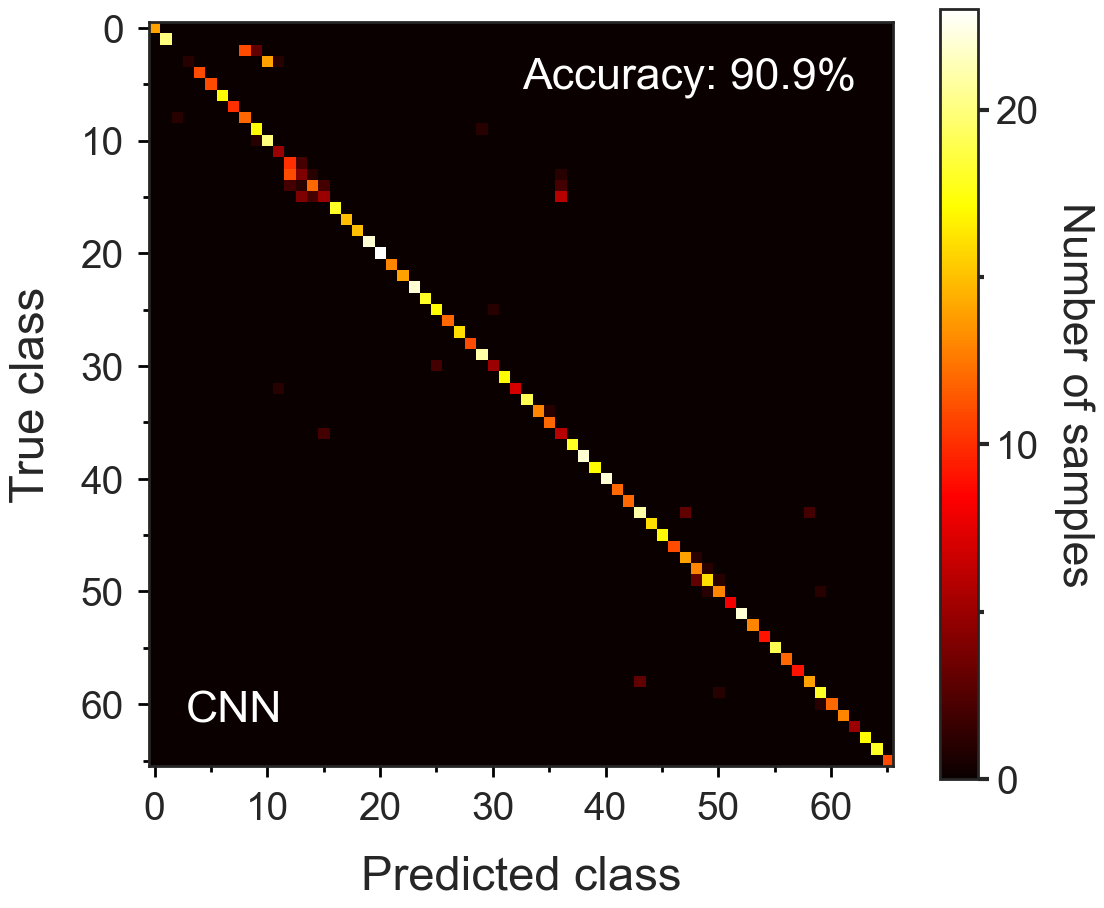

In [23]:
load_plt_setting()

report = classification_report(np.argmax(Ys, axis=1), np.argmax(Ys_pred, axis=1), target_names=dataloader.sample_list, output_dict=True)
matrix = confusion_matrix(np.argmax(Ys, axis=1), np.argmax(Ys_pred, axis=1))

fig, ax = plt.subplots(figsize=(12, 10))

mat = ax.matshow(matrix, cmap='hot')
ax.xaxis.set_ticks_position('bottom')
ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10, steps=[1, 2, 5, 10]))
ax.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10, steps=[1, 2, 5, 10]))
ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
ax.tick_params(axis='both',direction='out',length=8,width=2,pad=10,color='black',labelsize=28)
ax.tick_params(axis='both',which='minor',direction='out',length=4,width=2,pad=10,color='black',labelsize=28)
# ax.axes.set_xlim([450,950])
# ax.axes.set_ylim([0,5])
# # ax.set_xscale('log')

cbar = plt.colorbar(mat)
cbar.ax.tick_params(axis='y', direction='out',length=8,width=3,pad=5,labelsize=28)
cbar.ax.set_ylabel('Number of samples',labelpad=40, rotation=-90)
cbar.ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=4, integer=True, steps=[1, 2, 5, 10]))
cbar.ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
cbar.ax.tick_params(axis='both',which='minor',direction='out',length=4,width=3,pad=5)

ax.set_xlabel(r'Predicted class', labelpad=20, fontsize=34)
ax.set_ylabel(r'True class', labelpad=20, fontsize=34)

plt.text(0.95, 0.91, 'Accuracy: {:.1f}%'.format(report['accuracy']*100), fontsize=32, 
         transform=ax.transAxes, color='#FFFFFF', horizontalalignment='right')
plt.text(0.05, 0.06, 'CNN', fontsize=32, transform=ax.transAxes, color='#FFFFFF', horizontalalignment='left')

plt.savefig(os.path.join(folder, 'baselines', 'CNN', 'CNN.png'), format='png', dpi=300, transparent=True, bbox_inches='tight')